In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core, penalty_matrix, make_input_matrices, make_input_matrices_forces
from statmechlib.forcefields import f_embed, f_dens, f_spline3, energy
from statmechlib.forcefields import loss_energy_penalized, jacobian_energy_penalized
from statmechlib.forcefields import loss_sd2_penalized, jacobian_sd2_penalized
from statmechlib.forcefields import loss_sd2f_penalized

In [4]:
working = '../data/working'

In [5]:
# params_file = 'marinica_params'
# with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
#     param_list = pickle.load(fi)  

In [6]:
params_file = 'marinica_bs'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)

In [7]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [8]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [9]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [10]:
targets['eos']['box'] = targets['eos']['box'][0:1]
targets['eos']['xyz'] = targets['eos']['xyz'][0:1]
targets['eos']['temp'] = targets['eos']['temp'][0:1]
targets['eos']['beta'] = targets['eos']['beta'][0:1]
targets['eos']['energy'] = targets['eos']['energy'][0:1]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][0:1]
stats_bspline['eos']['forces'] = stats_bspline['eos']['forces'][0:1]

In [11]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['forces'] = stats_bspline['eos_bcc']['forces'][1:4]

In [12]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]
stats_bspline['relax']['forces'][1] = stats_bspline['inf']['forces'][0]

In [13]:
edens_knots = list(np.linspace(1.05, 4.55, 36))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [240]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [528]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.003 #0.1
targets['eos']['weight'] = 0.0 #1e-4
targets['eos_bcc']['weight'] = 0.003 #0.1
targets['relax']['weight'] = 2.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 5.0
targets['bcc_npt_langevin_3700K']['weight'] = 3.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

targets['eos']['temp'][0] = 10000.0
targets['eos']['energy'][0] = 20000.0

for tmp in targets['eos_bcc']['temp']:
    tmp = 10000.0
for tmp in targets['eos_bcc']['beta']:
    tmp = 1./10000.0
    
for tmp in targets['bain']['temp']:
    tmp = 10000.0
for tmp in targets['bain']['beta']:
    tmp = 1./10000.0
#targets['eos']['energy']

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 3.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 2.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 5.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.003),
 ('bain', 0.003)]

In [529]:
dl_dict = {key:0.0 for key in tkeys}
#dl_dict['relax'] = 0.03
#dl_dict['bcc_npt_langevin_300K'] = 0.1
# dl_dict['bcc_npt_langevin_3700K'] = 0.03
# dl_dict['vac_npt_langevin_2000K'] = 0.03
# dl_dict['screw_111_npt_langevin_2000K'] = 0.03
# dl_dict['i111_npt_langevin_2000K'] = 0.03
# dl_dict['i110_npt_langevin_2000K'] = 0.01
#dl_dict['liq_3700K'] = 0.01
#dl_dict['eos_bcc'] = 0.1
#dl_dict['bain'] = 0.1
dl_list = [dl_dict[key] for key in tkeys]

In [530]:
[(k,d) for k, d in zip(dl_list, tkeys)]

[(0.0, 'bcc_npt_langevin_300K'),
 (0.0, 'bcc_npt_langevin_3700K'),
 (0.0, 'fcc_npt_langevin_300K'),
 (0.0, 'vac_npt_langevin_2000K'),
 (0.0, 'i110_npt_langevin_2000K'),
 (0.0, 'i111_npt_langevin_2000K'),
 (0.0, 'screw_111_npt_langevin_2000K'),
 (0.0, 'liq_3700K'),
 (0.0, 'liq_5000K'),
 (0.0, 'eos'),
 (0.0, 'eos_bcc'),
 (0.0, 'eos_fcc'),
 (0.0, 'vacint'),
 (0.0, 'bain'),
 (0.0, 'relax')]

## SD matching

**Parameters optimized only on energetics**

In [541]:
b_init = np.array([-1.77236945e-05,  4.82923750e+03,  4.22066944e+03,  3.65746164e+03,
        3.13964314e+03,  2.66710984e+03,  2.23960432e+03,  1.85663747e+03,
        1.51734030e+03,  1.22048619e+03,  9.64385734e+02,  7.46855155e+02,
        5.65250119e+02,  4.16686790e+02,  2.98530275e+02,  2.08598096e+02,
        1.43436584e+02,  9.77225071e+01,  6.77334783e+01,  4.98964693e+01,
        4.04640480e+01,  3.68202368e+01,  3.66445646e+01,  3.78780939e+01,
        3.92254100e+01,  4.00633191e+01,  3.98164560e+01,  3.81964789e+01,
        3.53574057e+01,  3.10575775e+01,  2.55451101e+01,  1.91626397e+01,
        1.25152874e+01,  7.03408097e+00,  2.98947809e+00,  7.80805866e-01,
        8.43725527e-01,  2.46224801e+00,  3.65344444e+00,  2.95514255e+00,
        1.94656632e+00, -1.36276462e+00, 0.0, -1.32595598e+04, -7.95831705e+03,
       -3.41935203e+03,  3.58089542e+02,  3.37300793e+03,  5.62582912e+03,
        7.12823078e+03,  7.91257993e+03,  8.04037243e+03,  7.61145039e+03,
        6.77397091e+03,  5.73396034e+03,  4.72029679e+03,  3.85732910e+03,
        3.07281330e+03,  2.40139500e+03,  1.97515993e+03,  1.63324389e+03,
        1.37254472e+03,  1.22121660e+03,  1.09394470e+03,  9.60335237e+02,
        8.22116530e+02,  7.14330684e+02,  6.06332051e+02,  5.22848690e+02,
        4.65625132e+02,  3.82913221e+02,  3.20184358e+02,  2.44830689e+02,
        1.65405216e+02,  1.39560438e+02,  7.26746325e+01,  2.82409129e+01,
        1.46876318e+00])

b_init = np.array([-1.74160659e-05,  4.81792298e+03,  4.21102349e+03,  3.64920898e+03,
        3.13254040e+03,  2.66100468e+03,  2.23428733e+03,  1.85180718e+03,
        1.51276064e+03,  1.21602379e+03,  9.60229740e+02,  7.43559979e+02,
        5.63390477e+02,  4.16354960e+02,  2.99236995e+02,  2.09373880e+02,
        1.43343914e+02,  9.76615818e+01,  6.80717473e+01,  5.03817395e+01,
        4.05861314e+01,  3.67367709e+01,  3.64196643e+01,  3.73899757e+01,
        3.82714780e+01,  3.86028465e+01,  3.80978840e+01,  3.65532993e+01,
        3.40365270e+01,  3.03428118e+01,  2.55388072e+01,  1.95612423e+01,
        1.28676144e+01,  6.99529687e+00,  2.98651795e+00,  1.19493929e+00,
        1.00134492e+00,  2.32280112e+00,  3.62463065e+00,  3.13709663e+00,
        1.60517579e+00, -1.36544978e+00, -1.43038749e-01, 0.0, -1.32527064e+04,
       -7.75203159e+03, -3.10032051e+03,  7.07874911e+02,  3.68329967e+03,
        5.85314658e+03,  7.25022717e+03,  7.93423633e+03,  7.99510491e+03,
        7.54647572e+03,  6.72303757e+03,  5.71138575e+03,  4.72504875e+03,
        3.87474867e+03,  3.08167614e+03,  2.40349119e+03,  1.97390024e+03,
        1.64105106e+03,  1.37218087e+03,  1.21938836e+03,  1.09298828e+03,
        9.54949279e+02,  8.16358844e+02,  7.05161783e+02,  5.92566765e+02,
        5.05256983e+02,  4.48080867e+02,  3.72965933e+02,  3.21942254e+02,
        2.47543325e+02,  1.72063654e+02,  1.40805880e+02,  7.40130332e+01,
        2.78482427e+01,  6.64486213e+00])

b_init = np.array([-1.50666230e-05,  4.77211861e+03,  4.17864469e+03,  3.62851703e+03,
        3.12178782e+03,  2.65851221e+03,  2.23854754e+03,  1.86143178e+03,
        1.52633752e+03,  1.23201441e+03,  9.76809642e+02,  7.58713215e+02,
        5.75484024e+02,  4.24642377e+02,  3.03995939e+02,  2.11646010e+02,
        1.44405117e+02,  9.76710034e+01,  6.75600243e+01,  5.02934003e+01,
        4.16371550e+01,  3.87750297e+01,  3.86174140e+01,  3.89697094e+01,
        3.86641346e+01,  3.76506198e+01,  3.61589689e+01,  3.43514762e+01,
        3.23024057e+01,  2.94312350e+01,  2.53747936e+01,  1.99563292e+01,
        1.35511064e+01,  7.36849993e+00,  2.29467608e+00, -6.29186382e-01,
       -1.00747190e+00,  4.69994778e-01,  1.74355593e+00,  1.33064011e+00,
       -3.69063893e-03, -2.28465069e+00, -1.92697636e+00, -6.41251323e-01,
       -9.97040172e+03, -5.07481467e+03, -9.41165475e+02,  2.43146094e+03,
        5.04897625e+03,  6.92832335e+03,  8.10126509e+03,  8.61647632e+03,
        8.53868754e+03,  7.96186678e+03,  7.02712833e+03,  5.92473430e+03,
        4.85594943e+03,  3.92807361e+03,  3.09577803e+03,  2.40208017e+03,
        1.94123460e+03,  1.61275212e+03,  1.34998368e+03,  1.21645401e+03,
        1.08668950e+03,  9.72822867e+02,  8.37327964e+02,  7.07406437e+02,
        5.84528832e+02,  4.84579440e+02,  4.13615572e+02,  3.34344835e+02,
        2.92636479e+02,  2.42441970e+02,  1.87260093e+02,  1.50103585e+02,
        8.96204166e+01,  2.96443994e+01,  3.11656421e-01, 0.0])

b_init = np.array([-1.38841502e-05,  4.71216488e+03,  4.14070407e+03,  3.60892798e+03,
        3.11681713e+03,  2.66428818e+03,  2.25118546e+03,  1.87740946e+03,
        1.54272075e+03,  1.24673876e+03,  9.88796697e+02,  7.67772404e+02,
        5.81950614e+02,  4.29068044e+02,  3.06798039e+02,  2.12975723e+02,
        1.44342476e+02,  9.67176289e+01,  6.65991381e+01,  4.99246727e+01,
        4.20378191e+01,  3.96997614e+01,  4.00702720e+01,  4.12202941e+01,
        4.18691399e+01,  4.15099212e+01,  4.01650735e+01,  3.79410917e+01,
        3.48716952e+01,  3.06383240e+01,  2.53493960e+01,  1.92143427e+01,
        1.27474914e+01,  6.91139991e+00,  2.12214135e+00, -5.42340157e-01,
       -1.00713500e+00, -7.56746404e-02,  8.15744454e-01,  5.05842905e-01,
       -5.96811792e-01, -2.60848750e+00, -2.46129369e+00, -7.38254686e-01,
       -6.40404946e+03, -2.15068727e+03,  1.41947955e+03,  4.30737110e+03,
        6.51553426e+03,  8.05103368e+03,  8.93478576e+03,  9.21051517e+03,
        8.94770222e+03,  8.24357232e+03,  7.22600089e+03,  6.05892229e+03,
        4.93497322e+03,  3.96874851e+03,  3.11165905e+03,  2.40019520e+03,
        1.91866228e+03,  1.59206852e+03,  1.33172446e+03,  1.21122097e+03,
        1.09363986e+03,  9.90416650e+02,  8.64372921e+02,  7.37815077e+02,
        6.25964689e+02,  5.27317321e+02,  4.46245942e+02,  3.58228763e+02,
        2.99914989e+02,  2.37442367e+02,  1.79960268e+02,  1.45444961e+02,
        9.18633955e+01,  3.21023326e+01,  8.58199837e+00,  1.47383322e+01])

b_init = np.array([-1.35800621e-05,  4.70215187e+03,  4.13378121e+03,  3.60467087e+03,
        3.11479537e+03,  2.66409569e+03,  2.25250587e+03,  1.87983814e+03,
        1.54578894e+03,  1.24990604e+03,  9.91554187e+02,  7.69728340e+02,
        5.83036503e+02,  4.29526970e+02,  3.06985057e+02,  2.13171429e+02,
        1.44684610e+02,  9.71108455e+01,  6.67703679e+01,  4.98542529e+01,
        4.18305406e+01,  3.91276347e+01,  3.89211611e+01,  3.95902654e+01,
        4.01253284e+01,  4.00739681e+01,  3.94406977e+01,  3.81445658e+01,
        3.60155791e+01,  3.25574634e+01,  2.76272824e+01,  2.12266404e+01,
        1.38860247e+01,  6.99943883e+00,  2.00550045e+00, -5.02465234e-01,
       -8.34016479e-01, -3.51102716e-02,  6.59220117e-01,  4.03842433e-01,
       -7.65093435e-01, -2.76353353e+00, -2.67881720e+00, -8.85267119e-01,
        6.39605784e+02,  3.30730541e+03,  5.50899647e+03,  7.24391832e+03,
        8.51143103e+03,  9.31370845e+03,  9.66446612e+03,  9.58651387e+03,
        9.11423267e+03,  8.30477654e+03,  7.24639063e+03,  6.06938661e+03,
        4.94191356e+03,  3.96882382e+03,  3.11049686e+03,  2.40118129e+03,
        1.91893069e+03,  1.59103337e+03,  1.32761509e+03,  1.20567502e+03,
        1.08259121e+03,  9.73127591e+02,  8.45421954e+02,  7.20457190e+02,
        6.15659530e+02,  5.22207250e+02,  4.46603970e+02,  3.73194397e+02,
        3.29523025e+02,  2.72281839e+02,  2.08397091e+02,  1.61831346e+02,
        9.46547893e+01,  3.29578379e+01,  1.11647804e+01,  2.10061331e+01])

b_init = np.array([-1.36134900e-05,  4.70180731e+03,  4.13262813e+03,  3.60289582e+03,
        3.11262961e+03,  2.66185369e+03,  2.25053206e+03,  1.87849382e+03,
        1.54537932e+03,  1.25061648e+03,  9.93337108e+02,  7.72314627e+02,
        5.85833365e+02,  4.31743229e+02,  3.08059475e+02,  2.13334776e+02,
        1.44602940e+02,  9.70917396e+01,  6.69288591e+01,  5.00768808e+01,
        4.18478572e+01,  3.92693070e+01,  3.88416604e+01,  3.89284303e+01,
        3.86783962e+01,  3.79539656e+01,  3.69761245e+01,  3.57097345e+01,
        3.39124980e+01,  3.08689594e+01,  2.64013168e+01,  2.04546226e+01,
        1.35296046e+01,  7.04487343e+00,  2.02536553e+00, -6.86515488e-01,
       -1.11830900e+00, -1.51016487e-01,  6.56943476e-01,  2.94456632e-01,
       -6.95331334e-01, -2.81432091e+00, -2.55733805e+00, -8.42214471e-01,
        5.49303024e+02,  3.36151176e+03,  5.66702445e+03,  7.46530991e+03,
        8.75784303e+03,  9.55348192e+03,  9.87500550e+03,  9.75471064e+03,
        9.23975738e+03,  8.39522425e+03,  7.31081588e+03,  6.11314129e+03,
        4.96613006e+03,  3.97885647e+03,  3.11287606e+03,  2.39951868e+03,
        1.92092614e+03,  1.59107450e+03,  1.33136526e+03,  1.20612548e+03,
        1.08657079e+03,  9.75827881e+02,  8.39592251e+02,  7.02655327e+02,
        5.90152445e+02,  4.93703056e+02,  4.18167796e+02,  3.47259462e+02,
        3.07809053e+02,  2.55678973e+02,  1.97081725e+02,  1.58537913e+02,
        9.39419318e+01,  3.35958031e+01,  9.20361613e+00,  1.63180121e+01])

# this to Yury
b_init = np.array([-1.36064888e-05,  4.70417226e+03,  4.13423815e+03,  3.60397825e+03,
        3.11346024e+03,  2.66302750e+03,  2.25258846e+03,  1.88082365e+03,
        1.54697937e+03,  1.25083317e+03,  9.92104104e+02,  7.70968996e+02,
        5.86895530e+02,  4.33960550e+02,  3.08127025e+02,  2.13279363e+02,
        1.44599321e+02,  9.70922418e+01,  6.66420162e+01,  5.01808655e+01,
        4.18434145e+01,  3.92814989e+01,  3.88058201e+01,  3.90736696e+01,
        3.90564985e+01,  3.80019954e+01,  3.69774317e+01,  3.49288610e+01,
        3.44176478e+01,  3.07358626e+01,  2.65367220e+01,  2.09352894e+01,
        1.35480479e+01,  7.03962431e+00,  2.02979256e+00, -6.91721500e-01,
       -1.11666412e+00, -1.60434154e-01,  7.61189585e-01,  2.27605036e-01,
       -6.94012140e-01, -2.81527516e+00, -2.56153955e+00, -8.43675194e-01,
        5.81825516e+02,  3.38975948e+03,  5.69062175e+03,  7.48687373e+03,
        8.77886762e+03,  9.57937993e+03,  9.90743757e+03,  9.78902045e+03,
        9.26787183e+03,  8.41119988e+03,  7.32042822e+03,  6.12730166e+03,
        4.98085058e+03,  3.98051092e+03,  3.11287043e+03,  2.39949350e+03,
        1.92069903e+03,  1.58877343e+03,  1.33115727e+03,  1.20621620e+03,
        1.08635268e+03,  9.76230233e+02,  8.44241018e+02,  7.06348062e+02,
        5.89775524e+02,  4.90774560e+02,  4.15884397e+02,  3.51361562e+02,
        3.09195758e+02,  2.57059585e+02,  2.00819272e+02,  1.58469140e+02,
        9.39284706e+01,  3.36845322e+01,  9.21887615e+00,  1.63239560e+01])

# b_init = np.array([-1.69807370e-05,  4.71389335e+03,  4.13548276e+03,  3.59830905e+03,
#         3.10227256e+03,  2.64708651e+03,  2.23238324e+03,  1.85779252e+03,
#         1.52280975e+03,  1.22699256e+03,  9.69919298e+02,  7.50671459e+02,
#         5.67372584e+02,  4.17317061e+02,  2.98015738e+02,  2.09118713e+02,
#         1.44879596e+02,  9.72986260e+01,  6.39128499e+01,  4.40401161e+01,
#         3.90803612e+01,  4.56942321e+01,  5.62996573e+01,  6.34162958e+01,
#         6.45789223e+01,  5.92029721e+01,  5.10931775e+01,  3.99279675e+01,
#         2.85118409e+01,  1.76811585e+01,  8.89500771e+00,  2.20663525e+00,
#        -2.92066801e-01,  3.71320657e+00,  7.34742875e+00,  7.61327378e+00,
#         4.93633966e+00,  2.75426201e+00,  2.25574331e+00,  1.10781587e-01,
#         1.39361435e+00, -2.13675818e+00,  2.64565761e-02,  1.02864527e+00,
#         5.52587371e+03,  7.36111895e+03,  8.78727584e+03,  9.80300665e+03,
#         1.04099615e+04,  1.06170787e+04,  1.04469168e+04,  9.93892941e+03,
#         9.14818977e+03,  8.14242386e+03,  6.99953947e+03,  5.82323585e+03,
#         4.74401468e+03,  3.84281653e+03,  3.03788063e+03,  2.40063461e+03,
#         1.95301222e+03,  1.55607977e+03,  1.29617202e+03,  1.18963020e+03,
#         1.18590378e+03,  1.17819603e+03,  1.11260859e+03,  9.70566407e+02,
#         8.35034424e+02,  6.27189677e+02,  4.62804912e+02,  2.90511402e+02,
#         1.50264260e+02,  2.76814291e+01, -7.99883889e+00,  3.25729970e+01,
#         5.14719601e+01,  9.48266065e+01,  1.19672628e+02,  5.94823384e+01])

# b_init = np.array([-1.74401102e-05,  4.72045469e+03,  4.13538142e+03,  3.59239596e+03,
#         3.09150695e+03,  2.63277478e+03,  2.21609165e+03,  1.84118204e+03,
#         1.50761176e+03,  1.21461688e+03,  9.61071364e+02,  7.45320796e+02,
#         5.64997393e+02,  4.17011167e+02,  2.98796085e+02,  2.09553202e+02,
#         1.43750399e+02,  9.45466686e+01,  6.33314807e+01,  4.65216097e+01,
#         4.25347271e+01,  4.73132058e+01,  5.55399894e+01,  6.17414586e+01,
#         6.30389124e+01,  5.86455416e+01,  5.10633060e+01,  3.96432588e+01,
#         2.74790500e+01,  1.59067699e+01,  6.36842472e+00, -5.51169799e-01,
#        -2.15526073e+00,  3.99780024e+00,  9.59546438e+00,  1.04873023e+01,
#         7.51945649e+00,  3.70402560e+00,  2.36595187e+00,  3.40042164e-01,
#         1.49514727e+00, -2.12302566e+00, -3.21815518e-03,  7.73334397e-01,
#         8.28146546e+03,  9.17487403e+03,  9.82857292e+03,  1.02422771e+04,
#         1.04167798e+04,  1.03527358e+04,  1.00548042e+04,  9.53391658e+03,
#         8.80946467e+03,  7.91449119e+03,  6.89950266e+03,  5.83439393e+03,
#         4.80642992e+03,  3.88206200e+03,  3.06501910e+03,  2.40649749e+03,
#         1.93435747e+03,  1.55997071e+03,  1.33093846e+03,  1.22885416e+03,
#         1.19800118e+03,  1.15824797e+03,  1.07706870e+03,  9.55555543e+02,
#         8.11137134e+02,  6.26058134e+02,  4.54258945e+02,  2.75593505e+02,
#         1.10345601e+02, -1.72289211e+01, -5.43871923e+01, -9.15824922e+00,
#         3.67731140e+01,  1.06837716e+02,  1.39689129e+02,  7.82227577e+01])

# b_init = np.array([-1.74401102e-05,  4.72045469e+03,  4.13538142e+03,  3.59239596e+03,
#         3.09150695e+03,  2.63277478e+03,  2.21609165e+03,  1.84118204e+03,
#         1.50761176e+03,  1.21461688e+03,  9.61071364e+02,  7.45320796e+02,
#         5.64997393e+02,  4.17011167e+02,  2.98796085e+02,  2.09553202e+02,
#         1.43750399e+02,  9.45466686e+01,  6.33314807e+01,  4.65216097e+01,
#         4.25347271e+01,  4.73132058e+01,  5.55399894e+01,  6.17414586e+01,
#         6.30389124e+01,  5.86455416e+01,  5.10633060e+01,  3.96432588e+01,
#         2.74790500e+01,  1.59067699e+01,  6.36842472e+00, -5.51169799e-01,
#        -2.15526073e+00,  3.99780024e+00,  9.59546438e+00,  1.04873023e+01,
#         7.51945649e+00,  3.70402560e+00,  2.36595187e+00,  3.40042164e-01,
#         1.49514727e+00, -2.12302566e+00, -3.21815518e-03,  7.73334397e-01,
#         1.08e4, 1.07e4, 1.06e4,  1.05422771e+04,
#         1.04167798e+04,  1.03527358e+04,  1.00548042e+04,  9.53391658e+03,
#         8.80946467e+03,  7.91449119e+03,  6.89950266e+03,  5.83439393e+03,
#         4.80642992e+03,  3.88206200e+03,  3.06501910e+03,  2.40649749e+03,
#         1.93435747e+03,  1.55997071e+03,  1.33093846e+03,  1.22885416e+03,
#         1.19800118e+03,  1.15824797e+03,  1.07706870e+03,  9.55555543e+02,
#         8.11137134e+02,  6.26058134e+02,  4.54258945e+02,  2.75593505e+02,
#         1.10345601e+02, -1.72289211e+01, -5.43871923e+01, -9.15824922e+00,
#         3.67731140e+01,  1.06837716e+02,  1.39689129e+02,  7.82227577e+01])

# b_init = np.array([-1.58055350e-05,  4.72428899e+03,  4.13258897e+03,  3.58420459e+03,
#         3.07899629e+03,  2.61674266e+03,  2.19724009e+03,  1.82051001e+03,
#         1.48658121e+03,  1.19490176e+03,  9.44157006e+02,  7.32187479e+02,
#         5.56031196e+02,  4.12166879e+02,  2.97695170e+02,  2.11044537e+02,
#         1.47132499e+02,  9.89888586e+01,  6.65395496e+01,  4.66944626e+01,
#         3.91601985e+01,  4.13893687e+01,  4.83334836e+01,  5.50007820e+01,
#         5.78861299e+01,  5.60617904e+01,  5.14175171e+01,  4.39707865e+01,
#         3.56225364e+01,  2.69839581e+01,  1.90100691e+01,  1.11771059e+01,
#         5.47366168e+00,  4.43745861e+00,  2.84283938e+00,  1.17480863e+00,
#         7.71420317e-01,  7.05470258e-01,  1.04245885e-01, -2.06344247e+00,
#         1.69408662e-01, -3.27998267e+00, -1.14708137e+00,  8.33514266e-02,
#         1.34958645e+04,  1.34212116e+04,  1.32002833e+04,  1.28340293e+04,
#         1.23257381e+04,  1.16780662e+04,  1.08976952e+04,  9.99923281e+03,
#         9.00295403e+03,  7.93624364e+03,  6.83612121e+03,  5.74923643e+03,
#         4.73222090e+03,  3.82844861e+03,  3.04188172e+03,  2.40723441e+03,
#         1.94161717e+03,  1.55696940e+03,  1.29721257e+03,  1.16545748e+03,
#         1.12251894e+03,  1.08480722e+03,  1.00912152e+03,  9.03962953e+02,
#         7.80816501e+02,  6.31477305e+02,  4.89540089e+02,  3.49291518e+02,
#         2.27045782e+02,  1.25887811e+02,  8.26758184e+01,  8.60662668e+01,
#         6.45499032e+01,  5.05153089e+01,  6.36872975e+01,  2.82942602e+01])

In [532]:
scale = np.ones((len(pair_knots)))*0.15
scale[-6:] *= 1.0
len(pair_knots), len(edens_knots), len(b_init)

(43, 36, 80)

In [533]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*0.01, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2_f'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2_u':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=0.35)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    elif penalty_type == 'sd2_f':
        X, y, weight, beta, dl, bounds, force_atoms = make_input_matrices_forces(targets, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
        print('wdl', len(weight), len(dl))
        loss = loss_sd2f_penalized
        #jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, dl, force_atoms, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':100000}))

    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))


0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [[ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  2.25e-02 -6.75e-02 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -6.75e-02  2.25e-01 ...  0.00e+00  0.00e+00  0.00e+00]
 ...
 [ 0.00e+00  0.00e+00  0.00e+00 ...  1.90e-03 -1.20e-03  3.00e-04]
 [ 0.00e+00  0.00e+00  0.00e+00 ... -1.20e-03  1.00e-03 -3.00e-04]
 [ 0.00e+00  0.00e+00  0.00e+00 ...  3.00e-04 -3.00e-04  1.00e-04]]
lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 126 126 126 126
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 3 8 3 3
lens forces 12 12 12 12
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice

5.921647604632534e-06 5.835753961517666e-06 8.589364311486776e-08
1.9968136716405157e-05 6.159223608398175e-07 1.9352214355565338e-05
5.24533621510202e-06 6.067994571352438e-07 4.638536757966776e-06
1.8054393995241984e-05 6.10826343957554e-07 1.744356765128443e-05
4.779290266926248e-06 6.076504909921933e-07 4.1716397759340545e-06
1.7534656703937884e-05 1.7403441805681753e-05 1.3121489825613138e-07
4.836625984547109e-06 4.740559685270286e-06 9.606629927682377e-08
1.6725542934907377e-05 1.6611594388519497e-05 1.1394854638787877e-07
4.4646679826312385e-06 4.380578250758824e-06 8.408973187241458e-08
1.505250586111875e-05 1.490003174238284e-05 1.5247411873591149e-07
4.028659790642981e-06 3.9451632230092e-06 8.349656763378178e-08
1.4230237439924819e-05 6.093870762532573e-07 1.3620850363671562e-05
3.915309892342578e-06 6.066526334475774e-07 3.3086572588950004e-06
1.3507112600213754e-05 6.112831224462438e-07 1.2895829477767511e-05
3.729623999622439e-06 6.064603188260508e-07 3.123163680796388e-

1.6956798650231348e-06 1.6162697705237168e-06 7.941009449941816e-08
9.362220664333542e-07 8.585862075653126e-07 7.763585886804152e-08
1.7214228291335877e-06 6.070662304166563e-07 1.1143565987169314e-06
9.312833789396085e-07 6.063869343728697e-07 3.2489644456673886e-07
1.7289009927406084e-06 6.064311394043932e-07 1.1224698533362152e-06
9.276454344532703e-07 6.064298511629772e-07 3.2121558329029315e-07
1.7097240336454067e-06 6.064332022928689e-07 1.1032908313525376e-06
9.298608256678726e-07 6.06429125909131e-07 3.234316997587416e-07
1.6475207360793104e-06 1.5672705884694007e-06 8.025014760990971e-08
9.081075307394259e-07 8.302834414087828e-07 7.782408933064303e-08
1.6299194883276624e-06 6.064107285323263e-07 1.0235087597953361e-06
9.0596823828436e-07 6.064793566423275e-07 2.9948888164203256e-07
1.6532985597080747e-06 1.552109978848052e-06 1.0118858086002263e-07
8.976397979025121e-07 8.102736936679892e-07 8.73661042345229e-08
1.5040815572069497e-06 1.412027420654213e-06 9.205413655273674e

7.29554728720583e-07 6.0843030659563e-07 1.2112442212495297e-07
8.732380347702101e-07 6.06004139116857e-07 2.6723389565335313e-07
7.292809886776675e-07 6.06025585139105e-07 1.232554035385624e-07
8.645311617596601e-07 6.058422604977888e-07 2.586889012618713e-07
7.263335323922067e-07 6.060375941081949e-07 1.2029593828401176e-07
8.513525759141027e-07 6.061252624588002e-07 2.4522731345530247e-07
7.254123687337501e-07 6.059283180226585e-07 1.1948405071109163e-07
8.462402131233354e-07 7.695089310946069e-07 7.673128202872849e-08
7.232617864739875e-07 6.449749028997055e-07 7.828688357428199e-08
8.480248296490125e-07 7.69843607832549e-07 7.818122181646345e-08
7.218457162274866e-07 6.438248400587961e-07 7.802087616869046e-08
8.508565268194703e-07 7.718533385137171e-07 7.900318830575323e-08
7.210877847946334e-07 6.411207469766365e-07 7.996703781799689e-08
8.460922350951475e-07 7.664551584199373e-07 7.963707667521021e-08
7.216004756516132e-07 6.440124749384532e-07 7.758800071315989e-08
8.402307004

7.198009287939126e-07 6.413719797589123e-07 7.842894903500024e-08
7.262893641832355e-07 6.488812313675965e-07 7.740813281563902e-08
6.922937997229191e-07 6.137122338878964e-07 7.858156583502271e-08
7.2043698022727e-07 6.059463583396254e-07 1.1449062188764458e-07
6.927220811231105e-07 6.058790485867657e-07 8.684303253634482e-08
7.264130229616158e-07 6.435103135829472e-07 8.290270937866858e-08
6.920041019168099e-07 6.094580591698937e-07 8.254604274691616e-08
7.203340640022044e-07 6.424034520783348e-07 7.793061192386965e-08
6.925866505555793e-07 6.149161027836156e-07 7.767054777196372e-08
7.215367079374654e-07 6.440360992575165e-07 7.75006086799489e-08
6.924004125636701e-07 6.144310651876609e-07 7.796934737600922e-08
7.236015132409785e-07 6.45974186703351e-07 7.762732653762754e-08
6.916290606720263e-07 6.128184614162597e-07 7.881059925576665e-08
7.201873442818055e-07 6.428588780669001e-07 7.732846621490537e-08
6.919294327318201e-07 6.140242115185189e-07 7.79052212133012e-08
7.240555126427

6.86244813678061e-07 6.050868763873598e-07 8.11579372907012e-08
6.943963665352408e-07 6.05615487102657e-07 8.878087943258379e-08
6.860817927055069e-07 6.058376482634994e-07 8.024414444200743e-08
6.950009752335337e-07 6.126951144134437e-07 8.230586082008997e-08
6.859485313464498e-07 6.076093110374838e-07 7.833922030896595e-08
6.933644962832165e-07 6.056100648957625e-07 8.775443138745403e-08
6.919204010696502e-07 6.124746743091913e-07 7.944572676045893e-08
6.958653991023978e-07 6.185216618695461e-07 7.734373723285173e-08
6.856629658489142e-07 6.076069184771806e-07 7.805604737173361e-08
6.93787910357987e-07 6.059192540739809e-07 8.786865628400619e-08
6.85876649370603e-07 6.056253706331735e-07 8.025127873742946e-08
6.900419849149068e-07 6.118530677729798e-07 7.818891714192688e-08
6.931428731575616e-07 6.15900142971262e-07 7.724273018629965e-08
6.85735983919241e-07 6.077136913331096e-07 7.802229258613139e-08
6.925353786749951e-07 6.150021755786126e-07 7.753320309638242e-08
6.922841642650905

6.865621637012065e-07 6.085808210016966e-07 7.798134269950985e-08
6.854434514943241e-07 6.072783453302234e-07 7.816510616410064e-08
6.863907276829837e-07 6.071894518606664e-07 7.920127582231728e-08
6.869091089462752e-07 6.103064844099982e-07 7.660262453627702e-08
6.841246452501323e-07 6.057091203222516e-07 7.841552492788068e-08
6.866559795911118e-07 6.089771509489992e-07 7.76788286421126e-08
6.841534617576617e-07 6.062783478455037e-07 7.787511391215802e-08
6.86091433768204e-07 6.0781893517191e-07 7.827249859629401e-08
6.866872009247157e-07 6.05437006383185e-07 8.125019454153061e-08
6.841286204340563e-07 6.056302587206384e-07 7.849836171341793e-08
6.866461014308013e-07 6.053397896756375e-07 8.130631175516385e-08
6.841215319316639e-07 6.057095932015112e-07 7.841193873015271e-08
6.86661774184933e-07 6.08229699112174e-07 7.843207507275906e-08
6.84116578162814e-07 6.06515502220283e-07 7.760107594253092e-08
6.866334116176027e-07 6.086874273667727e-07 7.794598425083009e-08
6.84108479430835e-0

6.836162972309912e-07 6.05793646440233e-07 7.782265079075827e-08
6.842234973454149e-07 6.056268178962702e-07 7.859667944914478e-08
6.845607769808583e-07 6.067354577779228e-07 7.78253192029355e-08
6.835953558370279e-07 6.058092030069297e-07 7.778615283009814e-08
6.844309440494256e-07 6.050715915184042e-07 7.935935253102144e-08
6.836039765467237e-07 6.05247042248515e-07 7.835693429820865e-08
6.844126551990458e-07 6.055284885542297e-07 7.888416664481611e-08
6.83600105660203e-07 6.055263227767492e-07 7.807378288345377e-08
6.843259051574239e-07 6.054367851472831e-07 7.888912001014085e-08
6.844923893536692e-07 6.055117834561973e-07 7.898060589747189e-08
6.835879133234815e-07 6.055227502383758e-07 7.806516308510566e-08
6.843433535929026e-07 6.065789940861026e-07 7.776435950680007e-08
6.835777473315003e-07 6.058587827230316e-07 7.771896460846862e-08
6.843915983850156e-07 6.071307807283449e-07 7.726081765667069e-08
6.835697050569179e-07 6.052922001318089e-07 7.827750492510895e-08
6.844068812560

6.833854744919185e-07 6.053525533337756e-07 7.803292115814294e-08
6.838677628592824e-07 6.054735363788003e-07 7.839422648048209e-08
6.833714768662011e-07 6.053827212101028e-07 7.798875565609827e-08
6.838094591749915e-07 6.062304732045504e-07 7.757898597044112e-08
6.833786573167569e-07 6.052571320705444e-07 7.812152524621261e-08
6.839440351401543e-07 6.061106341217915e-07 7.783340101836274e-08
6.833610540401058e-07 6.054406546085483e-07 7.792039943155743e-08
6.837451373223031e-07 6.059762716494206e-07 7.776886567288251e-08
6.833839059180542e-07 6.053313087031255e-07 7.805259721492875e-08
6.837058168964349e-07 6.058746044169173e-07 7.783121247951755e-08
6.833814076134811e-07 6.05563298842182e-07 7.781810877129907e-08
6.837873279986086e-07 6.055734212633142e-07 7.82139067352945e-08
6.833704519820654e-07 6.055614737602506e-07 7.780897822181487e-08
6.838257382837697e-07 6.061375491333492e-07 7.768818915042048e-08
6.833653541923773e-07 6.053914309606789e-07 7.797392323169838e-08
6.8389441003

6.833537935131346e-07 6.049198549991647e-07 7.843393851396989e-08
6.836088994939009e-07 6.054004433092102e-07 7.820845618469072e-08
6.832654095688441e-07 6.053884842903132e-07 7.787692527853082e-08
6.834749467043266e-07 6.053771525125046e-07 7.809779419182199e-08
6.832812364607735e-07 6.052450521562579e-07 7.803618430451564e-08
6.834981939853661e-07 6.055896099245354e-07 7.790858406083076e-08
6.832783901881045e-07 6.052964776079613e-07 7.79819125801432e-08
6.836778324415468e-07 6.059799435451042e-07 7.76978888964426e-08
6.832563941474037e-07 6.050971095207465e-07 7.815928462665724e-08
6.833639876540478e-07 6.051621636509558e-07 7.8201824003092e-08
6.835071070633544e-07 6.053066358276958e-07 7.820047123565857e-08
6.832740535137328e-07 6.052654359933358e-07 7.800861752039701e-08
6.835090744413532e-07 6.053535552510606e-07 7.815551919029253e-08
6.832738334615149e-07 6.052471108902715e-07 7.802672257124349e-08
6.835500998398481e-07 6.058983343897494e-07 7.765176545009872e-08
6.832686027005

6.831907555158527e-07 6.052174093821586e-07 7.797334613369415e-08
6.833019664680911e-07 6.053439006112151e-07 7.7958065856876e-08
6.833359062118078e-07 6.052594133074742e-07 7.807649290433354e-08
6.832167031726879e-07 6.051926926637955e-07 7.802401050889237e-08
6.833410736547622e-07 6.054590431419881e-07 7.788203051277414e-08
6.832157554739008e-07 6.051376895538012e-07 7.80780659200996e-08
6.832444209467585e-07 6.0494755360405e-07 7.829686734270851e-08
6.83368814100612e-07 6.053902298776455e-07 7.79785842229665e-08
6.832115736804135e-07 6.051892783976659e-07 7.802229528274772e-08
6.832659270414096e-07 6.050902637597838e-07 7.817566328162577e-08
6.83331377468112e-07 6.052049141366389e-07 7.812646333147306e-08
6.832142535356977e-07 6.05176657200401e-07 7.80375963352968e-08
6.83324143173733e-07 6.052370754915024e-07 7.808706768223061e-08
6.832148776552422e-07 6.051674596233842e-07 7.804741803185792e-08
6.83324193355442e-07 6.052569080774226e-07 7.806728527801937e-08
6.832148986129585e-07 

6.831298652362592e-07 6.049658440104323e-07 7.816402122582688e-08
6.831614480652751e-07 6.049086738609663e-07 7.82527742043088e-08
6.832181157614744e-07 6.050488072460811e-07 7.816930851539326e-08
6.831511446785963e-07 6.050156731952102e-07 7.813547148338607e-08
6.831426960336544e-07 6.04954037149888e-07 7.818865888376635e-08
6.832198915167385e-07 6.051607967996402e-07 7.805909471709825e-08
6.832175996288949e-07 6.051220720685754e-07 7.809552756031955e-08
6.831557524174913e-07 6.049776414980241e-07 7.817811091946724e-08
6.831820254479154e-07 6.049551301160643e-07 7.822689533185113e-08
6.832338865153749e-07 6.050991765785091e-07 7.813470993686579e-08
6.831646645451135e-07 6.050950809673077e-07 7.806958357780581e-08
6.831931159472325e-07 6.050208813329997e-07 7.817223461423275e-08
6.83211395345967e-07 6.04954964034652e-07 7.825643131131493e-08
6.831784386741074e-07 6.050826548414242e-07 7.80957838326831e-08
6.832209411684781e-07 6.049911086834325e-07 7.82298324850455e-08
6.83164836845094

6.831617233479405e-07 6.050307818369049e-07 7.81309415110357e-08
6.831643678870988e-07 6.049709558042678e-07 7.819341208283106e-08
6.831697483481963e-07 6.050210427287553e-07 7.814870561944105e-08
6.831273496280809e-07 6.050175701983052e-07 7.81097794297758e-08
6.831151931569558e-07 6.0487246773756e-07 7.824272541939578e-08
6.831319148945454e-07 6.048316888073041e-07 7.830022608724129e-08
6.831677067656338e-07 6.050228924051146e-07 7.814481436051906e-08
6.83125774788618e-07 6.049712264125823e-07 7.815454837603575e-08
6.831323163831424e-07 6.049620373140711e-07 7.817027906907129e-08
6.831486808830168e-07 6.049902505013164e-07 7.815843038170038e-08
6.830932005433987e-07 6.048749999838363e-07 7.821820055956252e-08
6.831616074985554e-07 6.049225122386259e-07 7.823909525992953e-08
6.830937345467343e-07 6.048943428637596e-07 7.819939168297474e-08
6.831617724297305e-07 6.049970819248289e-07 7.816469050490156e-08
6.831066706191492e-07 6.049284138980848e-07 7.817825672106451e-08
6.8315497339226

6.830652208813219e-07 6.048676969277541e-07 7.819752395356787e-08
6.830892448339609e-07 6.048078955078052e-07 7.82813493261557e-08
6.831050220477812e-07 6.049220179849734e-07 7.818300406280784e-08
6.831180016890957e-07 6.049251526878851e-07 7.819284900121055e-08
6.831144356312115e-07 6.048775130172047e-07 7.823692261400681e-08
6.831195653697032e-07 6.049134810393988e-07 7.820608433030443e-08
6.83084039442909e-07 6.048910741437306e-07 7.819296529917836e-08
6.831109581605088e-07 6.048742962070409e-07 7.823666195346803e-08
6.830538762347011e-07 6.048361858545662e-07 7.821769038013485e-08
6.8306196880503e-07 6.04819981784359e-07 7.8241987020671e-08
6.830775187113297e-07 6.048380313051761e-07 7.823948740615364e-08
6.831013787013755e-07 6.049105069784787e-07 7.81908717228967e-08
6.831051199612339e-07 6.047959333600394e-07 7.830918660119444e-08
6.831130482339197e-07 6.049100638174144e-07 7.820298441650522e-08
6.830633838663676e-07 6.047389780957879e-07 7.832440577057959e-08
6.831053026038808e

6.830535157242678e-07 6.048039754010589e-07 7.824954032320889e-08
6.830605264863071e-07 6.048046889132675e-07 7.825583757303953e-08
6.83075212267233e-07 6.047043735639408e-07 7.837083870329224e-08
6.830466642785769e-07 6.046810998892607e-07 7.836556438931623e-08
6.830702014903889e-07 6.047990552596486e-07 7.827114623074025e-08
6.830740447281702e-07 6.048342064350548e-07 7.823983829311545e-08
6.830740489367625e-07 6.046722608852041e-07 7.84017880515583e-08
6.830480094620892e-07 6.04713703649599e-07 7.833430581249019e-08
6.830732357788006e-07 6.04780196049154e-07 7.829303972964659e-08
6.830735869210312e-07 6.047835203711263e-07 7.829006654990494e-08
6.830334298382336e-07 6.047153431964088e-07 7.831808664182489e-08
6.830366789455465e-07 6.047159272922077e-07 7.832075165333876e-08
6.830595192000291e-07 6.046777577096419e-07 7.838176149038724e-08
6.830748493416778e-07 6.048902855576512e-07 7.818456378402672e-08
6.83047929215345e-07 6.048202263943648e-07 7.822770282098013e-08
6.8302339297868

6.830066506396469e-07 6.046609579573823e-07 7.83456926822646e-08
6.830388221892198e-07 6.047144774538515e-07 7.832434473536829e-08
6.830045344878029e-07 6.046416482070937e-07 7.836288628070918e-08
6.83004583630076e-07 6.046770481429656e-07 7.83275354871104e-08
6.830038303435265e-07 6.046310233629107e-07 7.837280698061577e-08
6.830317453804293e-07 6.047278854849918e-07 7.830385989543743e-08
6.830012742399477e-07 6.045774913953488e-07 7.842378284459898e-08
6.830092786241438e-07 6.044769332807238e-07 7.853234534341994e-08
6.830421105461481e-07 6.047517749428712e-07 7.829033560327695e-08
6.830409124388554e-07 6.046083710613957e-07 7.843254137745973e-08
6.830357507880178e-07 6.047573680511875e-07 7.82783827368302e-08
6.829996479044627e-07 6.046434517130052e-07 7.835619619145746e-08
6.83005217590183e-07 6.046147986195791e-07 7.839041897060383e-08
6.830341582053914e-07 6.04615596852747e-07 7.841856135264444e-08
6.830143685767297e-07 6.047386069814865e-07 7.82757615952432e-08
6.830323696917079

6.830068027981588e-07 6.046259860071549e-07 7.838081679100384e-08
6.829958125712756e-07 6.045319996397915e-07 7.846381293148397e-08
6.829917116265887e-07 6.045793015290955e-07 7.841241009749311e-08
6.829735948518108e-07 6.045767851585514e-07 7.83968096932594e-08
6.829991425307844e-07 6.04668155631151e-07 7.833098689963337e-08
6.82992769463844e-07 6.045265159007587e-07 7.846625356308536e-08
6.829939847472629e-07 6.045611325126965e-07 7.843285223456647e-08
6.829980914542217e-07 6.046677307679798e-07 7.833036068624182e-08
6.829705051416763e-07 6.045463825213524e-07 7.842412262032398e-08
6.830072759963362e-07 6.045910978616793e-07 7.84161781346569e-08
6.82999161262525e-07 6.046259211538153e-07 7.837324010870972e-08
6.830047314159679e-07 6.046058061579652e-07 7.839892525800267e-08
6.830091624993416e-07 6.046131839214582e-07 7.839597857788342e-08
6.82999839365778e-07 6.046228241575799e-07 7.837701520819807e-08
6.830000871410302e-07 6.046193349397114e-07 7.838075220131884e-08
6.83003051023260

6.829757244845815e-07 6.046170298574851e-07 7.835869462709639e-08
6.829459128914047e-07 6.045417104836803e-07 7.840420240772445e-08
6.829576362407476e-07 6.045260995042685e-07 7.84315367364792e-08
6.829701854156114e-07 6.045590199546379e-07 7.841116546097353e-08
6.829453631872042e-07 6.045099255711416e-07 7.843543761606256e-08
6.829568099515122e-07 6.044756166839555e-07 7.848119326755665e-08
6.829631558760251e-07 6.045727315836832e-07 7.839042429234198e-08
6.829629256487526e-07 6.045767420404762e-07 7.838618360827638e-08
6.829413841413802e-07 6.045707503575042e-07 7.837063378387597e-08
6.829468112108659e-07 6.045958363473856e-07 7.835097486348034e-08
6.829593775715398e-07 6.045601591510362e-07 7.839921842050359e-08
6.829616394468621e-07 6.046213113755855e-07 7.834032807127656e-08
6.829539725323408e-07 6.0451023953493e-07 7.844373299741079e-08
6.829452100026967e-07 6.045073871038328e-07 7.843782289886392e-08
6.829618384605189e-07 6.045211822216262e-07 7.844065623889265e-08
6.82958527812

6.829424623174344e-07 6.044084189425563e-07 7.853404337487817e-08
6.829298624439269e-07 6.04424865966851e-07 7.85049964770758e-08
6.829318194500482e-07 6.044876920575514e-07 7.844412739249677e-08
6.829380184835754e-07 6.046146731376086e-07 7.832334534596669e-08
6.829196068441684e-07 6.044415392840115e-07 7.847806756015687e-08
6.829405662667749e-07 6.045024938184511e-07 7.843807244832377e-08
6.829050387983825e-07 6.044808846974298e-07 7.842415410095271e-08
6.829043975347314e-07 6.044796111974336e-07 7.842478633729783e-08
6.82903450983489e-07 6.045479232764396e-07 7.835552770704937e-08
6.829019685932521e-07 6.046130038381526e-07 7.828896475509951e-08
6.8293676019533e-07 6.045350968101077e-07 7.840166338522223e-08
6.829037820446201e-07 6.04452592688492e-07 7.845118935612818e-08
6.829177507180309e-07 6.04452544965064e-07 7.84652057529668e-08
6.829109694217277e-07 6.044912525641667e-07 7.841971685756093e-08
6.829072224497721e-07 6.044899215517045e-07 7.841730089806759e-08
6.829175426557233e

6.828612706556381e-07 6.044107845773576e-07 7.845048607828048e-08
6.828626109163981e-07 6.043967498302933e-07 7.846586108610481e-08
6.828736107788447e-07 6.043807588840834e-07 7.849285189476135e-08
6.828861764411578e-07 6.043384124412388e-07 7.854776399991906e-08
6.828788625102343e-07 6.044027648048062e-07 7.847609770542803e-08
6.828760616950762e-07 6.043655793322158e-07 7.851048236286048e-08
6.828973582751244e-07 6.04324696910836e-07 7.857266136428834e-08
6.828693058867045e-07 6.044028773739727e-07 7.846642851273174e-08
6.828762995942151e-07 6.04463526717297e-07 7.84127728769181e-08
6.828608549212879e-07 6.043740578253781e-07 7.848679709590982e-08
6.828681019207324e-07 6.043342998347038e-07 7.853380208602857e-08
6.828589012834108e-07 6.044315644642987e-07 7.842733681911213e-08
6.828637363306685e-07 6.04450859009905e-07 7.841287732076353e-08
6.82863760678464e-07 6.043269340662894e-07 7.853682661217463e-08
6.82889964058281e-07 6.043858722871202e-07 7.850409177116078e-08
6.82863908412207

6.828116316115436e-07 6.043858920884255e-07 7.84257395231181e-08
6.828166617306278e-07 6.044115062657133e-07 7.840515546491445e-08
6.828474939232314e-07 6.043496083883968e-07 7.84978855348345e-08
6.828218577949722e-07 6.043248213013625e-07 7.849703649360976e-08
6.828244269213218e-07 6.043643417724967e-07 7.846008514882512e-08
6.828135947750643e-07 6.043095703277435e-07 7.850402444732083e-08
6.828272301928892e-07 6.043192070216543e-07 7.850802317123496e-08
6.828312873793979e-07 6.043830816720049e-07 7.844820570739287e-08
6.828274454063651e-07 6.043275771516256e-07 7.849986825473949e-08
6.828144483550199e-07 6.044277602930629e-07 7.838668806195698e-08
6.828425875696305e-07 6.042966011994421e-07 7.854598637018839e-08
6.828332155316134e-07 6.043565549277204e-07 7.8476660603893e-08
6.828350204941661e-07 6.043613035049514e-07 7.847371698921478e-08
6.828407005691653e-07 6.044978087943309e-07 7.834289177483442e-08
6.828248223918651e-07 6.043831999324591e-07 7.844162245940595e-08
6.828132090934

6.827682730776482e-07 6.042517784995114e-07 7.851649457813678e-08
6.827761008586932e-07 6.042721185489987e-07 7.850398230969446e-08
6.827658423814168e-07 6.042807641840113e-07 7.848507819740547e-08
6.827877529654372e-07 6.042264302131071e-07 7.856132275233023e-08
6.827803985064571e-07 6.042493516105853e-07 7.85310468958717e-08
6.827644251266677e-07 6.042962744622582e-07 7.846815066440953e-08
6.827659090904234e-07 6.043218834940125e-07 7.844402559641082e-08
6.827667029889842e-07 6.042419913829016e-07 7.85247116060826e-08
6.827834852014388e-07 6.04237419908899e-07 7.854606529253971e-08
6.827918909683816e-07 6.044073065695342e-07 7.838458439884747e-08
6.82762668660034e-07 6.042062759700343e-07 7.855639268999965e-08
6.827795295626165e-07 6.041303337560437e-07 7.864919580657272e-08
6.827788750568113e-07 6.041256322088982e-07 7.865324284791313e-08
6.827744820121364e-07 6.042574351924706e-07 7.851704681966581e-08
6.827988305522454e-07 6.042234944987769e-07 7.857533605346845e-08
6.827624246134

6.827254253279952e-07 6.042826206975082e-07 7.844280463048704e-08
6.827417063923417e-07 6.041879018594308e-07 7.85538045329109e-08
6.82737452455748e-07 6.042817593093885e-07 7.845569314635952e-08
6.827195852341498e-07 6.042872820696741e-07 7.843230316447574e-08
6.827365592050928e-07 6.042426490068025e-07 7.849391019829029e-08
6.827096967585765e-07 6.041658577861458e-07 7.854383897243068e-08
6.827526383608281e-07 6.041709450686465e-07 7.858169329218157e-08
6.827275247234033e-07 6.042618278289776e-07 7.846569689442574e-08
6.827217084358518e-07 6.042079334379865e-07 7.851377499786537e-08
6.827145715658846e-07 6.041723747542451e-07 7.854219681163954e-08
6.827236826089298e-07 6.041884266653908e-07 7.853525594353911e-08
6.827273384954656e-07 6.04180898899611e-07 7.854643959585459e-08
6.827186188611075e-07 6.043299503174675e-07 7.838866854364e-08
6.827278991009391e-07 6.041821570918673e-07 7.85457420090718e-08
6.827409881448192e-07 6.042863969456709e-07 7.845459119914836e-08
6.827160330660059

6.826902908176099e-07 6.041813778796545e-07 7.850891293795541e-08
6.826751365563544e-07 6.040992681390012e-07 7.857586841735312e-08
6.826546569521829e-07 6.040800838901562e-07 7.857457306202675e-08
6.826685666226801e-07 6.040028605588622e-07 7.866570606381785e-08
6.826674287967711e-07 6.041331639978504e-07 7.853426479892065e-08
6.826657473836288e-07 6.040545440128956e-07 7.861120337073331e-08
6.826503114270719e-07 6.041112367824174e-07 7.85390746446545e-08
6.826582498776987e-07 6.040785173289331e-07 7.857973254876555e-08
6.826546437772196e-07 6.041638502407377e-07 7.849079353648186e-08
6.826651661140688e-07 6.040885140057838e-07 7.857665210828501e-08
6.826551811101498e-07 6.041740159384719e-07 7.848116517167796e-08
6.826822114184628e-07 6.042201974969752e-07 7.846201392148757e-08
6.826532467515277e-07 6.042013009189333e-07 7.845194583259442e-08
6.826608183812413e-07 6.040975490427082e-07 7.856326933853311e-08
6.826657305042855e-07 6.041938768239612e-07 7.847185368032428e-08
6.826797670

6.826164768855233e-07 6.040696896139301e-07 7.854678727159311e-08
6.826303252141899e-07 6.04062370773509e-07 7.856795444068084e-08
6.826357442427447e-07 6.040182363898699e-07 7.861750785287484e-08
6.826366426961725e-07 6.040845726914559e-07 7.855207000471665e-08
6.82599898382358e-07 6.040309371842713e-07 7.856896119808667e-08
6.82609956305621e-07 6.039953592182116e-07 7.861459708740938e-08
6.826397160336914e-07 6.040998112650998e-07 7.853990476859153e-08
6.826030280283757e-07 6.040129686772491e-07 7.859005935112662e-08
6.82631771925797e-07 6.040827408145191e-07 7.854903111127796e-08
6.82605265561861e-07 6.040982160275386e-07 7.850704953432242e-08
6.826039259247868e-07 6.040090050270206e-07 7.859492089776623e-08
6.826109501448669e-07 6.040175942842395e-07 7.859335586062741e-08
6.826165855555615e-07 6.041073956246577e-07 7.850918993090374e-08
6.8260257255123e-07 6.041539898886651e-07 7.844858266256494e-08
6.826029715590219e-07 6.039822099100546e-07 7.86207616489672e-08
6.826188856028671e

6.826069077058142e-07 6.041770071815679e-07 7.842990052424639e-08
6.825777940150698e-07 6.039299722698815e-07 7.864782174518837e-08
6.82589020212551e-07 6.040574976281964e-07 7.853152258435457e-08
6.825928819368651e-07 6.041738782330528e-07 7.841900370381226e-08
6.825636828583316e-07 6.039154753465076e-07 7.864820751182407e-08
6.825939600532258e-07 6.040026465805223e-07 7.85913134727035e-08
6.825738305905124e-07 6.039441106713217e-07 7.862971991919067e-08
6.825557799746795e-07 6.0398669551798e-07 7.856908445669951e-08
6.825719447093965e-07 6.039810554856846e-07 7.859088922371186e-08
6.825955630125011e-07 6.040775673804611e-07 7.851799563203997e-08
6.825663215496012e-07 6.039215216119652e-07 7.864479993763596e-08
6.825591153238778e-07 6.039981641828318e-07 7.856095114104605e-08
6.825626167683259e-07 6.040321646781124e-07 7.853045209021346e-08
6.825547807489343e-07 6.039261256911889e-07 7.862865505774536e-08
6.825743315954476e-07 6.03875326499852e-07 7.869900509559557e-08
6.8255363507996

6.825406499461536e-07 6.03949006969806e-07 7.859164297634763e-08
6.82543758727491e-07 6.039228760021901e-07 7.862088272530087e-08
6.825635279711745e-07 6.039190587943589e-07 7.864446917681562e-08
6.825591683327741e-07 6.039591295533441e-07 7.860003877943001e-08
6.82526039447513e-07 6.040067999485356e-07 7.851923949897739e-08
6.825376601926939e-07 6.038545918309561e-07 7.868306836173773e-08
6.825621637021463e-07 6.038642130896099e-07 7.86979506125364e-08
6.825571523393981e-07 6.039733259195799e-07 7.85838264198182e-08
6.825353163600197e-07 6.039397107044017e-07 7.859560565561808e-08
6.825626760438113e-07 6.039643631291144e-07 7.85983129146969e-08
6.825216771828943e-07 6.038623597242263e-07 7.865931745866802e-08
6.825338874955033e-07 6.038222502228949e-07 7.871163727260836e-08
6.82561704999005e-07 6.039148094975019e-07 7.864689550150303e-08
6.82534075423911e-07 6.038259905011304e-07 7.870808492278058e-08
6.825414859798349e-07 6.038322096494648e-07 7.870927633037e-08
6.825619876844665e-07

6.825278294290049e-07 6.038283431002377e-07 7.869948632876714e-08
6.824997058356287e-07 6.03884119907319e-07 7.861558592830974e-08
6.825101378595113e-07 6.038380333589782e-07 7.867210450053307e-08
6.825016231759745e-07 6.037937436692363e-07 7.870787950673815e-08
6.825173848817078e-07 6.037589494688975e-07 7.87584354128103e-08
6.825216237789898e-07 6.037644778394635e-07 7.875714593952637e-08
6.825116556470568e-07 6.038419678555589e-07 7.866968779149787e-08
6.825240477963156e-07 6.038959677415127e-07 7.862808005480289e-08
6.825169038227631e-07 6.038290207433981e-07 7.868788307936498e-08
6.825057154996381e-07 6.038514291388165e-07 7.865428636082157e-08
6.825242835209108e-07 6.038336223667606e-07 7.86906611541501e-08
6.825190324000167e-07 6.038446241089883e-07 7.867440829102847e-08
6.82522606352857e-07 6.037858562386869e-07 7.873675011417007e-08
6.825117403620145e-07 6.037625991264007e-07 7.874914123561382e-08
6.824932862910788e-07 6.037627890075364e-07 7.873049728354233e-08
6.825112077504

6.824903379410481e-07 6.037450408895699e-07 7.874529705147822e-08
6.825028016269076e-07 6.038971422698141e-07 7.860565935709346e-08
6.824801340555727e-07 6.037199926055554e-07 7.876014145001734e-08
6.824772633789297e-07 6.037519198196201e-07 7.872534355930967e-08
6.824875714449868e-07 6.037446239176618e-07 7.87429475273251e-08
6.824931000762535e-07 6.038180221550605e-07 7.867507792119298e-08
6.824974125059673e-07 6.037871769122438e-07 7.871023559372347e-08
6.824914307729148e-07 6.03704302284265e-07 7.878712848864979e-08
6.82487957023578e-07 6.037734123696667e-07 7.871454465391125e-08
6.824842565789542e-07 6.037314616130835e-07 7.875279496587069e-08
6.82458811607512e-07 6.036894627192884e-07 7.876934888822347e-08
6.824619689141722e-07 6.036214687414381e-07 7.88405001727341e-08
6.824950295918457e-07 6.037610412820575e-07 7.873398830978829e-08
6.824656785280816e-07 6.037537431287314e-07 7.871193539935021e-08
6.824619160727584e-07 6.036456804180404e-07 7.881623565471798e-08
6.8249421088524

6.824299458401039e-07 6.036314044367366e-07 7.879854140336733e-08
6.824480453289896e-07 6.03567945021628e-07 7.888010030736154e-08
6.824273877257126e-07 6.035784964298197e-07 7.884889129589282e-08
6.824349071807951e-07 6.037360253567376e-07 7.869888182405746e-08
6.824493338583273e-07 6.036104524386874e-07 7.883888141963994e-08
6.824619430381142e-07 6.036593490499803e-07 7.880259398813393e-08
6.824373415684881e-07 6.036368650259953e-07 7.880047654249282e-08
6.824542266586076e-07 6.035854215395219e-07 7.886880511908572e-08
6.824387930900479e-07 6.03554799555422e-07 7.888399353462588e-08
6.824429466757029e-07 6.035920591202208e-07 7.88508875554821e-08
6.824425887438457e-07 6.036141813631024e-07 7.882840738074336e-08
6.824450719293076e-07 6.035930279507218e-07 7.885204397858587e-08
6.824237799228369e-07 6.035657009215953e-07 7.885807900124163e-08
6.824340187002582e-07 6.034988327867174e-07 7.89351859135408e-08
6.824624578430741e-07 6.036806813270503e-07 7.878177651602386e-08
6.824400659541

6.823975592776635e-07 6.034394071846933e-07 7.895815209297013e-08
6.82407358737518e-07 6.034821244598098e-07 7.892523427770812e-08
6.824030328551806e-07 6.035090148674451e-07 7.889401798773548e-08
6.824111460982941e-07 6.035383762464202e-07 7.887276985187384e-08
6.824225958685559e-07 6.035911428054642e-07 7.883145306309174e-08
6.824068172997877e-07 6.034362392260059e-07 7.897057807378175e-08
6.824148510040669e-07 6.035882415256675e-07 7.882660947839938e-08
6.824148470231855e-07 6.036141520350383e-07 7.88006949881472e-08
6.824185884920349e-07 6.034850862592995e-07 7.893350223273544e-08
6.82397204117003e-07 6.035462735323335e-07 7.88509305846695e-08
6.824071349652722e-07 6.035478883641183e-07 7.885924660115393e-08
6.823934986725419e-07 6.035089534483739e-07 7.888454522416794e-08
6.824083325465105e-07 6.034955941400079e-07 7.891273840650258e-08
6.823965875745484e-07 6.035948269183657e-07 7.880176065618272e-08
6.824008773461523e-07 6.035735528103221e-07 7.882732453583018e-08
6.823952575226

6.823608094118658e-07 6.034342802763761e-07 7.892652913548972e-08
6.823642288962878e-07 6.034175066597476e-07 7.89467222365402e-08
6.82364711929373e-07 6.034138045276379e-07 7.895090740173515e-08
6.823895343499682e-07 6.034515505155035e-07 7.893798383446467e-08
6.823871355456158e-07 6.036080702160204e-07 7.877906532959543e-08
6.823768855319428e-07 6.034077581746091e-07 7.896912735733367e-08
6.823864581292628e-07 6.033979885029055e-07 7.89884696263573e-08
6.823881901203999e-07 6.034824523660195e-07 7.890573775438042e-08
6.823878327527578e-07 6.035197930537039e-07 7.886803969905387e-08
6.823776930385069e-07 6.035054569318355e-07 7.887223610667135e-08
6.823837037703166e-07 6.035045127994861e-07 7.887919097083056e-08
6.823730994729782e-07 6.033934166562793e-07 7.89796828166989e-08
6.823932425549523e-07 6.034694471309527e-07 7.892379542399965e-08
6.823952915681025e-07 6.034037962863837e-07 7.89914952817189e-08
6.82371654573006e-07 6.033417329014507e-07 7.902992167155532e-08
6.82386455501253

6.823613483733847e-07 6.034088774674886e-07 7.895247090589606e-08
6.823670824604969e-07 6.033638573065645e-07 7.900322515393243e-08
6.823451654304812e-07 6.03302039172074e-07 7.904312625840717e-08
6.82360674861415e-07 6.034632235597841e-07 7.889745130163092e-08
6.823698003080399e-07 6.0333758438369e-07 7.903221592434989e-08
6.823435526849383e-07 6.033337129481283e-07 7.900983973680994e-08
6.823684178738691e-07 6.034321159191088e-07 7.893630195476022e-08
6.823446463542204e-07 6.033439913122576e-07 7.900065504196278e-08
6.82360726440399e-07 6.03301819542552e-07 7.905890689784698e-08
6.823644052799795e-07 6.033892942011112e-07 7.897511107886828e-08
6.823710058646967e-07 6.03517613819386e-07 7.885339204531079e-08
6.823489086580183e-07 6.033048261500151e-07 7.904408250800316e-08
6.823473246825073e-07 6.033836157551396e-07 7.896370892736777e-08
6.823560733041738e-07 6.033206031561765e-07 7.903547014799728e-08
6.823706353279921e-07 6.033353437007542e-07 7.9035291627238e-08
6.823484716123459e-

6.823298630096075e-07 6.03262833496529e-07 7.90670295130785e-08
6.823354931336762e-07 6.033758201593513e-07 7.895967297432491e-08
6.823252648784376e-07 6.032332590371056e-07 7.909200584133203e-08
6.823374594966809e-07 6.032173535919835e-07 7.912010590469734e-08
6.823334770885112e-07 6.034250282400654e-07 7.890844884844583e-08
6.823351695690246e-07 6.032980197242074e-07 7.903714984481723e-08
6.823385827593752e-07 6.033597730251148e-07 7.897880973426041e-08
6.823416753837802e-07 6.033961118660457e-07 7.89455635177346e-08
6.823274082907079e-07 6.033453795112278e-07 7.898202877948009e-08
6.823377725554569e-07 6.033074060844483e-07 7.903036647100862e-08
6.823308279617535e-07 6.033486898171921e-07 7.898213814456142e-08
6.823414586878461e-07 6.033703250159355e-07 7.897113367191053e-08
6.823406581073469e-07 6.033928179203475e-07 7.894784018699952e-08
6.823217142887158e-07 6.032950808919097e-07 7.902663339680615e-08
6.823101965624645e-07 6.032891852443529e-07 7.902101131811164e-08
6.82311002761

6.823182955073993e-07 6.031775836873501e-07 7.914071182004918e-08
6.823184726880091e-07 6.033077927947838e-07 7.901067989322527e-08
6.823122615951424e-07 6.032249071004385e-07 7.9087354494704e-08
6.82298561189938e-07 6.031868995010427e-07 7.911166168889537e-08
6.822838829940989e-07 6.032227397038564e-07 7.906114329024248e-08
6.822765911675215e-07 6.032098971661634e-07 7.906669400135812e-08
6.823013340597027e-07 6.032298413755235e-07 7.90714926841791e-08
6.82301345854905e-07 6.031964487227736e-07 7.910489713213139e-08
6.822931846660683e-07 6.032547183205293e-07 7.903846634553908e-08
6.822947479385575e-07 6.032545023100122e-07 7.904024562854531e-08
6.822863447911897e-07 6.031087988762013e-07 7.917754591498842e-08
6.823090827196907e-07 6.031855479272969e-07 7.912353479239372e-08
6.823148178613644e-07 6.03255980148242e-07 7.905883771312248e-08
6.82305777865311e-07 6.031743910776747e-07 7.91313867876363e-08
6.82310908669509e-07 6.033455383904366e-07 7.896537027907243e-08
6.822946627654045e-

6.822810794270376e-07 6.030958151375893e-07 7.918526428944823e-08
6.822621081065862e-07 6.031385623757287e-07 7.91235457308575e-08
6.822847686998534e-07 6.032700827174062e-07 7.901468598244712e-08
6.822494536202591e-07 6.03147444642532e-07 7.91020089777271e-08
6.822559276899751e-07 6.030767073142108e-07 7.917922037576432e-08
6.822694218023399e-07 6.031703711388007e-07 7.909905066353922e-08
6.822671476404051e-07 6.030839730354898e-07 7.918317460491537e-08
6.822768862325875e-07 6.03233784701052e-07 7.90431015315356e-08
6.822586495924191e-07 6.031130534931235e-07 7.914559609929554e-08
6.822734372389022e-07 6.031877223893462e-07 7.908571484955587e-08
6.822740708679273e-07 6.030380014692206e-07 7.923606939870673e-08
6.822758841344872e-07 6.031283108877176e-07 7.914757324676955e-08
6.822566081539046e-07 6.03166514774935e-07 7.909009337896962e-08
6.822726313926597e-07 6.032345195619313e-07 7.903811183072846e-08
6.822596225179487e-07 6.030409935952788e-07 7.921862892266987e-08
6.82261317815529

6.822213622040543e-07 6.029471781044095e-07 7.927418409964475e-08
6.822080624615946e-07 6.028716277377428e-07 7.933643472385171e-08
6.82224581007477e-07 6.027232282656136e-07 7.950135274186338e-08
6.82216124892304e-07 6.030022201693902e-07 7.921390472291392e-08
6.82216326429766e-07 6.030413502898767e-07 7.917497613988942e-08
6.822287792170706e-07 6.031036719600844e-07 7.912510725698624e-08
6.822201273213719e-07 6.028911790928843e-07 7.932894822848753e-08
6.82195053464945e-07 6.029054500682156e-07 7.928960339672941e-08
6.821894819892556e-07 6.027966190128997e-07 7.93928629763559e-08
6.822220424491108e-07 6.030011716822164e-07 7.922087076689436e-08
6.822189088471929e-07 6.029637828775451e-07 7.925512596964787e-08
6.822093841067826e-07 6.029787053645967e-07 7.923067874218596e-08
6.821996675154797e-07 6.030032519212317e-07 7.919641559424797e-08
6.822011266816104e-07 6.029961111057911e-07 7.920501557581937e-08
6.822128624558339e-07 6.030067833712475e-07 7.920607908458643e-08
6.8219950203058

6.821559145912907e-07 6.026610723318075e-07 7.949484225948318e-08
6.821529362092469e-07 6.027667701302388e-07 7.938616607900806e-08
6.821349219221545e-07 6.028931169889521e-07 7.924180493320244e-08
6.821301372124083e-07 6.029305535737698e-07 7.91995836386385e-08
6.821432651916419e-07 6.028511661865834e-07 7.929209900505846e-08
6.821627396572663e-07 6.026927012225242e-07 7.947003843474207e-08
6.82154320769151e-07 6.028799513858313e-07 7.927436938331972e-08
6.821541693179059e-07 6.028073055733067e-07 7.934686374459908e-08
6.821651529189905e-07 6.028150539225258e-07 7.935009899646481e-08
6.821623689469004e-07 6.027859127221555e-07 7.937645622474491e-08
6.821357291844058e-07 6.027727635650234e-07 7.936296561938235e-08
6.82147631611928e-07 6.028995112589247e-07 7.924812035300334e-08
6.821388304531274e-07 6.027863333098076e-07 7.935249714331975e-08
6.821373790076301e-07 6.028101793583218e-07 7.932719964930833e-08
6.821337697403397e-07 6.027478478597325e-07 7.938592188060724e-08
6.82128968169

6.820706074864885e-07 6.025996163724051e-07 7.947099111408342e-08
6.820974662036328e-07 6.026255704800681e-07 7.947189572356471e-08
6.820874801285854e-07 6.025359420017378e-07 7.95515381268477e-08
6.820826653225459e-07 6.025931806830609e-07 7.948948463948505e-08
6.820794725359228e-07 6.024912245562544e-07 7.958824797966841e-08
6.820906344525855e-07 6.025024389853739e-07 7.958819546721166e-08
6.821064650435676e-07 6.02667839954289e-07 7.943862508927857e-08
6.820983638203879e-07 6.024143271882193e-07 7.968403663216861e-08
6.821034121980341e-07 6.027105721657215e-07 7.939284003231266e-08
6.820783993040521e-07 6.026268852240152e-07 7.945151408003696e-08
6.820765430469812e-07 6.025465487864025e-07 7.95299942605788e-08
6.821099434643856e-07 6.02675511737188e-07 7.943443172719754e-08
6.820725261917868e-07 6.025823596595986e-07 7.94901665321882e-08
6.820956816116108e-07 6.027092851867303e-07 7.938639642488055e-08
6.820757357652904e-07 6.025475000752001e-07 7.952823569009034e-08
6.8206454958131

6.820182682962636e-07 6.025379959042179e-07 7.948027239204577e-08
6.820186471937321e-07 6.024639358965298e-07 7.95547112972023e-08
6.820280306367325e-07 6.024358501080871e-07 7.959218052864537e-08
6.820189762013016e-07 6.023150109687431e-07 7.970396523255851e-08
6.820047344407653e-07 6.02368130548963e-07 7.963660389180227e-08
6.820304652005755e-07 6.024509201515861e-07 7.957954504898936e-08
6.820060307867081e-07 6.023987855499165e-07 7.960724523679155e-08
6.82003200330283e-07 6.023699685777876e-07 7.963323175249535e-08
6.820167590159739e-07 6.023001666887185e-07 7.971659232725536e-08
6.820093367006123e-07 6.023228761110299e-07 7.968646058958229e-08
6.820340241499984e-07 6.023285377835156e-07 7.970548636648274e-08
6.820300000741444e-07 6.024918769095906e-07 7.953812316455384e-08
6.820142017954255e-07 6.024514436071133e-07 7.956275818831216e-08
6.820289030392734e-07 6.023922513257291e-07 7.963665171354436e-08
6.820122286602669e-07 6.022996779911801e-07 7.971255066908683e-08
6.81994071617

6.819519552998215e-07 6.022764869330141e-07 7.96754683668074e-08
6.819501405761624e-07 6.02272586314595e-07 7.967755426156735e-08
6.819414054127066e-07 6.021209317397748e-07 7.982047367293184e-08
6.819646065256021e-07 6.022843814402267e-07 7.968022508537545e-08
6.819524569445581e-07 6.022327796949495e-07 7.971967724960863e-08
6.819375507092143e-07 6.022520504316568e-07 7.968550027755747e-08
6.819558856629244e-07 6.022639160723571e-07 7.969196959056724e-08
6.819324154740679e-07 6.021068583931556e-07 7.982555708091233e-08
6.819413653650592e-07 6.019748751629834e-07 7.996649020207585e-08
6.819503703968429e-07 6.021281865205574e-07 7.98221838762855e-08
6.819380437337103e-07 6.020774698348385e-07 7.986057389887187e-08
6.819633278505293e-07 6.020956561987511e-07 7.986767165177824e-08
6.819679639930969e-07 6.02166626142519e-07 7.980133785057796e-08
6.819638201835106e-07 6.020854609607841e-07 7.987835922272652e-08
6.819436843028361e-07 6.022553482142053e-07 7.968833608863086e-08
6.819360764906

6.819168705300655e-07 6.021117314748998e-07 7.98051390551656e-08
6.819429111773886e-07 6.022253340597189e-07 7.97175771176697e-08
6.818805424808227e-07 6.020284191894829e-07 7.985212329133979e-08
6.818754447906356e-07 6.019432636162517e-07 7.993218117438403e-08
6.819220848786668e-07 6.021570774135106e-07 7.976500746515625e-08
6.818912085463008e-07 6.020613734680699e-07 7.9829835078231e-08
6.819415989178684e-07 6.022264777694433e-07 7.971512114842512e-08
6.819324831666305e-07 6.019606455302867e-07 7.997183763634389e-08
6.818962415370108e-07 6.019879240224093e-07 7.990831751460163e-08
6.819022160475817e-07 6.021912043475607e-07 7.971101170002108e-08
6.819392101353519e-07 6.020217272664926e-07 7.99174828688593e-08
6.819425041284872e-07 6.020573696036918e-07 7.988513452479538e-08
6.819111112259766e-07 6.021594632895249e-07 7.975164793645164e-08
6.819027423318168e-07 6.021244349303469e-07 7.977830740146985e-08
6.818925019518551e-07 6.021182285002294e-07 7.977427345162568e-08
6.8188395222970

6.818551865564613e-07 6.019831216057208e-07 7.987206495074055e-08
6.818936752201958e-07 6.018717890316134e-07 8.002188618858227e-08
6.81864507609901e-07 6.018543425614258e-07 8.001016504847513e-08
6.818792056794666e-07 6.018451924053718e-07 8.003401327409477e-08
6.818881460003239e-07 6.019726702655722e-07 7.991547573475166e-08
6.818745521909376e-07 6.021129534703934e-07 7.976159872054424e-08
6.818970234057646e-07 6.021572935390519e-07 7.973972986671264e-08
6.818662803094673e-07 6.019245662372119e-07 7.994171407225536e-08
6.818658179677858e-07 6.020133120186395e-07 7.985250594914633e-08
6.818437999693434e-07 6.019187470465404e-07 7.9925052922803e-08
6.818537623404428e-07 6.018644760255969e-07 7.998928631484595e-08
6.81894507765412e-07 6.019711266382335e-07 7.992338112717846e-08
6.818657271956787e-07 6.020070812465197e-07 7.985864594915895e-08
6.818679684791795e-07 6.019743359628743e-07 7.989363251630515e-08
6.81856016540453e-07 6.020458119402699e-07 7.981020460018314e-08
6.8186384762770

6.818434628545636e-07 6.020724543095242e-07 7.977100854503939e-08
6.818115313463586e-07 6.018425245896366e-07 7.996900675672208e-08
6.818500641107186e-07 6.020026850006452e-07 7.984737911007344e-08
6.818098813620004e-07 6.018484742533676e-07 7.996140710863273e-08
6.81821356886746e-07 6.017855595516603e-07 8.003579733508574e-08
6.818221092008339e-07 6.019340598478332e-07 7.988804935300074e-08
6.818482789463793e-07 6.019814995408818e-07 7.986677940549746e-08
6.818105323701096e-07 6.018241121001735e-07 7.998642026993607e-08
6.818402496879079e-07 6.019588532083794e-07 7.988139647952856e-08
6.818334009037071e-07 6.018938711349351e-07 7.993952976877196e-08
6.818280629845335e-07 6.018599451209201e-07 7.996811786361349e-08
6.818211788432393e-07 6.019858921297583e-07 7.983528671348098e-08
6.818466296801824e-07 6.018610808625751e-07 7.998554881760733e-08
6.818183558964505e-07 6.018701383595678e-07 7.994821753688272e-08
6.818397811738481e-07 6.018446730631086e-07 7.999510811073954e-08
6.818362077

6.818187163729747e-07 6.017644082219063e-07 8.005430815106834e-08
6.818054198943595e-07 6.020011450615613e-07 7.980427483279811e-08
6.81806505908905e-07 6.017582951644383e-07 8.00482107444666e-08
6.817996242450795e-07 6.019742659919536e-07 7.982535825312603e-08
6.818200172261058e-07 6.019564871399539e-07 7.98635300861519e-08
6.81794953432196e-07 6.017998621951252e-07 7.999509123707086e-08
6.817875305681858e-07 6.018310472583345e-07 7.995648330985133e-08
6.818155415442207e-07 6.01864882009851e-07 7.995065953436977e-08
6.818063550170333e-07 6.018877941565397e-07 7.991856086049353e-08
6.818057676708261e-07 6.01812392907984e-07 7.999337476284211e-08
6.817738883336713e-07 6.017148291751444e-07 8.005905915852687e-08
6.817741789301354e-07 6.018025745030659e-07 7.997160442706942e-08
6.818122320686623e-07 6.020041666319904e-07 7.980806543667185e-08
6.818012049155398e-07 6.018367874023638e-07 7.996441751317604e-08
6.818108987924271e-07 6.01674911764385e-07 8.013598702804202e-08
6.818055882622161

6.817532553882039e-07 6.01757990676332e-07 7.999526471187195e-08
6.817772412666065e-07 6.016944913904223e-07 8.008274987618421e-08
6.817753793112796e-07 6.016212553153686e-07 8.015412399591093e-08
6.817567163175118e-07 6.018186489525657e-07 7.993806736494605e-08
6.817712483952884e-07 6.018700093569842e-07 7.990123903830422e-08
6.817625456446541e-07 6.017923963077891e-07 7.997014933686501e-08
6.817591563631627e-07 6.01744700057202e-07 8.001445630596067e-08
6.817446079242676e-07 6.018154126317525e-07 7.992919529251509e-08
6.817529077998103e-07 6.018595366969488e-07 7.989337110286144e-08
6.817519791343824e-07 6.018069181102992e-07 7.994506102408323e-08
6.817738604633368e-07 6.018965000260898e-07 7.987736043724695e-08
6.817755897602377e-07 6.017996206055949e-07 7.997596915464285e-08
6.81767999900094e-07 6.017471676914264e-07 8.002083220866758e-08
6.817698317070336e-07 6.016689618342251e-07 8.010086987280844e-08
6.817745251851416e-07 6.017542966545068e-07 8.002022853063479e-08
6.81758391859

6.817398865901609e-07 6.017807679136425e-07 7.995911867651841e-08
6.817455621289985e-07 6.016828796760279e-07 8.006268245297065e-08
6.817452833001398e-07 6.017477986253004e-07 7.99974846748394e-08
6.817434753202077e-07 6.017099275744741e-07 8.003354774573367e-08
6.817563852017089e-07 6.016067593288957e-07 8.014962587281318e-08
6.817542897094951e-07 6.017201955455905e-07 8.003409416390454e-08
6.817348761578689e-07 6.01780358200106e-07 7.99545179577629e-08
6.817504651907048e-07 6.019655793164575e-07 7.97848858742472e-08
6.81722186572334e-07 6.017287159603377e-07 7.999347061199629e-08
6.817296676017078e-07 6.017101602723967e-07 8.001950732931107e-08
6.817527122819714e-07 6.01691036691739e-07 8.00616755902324e-08
6.817424685765854e-07 6.018536709971033e-07 7.988879757948205e-08
6.817282279000917e-07 6.01784445819017e-07 7.994378208107463e-08
6.817353878910479e-07 6.017893182084549e-07 7.994606968259298e-08
6.817337643620788e-07 6.017059787911681e-07 8.002778557091063e-08
6.81743626384781e-

6.817232576625295e-07 6.017824337018153e-07 7.99408239607142e-08
6.817288260485335e-07 6.018404318905176e-07 7.988839415801594e-08
6.817354850666575e-07 6.015731952258267e-07 8.016228984083086e-08
6.817206357450313e-07 6.018201771125717e-07 7.990045863245968e-08
6.817358107735581e-07 6.016876137084646e-07 8.004819706509352e-08
6.8173551931823e-07 6.018172029400835e-07 7.991831637814655e-08
6.817371528037526e-07 6.01613920130008e-07 8.012323267374455e-08
6.817262880303522e-07 6.017164456022054e-07 8.000984242814681e-08
6.817382818168762e-07 6.015656319311333e-07 8.017264988574283e-08
6.817216466246132e-07 6.0184757502011e-07 7.987407160450324e-08
6.817248142204629e-07 6.01718398624712e-07 8.000641559575086e-08
6.817222141945147e-07 6.017581607885601e-07 7.996405340595466e-08
6.817359778643586e-07 6.019032423428167e-07 7.983273552154194e-08
6.817363635496861e-07 6.01722657356143e-07 8.001370619354319e-08
6.817330877028057e-07 6.01791068223858e-07 7.994201947894766e-08
6.81718128020059e-0

6.81720183961965e-07 6.017406037830418e-07 7.997958017892315e-08
6.817169013717847e-07 6.017118696802375e-07 8.000503169154712e-08
6.817132664849223e-07 6.017787686608046e-07 7.993449782411772e-08
6.817145058917811e-07 6.017503932043005e-07 7.996411268748063e-08
6.816991886139674e-07 6.017776464421054e-07 7.992154217186198e-08
6.817054046481896e-07 6.017767670736124e-07 7.992863757457726e-08
6.8170673272542e-07 6.017942291230084e-07 7.991250360241168e-08
6.817122689038195e-07 6.015925296544133e-07 8.01197392494062e-08
6.816941788398114e-07 6.016532959812786e-07 8.004088285853271e-08
6.816979956265764e-07 6.015629313500364e-07 8.013506427654007e-08
6.817030003119205e-07 6.017284693618805e-07 7.997453095004004e-08
6.817208298004986e-07 6.016150299326069e-07 8.010579986789168e-08
6.81715385391235e-07 6.018073094441649e-07 7.990807594707008e-08
6.817190713399952e-07 6.016402060771308e-07 8.007886526286442e-08
6.817205856237915e-07 6.018841755837674e-07 7.983641004002407e-08
6.8171625461255

6.816890143279732e-07 6.017984560457716e-07 7.98905582822016e-08
6.816978638282584e-07 6.018051094713409e-07 7.989275435691752e-08
6.817014626129264e-07 6.01759126514569e-07 7.994233609835732e-08
6.817083904641803e-07 6.016974948969504e-07 8.001089556722988e-08
6.817045234869946e-07 6.016553249778491e-07 8.004919850914548e-08
6.817052275093374e-07 6.018063920896652e-07 7.989883541967216e-08
6.817094029353639e-07 6.017719839195217e-07 7.993741901584216e-08
6.816947257784604e-07 6.01708706738926e-07 7.998601903953443e-08
6.816833783911998e-07 6.016815200470521e-07 8.000185834414765e-08
6.816877114013432e-07 6.016451563488603e-07 8.004255505248295e-08
6.817020729876386e-07 6.016304750519622e-07 8.007159793567639e-08
6.816953867534297e-07 6.017473833195875e-07 7.994800343384228e-08
6.817013883542683e-07 6.016326770022174e-07 8.006871135205089e-08
6.816951118689539e-07 6.016856835106316e-07 8.00094283583222e-08
6.816870100811958e-07 6.017304492927608e-07 7.99565607884351e-08
6.8169279083176

6.816709851916683e-07 6.016643466887802e-07 8.000663850288802e-08
6.816724095053739e-07 6.016489105784001e-07 8.002349892697382e-08
6.81676884455782e-07 6.017010920614902e-07 7.997579239429187e-08
6.816797370398856e-07 6.01663253432536e-07 8.001648360734962e-08
6.816714884360531e-07 6.016746749588366e-07 7.999681347721648e-08
6.81691260159739e-07 6.016266595100946e-07 8.006460064964444e-08
6.816704351961672e-07 6.017162141029195e-07 7.995422109324764e-08
6.816732576480215e-07 6.01754903135519e-07 7.991835451250253e-08
6.816902207992633e-07 6.017042384977671e-07 7.998598230149626e-08
6.816894309989363e-07 6.017474004240018e-07 7.994203057493451e-08
6.816896424121163e-07 6.017563309462134e-07 7.993331146590294e-08
6.816821473400384e-07 6.017209339419852e-07 7.996121339805313e-08
6.816868231813324e-07 6.017381060040528e-07 7.99487171772796e-08
6.816862755912189e-07 6.017646186756592e-07 7.992165691555969e-08
6.816895278205064e-07 6.017703530489649e-07 7.991917477154147e-08
6.8168175740095

6.816661130811197e-07 6.016439987016465e-07 8.002211437947309e-08
6.816690830988289e-07 6.016549429741594e-07 8.001414012466952e-08
6.816714496123272e-07 6.016963554474593e-07 7.997509416486779e-08
6.816687035136895e-07 6.015963950524624e-07 8.007230846122709e-08
6.816657995176706e-07 6.01650444217237e-07 8.00153553004337e-08
6.816667049000869e-07 6.016495064527081e-07 8.001719844737878e-08
6.816539519166631e-07 6.016535461655942e-07 8.00004057510688e-08
6.816589263251459e-07 6.016189387817207e-07 8.003998754342518e-08
6.816669977964416e-07 6.017006867392052e-07 7.996631105723636e-08
6.816676190167594e-07 6.017823521958973e-07 7.988526682086217e-08
6.816589285941129e-07 6.017710240426692e-07 7.988790455144369e-08
6.816730718664532e-07 6.016743670750677e-07 7.99987047913855e-08
6.816583366192332e-07 6.017042173871967e-07 7.995411923203648e-08
6.816529112895066e-07 6.01802141295365e-07 7.985076999414162e-08
6.816580301749246e-07 6.019126851469931e-07 7.974534502793148e-08
6.8165646669372

6.816395631028921e-07 6.016999957484861e-07 7.993956735440591e-08
6.816316283692172e-07 6.016619404692979e-07 7.996968789991939e-08
6.816325444545668e-07 6.01775155658564e-07 7.985738879600276e-08
6.816456927565164e-07 6.016829643928382e-07 7.996272836367809e-08
6.81640442098744e-07 6.017597013045989e-07 7.988074079414503e-08
6.8164739428582e-07 6.018229899772626e-07 7.982440430855732e-08
6.816360292854854e-07 6.01599506983783e-07 8.003652230170233e-08
6.816299955997684e-07 6.017537829897189e-07 7.987621261004947e-08
6.816355820342016e-07 6.018086304034229e-07 7.982695163077864e-08
6.816469393371764e-07 6.015474992484115e-07 8.009944008876489e-08
6.8163228324869e-07 6.016475567694324e-07 7.998472647925766e-08
6.816386337065136e-07 6.01779065478826e-07 7.985956822768756e-08
6.81641825138395e-07 6.016980768560915e-07 7.994374828230349e-08
6.816437191796376e-07 6.016416572760687e-07 8.000206190356892e-08
6.816311071946017e-07 6.017294842690746e-07 7.990162292552711e-08
6.816355685060916e-

6.81610080497642e-07 6.016785273910493e-07 7.993155310659275e-08
6.816204132076038e-07 6.016830930449748e-07 7.993732016262897e-08
6.81621156837488e-07 6.016383094464258e-07 7.998284739106226e-08
6.816042676434607e-07 6.017413931829821e-07 7.986287446047869e-08
6.816110061997098e-07 6.017878298469808e-07 7.982317635272906e-08
6.816151264654495e-07 6.016942483542176e-07 7.992087811123185e-08
6.816061729520059e-07 6.017014967289031e-07 7.990467622310278e-08
6.8161976551951e-07 6.017519515271146e-07 7.986781399239532e-08
6.816187933447613e-07 6.016430519337031e-07 7.997574141105816e-08
6.816164824454659e-07 6.017472390734587e-07 7.986924337200719e-08
6.816213800611112e-07 6.017570218116622e-07 7.986435824944905e-08
6.816188359837708e-07 6.017257040694504e-07 7.989313191432046e-08
6.816244626237748e-07 6.016845422777771e-07 7.993992034599771e-08
6.816209678348279e-07 6.017278347225102e-07 7.989313311231783e-08
6.816105901448486e-07 6.016671789870444e-07 7.994341115780429e-08
6.816062707115

6.815863281740616e-07 6.017658978941002e-07 7.982043027996142e-08
6.815930362240146e-07 6.018415595112663e-07 7.975147671274826e-08
6.815921602935022e-07 6.017232744708413e-07 7.98688858226609e-08
6.816078615804057e-07 6.017754253508701e-07 7.983243622953566e-08
6.815871842470406e-07 6.017373066747925e-07 7.984987757224815e-08
6.816024577773376e-07 6.015842706771299e-07 8.001818710020772e-08
6.815963299126317e-07 6.016192741557909e-07 7.99770557568408e-08
6.81600496776696e-07 6.016395076358671e-07 7.996098914082893e-08
6.816076249153879e-07 6.016175278306121e-07 7.999009708477573e-08
6.816012173345992e-07 6.016818485846742e-07 7.991936874992504e-08
6.816041907073558e-07 6.01783912739991e-07 7.982027796736475e-08
6.816061146359645e-07 6.01724782784032e-07 7.988133185193249e-08
6.815896558593903e-07 6.016804100944092e-07 7.990924576498116e-08
6.815918095922594e-07 6.017762140011612e-07 7.981559559109825e-08
6.81605714044621e-07 6.017207027995789e-07 7.988501124504211e-08
6.81606602270649

6.815896545199236e-07 6.017110619718872e-07 7.987859254803638e-08
6.815942392997744e-07 6.017173239696401e-07 7.987691533013432e-08
6.815814800594309e-07 6.017067806445703e-07 7.987469941486068e-08
6.815749620161809e-07 6.017278808166272e-07 7.984708119955357e-08
6.815732473723051e-07 6.016865652805947e-07 7.988668209171039e-08
6.815796428550688e-07 6.01669455542786e-07 7.99101873122828e-08
6.815914476853843e-07 6.016979250582324e-07 7.989352262715186e-08
6.815926060390958e-07 6.01706856554227e-07 7.988574948486885e-08
6.815811986736753e-07 6.017143676142707e-07 7.986683105940457e-08
6.815876736487498e-07 6.018146639864271e-07 7.977300966232263e-08
6.815862895226194e-07 6.017929913878858e-07 7.979329813473356e-08
6.815755645788168e-07 6.017090440982214e-07 7.98665204805954e-08
6.81575579577787e-07 6.016857736222678e-07 7.988980595551922e-08
6.815823360677247e-07 6.016578878636462e-07 7.99244482040784e-08
6.81587612521716e-07 6.016070074853381e-07 7.998060503637788e-08
6.815890394628428

6.815772157305304e-07 6.016361940861928e-07 7.99410216443377e-08
6.815626071506707e-07 6.017024203153428e-07 7.98601868353279e-08
6.815754465343246e-07 6.016888321499108e-07 7.988661438441383e-08
6.815734283984933e-07 6.017771663001654e-07 7.979626209832801e-08
6.81577100957327e-07 6.016501398996226e-07 7.992696105770435e-08
6.815789914464245e-07 6.016419054767667e-07 7.993708596965775e-08
6.815629094647984e-07 6.017497891391888e-07 7.981312032560964e-08
6.815765685842968e-07 6.016291018960259e-07 7.99474666882709e-08
6.815566259764386e-07 6.016977199166142e-07 7.985890605982434e-08
6.815531067217975e-07 6.0169261345579e-07 7.98604932660075e-08
6.815757032779729e-07 6.016027399158345e-07 7.997296336213836e-08
6.81575790254907e-07 6.017864881793497e-07 7.97893020755572e-08
6.815604435415949e-07 6.016457279842292e-07 7.991471555736581e-08
6.815719260250964e-07 6.016689209446501e-07 7.990300508044627e-08
6.815741151612685e-07 6.017201139775716e-07 7.985400118369683e-08
6.815768104292982e-

6.81566217066989e-07 6.017989112985373e-07 7.976730576845171e-08
6.815549492326578e-07 6.017579022185714e-07 7.979704701408636e-08
6.815623029759678e-07 6.017545262653108e-07 7.980777671065695e-08
6.815589285911374e-07 6.018329651725478e-07 7.972596341858961e-08
6.815443178249703e-07 6.016961901636526e-07 7.984812766131768e-08
6.815455072315929e-07 6.016726753230458e-07 7.987283190854697e-08
6.815471283828378e-07 6.017220274167208e-07 7.982510096611705e-08
6.815612770603144e-07 6.017085008806452e-07 7.985277617966915e-08
6.815562194149237e-07 6.018054073197479e-07 7.975081209517583e-08
6.815515731700375e-07 6.01716169025691e-07 7.983540414434643e-08
6.815617287520918e-07 6.016938888185191e-07 7.986783993357265e-08
6.815538084965825e-07 6.0178734419649e-07 7.976646430009254e-08
6.815579347955978e-07 6.017000249149244e-07 7.985790988067336e-08
6.815597350558714e-07 6.018278762512278e-07 7.973185880464357e-08
6.815616162995431e-07 6.016263712296765e-07 7.99352450698666e-08
6.8155804139070

6.815365232713591e-07 6.017530052238003e-07 7.978351804755875e-08
6.815393123730636e-07 6.017107172111219e-07 7.982859516194168e-08
6.815446963000509e-07 6.016660857509114e-07 7.987861054913949e-08
6.81530660701566e-07 6.017204535586472e-07 7.981020714291887e-08
6.815409321212338e-07 6.017494281065835e-07 7.979150401465034e-08
6.815249647630413e-07 6.017119072497271e-07 7.981305751331419e-08
6.815234799862567e-07 6.017095387764768e-07 7.981394120977995e-08
6.815410359023032e-07 6.017299874018607e-07 7.981104850044247e-08
6.815415555653173e-07 6.01663284099912e-07 7.987827146540539e-08
6.81540707145354e-07 6.017125779688111e-07 7.982812917654287e-08
6.815353265777282e-07 6.017544868884265e-07 7.978083968930178e-08
6.815375255987551e-07 6.017923686086408e-07 7.974515699011434e-08
6.815354145819981e-07 6.016224582380565e-07 7.991295634394163e-08
6.815272157166451e-07 6.017108267777406e-07 7.981638893890462e-08
6.815442680789881e-07 6.017482736903549e-07 7.979599438863318e-08
6.81526769756

6.815196032422382e-07 6.016955765026516e-07 7.98240267395866e-08
6.815178075783931e-07 6.016105557727892e-07 7.990725180560389e-08
6.81510085885077e-07 6.017010169361972e-07 7.98090689488798e-08
6.815144483282671e-07 6.016902143759993e-07 7.98242339522679e-08
6.815059497495932e-07 6.017266853018398e-07 7.977926444775335e-08
6.815104470027404e-07 6.017248294979446e-07 7.978561750479585e-08
6.815177495503382e-07 6.017032511644538e-07 7.981449838588446e-08
6.815158878128705e-07 6.016959808139509e-07 7.981990699891952e-08
6.815044679480979e-07 6.01696643745237e-07 7.98078242028609e-08
6.815062061730975e-07 6.017608848670973e-07 7.97453213060001e-08
6.815017479629705e-07 6.01698335278418e-07 7.980341268455248e-08
6.815055705394782e-07 6.016989842664093e-07 7.98065862730688e-08
6.81502021693229e-07 6.016945934704136e-07 7.980742822281542e-08
6.81511834429534e-07 6.016305867271982e-07 7.988124770233583e-08
6.815015951894474e-07 6.016840118234673e-07 7.981758336598006e-08
6.815068677840434e-07

6.814871408659553e-07 6.017245870024323e-07 7.976255386352307e-08
6.814861644058853e-07 6.017592102748849e-07 7.972695413100041e-08
6.814703808517859e-07 6.017354026994891e-07 7.973497815229678e-08
6.814683331893162e-07 6.017924060797769e-07 7.967592710953923e-08
6.814865015199854e-07 6.017444113153192e-07 7.974209020466624e-08
6.81478039910834e-07 6.017197413978587e-07 7.975829851297533e-08
6.814864203616687e-07 6.01620485037067e-07 7.986593532460176e-08
6.814869814288061e-07 6.016325089239405e-07 7.985447250486558e-08
6.814836348373842e-07 6.017069386046431e-07 7.97766962327411e-08
6.814808470638989e-07 6.01632839505893e-07 7.984800755800592e-08
6.814713688620045e-07 6.017068104515338e-07 7.976455841047077e-08
6.814805858067853e-07 6.016950410912106e-07 7.97855447155746e-08
6.8147413898375e-07 6.016418619792388e-07 7.983227700451124e-08
6.814779947022224e-07 6.01739798982046e-07 7.973819572017632e-08
6.814833051799471e-07 6.015975292386436e-07 7.988577594130348e-08
6.814758983393619e

6.814539160687019e-07 6.017175944803694e-07 7.973632158833247e-08
6.814487345826637e-07 6.016146950588355e-07 7.983403952382822e-08
6.814457416865953e-07 6.01632788365557e-07 7.981295332103834e-08
6.814551808501098e-07 6.015456905315015e-07 7.990949031860822e-08
6.814448946911557e-07 6.016736835425148e-07 7.97712111486409e-08
6.814475862137314e-07 6.01688745372788e-07 7.975884084094332e-08
6.814409720568834e-07 6.016102780641321e-07 7.983069399275123e-08
6.814470391171289e-07 6.01687856534283e-07 7.975918258284594e-08
6.814403297811749e-07 6.015926257269665e-07 7.984770405420839e-08
6.814495906824841e-07 6.015505766522425e-07 7.989901403024163e-08
6.814384095122469e-07 6.015835557717894e-07 7.985485374045752e-08
6.814446685166617e-07 6.015393687225634e-07 7.990529979409828e-08
6.814509362106401e-07 6.01489429197377e-07 7.996150701326314e-08
6.814482719831029e-07 6.016578586443562e-07 7.979041333874676e-08
6.814479746178037e-07 6.016574075471333e-07 7.979056707067045e-08
6.8145519374816

6.814348776396651e-07 6.014783868466551e-07 7.995649079301003e-08
6.814254958831971e-07 6.016102646865072e-07 7.981523119668985e-08
6.81425565225119e-07 6.015336866188837e-07 7.989187860623532e-08
6.814363824066348e-07 6.015138177432758e-07 7.992256466335903e-08
6.81437976017655e-07 6.014985843559665e-07 7.993939166168851e-08
6.814330383065763e-07 6.01584745526138e-07 7.984829278043833e-08
6.814282917657642e-07 6.015960213859734e-07 7.983227037979084e-08
6.814286605210856e-07 6.015471203405545e-07 7.98815401805311e-08
6.814268899260474e-07 6.015873990866357e-07 7.983949083941176e-08
6.814296235870651e-07 6.016334916522726e-07 7.979613193479253e-08
6.81436045218787e-07 6.017263376788969e-07 7.970970753989001e-08
6.814383917206283e-07 6.014998132627339e-07 7.993857845789442e-08
6.814352622572749e-07 6.014744323465382e-07 7.996082991073664e-08
6.81433497884299e-07 6.015910148928168e-07 7.984248299148228e-08
6.814314618348572e-07 6.016620523432317e-07 7.976940949162547e-08
6.81419245213576

6.814137766675072e-07 6.015981146592265e-07 7.981566200828078e-08
6.814224525948975e-07 6.016635288861601e-07 7.975892370873737e-08
6.814174368600908e-07 6.015866999727481e-07 7.983073688734272e-08
6.814124278430951e-07 6.015521322833282e-07 7.986029555976692e-08
6.814194688826879e-07 6.015746821963008e-07 7.984478668638708e-08
6.814047220499885e-07 6.015950667863298e-07 7.980965526365872e-08
6.81408229642849e-07 6.016084771851314e-07 7.979975245771769e-08
6.814248009478949e-07 6.01552672852299e-07 7.987212809559588e-08
6.814169073369837e-07 6.016227631343233e-07 7.979414420266039e-08
6.814121739552153e-07 6.015757070157425e-07 7.983646693947279e-08
6.814076598358415e-07 6.015264256882708e-07 7.988123414757069e-08
6.814195533819701e-07 6.016352571995412e-07 7.978429618242884e-08
6.814127244929246e-07 6.016496025714769e-07 7.976312192144776e-08
6.814134063026163e-07 6.015696608999735e-07 7.984374540264277e-08
6.814244667852804e-07 6.014669194453909e-07 7.995754733988946e-08
6.8141717142

6.814096265115333e-07 6.015547788337098e-07 7.985484767782346e-08
6.81414696051326e-07 6.015035350329745e-07 7.991116101835147e-08
6.814126755073923e-07 6.014259535592316e-07 7.998672194816067e-08
6.813985773685688e-07 6.015611935924793e-07 7.983738377608959e-08
6.814164564589028e-07 6.015163915208454e-07 7.990006493805744e-08
6.81404517569332e-07 6.015837235649031e-07 7.982079400442878e-08
6.814011052835625e-07 6.015720459150375e-07 7.982905936852497e-08
6.814074439416961e-07 6.015927732395156e-07 7.981467070218052e-08
6.814118901909265e-07 6.016267054693372e-07 7.978518472158925e-08
6.814146364931135e-07 6.015531801902572e-07 7.98614563028562e-08
6.814137202398277e-07 6.016328423859353e-07 7.978087785389235e-08
6.814148498808429e-07 6.015837697644679e-07 7.983108011637506e-08
6.814042518006973e-07 6.01555895421176e-07 7.984835637952131e-08
6.814152813664852e-07 6.01636174607557e-07 7.977910675892822e-08
6.814041611118337e-07 6.015316514136208e-07 7.987250969821283e-08
6.8140105336926

6.814027789187849e-07 6.015486904036186e-07 7.985408851516624e-08
6.814041151817322e-07 6.014978720506612e-07 7.990624313107099e-08
6.814025548731873e-07 6.015921369326029e-07 7.981041794058442e-08
6.814042761132962e-07 6.015548346101866e-07 7.984944150310959e-08
6.813986977402772e-07 6.016339836930648e-07 7.976471404721238e-08
6.813983388493779e-07 6.015738919422904e-07 7.982444690708747e-08
6.8139989417507e-07 6.016089853908151e-07 7.979090878425495e-08
6.814021569064682e-07 6.0152387519883e-07 7.987828170763827e-08
6.814016308050164e-07 6.015941251422082e-07 7.980750566280818e-08
6.814028770354948e-07 6.015887953602223e-07 7.981408167527256e-08
6.813898797630472e-07 6.015323766993968e-07 7.985750306365034e-08
6.813999279054555e-07 6.01550124981344e-07 7.984980292411145e-08
6.813874524738783e-07 6.01539518896919e-07 7.984793357695921e-08
6.813902361013769e-07 6.015231920057086e-07 7.986704409566827e-08
6.81403069897441e-07 6.016160142499672e-07 7.97870556474738e-08
6.814014603750824e

6.81388926432836e-07 6.01575606605116e-07 7.981331982771991e-08
6.813966476716772e-07 6.01633666317105e-07 7.976298135457213e-08
6.81390309040604e-07 6.015281650430205e-07 7.986214399758353e-08
6.813962602411569e-07 6.016153680457896e-07 7.978089219536727e-08
6.813878130085769e-07 6.016062838851093e-07 7.978152912346766e-08
6.813964075833986e-07 6.016152422782035e-07 7.978116530519507e-08
6.813856840519787e-07 6.015924074261475e-07 7.979327662583117e-08
6.8138205215341e-07 6.015525458623979e-07 7.982950629101211e-08
6.813959587987516e-07 6.015466248225348e-07 7.984933397621689e-08
6.813940498414325e-07 6.016275969836718e-07 7.976645285776072e-08
6.813958057105425e-07 6.015208822432368e-07 7.98749234673057e-08
6.813942426975187e-07 6.015396965330091e-07 7.985454616450959e-08
6.813960474751149e-07 6.015845092215252e-07 7.981153825358973e-08
6.813960708736275e-07 6.016148674214655e-07 7.978120345216198e-08
6.813808862767253e-07 6.015946841593309e-07 7.978620211739447e-08
6.813824338666366

6.813822336091697e-07 6.016197654716397e-07 7.976246813752993e-08
6.813764410271624e-07 6.016052546179395e-07 7.977118640922285e-08
6.813800893004529e-07 6.015650596663172e-07 7.981502963413576e-08
6.813881661907452e-07 6.016027749180888e-07 7.978539127265634e-08
6.813884666175783e-07 6.015791499621559e-07 7.980931665542244e-08
6.813860224728058e-07 6.015946867502523e-07 7.97913357225535e-08
6.813739348386724e-07 6.015399835150163e-07 7.983395132365601e-08
6.81375066113824e-07 6.015163234811897e-07 7.985874263263426e-08
6.813737071130636e-07 6.015607120224274e-07 7.981299509063625e-08
6.813748986981556e-07 6.015576938576117e-07 7.981720484054393e-08
6.813772757002524e-07 6.015749385041473e-07 7.98023371961051e-08
6.813842597451157e-07 6.015694352919211e-07 7.981482445319464e-08
6.813728349451778e-07 6.015596299511741e-07 7.981320499400362e-08
6.813732695389023e-07 6.0155543931875e-07 7.981783022015236e-08
6.81382532864923e-07 6.015432967033989e-07 7.98392361615241e-08
6.813801233370879

6.81368554327154e-07 6.016016898199466e-07 7.976686450720735e-08
6.813721846921029e-07 6.015743389574249e-07 7.979784573467804e-08
6.813707451435591e-07 6.014878049895543e-07 7.988294015400477e-08
6.813657900051406e-07 6.015040847556183e-07 7.986170524952236e-08
6.813734109070776e-07 6.015271898844185e-07 7.984622102265909e-08
6.813651126762591e-07 6.015374173063271e-07 7.98276953699319e-08
6.813659623602274e-07 6.015804698179053e-07 7.978549254232206e-08
6.813611971676987e-07 6.015127305349195e-07 7.98484666327792e-08
6.81362736988456e-07 6.014810472052561e-07 7.988168978319984e-08
6.813660268459843e-07 6.015682420589499e-07 7.979778478703437e-08
6.813745037006377e-07 6.014905232024976e-07 7.988398049814009e-08
6.81360725248311e-07 6.015604674837319e-07 7.980025776457914e-08
6.813622382616567e-07 6.015764372524144e-07 7.978580100924234e-08
6.81369748558396e-07 6.01531415238372e-07 7.983833332002398e-08
6.813661238151795e-07 6.015838301512324e-07 7.978229366394708e-08
6.813620706408427

6.813447089852207e-07 6.014939355770718e-07 7.98507734081489e-08
6.813450311494879e-07 6.014728954770976e-07 7.987213567239032e-08
6.813531975691173e-07 6.015068880961657e-07 7.984630947295152e-08
6.813458282664219e-07 6.014618807758632e-07 7.988394749055864e-08
6.813566664991876e-07 6.015305145669796e-07 7.982615193220795e-08
6.813461647805742e-07 6.014989480876275e-07 7.984721669294665e-08
6.813490055731452e-07 6.014713513478947e-07 7.987765422525058e-08
6.813556205914232e-07 6.015554293139082e-07 7.980019127751504e-08
6.813571510831378e-07 6.01492364779634e-07 7.986478630350384e-08
6.813500750550385e-07 6.015619726571765e-07 7.978810239786199e-08
6.813542757668198e-07 6.014467157950932e-07 7.990755997172655e-08
6.813428052780673e-07 6.014881718325556e-07 7.985463344551164e-08
6.813424744971774e-07 6.014656775250661e-07 7.987679697211135e-08
6.81347279416381e-07 6.014310479598778e-07 7.991623145650322e-08
6.813519965223858e-07 6.014939539039659e-07 7.985804261841999e-08
6.81353309881

6.813317061255883e-07 6.014047318727068e-07 7.99269742528815e-08
6.813233870975912e-07 6.015032190006735e-07 7.982016809691772e-08
6.813234685950729e-07 6.015141719996261e-07 7.980929659544685e-08
6.813354878652006e-07 6.014510289581353e-07 7.988445890706529e-08
6.813297191106112e-07 6.014455386628959e-07 7.988418044771529e-08
6.81336452229079e-07 6.014443722672512e-07 7.989207996182785e-08
6.813348411628126e-07 6.015191355823788e-07 7.981570558043373e-08
6.813352844424226e-07 6.014456729641317e-07 7.988961147829088e-08
6.81322593094743e-07 6.014544597217438e-07 7.986813337299921e-08
6.813226685174306e-07 6.014209991007493e-07 7.990166941668135e-08
6.813343398646005e-07 6.014170874869893e-07 7.991725237761117e-08
6.813227179825816e-07 6.014748170474124e-07 7.984790093516921e-08
6.813331397313213e-07 6.015012381627161e-07 7.983190156860523e-08
6.813371623893153e-07 6.015376895165348e-07 7.979947287278052e-08
6.813315560000685e-07 6.014468752393219e-07 7.988468076074653e-08
6.81332023342

6.813092504111559e-07 6.015161155942081e-07 7.979313481694774e-08
6.813128750242728e-07 6.014584129720265e-07 7.985446205224633e-08
6.813045794607303e-07 6.014406317509025e-07 7.986394770982777e-08
6.813085049527459e-07 6.014171058909544e-07 7.989139906179148e-08
6.813029776468173e-07 6.01464379873713e-07 7.983859777310428e-08
6.813041015378639e-07 6.014646558263143e-07 7.983944571154965e-08
6.813121044783645e-07 6.014739078697073e-07 7.983819660865727e-08
6.813046382503863e-07 6.014867383833822e-07 7.981789986700406e-08
6.813088965053039e-07 6.014932724966106e-07 7.981562400869329e-08
6.813133095158996e-07 6.01423259769935e-07 7.989004974596462e-08
6.81307161479356e-07 6.014316574089826e-07 7.98755040703734e-08
6.813132424583736e-07 6.014241031910141e-07 7.988913926735947e-08
6.813120326372713e-07 6.014871776978028e-07 7.982485493946854e-08
6.813074936243727e-07 6.01402418919846e-07 7.99050747045267e-08
6.813065098657947e-07 6.014269170576071e-07 7.987959280818757e-08
6.81307360745647

6.81280626289289e-07 6.014270120578276e-07 7.985361423146145e-08
6.812810421532049e-07 6.014253651946558e-07 7.985567695854904e-08
6.812944771805845e-07 6.013704445333858e-07 7.992403264719869e-08
6.812938208384746e-07 6.013747343635773e-07 7.991908647489737e-08
6.81283956755118e-07 6.013120259506363e-07 7.99719308044817e-08
6.812818496482306e-07 6.014679920247873e-07 7.981385762344325e-08
6.812841532743122e-07 6.013772733081687e-07 7.990687996614347e-08
6.812884423918676e-07 6.013613402418479e-07 7.992710215001963e-08
6.812903928241676e-07 6.014522149112398e-07 7.983817791292779e-08
6.81291791905482e-07 6.013728807453188e-07 7.991891116016334e-08
6.812947446773289e-07 6.013755912920572e-07 7.991915338527164e-08
6.812808982536213e-07 6.01377594473156e-07 7.990330378046522e-08
6.812929612780073e-07 6.014302238314084e-07 7.986273744659883e-08
6.812888754850032e-07 6.014016406179967e-07 7.988723486700643e-08
6.812855154117368e-07 6.014583600191756e-07 7.982715539256127e-08
6.8128479798336

6.812663630255259e-07 6.012952450085469e-07 7.997111801697897e-08
6.812762380525272e-07 6.013775210860183e-07 7.989871696650894e-08
6.812625970549949e-07 6.013582556835478e-07 7.99043413714471e-08
6.812741115552171e-07 6.013272073295612e-07 7.994690422565591e-08
6.812720584633861e-07 6.013358292358334e-07 7.993622922755279e-08
6.812743421345088e-07 6.014216250185115e-07 7.985271711599723e-08
6.812745193965595e-07 6.013109377286049e-07 7.996358166795461e-08
6.812705041182192e-07 6.013759820579737e-07 7.989452206024559e-08
6.812622916291272e-07 6.013767494679349e-07 7.988554216119234e-08
6.812653865149475e-07 6.013306318368554e-07 7.993475467809206e-08
6.812732220870061e-07 6.013521849127861e-07 7.992103717422005e-08
6.812616632093108e-07 6.013223013977107e-07 7.99393618116001e-08
6.81273931973227e-07 6.01315528921633e-07 7.995840305159398e-08
6.812685202966375e-07 6.013010244202629e-07 7.99674958763746e-08
6.812658724425809e-07 6.013043110791058e-07 7.996156136347508e-08
6.8127556788584

6.812457324740375e-07 6.013189443006481e-07 7.992678817338941e-08
6.812589708105052e-07 6.013853010903246e-07 7.987366972018052e-08
6.812409010219288e-07 6.012941521594385e-07 7.994674886249022e-08
6.812398371353043e-07 6.012769307666839e-07 7.996290636862043e-08
6.812457586549455e-07 6.013543156685589e-07 7.989144298638649e-08
6.812489594776178e-07 6.012571721045168e-07 7.999178737310097e-08
6.81253389460335e-07 6.012612093905582e-07 7.999218006977685e-08
6.812451228358146e-07 6.013567020876154e-07 7.988842074819914e-08
6.812565869288832e-07 6.012107069646912e-07 8.004587996419204e-08
6.812430533101607e-07 6.012676884370724e-07 7.997536487308843e-08
6.812507051071813e-07 6.012715174812496e-07 7.997918762593173e-08
6.812412184443362e-07 6.012431721759363e-07 7.999804626839981e-08
6.812590325632379e-07 6.012244680284634e-07 8.003456453477455e-08
6.812407621656794e-07 6.012915141910203e-07 7.994924797465906e-08
6.812424662327868e-07 6.01233764886933e-07 8.000870134585384e-08
6.8124536957

6.812288824198418e-07 6.012309455202293e-07 7.999793689961251e-08
6.812448233506131e-07 6.011859856256683e-07 8.005883772494471e-08
6.812334045576196e-07 6.012368312393851e-07 7.999657331823443e-08
6.812432457756671e-07 6.01172103268401e-07 8.007114250726616e-08
6.812290208238944e-07 6.012413337728354e-07 7.998768705105903e-08
6.812277294587512e-07 6.011738696917487e-07 8.005385976700247e-08
6.812376151583487e-07 6.012420423520534e-07 7.999557280629531e-08
6.81224806721359e-07 6.013588325725801e-07 7.986597414877892e-08
6.812428545268823e-07 6.013578853306173e-07 7.9884969196265e-08
6.812299028723872e-07 6.011959527274399e-07 8.003395014494729e-08
6.812369871407731e-07 6.01200565130134e-07 8.003642201063912e-08
6.812328983071499e-07 6.012458293902924e-07 7.998706891685743e-08
6.812261808751605e-07 6.011748418118878e-07 8.005133906327267e-08
6.812262806720413e-07 6.011728012089496e-07 8.005347946309172e-08
6.812346927781254e-07 6.01165020260422e-07 8.006967251770348e-08
6.81230195180961

6.812106070108054e-07 6.012204617017819e-07 7.999014530902344e-08
6.81223777854775e-07 6.011450049065812e-07 8.00787729481938e-08
6.812090896206043e-07 6.012429101763154e-07 7.996617944428891e-08
6.81210265556767e-07 6.012456864231791e-07 7.996457913358796e-08
6.812110170334598e-07 6.012037067584855e-07 8.000731027497438e-08
6.8121229527778e-07 6.01284910661886e-07 7.992738461589398e-08
6.812111115346151e-07 6.011066866891684e-07 8.010442484544668e-08
6.812188879668044e-07 6.011619801451422e-07 8.005690782166227e-08
6.812142569731827e-07 6.012765324787289e-07 7.99377244944538e-08
6.812162074768092e-07 6.011526623969836e-07 8.006354507982564e-08
6.812179436903446e-07 6.012148897269515e-07 8.000305396339308e-08
6.812199293445802e-07 6.012743000829399e-07 7.994562926164036e-08
6.812097724785381e-07 6.011448336078927e-07 8.006493887064536e-08
6.812105837131981e-07 6.011752546352661e-07 8.003532907793201e-08
6.812212473068571e-07 6.011122818247518e-07 8.010896548210532e-08
6.812152311084652

6.811940825561763e-07 6.01170845642283e-07 8.002323691389321e-08
6.812001443498462e-07 6.012369761017874e-07 7.996316824805888e-08
6.81200806458298e-07 6.011655092099928e-07 8.003529724830515e-08
6.811853532142666e-07 6.011812919136764e-07 8.00040613005902e-08
6.81185109379124e-07 6.01212608519677e-07 7.997250085944699e-08
6.812024945073857e-07 6.011024601486732e-07 8.010003435871255e-08
6.812032845446428e-07 6.011317078167287e-07 8.007157672791408e-08
6.811930726296388e-07 6.011033943851638e-07 8.008967824447496e-08
6.811957840049359e-07 6.011405161673023e-07 8.005526783763358e-08
6.811874630158745e-07 6.010599575384207e-07 8.012750547745384e-08
6.811899783875044e-07 6.011513084243242e-07 8.003866996318025e-08
6.811851791374121e-07 6.010488232085284e-07 8.013635592888363e-08
6.811928282998661e-07 6.011403344101431e-07 8.005249388972302e-08
6.811942603828257e-07 6.01161789717468e-07 8.003247066535778e-08
6.811941642842295e-07 6.010784813397848e-07 8.011568294444473e-08
6.81194769604196

6.811807380410061e-07 6.011095686909809e-07 8.007116935002515e-08
6.811706481475818e-07 6.010747188476937e-07 8.009592929988812e-08
6.811676652380842e-07 6.011242130234772e-07 8.004345221460696e-08
6.811762293678398e-07 6.010619168980498e-07 8.011431246979001e-08
6.811778926518446e-07 6.011084195674761e-07 8.00694730843685e-08
6.811657427554118e-07 6.011434814770622e-07 8.002226127834959e-08
6.811678443310526e-07 6.010788199421074e-07 8.008902438894524e-08
6.811680691350736e-07 6.01122831813967e-07 8.00452373211067e-08
6.811661534550752e-07 6.011440451669265e-07 8.002210828814868e-08
6.811634068073348e-07 6.010969233150943e-07 8.006648349224051e-08
6.811692218493499e-07 6.010984319532028e-07 8.007078989614713e-08
6.811647825918082e-07 6.01158761019355e-07 8.000602157245325e-08
6.81177288702917e-07 6.010020557500479e-07 8.017523295286907e-08
6.811732455753737e-07 6.010237978048995e-07 8.014944777047418e-08
6.811814805854748e-07 6.011942760110928e-07 7.998720457438196e-08
6.8116702353179

6.811464487704916e-07 6.01185543996357e-07 7.996090477413461e-08
6.811621623121938e-07 6.010061382339424e-07 8.015602407825142e-08
6.811509031878035e-07 6.010668787579436e-07 8.008402442985997e-08
6.81152484233219e-07 6.010826386869193e-07 8.006984554629966e-08
6.811513036441378e-07 6.011040647679212e-07 8.004723887621665e-08
6.811463026036087e-07 6.010136259420799e-07 8.01326766615287e-08
6.811544730937761e-07 6.010604712548155e-07 8.009400183896062e-08
6.8115823856613e-07 6.010450130440792e-07 8.011322552205072e-08
6.811450551347222e-07 6.010077168416409e-07 8.013733829308123e-08
6.811456447699952e-07 6.011254401916353e-07 8.002020457835997e-08
6.811417485126711e-07 6.010537501262039e-07 8.008799838646724e-08
6.811444437604668e-07 6.010379832689424e-07 8.010646049152442e-08
6.81147824693705e-07 6.010592187996473e-07 8.008860589405771e-08
6.811423632230021e-07 6.009888348308913e-07 8.015352839211075e-08
6.811589019438632e-07 6.010818015782796e-07 8.007710036558364e-08
6.81161247101047

6.811259562437412e-07 6.01062062479702e-07 8.006389376403917e-08
6.811450242236811e-07 6.0098638973556e-07 8.015863448812098e-08
6.811307819763364e-07 6.010687850182239e-07 8.006199695811247e-08
6.811419617160627e-07 6.010569388848452e-07 8.008502283121758e-08
6.811411171396832e-07 6.009836597032694e-07 8.01574574364139e-08
6.811331598348242e-07 6.010340074651416e-07 8.009915236968254e-08
6.811237202571286e-07 6.010169296625697e-07 8.010679059455896e-08
6.811248972526772e-07 6.009805196900784e-07 8.01443775625988e-08
6.811333017731286e-07 6.01003372086804e-07 8.01299296863246e-08
6.811312986504849e-07 6.010320719427828e-07 8.009922670770208e-08
6.811432205311553e-07 6.00992559274013e-07 8.015066125714228e-08
6.811347932663464e-07 6.009974761399707e-07 8.013731712637564e-08
6.811299173932855e-07 6.010941484245322e-07 8.003576896875331e-08
6.811303225222627e-07 6.010812162866229e-07 8.004910623563987e-08
6.811401654338384e-07 6.010837662317061e-07 8.005639920213227e-08
6.811347084912129e

6.811055343600916e-07 6.010451085123594e-07 8.006042584773212e-08
6.811060664224422e-07 6.010473313022025e-07 8.005873512023968e-08
6.811107494794534e-07 6.010500796872634e-07 8.006066979219e-08
6.81125869819144e-07 6.010989427492697e-07 8.002692706987432e-08
6.81121205477056e-07 6.011021242275203e-07 8.001908124953573e-08
6.811124803846894e-07 6.011768615088214e-07 7.993561887586808e-08
6.811217079968134e-07 6.00981770759575e-07 8.013993723723843e-08
6.81110461610617e-07 6.010922447459733e-07 8.001821686464367e-08
6.811082492301447e-07 6.011186227900534e-07 7.998962644009126e-08
6.811166376669461e-07 6.009938745349842e-07 8.012276313196196e-08
6.811246403679089e-07 6.00972886372751e-07 8.015175399515797e-08
6.811134879493217e-07 6.010670141547119e-07 8.004647379460992e-08
6.811177389393982e-07 6.010415659319347e-07 8.007617300746347e-08
6.81126310533861e-07 6.01016706959534e-07 8.010960357432694e-08
6.811215083612565e-07 6.01133100374426e-07 7.998840798683048e-08
6.811106590234802e-07

6.810998372524028e-07 6.009586456075037e-07 8.014119164489898e-08
6.810948564475598e-07 6.010351144630132e-07 8.005974198454653e-08
6.810967331320377e-07 6.009052339027928e-07 8.019149922924484e-08
6.810947221645523e-07 6.010186780986514e-07 8.00760440659009e-08
6.811017454326435e-07 6.010830063560121e-07 8.001873907663139e-08
6.811104268809176e-07 6.010385080766289e-07 8.007191880428863e-08
6.810912099595417e-07 6.010713790114401e-07 8.001983094810157e-08
6.810951112838429e-07 6.01111597164614e-07 7.998351411922897e-08
6.811088826406246e-07 6.009619149645695e-07 8.014696767605515e-08
6.811064351874118e-07 6.010059582053978e-07 8.010047698201404e-08
6.810979457473518e-07 6.00969320138836e-07 8.012862560851574e-08
6.810997638121977e-07 6.010539269264321e-07 8.00458368857656e-08
6.810942779323656e-07 6.010194730621578e-07 8.007480487020786e-08
6.811006487480031e-07 6.01013538939246e-07 8.008710980875719e-08
6.810964131933074e-07 6.010712941532737e-07 8.00251190400337e-08
6.81101646334681

6.810903907049011e-07 6.01088079421251e-07 8.000231128365017e-08
6.810824502387233e-07 6.009680811016518e-07 8.011436913707158e-08
6.810946326146149e-07 6.010371049251709e-07 8.005752768944405e-08
6.810954276595084e-07 6.009423708581734e-07 8.015305680133495e-08
6.810864768912402e-07 6.009989645388183e-07 8.008751235242187e-08
6.810868359401714e-07 6.010706696864448e-07 8.001616625372663e-08
6.810946168844467e-07 6.011046181904895e-07 7.998999869395718e-08
6.810823676282442e-07 6.011267809552535e-07 7.99555866729908e-08
6.810852485551013e-07 6.010108330608928e-07 8.007441549420847e-08
6.810855934463102e-07 6.009875527341039e-07 8.009804071220629e-08
6.81088944386361e-07 6.009464217158113e-07 8.014252267054971e-08
6.810820276601446e-07 6.010362030941253e-07 8.004582456601923e-08
6.810778557899443e-07 6.010051767623796e-07 8.007267902756468e-08
6.810769901039878e-07 6.010029293367511e-07 8.007406076723669e-08
6.8107776305422e-07 6.010229194205635e-07 8.005484363365653e-08
6.8109257850089

6.810620682914548e-07 6.009677185208007e-07 8.00943497706541e-08
6.810681849265347e-07 6.008915569107719e-07 8.017662801576293e-08
6.810646368777666e-07 6.009207087983158e-07 8.014392807945072e-08
6.8105853016798e-07 6.010321382119777e-07 8.002639195600239e-08
6.810724623506345e-07 6.010628925642472e-07 8.000956978638727e-08
6.810641335873862e-07 6.009260937835603e-07 8.013803980382591e-08
6.810599351641425e-07 6.009175206258946e-07 8.014241453824781e-08
6.810629972432964e-07 6.009161744243932e-07 8.014682281890317e-08
6.810637485095528e-07 6.009695381686684e-07 8.009421034088448e-08
6.810645436792268e-07 6.010549940965024e-07 8.00095495827243e-08
6.810547791291559e-07 6.009688361744565e-07 8.008594295469947e-08
6.81059193491133e-07 6.009618716575424e-07 8.009732183359063e-08
6.810651839318169e-07 6.008657014052069e-07 8.019948252660996e-08
6.810556163314327e-07 6.009443255460345e-07 8.011129078539824e-08
6.810607231455483e-07 6.009845932392069e-07 8.00761299063413e-08
6.81053948366927

6.810304403538208e-07 6.009164220401652e-07 8.011401831365561e-08
6.810413602818638e-07 6.008812369187389e-07 8.016012336312486e-08
6.810264390912028e-07 6.009508782703115e-07 8.007556082089138e-08
6.810261805574879e-07 6.009840387940672e-07 8.004214176342074e-08
6.81038925036449e-07 6.008579125140337e-07 8.018101252241522e-08
6.81039591471346e-07 6.009086461121713e-07 8.013094535917474e-08
6.810305569287275e-07 6.008572647121332e-07 8.017329221659424e-08
6.810306175401246e-07 6.009317124885257e-07 8.009890505159887e-08
6.810346271668148e-07 6.008481709532192e-07 8.018645621359568e-08
6.810305528580076e-07 6.009113748196812e-07 8.011917803832646e-08
6.810359997278163e-07 6.009505110854619e-07 8.008548864235436e-08
6.810274727071408e-07 6.008860636895208e-07 8.014140901762005e-08
6.810349181392479e-07 6.009282299416763e-07 8.010668819757157e-08
6.810283505479114e-07 6.008470242999436e-07 8.018132624796777e-08
6.810255039630543e-07 6.009928553422573e-07 8.003264862079703e-08
6.8102954536

6.809929741187012e-07 6.006379832740412e-07 8.035499084466011e-08
6.810042682782725e-07 6.008685999290273e-07 8.013566834924518e-08
6.809955101629354e-07 6.007932271407247e-07 8.020228302221071e-08
6.809898739323931e-07 6.007782460043788e-07 8.021162792801434e-08
6.809917048622747e-07 6.00752250550863e-07 8.023945431141158e-08
6.810031334018566e-07 6.008601468507265e-07 8.01429865511301e-08
6.810018872278043e-07 6.007998662240289e-07 8.020202100377545e-08
6.810050351280501e-07 6.008382771103183e-07 8.016675801773175e-08
6.809968432441332e-07 6.008205543418396e-07 8.01762889022936e-08
6.809926404480766e-07 6.008096696579785e-07 8.018297079009813e-08
6.809874686704715e-07 6.007969299381339e-07 8.019053873233759e-08
6.809884316421037e-07 6.007867622888666e-07 8.020166935323715e-08
6.810001809223127e-07 6.007731691784174e-07 8.022701174389525e-08
6.809960263419681e-07 6.008117897675579e-07 8.01842365744102e-08
6.80992665015284e-07 6.007652475977357e-07 8.022741741754828e-08
6.8099777265751

6.809425163834196e-07 6.006287428464512e-07 8.03137735369684e-08
6.809567967541194e-07 6.007055623968498e-07 8.025123435726953e-08
6.809528891934537e-07 6.004380991477368e-07 8.051479004571689e-08
6.809428846892323e-07 6.005980935749364e-07 8.03447911142959e-08
6.809563818280561e-07 6.007424292224541e-07 8.021395260560197e-08
6.809565358008858e-07 6.006124948888247e-07 8.0344040912061e-08
6.809433584688067e-07 6.006526549235873e-07 8.029070354521934e-08
6.80959230011892e-07 6.007246873485856e-07 8.023454266330631e-08
6.809435241226231e-07 6.006586654321292e-07 8.028485869049391e-08
6.809483228800405e-07 6.006384571381937e-07 8.03098657418468e-08
6.809628891877909e-07 6.006581590481128e-07 8.030473013967808e-08
6.809378563910108e-07 6.007174602282142e-07 8.022039616279656e-08
6.809385499759142e-07 6.007521429930756e-07 8.01864069828386e-08
6.809430926939588e-07 6.006169705465334e-07 8.032612214742543e-08
6.809503544397356e-07 6.00712891918718e-07 8.023746252101759e-08
6.809385599670731e

6.808959206953907e-07 6.005153868664898e-07 8.038053382890084e-08
6.808828837973023e-07 6.004985206067811e-07 8.038436319052125e-08
6.808798177205757e-07 6.004395241094445e-07 8.044029361113119e-08
6.808872116360741e-07 6.003863192093583e-07 8.050089242671575e-08
6.808779065582772e-07 6.004711815693088e-07 8.04067249889684e-08
6.808828959253607e-07 6.004484199369736e-07 8.043447598838711e-08
6.808896483655079e-07 6.004131635083885e-07 8.047648485711932e-08
6.808783654091911e-07 6.003954376934307e-07 8.048292771576044e-08
6.808665966003334e-07 6.00469942585241e-07 8.03966540150924e-08
6.808530804694198e-07 6.004474588696687e-07 8.04056215997511e-08
6.808783119146384e-07 6.003862898174249e-07 8.049202209721343e-08
6.808918804986771e-07 6.004848412361927e-07 8.04070392624844e-08
6.808743001226297e-07 6.004369127266131e-07 8.043738739601664e-08
6.808966620651386e-07 6.003719776381703e-07 8.052468442696835e-08
6.808790291365254e-07 6.003921505240051e-07 8.048687861252034e-08
6.8086909337011

6.808457245778475e-07 6.001996711545834e-07 8.064605342326416e-08
6.808573053908552e-07 6.000267927487e-07 8.083051264215527e-08
6.808494078041348e-07 6.003441622500971e-07 8.050524555403783e-08
6.808360487726338e-07 6.001893522187215e-07 8.064669655391228e-08
6.808513585149033e-07 6.000842798920768e-07 8.07670786228266e-08
6.808411975750724e-07 6.002499050345405e-07 8.05912925405319e-08
6.808302065232131e-07 6.00357759914073e-07 8.047244660914004e-08
6.808352683547894e-07 6.004219959277522e-07 8.04132724270373e-08
6.808513245175393e-07 6.001887330571747e-07 8.066259146036459e-08
6.808337779565165e-07 6.001996998485479e-07 8.06340781079686e-08
6.808633144081688e-07 6.003812310776107e-07 8.048208333055812e-08
6.808372551790285e-07 6.00264666816088e-07 8.057258836294053e-08
6.808382848195721e-07 6.002685994539731e-07 8.056968536559894e-08
6.808347333720929e-07 6.001861573903809e-07 8.064857598171201e-08
6.808313742610618e-07 6.002379212043422e-07 8.059345305671968e-08
6.808326347824311e-

6.808270324880422e-07 6.002435104160517e-07 8.05835220719905e-08
6.808369500624297e-07 6.004730371906768e-07 8.036391287175292e-08
6.808261708721759e-07 6.001732402410456e-07 8.065293063113032e-08
6.808172708124214e-07 6.000972544506341e-07 8.072001636178726e-08
6.808393046067128e-07 6.001625810871882e-07 8.067672351952467e-08
6.808143755852249e-07 6.00164664905289e-07 8.064971067993582e-08
6.80829752035502e-07 6.001736185888377e-07 8.065613344666432e-08
6.808359044268984e-07 6.001212189491163e-07 8.07146854777821e-08
6.808134903262469e-07 6.001417023905427e-07 8.06717879357042e-08
6.808319278948398e-07 6.003529350507939e-07 8.047899284404594e-08
6.808400875351007e-07 6.002772098914622e-07 8.056287764363859e-08
6.808230343200238e-07 6.001787385289716e-07 8.064429579105224e-08
6.808111604095392e-07 6.002024808505025e-07 8.060867955903675e-08
6.808200864005953e-07 6.002084694104816e-07 8.061161699011365e-08
6.80831307585896e-07 6.00279174835823e-07 8.055213275007304e-08
6.808231564452858

6.807966207132111e-07 6.000828820454345e-07 8.071373866777663e-08
6.808031207925355e-07 6.000348873585468e-07 8.076823343398871e-08
6.808046776898769e-07 6.001027887581665e-07 8.070188893171036e-08
6.808193316486598e-07 6.002610910616338e-07 8.055824058702598e-08
6.808119335521277e-07 6.00103480588875e-07 8.070845296325275e-08
6.80803626462177e-07 6.001418464123721e-07 8.066178004980486e-08
6.808148327723449e-07 6.001982057219689e-07 8.061662705037598e-08
6.808165176972176e-07 5.999686524957129e-07 8.084786520150473e-08
6.80806666663954e-07 6.000344501520084e-07 8.077221651194563e-08
6.80816221887084e-07 6.001359610690363e-07 8.068026081804774e-08
6.808021177436453e-07 6.001941230874546e-07 8.06079946561907e-08
6.808024591563e-07 6.00096565981134e-07 8.070589317516593e-08
6.808001102370666e-07 6.000758597474525e-07 8.072425048961406e-08
6.80818012254352e-07 6.000147099293985e-07 8.080330232495356e-08
6.808048235587354e-07 6.001243573722395e-07 8.068046618649589e-08
6.80813870037821e-07

6.807929390526559e-07 6.000267749997568e-07 8.076616405289911e-08
6.80803159900892e-07 6.001096832729085e-07 8.06934766279835e-08
6.807855253867546e-07 6.000619039626245e-07 8.072362142413013e-08
6.807962109637629e-07 6.000489101666992e-07 8.07473007970637e-08
6.808032784403627e-07 6.000724496727791e-07 8.073082876758363e-08
6.807916004956841e-07 6.00092509193171e-07 8.069909130251318e-08
6.80793034589117e-07 6.00029836151894e-07 8.076319843722303e-08
6.807848713818567e-07 6.00078448004313e-07 8.070642337754365e-08
6.807950920480604e-07 6.000805464988449e-07 8.071454554921544e-08
6.807893980983125e-07 6.001121792520736e-07 8.067721884623879e-08
6.807934999915363e-07 6.000988816892788e-07 8.069461830225749e-08
6.807986867830742e-07 6.000728179957228e-07 8.072586878735152e-08
6.807986096251901e-07 6.00057616674187e-07 8.074099295100311e-08
6.807978417375365e-07 6.000753035269744e-07 8.072253821056207e-08
6.807966387355046e-07 6.001544589427341e-07 8.064217979277054e-08
6.80780865074813e-

6.80781411060854e-07 6.000226107259676e-07 8.075880033488644e-08
6.807773625463384e-07 6.000402175907918e-07 8.073714495554668e-08
6.807881494872415e-07 6.000974978637706e-07 8.069065162347088e-08
6.807724160220169e-07 5.998647966364325e-07 8.090761938558444e-08
6.807780395043738e-07 5.999976502368873e-07 8.078038926748647e-08
6.80779360938934e-07 5.99957544572222e-07 8.082181636671194e-08
6.807825834744814e-07 5.999758861626809e-07 8.080669731180052e-08
6.807762944988768e-07 5.999495873390526e-07 8.082670715982417e-08
6.807823336888197e-07 6.000878614934565e-07 8.069447219536315e-08
6.807877089205813e-07 6.000290901690104e-07 8.075861875157088e-08
6.807871487034087e-07 6.000380893864498e-07 8.074905931695895e-08
6.807823942912028e-07 5.999981035790375e-07 8.078429071216526e-08
6.807772260387764e-07 6.00098163233264e-07 8.067906280551242e-08
6.807765515661213e-07 5.999457105745914e-07 8.083084099152984e-08
6.807877642720238e-07 5.999623245730259e-07 8.082543969899789e-08
6.807801936036

6.807769800594585e-07 6.001209466432236e-07 8.065603341623487e-08
6.80771032115071e-07 6.000103000872853e-07 8.076073202778559e-08
6.807761320954376e-07 5.999802035090116e-07 8.079592858642598e-08
6.807727324793851e-07 6.000385737462976e-07 8.073415873308747e-08
6.807775838393322e-07 6.0004240515267e-07 8.073517868666216e-08
6.807772024460407e-07 5.999724914379535e-07 8.080471100808715e-08
6.80777688850046e-07 5.999602031755735e-07 8.08174856744725e-08
6.807684681335318e-07 6.000185472651838e-07 8.074992086834797e-08
6.807617386606192e-07 5.999354922214547e-07 8.082624643916447e-08
6.807665289181904e-07 5.998787257008718e-07 8.088780321731861e-08
6.807679603289173e-07 5.999551498734864e-07 8.081281045543094e-08
6.807713175805964e-07 6.000398872144573e-07 8.073143036613913e-08
6.807765039055455e-07 5.999803710873491e-07 8.079613281819633e-08
6.807755398410203e-07 6.000507920992995e-07 8.07247477417208e-08
6.807690295117106e-07 5.998969222640508e-07 8.087210724765981e-08
6.80776974134677

6.807600887077001e-07 5.998816971702544e-07 8.087839153744568e-08
6.807642479114065e-07 6.000232302465462e-07 8.074101766486038e-08
6.807526086769393e-07 5.998808937548944e-07 8.087171492204491e-08
6.807646406489905e-07 5.998748610370654e-07 8.088977961192512e-08
6.807537842096413e-07 6.000250473063542e-07 8.072873690328699e-08
6.807624161066776e-07 5.999950536530583e-07 8.076736245361928e-08
6.807602096701794e-07 6.000228990309015e-07 8.073731063927795e-08
6.807637163567022e-07 5.999588672751573e-07 8.080484908154489e-08
6.807604683286509e-07 5.998880005898e-07 8.087246773885085e-08
6.807589640017832e-07 5.998282141462208e-07 8.093074985556242e-08
6.807558985486765e-07 5.999710377969064e-07 8.078486075177012e-08
6.807637981495225e-07 5.999294651494274e-07 8.083433300009502e-08
6.807528660834751e-07 5.999011787006724e-07 8.085168738280274e-08
6.807532669767004e-07 5.999368794858699e-07 8.081638749083055e-08
6.807575251486356e-07 6.000693252430993e-07 8.068819990553636e-08
6.80764337907

6.807398518775858e-07 5.998773157268212e-07 8.086253615076452e-08
6.807445762137783e-07 5.999622265774592e-07 8.078234963631914e-08
6.80749468424685e-07 5.999701389109365e-07 8.077932951374862e-08
6.807426169130013e-07 5.999174996099696e-07 8.082511730303167e-08
6.80736749931215e-07 5.999188453264702e-07 8.08179046047448e-08
6.807343021539057e-07 5.9994078421418e-07 8.079351793972564e-08
6.807419677318151e-07 5.998217947945292e-07 8.092017293728588e-08
6.80740183431312e-07 5.999949224054346e-07 8.074526102587739e-08
6.807369405471912e-07 5.999396948119037e-07 8.079724573528751e-08
6.80746996780071e-07 5.998951027288822e-07 8.085189405118876e-08
6.807336142020679e-07 5.998833259640872e-07 8.08502882379807e-08
6.807462461051539e-07 5.998944708672525e-07 8.085177523790137e-08
6.807298190625618e-07 5.998941942154299e-07 8.083562484713198e-08
6.80728365649321e-07 5.998843465487646e-07 8.084401910055646e-08
6.807458250710789e-07 5.998873302051835e-07 8.085849486589538e-08
6.807461618945406e-

6.807323443121932e-07 5.997896988229528e-07 8.094264548924031e-08
6.807215127845356e-07 5.997676121463409e-07 8.095390063819465e-08
6.807331671329158e-07 5.998514782320314e-07 8.08816889008844e-08
6.8072080432657e-07 5.997837852439274e-07 8.093701908264266e-08
6.807214064548042e-07 5.998526603594597e-07 8.086874609534448e-08
6.807331836977305e-07 5.99876862275488e-07 8.085632142224242e-08
6.807189075990121e-07 5.998711146567052e-07 8.0847792942307e-08
6.807211232862608e-07 5.998079999872827e-07 8.091312329897804e-08
6.807298528303041e-07 5.998632626619422e-07 8.086659016836193e-08
6.807333911697335e-07 5.998380876721714e-07 8.089530349756217e-08
6.807172167848726e-07 5.997851382646114e-07 8.093207852026111e-08
6.807201352091548e-07 5.997261484190655e-07 8.099398679008928e-08
6.807284482809733e-07 5.998886273014627e-07 8.083982097951051e-08
6.807229103710755e-07 5.999496562022745e-07 8.0773254168801e-08
6.807293751773244e-07 5.997586374540249e-07 8.097073772329949e-08
6.807228190187136e

6.807213996824314e-07 5.997315469279731e-07 8.098985275445827e-08
6.807208548948186e-07 5.998107955258801e-07 8.091005936893844e-08
6.807126182924677e-07 5.996968396904228e-07 8.101577860204486e-08
6.807187113501017e-07 5.99811510947654e-07 8.090720040244776e-08
6.807113988152359e-07 5.996267840942312e-07 8.108461472100473e-08
6.807183402436904e-07 5.998466753188465e-07 8.087166492484385e-08
6.807195650219167e-07 5.998445213072211e-07 8.087504371469564e-08
6.807176483326988e-07 5.997194880761191e-07 8.099816025657972e-08
6.807163739442353e-07 5.996806742994591e-07 8.103569964477615e-08
6.807140116706587e-07 5.998694835527139e-07 8.084452811794477e-08
6.807173739543085e-07 5.997073839377316e-07 8.100999001657698e-08
6.807077420081724e-07 5.996894548717146e-07 8.101828713645787e-08
6.807114393339023e-07 5.99574776624124e-07 8.113666270977831e-08
6.807224805459911e-07 5.997438678747084e-07 8.097861267128266e-08
6.807193414108089e-07 5.997664534092941e-07 8.095288800151487e-08
6.8072232093

6.807130154608629e-07 5.997988417499941e-07 8.091417371086877e-08
6.807054620434378e-07 5.997371855434005e-07 8.096827650003732e-08
6.807107031252395e-07 5.997778994038839e-07 8.093280372135567e-08
6.807110826206647e-07 5.997678427859067e-07 8.094323983475803e-08
6.807132451157146e-07 5.996962414018214e-07 8.101700371389328e-08
6.807100418822327e-07 5.997712664990591e-07 8.093877538317358e-08
6.80711253574321e-07 5.998203703778058e-07 8.089088319651524e-08
6.807093058802114e-07 5.997858013312787e-07 8.092350454893272e-08
6.807128519437088e-07 5.996876352541968e-07 8.102521668951198e-08
6.807151130402488e-07 5.997018791290513e-07 8.101323391119749e-08
6.807067765654518e-07 5.998286978088942e-07 8.087807875655756e-08
6.807124042153875e-07 5.997680061960335e-07 8.094439801935394e-08
6.807077498560743e-07 5.997012674122523e-07 8.100648244382199e-08
6.807129563763544e-07 5.996968171427825e-07 8.101613923357192e-08
6.807143695237859e-07 5.997745307942858e-07 8.093983872950013e-08
6.807066664

6.806971469470044e-07 5.998382630247829e-07 8.085888392222145e-08
6.807078076777025e-07 5.996575192719343e-07 8.105028840576822e-08
6.807009358140925e-07 5.998162286021186e-07 8.088470721197382e-08
6.807056245966421e-07 5.998748223639346e-07 8.083080223270756e-08
6.80701888938155e-07 5.997267427150642e-07 8.097514622309078e-08
6.807064989505796e-07 5.997677991418075e-07 8.093869980877209e-08
6.807061472010117e-07 5.997464575822333e-07 8.095968961877838e-08
6.807056472357413e-07 5.997349553979329e-07 8.09706918378084e-08
6.807066496578812e-07 5.996483690160498e-07 8.105828064183143e-08
6.806978090337772e-07 5.99730431970203e-07 8.096737706357423e-08
6.807072412228885e-07 5.997510693413304e-07 8.095617188155814e-08
6.807021411306057e-07 5.99778300856478e-07 8.092384027412777e-08
6.807071930542089e-07 5.997761642252609e-07 8.093102882894798e-08
6.807065447323488e-07 5.998277139443201e-07 8.087883078802875e-08
6.807072599752956e-07 5.997542578899171e-07 8.09530020853785e-08
6.8070054268155

6.807009236390373e-07 5.996948194110183e-07 8.1006104228019e-08
6.807003182491971e-07 5.997330254532674e-07 8.096729279592964e-08
6.806897071323514e-07 5.99658917191512e-07 8.10307899408393e-08
6.807004273110344e-07 5.997833606073484e-07 8.091706670368595e-08
6.806939688450331e-07 5.998107041030077e-07 8.088326474202547e-08
6.806905419679916e-07 5.996885874529901e-07 8.100195451500142e-08
6.806988358707322e-07 5.997871496906901e-07 8.091168618004211e-08
6.80689376550553e-07 5.996836146057783e-07 8.10057619447747e-08
6.806902416026451e-07 5.996676068136505e-07 8.102263478899452e-08
6.80699359655637e-07 5.997476268762563e-07 8.095173277938059e-08
6.806973420075772e-07 5.99783450903954e-07 8.091389110362321e-08
6.806880397632399e-07 5.997067735259783e-07 8.098126623726159e-08
6.80688561046246e-07 5.996787771403504e-07 8.100978390589553e-08
6.806982085161492e-07 5.997593721727745e-07 8.093883634337474e-08
6.806991412337141e-07 5.997993932631739e-07 8.089974797054026e-08
6.806987406289263e-

6.806861466786003e-07 5.996154403889235e-07 8.107070628967676e-08
6.806825769743573e-07 5.996436336963833e-07 8.103894327797392e-08
6.806846833825058e-07 5.995803709737347e-07 8.110431240877113e-08
6.806880168928274e-07 5.997966764047197e-07 8.089134048810763e-08
6.806934738249758e-07 5.996661368891144e-07 8.102733693586145e-08
6.806916301005741e-07 5.995873157304321e-07 8.1104314370142e-08
6.806917036015681e-07 5.997633262294011e-07 8.092837737216698e-08
6.806827355625232e-07 5.99674749899407e-07 8.100798566311617e-08
6.806896509032715e-07 5.996631181480554e-07 8.102653275521611e-08
6.806926199059416e-07 5.997238228638905e-07 8.096879704205108e-08
6.806932422572257e-07 5.997531679236204e-07 8.094007433360532e-08
6.806850743750832e-07 5.996743754224415e-07 8.101069895264161e-08
6.806850656638227e-07 5.996426488293877e-07 8.104241683443505e-08
6.80689356399308e-07 5.997433182482937e-07 8.09460381510143e-08
6.806925452045565e-07 5.996629225119598e-07 8.102962269259678e-08
6.8069231619430

6.806761101759378e-07 5.996228297878121e-07 8.105328038812573e-08
6.806765060337098e-07 5.995715051310441e-07 8.11050009026657e-08
6.806824775468866e-07 5.997430995489356e-07 8.093937799795092e-08
6.806822961701941e-07 5.996701625956491e-07 8.101213357454498e-08
6.806862628727716e-07 5.99637992761674e-07 8.104827011109762e-08
6.8068578971309e-07 5.996678131856783e-07 8.101797652741176e-08
6.806792419278083e-07 5.99744660604905e-07 8.093458132290323e-08
6.806830166481552e-07 5.997294108799464e-07 8.095360576820881e-08
6.80685637270289e-07 5.995038251085297e-07 8.118181216175927e-08
6.806860207557892e-07 5.997676235261971e-07 8.091839722959207e-08
6.806851657540323e-07 5.996624266341111e-07 8.102273911992121e-08
6.806858141957436e-07 5.99627692608793e-07 8.105812158695059e-08
6.806870068004891e-07 5.997147256672097e-07 8.097228113327944e-08
6.806809678672213e-07 5.996558653388437e-07 8.102510252837767e-08
6.806822078062494e-07 5.996757772476322e-07 8.100643055861724e-08
6.806857639292094

6.806702228489144e-07 5.99664602907135e-07 8.100561994177938e-08
6.8067364717801e-07 5.99734019626195e-07 8.093962755181493e-08
6.806745518868087e-07 5.996215286325743e-07 8.105302325423445e-08
6.806707165563267e-07 5.997143206237378e-07 8.095639593258881e-08
6.80679292613679e-07 5.997241933172145e-07 8.095509929646447e-08
6.806776606858277e-07 5.99488658104182e-07 8.118900258164573e-08
6.806699334872822e-07 5.996048005194399e-07 8.106513296784229e-08
6.806716233128338e-07 5.995479844179319e-07 8.11236388949019e-08
6.806763159504693e-07 5.995567680025681e-07 8.111954794790115e-08
6.806690611341211e-07 5.9967039231592e-07 8.099866881820105e-08
6.806693136983355e-07 5.996828735207873e-07 8.098644017754829e-08
6.806728257365164e-07 5.995899346613329e-07 8.108289107518353e-08
6.806732625180955e-07 5.996050451107406e-07 8.106821740735498e-08
6.806751359622253e-07 5.996589402579363e-07 8.101619570428902e-08
6.806701593728846e-07 5.996695691697334e-07 8.100059020315114e-08
6.806781180859036e-

6.806717853925004e-07 5.997940195238241e-07 8.087776586867633e-08
6.806677180600958e-07 5.996670172269799e-07 8.100070083311593e-08
6.806690112626011e-07 5.995309681738551e-07 8.113804308874592e-08
6.806714790870302e-07 5.996669497189607e-07 8.100452936806946e-08
6.806696968228112e-07 5.996416269023751e-07 8.102806992043611e-08
6.806681059909998e-07 5.9962148259337e-07 8.104662339762975e-08
6.806682374309866e-07 5.996904044428088e-07 8.097783298817788e-08
6.806662218959187e-07 5.996834859266968e-07 8.098273596922184e-08
6.806651879584337e-07 5.996405676449302e-07 8.102462031350349e-08
6.80670909449971e-07 5.995862498432731e-07 8.10846596066979e-08
6.806674410591545e-07 5.996475151547053e-07 8.101992590444922e-08
6.806699799027082e-07 5.997124679347805e-07 8.095751196792762e-08
6.806676025872476e-07 5.99682567360679e-07 8.098503522656862e-08
6.806673319400152e-07 5.996837965485425e-07 8.098353539147269e-08
6.806681191524782e-07 5.996555364079934e-07 8.101258274448476e-08
6.8066824926282

6.806609773038188e-07 5.996122056371104e-07 8.104877166670832e-08
6.806576023854027e-07 5.995197156750984e-07 8.113788671030427e-08
6.806569262966219e-07 5.996001783754802e-07 8.105674792114158e-08
6.806537248417563e-07 5.995981074960533e-07 8.105561734570302e-08
6.806545645291743e-07 5.995861532916013e-07 8.106841123757307e-08
6.806600057803103e-07 5.995477272767096e-07 8.111227850360067e-08
6.80655059466622e-07 5.996502433560098e-07 8.100481611061212e-08
6.80656500805811e-07 5.995754451031366e-07 8.10810557026744e-08
6.806621944672174e-07 5.994458456908275e-07 8.121634877638989e-08
6.80654201648367e-07 5.996293172826022e-07 8.102488436576479e-08
6.806596988800806e-07 5.995788375370855e-07 8.108086134299512e-08
6.806601472928491e-07 5.995899250704663e-07 8.107022222238286e-08
6.806597220974218e-07 5.99563992658631e-07 8.10957294387908e-08
6.806588963501552e-07 5.995913845940728e-07 8.106751175608245e-08
6.80654614169088e-07 5.995678435916205e-07 8.108677057746747e-08
6.806581818763631

6.806501815256334e-07 5.995044846031213e-07 8.114569692251209e-08
6.80648495526283e-07 5.995844713844268e-07 8.106402414185617e-08
6.806503731569243e-07 5.995367344137259e-07 8.111363874319835e-08
6.806518509111843e-07 5.995717952621969e-07 8.108005564898732e-08
6.806455332471311e-07 5.995618517978677e-07 8.108368144926338e-08
6.806480729705658e-07 5.995619676524255e-07 8.10861053181403e-08
6.806503363119821e-07 5.995065984385701e-07 8.114373787341194e-08
6.806480523521189e-07 5.996212608834465e-07 8.102679146867246e-08
6.806527684555058e-07 5.995422536908422e-07 8.111051476466357e-08
6.806518845999874e-07 5.996063541880242e-07 8.104553041196318e-08
6.806534408451702e-07 5.994851023843234e-07 8.116833846084681e-08
6.806523921217869e-07 5.995746681071995e-07 8.107772401458739e-08
6.806498499921891e-07 5.994743451185816e-07 8.117550487360745e-08
6.806477254401015e-07 5.994945608885887e-07 8.11531645515128e-08
6.806480103367233e-07 5.995524849576314e-07 8.109552537909195e-08
6.80651710660

6.80645761838163e-07 5.995543551307722e-07 8.109140670739074e-08
6.806465800155544e-07 5.995363559837231e-07 8.111022403183122e-08
6.806448930558588e-07 5.99530505709914e-07 8.111438734594473e-08
6.806420542955189e-07 5.995269246665343e-07 8.111512962898452e-08
6.806439829391447e-07 5.995219368870297e-07 8.112204605211496e-08
6.806422345520908e-07 5.995407788301278e-07 8.110145572196302e-08
6.806455848859779e-07 5.995593550887137e-07 8.10862297972642e-08
6.806441527509386e-07 5.995172079966614e-07 8.112694475427717e-08
6.806442365883771e-07 5.995162164690139e-07 8.112802011936324e-08
6.806461527346898e-07 5.99456252263596e-07 8.118990047109385e-08
6.806429206611818e-07 5.996214594514463e-07 8.102146120973551e-08
6.80637409262264e-07 5.994768846770927e-07 8.116052458517139e-08
6.806393595224216e-07 5.994379260459007e-07 8.120143347652096e-08
6.806451263364487e-07 5.99532185653111e-07 8.11129406833377e-08
6.806369474923607e-07 5.994570390649789e-07 8.11799084273818e-08
6.806382466212704e

6.806388810648064e-07 5.995528210813566e-07 8.108605998344978e-08
6.80640197973111e-07 5.995065712597605e-07 8.113362671335047e-08
6.806320370148377e-07 5.99469311696491e-07 8.116272531834667e-08
6.806365826437971e-07 5.9946619397267e-07 8.117038867112704e-08
6.806390159275461e-07 5.99484902468315e-07 8.115411345923114e-08
6.80632435665411e-07 5.994969955677327e-07 8.113544009767829e-08
6.80638359564166e-07 5.994947083994647e-07 8.114365116470133e-08
6.806382203157094e-07 5.994983177600138e-07 8.113990255569562e-08
6.806398744954244e-07 5.99449397524903e-07 8.119047697052138e-08
6.806346030245801e-07 5.9943833617372e-07 8.119626685086011e-08
6.806378774446274e-07 5.995975690974397e-07 8.104030834718763e-08
6.806352968229061e-07 5.99472188291356e-07 8.116310853155014e-08
6.806376772654469e-07 5.995287660582954e-07 8.110891120715138e-08
6.806316816040023e-07 5.994108375726876e-07 8.122084403131468e-08
6.80633820185137e-07 5.99345522856305e-07 8.128829732883205e-08
6.80631822745181e-07 5.

6.80634611942395e-07 5.994495135795513e-07 8.11850983628436e-08
6.806350789323363e-07 5.994705381451917e-07 8.116454078714462e-08
6.806327635839375e-07 5.994370490909282e-07 8.119571449300928e-08
6.806327925532803e-07 5.994612395368666e-07 8.117155301641375e-08
6.806351642762272e-07 5.994226543751062e-07 8.121250990112096e-08
6.806308722930442e-07 5.994568049873238e-07 8.11740673057205e-08
6.806297272186349e-07 5.994339888818723e-07 8.119573833676256e-08
6.806326439273414e-07 5.994765548368544e-07 8.115608909048711e-08
6.806333016322291e-07 5.995378291934829e-07 8.109547243874616e-08
6.806308760834699e-07 5.994449719132861e-07 8.118590417018381e-08
6.806294520013651e-07 5.994251776807329e-07 8.120427432063216e-08
6.806293843511394e-07 5.994118969845031e-07 8.121748736663626e-08
6.806280436347731e-07 5.994466063312353e-07 8.118143730353779e-08
6.806269682278235e-07 5.994026251365905e-07 8.122434309123293e-08
6.806285197649466e-07 5.993615302588616e-07 8.1266989506085e-08
6.8063028629945

6.806233518106405e-07 5.993448420477384e-07 8.127850976290212e-08
6.806294123375903e-07 5.994214109251226e-07 8.120800141246775e-08
6.806289226925536e-07 5.993701824618369e-07 8.125874023071674e-08
6.806266798133734e-07 5.993617622737241e-07 8.126491753964928e-08
6.806229507016698e-07 5.993867982207827e-07 8.123615248088711e-08
6.806289833676967e-07 5.99393320462107e-07 8.123566290558969e-08
6.806257443752574e-07 5.994035781396607e-07 8.122216623559674e-08
6.806232096839475e-07 5.993912522849354e-07 8.123195739901206e-08
6.80629160368039e-07 5.993975671665819e-07 8.123159320145703e-08
6.80624534342339e-07 5.994039978728114e-07 8.122053646952764e-08
6.806218250035181e-07 5.993828559277998e-07 8.123896907571834e-08
6.806239384971356e-07 5.99361093593334e-07 8.126284490380158e-08
6.806263349685931e-07 5.993252900003701e-07 8.130104496822299e-08
6.806223586064348e-07 5.994320984615532e-07 8.119026014488164e-08
6.806231246097552e-07 5.993619351851203e-07 8.126118942463493e-08
6.806259503766

6.806216326049473e-07 5.993223429207949e-07 8.12992896841525e-08
6.806230747930675e-07 5.993164543208028e-07 8.130662047226466e-08
6.806215425243277e-07 5.993456402407287e-07 8.127590228359907e-08
6.806201187494204e-07 5.993601852363535e-07 8.12599335130669e-08
6.806156880753174e-07 5.99358449595235e-07 8.125723848008235e-08
6.806237987848409e-07 5.993902917886562e-07 8.123350699618463e-08
6.806170221817537e-07 5.993223841956097e-07 8.129463798614402e-08
6.806236733074122e-07 5.993515211242156e-07 8.127215218319656e-08
6.806233853986978e-07 5.993882857364305e-07 8.123509966226735e-08
6.806233983509658e-07 5.993808476933174e-07 8.124255065764843e-08
6.806208599902021e-07 5.993617169514975e-07 8.125914303870459e-08
6.806237414111099e-07 5.99391033740598e-07 8.123270767051196e-08
6.806196649238855e-07 5.993602462152762e-07 8.125941870860928e-08
6.806204445785025e-07 5.99370280263458e-07 8.125016431504448e-08
6.806179369346722e-07 5.993447168381886e-07 8.127322009648368e-08
6.8062232782373

6.806155754104005e-07 5.993322602262109e-07 8.128331518418968e-08
6.806133309166554e-07 5.992940793122421e-07 8.131925160441334e-08
6.806109053878506e-07 5.992794564582656e-07 8.133144892958498e-08
6.806126382180956e-07 5.993025611362152e-07 8.131007708188044e-08
6.806150071300631e-07 5.99341313817169e-07 8.127369331289408e-08
6.806093214973834e-07 5.993203903408017e-07 8.128893115658166e-08
6.806094574580276e-07 5.99319313504146e-07 8.129014395388155e-08
6.806093129385591e-07 5.993256399507974e-07 8.128367298776162e-08
6.806097399982587e-07 5.99329917816505e-07 8.127982218175368e-08
6.806129584737537e-07 5.992874206319628e-07 8.132553784179088e-08
6.806099865922566e-07 5.99270144217346e-07 8.133984237491057e-08
6.806104624619781e-07 5.993132877360044e-07 8.129717472597363e-08
6.806145575211305e-07 5.993043032757541e-07 8.13102542453764e-08
6.806144723394977e-07 5.993059459487919e-07 8.130852639070582e-08
6.806107264717125e-07 5.99253047353008e-07 8.135767911870446e-08
6.80610282058175

6.806020111868839e-07 5.992907757815755e-07 8.131123540530844e-08
6.806063977811393e-07 5.993636665446393e-07 8.124273123649999e-08
6.806025149142412e-07 5.99289034352377e-07 8.131348056186418e-08
6.806028503234471e-07 5.99395254668913e-07 8.120759565453412e-08
6.806056908191534e-07 5.992465019098293e-07 8.135918890932416e-08
6.806075069689122e-07 5.992122608613257e-07 8.139524610758649e-08
6.806030657652552e-07 5.992225057679346e-07 8.138055999732061e-08
6.806058510208976e-07 5.992642649811224e-07 8.134158603977518e-08
6.806005359703392e-07 5.992393840463626e-07 8.136115192397654e-08
6.806012714485899e-07 5.992009281036521e-07 8.140034334493784e-08
6.806009518689924e-07 5.992327516159338e-07 8.136820025305867e-08
6.806053439143758e-07 5.992005615044185e-07 8.140478240995726e-08
6.806074279928944e-07 5.992138002217331e-07 8.139362777116134e-08
6.80603558077777e-07 5.992552171244889e-07 8.134834095328813e-08
6.806044032263271e-07 5.992652769603693e-07 8.133912626595774e-08
6.80605621348

6.805986079103527e-07 5.992100103160265e-07 8.13885975943262e-08
6.806002683873535e-07 5.992083910564922e-07 8.139187733086132e-08
6.805958625397747e-07 5.991770654306119e-07 8.141879710916285e-08
6.805966800182416e-07 5.99235314318702e-07 8.136136569953969e-08
6.805932018853395e-07 5.99169886579301e-07 8.142331530603847e-08
6.806004733085292e-07 5.991580613819195e-07 8.144241192660971e-08
6.806008801071922e-07 5.992419174713503e-07 8.135896263584201e-08
6.80595735793585e-07 5.992354900622642e-07 8.136024573132083e-08
6.805978244771376e-07 5.992361246441469e-07 8.13616998329907e-08
6.805990209753751e-07 5.992458987566612e-07 8.135312221871388e-08
6.805987393661035e-07 5.992105103478005e-07 8.138822901830295e-08
6.80595750992352e-07 5.992312000597043e-07 8.136455093264771e-08
6.806000870938741e-07 5.992758393242297e-07 8.132424776964442e-08
6.805927494093172e-07 5.99225433609885e-07 8.136731579943223e-08
6.80593764143141e-07 5.991941121837728e-07 8.13996519593681e-08
6.806006993929696e-

6.805915002560507e-07 5.991967700132651e-07 8.139473024278559e-08
6.805938959513073e-07 5.991633943315415e-07 8.143050161976583e-08
6.805872299092815e-07 5.991909940963376e-07 8.139623581294402e-08
6.80585690395142e-07 5.991578653074889e-07 8.142782508765315e-08
6.805857214136177e-07 5.991125468396984e-07 8.147317457391928e-08
6.805874459929821e-07 5.992048338539602e-07 8.138261213902197e-08
6.805881020471109e-07 5.991857632115105e-07 8.140233883560044e-08
6.80588298546146e-07 5.99192991272384e-07 8.139530727376197e-08
6.805932402025643e-07 5.992125412797843e-07 8.138069892277998e-08
6.805904269579141e-07 5.992025292772385e-07 8.138789768067561e-08
6.805869065840741e-07 5.992268906037117e-07 8.136001598036245e-08
6.805905679443492e-07 5.992506740676303e-07 8.133989387671883e-08
6.805912827216814e-07 5.991367063305195e-07 8.145457639116189e-08
6.805930290510781e-07 5.991406443595343e-07 8.145238469154378e-08
6.805871104780814e-07 5.992002869006546e-07 8.138682357742688e-08
6.80588506843

6.805817209379427e-07 5.991868866262452e-07 8.139483431169751e-08
6.805846936618321e-07 5.991865493368808e-07 8.139814432495129e-08
6.805867528598349e-07 5.991498095570267e-07 8.143694330280816e-08
6.805851673929792e-07 5.992243530000768e-07 8.136081439290237e-08
6.805787812087553e-07 5.992152752222019e-07 8.136350598655341e-08
6.805789036451369e-07 5.992461281743928e-07 8.133277547074414e-08
6.805816828323708e-07 5.99183243392239e-07 8.13984394401318e-08
6.805828424089484e-07 5.991444305646761e-07 8.143841184427224e-08
6.805848522278795e-07 5.991139053668471e-07 8.147094686103245e-08
6.805818849504927e-07 5.991094297573646e-07 8.147245519312804e-08
6.80585055535455e-07 5.992911591289694e-07 8.129389640648569e-08
6.805825189977338e-07 5.990897200527782e-07 8.149279894495556e-08
6.805854968257305e-07 5.990802950971685e-07 8.150520172856197e-08
6.805844916763664e-07 5.991633394462586e-07 8.142115223010777e-08
6.805798123457091e-07 5.991535567031729e-07 8.142625564253627e-08
6.80580018616

6.805809826180677e-07 5.991827255013503e-07 8.139825711671748e-08
6.805775537309235e-07 5.992488103884872e-07 8.132874334243632e-08
6.805783237662465e-07 5.991579993589397e-07 8.142032440730681e-08
6.805806042850274e-07 5.991751250041994e-07 8.140547928082804e-08
6.805761526173493e-07 5.991381321018131e-07 8.143802051553615e-08
6.805762004928131e-07 5.991482641847763e-07 8.142793630803688e-08
6.805764047363546e-07 5.990958168872985e-07 8.1480587849056e-08
6.80580690611871e-07 5.99119960199952e-07 8.146073041191905e-08
6.805797825956255e-07 5.991780079594089e-07 8.140177463621668e-08
6.805776388660775e-07 5.991758366029824e-07 8.140180226309518e-08
6.805739758701018e-07 5.99109926950583e-07 8.146404891951889e-08
6.805753479812818e-07 5.991517198066121e-07 8.142362817466967e-08
6.805753449217798e-07 5.992625929686315e-07 8.131275195314835e-08
6.805773306244901e-07 5.991311181908799e-07 8.14462124336103e-08
6.805780531850782e-07 5.992559551872123e-07 8.132209799786586e-08
6.80580133327341

6.805749358754239e-07 5.991490387806564e-07 8.142589709476752e-08
6.8056936773414e-07 5.99122540907835e-07 8.144682682630502e-08
6.805713929166709e-07 5.9912499221196e-07 8.144640070471091e-08
6.805680007591393e-07 5.990966507320536e-07 8.147135002708573e-08
6.805718871297422e-07 5.992255149324831e-07 8.134637219725904e-08
6.805741043497104e-07 5.990776369878671e-07 8.149646736184337e-08
6.805688401738223e-07 5.991213861363998e-07 8.144745403742249e-08
6.805674958101953e-07 5.991322541052463e-07 8.1435241704949e-08
6.805745108858651e-07 5.9909841101712e-07 8.147609986874514e-08
6.805725634485209e-07 5.991942664081646e-07 8.137829704035632e-08
6.805738586885142e-07 5.991479649271625e-07 8.142589376135163e-08
6.805681498831756e-07 5.990654555440533e-07 8.150269433912229e-08
6.805708081965149e-07 5.991434601376808e-07 8.142734805883414e-08
6.80571250794035e-07 5.990622766932076e-07 8.150897410082742e-08
6.805731147698014e-07 5.991380796294276e-07 8.143503514037378e-08
6.805715639588325e-0

6.805645672658504e-07 5.990580552863272e-07 8.150651197952314e-08
6.80566163383218e-07 5.99117632553979e-07 8.144853082923895e-08
6.80567874257833e-07 5.990715166538793e-07 8.149635760395378e-08
6.805648416384025e-07 5.990798938676583e-07 8.148494777074418e-08
6.805662435911566e-07 5.991015488722483e-07 8.146469471890832e-08
6.805654291563418e-07 5.990774812678587e-07 8.148794788848314e-08
6.805673460317945e-07 5.990806658696913e-07 8.148668016210323e-08
6.80568789024353e-07 5.990844658612457e-07 8.148432316310732e-08
6.805644560145221e-07 5.991123492559145e-07 8.14521067586076e-08
6.805640566597898e-07 5.990969735651284e-07 8.146708309466142e-08
6.80561986872507e-07 5.991018397858392e-07 8.146014708666784e-08
6.805670640275293e-07 5.990632064407848e-07 8.150385758674454e-08
6.805664287602779e-07 5.991339887666723e-07 8.143243999360557e-08
6.805676854129242e-07 5.992065354564621e-07 8.136114995646211e-08
6.805643446332696e-07 5.990681603172358e-07 8.149618431603387e-08
6.80561976262870

6.805590874190171e-07 5.990615981058146e-07 8.149748931320247e-08
6.805628538837016e-07 5.990833496281574e-07 8.147950425554414e-08
6.805601541350306e-07 5.991046364536366e-07 8.145551768139399e-08
6.805607732482963e-07 5.991157525357606e-07 8.144502071253562e-08
6.805631643093982e-07 5.990366185464715e-07 8.152654576292662e-08
6.805607417157778e-07 5.990933842497076e-07 8.146735746607021e-08
6.805584453745776e-07 5.991017469275122e-07 8.14566984470654e-08
6.805599217767407e-07 5.990072699313297e-07 8.155265184541108e-08
6.805613406674747e-07 5.990671978760107e-07 8.149414279146399e-08
6.805557465384557e-07 5.990589363019987e-07 8.149681023645698e-08
6.805559137798709e-07 5.99042459444899e-07 8.151345433497185e-08
6.805619002630842e-07 5.990486387910149e-07 8.15132614720693e-08
6.805601632096231e-07 5.990451180659946e-07 8.151504514362842e-08
6.80557589824873e-07 5.991114443442623e-07 8.144614548061071e-08
6.805630820670301e-07 5.991150220503597e-07 8.144806001667042e-08
6.805586862469

6.805545501766942e-07 5.990589471818554e-07 8.149560299483888e-08
6.80554723731601e-07 5.990937042444478e-07 8.146101948715313e-08
6.80557071480117e-07 5.991514922914471e-07 8.14055791886699e-08
6.805579889901606e-07 5.990861942683536e-07 8.147179472180704e-08
6.805516235115662e-07 5.990127896774092e-07 8.153883383415703e-08
6.805542660207863e-07 5.990560006451845e-07 8.14982653756018e-08
6.805516291589799e-07 5.990845699810915e-07 8.146705917788837e-08
6.805533292892735e-07 5.990693149020135e-07 8.148401438725997e-08
6.805499126506317e-07 5.99066044668454e-07 8.148386798217765e-08
6.80548360358559e-07 5.9906988288287e-07 8.147847747568904e-08
6.805539019274421e-07 5.990269267159944e-07 8.152697521144773e-08
6.805547489781431e-07 5.990660388448906e-07 8.148871013325249e-08
6.805566189115741e-07 5.990289917187713e-07 8.152762719280276e-08
6.80555863427101e-07 5.991182432551852e-07 8.143762017191577e-08
6.805561366992106e-07 5.990282507075224e-07 8.152788599168816e-08
6.805553640522257e-

6.80545028966446e-07 5.990718949000141e-07 8.147313406643186e-08
6.805481304889199e-07 5.989640672977527e-07 8.158406319116715e-08
6.8054341486713e-07 5.9905247594424e-07 8.149093892288996e-08
6.805439390816035e-07 5.990659791151148e-07 8.147795996648867e-08
6.805494021906335e-07 5.990107617623474e-07 8.15386404282861e-08
6.805477879101811e-07 5.990007112170171e-07 8.154707669316394e-08
6.805464930883723e-07 5.990568206803253e-07 8.148967240804702e-08
6.805443554176348e-07 5.990702999010396e-07 8.147405551659517e-08
6.805433556562086e-07 5.989950137869007e-07 8.154834186930785e-08
6.805442983418221e-07 5.989523176029146e-07 8.15919807389075e-08
6.80542641130753e-07 5.990657712222025e-07 8.14768699085505e-08
6.805424691010108e-07 5.990934873303459e-07 8.144898177066487e-08
6.805454109284564e-07 5.990299750425546e-07 8.15154358859018e-08
6.805447163466149e-07 5.989985688264151e-07 8.154614752019982e-08
6.805478190814825e-07 5.990369346648165e-07 8.151088441666601e-08
6.805438138018281e-0

6.805340760722678e-07 5.989609408815058e-07 8.157313519076205e-08
6.805354318149607e-07 5.990250554915575e-07 8.151037632340313e-08
6.805350605602822e-07 5.99063467942911e-07 8.147159261737123e-08
6.805402048249957e-07 5.990642402518536e-07 8.147596457314209e-08
6.805345425126988e-07 5.98991980134266e-07 8.154256237843284e-08
6.805367621707463e-07 5.989406867600507e-07 8.159607541069562e-08
6.805389013190339e-07 5.990610569471548e-07 8.147784437187908e-08
6.805345893828685e-07 5.989878476852505e-07 8.154674169761805e-08
6.805352682984316e-07 5.990080580048678e-07 8.152721029356385e-08
6.805399523849451e-07 5.989562417000839e-07 8.158371068486119e-08
6.805353374218344e-07 5.990577641375327e-07 8.147757328430167e-08
6.805349732529526e-07 5.989447199145491e-07 8.159025333840348e-08
6.805383364792952e-07 5.990877671409345e-07 8.145056933836067e-08
6.805350655592062e-07 5.990178742182566e-07 8.151719134094961e-08
6.805358573984504e-07 5.989990283932669e-07 8.153682900518348e-08
6.8053559441

6.80530017384038e-07 5.990178864175395e-07 8.151213096649848e-08
6.805302351532653e-07 5.989649627712524e-07 8.156527238201293e-08
6.805268790033275e-07 5.99059363420368e-07 8.146751558295947e-08
6.805296277157601e-07 5.989539401781915e-07 8.157568753756863e-08
6.805286265915352e-07 5.990653432503463e-07 8.146328334118891e-08
6.805238432580144e-07 5.98994245703521e-07 8.152959755449337e-08
6.805252081901179e-07 5.989921754868773e-07 8.15330327032406e-08
6.805242839962844e-07 5.989741934111072e-07 8.15500905851772e-08
6.805301311445479e-07 5.989505120264317e-07 8.157961911811611e-08
6.805264204541349e-07 5.989644489327322e-07 8.156197152140266e-08
6.805246074256297e-07 5.990285108595078e-07 8.149609656612185e-08
6.805273821863136e-07 5.989499826728197e-07 8.157739951349384e-08
6.80523931341363e-07 5.989856180708124e-07 8.153831327055059e-08
6.805271678751418e-07 5.99003546589226e-07 8.152362128591577e-08
6.805283771427867e-07 5.989424276686833e-07 8.158594947410329e-08
6.805252572705399

6.805153608475161e-07 5.989118991713489e-07 8.160346167616724e-08
6.805173247162006e-07 5.990237462146487e-07 8.14935785015519e-08
6.80517624636268e-07 5.989809054002584e-07 8.153671923600961e-08
6.805159215360778e-07 5.989308340119163e-07 8.158508752416147e-08
6.805165229288215e-07 5.989614724359187e-07 8.155505049290277e-08
6.805184934774338e-07 5.990114085250823e-07 8.15070849523515e-08
6.805157822622151e-07 5.989699506528692e-07 8.154583160934592e-08
6.805164058156563e-07 5.98895264257428e-07 8.162114155822827e-08
6.805168339281309e-07 5.989262462649615e-07 8.159058766316945e-08
6.805210582881866e-07 5.990210457684035e-07 8.15000125197831e-08
6.805151250004913e-07 5.989312691160892e-07 8.158385588440211e-08
6.80517919833354e-07 5.989471940680707e-07 8.157072576528322e-08
6.805145750217019e-07 5.989973672329155e-07 8.151720778878634e-08
6.805193560117479e-07 5.989838425233638e-07 8.153551348838406e-08
6.805153086240833e-07 5.989425791078339e-07 8.15727295162494e-08
6.805182645266732

6.805087061759776e-07 5.989743333518463e-07 8.153437282413122e-08
6.805075664596702e-07 5.989098174102553e-07 8.159774904941493e-08
6.805150467111121e-07 5.989116321911605e-07 8.160341451995173e-08
6.805088609318071e-07 5.989155857034623e-07 8.159327522834481e-08
6.805108065262751e-07 5.989046040187498e-07 8.160620250752537e-08
6.805105734933262e-07 5.989599745273064e-07 8.155059896601983e-08
6.805106354798546e-07 5.989185748153825e-07 8.159206066447198e-08
6.805109531550691e-07 5.989770240060259e-07 8.153392914904316e-08
6.805074489983879e-07 5.989818236542066e-07 8.15256253441813e-08
6.805089235780376e-07 5.988266621708553e-07 8.168226140718233e-08
6.805131938585558e-07 5.989156239053299e-07 8.159756995322581e-08
6.805109877202216e-07 5.989106836780188e-07 8.160030404220266e-08
6.805085620198587e-07 5.989361873766474e-07 8.157237464321135e-08
6.805142677492303e-07 5.988760377565335e-07 8.163822999269677e-08
6.805080747683319e-07 5.989434433071135e-07 8.15646314612183e-08
6.8051212318

6.805024426177925e-07 5.988750241938281e-07 8.162741842396444e-08
6.805034539015833e-07 5.989151600575929e-07 8.158829384399041e-08
6.805052379678906e-07 5.989386132283644e-07 8.156662473952622e-08
6.805045561604159e-07 5.9895555261722e-07 8.154900354319579e-08
6.805057010298662e-07 5.990121965309441e-07 8.149350449892212e-08
6.805082382519843e-07 5.989008509394142e-07 8.160738731257006e-08
6.805040703434482e-07 5.989825767017024e-07 8.152149364174577e-08
6.805029262205067e-07 5.989045239712863e-07 8.159840224922043e-08
6.805049820858637e-07 5.989748607745083e-07 8.153012131135547e-08
6.805045248433154e-07 5.989847013434274e-07 8.151982349988799e-08
6.805030227520913e-07 5.988893242530722e-07 8.161369849901909e-08
6.805048626467147e-07 5.989839039706547e-07 8.152095867605994e-08
6.805083258120596e-07 5.989499488861798e-07 8.15583769258798e-08
6.805041315714345e-07 5.989109348798908e-07 8.159319669154371e-08
6.805023777594035e-07 5.989657185727769e-07 8.153665918662668e-08
6.80499770978

6.804922613230161e-07 5.988882843343756e-07 8.160397698864046e-08
6.804938301251245e-07 5.98888223399662e-07 8.160560672546254e-08
6.804946566281751e-07 5.988888080004775e-07 8.16058486276976e-08
6.804958896575324e-07 5.988454855415605e-07 8.16504041159719e-08
6.804939847245129e-07 5.988898968512904e-07 8.16040878732224e-08
6.804941901274657e-07 5.988376155825731e-07 8.165657454489263e-08
6.804936750530575e-07 5.988708881495526e-07 8.16227869035049e-08
6.804951063215681e-07 5.988198534102336e-07 8.167525291133451e-08
6.804926091220954e-07 5.989020738354644e-07 8.159053528663108e-08
6.804979213335443e-07 5.988900219008079e-07 8.160789943273642e-08
6.804982483757263e-07 5.989306386306102e-07 8.156760974511613e-08
6.804953561454494e-07 5.989653387359819e-07 8.153001740946749e-08
6.804911234237248e-07 5.98817689414614e-07 8.16734340091108e-08
6.804918670667894e-07 5.987488357419189e-07 8.174303132487054e-08
6.804935800341718e-07 5.988321587161158e-07 8.1661421318056e-08
6.80492518233204e-0

6.804824024717036e-07 5.989187782868132e-07 8.156362418489039e-08
6.804831330874938e-07 5.988797806220407e-07 8.160335246545315e-08
6.804859050827856e-07 5.988913511809606e-07 8.159455390182501e-08
6.804821645654489e-07 5.988565336068511e-07 8.162563095859781e-08
6.804878345303264e-07 5.988035486142611e-07 8.168428591606521e-08
6.804835359794355e-07 5.987476304623262e-07 8.17359055171093e-08
6.804863472355571e-07 5.988205183048961e-07 8.166582893066106e-08
6.804846293965184e-07 5.988772370733217e-07 8.160739232319663e-08
6.804879983568971e-07 5.989046584444289e-07 8.158333991246821e-08
6.804866908074479e-07 5.988800743667898e-07 8.160661644065811e-08
6.804844085780343e-07 5.988397027758775e-07 8.164470580215677e-08
6.804879451562241e-07 5.988926480245434e-07 8.15952971316807e-08
6.80482552868793e-07 5.988114065480022e-07 8.167114632079077e-08
6.804849477184263e-07 5.988733588759106e-07 8.161158884251563e-08
6.804856108054638e-07 5.98859650929316e-07 8.162595987614779e-08
6.804838408611

6.804766066275967e-07 5.988397980226602e-07 8.163680860493657e-08
6.804748327070402e-07 5.987674834532223e-07 8.17073492538178e-08
6.804784913665708e-07 5.988569944410201e-07 8.162149692555062e-08
6.804763433192915e-07 5.987644070162298e-07 8.171193630306171e-08
6.804732354639184e-07 5.987667721000833e-07 8.170646336383513e-08
6.804737685947548e-07 5.986960213913696e-07 8.177774720338519e-08
6.804780072309078e-07 5.987945048580296e-07 8.168350237287812e-08
6.804775275451707e-07 5.98847479980157e-07 8.163004756501365e-08
6.804791800866386e-07 5.987600616779543e-07 8.171911840868425e-08
6.804736775202035e-07 5.988153801303692e-07 8.165829738983434e-08
6.804732368513997e-07 5.988180252752085e-07 8.165521157619125e-08
6.804753548455238e-07 5.988971420638997e-07 8.157821278162402e-08
6.804791041300126e-07 5.987459287507694e-07 8.17331753792432e-08
6.804755696571773e-07 5.988429003258369e-07 8.16326693313404e-08
6.804774422627739e-07 5.988241301062362e-07 8.165331215653765e-08
6.804766671105

6.804712895821001e-07 5.988309613965206e-07 8.164032818557942e-08
6.804710365573789e-07 5.988349725701181e-07 8.163606398726074e-08
6.804680911837243e-07 5.987561608525437e-07 8.171193033118059e-08
6.804703346296534e-07 5.988791425316606e-07 8.159119209799286e-08
6.804691408200656e-07 5.988940011734801e-07 8.157513964658549e-08
6.804717943751103e-07 5.988361615840179e-07 8.163563279109241e-08
6.804705673883902e-07 5.988243962932035e-07 8.164617109518673e-08
6.804729259957141e-07 5.989255226696926e-07 8.15474033260216e-08
6.804703427832834e-07 5.987790264697099e-07 8.169131631357359e-08
6.80469342439479e-07 5.988344311630354e-07 8.163491127644364e-08
6.804716066267136e-07 5.988143786567587e-07 8.165722796995495e-08
6.80471820856086e-07 5.989122518262547e-07 8.155956902983136e-08
6.804688129417279e-07 5.987425426533223e-07 8.172627028840567e-08
6.804686688058094e-07 5.987700903895478e-07 8.169857841626154e-08
6.804688754743013e-07 5.98792314915283e-07 8.16765605590183e-08
6.8046632784495

6.80460614905566e-07 5.988122076839489e-07 8.164840722161713e-08
6.804615482049293e-07 5.987126199387447e-07 8.174892826618461e-08
6.804596334324091e-07 5.987223633285999e-07 8.17372701038093e-08
6.804659580236094e-07 5.98772383256722e-07 8.169357476688745e-08
6.80460160916887e-07 5.988360480966317e-07 8.162411282025531e-08
6.804588753727917e-07 5.987143568559498e-07 8.174451851684183e-08
6.804608745103589e-07 5.987983992632428e-07 8.166247524711607e-08
6.804600391733208e-07 5.988256524304099e-07 8.163438674291087e-08
6.80459046382182e-07 5.987469024919628e-07 8.171214389021912e-08
6.80462529165977e-07 5.987704339763882e-07 8.16920951895888e-08
6.80465256706235e-07 5.988588854296007e-07 8.16063712766342e-08
6.804580584509635e-07 5.987503178921586e-07 8.170774055880486e-08
6.804602269068305e-07 5.987151614722474e-07 8.174506543458322e-08
6.804615864574174e-07 5.987481782894348e-07 8.17134081679825e-08
6.80464127329839e-07 5.987197921913509e-07 8.174433513848804e-08
6.804580735682936e-07

6.804561369500979e-07 5.986570478840602e-07 8.179908906603771e-08
6.804510088896056e-07 5.987571681283523e-07 8.169384076125325e-08
6.804515682351216e-07 5.987506851455362e-07 8.17008830895854e-08
6.804539509418043e-07 5.987776336004069e-07 8.167631734139747e-08
6.80459729988362e-07 5.987184687987226e-07 8.17412611896394e-08
6.804551381573599e-07 5.987895143382625e-07 8.166562381909742e-08
6.804523037146605e-07 5.988100236883107e-07 8.164228002634985e-08
6.804538037788254e-07 5.987654377647552e-07 8.168836601407022e-08
6.80456210417267e-07 5.987607555334277e-07 8.169545488383932e-08
6.804581909256693e-07 5.986751291601677e-07 8.178306176550165e-08
6.80458085677176e-07 5.987661959065717e-07 8.169188977060429e-08
6.804556076951326e-07 5.987578609750338e-07 8.16977467200988e-08
6.804584351640967e-07 5.988430818878291e-07 8.161535327626766e-08
6.804564353753461e-07 5.988277918065343e-07 8.162864356881173e-08
6.804548731019593e-07 5.9881566354173e-07 8.163920956022928e-08
6.804513679782916e

6.804509637604269e-07 5.987597022808034e-07 8.169126147962345e-08
6.804445465831899e-07 5.987849961087068e-07 8.165955047448307e-08
6.804451265619861e-07 5.988103733085134e-07 8.163475325347278e-08
6.804492057583957e-07 5.987898041168887e-07 8.165940164150698e-08
6.804456935648361e-07 5.987579955479783e-07 8.168769801685783e-08
6.80448196573059e-07 5.988732793851829e-07 8.157491718787611e-08
6.804462265578936e-07 5.988218132260865e-07 8.162441333180723e-08
6.804502196577093e-07 5.987328319769052e-07 8.171738768080402e-08
6.804483560199662e-07 5.987477724743853e-07 8.170058354558094e-08
6.804494809278606e-07 5.987500307170459e-07 8.169945021081475e-08
6.804469106857915e-07 5.987239940789285e-07 8.172291660686299e-08
6.804508275474929e-07 5.987039313408265e-07 8.174689620666641e-08
6.804502633528742e-07 5.988001641284012e-07 8.165009922447296e-08
6.804494532014958e-07 5.987662180865153e-07 8.168323511498059e-08
6.804461205970686e-07 5.987211629755865e-07 8.172495762148216e-08
6.804454126

6.804438296513091e-07 5.987978138350583e-07 8.164601581625078e-08
6.804441669505254e-07 5.987289325088383e-07 8.171523444168713e-08
6.804416381720455e-07 5.988351765274621e-07 8.160646164458327e-08
6.804434564579838e-07 5.987554856557971e-07 8.168797080218668e-08
6.804395344311792e-07 5.987723137974031e-07 8.166722063377606e-08
6.804448818199099e-07 5.987233066124916e-07 8.172157520741835e-08
6.804406954627984e-07 5.986988179639449e-07 8.174187749885349e-08
6.804431635379227e-07 5.987338642612398e-07 8.170929927668297e-08
6.804420736616595e-07 5.9873596902864e-07 8.170610463301955e-08
6.804421954692203e-07 5.988044900959633e-07 8.163770537325704e-08
6.804382906854171e-07 5.988098249749201e-07 8.162846571049698e-08
6.804386280633757e-07 5.987365793514239e-07 8.170204871195175e-08
6.80443947054971e-07 5.987295561736433e-07 8.171439088132772e-08
6.804430579718567e-07 5.986961055930343e-07 8.174695237882247e-08
6.804392259114231e-07 5.987232280335372e-07 8.171599787788594e-08
6.80439324656

6.804324986812779e-07 5.986968917382867e-07 8.173560694299134e-08
6.804354844853849e-07 5.98785815087965e-07 8.164966939741988e-08
6.804378851546035e-07 5.986922757340649e-07 8.174560942053859e-08
6.80436894953994e-07 5.987613823963593e-07 8.16755125576347e-08
6.804328852779817e-07 5.987651903265239e-07 8.166769495145773e-08
6.80433799981767e-07 5.98718708920392e-07 8.171509106137492e-08
6.804372905701038e-07 5.986437215652541e-07 8.179356900484976e-08
6.804341643921278e-07 5.98708122580461e-07 8.172604181166676e-08
6.80438070853235e-07 5.987551330502683e-07 8.168293780296679e-08
6.804354060708021e-07 5.987284168644901e-07 8.170698920631197e-08
6.804299874454956e-07 5.986735120121815e-07 8.175647543331409e-08
6.80430252972862e-07 5.986294564159026e-07 8.180079655695948e-08
6.804326578003787e-07 5.986985133176158e-07 8.173414448276276e-08
6.804313413708713e-07 5.987005713288174e-07 8.173077004205396e-08
6.804336402871616e-07 5.987044379758762e-07 8.172920231128544e-08
6.804326811407949e

6.804297419741585e-07 5.987574694039054e-07 8.167227257025303e-08
6.804269184907229e-07 5.986647819710061e-07 8.176213651971687e-08
6.80427773709347e-07 5.987054718331698e-07 8.172230187617729e-08
6.804270946385522e-07 5.987174807109615e-07 8.170961392759068e-08
6.804305379266693e-07 5.987745382855547e-07 8.165599964111465e-08
6.804270571654791e-07 5.986816601996035e-07 8.174539696587559e-08
6.804262920851603e-07 5.987308868957643e-07 8.169540518939599e-08
6.804303580792115e-07 5.986891555153743e-07 8.174120256383731e-08
6.804302436687494e-07 5.986506647996245e-07 8.177957886912494e-08
6.80427354170355e-07 5.986525961239753e-07 8.177475804637979e-08
6.80428961076512e-07 5.987692051950498e-07 8.165975588146225e-08
6.804288940236139e-07 5.98718944168598e-07 8.170994985501594e-08
6.804291517239326e-07 5.986514220999856e-07 8.177772962394698e-08
6.804297513184561e-07 5.986667258884718e-07 8.176302542998429e-08
6.804285174181848e-07 5.987208769727165e-07 8.170764044546828e-08
6.804284039641

6.804231073439996e-07 5.987511712492398e-07 8.167193609475988e-08
6.804202048861929e-07 5.985851363907018e-07 8.183506849549105e-08
6.80417735742311e-07 5.987222196463455e-07 8.169551609596553e-08
6.804176683028024e-07 5.986632462029232e-07 8.175442209987921e-08
6.804206591199081e-07 5.986316634267486e-07 8.178899569315945e-08
6.804200615655062e-07 5.986766439203887e-07 8.174341764511752e-08
6.804158989220322e-07 5.986365662926343e-07 8.177933262939788e-08
6.804163071143444e-07 5.985887579965916e-07 8.182754911775278e-08
6.804188305419488e-07 5.987384319658573e-07 8.168039857609145e-08
6.804202904918752e-07 5.987000990583684e-07 8.172019143350681e-08
6.804194266746795e-07 5.986544730312154e-07 8.176495364346408e-08
6.804179589740519e-07 5.986390061434843e-07 8.177895283056756e-08
6.804202157684924e-07 5.987463192067742e-07 8.167389656171821e-08
6.804182307008074e-07 5.987419420734522e-07 8.167628862735512e-08
6.804178873915936e-07 5.986474504733284e-07 8.177043691826513e-08
6.804210630

6.804134598798042e-07 5.986920908146754e-07 8.172136906512876e-08
6.804135522391832e-07 5.986249325933511e-07 8.178861964583206e-08
6.804096639248252e-07 5.986738058414193e-07 8.17358580834059e-08
6.804122171817967e-07 5.986229235526912e-07 8.178929362910551e-08
6.804085151309212e-07 5.986815270049845e-07 8.172698812593666e-08
6.804099272876532e-07 5.986030504542551e-07 8.180687683339812e-08
6.804097084715459e-07 5.986484047271478e-07 8.176130374439808e-08
6.804091981471526e-07 5.986285677033002e-07 8.17806304438524e-08
6.804122080314778e-07 5.987391859527966e-07 8.167302207868119e-08
6.804139453293627e-07 5.985857299678106e-07 8.182821536155203e-08
6.804084482373901e-07 5.986705184330709e-07 8.173792980431927e-08
6.804101175752936e-07 5.986349802693098e-07 8.177513730598378e-08
6.804101621073037e-07 5.987300806190966e-07 8.168008148820704e-08
6.804061516390767e-07 5.987072079410696e-07 8.169894369800716e-08
6.804065939555059e-07 5.98744041239739e-07 8.166255271576689e-08
6.80408483416

6.804008911796001e-07 5.98668822821679e-07 8.173206835792115e-08
6.804045024887956e-07 5.98571674016099e-07 8.183282847269666e-08
6.804014082681582e-07 5.986571954231596e-07 8.174421284499871e-08
6.804027099575215e-07 5.985983439866598e-07 8.180436597086171e-08
6.804028741480593e-07 5.986826377834465e-07 8.172023636461276e-08
6.803989676515222e-07 5.985994819861004e-07 8.17994856654218e-08
6.804029548186397e-07 5.98553230283722e-07 8.184972453491768e-08
6.803971750867802e-07 5.985703788540739e-07 8.18267962327063e-08
6.803979143071652e-07 5.984964560763075e-07 8.190145823085771e-08
6.80401827303765e-07 5.98624691501892e-07 8.177713580187302e-08
6.804015018192116e-07 5.985675072871596e-07 8.183399453205212e-08
6.804021456306518e-07 5.987061431770588e-07 8.169600245359305e-08
6.804021808515738e-07 5.986262977633451e-07 8.177588308822877e-08
6.804004465807175e-07 5.986072943010515e-07 8.179315227966612e-08
6.803982852953972e-07 5.986399844660716e-07 8.175830082932563e-08
6.803986629383625

6.803876921309745e-07 5.985917800560551e-07 8.179591207491939e-08
6.80390542496078e-07 5.985755597753171e-07 8.181498272076084e-08
6.803867418535096e-07 5.986530142777384e-07 8.173372757577127e-08
6.803880534962679e-07 5.98697358178012e-07 8.169069531825585e-08
6.803922374496967e-07 5.986493091764566e-07 8.174292827324009e-08
6.803934322408038e-07 5.986382180304444e-07 8.175521421035939e-08
6.803887586135083e-07 5.9864238448049e-07 8.174637413301824e-08
6.803872958182632e-07 5.985871550830448e-07 8.180014073521847e-08
6.803901489709145e-07 5.987081077054117e-07 8.168204126550279e-08
6.803905147736845e-07 5.985921580472158e-07 8.179835672646874e-08
6.803894819243573e-07 5.985688655439867e-07 8.182061638037056e-08
6.80388818016869e-07 5.985853023579326e-07 8.180351565893645e-08
6.803922026232689e-07 5.986536135940557e-07 8.173858902921325e-08
6.803880685298792e-07 5.985777480370985e-07 8.181032049278074e-08
6.803919446442487e-07 5.98683963071209e-07 8.170798157303963e-08
6.80388186009382

6.803761058464459e-07 5.985319009548002e-07 8.184420489164566e-08
6.803761889796106e-07 5.984737663142637e-07 8.190242266534696e-08
6.803798323084027e-07 5.985721831852197e-07 8.180764912318295e-08
6.803828509712951e-07 5.986408401263041e-07 8.174201084499103e-08
6.803782756658516e-07 5.985905282837744e-07 8.178774738207721e-08
6.803800194212936e-07 5.985000454142936e-07 8.187997400699999e-08
6.803805177063933e-07 5.985865717341484e-07 8.179394597224487e-08
6.803790531350586e-07 5.986161387714341e-07 8.176291436362448e-08
6.803831926293564e-07 5.985509411968978e-07 8.183225143245864e-08
6.803763533042305e-07 5.986142537403585e-07 8.176209956387197e-08
6.803822346257687e-07 5.985591998031482e-07 8.182303482262057e-08
6.803814798774225e-07 5.985783836320109e-07 8.180309624541166e-08
6.803766542671686e-07 5.985398228532772e-07 8.183683141389139e-08
6.80377456630264e-07 5.986339857285581e-07 8.174347090170584e-08
6.803769246622093e-07 5.985467965734252e-07 8.183012808878417e-08
6.803796413

6.803722382587444e-07 5.986288472901852e-07 8.174339096855916e-08
6.803701232653062e-07 5.985677126474675e-07 8.180241061783875e-08
6.803746660791478e-07 5.984793756509045e-07 8.189529042824333e-08
6.803736305503648e-07 5.986396979898073e-07 8.173393256055746e-08
6.803704753442656e-07 5.98568118199196e-07 8.18023571450695e-08
6.803684775830536e-07 5.985802016744656e-07 8.178827590858802e-08
6.803716043521252e-07 5.985999914416808e-07 8.177161291044442e-08
6.803693785287947e-07 5.985371914343616e-07 8.18321870944331e-08
6.803686202182267e-07 5.985105599721439e-07 8.185806024608283e-08
6.803681800862617e-07 5.985834620579604e-07 8.178471802830131e-08
6.803713300885959e-07 5.986071812379466e-07 8.17641488506493e-08
6.803741546083748e-07 5.98582874266653e-07 8.17912803417218e-08
6.803686571164071e-07 5.986087591751585e-07 8.17598979412486e-08
6.803681417889205e-07 5.985118858697941e-07 8.18562559191264e-08
6.803716161755475e-07 5.984632949500995e-07 8.190832122544804e-08
6.803708812573892e

6.803643135483319e-07 5.986216852549331e-07 8.174262829339881e-08
6.803669810384563e-07 5.984573024980665e-07 8.190967854038987e-08
6.803604490742303e-07 5.98577493206224e-07 8.17829558680063e-08
6.803639432059524e-07 5.985296128309093e-07 8.183433037504316e-08
6.803591196235268e-07 5.985179564533788e-07 8.184116317014798e-08
6.803614434833743e-07 5.984874176240281e-07 8.18740258593462e-08
6.803589875489773e-07 5.985894732429552e-07 8.176951430602201e-08
6.80361356045055e-07 5.986301777860633e-07 8.173117825899183e-08
6.803600417362647e-07 5.985228095134685e-07 8.183723222279624e-08
6.80364935485223e-07 5.985187308819003e-07 8.18462046033227e-08
6.803638706469068e-07 5.985510172262636e-07 8.181285342064314e-08
6.803637065605946e-07 5.985061550266188e-07 8.18575515339758e-08
6.80361334879357e-07 5.986177737403994e-07 8.174356113895754e-08
6.803650407730255e-07 5.985676515052763e-07 8.179738926774918e-08
6.803657872928983e-07 5.985689903471675e-07 8.179679694573082e-08
6.803606378201592e

6.803515430723197e-07 5.985137563789356e-07 8.18377866933841e-08
6.803528722811092e-07 5.98485127649281e-07 8.186774463182815e-08
6.803530502075517e-07 5.985657656028962e-07 8.17872846046555e-08
6.803528246651661e-07 5.985930454232507e-07 8.175977924191542e-08
6.803588872801367e-07 5.985740368386749e-07 8.178485044146186e-08
6.803528203908583e-07 5.985737134960933e-07 8.177910689476492e-08
6.8035860668559e-07 5.984663260012162e-07 8.189228068437373e-08
6.803541043881268e-07 5.985894315619455e-07 8.176467282618134e-08
6.803589783404326e-07 5.984966219731489e-07 8.186235636728369e-08
6.803537307317202e-07 5.984851355971051e-07 8.186859513461499e-08
6.803562724771766e-07 5.985455082383008e-07 8.181076423887575e-08
6.803571859391536e-07 5.985006426454257e-07 8.185654329372781e-08
6.803553576335851e-07 5.986025405354624e-07 8.175281709812268e-08
6.803527794207484e-07 5.986008752826628e-07 8.175190413808551e-08
6.803542350815742e-07 5.985652274114629e-07 8.178900767011129e-08
6.8035840156842

6.803518960608749e-07 5.98506134706247e-07 8.184576135462792e-08
6.803503510116405e-07 5.984783004236239e-07 8.187205058801667e-08
6.803465241096676e-07 5.984944817222341e-07 8.185204238743354e-08
6.803508245569443e-07 5.984577722800715e-07 8.189305227687271e-08
6.803479627640008e-07 5.984875159863881e-07 8.186044677761274e-08
6.803493409161789e-07 5.98594260267687e-07 8.175508064849198e-08
6.803449960326697e-07 5.985918202541384e-07 8.175317577853121e-08
6.80346770153577e-07 5.986504321273212e-07 8.169633802625584e-08
6.803494746630888e-07 5.985549967693117e-07 8.179447789377705e-08
6.803513089069845e-07 5.984687643741351e-07 8.188254453284941e-08
6.803484670393804e-07 5.985692057160412e-07 8.177926132333922e-08
6.803460740593393e-07 5.985655333248905e-07 8.178054073444883e-08
6.803513762846987e-07 5.984634752300043e-07 8.188790105469437e-08
6.803464459423695e-07 5.985029933816209e-07 8.184345256074863e-08
6.803518120211572e-07 5.985414596375363e-07 8.181035238362086e-08
6.80349028265

6.803412810334256e-07 5.985122828252213e-07 8.182899820820438e-08
6.803434656289871e-07 5.984624459398468e-07 8.188101968914026e-08
6.803399443504028e-07 5.985563818818838e-07 8.178356246851906e-08
6.803425923138998e-07 5.98490174249696e-07 8.185241806420379e-08
6.803438299753571e-07 5.985424931350152e-07 8.18013368403419e-08
6.803390208074408e-07 5.985491845671994e-07 8.178983624024142e-08
6.803393980019964e-07 5.985410196989991e-07 8.179837830299733e-08
6.803431079369149e-07 5.985775410566656e-07 8.176556688024931e-08
6.803449470426974e-07 5.986072565030276e-07 8.173769053966978e-08
6.803401552253146e-07 5.985622965669265e-07 8.177785865838814e-08
6.803390083449509e-07 5.98485950080654e-07 8.185305826429697e-08
6.803433640996721e-07 5.985875784893177e-07 8.175578561035436e-08
6.803421654733718e-07 5.984473711550071e-07 8.189479431836475e-08
6.803415691345822e-07 5.985180381566718e-07 8.182353097791037e-08
6.803421701795667e-07 5.985201896648314e-07 8.182198051473521e-08
6.80339479907

6.803339580269295e-07 5.985975714305306e-07 8.173638659639891e-08
6.803348095780022e-07 5.984865693715608e-07 8.184824020644143e-08
6.803354437758818e-07 5.985368140207428e-07 8.179862975513899e-08
6.803323916073659e-07 5.984977438446021e-07 8.18346477627638e-08
6.803317168622477e-07 5.984529600322487e-07 8.187875682999903e-08
6.803314297945904e-07 5.985143184137266e-07 8.181711138086385e-08
6.803352370263017e-07 5.985306812715612e-07 8.180455575474057e-08
6.80336804448563e-07 5.985813264322961e-07 8.175547801626692e-08
6.803366551280442e-07 5.985517387531247e-07 8.178491637491959e-08
6.803347346326732e-07 5.98507755118212e-07 8.18269795144613e-08
6.803337651375286e-07 5.984497373927017e-07 8.188402774482683e-08
6.803365035211155e-07 5.984729471470016e-07 8.186355637411381e-08
6.80331030362207e-07 5.985195685424564e-07 8.181146181975066e-08
6.803344856558239e-07 5.985405850374211e-07 8.17939006184028e-08
6.803339558343557e-07 5.985864064030163e-07 8.174754943133948e-08
6.80332409634152

6.803296713167692e-07 5.985170774380988e-07 8.181259387867045e-08
6.803253606698936e-07 5.984643736211397e-07 8.186098704875392e-08
6.803300963324003e-07 5.983916270971611e-07 8.193846923523922e-08
6.803309515129956e-07 5.983774029595643e-07 8.195354855343134e-08
6.803307171067936e-07 5.984620037674365e-07 8.186871333935713e-08
6.803280611344721e-07 5.984958083194589e-07 8.183225281501322e-08
6.803285342827572e-07 5.984490329983222e-07 8.187950128443503e-08
6.803234534538449e-07 5.984300572669335e-07 8.18933961869115e-08
6.803247233344282e-07 5.983905904935059e-07 8.19341328409223e-08
6.803275495138438e-07 5.984597341524406e-07 8.186781536140316e-08
6.803248084583475e-07 5.984888538158361e-07 8.183595464251141e-08
6.803261188439277e-07 5.984772382541725e-07 8.184888058975517e-08
6.803229903479466e-07 5.984145653339992e-07 8.190842501394734e-08
6.803240390856431e-07 5.983610124593249e-07 8.196302662631823e-08
6.803272440574345e-07 5.985356202225972e-07 8.179162383483728e-08
6.8032536731

6.803221128931806e-07 5.98457386411744e-07 8.18647264814367e-08
6.803202294532218e-07 5.984057315946093e-07 8.191449785861253e-08
6.803184061919233e-07 5.984243920541456e-07 8.189401413777773e-08
6.803241202569609e-07 5.984608327721654e-07 8.186328748479554e-08
6.803226334660396e-07 5.984587674252129e-07 8.186386604082671e-08
6.803224528245144e-07 5.984401074027917e-07 8.188234542172268e-08
6.803201523559668e-07 5.984056544697537e-07 8.191449788621306e-08
6.803185751090502e-07 5.984720673670644e-07 8.184650774198574e-08
6.80324648384305e-07 5.985605220610667e-07 8.176412632323832e-08
6.803199156658252e-07 5.984129683578319e-07 8.190694730799329e-08
6.803218073013856e-07 5.983910478157513e-07 8.193075948563433e-08
6.803240633030256e-07 5.984573683299539e-07 8.186669497307178e-08
6.803208685000607e-07 5.985287413466553e-07 8.17921271534054e-08
6.803214673544996e-07 5.984501847773984e-07 8.187128257710129e-08
6.803195002581503e-07 5.985575159875234e-07 8.176198427062686e-08
6.803226949297

6.803152651724652e-07 5.984815892828429e-07 8.183367588962227e-08
6.803123851126191e-07 5.984519920905183e-07 8.186039302210077e-08
6.803180893677988e-07 5.983842951191148e-07 8.193379424868403e-08
6.803164044257208e-07 5.984599633690735e-07 8.185644105664735e-08
6.803155893307924e-07 5.984882890284396e-07 8.182730030235284e-08
6.803168050103815e-07 5.983867607228339e-07 8.193004428754762e-08
6.803140208645165e-07 5.984191685612775e-07 8.189485230323896e-08
6.80315253408224e-07 5.984377043217165e-07 8.187754908650745e-08
6.803130307901959e-07 5.984647815442468e-07 8.184824924594906e-08
6.803153663494079e-07 5.985261566949853e-07 8.178920965442259e-08
6.803137268894641e-07 5.984996812065621e-07 8.181404568290198e-08
6.803121285497411e-07 5.984499424445474e-07 8.186218610519376e-08
6.803177970206663e-07 5.984879478801525e-07 8.182984914051368e-08
6.803162819356424e-07 5.984086563848033e-07 8.190762555083914e-08
6.803164607918455e-07 5.984326538785656e-07 8.188380691327993e-08
6.803163165

6.803058591220594e-07 5.983846518389663e-07 8.192120728309305e-08
6.803068135493474e-07 5.983850804514272e-07 8.192173309792011e-08
6.803059495987169e-07 5.985164806461384e-07 8.178946895257852e-08
6.803045580738042e-07 5.984639454494671e-07 8.184061262433715e-08
6.803042827053167e-07 5.985303584225802e-07 8.177392428273649e-08
6.803017397037478e-07 5.984622663232943e-07 8.183947338045357e-08
6.80301823856129e-07 5.984715711618405e-07 8.183025269428853e-08
6.803028426295122e-07 5.984131942742382e-07 8.1889648355274e-08
6.803067980756305e-07 5.984945063377365e-07 8.18122917378939e-08
6.803039942102067e-07 5.983797188422777e-07 8.192427536792905e-08
6.80309018707326e-07 5.984362769667837e-07 8.187274174054239e-08
6.803036761087412e-07 5.984264253816715e-07 8.187725072706975e-08
6.803043164941829e-07 5.984320377939718e-07 8.187227870021119e-08
6.803029474440567e-07 5.984189645627812e-07 8.188398288127544e-08
6.803010822779951e-07 5.984899730187543e-07 8.181110925924088e-08
6.8030127471374

6.802994678243574e-07 5.984766104315426e-07 8.182285739281483e-08
6.803030546174796e-07 5.983749292387384e-07 8.192812537874118e-08
6.802947148579982e-07 5.984143748309816e-07 8.188034002701664e-08
6.802971841021868e-07 5.983974534078642e-07 8.189973069432263e-08
6.80298426040424e-07 5.983929283213776e-07 8.190549771904642e-08
6.803029102699213e-07 5.984935613434618e-07 8.180934892645951e-08
6.802942115482493e-07 5.984017391982256e-07 8.18924723500237e-08
6.802959405367317e-07 5.983725200199884e-07 8.19234205167433e-08
6.802950994784422e-07 5.984484281418483e-07 8.184667133659389e-08
6.80299233230334e-07 5.984440993699579e-07 8.185513386037613e-08
6.803025803970819e-07 5.983745306536926e-07 8.192804974338926e-08
6.802949172782187e-07 5.984523889953037e-07 8.184252828291506e-08
6.803003206389192e-07 5.984505650477415e-07 8.184975559117774e-08
6.802976876724859e-07 5.984160770303654e-07 8.18816106421204e-08
6.80296994849983e-07 5.984632952955995e-07 8.183369955438351e-08
6.80297672026800

6.802876396538705e-07 5.983958178424104e-07 8.18918218114601e-08
6.802918541172178e-07 5.983783517339431e-07 8.191350238327466e-08
6.802887259023798e-07 5.983179475897448e-07 8.197077831263499e-08
6.80290690455714e-07 5.983691152007023e-07 8.192157525501173e-08
6.80287381612396e-07 5.983809013975967e-07 8.190648021479931e-08
6.802874948493487e-07 5.984350812607614e-07 8.185241358858733e-08
6.802904380362113e-07 5.984487711619886e-07 8.18416668742227e-08
6.802877489757673e-07 5.984490824696856e-07 8.183866650608174e-08
6.80285189108437e-07 5.984206117994359e-07 8.186457730900102e-08
6.802858806509767e-07 5.984253906415655e-07 8.186049000941125e-08
6.802926051531899e-07 5.983905247541005e-07 8.19020803990894e-08
6.802901493927024e-07 5.984868080518821e-07 8.180334134082032e-08
6.802908070455414e-07 5.984144955106442e-07 8.187631153489719e-08
6.80289084574552e-07 5.984401277365983e-07 8.184895683795361e-08
6.802898466920769e-07 5.983764531618161e-07 8.19133935302608e-08
6.802900817732408e

6.80285275172085e-07 5.984445062455063e-07 8.184076892657878e-08
6.80281308774577e-07 5.983575841081336e-07 8.192372466644344e-08
6.802784184415364e-07 5.98418828715443e-07 8.185958972609342e-08
6.802802659817321e-07 5.98443218365244e-07 8.183704761648812e-08
6.802808947904332e-07 5.983312964150163e-07 8.194959837541689e-08
6.802810892523674e-07 5.984145750428157e-07 8.186651420955173e-08
6.802829357672385e-07 5.984534970904162e-07 8.18294386768224e-08
6.802800344744581e-07 5.983333793989941e-07 8.194665507546389e-08
6.802812763718762e-07 5.98360154704527e-07 8.192112166734916e-08
6.802778070778618e-07 5.983992715339635e-07 8.187853554389833e-08
6.802793635973651e-07 5.984051410418474e-07 8.187422255551766e-08
6.802815364934602e-07 5.983420365656933e-07 8.193949992776695e-08
6.802795509347226e-07 5.984916930066846e-07 8.1787857928038e-08
6.80281715197131e-07 5.984522870274159e-07 8.182942816971504e-08
6.802845136678383e-07 5.983769524942038e-07 8.190756117363443e-08
6.80282245850872e-0

6.802727829422801e-07 5.983700712985309e-07 8.190271164374927e-08
6.802768101223493e-07 5.983412486685584e-07 8.193556145379091e-08
6.80274912364307e-07 5.98409553664166e-07 8.186535870014097e-08
6.802731214658611e-07 5.98346625374526e-07 8.192649609133511e-08
6.802690124966963e-07 5.983759068138002e-07 8.189310568289613e-08
6.802738078138626e-07 5.983878437103047e-07 8.1885964103558e-08
6.802757427910648e-07 5.984299429286043e-07 8.18457998624605e-08
6.802751676725726e-07 5.98371157653945e-07 8.190401001862767e-08
6.802713494409286e-07 5.983513316971501e-07 8.192001774377858e-08
6.802754158734029e-07 5.983519505666055e-07 8.192346530679743e-08
6.802740305094869e-07 5.983149420824202e-07 8.195908842706679e-08
6.802727233486726e-07 5.982579225835151e-07 8.201480076515751e-08
6.802758099972265e-07 5.984385917230778e-07 8.183721827414872e-08
6.802694608889592e-07 5.983251581992304e-07 8.194430268972888e-08
6.802725285871728e-07 5.983592712748219e-07 8.191325731235096e-08
6.802699102636051

6.802666910945422e-07 5.984289555897004e-07 8.183773550484176e-08
6.80261918416521e-07 5.983167100350475e-07 8.194520838147362e-08
6.802620302221695e-07 5.983708814069401e-07 8.189114881522933e-08
6.80260598598262e-07 5.983406379207477e-07 8.191996067751433e-08
6.802620685218535e-07 5.98335481072367e-07 8.192658744948652e-08
6.8026437826974e-07 5.983565947941572e-07 8.19077834755828e-08
6.802653432736106e-07 5.984211033751987e-07 8.184423989841194e-08
6.802620552894987e-07 5.983107766388191e-07 8.195127865067953e-08
6.802610716806571e-07 5.983558266506691e-07 8.190524502998806e-08
6.80263058352822e-07 5.982658475400958e-07 8.199721081272628e-08
6.802675686996043e-07 5.983812697910526e-07 8.18862989085516e-08
6.802654900512199e-07 5.983634741473199e-07 8.190201590390004e-08
6.802613005952995e-07 5.983909522867221e-07 8.187034830857741e-08
6.802632078735297e-07 5.98380346757972e-07 8.188286111555776e-08
6.802679627571093e-07 5.982915592118339e-07 8.197640354527537e-08
6.802651946968368e-

6.80255370664628e-07 5.982713440945331e-07 8.198402657009488e-08
6.802560817740994e-07 5.982622703265937e-07 8.199381144750575e-08
6.802549267611911e-07 5.983930370765977e-07 8.186188968459334e-08
6.802530332807741e-07 5.982571582537216e-07 8.19958750270525e-08
6.802566134797415e-07 5.983468686937362e-07 8.190974478600524e-08
6.802546397331856e-07 5.98294202649293e-07 8.196043708389268e-08
6.802551404008963e-07 5.983263315451666e-07 8.192880885572976e-08
6.802557525803427e-07 5.983997271698437e-07 8.185602541049903e-08
6.802545305055899e-07 5.982778183098932e-07 8.197671219569671e-08
6.802515282604978e-07 5.982896039951069e-07 8.196192426539085e-08
6.802538482033158e-07 5.982585961950045e-07 8.199525200831133e-08
6.802597014075744e-07 5.982726130477607e-07 8.198708835981365e-08
6.802552012375667e-07 5.983493206667716e-07 8.190588057079509e-08
6.802567623322841e-07 5.983407418366327e-07 8.191602049565134e-08
6.802548063366693e-07 5.983013357236004e-07 8.19534706130689e-08
6.802559896929

6.80244571865848e-07 5.982758946315676e-07 8.196867723428036e-08
6.802494893148464e-07 5.983380407435719e-07 8.191144857127455e-08
6.802462851075446e-07 5.982840806650743e-07 8.196220444247032e-08
6.802472464850169e-07 5.983171092690831e-07 8.193013721593388e-08
6.802495211675484e-07 5.982416344755505e-07 8.200788669199789e-08
6.802484107637566e-07 5.98279199340295e-07 8.196921142346156e-08
6.802460431557206e-07 5.982619716376116e-07 8.198407151810891e-08
6.802473450374562e-07 5.982533720677017e-07 8.199397296975449e-08
6.802452673380347e-07 5.982532148828521e-07 8.199205245518258e-08
6.802449563999839e-07 5.982720020813963e-07 8.197295431858763e-08
6.802447706674651e-07 5.982436733548969e-07 8.200109731256817e-08
6.802442107927172e-07 5.981838768538016e-07 8.206033393891559e-08
6.802414647817769e-07 5.982942885728514e-07 8.194717620892547e-08
6.80240991656047e-07 5.983036719002832e-07 8.193731975576384e-08
6.802482732466099e-07 5.9831020938678e-07 8.193806385982981e-08
6.8024307777291

6.802366336045896e-07 5.982027683357212e-07 8.203386526886838e-08
6.802397557088132e-07 5.982909941113031e-07 8.194876159751019e-08
6.802343802066255e-07 5.98290221734703e-07 8.194415847192246e-08
6.802366766390489e-07 5.983123072293943e-07 8.192436940965457e-08
6.802348922037865e-07 5.982740279846116e-07 8.196086421917486e-08
6.802335668676974e-07 5.982418990999568e-07 8.199166776774064e-08
6.802346551138816e-07 5.982158410602953e-07 8.20188140535862e-08
6.802363666798863e-07 5.982274511589488e-07 8.20089155209375e-08
6.802374330458924e-07 5.982507850489828e-07 8.19866479969096e-08
6.802408588897796e-07 5.983454116674903e-07 8.18954472222893e-08
6.802374477864532e-07 5.983063170248362e-07 8.193113076161709e-08
6.802413308069814e-07 5.982959267857846e-07 8.194540402119671e-08
6.802377456635499e-07 5.983059514799918e-07 8.193179418355812e-08
6.802321298794986e-07 5.98261672667122e-07 8.197045721237657e-08
6.80231198126885e-07 5.982526936797821e-07 8.197850444710284e-08
6.802335128001673

6.802317817516873e-07 5.982517172849951e-07 8.198006446669218e-08
6.802275578532238e-07 5.982975112928302e-07 8.193004656039357e-08
6.802249522811253e-07 5.981991366416741e-07 8.202581563945117e-08
6.802299967580839e-07 5.982497831589596e-07 8.198021359912438e-08
6.802257257271527e-07 5.98185606394021e-07 8.204011933313162e-08
6.802286066690699e-07 5.982869505953748e-07 8.194165607369513e-08
6.802258465391084e-07 5.98223893944822e-07 8.200195259428646e-08
6.802317856377637e-07 5.98247826853829e-07 8.198395878393463e-08
6.8023087726104e-07 5.98196540338522e-07 8.2034336922518e-08
6.802249266818791e-07 5.982383031513715e-07 8.198662353050751e-08
6.802282085503041e-07 5.983224572074969e-07 8.190575134280714e-08
6.802241983573523e-07 5.982469851256337e-07 8.197721323171849e-08
6.802268807020877e-07 5.982536418685909e-07 8.197323883349676e-08
6.802247108056414e-07 5.982495588321986e-07 8.197515197344288e-08
6.802230713799396e-07 5.982286465881596e-07 8.19944247917801e-08
6.802241373262273e-

6.802231333190211e-07 5.983067989356881e-07 8.191633438333298e-08
6.802211117721191e-07 5.982148564765846e-07 8.200625529553456e-08
6.802154911535643e-07 5.982688894057222e-07 8.194660174784204e-08
6.802163970466709e-07 5.982302940210578e-07 8.198610302561313e-08
6.802185462594848e-07 5.982059127933786e-07 8.201263346610624e-08
6.802162119763511e-07 5.982184646129231e-07 8.199774736342797e-08
6.802161615742275e-07 5.982529769790989e-07 8.196318459512867e-08
6.802166954550952e-07 5.982257719673854e-07 8.199092348770983e-08
6.802217353851213e-07 5.982389416952567e-07 8.198279368986462e-08
6.802171239085504e-07 5.981305470091885e-07 8.208657689936196e-08
6.802172205723216e-07 5.983157569152056e-07 8.190146365711598e-08
6.802225840820311e-07 5.98199753231439e-07 8.2022830850592e-08
6.802212737337445e-07 5.98232552231041e-07 8.198872150270347e-08
6.802186922898575e-07 5.982974018578492e-07 8.192129043200837e-08
6.802185822885398e-07 5.98174068266084e-07 8.204451402245581e-08
6.8021435109907

6.802080817557963e-07 5.982177679040261e-07 8.199031385177022e-08
6.802082670869332e-07 5.981817097112566e-07 8.20265573756766e-08
6.802151955361884e-07 5.982608566592488e-07 8.195433887693966e-08
6.802107548936126e-07 5.982097224424607e-07 8.200103245115187e-08
6.802090909246948e-07 5.982192014931758e-07 8.198988943151903e-08
6.802137081517839e-07 5.982031573563876e-07 8.201055079539635e-08
6.802115050407925e-07 5.983293086996759e-07 8.188219634111661e-08
6.802102439351329e-07 5.981855099639923e-07 8.202473397114062e-08
6.802139858812941e-07 5.981438668283494e-07 8.207011905294466e-08
6.802086370273062e-07 5.981940464474503e-07 8.201459057985588e-08
6.802088988032451e-07 5.9820476916709e-07 8.200412963615506e-08
6.802125759425334e-07 5.982782146279322e-07 8.193436131460126e-08
6.802112399726901e-07 5.981630206456599e-07 8.20482193270302e-08
6.802104508850554e-07 5.981786100356236e-07 8.203184084943175e-08
6.80206023322025e-07 5.981608051100779e-07 8.204521821194703e-08
6.8020723791498

6.802034414526174e-07 5.982969492568976e-07 8.19064921957198e-08
6.802050259183232e-07 5.982086233413435e-07 8.199640257697979e-08
6.802004650019469e-07 5.982221792151828e-07 8.197828578676401e-08
6.802056823273287e-07 5.981984414059786e-07 8.200724092135012e-08
6.802067981281866e-07 5.982765906687238e-07 8.193020745946285e-08
6.80201975147084e-07 5.981626948758493e-07 8.203928027123482e-08
6.802059563034653e-07 5.981162698602012e-07 8.208968644326412e-08
6.802021122014695e-07 5.982167117811713e-07 8.198540042029826e-08
6.801991521153187e-07 5.981846234697127e-07 8.201452864560608e-08
6.802046303333486e-07 5.982130684994917e-07 8.199156183385683e-08
6.802019929998788e-07 5.981770549601907e-07 8.202493803968807e-08
6.802044750412494e-07 5.982486662795337e-07 8.195580876171577e-08
6.802025785222455e-07 5.981199534729955e-07 8.208262504925003e-08
6.802039179027787e-07 5.981854134890588e-07 8.201850441371988e-08
6.80200075963025e-07 5.982019635944063e-07 8.19981123686187e-08
6.802024146962

6.801942121492095e-07 5.981649521710843e-07 8.202925997812528e-08
6.801953760732917e-07 5.981988153486672e-07 8.199656072462439e-08
6.801915296962078e-07 5.981830791858977e-07 8.20084505103101e-08
6.801927995907759e-07 5.981748853173719e-07 8.201791427340396e-08
6.801934001446018e-07 5.982359934129477e-07 8.195740673165417e-08
6.801970450640725e-07 5.981813666374818e-07 8.201567842659067e-08
6.801985064310529e-07 5.98189321357684e-07 8.200918507336895e-08
6.801948230148828e-07 5.982597098188186e-07 8.193511319606416e-08
6.801989051344358e-07 5.982242254064951e-07 8.197467972794073e-08
6.801944510361049e-07 5.980778021553777e-07 8.211664888072719e-08
6.801972036476547e-07 5.982710824028562e-07 8.192612124479851e-08
6.801923730038052e-07 5.981774071499582e-07 8.201496585384704e-08
6.801953539437846e-07 5.981595186318051e-07 8.20358353119795e-08
6.801921431421224e-07 5.981604968132367e-07 8.203164632888573e-08
6.801940037022297e-07 5.982903032476565e-07 8.190370045457328e-08
6.80193932842

6.801887088247358e-07 5.981623370765827e-07 8.202637174815316e-08
6.801869044250698e-07 5.981194620934497e-07 8.206744233162013e-08
6.801864595194867e-07 5.982053329465978e-07 8.198112657288889e-08
6.801836703306735e-07 5.98192258448396e-07 8.199141188227756e-08
6.801893474364116e-07 5.981638872778656e-07 8.202546015854594e-08
6.801834083581948e-07 5.982033708983869e-07 8.1980037459808e-08
6.801841346890163e-07 5.982081955631382e-07 8.197593912587813e-08
6.801841746477435e-07 5.982255832381005e-07 8.195859140964303e-08
6.801843898720903e-07 5.981946615677229e-07 8.19897283043673e-08
6.801827087903423e-07 5.982180175473122e-07 8.196469124303008e-08
6.801863582067761e-07 5.98259491867759e-07 8.192686633901715e-08
6.801846986470321e-07 5.981815958551278e-07 8.200310279190425e-08
6.801808555271811e-07 5.982549072274233e-07 8.192594829975775e-08
6.801813094954094e-07 5.983308666723957e-07 8.185044282301363e-08
6.801821348628708e-07 5.981802517238506e-07 8.200188313902018e-08
6.8018708237692

6.801752859370793e-07 5.981102292643429e-07 8.206505667273647e-08
6.801746093536913e-07 5.981486349414992e-07 8.202597441219205e-08
6.80175080335972e-07 5.981059768791983e-07 8.206910345677372e-08
6.801726830180494e-07 5.98143564071037e-07 8.202911894701231e-08
6.801767408547495e-07 5.981286670263874e-07 8.204807382836215e-08
6.801793140271811e-07 5.981249432605272e-07 8.205437076665391e-08
6.801798971206381e-07 5.981531838800974e-07 8.20267132405408e-08
6.80175403488571e-07 5.981049181749036e-07 8.207048531366738e-08
6.801728016767554e-07 5.982830948190069e-07 8.188970685774848e-08
6.801736872463983e-07 5.981851317474036e-07 8.198855549899477e-08
6.801731503002028e-07 5.981937336232554e-07 8.19794166769475e-08
6.801712817074398e-07 5.981805024749623e-07 8.199077923247742e-08
6.801733693492634e-07 5.982009079505217e-07 8.197246139874168e-08
6.80173409996195e-07 5.981616544715917e-07 8.201175552460327e-08
6.80172370650317e-07 5.980966795263692e-07 8.207569112394779e-08
6.801762704186717

6.801655965037489e-07 5.981144819303219e-07 8.20511145734271e-08
6.801711137805095e-07 5.981293616987663e-07 8.20417520817432e-08
6.801660396881282e-07 5.980224374642598e-07 8.214360222386837e-08
6.801665986415773e-07 5.982102158298737e-07 8.19563828117036e-08
6.801681651151201e-07 5.981223681516831e-07 8.2045796963437e-08
6.801635472758296e-07 5.981691225831325e-07 8.199442469269705e-08
6.801702809385054e-07 5.981488216017066e-07 8.20214593367988e-08
6.801643747433414e-07 5.980148832584117e-07 8.21494914849297e-08
6.801676636107487e-07 5.98256429096811e-07 8.191123451393778e-08
6.801636796344922e-07 5.981557816471591e-07 8.200789798733311e-08
6.801704898182164e-07 5.981114741449383e-07 8.205901567327814e-08
6.801701747640113e-07 5.981553696903589e-07 8.20148050736524e-08
6.801647207018557e-07 5.982434803851383e-07 8.192124031671746e-08
6.801671052380927e-07 5.981637687285586e-07 8.200333650953411e-08
6.801640869681646e-07 5.980828243515123e-07 8.208126261665228e-08
6.801643413625412e-

6.801637786676042e-07 5.980764288488582e-07 8.208734981874606e-08
6.801627357263605e-07 5.981415394830981e-07 8.202119624326244e-08
6.801629058168424e-07 5.981528326370416e-07 8.201007317980093e-08
6.801563150819429e-07 5.982338583347224e-07 8.19224567472206e-08
6.801576257484526e-07 5.981833208155794e-07 8.197430493287314e-08
6.801545365080793e-07 5.980878296918757e-07 8.206670681620352e-08
6.801556163655451e-07 5.980521308109834e-07 8.210348555456171e-08
6.80158562937489e-07 5.981162701710701e-07 8.204229276641882e-08
6.801575925012902e-07 5.981448773991456e-07 8.201271510214448e-08
6.80156734341688e-07 5.981722012649977e-07 8.198453307669034e-08
6.801636007632915e-07 5.981815880379892e-07 8.198201272530234e-08
6.801604338940915e-07 5.981012534924114e-07 8.205918040168002e-08
6.801576655669443e-07 5.981654520539891e-07 8.199221351295513e-08
6.801572399120932e-07 5.98150109023379e-07 8.200713088871424e-08
6.801617232575111e-07 5.981484749511138e-07 8.201324830639728e-08
6.801560353892

6.801556175858932e-07 5.981385320929345e-07 8.201708549295873e-08
6.801547386297305e-07 5.981610947221254e-07 8.1993643907605e-08
6.801535921410269e-07 5.981563239567192e-07 8.199726818430776e-08
6.801508657914204e-07 5.981037086439485e-07 8.204715714747195e-08
6.801519322143203e-07 5.980049845221129e-07 8.214694769220742e-08
6.801497556944536e-07 5.981237338148615e-07 8.202602187959208e-08
6.801529326319445e-07 5.980867566443421e-07 8.206617598760246e-08
6.801517280467563e-07 5.980935869626849e-07 8.205814108407146e-08
6.801553164853431e-07 5.981091274082125e-07 8.204618907713062e-08
6.801508725943467e-07 5.980850374436505e-07 8.206583515069611e-08
6.801494800610162e-07 5.980678701468208e-07 8.20816099141954e-08
6.801550403053033e-07 5.980208755950042e-07 8.213416471029916e-08
6.801538484410896e-07 5.982626899751606e-07 8.189115846592906e-08
6.801462050680108e-07 5.981364371845273e-07 8.20097678834835e-08
6.801455794152595e-07 5.981524639021633e-07 8.199311551309613e-08
6.801459002884

6.801453956531915e-07 5.980713569877819e-07 8.207403866540958e-08
6.801430011839779e-07 5.981079082765904e-07 8.203509290738751e-08
6.80140980837909e-07 5.981396708922795e-07 8.200130994562948e-08
6.801422351049396e-07 5.981849877432519e-07 8.195724736168764e-08
6.801451261461427e-07 5.980139676428513e-07 8.213115850329139e-08
6.8014542566211e-07 5.981703910342144e-07 8.197503462789555e-08
6.801409167753042e-07 5.98047430378661e-07 8.20934863966432e-08
6.801428786571109e-07 5.981209651738646e-07 8.202191348324625e-08
6.801412366752802e-07 5.98068914726974e-07 8.207232194830617e-08
6.80145435385747e-07 5.981126684959986e-07 8.203276688974838e-08
6.801429601519918e-07 5.98087738971442e-07 8.205522118054986e-08
6.801417371817698e-07 5.981555449902648e-07 8.198619219150502e-08
6.801412590587268e-07 5.980200608235678e-07 8.212119823515906e-08
6.801425310591736e-07 5.980861859293285e-07 8.20563451298451e-08
6.801395905565102e-07 5.981036433228989e-07 8.203594723361121e-08
6.801436714083919e-

6.801319895317975e-07 5.981826049902301e-07 8.194938454156741e-08
6.801330657610775e-07 5.9806758513959e-07 8.206548062148755e-08
6.801370008230658e-07 5.981397319678537e-07 8.199726885521201e-08
6.801366239387545e-07 5.981366405950032e-07 8.199998334375125e-08
6.801308579350479e-07 5.981085053512225e-07 8.202235258382544e-08
6.801328207787948e-07 5.981137428425131e-07 8.201907793628166e-08
6.801322163068924e-07 5.980775889698445e-07 8.205462733704778e-08
6.8013526781557e-07 5.980694210636229e-07 8.206584675194705e-08
6.80136494382476e-07 5.979596561137741e-07 8.217683826870194e-08
6.801309793318427e-07 5.981736118257866e-07 8.195736750605604e-08
6.80138260848876e-07 5.98074693595646e-07 8.206356725322998e-08
6.801311246074068e-07 5.980995465359799e-07 8.203157807142688e-08
6.801346024609919e-07 5.980932250057226e-07 8.204137745526928e-08
6.801378562192505e-07 5.98128387116715e-07 8.200946910253556e-08
6.801354021574111e-07 5.980751961679959e-07 8.206020598941513e-08
6.801370014890927e

6.801317600236618e-07 5.981220716520163e-07 8.20096883716456e-08
6.80130234899698e-07 5.979927368896473e-07 8.213749801005072e-08
6.801259770454157e-07 5.980874755134576e-07 8.203850153195816e-08
6.801264372354193e-07 5.98031661966423e-07 8.209477526899626e-08
6.801244423701027e-07 5.979893330820294e-07 8.213510928807331e-08
6.80127145923838e-07 5.982006056483829e-07 8.192654027545516e-08
6.801240884812566e-07 5.981449175519034e-07 8.19791709293532e-08
6.801315051405366e-07 5.980583826123591e-07 8.207312252817751e-08
6.801255751944368e-07 5.980930800744209e-07 8.203249512001591e-08
6.801286746215155e-07 5.98135265262654e-07 8.199340935886156e-08
6.801267869727783e-07 5.98134059719272e-07 8.199272725350624e-08
6.801315755450828e-07 5.981267625201488e-07 8.200481302493401e-08
6.801266230145238e-07 5.98073203487909e-07 8.205341952661478e-08
6.801243350048592e-07 5.980144767390551e-07 8.210985826580413e-08
6.801285646704719e-07 5.980677651496032e-07 8.206079952086874e-08
6.801254073031622e

6.80113414498834e-07 5.981107657010892e-07 8.200264879774487e-08
6.801193521183838e-07 5.980476359646321e-07 8.20717161537518e-08
6.801187496323438e-07 5.97950915151185e-07 8.216783448115883e-08
6.801174081795857e-07 5.97969862379548e-07 8.214754580003763e-08
6.801183382135575e-07 5.980882604913268e-07 8.203007772223074e-08
6.801208366164546e-07 5.98011474699564e-07 8.210936191689065e-08
6.801207048090991e-07 5.980303689477545e-07 8.20903358613446e-08
6.801222181809464e-07 5.980137475322695e-07 8.210847064867692e-08
6.801163289194025e-07 5.980471338557604e-07 8.206919506364216e-08
6.801180277642241e-07 5.980485385632778e-07 8.206948920094625e-08
6.801198008677462e-07 5.981508631748116e-07 8.19689376929346e-08
6.80118785017653e-07 5.979948854948011e-07 8.212389952285192e-08
6.801199235409831e-07 5.980911581407054e-07 8.20287654002778e-08
6.801154656421665e-07 5.980128223571065e-07 8.210264328506006e-08
6.801162384883979e-07 5.98044009317901e-07 8.207222917049691e-08
6.801140832626165e-0

6.801078441759833e-07 5.979903709100961e-07 8.211747326588722e-08
6.80105680619112e-07 5.980427465484033e-07 8.206293407070867e-08
6.801093506727793e-07 5.980265995608159e-07 8.208275111196336e-08
6.801122834420038e-07 5.981164683485129e-07 8.19958150934908e-08
6.801042883750608e-07 5.981131596099751e-07 8.199112876508572e-08
6.801054539940694e-07 5.981660114584031e-07 8.193944253566627e-08
6.801066637946453e-07 5.97917594400777e-07 8.218906939386826e-08
6.801077086296249e-07 5.981255577797061e-07 8.198215084991872e-08
6.801050708975308e-07 5.98063383185673e-07 8.204168771185778e-08
6.801054142574199e-07 5.980726231773813e-07 8.203279108003855e-08
6.80110663005778e-07 5.980064474178775e-07 8.210421558790053e-08
6.801046418526147e-07 5.980337573015444e-07 8.207088455107034e-08
6.801067202048977e-07 5.981050275612166e-07 8.200169264368114e-08
6.801115471306461e-07 5.979863925105051e-07 8.212515462014103e-08
6.801081803135997e-07 5.980945088379065e-07 8.201367147569322e-08
6.8010313719980

6.800990430830105e-07 5.980635642727466e-07 8.203547881026389e-08
6.801026952976155e-07 5.980883971846259e-07 8.201429811298965e-08
6.800996581674776e-07 5.980126827509427e-07 8.208697541653492e-08
6.800965492868553e-07 5.98034841267736e-07 8.20617080191193e-08
6.800984489964837e-07 5.980200362921439e-07 8.207841270433982e-08
6.801040152948188e-07 5.980962992972656e-07 8.20077159975532e-08
6.800979317241875e-07 5.980645225362539e-07 8.203340918793365e-08
6.800988109352581e-07 5.980119950810528e-07 8.208681585420528e-08
6.801009226691644e-07 5.980428854343643e-07 8.20580372348001e-08
6.80097289671556e-07 5.980324939855042e-07 8.206479568605182e-08
6.80099389813159e-07 5.980790376525699e-07 8.202035216058917e-08
6.800979161069859e-07 5.980530155182168e-07 8.204490058876907e-08
6.801011431051525e-07 5.980462598322637e-07 8.205488327288883e-08
6.800962025785373e-07 5.980408973054384e-07 8.205530527309889e-08
6.800988232931645e-07 5.980315328500447e-07 8.206729044311978e-08
6.80102639620962

6.800951811309121e-07 5.979827630605327e-07 8.211241807037937e-08
6.800939607119477e-07 5.979919096697198e-07 8.210205104222788e-08
6.800972119772276e-07 5.979541518189242e-07 8.214306015830346e-08
6.800940998320497e-07 5.980429006158945e-07 8.20511992161552e-08
6.800922370662579e-07 5.980574749911081e-07 8.203476207514981e-08
6.800930388113216e-07 5.980585154617729e-07 8.203452334954868e-08
6.800944893495042e-07 5.98063717874793e-07 8.20307714747112e-08
6.800981776080028e-07 5.980955121056813e-07 8.20026655023215e-08
6.800969728556055e-07 5.980120267054082e-07 8.208494615019731e-08
6.800958326217119e-07 5.980777262036266e-07 8.201810641808521e-08
6.800897525152122e-07 5.98043979097032e-07 8.204577341818017e-08
6.800921175313653e-07 5.98052575689846e-07 8.203954184151932e-08
6.800971647317668e-07 5.980813894373367e-07 8.201577529443007e-08
6.800984531275293e-07 5.979840050184868e-07 8.211444810904247e-08
6.800933085855319e-07 5.980659475639287e-07 8.202736102160323e-08
6.80095306250077

6.800903885388066e-07 5.980366779529384e-07 8.20537105858682e-08
6.800917893600657e-07 5.980117786669766e-07 8.208001069308914e-08
6.800880426705957e-07 5.980489882389908e-07 8.203905443160487e-08
6.800883479726039e-07 5.979687402302359e-07 8.211960774236801e-08
6.800835122531508e-07 5.98064980219508e-07 8.20185320336428e-08
6.8008518598266e-07 5.980841329132428e-07 8.200105306941716e-08
6.80089784580185e-07 5.980878031807308e-07 8.200198139945414e-08
6.800909745881272e-07 5.979889928450223e-07 8.210198174310492e-08
6.800875228509914e-07 5.980072569494651e-07 8.208026590152628e-08
6.800845716759447e-07 5.980205212170517e-07 8.206405045889299e-08
6.800821500195405e-07 5.980070573461754e-07 8.207509267336512e-08
6.800818276952462e-07 5.979698777541343e-07 8.211194994111189e-08
6.8008923633048e-07 5.980469356528485e-07 8.204230067763163e-08
6.800824783822173e-07 5.979981485535741e-07 8.208432982864316e-08
6.800907249415416e-07 5.980822556094467e-07 8.200846933209484e-08
6.800884425374012e

6.800804782901964e-07 5.981213671558919e-07 8.195911113430448e-08
6.800787509151205e-07 5.980588025072495e-07 8.201994840787094e-08
6.800843351577447e-07 5.980541972371159e-07 8.203013792062891e-08
6.800808697226193e-07 5.979070563556281e-07 8.217381336699127e-08
6.800832026032834e-07 5.980701222652356e-07 8.201308033804779e-08
6.800755693302132e-07 5.980082709874244e-07 8.206729834278882e-08
6.800757197981498e-07 5.979936372207514e-07 8.208208257739834e-08
6.800803067741218e-07 5.981756468629115e-07 8.19046599112103e-08
6.800757823152416e-07 5.980726912108546e-07 8.200309110438696e-08
6.800814196145658e-07 5.980892357017879e-07 8.19921839127779e-08
6.80080493466788e-07 5.980349512682033e-07 8.204554219858466e-08
6.800783421152393e-07 5.980054092599322e-07 8.207293285530703e-08
6.800771980394077e-07 5.980417659676144e-07 8.203543207179337e-08
6.800804091162983e-07 5.979693190257912e-07 8.21110900905071e-08
6.80081928005265e-07 5.98092268358261e-07 8.198965964700399e-08
6.80078104347569

6.800722942751141e-07 5.980818931349862e-07 8.199040114012782e-08
6.800694802228573e-07 5.979926274422616e-07 8.207685278059571e-08
6.800711038697626e-07 5.97987084975529e-07 8.208401889423356e-08
6.800679423811748e-07 5.980675637270407e-07 8.200037865413407e-08
6.800701545885169e-07 5.981209065817387e-07 8.194924800677818e-08
6.800709290054359e-07 5.98009628240388e-07 8.206130076504791e-08
6.800701773473918e-07 5.980203750104329e-07 8.204980233695885e-08
6.800739269882225e-07 5.980789026033396e-07 8.199502438488289e-08
6.800720993442257e-07 5.980561486834839e-07 8.201595066074176e-08
6.80070261254124e-07 5.980288988983803e-07 8.204136235574368e-08
6.800722666576438e-07 5.979614157803515e-07 8.211085087729238e-08
6.80072703937246e-07 5.980644534507862e-07 8.200825048645974e-08
6.800743745172479e-07 5.980620600969177e-07 8.201231442033027e-08
6.800726074979466e-07 5.979452063446307e-07 8.212740115331592e-08
6.80072280605585e-07 5.981138522434338e-07 8.195842836215122e-08
6.8006876658585

6.800693403824023e-07 5.980279409149103e-07 8.204139946749194e-08
6.800677793897854e-07 5.979921331679951e-07 8.207564622179028e-08
6.800656737686083e-07 5.97979208367188e-07 8.208646540142027e-08
6.800632487092734e-07 5.980295506929925e-07 8.203369801628092e-08
6.800694841334978e-07 5.980003816816424e-07 8.206910245185541e-08
6.800645948861822e-07 5.980177194999342e-07 8.204687538624797e-08
6.80065729375104e-07 5.979796068573375e-07 8.20861225177665e-08
6.800690141093781e-07 5.979444699155168e-07 8.212454419386127e-08
6.800671918823007e-07 5.980383967803019e-07 8.202879510199886e-08
6.800646107987816e-07 5.978597681005511e-07 8.22048426982306e-08
6.800655163947928e-07 5.98021076332561e-07 8.204444006223177e-08
6.800620145761546e-07 5.979948913433535e-07 8.206712323280108e-08
6.800667051347522e-07 5.978857965815225e-07 8.21809085532297e-08
6.800692804288461e-07 5.980660878317787e-07 8.200319259706745e-08
6.800642816412337e-07 5.979726534755548e-07 8.209162816567883e-08
6.80065576914625

6.800569169904236e-07 5.980078919711369e-07 8.204902501928672e-08
6.800544433352723e-07 5.97977699291662e-07 8.207674404361043e-08
6.800565706516914e-07 5.97921701672071e-07 8.21348689796205e-08
6.800582906385782e-07 5.980631165747165e-07 8.199517406386171e-08
6.800566965154607e-07 5.97931509011568e-07 8.212518750389272e-08
6.800622101497068e-07 5.979656166579285e-07 8.209659349177827e-08
6.800575880360113e-07 5.98003984679337e-07 8.205360335667429e-08
6.800595737957111e-07 5.97970623031256e-07 8.208895076445508e-08
6.80055375599663e-07 5.979863615225805e-07 8.206901407708245e-08
6.80053505984043e-07 5.980110584396689e-07 8.204244754437419e-08
6.800565741770571e-07 5.979852020022088e-07 8.207137217484828e-08
6.800585268410406e-07 5.979200462008369e-07 8.21384806402036e-08
6.800545712204003e-07 5.980433262106764e-07 8.201124500972384e-08
6.800576909577632e-07 5.979706518911365e-07 8.208703906662677e-08
6.800573450437949e-07 5.979523956948199e-07 8.210494934897497e-08
6.800541899113021e-

6.800478088806907e-07 5.979563033780144e-07 8.20915055026763e-08
6.800462649992114e-07 5.980012453552134e-07 8.204501964399797e-08
6.800469762821135e-07 5.979738782324845e-07 8.207309804962897e-08
6.800466498419252e-07 5.979937300052316e-07 8.205291983669354e-08
6.800484294699675e-07 5.980219650148634e-07 8.20264644551041e-08
6.800437961170529e-07 5.979802525394784e-07 8.206354357757441e-08
6.800429563729321e-07 5.979736276502026e-07 8.206932872272958e-08
6.800469562653732e-07 5.979381810774969e-07 8.210877518787633e-08
6.800466032546246e-07 5.980165192952761e-07 8.203008395934844e-08
6.800491384271349e-07 5.979565208791051e-07 8.209261754802981e-08
6.800492301267609e-07 5.979463709594137e-07 8.210285916734726e-08
6.800488496465613e-07 5.979910496106434e-07 8.205780003591798e-08
6.800487253278079e-07 5.980483237532178e-07 8.200040157459007e-08
6.800480890663614e-07 5.979808112145347e-07 8.206727785182679e-08
6.800442395918976e-07 5.979645866612524e-07 8.207965293064525e-08
6.8004657715

6.800412802300394e-07 5.980780710973818e-07 8.196320913265758e-08
6.80038344200427e-07 5.979909509974237e-07 8.204739320300327e-08
6.800365087029275e-07 5.979700291469786e-07 8.206647955594889e-08
6.800379959784265e-07 5.97944330785388e-07 8.209366519303857e-08
6.800365454823482e-07 5.980331277010226e-07 8.200341778132554e-08
6.800402899582047e-07 5.979252097874383e-07 8.21150801707664e-08
6.800366960073148e-07 5.980559841577331e-07 8.198071184958166e-08
6.800357945426593e-07 5.97983474322526e-07 8.205232022013327e-08
6.800398408346436e-07 5.979895247043066e-07 8.205031613033697e-08
6.800393744726586e-07 5.980137463639682e-07 8.20256281086904e-08
6.80038007428305e-07 5.979536869198212e-07 8.208432050848388e-08
6.800367582465814e-07 5.980499996857234e-07 8.198675856085806e-08
6.800375753217263e-07 5.979648413866592e-07 8.207273393506711e-08
6.80037374462662e-07 5.98100836445638e-07 8.193653801702403e-08
6.800414899384869e-07 5.979320193378743e-07 8.210947060061258e-08
6.800332012014708e

6.800263859708269e-07 5.980245580237885e-07 8.200182794703842e-08
6.800244212053885e-07 5.980036491833403e-07 8.202077202204812e-08
6.800247883226411e-07 5.979631533561014e-07 8.206163496653964e-08
6.800246227715099e-07 5.979927164163962e-07 8.203190635511376e-08
6.800276155949596e-07 5.979502761641883e-07 8.207733943077131e-08
6.800302377290076e-07 5.980268925881109e-07 8.200334514089668e-08
6.800276316785301e-07 5.979872327355811e-07 8.204039894294901e-08
6.800277085681931e-07 5.980177006312691e-07 8.201000793692402e-08
6.800278945853702e-07 5.980139041061456e-07 8.201399047922465e-08
6.800250117814032e-07 5.98009960635217e-07 8.20150511461862e-08
6.800266629509696e-07 5.979393081334469e-07 8.208735481752278e-08
6.800233109108908e-07 5.979352378340432e-07 8.208807307684751e-08
6.800255747538553e-07 5.978899428212556e-07 8.213563193259965e-08
6.800268739904328e-07 5.979557608898827e-07 8.207111310055006e-08
6.80022989922115e-07 5.980384150597454e-07 8.198457486236961e-08
6.80024867839

6.80014105582257e-07 5.980398844471202e-07 8.197422113513681e-08
6.800156442074276e-07 5.979286039468192e-07 8.208704026060844e-08
6.800127858624016e-07 5.97952218366185e-07 8.20605674962166e-08
6.800135771721236e-07 5.980084793127875e-07 8.200509785933612e-08
6.800199455181675e-07 5.980203978156701e-07 8.199954770249747e-08
6.800112351867172e-07 5.980615956701335e-07 8.19496395165838e-08
6.800123492356749e-07 5.981345249540233e-07 8.187782428165157e-08
6.800141167992754e-07 5.980342308338841e-07 8.197988596539126e-08
6.80013563263206e-07 5.978966221602777e-07 8.211694110292826e-08
6.800108188668954e-07 5.979744232873045e-07 8.203639557959093e-08
6.800118515114432e-07 5.979610678744123e-07 8.205078363703095e-08
6.8001175295941e-07 5.980077299989635e-07 8.200402296044658e-08
6.800115437627397e-07 5.979873300446755e-07 8.202421371806424e-08
6.800172027493027e-07 5.980123764227079e-07 8.200482632659473e-08
6.800097787283804e-07 5.980174345346315e-07 8.199234419374897e-08
6.800096703481176

6.800046948120209e-07 5.980513463766239e-07 8.19533484353969e-08
6.80001344019434e-07 5.979521233419229e-07 8.204922067751106e-08
6.800010202473774e-07 5.979750988841249e-07 8.202592136325252e-08
6.800033893713307e-07 5.979454843889368e-07 8.205790498239388e-08
6.800070443824871e-07 5.980843251324683e-07 8.19227192500189e-08
6.800074648924492e-07 5.979491177517387e-07 8.205834714071052e-08
6.800001114045764e-07 5.979006590472996e-07 8.209945235727688e-08
6.80002086933817e-07 5.978226689910454e-07 8.217941794277167e-08
6.800020298938818e-07 5.979840613696708e-07 8.201796852421104e-08
6.800044578602142e-07 5.979337651760754e-07 8.207069268413883e-08
6.799992990121741e-07 5.97978679963197e-07 8.202061904897704e-08
6.8000043337889e-07 5.979804672552341e-07 8.20199661236559e-08
6.79999280296881e-07 5.979843133137963e-07 8.201496698308475e-08
6.800006184470745e-07 5.979925128382293e-07 8.20081056088452e-08
6.800062381165142e-07 5.979299337327784e-07 8.207630438373571e-08
6.800054524874737e-0

6.799895519160412e-07 5.979692935454794e-07 8.202025837056176e-08
6.799904664464932e-07 5.979625601446789e-07 8.202790630181425e-08
6.799933053681676e-07 5.980749299150351e-07 8.191837545313256e-08
6.799926242134144e-07 5.97950984417005e-07 8.204163979640931e-08
6.799951063473149e-07 5.979710147154518e-07 8.202409163186317e-08
6.799963591358265e-07 5.980054619664761e-07 8.199089716935035e-08
6.799928230493625e-07 5.980406231610849e-07 8.195219988827759e-08
6.799898600010845e-07 5.980655883420764e-07 8.19242716590081e-08
6.79997205313552e-07 5.979725301480705e-07 8.202467516548154e-08
6.799926746267484e-07 5.978379772447121e-07 8.21546973820363e-08
6.799960832387263e-07 5.97988059207221e-07 8.200802403150533e-08
6.799929157036633e-07 5.97920054881343e-07 8.207286082232024e-08
6.79992524327398e-07 5.979828005375999e-07 8.200972378979806e-08
6.799905710668132e-07 5.979791207899999e-07 8.201145027681328e-08
6.799888608162771e-07 5.979736035801312e-07 8.201525723614595e-08
6.799899336875622

6.799870483845668e-07 5.979508638378965e-07 8.20361845466703e-08
6.799828218127933e-07 5.980043907823415e-07 8.19784310304518e-08
6.799806601444645e-07 5.978739395825499e-07 8.210672056191463e-08
6.799864506864252e-07 5.97973279494685e-07 8.201317119174014e-08
6.799842537650682e-07 5.978783330478284e-07 8.210592071723973e-08
6.799797583457874e-07 5.979635394435025e-07 8.201621890228487e-08
6.799823357346599e-07 5.979643880006918e-07 8.201794773396806e-08
6.799847513441446e-07 5.979131534675222e-07 8.20715978766225e-08
6.799848754036724e-07 5.979739702943436e-07 8.201090510932886e-08
6.799855443508696e-07 5.980105192482876e-07 8.197502510258205e-08
6.799830584005481e-07 5.980594138737038e-07 8.192364452684431e-08
6.799835478498709e-07 5.980036701493245e-07 8.197987770054638e-08
6.799799542305582e-07 5.979978613935608e-07 8.19820928369974e-08
6.79980794671804e-07 5.979640169153196e-07 8.201677775648434e-08
6.799848379300912e-07 5.979842357037146e-07 8.200060222637667e-08
6.79977966437130

6.799771865597311e-07 5.980312474182358e-07 8.194593914149521e-08
6.799745953146658e-07 5.980140143358692e-07 8.196058097879664e-08
6.799727432568372e-07 5.980043663527702e-07 8.196837690406703e-08
6.799709489287088e-07 5.979386550212057e-07 8.203229390750302e-08
6.799723730478201e-07 5.979340654077599e-07 8.203830764006021e-08
6.799697291130032e-07 5.979702704511837e-07 8.199945866181949e-08
6.799717858291702e-07 5.979771601621932e-07 8.199462566697691e-08
6.799781796927942e-07 5.979924103262925e-07 8.19857693665017e-08
6.799768467244111e-07 5.979989374470329e-07 8.19779092773782e-08
6.799773670646593e-07 5.979550884323641e-07 8.202227863229524e-08
6.799729063533231e-07 5.980132035915994e-07 8.19597027617236e-08
6.799763566353823e-07 5.979103052756753e-07 8.206605135970705e-08
6.799744829606309e-07 5.979223139040492e-07 8.205216905658162e-08
6.79976095275012e-07 5.979295299882442e-07 8.204656528676772e-08
6.799716334713931e-07 5.980052931159746e-07 8.196634035541856e-08
6.799777482596

6.799639559831321e-07 5.978605342449125e-07 8.210342173821964e-08
6.799633696128411e-07 5.97981470918365e-07 8.198189869447603e-08
6.799637686419056e-07 5.979187180057577e-07 8.204505063614796e-08
6.799660393405462e-07 5.979534553055225e-07 8.201258403502372e-08
6.79964329806287e-07 5.980200489193272e-07 8.19442808869598e-08
6.799661941338188e-07 5.98048304017564e-07 8.191789011625488e-08
6.799686450650876e-07 5.979571607883019e-07 8.201148427678575e-08
6.79966161891215e-07 5.980613510546777e-07 8.19048108365373e-08
6.799641475361184e-07 5.979868208360311e-07 8.197732670008733e-08
6.799633475760048e-07 5.979530469009397e-07 8.201030067506515e-08
6.799646248824463e-07 5.979277888697976e-07 8.203683601264863e-08
6.799668081719383e-07 5.979093037121821e-07 8.205750445975618e-08
6.799638790348653e-07 5.979858604480884e-07 8.197801858677693e-08
6.799621499007717e-07 5.979916301186378e-07 8.197051978213381e-08
6.799660676834464e-07 5.980220535064127e-07 8.194401417703376e-08
6.79968741260862

6.799608004864316e-07 5.980004592612663e-07 8.196034122516537e-08
6.799611820978744e-07 5.979286685007462e-07 8.203251359712816e-08
6.799596873445275e-07 5.979090314981378e-07 8.205065584638974e-08
6.799616203763906e-07 5.978857564195443e-07 8.207586395684622e-08
6.799581763555516e-07 5.979133274593858e-07 8.20448488961658e-08
6.799616050143526e-07 5.980989083466508e-07 8.186269666770173e-08
6.799560496351144e-07 5.979079902188584e-07 8.204805941625601e-08
6.799612003140622e-07 5.978756877387205e-07 8.208551257534161e-08
6.799608623916153e-07 5.979308619688393e-07 8.203000042277594e-08
6.79956456573228e-07 5.979341904604904e-07 8.202226611273765e-08
6.799540461444602e-07 5.979339600434542e-07 8.202008610100592e-08
6.799557345956878e-07 5.979270109243781e-07 8.202872367130965e-08
6.799543850142803e-07 5.979933044444399e-07 8.196108056984045e-08
6.799566203187201e-07 5.979384178966608e-07 8.201820242205933e-08
6.799557452961148e-07 5.979561532600967e-07 8.199959203601814e-08
6.7995962982

6.799554599226306e-07 5.979530707268944e-07 8.200238919573622e-08
6.799540747064171e-07 5.979277203540867e-07 8.202635435233048e-08
6.799500017697705e-07 5.979633707824205e-07 8.198663098734998e-08
6.799474396598398e-07 5.979704683330511e-07 8.197697132678869e-08
6.799486832614229e-07 5.979939769382491e-07 8.195470632317381e-08
6.799551642666496e-07 5.979927640096567e-07 8.196240025699289e-08
6.799494227057734e-07 5.97872445599009e-07 8.207697710676442e-08
6.799555385811107e-07 5.977801824716642e-07 8.217535610944652e-08
6.799473958533289e-07 5.979273838795023e-07 8.202001197382657e-08
6.799490149837222e-07 5.979131717380941e-07 8.203584324562811e-08
6.799487732356721e-07 5.979444152962487e-07 8.200435793942347e-08
6.799488866505049e-07 5.97917718358991e-07 8.203116829151391e-08
6.799490989210077e-07 5.979803866473824e-07 8.196871227362522e-08
6.799506570219266e-07 5.979578808665029e-07 8.199277615542371e-08
6.799524667220472e-07 5.979250229710701e-07 8.202744375097716e-08
6.7995000624

6.799419908053493e-07 5.979243473388303e-07 8.201764346651899e-08
6.799490524853957e-07 5.979649691351361e-07 8.19840833502596e-08
6.79949238178276e-07 5.979186628951975e-07 8.203057528307853e-08
6.799431024570263e-07 5.979564190053003e-07 8.198668345172592e-08
6.799447433051873e-07 5.979755202401243e-07 8.196922306506302e-08
6.799428983229675e-07 5.980179390782376e-07 8.192495924472993e-08
6.799470592333637e-07 5.978484354804868e-07 8.209862375287685e-08
6.79948117126553e-07 5.979247198680835e-07 8.202339725846941e-08
6.799476642715874e-07 5.978847371276382e-07 8.206292714394926e-08
6.799441955684176e-07 5.97906201997538e-07 8.203799357087966e-08
6.799484129846906e-07 5.97966974828682e-07 8.198143815600866e-08
6.799463172016813e-07 5.979869161528575e-07 8.195940104882389e-08
6.799474114116817e-07 5.979613433353646e-07 8.198606807631712e-08
6.799438447972068e-07 5.979803974706514e-07 8.196344732655539e-08
6.799437256754626e-07 5.978987031510922e-07 8.204502252437031e-08
6.7994407818252

6.799353860377326e-07 5.978283919332081e-07 8.210699410452463e-08
6.799394418549697e-07 5.977370180941142e-07 8.220242376085551e-08
6.79938360958633e-07 5.980045055433716e-07 8.193385541526141e-08
6.799356753145902e-07 5.979473999441238e-07 8.19882753704664e-08
6.799344323436158e-07 5.979171180777249e-07 8.201731426589084e-08
6.799370713090309e-07 5.979126618701277e-07 8.202440943890323e-08
6.799391645178224e-07 5.979548810188676e-07 8.19842834989548e-08
6.799412245398426e-07 5.979512560928884e-07 8.198996844695409e-08
6.799404456388293e-07 5.979714295295272e-07 8.196901610930205e-08
6.799341108725079e-07 5.979066045595611e-07 8.202750631294677e-08
6.799364512457285e-07 5.978887396828059e-07 8.20477115629226e-08
6.799386614726071e-07 5.979405920173931e-07 8.199806945521402e-08
6.799368199089147e-07 5.978995176098428e-07 8.203730229907195e-08
6.799394728735115e-07 5.979440565194551e-07 8.199541635405637e-08
6.799384770107329e-07 5.979747661369897e-07 8.196371087374331e-08
6.799404589889

6.7993360381604e-07 5.979169192275305e-07 8.201668458850947e-08
6.799348895881945e-07 5.979415653091268e-07 8.199332427906768e-08
6.799319177342001e-07 5.978234613736056e-07 8.210845636059453e-08
6.799307783267648e-07 5.979462402138339e-07 8.198453811293078e-08
6.799320795184143e-07 5.978652495525341e-07 8.206682996588022e-08
6.799332154902972e-07 5.978383355889065e-07 8.209487990139074e-08
6.799306751492775e-07 5.97929841887915e-07 8.200083326136252e-08
6.799320940114626e-07 5.97947141484547e-07 8.198495252691559e-08
6.799332128471295e-07 5.978496437698883e-07 8.208356907724131e-08
6.799308846654301e-07 5.979116637330859e-07 8.201922093234415e-08
6.79932634979009e-07 5.978379821542621e-07 8.209465282474689e-08
6.799329934151153e-07 5.979004062394374e-07 8.203258717567792e-08
6.799309093665698e-07 5.978612820049245e-07 8.206962736164527e-08
6.799346752300305e-07 5.978665698828564e-07 8.206810534717406e-08
6.799345489407012e-07 5.978568572854126e-07 8.20776916552886e-08
6.79931466993532

6.799266757844342e-07 5.979106392257755e-07 8.201603655865867e-08
6.799300815226019e-07 5.979443801200956e-07 8.198570140250624e-08
6.799239068989046e-07 5.979300715972491e-07 8.199383530165548e-08
6.799231240363385e-07 5.979487551180999e-07 8.197436891823863e-08
6.79925449430191e-07 5.979800588210166e-07 8.194539060917443e-08
6.799242831387399e-07 5.979659946568314e-07 8.19582884819085e-08
6.799232245267476e-07 5.978822233298071e-07 8.204100119694047e-08
6.799282384752854e-07 5.979184331957216e-07 8.20098052795639e-08
6.799286309890053e-07 5.979841592633834e-07 8.1944471725622e-08
6.799239106623429e-07 5.979515232908158e-07 8.197238737152709e-08
6.799286905931912e-07 5.979043489930948e-07 8.202434160009637e-08
6.799275071552899e-07 5.979627997538497e-07 8.196470740144023e-08
6.799277707306365e-07 5.979290645616684e-07 8.19987061689681e-08
6.799252001983507e-07 5.978959467197401e-07 8.202925347861061e-08
6.799260338436157e-07 5.980132174568012e-07 8.19128163868146e-08
6.799264073543538

6.79924645079437e-07 5.978590231871525e-07 8.20656218922845e-08
6.799232153273923e-07 5.978574201999815e-07 8.206579512741087e-08
6.79921890716305e-07 5.978303344639736e-07 8.209155625233144e-08
6.799221736543042e-07 5.979484923155264e-07 8.197368133877773e-08
6.799196548003907e-07 5.979475602708977e-07 8.197209452949303e-08
6.799212591362613e-07 5.979393727795091e-07 8.198188635675223e-08
6.799226181867801e-07 5.979533786523871e-07 8.196923953439302e-08
6.799231836953854e-07 5.978830447701672e-07 8.204013892521821e-08
6.799242576570194e-07 5.979500459272357e-07 8.197421172978359e-08
6.799222902186603e-07 5.978894419266978e-07 8.203284829196242e-08
6.799169506767678e-07 5.978891006196886e-07 8.20278500570791e-08
6.79917967487009e-07 5.978776855894202e-07 8.204028189758873e-08
6.799175774001667e-07 5.978717125009962e-07 8.204586489917049e-08
6.799167645249942e-07 5.979382527921358e-07 8.197851173285841e-08
6.79917890705438e-07 5.979764767089391e-07 8.194141399649887e-08
6.79919356569442

6.799154704769597e-07 5.979200236890758e-07 8.199544678788393e-08
6.799128751177169e-07 5.979291288847065e-07 8.198374623301042e-08
6.799147329214248e-07 5.978639997066553e-07 8.205073321476945e-08
6.79912436991737e-07 5.978999700829357e-07 8.20124669088014e-08
6.799161082300811e-07 5.97859770163875e-07 8.205633806620604e-08
6.79915461260277e-07 5.978364091835589e-07 8.207905207671815e-08
6.799152273786054e-07 5.979036032480949e-07 8.201162413051059e-08
6.799146938799483e-07 5.977935788883994e-07 8.212111499154887e-08
6.799151873125368e-07 5.979126676007417e-07 8.200251971179512e-08
6.799126147675748e-07 5.979179457191654e-07 8.199466904840933e-08
6.7991164530101e-07 5.979217862860221e-07 8.198985901498788e-08
6.799140483558196e-07 5.978672351665841e-07 8.204681318923541e-08
6.799090370066789e-07 5.97907994222642e-07 8.200104278403686e-08
6.799091351165242e-07 5.979335195036055e-07 8.19756156129187e-08
6.799132721306734e-07 5.978466100666676e-07 8.206666206400577e-08
6.799164297600738e

6.799067845723225e-07 5.979097035251319e-07 8.199708104719058e-08
6.799050748161418e-07 5.979060075311589e-07 8.199906728498292e-08
6.799018922253295e-07 5.979564069717088e-07 8.19454852536208e-08
6.799046981890412e-07 5.980176203229486e-07 8.188707786609264e-08
6.7990363406024e-07 5.979080555763377e-07 8.199557848390242e-08
6.7990497214552e-07 5.979301489692268e-07 8.197482317629323e-08
6.799053352498067e-07 5.979198711817277e-07 8.198546406807893e-08
6.799067557703774e-07 5.97933139886421e-07 8.197361588395645e-08
6.799043475790669e-07 5.978201109590282e-07 8.208423662003867e-08
6.799013746585374e-07 5.979239353284204e-07 8.197743933011694e-08
6.799039160733909e-07 5.979498640731922e-07 8.195405200019877e-08
6.799015955019854e-07 5.978670341469086e-07 8.203456135507672e-08
6.799033520957493e-07 5.979198474604531e-07 8.198350463529622e-08
6.799045948657355e-07 5.977968536245182e-07 8.210774124121734e-08
6.799062982335563e-07 5.978777936024179e-07 8.202850463113841e-08
6.79902471874455

6.798962033298664e-07 5.978178865657764e-07 8.207831676409001e-08
6.798945592657624e-07 5.979294818230575e-07 8.196507744270491e-08
6.798999217015446e-07 5.978449698086169e-07 8.205495189292769e-08
6.798965451685048e-07 5.979171578601726e-07 8.19793873083323e-08
6.798981120237517e-07 5.979040175824762e-07 8.199409444127553e-08
6.798951466039383e-07 5.979072959832765e-07 8.19878506206618e-08
6.79893879131078e-07 5.979936498878699e-07 8.190022924320814e-08
6.798915786798451e-07 5.978748114182902e-07 8.201676726155497e-08
6.798922994245629e-07 5.978513376057036e-07 8.20409618188593e-08
6.798941255866997e-07 5.978858729762032e-07 8.200825261049651e-08
6.798945714359107e-07 5.979640985924939e-07 8.193047284341688e-08
6.798970602936705e-07 5.978675075643809e-07 8.20295527292896e-08
6.798976087156207e-07 5.978736434555703e-07 8.202396526005039e-08
6.79895601985349e-07 5.979193129045403e-07 8.197628908080858e-08
6.79897039283908e-07 5.979205620086056e-07 8.197647727530239e-08
6.79899992951628e

6.79890454388345e-07 5.979760594875515e-07 8.19143949007934e-08
6.798852589429778e-07 5.979581835057448e-07 8.192707543723302e-08
6.798881285918622e-07 5.980186064371462e-07 8.186952215471606e-08
6.798864709432132e-07 5.978957427195414e-07 8.199072822367178e-08
6.798869269800626e-07 5.978486584427472e-07 8.203826853731542e-08
6.798898830011678e-07 5.979139552073998e-07 8.197592779376805e-08
6.798899805252846e-07 5.97876946359229e-07 8.201303416605562e-08
6.798886356291914e-07 5.979365500474322e-07 8.19520855817592e-08
6.79889093538952e-07 5.979310946252957e-07 8.195799891365638e-08
6.798891890862322e-07 5.979973709152828e-07 8.189181817094948e-08
6.798882411591337e-07 5.979349543017739e-07 8.195328685735988e-08
6.798857896765983e-07 5.978756086155054e-07 8.201018106109289e-08
6.798890847806151e-07 5.979769167138592e-07 8.191216806675598e-08
6.798900295775147e-07 5.978667513813478e-07 8.202327819616684e-08
6.798892835092861e-07 5.978922379547743e-07 8.199704555451177e-08
6.7988412269025

6.798843060919788e-07 5.979688235465339e-07 8.191548254544479e-08
6.798819393284905e-07 5.978466504029152e-07 8.203528892557529e-08
6.798858645153012e-07 5.978096510389427e-07 8.207621347635843e-08
6.798826090400362e-07 5.978431514031967e-07 8.203945763683954e-08
6.798837259383734e-07 5.978595669178035e-07 8.202415902056984e-08
6.798796739904877e-07 5.978789985438516e-07 8.200067544663618e-08
6.798824387254187e-07 5.979653630051872e-07 8.191707572023148e-08
6.798791053236328e-07 5.979140672885876e-07 8.196503803504513e-08
6.798814131028798e-07 5.979567115038099e-07 8.192470159906997e-08
6.798807566624053e-07 5.979526903858438e-07 8.192806627656154e-08
6.79879042154723e-07 5.978477553957594e-07 8.203128675896352e-08
6.798843397960618e-07 5.979136248231596e-07 8.19707149729021e-08
6.798801176165674e-07 5.978586015717162e-07 8.202151604485117e-08
6.798766171830005e-07 5.978815423680038e-07 8.199507481499672e-08
6.798765151703722e-07 5.978741069474791e-07 8.20024082228931e-08
6.79885042018

6.798715402251496e-07 5.978460770673208e-07 8.202546315782882e-08
6.798700729248722e-07 5.979558584631626e-07 8.191421446170964e-08
6.798679683249711e-07 5.979531257138875e-07 8.191484261108357e-08
6.798675053505744e-07 5.980058490478846e-07 8.186165630268966e-08
6.798705006249694e-07 5.97896663124212e-07 8.197383750075738e-08
6.798708974376827e-07 5.978630074493156e-07 8.200788998836707e-08
6.79873198136285e-07 5.979484120866634e-07 8.192478604962155e-08
6.798729353283621e-07 5.978669593597732e-07 8.200597596858885e-08
6.798730839499908e-07 5.978462333495501e-07 8.202685060044075e-08
6.798726289228478e-07 5.978572584798991e-07 8.201537044294867e-08
6.798702551093689e-07 5.979179694232464e-07 8.195228568612258e-08
6.798707614688972e-07 5.979280906460382e-07 8.194267082285897e-08
6.798681034786968e-07 5.978618847489141e-07 8.200621872978275e-08
6.798716345515577e-07 5.978552804801532e-07 8.20163540714045e-08
6.798683214264758e-07 5.979297994322764e-07 8.193852199419943e-08
6.79872296407

6.798629533639076e-07 5.979076606819732e-07 8.19552926819344e-08
6.798599144151498e-07 5.980340721966639e-07 8.1825842218486e-08
6.798583566100589e-07 5.980006510743719e-07 8.18577055356871e-08
6.798600593492412e-07 5.980722354293495e-07 8.178782391989174e-08
6.798621676353057e-07 5.978814572967462e-07 8.198071033855939e-08
6.79859966157929e-07 5.980240459458581e-07 8.18359202120709e-08
6.798633021422443e-07 5.979887377941936e-07 8.187456434805071e-08
6.798596573543248e-07 5.980167020630408e-07 8.184295529128405e-08
6.798568317880223e-07 5.978986668337188e-07 8.19581649543035e-08
6.798566008043907e-07 5.978638632935264e-07 8.199273751086431e-08
6.798613529874859e-07 5.978865960030218e-07 8.197475698446404e-08
6.798631621700098e-07 5.978936159671432e-07 8.196954620286661e-08
6.798610495527178e-07 5.97944237644593e-07 8.191681190812481e-08
6.798620431798379e-07 5.978965968827106e-07 8.196544629712734e-08
6.798628746504347e-07 5.978602966381817e-07 8.200257801225306e-08
6.798614877965483e

6.798488829722478e-07 5.979609028029432e-07 8.188798016930463e-08
6.798506707852879e-07 5.97838858311187e-07 8.201181247410083e-08
6.798526260286605e-07 5.97909206936479e-07 8.194341909218153e-08
6.79850866346915e-07 5.979602727796573e-07 8.189059356725764e-08
6.798478142716605e-07 5.978984741010397e-07 8.194934017062082e-08
6.798499621153989e-07 5.978717294634944e-07 8.197823265190458e-08
6.7985340480192e-07 5.979638721289174e-07 8.188953267300256e-08
6.798483468769944e-07 5.979720693384448e-07 8.187627753854962e-08
6.798493729334427e-07 5.979671364293001e-07 8.188223650414259e-08
6.798506003935483e-07 5.979101236386627e-07 8.194047675488555e-08
6.798498701588563e-07 5.978736073835651e-07 8.197626277529111e-08
6.79856231296103e-07 5.978570711364512e-07 8.199916015965172e-08
6.798497407064794e-07 5.979693765456359e-07 8.188036416084359e-08
6.798534326083719e-07 5.978858623234372e-07 8.196757028493466e-08
6.798519896632497e-07 5.979085722249701e-07 8.194341743827955e-08
6.79848936165873

6.798399755689444e-07 5.978761140102465e-07 8.19638615586979e-08
6.798390160997048e-07 5.978969742542705e-07 8.19420418454343e-08
6.798409929127874e-07 5.978793377714573e-07 8.196165514133008e-08
6.79842031968569e-07 5.978449168450883e-07 8.199711512348074e-08
6.798457679296363e-07 5.979864009437977e-07 8.185936698583852e-08
6.798408256170362e-07 5.979435858848295e-07 8.189723973220666e-08
6.798470113108448e-07 5.980055459928219e-07 8.184146531802298e-08
6.798375272198875e-07 5.979568127734357e-07 8.188071444645182e-08
6.798373017094269e-07 5.979959597276316e-07 8.184134198179535e-08
6.79843033314783e-07 5.979468206031889e-07 8.189621271159411e-08
6.798396968745296e-07 5.978701880000192e-07 8.196950887451038e-08
6.798437378618286e-07 5.978802233674188e-07 8.196351449440975e-08
6.798451679636221e-07 5.980038276074783e-07 8.184134035614384e-08
6.798402862556996e-07 5.979448627987302e-07 8.189542345696942e-08
6.798439764319272e-07 5.979125036453266e-07 8.193147278660057e-08
6.798406135840

6.798368478426232e-07 5.978446181573821e-07 8.199222968524105e-08
6.798311962172763e-07 5.97951299673446e-07 8.187989654383025e-08
6.798310459210451e-07 5.978410479447991e-07 8.198999797624602e-08
6.798333505033464e-07 5.979798374935008e-07 8.185351300984551e-08
6.798352274490085e-07 5.979046995809981e-07 8.193052786801033e-08
6.798345279865587e-07 5.979248421911773e-07 8.190968579538144e-08
6.798314170883158e-07 5.978627475682103e-07 8.196866952010546e-08
6.79837098028069e-07 5.979155906841459e-07 8.192150734392314e-08
6.798318967176585e-07 5.979138050093262e-07 8.191809170833231e-08
6.798352406934231e-07 5.978707144274868e-07 8.196452626593619e-08
6.798279606443976e-07 5.979447437424124e-07 8.188321690198521e-08
6.798273617353989e-07 5.979822248459425e-07 8.184513688945628e-08
6.798365748691735e-07 5.979303836695891e-07 8.190619119958441e-08
6.798314026235187e-07 5.979549806857042e-07 8.187642193781443e-08
6.79830845214899e-07 5.979161946317363e-07 8.191465058316268e-08
6.79828298966

6.798236497614963e-07 5.979544430647907e-07 8.186920669670564e-08
6.798207189093073e-07 5.97871877507875e-07 8.194884140143231e-08
6.798234355960456e-07 5.97834999890383e-07 8.198843570566261e-08
6.798232474041067e-07 5.979104809116259e-07 8.191276649248081e-08
6.798268927414311e-07 5.979922852171632e-07 8.18346075242679e-08
6.798238518121326e-07 5.979704842975941e-07 8.185336751453847e-08
6.798267256012358e-07 5.978669099932328e-07 8.195981560800306e-08
6.798231787325621e-07 5.979694288366305e-07 8.185374989593158e-08
6.798275182801517e-07 5.980257834597084e-07 8.180173482044332e-08
6.798275520611503e-07 5.979218751706039e-07 8.190567689054632e-08
6.798286720125448e-07 5.979289210302946e-07 8.189975098225027e-08
6.798241005460014e-07 5.979387591916052e-07 8.188534135439611e-08
6.798235168640568e-07 5.978721785549406e-07 8.195133830911623e-08
6.798222568984736e-07 5.978404247956389e-07 8.19818321028346e-08
6.798245251569615e-07 5.979205060904728e-07 8.190401906648873e-08
6.798239749628

6.798173567626403e-07 5.977731311095278e-07 8.204422565311248e-08
6.798143067599595e-07 5.978525769500408e-07 8.196172980991876e-08
6.798124938598878e-07 5.979522102702894e-07 8.186028358959838e-08
6.798148159371315e-07 5.979903151378972e-07 8.182450079923428e-08
6.79820607963908e-07 5.979009436028445e-07 8.191966436106342e-08
6.79815114161274e-07 5.979179256238631e-07 8.189718853741099e-08
6.798175279433448e-07 5.97943742729812e-07 8.187378521353274e-08
6.798195262770651e-07 5.978569675421464e-07 8.19625587349188e-08
6.798203176901053e-07 5.979674224443188e-07 8.18528952457865e-08
6.798179697090267e-07 5.980378425026399e-07 8.178012720638684e-08
6.798167615427005e-07 5.979377279467268e-07 8.187903359597371e-08
6.798157572510091e-07 5.979161663878122e-07 8.18995908631969e-08
6.798167926005207e-07 5.979453741222385e-07 8.187141847828222e-08
6.798176086076044e-07 5.979503704380845e-07 8.186723816951996e-08
6.798173864758925e-07 5.978559774008859e-07 8.196140907500662e-08
6.79814850716227

6.79808569376512e-07 5.979511287293706e-07 8.185744064714136e-08
6.798122467046493e-07 5.979428078472949e-07 8.186943885735446e-08
6.798146186180786e-07 5.979766201921252e-07 8.183799842595341e-08
6.798058165768453e-07 5.978402608113785e-07 8.196555576546679e-08
6.798080819625253e-07 5.977790755461982e-07 8.202900641632709e-08
6.798144423841475e-07 5.978338073080022e-07 8.198063507614528e-08
6.798071215384348e-07 5.978831719487922e-07 8.192394958964272e-08
6.798058300122987e-07 5.978684243040775e-07 8.193740570822123e-08
6.798113763560111e-07 5.980104283338751e-07 8.180094802213603e-08
6.798141381421551e-07 5.979794792994317e-07 8.183465884272337e-08
6.798065484239242e-07 5.979433599014434e-07 8.186318852248079e-08
6.798074727458437e-07 5.97960943514558e-07 8.18465292312856e-08
6.798087452892465e-07 5.978987820960767e-07 8.19099631931698e-08
6.798061363149752e-07 5.979194770769733e-07 8.188665923800188e-08
6.798082572282017e-07 5.979505065245463e-07 8.185775070365544e-08
6.798136185422

6.798061925194596e-07 5.979877525755596e-07 8.181843994390001e-08
6.79806217120612e-07 5.977994415188867e-07 8.200677560172537e-08
6.798031136911528e-07 5.97831514107396e-07 8.197159958375679e-08
6.798044017397302e-07 5.978462383340592e-07 8.195816340567091e-08
6.79802302628476e-07 5.978402821791873e-07 8.196202044928874e-08
6.797993977442238e-07 5.979259922342721e-07 8.187340550995167e-08
6.798057735746297e-07 5.979194222478378e-07 8.188635132679189e-08
6.798036872366703e-07 5.978549195672646e-07 8.194876766940567e-08
6.798049417619273e-07 5.978952965007315e-07 8.19096452611958e-08
6.798006165018887e-07 5.979164983609544e-07 8.188411814093434e-08
6.798001946001809e-07 5.978428841091133e-07 8.195731049106748e-08
6.798018240626544e-07 5.979359771905565e-07 8.186584687209795e-08
6.798056787702506e-07 5.977928362858479e-07 8.201284248440274e-08
6.798059826703284e-07 5.978849198592017e-07 8.192106281112665e-08
6.798068715663086e-07 5.978685263290705e-07 8.193834523723815e-08
6.798022978719

6.797937349617302e-07 5.978535744314112e-07 8.194016053031895e-08
6.797970775167174e-07 5.978350740953754e-07 8.196200342134205e-08
6.797952376394997e-07 5.978435442662624e-07 8.195169337323733e-08
6.797936683411204e-07 5.979240160218754e-07 8.18696523192451e-08
6.797958132872709e-07 5.978322293199086e-07 8.19635839673623e-08
6.797962949021382e-07 5.979185577077183e-07 8.187773719441992e-08
6.797981602399832e-07 5.977692461275343e-07 8.202891411244884e-08
6.79794030133733e-07 5.979491350550845e-07 8.184489507864854e-08
6.797939751465337e-07 5.978991682624173e-07 8.189480688411642e-08
6.797981850169841e-07 5.97961256004403e-07 8.183692901258113e-08
6.797956415048361e-07 5.978743898609513e-07 8.192125164388486e-08
6.797972304659864e-07 5.979099236751462e-07 8.188730679084031e-08
6.797993440122321e-07 5.979194303814034e-07 8.187991363082873e-08
6.797974957499852e-07 5.979093771509629e-07 8.188811859902223e-08
6.797950768001389e-07 5.979061647704699e-07 8.188891202966901e-08
6.797987768725

6.797892000068056e-07 5.978859427183486e-07 8.190325728845707e-08
6.797858162612131e-07 5.978199560498223e-07 8.19658602113909e-08
6.797863028750469e-07 5.979594154348109e-07 8.182688744023601e-08
6.797851048735927e-07 5.978049905248057e-07 8.198011434878702e-08
6.797846970303124e-07 5.979165693476547e-07 8.186812768265768e-08
6.79789059365389e-07 5.979645746740164e-07 8.182448469137263e-08
6.797845794671321e-07 5.978795696441145e-07 8.190500982301764e-08
6.79788964772169e-07 5.978903960744218e-07 8.189856869774715e-08
6.797876683013454e-07 5.97826222568407e-07 8.196144573293837e-08
6.797891783100865e-07 5.977921080415349e-07 8.199707026855166e-08
6.797847709795573e-07 5.97844541871635e-07 8.194022910792235e-08
6.797868655544628e-07 5.978237366037703e-07 8.196312895069255e-08
6.797834405095826e-07 5.978484977839857e-07 8.193494272559697e-08
6.797864859140083e-07 5.978324313000922e-07 8.195405461391616e-08
6.797815593147647e-07 5.978398033716669e-07 8.194175594309776e-08
6.7978117349541

6.797782930472697e-07 5.979003852855103e-07 8.187790776175938e-08
6.797800020886542e-07 5.977260690535002e-07 8.205393303515401e-08
6.797781312104412e-07 5.978943760028654e-07 8.188375520757588e-08
6.797770360435962e-07 5.978553900662124e-07 8.192164597738377e-08
6.79780055292198e-07 5.97845698043701e-07 8.193435724849699e-08
6.797759333338848e-07 5.978232861006501e-07 8.195264723323475e-08
6.797740100480671e-07 5.978187346349507e-07 8.195527541311634e-08
6.797765063271466e-07 5.978061661299503e-07 8.197034019719638e-08
6.797752052660919e-07 5.978741807715805e-07 8.19010244945114e-08
6.797762685356885e-07 5.978599676296775e-07 8.191630090601109e-08
6.797759605633378e-07 5.978442941294498e-07 8.193166643388793e-08
6.797776855702706e-07 5.979117806925495e-07 8.186590487772115e-08
6.79776941268535e-07 5.978665617642588e-07 8.19103795042762e-08
6.797801922937046e-07 5.978523102494043e-07 8.192788204430031e-08
6.797753662296974e-07 5.978284934821653e-07 8.194687274753214e-08
6.7977659687191

6.7976765530639e-07 5.978070620228246e-07 8.196059328356548e-08
6.79770721549168e-07 5.976856776852333e-07 8.208504386393472e-08
6.797684449508407e-07 5.97818441745807e-07 8.195000320503368e-08
6.797697870862586e-07 5.977941390666339e-07 8.197564801962464e-08
6.797653204818236e-07 5.977999982698054e-07 8.19653222120182e-08
6.797685684759274e-07 5.978062806875275e-07 8.196228778840001e-08
6.797666153125317e-07 5.977787472041419e-07 8.198786810838982e-08
6.797680381590547e-07 5.977396991599159e-07 8.202833899913884e-08
6.797702386279141e-07 5.97758053521012e-07 8.201218510690211e-08
6.797646371397626e-07 5.977686356814656e-07 8.199600145829705e-08
6.797668399085478e-07 5.977459168474637e-07 8.202092306108405e-08
6.797653245488697e-07 5.978170438840149e-07 8.194828066485471e-08
6.797672739777151e-07 5.978011994040353e-07 8.196607457367989e-08
6.797647829415577e-07 5.97761291555538e-07 8.200349138601965e-08
6.797656428013413e-07 5.978338271319701e-07 8.19318156693712e-08
6.797701673514139e

6.797584310134017e-07 5.976865410921727e-07 8.207188992122888e-08
6.797554659495368e-07 5.977392708775539e-07 8.201619507198288e-08
6.7975924946491e-07 5.978004050715301e-07 8.195884439337994e-08
6.797582406564746e-07 5.977778056077016e-07 8.198043504877304e-08
6.797542726194917e-07 5.977334135991912e-07 8.202085902030049e-08
6.797561330493252e-07 5.977176263632141e-07 8.203850668611117e-08
6.797566668462363e-07 5.976988125360229e-07 8.205785431021333e-08
6.797595338562452e-07 5.976884273205351e-07 8.207110653571e-08
6.797598000032053e-07 5.976815383807103e-07 8.20782616224949e-08
6.797572587978882e-07 5.97667270954545e-07 8.20899878433432e-08
6.79756041657902e-07 5.977311985324171e-07 8.202484312548492e-08
6.797597202054126e-07 5.977799857699671e-07 8.197973443544555e-08
6.797547595230302e-07 5.97757847951111e-07 8.199691157191921e-08
6.797550849428241e-07 5.977880368013293e-07 8.196704814149471e-08
6.797594278525362e-07 5.977257165979971e-07 8.203371125453899e-08
6.79760517472126e-07

6.797486001673006e-07 5.977542768236518e-07 8.199432334364872e-08
6.797465812837254e-07 5.976640742860475e-07 8.208250699767788e-08
6.797455369740803e-07 5.977017570761105e-07 8.204377989796981e-08
6.797482167438951e-07 5.976803618156739e-07 8.20678549282212e-08
6.797465152328921e-07 5.976474654425523e-07 8.209904979033986e-08
6.797487878987371e-07 5.976852811814369e-07 8.206350671730021e-08
6.797456484080249e-07 5.976861218436927e-07 8.205952656433219e-08
6.797510775003225e-07 5.97665288029721e-07 8.208578947060147e-08
6.797462256620447e-07 5.977208574533244e-07 8.202536820872033e-08
6.797500688688254e-07 5.976708932850817e-07 8.207917558374369e-08
6.797480427647228e-07 5.976879843105295e-07 8.206005845419327e-08
6.797496429589416e-07 5.976734254942679e-07 8.207621746467368e-08
6.797474980501677e-07 5.977525306980241e-07 8.199496735214361e-08
6.797490991038929e-07 5.97765099727985e-07 8.198399937590793e-08
6.797442052992615e-07 5.977028780641649e-07 8.204132723509652e-08
6.79746188752

6.797424435198717e-07 5.976687665443002e-07 8.207367697557145e-08
6.797379713901462e-07 5.976574789557537e-07 8.208049243439248e-08
6.797406189841501e-07 5.977299530674142e-07 8.201066591673588e-08
6.797404483667196e-07 5.976450509768531e-07 8.209539738986656e-08
6.797364538772434e-07 5.976930114122201e-07 8.204344246502324e-08
6.797394622847333e-07 5.97796675981435e-07 8.194278630329841e-08
6.797380122491171e-07 5.97646618364236e-07 8.209139388488112e-08
6.797406569951932e-07 5.976609530872379e-07 8.207970390795538e-08
6.797365996291992e-07 5.976252293280742e-07 8.211137030112497e-08
6.797356177417015e-07 5.976815058796534e-07 8.205411186204806e-08
6.797358873284326e-07 5.976179781563024e-07 8.211790917213023e-08
6.797358096308626e-07 5.976720054451587e-07 8.206380418570397e-08
6.797415718731686e-07 5.976848495612746e-07 8.205672231189404e-08
6.79738840391266e-07 5.976561630343898e-07 8.208267735687628e-08
6.79737638581391e-07 5.977361201086546e-07 8.200151847273645e-08
6.797352717362

6.797298702872328e-07 5.976403144705099e-07 8.208955581672286e-08
6.797327135303921e-07 5.977222876652266e-07 8.201042586516558e-08
6.797255663788211e-07 5.976611948524172e-07 8.206437152640397e-08
6.797272655264462e-07 5.976575715945561e-07 8.206969393189013e-08
6.797300516735829e-07 5.976339426401336e-07 8.209610903344931e-08
6.797264752720968e-07 5.976421669288295e-07 8.208430834326726e-08
6.797270167533848e-07 5.977061676296012e-07 8.202084912378354e-08
6.797275676712337e-07 5.975687776609049e-07 8.215879001032874e-08
6.79730754473033e-07 5.977357849956752e-07 8.199496947735775e-08
6.797313503658375e-07 5.975487038346306e-07 8.218264653120684e-08
6.797281474874522e-07 5.977280844222364e-07 8.20000630652158e-08
6.797278064030545e-07 5.975916176567275e-07 8.213618874632701e-08
6.797328022651852e-07 5.976573806467728e-07 8.207542161841239e-08
6.79726092986981e-07 5.976868415319112e-07 8.203925145506986e-08
6.797269143821343e-07 5.976729377734059e-07 8.205397660872848e-08
6.79731913845

6.797216552942579e-07 5.976467963247567e-07 8.207485896950125e-08
6.797202342880035e-07 5.976056702691344e-07 8.211456401886914e-08
6.797196673762248e-07 5.975877486003441e-07 8.213191877588081e-08
6.797214932565486e-07 5.97707437868729e-07 8.201405538781955e-08
6.797210182353237e-07 5.976587046605541e-07 8.206231357476959e-08
6.797183458638567e-07 5.976001723826122e-07 8.211817348124456e-08
6.797227196936958e-07 5.975786698163718e-07 8.214404987732401e-08
6.797234335894778e-07 5.976945400138889e-07 8.202889357558889e-08
6.797225926580761e-07 5.976043082712343e-07 8.211828438684179e-08
6.797189610849744e-07 5.97630947938724e-07 8.208801314625049e-08
6.797181850845657e-07 5.976721500724765e-07 8.204603501208922e-08
6.797200683808552e-07 5.975864548004934e-07 8.213361358036181e-08
6.797197909704526e-07 5.976994643209056e-07 8.202032664954693e-08
6.797237163028625e-07 5.976154712696849e-07 8.21082450331776e-08
6.797224587755189e-07 5.975496505372409e-07 8.2172808238278e-08
6.7971852293183

6.797133074749066e-07 5.976408987225175e-07 8.207240875238909e-08
6.797092393306353e-07 5.976216224242591e-07 8.208761690637615e-08
6.797091269044401e-07 5.97588207348209e-07 8.212091955623109e-08
6.797094399530149e-07 5.976096793170413e-07 8.20997606359736e-08
6.797106166740107e-07 5.976166684340929e-07 8.209394823991786e-08
6.797111259617815e-07 5.976066014703811e-07 8.210452449140035e-08
6.797100713666971e-07 5.975454156476657e-07 8.216465571903135e-08
6.797099469156641e-07 5.975707796896604e-07 8.213916722600373e-08
6.797104038808847e-07 5.975751215884581e-07 8.213528229242655e-08
6.797113214537617e-07 5.977016751247236e-07 8.200964632903805e-08
6.797153489258605e-07 5.976479504664046e-07 8.206739845945591e-08
6.797090822905301e-07 5.975799111396856e-07 8.212917115084458e-08
6.797148259251084e-07 5.975106649321089e-07 8.220416099299954e-08
6.797127763661411e-07 5.97563726396676e-07 8.214904996946508e-08
6.797123850657468e-07 5.976845676017288e-07 8.202781746401797e-08
6.79708927170

6.797044566999206e-07 5.975682996241776e-07 8.213615707574299e-08
6.797085468718941e-07 5.976517180629463e-07 8.205682880894777e-08
6.797031681526488e-07 5.976705536359536e-07 8.203261451669519e-08
6.797039166260747e-07 5.97647538557179e-07 8.205637806889577e-08
6.79704269228088e-07 5.976547052397199e-07 8.204956398836814e-08
6.797037761622091e-07 5.976660440117679e-07 8.203773215044123e-08
6.79700505683472e-07 5.975722701522171e-07 8.21282355312549e-08
6.797018896056026e-07 5.975361287393313e-07 8.216576086627135e-08
6.797066375368791e-07 5.975639488052279e-07 8.214268873165118e-08
6.797018975669579e-07 5.976085557546167e-07 8.209334181234119e-08
6.797035400100426e-07 5.975342983506826e-07 8.216924165936e-08
6.797017602237461e-07 5.975932597598898e-07 8.210850046385631e-08
6.797025422252407e-07 5.976276449363434e-07 8.207489728889734e-08
6.797023850470018e-07 5.976370873249836e-07 8.206529772201812e-08
6.797060726215382e-07 5.97602327322736e-07 8.210374529880213e-08
6.797035402725694e

6.796965831912888e-07 5.975832823542854e-07 8.211330083700333e-08
6.796929109361687e-07 5.97594685081134e-07 8.209822585503474e-08
6.79694524631756e-07 5.976562668137386e-07 8.20382578180174e-08
6.796952867425304e-07 5.975816580092231e-07 8.211362873330736e-08
6.796950586749888e-07 5.975907205134624e-07 8.210433816152644e-08
6.796946564313549e-07 5.976254250786713e-07 8.206923135268368e-08
6.79691971769493e-07 5.975886100581413e-07 8.210336171135176e-08
6.796939542918186e-07 5.975451002391722e-07 8.214885405264653e-08
6.79694857349192e-07 5.974993489043626e-07 8.219550844482931e-08
6.796931452804903e-07 5.975413967249833e-07 8.215174855550707e-08
6.796969301652384e-07 5.97446510638939e-07 8.22504195262993e-08
6.796935247543434e-07 5.97483496617792e-07 8.221002813655147e-08
6.796962785250828e-07 5.975398746542894e-07 8.21564038707934e-08
6.796899502247546e-07 5.975817393624684e-07 8.21082108622862e-08
6.796906579092291e-07 5.975888425680959e-07 8.210181534113325e-08
6.796948135159215e-0

6.796858051598499e-07 5.975048552719752e-07 8.21809498878747e-08
6.796862833343791e-07 5.975747599562878e-07 8.211152337809132e-08
6.796844478770559e-07 5.974797680073591e-07 8.220467986969681e-08
6.796846415383973e-07 5.975220707736003e-07 8.2162570764797e-08
6.796882493476217e-07 5.974198465198172e-07 8.226840282780443e-08
6.796870044920634e-07 5.974707641047333e-07 8.221624038733005e-08
6.796832708728998e-07 5.974792025906461e-07 8.220406828225365e-08
6.796815315503435e-07 5.975715241131939e-07 8.211000743714963e-08
6.796843434899948e-07 5.976109729590983e-07 8.207337053089652e-08
6.796818935088727e-07 5.974709773473072e-07 8.22109161615655e-08
6.796827669378644e-07 5.975093450484498e-07 8.217342188941466e-08
6.796828477990188e-07 5.975032185991901e-07 8.217962919982875e-08
6.79683715742232e-07 5.975047088993888e-07 8.217900684284324e-08
6.796857873914175e-07 5.974852028260073e-07 8.220058456541018e-08
6.796848041937894e-07 5.975290041122524e-07 8.215580008153694e-08
6.7968471678741

6.796761815112704e-07 5.974844921969931e-07 8.219168931427724e-08
6.796786557339419e-07 5.974683094326707e-07 8.221034630127115e-08
6.796751582713219e-07 5.975856990520684e-07 8.208945921925355e-08
6.796746266332777e-07 5.974516093904485e-07 8.222301724282922e-08
6.79677877806573e-07 5.975433755682312e-07 8.213450223834172e-08
6.796741501025727e-07 5.974119274562616e-07 8.226222264631112e-08
6.79674704940809e-07 5.974921594356261e-07 8.218254550518282e-08
6.796719108770771e-07 5.974477713239536e-07 8.222413955312348e-08
6.796744789256199e-07 5.973887445879137e-07 8.228573433770613e-08
6.796757480148262e-07 5.974125598242223e-07 8.226318819060395e-08
6.796767068835717e-07 5.975034355836115e-07 8.217327129996022e-08
6.79673697420582e-07 5.974568427402935e-07 8.221685468028852e-08
6.79676308386597e-07 5.974780711317149e-07 8.219823725488219e-08
6.796791282378205e-07 5.973858464379669e-07 8.229328179985366e-08
6.796723279399744e-07 5.975243354495033e-07 8.214799249047104e-08
6.796746253811

6.796678441993343e-07 5.973645341226667e-07 8.23033100766677e-08
6.796686387217201e-07 5.974903894424213e-07 8.21782492792989e-08
6.796695736852407e-07 5.974108936509751e-07 8.225868003426562e-08
6.796698507166098e-07 5.975388667215932e-07 8.21309839950166e-08
6.796664880846777e-07 5.975139445119044e-07 8.215254357277324e-08
6.796685562549646e-07 5.974707407622501e-07 8.21978154927146e-08
6.796643679721703e-07 5.974560698236785e-07 8.220829814849168e-08
6.796684773132e-07 5.974259207770015e-07 8.224255653619843e-08
6.796660114724473e-07 5.974809681522798e-07 8.218504332016756e-08
6.796652992119098e-07 5.975423769161977e-07 8.212292229571205e-08
6.796681726964466e-07 5.974960366404359e-07 8.217213605601067e-08
6.796643819983653e-07 5.975576486366905e-07 8.210673336167482e-08
6.796699188400952e-07 5.97368718501466e-07 8.230120033862924e-08
6.796644779469765e-07 5.974187856422207e-07 8.224569230475581e-08
6.796710686681679e-07 5.975061791878299e-07 8.216488948033792e-08
6.796652580540518e

6.796566476471731e-07 5.974877407402785e-07 8.216890690689454e-08
6.79662129617615e-07 5.973435285115608e-07 8.231860110605425e-08
6.796588473202382e-07 5.974513562585993e-07 8.220749106163893e-08
6.79657629857511e-07 5.975188039543679e-07 8.213882590314306e-08
6.796607324287285e-07 5.97474024961602e-07 8.218670746712647e-08
6.796597669012215e-07 5.974529227902264e-07 8.220684411099519e-08
6.796605659594281e-07 5.974705675789776e-07 8.218999838045058e-08
6.796557483532866e-07 5.975117021847587e-07 8.214404616852782e-08
6.796587194651409e-07 5.975561700534469e-07 8.21025494116941e-08
6.796571164422558e-07 5.973810517250682e-07 8.227606471718758e-08
6.796556580908068e-07 5.974805004612442e-07 8.217515762956268e-08
6.796590175644222e-07 5.974961647058043e-07 8.216285285861787e-08
6.796580164151643e-07 5.97475433715033e-07 8.218258270013138e-08
6.796603984808184e-07 5.975465976960286e-07 8.211380078478982e-08
6.796592887689074e-07 5.97423687038084e-07 8.22356017308234e-08
6.796594035941909

6.796509201363866e-07 5.975204508598787e-07 8.213046927650794e-08
6.796485140215735e-07 5.974802673599878e-07 8.216824666158566e-08
6.796507248155945e-07 5.975119030180673e-07 8.213882179752716e-08
6.796502510994853e-07 5.974582615882785e-07 8.219198951120682e-08
6.796507982977175e-07 5.973940847047792e-07 8.225671359293835e-08
6.796508856361954e-07 5.975181920973612e-07 8.213269353883426e-08
6.796522975572296e-07 5.975194130699947e-07 8.213288448723489e-08
6.796518715864181e-07 5.974455372298954e-07 8.220633435652267e-08
6.796523460362826e-07 5.974604292101957e-07 8.219191682608688e-08
6.796562906294358e-07 5.975904607562883e-07 8.206582987314747e-08
6.796550577717605e-07 5.975336749533558e-07 8.212138281840467e-08
6.7964934920682e-07 5.97430460443839e-07 8.221888876298103e-08
6.796543619513175e-07 5.975923421276652e-07 8.20620198236523e-08
6.796502034336451e-07 5.975271760736899e-07 8.212302735995522e-08
6.796510041012348e-07 5.9756104475586e-07 8.208995934537484e-08
6.79651354845814

6.79646659677962e-07 5.973503849906506e-07 8.229627468731145e-08
6.796440162838728e-07 5.974036271656927e-07 8.224038911818014e-08
6.796410628152196e-07 5.973962571179406e-07 8.224480569727895e-08
6.796435928882361e-07 5.973666893904644e-07 8.22769034977717e-08
6.79646938209183e-07 5.974137993654305e-07 8.223313884375245e-08
6.796443693881522e-07 5.975060394403571e-07 8.213832994779516e-08
6.796464971433757e-07 5.973527321909213e-07 8.22937649524544e-08
6.79642923702843e-07 5.97447554675405e-07 8.219536902743798e-08
6.79646761334174e-07 5.973647369974419e-07 8.228202433673204e-08
6.796448539697216e-07 5.973903180505359e-07 8.225453591918573e-08
6.7964551388185e-07 5.97466262172823e-07 8.217925170902696e-08
6.79647699769099e-07 5.975389504486308e-07 8.210874932046814e-08
6.796414656575402e-07 5.974287856183409e-07 8.221268003919924e-08
6.796454167896338e-07 5.973938249770371e-07 8.22515918125967e-08
6.796456262361573e-07 5.974946455461829e-07 8.215098068997442e-08
6.796431672256718e-07 

6.796384154601434e-07 5.975377056484348e-07 8.210070981170858e-08
6.796401486875192e-07 5.974729537114725e-07 8.216719497604678e-08
6.796406414103031e-07 5.974857635257078e-07 8.215487788459527e-08
6.796370888353993e-07 5.9743481440472e-07 8.22022744306792e-08
6.796378423694058e-07 5.974163172664993e-07 8.222152510290649e-08
6.796359411559207e-07 5.974604557209607e-07 8.217548543496008e-08
6.796377004166081e-07 5.974816888481554e-07 8.215601156845268e-08
6.796351272336958e-07 5.973489628488466e-07 8.228616438484921e-08
6.796350191223504e-07 5.974234775436406e-07 8.221154157870977e-08
6.796340454998535e-07 5.974393918683409e-07 8.219465363151265e-08
6.796390980668543e-07 5.974616650325568e-07 8.217743303429743e-08
6.79634015839778e-07 5.974140498108867e-07 8.221996602889127e-08
6.79639227119018e-07 5.974113875537742e-07 8.222783956524381e-08
6.796343763086898e-07 5.974263417865233e-07 8.220803452216657e-08
6.796367337615702e-07 5.974592945838199e-07 8.217743917775025e-08
6.7963610599751

6.796282388776192e-07 5.973468436428091e-07 8.228139523481005e-08
6.796308365984356e-07 5.973877678511417e-07 8.224306874729393e-08
6.796331561398125e-07 5.973463487847811e-07 8.228680735503147e-08
6.796302981667805e-07 5.974173088860507e-07 8.221298928072984e-08
6.796272006275709e-07 5.974013574879306e-07 8.222584313964021e-08
6.796283960539809e-07 5.973202551381772e-07 8.23081409158037e-08
6.796288320205446e-07 5.974582351997789e-07 8.217059682076567e-08
6.796277816690954e-07 5.974126056866211e-07 8.221517598247424e-08
6.796317763987824e-07 5.973349284584525e-07 8.229684794032984e-08
6.79631196933447e-07 5.975144517198192e-07 8.21167452136278e-08
6.796257185561229e-07 5.974132663012341e-07 8.221245225488886e-08
6.796295897089299e-07 5.974276948526851e-07 8.220189485624488e-08
6.796265216440224e-07 5.973636889826838e-07 8.22628326613387e-08
6.796254032047716e-07 5.973870050635776e-07 8.223839814119408e-08
6.796291808371364e-07 5.973775670674235e-07 8.225161376971287e-08
6.796281036997

6.796226956172128e-07 5.97477758757153e-07 8.214493686005974e-08
6.796222235744534e-07 5.973405921201819e-07 8.228163145427153e-08
6.79622562687329e-07 5.972656584056959e-07 8.235690428163317e-08
6.796233323315211e-07 5.973982684659328e-07 8.222506386558834e-08
6.796194448447909e-07 5.973895604128587e-07 8.222988443193224e-08
6.796239749196202e-07 5.973954853574909e-07 8.222848956212935e-08
6.79620138220909e-07 5.973720487349183e-07 8.224808948599069e-08
6.796216383232464e-07 5.973379359092477e-07 8.228370241399872e-08
6.796246008230904e-07 5.972795303095436e-07 8.234507051354676e-08
6.796243649736759e-07 5.973656954215408e-07 8.225866955213505e-08
6.796203880243975e-07 5.973466905086245e-07 8.2273697515773e-08
6.796239351865984e-07 5.973484156094843e-07 8.227551957711412e-08
6.796253808927977e-07 5.974565181347314e-07 8.21688627580663e-08
6.796183071651934e-07 5.973392896097143e-07 8.227901755547911e-08
6.796212525329003e-07 5.973006936669095e-07 8.232055886599077e-08
6.79620857276938

6.796167959088433e-07 5.973556320676702e-07 8.22611638411732e-08
6.796129176078478e-07 5.973123171396734e-07 8.230060046817435e-08
6.796123514394206e-07 5.974268930410274e-07 8.218545839839322e-08
6.796139845589862e-07 5.973150580735809e-07 8.229892648540528e-08
6.796166044333651e-07 5.972986303703954e-07 8.23179740629697e-08
6.79613274556208e-07 5.97377372825318e-07 8.223590173089007e-08
6.796116687032008e-07 5.973421538975941e-07 8.226951480560672e-08
6.7961625820083e-07 5.973214483829838e-07 8.229480981784612e-08
6.796153780207164e-07 5.974033923212453e-07 8.221198569947113e-08
6.796123011309094e-07 5.973326255336731e-07 8.227967559723639e-08
6.796086528816839e-07 5.973417595388358e-07 8.226689334284806e-08
6.796078619467565e-07 5.973203246649459e-07 8.228753728181062e-08
6.796147301871466e-07 5.974490598591579e-07 8.216567032798871e-08
6.796154528340434e-07 5.972671068603486e-07 8.234834597369485e-08
6.796141561942355e-07 5.973652183347992e-07 8.224893785943622e-08
6.79612897109338

6.796034454899744e-07 5.973263185797774e-07 8.227712691019704e-08
6.796059705803015e-07 5.973725464104998e-07 8.223342416980167e-08
6.796032745344067e-07 5.973234303520043e-07 8.227984418240233e-08
6.796045546745401e-07 5.973560940600948e-07 8.224846061444531e-08
6.796057833446176e-07 5.973065676684981e-07 8.229921567611953e-08
6.796022671242238e-07 5.973007555356202e-07 8.230151158860366e-08
6.79606393406662e-07 5.97255365687903e-07 8.235102771875894e-08
6.796014705201437e-07 5.973039092530179e-07 8.22975612671258e-08
6.796042932582471e-07 5.972613506309693e-07 8.234294262727787e-08
6.796063714411478e-07 5.974109336368199e-07 8.219543780432801e-08
6.79607636851269e-07 5.974300698221578e-07 8.217756702911125e-08
6.796062031943701e-07 5.973739703851227e-07 8.223223280924743e-08
6.79602922235054e-07 5.973834099643548e-07 8.221951227069923e-08
6.796036525155657e-07 5.973726598477106e-07 8.22309926678551e-08
6.796042428771819e-07 5.97306378167072e-07 8.22978647101099e-08
6.796027407872733e

6.795980867186589e-07 5.973302224963493e-07 8.226786422230966e-08
6.795977917196792e-07 5.973931735743345e-07 8.220461814534466e-08
6.795968813495901e-07 5.973594721928377e-07 8.223740915675243e-08
6.796002724812972e-07 5.97318784161446e-07 8.228148831985116e-08
6.795937789046545e-07 5.973648997775931e-07 8.222887912706135e-08
6.795962022137835e-07 5.974229060592899e-07 8.217329615449359e-08
6.795972504741183e-07 5.974483291723997e-07 8.214892130171869e-08
6.79597090435174e-07 5.973592777897903e-07 8.223781264538375e-08
6.795988498039022e-07 5.973940379253899e-07 8.220481187851228e-08
6.795953558071657e-07 5.973153891905226e-07 8.227996661664307e-08
6.795937689955043e-07 5.973107506572762e-07 8.228301833822811e-08
6.795947935021835e-07 5.973310700056169e-07 8.226372349656657e-08
6.795976733668575e-07 5.97358938509864e-07 8.223873485699358e-08
6.795970455232745e-07 5.972191060342416e-07 8.237793948903295e-08
6.79599867442318e-07 5.97329966792361e-07 8.226990064995697e-08
6.7959998964665

6.795922160795039e-07 5.973550693810429e-07 8.223714669846104e-08
6.795944323751354e-07 5.973198569832853e-07 8.227457539185011e-08
6.795879063402766e-07 5.973122037961311e-07 8.227570254414545e-08
6.795890343656657e-07 5.973389500866565e-07 8.225008427900917e-08
6.795894727357494e-07 5.974161203366092e-07 8.217335239914015e-08
6.795902538793584e-07 5.97289951082181e-07 8.230030279717738e-08
6.795942057581207e-07 5.973308895290815e-07 8.226331622903928e-08
6.795900449129514e-07 5.972723580151086e-07 8.231768689784274e-08
6.795856663977003e-07 5.973893125137638e-07 8.219635388393648e-08
6.795873587001806e-07 5.974583705380308e-07 8.212898816214974e-08
6.795925304121631e-07 5.973164470778849e-07 8.227608333427818e-08
6.795884191885255e-07 5.972309905976003e-07 8.235742859092518e-08
6.795942151379097e-07 5.973157091081876e-07 8.227850602972211e-08
6.795894296780074e-07 5.973250136340119e-07 8.226441604399554e-08
6.795884088686172e-07 5.97304254722006e-07 8.228415414661121e-08
6.7958902527

6.795852964318095e-07 5.972493989663761e-07 8.233589746543338e-08
6.795833378469887e-07 5.972099109279275e-07 8.237342691906122e-08
6.795806419439953e-07 5.972743022308833e-07 8.230633971311207e-08
6.795816092195937e-07 5.972696384910495e-07 8.231197072854421e-08
6.795811418160002e-07 5.972365917110933e-07 8.234455010490692e-08
6.795843368626692e-07 5.974114712176984e-07 8.217286564497087e-08
6.795825292406399e-07 5.972727741070266e-07 8.230975513361329e-08
6.795827490295644e-07 5.973377268109378e-07 8.224502221862657e-08
6.795846673725211e-07 5.97280693927622e-07 8.230397344489901e-08
6.795783561905378e-07 5.972929150569401e-07 8.228544113359767e-08
6.795798427607748e-07 5.972854234230154e-07 8.229441933775938e-08
6.795854904193244e-07 5.97358569091312e-07 8.222692132801243e-08
6.795829896599706e-07 5.972873222577089e-07 8.229566740226176e-08
6.795823375969938e-07 5.973220347288243e-07 8.226030286816951e-08
6.795854193869546e-07 5.973596823467788e-07 8.222573704017578e-08
6.7958645046

6.795769995159516e-07 5.972674799058394e-07 8.230951961011222e-08
6.795746224345848e-07 5.972420087128469e-07 8.233261372173793e-08
6.795768395698774e-07 5.972987888093678e-07 8.227805076050963e-08
6.795798624616226e-07 5.973301612886952e-07 8.224970117292741e-08
6.795768556451265e-07 5.973270116164952e-07 8.224984402863129e-08
6.795748968339333e-07 5.973148057884408e-07 8.22600910454925e-08
6.795752398605671e-07 5.972869434758171e-07 8.228829638475006e-08
6.7957845871251e-07 5.972038807944845e-07 8.237457791802562e-08
6.795781504423282e-07 5.973371465402864e-07 8.224100390204178e-08
6.795735117458739e-07 5.972829203851398e-07 8.229059136073403e-08
6.795780452898834e-07 5.972751832834323e-07 8.230286200645104e-08
6.795783365183933e-07 5.973275272840791e-07 8.22508092343142e-08
6.795773025411019e-07 5.974207472605683e-07 8.215655528053354e-08
6.795753188389858e-07 5.972794120772723e-07 8.229590676171349e-08
6.795733416271423e-07 5.972787780445965e-07 8.229456358254581e-08
6.795778244881

6.795666615252252e-07 5.972756227457271e-07 8.229103877949811e-08
6.795660664616403e-07 5.973150063912101e-07 8.225106007043017e-08
6.795710980364534e-07 5.97413791732932e-07 8.215730630352142e-08
6.795664031280423e-07 5.972609696182909e-07 8.230543350975139e-08
6.79567223656689e-07 5.971590864805256e-07 8.240813717616334e-08
6.795672056375087e-07 5.972951301565402e-07 8.227207548096857e-08
6.795705915656494e-07 5.972323866424196e-07 8.233820492322984e-08
6.795687513421713e-07 5.97229682678518e-07 8.233906866365324e-08
6.795681502331519e-07 5.972213533773814e-07 8.234679685577049e-08
6.795700806303775e-07 5.972587547659075e-07 8.231132586447004e-08
6.795670075219725e-07 5.972988426282402e-07 8.226816489373227e-08
6.795658128527437e-07 5.972525416683272e-07 8.231327118441655e-08
6.79569799812912e-07 5.972500063640175e-07 8.231979344889446e-08
6.795702442341418e-07 5.973546386231811e-07 8.221560561096069e-08
6.79567887889169e-07 5.973025348140623e-07 8.226535307510681e-08
6.7956927227949

6.795640729852148e-07 5.971081638532913e-07 8.245590913192344e-08
6.795625885569418e-07 5.972991166898456e-07 8.226347186709617e-08
6.795602352520891e-07 5.972356449985888e-07 8.232459025350018e-08
6.795572324237321e-07 5.972651550843485e-07 8.229207733938366e-08
6.795574998658194e-07 5.972847401425646e-07 8.227275972325472e-08
6.795611447391007e-07 5.972061583765964e-07 8.235498636250433e-08
6.795581572539289e-07 5.972837713798598e-07 8.227438587406901e-08
6.795612377201076e-07 5.973325258628696e-07 8.222871185723804e-08
6.795624419599232e-07 5.972020572113998e-07 8.23603847485235e-08
6.795583640093506e-07 5.971810186842872e-07 8.237734532506344e-08
6.795602842159396e-07 5.972435261498917e-07 8.231675806604783e-08
6.795630374727959e-07 5.97252995764712e-07 8.23100417080839e-08
6.795641522035288e-07 5.972269627795098e-07 8.233718942401907e-08
6.795594787917204e-07 5.97241057668648e-07 8.231842112307242e-08
6.795588574207065e-07 5.972244013483854e-07 8.233445607232113e-08
6.795618767672

6.795542140670402e-07 5.97198132735802e-07 8.235608133123811e-08
6.795528693080249e-07 5.97199201685294e-07 8.235366762273089e-08
6.795529719590635e-07 5.972008020385545e-07 8.235216992050902e-08
6.795586952716905e-07 5.972357908129799e-07 8.232290445871065e-08
6.795527879055815e-07 5.972088128296882e-07 8.234397507589336e-08
6.7955831161724e-07 5.971154141864501e-07 8.244289743078987e-08
6.795569651726625e-07 5.972221756941198e-07 8.233478947854266e-08
6.795540939709704e-07 5.972616777836084e-07 8.229241618736204e-08
6.795548008602242e-07 5.971631786757123e-07 8.239162218451185e-08
6.795556015308524e-07 5.972839377018049e-07 8.227166382904756e-08
6.795576962998915e-07 5.971748914671913e-07 8.23828048327001e-08
6.795518774985343e-07 5.972099933310913e-07 8.234188416744303e-08
6.795535957633389e-07 5.972635118106098e-07 8.22900839527292e-08
6.795552152896021e-07 5.971936623833026e-07 8.23615529062996e-08
6.79554700605711e-07 5.973073872599852e-07 8.224731334572574e-08
6.795582551223072e

6.795461494026883e-07 5.971324136472175e-07 8.24137357554708e-08
6.795504461482741e-07 5.972003759015665e-07 8.235007024670765e-08
6.795463576197965e-07 5.971968661123989e-07 8.234949150739766e-08
6.795502124047026e-07 5.971409473064762e-07 8.240926509822643e-08
6.795453753667514e-07 5.972748358087141e-07 8.227053955803726e-08
6.795460740423564e-07 5.971518303605792e-07 8.239424368177716e-08
6.795462971210021e-07 5.971863867561217e-07 8.235991036488038e-08
6.795503834148712e-07 5.971977104970635e-07 8.235267291780766e-08
6.795503802449321e-07 5.971721783488876e-07 8.237820189604442e-08
6.795489343794394e-07 5.971770184599559e-07 8.237191591948353e-08
6.795440491280958e-07 5.971997657980309e-07 8.234428333006491e-08
6.795490233171848e-07 5.973587564758585e-07 8.219026684132622e-08
6.795440219618537e-07 5.971972936914855e-07 8.234672827036817e-08
6.79543941039116e-07 5.972267971932953e-07 8.231714384582076e-08
6.795447882997996e-07 5.972253636971174e-07 8.231942460268222e-08
6.7954427186

6.795389508670482e-07 5.972039851638241e-07 8.233496570322402e-08
6.79540427465503e-07 5.972032461102317e-07 8.233718135527127e-08
6.795379713433024e-07 5.97116275509765e-07 8.242169583353736e-08
6.795430896166582e-07 5.970406827143483e-07 8.250240690230989e-08
6.795420945632729e-07 5.972536373404998e-07 8.228845722277314e-08
6.795437381743549e-07 5.972806250672184e-07 8.226311310713647e-08
6.795414942097646e-07 5.971977478088605e-07 8.234374640090409e-08
6.795368674916155e-07 5.971812515616052e-07 8.23556159300103e-08
6.795399806405975e-07 5.971679187673287e-07 8.237206187326876e-08
6.795397287754613e-07 5.971707178473712e-07 8.236901092809013e-08
6.795363849491765e-07 5.971977106424949e-07 8.233867430668162e-08
6.795386867366174e-07 5.972017644231509e-07 8.233692231346651e-08
6.79540156133331e-07 5.972073619907481e-07 8.233279414258298e-08
6.795390633924414e-07 5.970926638008588e-07 8.244639959158263e-08
6.795381504497558e-07 5.971771660912201e-07 8.236098435853563e-08
6.795417413254

6.795337020216433e-07 5.97106697959127e-07 8.242700406251629e-08
6.795301060578127e-07 5.972470060796825e-07 8.228309997813014e-08
6.795340349804322e-07 5.971691868752761e-07 8.236484810515606e-08
6.795327576746676e-07 5.971488151540406e-07 8.238394252062698e-08
6.795342264756583e-07 5.971997225381543e-07 8.23345039375041e-08
6.795367620380167e-07 5.971592820109708e-07 8.237748002704585e-08
6.795312548506186e-07 5.971211126411562e-07 8.241014220946248e-08
6.795304118690699e-07 5.971710089413355e-07 8.235940292773443e-08
6.795315840857222e-07 5.970826688882271e-07 8.244891519749508e-08
6.795323955883734e-07 5.971466732643816e-07 8.238572232399185e-08
6.795352717321481e-07 5.971427266054779e-07 8.239254512667017e-08
6.795332838914061e-07 5.97160502013372e-07 8.237278187803412e-08
6.79534451920867e-07 5.971611412327175e-07 8.237331068814946e-08
6.795293849423624e-07 5.971680388783661e-07 8.236134606399616e-08
6.795328677391581e-07 5.971643163785318e-07 8.23685513606263e-08
6.7953251211120

6.795260188994044e-07 5.970834051512819e-07 8.244261374812255e-08
6.795224564061489e-07 5.971136911189676e-07 8.240876528718132e-08
6.795241310691679e-07 5.970608328053139e-07 8.246329826385391e-08
6.795289409063424e-07 5.971935828933853e-07 8.23353580129571e-08
6.795266164453225e-07 5.971376741303932e-07 8.238894231492928e-08
6.795296137752856e-07 5.971418713312812e-07 8.238774244400447e-08
6.795263449571454e-07 5.97103607127934e-07 8.242273782921146e-08
6.795279607785992e-07 5.970165482697111e-07 8.251141250888807e-08
6.79528639862995e-07 5.970996449751243e-07 8.242899488787074e-08
6.795254493163401e-07 5.971804363482656e-07 8.234501296807458e-08
6.795236707402826e-07 5.971854196805369e-07 8.233825105974567e-08
6.795222551560751e-07 5.971776090127518e-07 8.234464614332332e-08
6.795245775301816e-07 5.971964287131028e-07 8.232814881707882e-08
6.795271405383718e-07 5.971458446753322e-07 8.238129586303963e-08
6.79526906003754e-07 5.970428392010528e-07 8.248406680270123e-08
6.795230500766

6.79520275381718e-07 5.971089826569342e-07 8.241129272478375e-08
6.795204675458195e-07 5.971201549468381e-07 8.240031259898139e-08
6.795195682397434e-07 5.971623759624764e-07 8.235719227726705e-08
6.795161004603609e-07 5.971840364150963e-07 8.233206404526463e-08
6.795171752148672e-07 5.97217837737556e-07 8.229933747731117e-08
6.795153423380194e-07 5.971543840550812e-07 8.23609582829382e-08
6.7951517492341e-07 5.971577777471356e-07 8.23573971762744e-08
6.795155427009085e-07 5.971427673952404e-07 8.237277530566814e-08
6.795218252754407e-07 5.970195203162943e-07 8.250230495914642e-08
6.795211930118384e-07 5.971710293668269e-07 8.235016364501149e-08
6.795204206049196e-07 5.971978457304704e-07 8.232257487444919e-08
6.795192155133036e-07 5.970456700553073e-07 8.24735454579963e-08
6.795210839316514e-07 5.970636949732942e-07 8.245738895835715e-08
6.795203091424433e-07 5.971244575923299e-07 8.23958515501134e-08
6.795212719902013e-07 5.971221605507794e-07 8.239911143942194e-08
6.795146764621406e

6.795119527704868e-07 5.972203905412609e-07 8.229156222922584e-08
6.795108957911424e-07 5.971423274747407e-07 8.236856831640176e-08
6.795100864659348e-07 5.971227463350455e-07 8.238734013088938e-08
6.795129309140116e-07 5.971621148959619e-07 8.235081601804964e-08
6.795110347986906e-07 5.971393173460306e-07 8.237171745265996e-08
6.795115928701322e-07 5.971954568579958e-07 8.231613601213646e-08
6.795117346985145e-07 5.971473826738564e-07 8.236435202465814e-08
6.795095543801552e-07 5.97069352540518e-07 8.24402018396372e-08
6.795106882074017e-07 5.970995281854259e-07 8.241116002197572e-08
6.795134503554452e-07 5.970653217989415e-07 8.244812855650366e-08
6.795081867179412e-07 5.970955396372395e-07 8.241264708070162e-08
6.795116078215488e-07 5.970706437235884e-07 8.244096409796044e-08
6.795123909528622e-07 5.970241472520679e-07 8.248824370079426e-08
6.795120130419862e-07 5.97237720091365e-07 8.227429295062124e-08
6.795095800283977e-07 5.970662085131194e-07 8.244337151527823e-08
6.79508076253

6.795037926220319e-07 5.971286957920154e-07 8.237509683001648e-08
6.795039698565483e-07 5.9708985577616e-07 8.241411408038829e-08
6.79504209107226e-07 5.971239875703423e-07 8.238022153688377e-08
6.795011137082787e-07 5.971033796877211e-07 8.239773402055754e-08
6.795037247603502e-07 5.970682953417514e-07 8.243542941859886e-08
6.795059096005472e-07 5.970704685949691e-07 8.243544100557806e-08
6.795011734732824e-07 5.970701171765028e-07 8.243105629677963e-08
6.795043603988062e-07 5.971076148333804e-07 8.239674556542581e-08
6.795021662917112e-07 5.971040406944233e-07 8.23981255972879e-08
6.794998898943188e-07 5.971244294371435e-07 8.23754604571753e-08
6.795039919000944e-07 5.971548446748406e-07 8.234914722525368e-08
6.794992028191894e-07 5.970983029372902e-07 8.240089988189922e-08
6.795020973316286e-07 5.971028843442784e-07 8.239921298735026e-08
6.795041836440619e-07 5.96987379962925e-07 8.251680368113696e-08
6.795032403398508e-07 5.971526782805487e-07 8.235056205930213e-08
6.79504849584787

6.794982063567646e-07 5.970221753006227e-07 8.24760310561419e-08
6.794962536251988e-07 5.970528582508465e-07 8.244339537435231e-08
6.795001559065166e-07 5.970465986561494e-07 8.245355725036724e-08
6.794956526247835e-07 5.970540921949003e-07 8.244156042988323e-08
6.794920753071427e-07 5.970052588872228e-07 8.248681641991986e-08
6.794947845264724e-07 5.969370570351947e-07 8.255772749127771e-08
6.794918357127974e-07 5.969785113490236e-07 8.251332436377389e-08
6.794943422486338e-07 5.96885080888112e-07 8.260926136052191e-08
6.794996834906054e-07 5.971012185386973e-07 8.239846495190812e-08
6.794982801608662e-07 5.969543268796918e-07 8.254395328117447e-08
6.794942115103841e-07 5.970526883272686e-07 8.24415231831155e-08
6.794947162808263e-07 5.96991001866094e-07 8.250371441473227e-08
6.794949048324327e-07 5.970367961178866e-07 8.245810871454609e-08
6.794924574550173e-07 5.970086755681986e-07 8.248378188681869e-08
6.794948474074367e-07 5.970445139303169e-07 8.245033347711974e-08
6.794936422614

6.794884721195429e-07 5.970790674722231e-07 8.240940464731977e-08
6.794926259045451e-07 5.972262033831266e-07 8.226642252141843e-08
6.794878071151193e-07 5.97028902030893e-07 8.24589050842264e-08
6.794885102062469e-07 5.970640327853461e-07 8.242447742090079e-08
6.794858621386359e-07 5.970169744650865e-07 8.246888767354932e-08
6.794898885556945e-07 5.969849780508353e-07 8.250491050485919e-08
6.794902945615439e-07 5.970194739768919e-07 8.247082058465211e-08
6.794859667594348e-07 5.969780143691525e-07 8.250795239028235e-08
6.794850210683662e-07 5.970592931081679e-07 8.242572796019836e-08
6.794877408577304e-07 5.970652861474005e-07 8.242245471032988e-08
6.794854348290924e-07 5.96970966314302e-07 8.25144685147903e-08
6.794890763616005e-07 5.971031971123718e-07 8.238587924922868e-08
6.794869642679616e-07 5.969965750852751e-07 8.249038918268653e-08
6.794858450196494e-07 5.97028226687035e-07 8.245761833261441e-08
6.794921328168922e-07 5.97045052876465e-07 8.24470799404272e-08
6.794921541395182

6.794820865637e-07 5.969639357433263e-07 8.251815082037382e-08
6.794794259810881e-07 5.970030974466955e-07 8.247632853439257e-08
6.794829693754693e-07 5.969826895952128e-07 8.250027978025664e-08
6.794856378150785e-07 5.970686663248241e-07 8.241697149025441e-08
6.794856905803594e-07 5.972114075765948e-07 8.227428300376467e-08
6.794849919623562e-07 5.9701336508604e-07 8.247162687631615e-08
6.794820223493911e-07 5.970126325634925e-07 8.246938978589853e-08
6.794790711209386e-07 5.970457177609306e-07 8.243335336000804e-08
6.794827347578345e-07 5.970591675593865e-07 8.2423567198448e-08
6.794825640682904e-07 5.971095539076719e-07 8.237301016061849e-08
6.794844044517366e-07 5.970823720241677e-07 8.240203242756885e-08
6.794825237992576e-07 5.970600349826457e-07 8.242248881661183e-08
6.794827252915407e-07 5.971068838496334e-07 8.237584144190735e-08
6.79477393552566e-07 5.970326319565031e-07 8.244476159606294e-08
6.794781326942741e-07 5.970266642316925e-07 8.245146846258159e-08
6.794794583987313e

6.794776950376416e-07 5.96950585829866e-07 8.252710920777567e-08
6.794754035114078e-07 5.970562666104863e-07 8.241913690092155e-08
6.794743697339913e-07 5.969711572631374e-07 8.250321247085389e-08
6.794755363520949e-07 5.969900026552392e-07 8.248553369685574e-08
6.794715094726673e-07 5.970262483487647e-07 8.244526112390254e-08
6.794729248450758e-07 5.970365675660718e-07 8.243635727900397e-08
6.794721558423172e-07 5.970691518639252e-07 8.240300397839199e-08
6.794732171291253e-07 5.969325655913445e-07 8.254065153778072e-08
6.7947222691219e-07 5.970318660392954e-07 8.24403608728946e-08
6.794783818241917e-07 5.971962518956536e-07 8.228212992853812e-08
6.794732847130965e-07 5.969858697011896e-07 8.248741501190686e-08
6.794712433394906e-07 5.970801164329414e-07 8.239112690654927e-08
6.794732261886243e-07 5.971407892758918e-07 8.233243691273252e-08
6.794780434802731e-07 5.969800580349288e-07 8.249798544534421e-08
6.794741292628791e-07 5.969385498513222e-07 8.253557941155685e-08
6.794750440713

6.794730564566311e-07 5.969610272435625e-07 8.25120292130687e-08
6.794662997367854e-07 5.970239392939484e-07 8.24423604428371e-08
6.794695645950214e-07 5.970556318430119e-07 8.241393275200949e-08
6.794718483904966e-07 5.970063379473034e-07 8.246551044319318e-08
6.794678062819524e-07 5.970596589468504e-07 8.240814733510191e-08
6.794728233778592e-07 5.970810658275721e-07 8.239175755028704e-08
6.794712499483846e-07 5.969688011249365e-07 8.25024488234481e-08
6.794702070560302e-07 5.971122822645331e-07 8.235792479149709e-08
6.794673246118509e-07 5.970161507946409e-07 8.245117381721002e-08
6.794707775856879e-07 5.970336648907086e-07 8.243711269497929e-08
6.794711652353703e-07 5.969770040672305e-07 8.249416116813982e-08
6.794667730240503e-07 5.97073503772425e-07 8.23932692516253e-08
6.794705418447425e-07 5.969304661872858e-07 8.254007565745667e-08
6.794698908575889e-07 5.969973469247301e-07 8.247254393285886e-08
6.794713287582038e-07 5.970156561398575e-07 8.24556726183463e-08
6.79467732952290

6.794613442124371e-07 5.969076173888974e-07 8.255372682353965e-08
6.794620413229428e-07 5.970206660230973e-07 8.244137529984556e-08
6.794623879289089e-07 5.969807120661158e-07 8.248167586279309e-08
6.794600824571434e-07 5.969663976608008e-07 8.249368479634263e-08
6.794627381894056e-07 5.969516974780457e-07 8.251104071135998e-08
6.794623702148179e-07 5.969194667098156e-07 8.254290350500235e-08
6.79462414567167e-07 5.970357418398717e-07 8.242667272729527e-08
6.794641503229866e-07 5.97084477310045e-07 8.237967301294162e-08
6.794617578642201e-07 5.970650899676074e-07 8.239666789661271e-08
6.794619980640075e-07 5.970695685749501e-07 8.239242948905748e-08
6.794643076308298e-07 5.968975211868563e-07 8.256678644397354e-08
6.794629457627907e-07 5.969862855660474e-07 8.247666019674334e-08
6.794641594091952e-07 5.969952025916139e-07 8.246895681758133e-08
6.794633410465733e-07 5.969870820254565e-07 8.247625902111679e-08
6.794605002848814e-07 5.969570464345906e-07 8.250345385029078e-08
6.7946320247

6.794575243246666e-07 5.969350786811161e-07 8.252244564355046e-08
6.794590898919392e-07 5.969266146686689e-07 8.25324752232703e-08
6.794606172423795e-07 5.969266888158015e-07 8.253392842657803e-08
6.794588099132465e-07 5.969456452745927e-07 8.25131646386538e-08
6.794553897776242e-07 5.969492191151504e-07 8.250617066247379e-08
6.794568002282062e-07 5.9686138102471e-07 8.259541920349627e-08
6.794614520052785e-07 5.96859528508723e-07 8.260192349655554e-08
6.794541120952178e-07 5.969202001699366e-07 8.253391192528128e-08
6.794562208958773e-07 5.968847507983689e-07 8.257147009750838e-08
6.794608114685139e-07 5.970219634233325e-07 8.243884804518146e-08
6.79459762012891e-07 5.969591787550787e-07 8.250058325781225e-08
6.794596507445095e-07 5.968811038525686e-07 8.257854689194091e-08
6.794615469564684e-07 5.97061653251665e-07 8.239989370480344e-08
6.794572189519934e-07 5.969082597155326e-07 8.254895923646075e-08
6.794585084474315e-07 5.969497406829917e-07 8.250876776443975e-08
6.794554285656989

6.794501724974398e-07 5.968777991660754e-07 8.257237333136438e-08
6.794553918865572e-07 5.969127279804228e-07 8.254266390613438e-08
6.794520701097715e-07 5.97026489526057e-07 8.242558058371437e-08
6.79453376327614e-07 5.970294204451597e-07 8.24239558824543e-08
6.794518702001031e-07 5.968821131007379e-07 8.256975709936519e-08
6.794539889290046e-07 5.968721660011582e-07 8.258182292784646e-08
6.794498580096575e-07 5.968541811358352e-07 8.25956768738223e-08
6.794510066417786e-07 5.969831949173224e-07 8.246781172445623e-08
6.794512665201674e-07 5.970018330859277e-07 8.244943343423976e-08
6.794523457529522e-07 5.969648280490642e-07 8.2487517703888e-08
6.794558209478742e-07 5.969958250928762e-07 8.245999585499803e-08
6.794531961308883e-07 5.970450003428403e-07 8.240819578804797e-08
6.794511989728051e-07 5.969094753817685e-07 8.254172359103656e-08
6.794552243037386e-07 5.969024706777223e-07 8.255275362601636e-08
6.794547969402994e-07 5.971175989417582e-07 8.233719799854122e-08
6.79452324815659

6.794495129346832e-07 5.969250430678955e-07 8.252446986678777e-08
6.794468294324903e-07 5.968763429378031e-07 8.257048649468722e-08
6.794489792458385e-07 5.967717495841895e-07 8.267722966164904e-08
6.794492096474789e-07 5.968284785661525e-07 8.262073108132633e-08
6.79444352963922e-07 5.96936883040318e-07 8.250746992360391e-08
6.794457736519794e-07 5.968530561761643e-07 8.259271747581501e-08
6.794451881416629e-07 5.969685154434097e-07 8.247667269825328e-08
6.794470590469889e-07 5.96981776157727e-07 8.246528288926186e-08
6.794449209437144e-07 5.969492077573621e-07 8.249571318635233e-08
6.794478726160442e-07 5.9689036827228e-07 8.255750434376424e-08
6.794478877661404e-07 5.969731343854107e-07 8.247475338072967e-08
6.794457939395447e-07 5.968734297117064e-07 8.257236422783826e-08
6.794489988020557e-07 5.968522099737306e-07 8.25967888283251e-08
6.794496638722758e-07 5.969582252398111e-07 8.249143863246466e-08
6.794488949059081e-07 5.969329747899304e-07 8.25159201159778e-08
6.794467637897561

6.794429780052347e-07 5.969801157809375e-07 8.246286222429717e-08
6.794414703292848e-07 5.968924990648814e-07 8.254897126440341e-08
6.794415181552855e-07 5.968525891780741e-07 8.258892897721147e-08
6.79439057624206e-07 5.968694453937808e-07 8.256961223042516e-08
6.794377210956502e-07 5.968595861159591e-07 8.257813497969104e-08
6.794393986353956e-07 5.969350604890347e-07 8.250433814636097e-08
6.79441929548684e-07 5.969801720360312e-07 8.24617575126527e-08
6.794418243918479e-07 5.968819614359281e-07 8.255986295591981e-08
6.794386464871227e-07 5.968428334553479e-07 8.259581303177491e-08
6.794406047050622e-07 5.968617680928009e-07 8.257883661226132e-08
6.794411194832106e-07 5.969317055739587e-07 8.250941390925185e-08
6.794402404905118e-07 5.969140494874538e-07 8.252619100305793e-08
6.79436781144991e-07 5.968691561979253e-07 8.256762494706571e-08
6.794363791197994e-07 5.968534332017551e-07 8.258294591804436e-08
6.794386122477121e-07 5.968073875922957e-07 8.263122465541643e-08
6.794361927344

6.794358361025683e-07 5.967528758930843e-07 8.268296020948391e-08
6.794299407269899e-07 5.968670197232801e-07 8.256292100370978e-08
6.794322054871948e-07 5.968746601567399e-07 8.25575453304549e-08
6.794337368624891e-07 5.968798273206898e-07 8.25539095417993e-08
6.794347132095974e-07 5.969396091476799e-07 8.249510406191747e-08
6.794362715664005e-07 5.967706547420478e-07 8.266561682435274e-08
6.79430363119998e-07 5.968468453287225e-07 8.258351779127551e-08
6.79434041443903e-07 5.968505224443833e-07 8.258351899951975e-08
6.794355775201016e-07 5.968570473382541e-07 8.257853018184747e-08
6.79435170346552e-07 5.967835357880722e-07 8.265163455847975e-08
6.794351577348078e-07 5.968032438339542e-07 8.263191390085368e-08
6.794341204939402e-07 5.968312830491761e-07 8.260283744476404e-08
6.794318441737893e-07 5.967753790887834e-07 8.26564650850058e-08
6.794307751098065e-07 5.969041263006273e-07 8.252664880917919e-08
6.79433367902644e-07 5.969352280469164e-07 8.249813985572757e-08
6.794322108954077

6.794293847020333e-07 5.968024844210779e-07 8.262690028095535e-08
6.794289633030691e-07 5.968350266404795e-07 8.259393666258959e-08
6.794244859709018e-07 5.968428676679716e-07 8.25816183029302e-08
6.794283021268302e-07 5.968758586578691e-07 8.255244346896113e-08
6.794278215693944e-07 5.968259185266181e-07 8.260190304277636e-08
6.794298578799267e-07 5.969184636063309e-07 8.25113942735959e-08
6.794260358177069e-07 5.968882095509156e-07 8.253782626679126e-08
6.79430133832096e-07 5.967934068700974e-07 8.263672696199862e-08
6.794242845918069e-07 5.968080995628218e-07 8.261618502898507e-08
6.794303943608286e-07 5.969174571880825e-07 8.251293717274607e-08
6.794264612962561e-07 5.968100344179879e-07 8.261642687826821e-08
6.79426108038455e-07 5.968417072848801e-07 8.258440075357499e-08
6.794282481369683e-07 5.967892017390361e-07 8.263904639793217e-08
6.794284955875983e-07 5.96957693735536e-07 8.247080185206237e-08
6.79424761753342e-07 5.968124981549388e-07 8.261226359840322e-08
6.79426722859456

6.794210508104628e-07 5.968024803509229e-07 8.261857045953981e-08
6.79421116810068e-07 5.967061075348026e-07 8.27150092752654e-08
6.794219853626046e-07 5.969176726560768e-07 8.250431270652776e-08
6.794181907082495e-07 5.967749716465538e-07 8.26432190616957e-08
6.794208319198936e-07 5.968417721455803e-07 8.257905977431335e-08
6.79422989999673e-07 5.967587589140494e-07 8.266423108562364e-08
6.794199296093578e-07 5.96715240026919e-07 8.270468958243882e-08
6.794219621974183e-07 5.969155678847272e-07 8.250639431269114e-08
6.794235983000332e-07 5.968782911660469e-07 8.25453071339863e-08
6.794241520695221e-07 5.968799419848157e-07 8.254421008470644e-08
6.794180865673454e-07 5.967868990203198e-07 8.263118754702568e-08
6.794218242635433e-07 5.96756506652161e-07 8.266531761138232e-08
6.79420418775901e-07 5.967448389355789e-07 8.267557984032216e-08
6.794200172139795e-07 5.968083126528511e-07 8.261170456112837e-08
6.794193032797073e-07 5.967876822416183e-07 8.263162103808895e-08
6.794228781082131e

6.794153485163337e-07 5.968515510500793e-07 8.256379746625441e-08
6.794164696301441e-07 5.967013005459261e-07 8.271516908421803e-08
6.794143888118093e-07 5.968060873655648e-07 8.26083014462445e-08
6.794142334892101e-07 5.967294387909156e-07 8.268479469829445e-08
6.794166526047986e-07 5.967146391369527e-07 8.270201346784589e-08
6.794108225368789e-07 5.967850765747959e-07 8.262574596208296e-08
6.794143734545739e-07 5.967757318862283e-07 8.263864156834558e-08
6.794127255389766e-07 5.969053496752264e-07 8.250737586375024e-08
6.794145913687961e-07 5.968951486901263e-07 8.251944267866989e-08
6.794108235253574e-07 5.967844067155122e-07 8.262641680984522e-08
6.79409671904487e-07 5.967241509810316e-07 8.268552092345545e-08
6.794119474388703e-07 5.966660640494933e-07 8.274588338937697e-08
6.794125971091884e-07 5.967478985387178e-07 8.266469857047064e-08
6.794158696323197e-07 5.96833987164733e-07 8.258188246758671e-08
6.794127158654705e-07 5.967649221067397e-07 8.264779375873082e-08
6.79412364939

6.794020697345262e-07 5.967850402249282e-07 8.261702950959795e-08
6.794056160520263e-07 5.967630396997415e-07 8.26425763522849e-08
6.794057990412081e-07 5.967746581563215e-07 8.263114088488657e-08
6.794054768720856e-07 5.968051611981333e-07 8.260031567395224e-08
6.794098953223161e-07 5.968018050894882e-07 8.260809023282783e-08
6.794071878376036e-07 5.967179307471702e-07 8.268925709043345e-08
6.794043735923527e-07 5.967352500609158e-07 8.266912353143695e-08
6.794040042973316e-07 5.967337186534448e-07 8.267028564388681e-08
6.794028702064706e-07 5.967402975148023e-07 8.266257269166828e-08
6.794077806004271e-07 5.967936090933755e-07 8.261417150705164e-08
6.794064599459763e-07 5.966994256753223e-07 8.270703427065399e-08
6.794025254227524e-07 5.967389045233758e-07 8.266362089937666e-08
6.794043412950289e-07 5.967586751454049e-07 8.264566614962398e-08
6.794014374285339e-07 5.966936498302905e-07 8.270778759824339e-08
6.794017075898909e-07 5.966328075813446e-07 8.276890000854622e-08
6.794082868

6.793962363212127e-07 5.967516333510017e-07 8.264460297021103e-08
6.793992960916658e-07 5.96764003141999e-07 8.26352929496668e-08
6.793960229247794e-07 5.967289723035517e-07 8.266705062122768e-08
6.793989154140338e-07 5.96718393485608e-07 8.268052192842582e-08
6.794019269801639e-07 5.966134969227474e-07 8.27884300574165e-08
6.793980159516133e-07 5.967377677220359e-07 8.266024822957732e-08
6.794009396477863e-07 5.967803486971526e-07 8.262059095063364e-08
6.793974496266792e-07 5.967297361219595e-07 8.26677135047197e-08
6.793979905298209e-07 5.967192871919966e-07 8.26787033378244e-08
6.794022127649077e-07 5.968251476832367e-07 8.257706508167103e-08
6.794011380347637e-07 5.966801913976635e-07 8.272094663710022e-08
6.793974206433571e-07 5.967507943243342e-07 8.264662631902291e-08
6.79398178646199e-07 5.967254325794369e-07 8.26727460667621e-08
6.793982029127384e-07 5.968291667400791e-07 8.256903617265926e-08
6.794004532626552e-07 5.96748533615282e-07 8.265191964737327e-08
6.793977693023244e-

6.793951445454125e-07 5.967664320464498e-07 8.262871249896264e-08
6.793914792076086e-07 5.967140082626665e-07 8.267747094494211e-08
6.793940507034433e-07 5.966632608142078e-07 8.273078988923544e-08
6.793892968881968e-07 5.967147699699327e-07 8.267452691826407e-08
6.793931928497766e-07 5.967912840995383e-07 8.260190875023824e-08
6.793931491618104e-07 5.966595713613262e-07 8.273357780048422e-08
6.793913800468435e-07 5.967176497827948e-07 8.267373026404876e-08
6.793960572073201e-07 5.966084327422095e-07 8.278762446511067e-08
6.793892843261088e-07 5.966473396980823e-07 8.274194462802647e-08
6.793910686845389e-07 5.967420388249131e-07 8.264902985962585e-08
6.793897713254838e-07 5.966621111000919e-07 8.272766022539188e-08
6.793900710425904e-07 5.966847923316592e-07 8.270527871093123e-08
6.793924398083366e-07 5.96782019139666e-07 8.261042066867049e-08
6.793899805799896e-07 5.967519078202689e-07 8.263807275972063e-08
6.793897817280623e-07 5.966473298778288e-07 8.274245185023347e-08
6.793954628

6.793818135213939e-07 5.965924759528978e-07 8.278933756849611e-08
6.79382372310564e-07 5.965111634139798e-07 8.287120889658426e-08
6.793872632895759e-07 5.966354761133493e-07 8.275178717622652e-08
6.793834607490854e-07 5.967010100569675e-07 8.268245069211786e-08
6.793882822855459e-07 5.966905468290177e-07 8.269773545652825e-08
6.793835305385058e-07 5.966889046252684e-07 8.269462591323744e-08
6.793876323549626e-07 5.967461504217024e-07 8.264148193326023e-08
6.793845523322116e-07 5.966910813599413e-07 8.269347097227026e-08
6.79386809914159e-07 5.965297954350586e-07 8.285701447910043e-08
6.793870769732046e-07 5.966039541614876e-07 8.278312281171707e-08
6.793870306838071e-07 5.967214245237923e-07 8.266560616001477e-08
6.79381815005284e-07 5.966920995182477e-07 8.26897154870364e-08
6.793875770662065e-07 5.966863500176748e-07 8.270122704853165e-08
6.79384108072991e-07 5.967139922114441e-07 8.267011586154695e-08
6.793823479864718e-07 5.966337838737857e-07 8.274856411268601e-08
6.7938237202913

6.793837106212943e-07 5.966930122965241e-07 8.269069832477023e-08
6.79383378634465e-07 5.966472077280797e-07 8.273617090638532e-08
6.793803837465052e-07 5.965558749758873e-07 8.282450877061791e-08
6.793766381016317e-07 5.966505347641648e-07 8.272610333746691e-08
6.79383418468988e-07 5.966128709307558e-07 8.277054753823208e-08
6.793830711504834e-07 5.96681995268237e-07 8.27010758822464e-08
6.793836929952245e-07 5.967370052737222e-07 8.264668772150231e-08
6.793797431218197e-07 5.966118828123757e-07 8.276786030944394e-08
6.793788960283754e-07 5.966176352548208e-07 8.276126077355457e-08
6.793774782368828e-07 5.966285930638654e-07 8.274888517301733e-08
6.793812130752943e-07 5.965738073527929e-07 8.280740572250139e-08
6.79382862343728e-07 5.967167915428111e-07 8.266607080091688e-08
6.793792034383334e-07 5.965813311869189e-07 8.279787225141448e-08
6.793775589968377e-07 5.965966434346707e-07 8.278091556216709e-08
6.793829492150525e-07 5.966858180093794e-07 8.269713120567318e-08
6.7938051817100

6.793787097070774e-07 5.9666684999153e-07 8.271185971554744e-08
6.79375348945733e-07 5.966553542944227e-07 8.271999465131024e-08
6.793736268421421e-07 5.966456312159991e-07 8.272799562614303e-08
6.793765224273728e-07 5.966120435041982e-07 8.276447892317456e-08
6.793756228883923e-07 5.966203693139237e-07 8.27552535744686e-08
6.793767705589041e-07 5.966720281333625e-07 8.270474242554159e-08
6.793769218106769e-07 5.965587947839505e-07 8.281812702672625e-08
6.79376691884442e-07 5.966380814351243e-07 8.273861044931764e-08
6.79375319369257e-07 5.966405430697364e-07 8.273477629952055e-08
6.793783162659723e-07 5.966085419952207e-07 8.276977427075153e-08
6.793742678836544e-07 5.966711839241256e-07 8.270308395952882e-08
6.79376033219318e-07 5.96680133986526e-07 8.269589923279199e-08
6.793750322738793e-07 5.965819606750211e-07 8.279307159885818e-08
6.793751045688265e-07 5.965842374040328e-07 8.279086716479363e-08
6.793737170936319e-07 5.966125081254677e-07 8.276120896816429e-08
6.793773121664751e

6.793681946271217e-07 5.965012806242079e-07 8.286691400291382e-08
6.793686082188425e-07 5.966160493239262e-07 8.275255889491625e-08
6.79369924258028e-07 5.965586821943442e-07 8.281124206368382e-08
6.79367702662512e-07 5.965683171987169e-07 8.279938546379512e-08
6.793662365034071e-07 5.965701488141884e-07 8.279608768921869e-08
6.793694009134946e-07 5.965633510186243e-07 8.280604989487031e-08
6.793645435789576e-07 5.965327198374964e-07 8.283182374146123e-08
6.793665802219913e-07 5.965331127302322e-07 8.283346749175912e-08
6.793665236746799e-07 5.965553399743582e-07 8.281118370032168e-08
6.793697887636044e-07 5.964650973153141e-07 8.290469144829033e-08
6.793700531045946e-07 5.965548553708933e-07 8.281519773370121e-08
6.793655692814518e-07 5.965592562925897e-07 8.280631298886221e-08
6.793635882289467e-07 5.965987268573607e-07 8.2764861371586e-08
6.793647719168167e-07 5.966176608419189e-07 8.274711107489779e-08
6.793654050450553e-07 5.965792846501137e-07 8.278612039494156e-08
6.793641790397

6.793576455715905e-07 5.96383586685025e-07 8.297405888656556e-08
6.793576565797674e-07 5.965001314226483e-07 8.285752515711906e-08
6.793615972369917e-07 5.965338496922893e-07 8.282774754470239e-08
6.793582281596163e-07 5.965488206348817e-07 8.280940752473463e-08
6.793602190128372e-07 5.964615643467574e-07 8.289865466607979e-08
6.793547041875829e-07 5.965324374999531e-07 8.282226668762974e-08
6.793558438855601e-07 5.965408994796735e-07 8.281494440588653e-08
6.793565063603166e-07 5.965434327062045e-07 8.281307365411209e-08
6.793563410307307e-07 5.964759698045232e-07 8.28803712262075e-08
6.793540035150557e-07 5.964499058928361e-07 8.290409762221956e-08
6.793543931188614e-07 5.963775978314662e-07 8.297679528739522e-08
6.793555406559904e-07 5.964720105652325e-07 8.288353009075785e-08
6.793573179848047e-07 5.965532341008504e-07 8.28040838839543e-08
6.793551923039867e-07 5.964822650197568e-07 8.28729272842299e-08
6.793591706942423e-07 5.96548667866333e-07 8.281050282790936e-08
6.7935553880976

6.793481094675297e-07 5.964496015379167e-07 8.289850792961296e-08
6.79346832819084e-07 5.96392246927613e-07 8.295458589147096e-08
6.793496928152025e-07 5.965090833388912e-07 8.284060947631126e-08
6.793491537437053e-07 5.964576783822694e-07 8.289147536143588e-08
6.793499157247793e-07 5.964217782634212e-07 8.292813746135806e-08
6.793498517373613e-07 5.964510120051434e-07 8.289883973221798e-08
6.793490310822806e-07 5.964557916280067e-07 8.289323945427383e-08
6.793512653539566e-07 5.965353500354169e-07 8.281591531853963e-08
6.793505522821601e-07 5.965014679605877e-07 8.284908432157238e-08
6.793511017725637e-07 5.965041363129656e-07 8.284696545959805e-08
6.793527046168819e-07 5.963379524358953e-07 8.301475218098666e-08
6.793474885425511e-07 5.964499131000893e-07 8.28975754424618e-08
6.793458458845077e-07 5.96493639012152e-07 8.285220687235566e-08
6.793483155638677e-07 5.964890512140863e-07 8.285926434978137e-08
6.793514741704457e-07 5.964181267412688e-07 8.293334742917694e-08
6.793464311916

6.793428650283594e-07 5.963168352980168e-07 8.302602973034262e-08
6.793437280923099e-07 5.964619012723521e-07 8.288182681995772e-08
6.793381762484096e-07 5.964118732855078e-07 8.29263029629017e-08
6.793380562208945e-07 5.964559422903492e-07 8.288211393054531e-08
6.793398744680088e-07 5.963863828716113e-07 8.295349159639756e-08
6.793367689903961e-07 5.963694592997807e-07 8.296730969061536e-08
6.793395759969868e-07 5.963258190252484e-07 8.301375697173832e-08
6.793424373745288e-07 5.964203302298532e-07 8.292210714467573e-08
6.793391020002693e-07 5.963442539684536e-07 8.299484803181571e-08
6.793425015507563e-07 5.963661921446619e-07 8.297630940609438e-08
6.79336969781128e-07 5.964213002124692e-07 8.291566956865885e-08
6.79337327473272e-07 5.963980562720235e-07 8.293927120124849e-08
6.793417524538119e-07 5.964436959724743e-07 8.289805648133757e-08
6.793362681861285e-07 5.964619886161582e-07 8.287427956997021e-08
6.793390768720973e-07 5.965124540107413e-07 8.282662286135598e-08
6.79338604601

6.793339755542659e-07 5.96432291838907e-07 8.290168371535884e-08
6.793319645483773e-07 5.96375931940539e-07 8.295603260783828e-08
6.793328673552792e-07 5.963318265502571e-07 8.300104080502202e-08
6.793329799925717e-07 5.9642231532295e-07 8.291066466962172e-08
6.793292448890809e-07 5.963752790773461e-07 8.295396581173478e-08
6.793322447502622e-07 5.963682478876369e-07 8.296399686262525e-08
6.793325456976581e-07 5.96348473963009e-07 8.298407173464902e-08
6.793317247032877e-07 5.964130682276463e-07 8.291865647564137e-08
6.793329900659427e-07 5.963879034223406e-07 8.294508664360216e-08
6.793297974563206e-07 5.963499614934718e-07 8.297983596284873e-08
6.793339576953217e-07 5.964058516463524e-07 8.292810604896929e-08
6.793310080553961e-07 5.9645075483583e-07 8.28802532195661e-08
6.793344383377307e-07 5.964783625303955e-07 8.285607580733511e-08
6.793296243332773e-07 5.964103411142464e-07 8.291928321903086e-08
6.793358900536162e-07 5.962687565693342e-07 8.306713348428197e-08
6.793310160938773e

6.793283053375756e-07 5.962948273274076e-07 8.303347801016806e-08
6.79329448369313e-07 5.96355522298292e-07 8.297392607102097e-08
6.793238082452047e-07 5.962609724016421e-07 8.306283584356266e-08
6.793222068925202e-07 5.963955830360824e-07 8.292662385643773e-08
6.793226020943799e-07 5.964370130607933e-07 8.288558903358669e-08
6.793223324427086e-07 5.963881414216794e-07 8.293419102102923e-08
6.793257194085614e-07 5.963647796883478e-07 8.296093972021353e-08
6.793238541566783e-07 5.963760903002009e-07 8.294776385647736e-08
6.7932439666412e-07 5.964394062255913e-07 8.288499043852866e-08
6.793266204141689e-07 5.963937100481949e-07 8.29329103659741e-08
6.79327626666512e-07 5.964292552127366e-07 8.289837145377532e-08
6.793253540145955e-07 5.963637106639229e-07 8.296164335067261e-08
6.793286321967483e-07 5.962796650127548e-07 8.304896718399348e-08
6.79325248467088e-07 5.962360514072574e-07 8.308919705983058e-08
6.793243375565454e-07 5.962888669624344e-07 8.303547059411103e-08
6.793261268191557

6.793221103214683e-07 5.963856658963207e-07 8.293644442514761e-08
6.793211141516511e-07 5.963880708072717e-07 8.293304334437942e-08
6.793207494775867e-07 5.963923480985417e-07 8.292840137904499e-08
6.793210296052603e-07 5.964175069261398e-07 8.290352267912048e-08
6.793173098251381e-07 5.962634812006321e-07 8.305382862450593e-08
6.793202623600568e-07 5.961973184170505e-07 8.31229439430063e-08
6.793171310294842e-07 5.962344419175434e-07 8.308268911194076e-08
6.79319943978662e-07 5.961408713094258e-07 8.31790726692362e-08
6.793224594733426e-07 5.963202492210309e-07 8.300221025231174e-08
6.793185571364785e-07 5.962976416868307e-07 8.302091544964775e-08
6.793176145624307e-07 5.962789102153496e-07 8.30387043470811e-08
6.793197824500483e-07 5.962342225602708e-07 8.308555988977744e-08
6.793206992020281e-07 5.962405449349755e-07 8.308015426705254e-08
6.793165737829185e-07 5.963866274249978e-07 8.292994635792063e-08
6.79319156521256e-07 5.964528280510834e-07 8.286632847017259e-08
6.7932109472692

6.793153560427226e-07 5.962455078978526e-07 8.306984814486996e-08
6.793170896024164e-07 5.963004972841298e-07 8.301659231828666e-08
6.793181752469579e-07 5.962591650931841e-07 8.305901015377387e-08
6.793161392818683e-07 5.962650067607731e-07 8.305113252109521e-08
6.793113927400963e-07 5.962925830851181e-07 8.301880965497822e-08
6.793136814698513e-07 5.963353404719767e-07 8.297834099787458e-08
6.793172334308386e-07 5.96361699508235e-07 8.295553392260352e-08
6.793153421231986e-07 5.962422649373882e-07 8.307307718581037e-08
6.793165782803593e-07 5.963850385141223e-07 8.293153976623707e-08
6.793181024362316e-07 5.963541982220882e-07 8.296390421414344e-08
6.793140800881957e-07 5.963291215540675e-07 8.29849585341281e-08
6.793169589701012e-07 5.963090564411749e-07 8.300790252892626e-08
6.793159832940387e-07 5.962858800641865e-07 8.303010322985216e-08
6.793113453822717e-07 5.962521625300305e-07 8.305918285224117e-08
6.793159170507259e-07 5.962918113252338e-07 8.302410572549207e-08
6.7931295579

6.793111250516791e-07 5.962753247048254e-07 8.303580034685368e-08
6.793054165224019e-07 5.963115667373779e-07 8.299384978502402e-08
6.793073757439644e-07 5.963153225833511e-07 8.299205316061333e-08
6.793102937263581e-07 5.962288770558078e-07 8.308141667055039e-08
6.793095302062255e-07 5.962502966403944e-07 8.3059233565831e-08
6.793084432304312e-07 5.962910876363929e-07 8.301735559403831e-08
6.793070903261472e-07 5.962495104891373e-07 8.305757983700986e-08
6.793082764173718e-07 5.96211711488037e-07 8.309656492933477e-08
6.793108921634709e-07 5.96251941047317e-07 8.305895111615385e-08
6.793071411569279e-07 5.962544374138041e-07 8.305270374312371e-08
6.793072569081557e-07 5.962543461715502e-07 8.305291073660541e-08
6.793104093163991e-07 5.963285762509003e-07 8.29818330654988e-08
6.793098758597231e-07 5.963178331133632e-07 8.29920427463599e-08
6.79306318557408e-07 5.962899433692351e-07 8.301637518817287e-08
6.793075771642787e-07 5.962428522891475e-07 8.306472487513119e-08
6.793074853362639

6.793057217276998e-07 5.962510323341048e-07 8.3054689393595e-08
6.793000585069789e-07 5.96255217466214e-07 8.304484104076487e-08
6.793040650117692e-07 5.962606202107283e-07 8.304344480104092e-08
6.793059902889521e-07 5.963194560690431e-07 8.298653421990892e-08
6.792995097380217e-07 5.962723283121899e-07 8.302718142583181e-08
6.793026383974596e-07 5.962930469202934e-07 8.300959147716611e-08
6.793046099932512e-07 5.963022566076422e-07 8.300235338560896e-08
6.793024915513567e-07 5.963017966248073e-07 8.300069492654941e-08
6.793042045866737e-07 5.961446729137645e-07 8.315953167290921e-08
6.793036735682974e-07 5.962165270729595e-07 8.308714649533783e-08
6.792986461401382e-07 5.962009627211326e-07 8.30976834190055e-08
6.793006646924679e-07 5.961520019800255e-07 8.314866271244234e-08
6.793019728611156e-07 5.962565537459743e-07 8.304541911514136e-08
6.793035736474334e-07 5.961520413813781e-07 8.315153226605531e-08
6.793012796578063e-07 5.962269061737509e-07 8.307437348405536e-08
6.793006661206

6.792952296791463e-07 5.961782417632711e-07 8.311698791587517e-08
6.792959414572814e-07 5.962057241406968e-07 8.309021731658462e-08
6.792972672406539e-07 5.962546439259499e-07 8.304262331470398e-08
6.792923706324226e-07 5.962233716368285e-07 8.306899899559412e-08
6.792924339847168e-07 5.962341250852769e-07 8.305830889943992e-08
6.79296384617674e-07 5.962839826981267e-07 8.301240191954733e-08
6.792962221233507e-07 5.961137467192216e-07 8.318247540412912e-08
6.79297651417828e-07 5.961595931793372e-07 8.313805823849081e-08
6.792992517918048e-07 5.961320086657023e-07 8.316724312610248e-08
6.792996011761847e-07 5.963035091420568e-07 8.299609203412792e-08
6.792963967150982e-07 5.962085032501179e-07 8.308789346498038e-08
6.792967889785757e-07 5.961782167141589e-07 8.311857226441682e-08
6.792948753088736e-07 5.961676690392997e-07 8.312720626957387e-08
6.792994504128747e-07 5.962357578593809e-07 8.306369255349381e-08
6.792962678307616e-07 5.961906739420528e-07 8.310559388870871e-08
6.7929478539

6.792922751155301e-07 5.961938635192218e-07 8.309841159630835e-08
6.792941694544383e-07 5.961170154804715e-07 8.317715397396682e-08
6.792904374112007e-07 5.961708842557422e-07 8.311955315545844e-08
6.792940843907928e-07 5.96263809789447e-07 8.303027460134573e-08
6.792903981241269e-07 5.962058817141e-07 8.308451641002692e-08
6.79291696332213e-07 5.962095570500364e-07 8.308213928217668e-08
6.792945964726924e-07 5.961797483736512e-07 8.311484809904116e-08
6.792944079370378e-07 5.962372738574428e-07 8.305713407959494e-08
6.792907829868214e-07 5.961390424628383e-07 8.315174052398305e-08
6.792905080752724e-07 5.961868456716127e-07 8.310366240365972e-08
6.792892005016241e-07 5.961442831788609e-07 8.314491732276324e-08
6.792916749332644e-07 5.960944576878143e-07 8.319721724545005e-08
6.792935527738893e-07 5.961372189442696e-07 8.315633382961977e-08
6.792948635569332e-07 5.961196307252251e-07 8.3175232831708e-08
6.792924134533843e-07 5.961872753698665e-07 8.310513808351786e-08
6.792919750625502

6.792862903135662e-07 5.961786032868434e-07 8.310768702672284e-08
6.792854693409075e-07 5.961508668931876e-07 8.313460244771989e-08
6.792858288582125e-07 5.961967858752025e-07 8.308904298300994e-08
6.792889573769043e-07 5.962191744036876e-07 8.306978297321671e-08
6.79288157679838e-07 5.961401522535342e-07 8.31480054263038e-08
6.792884602937149e-07 5.961737757221751e-07 8.311468457153979e-08
6.792867138235687e-07 5.961978076851931e-07 8.308890613837562e-08
6.792904193828513e-07 5.96108596615754e-07 8.318182276709735e-08
6.792871869961768e-07 5.961081780467377e-07 8.317900894943911e-08
6.79290156172168e-07 5.961154793850193e-07 8.317467678714877e-08
6.792854727691359e-07 5.961423715604612e-07 8.314310120867468e-08
6.79287220877667e-07 5.962431228594386e-07 8.304409801822828e-08
6.792898025336508e-07 5.960998708993472e-07 8.318993163430363e-08
6.792845220687824e-07 5.960974951597864e-07 8.318702690899599e-08
6.792860435510847e-07 5.960241952263831e-07 8.326184832470162e-08
6.7928703804377

6.792811760894516e-07 5.96105626219416e-07 8.317554987003554e-08
6.792799014373889e-07 5.960716220761403e-07 8.320827936124864e-08
6.792856327497784e-07 5.962072964879551e-07 8.30783362618233e-08
6.792824229196832e-07 5.961140211656655e-07 8.316840175401766e-08
6.792820159749956e-07 5.961245292297442e-07 8.315748674525139e-08
6.792837217203337e-07 5.961771825751653e-07 8.310653914516841e-08
6.792842207869281e-07 5.961657158960198e-07 8.311850489090829e-08
6.792836710252375e-07 5.960705132005028e-07 8.321315782473469e-08
6.792803150092578e-07 5.960833195822882e-07 8.31969954269696e-08
6.792817596903189e-07 5.961525929678885e-07 8.312916672243035e-08
6.792825088123779e-07 5.961316937888244e-07 8.315081502355356e-08
6.792858082492007e-07 5.960713447021984e-07 8.321446354700229e-08
6.792820438795879e-07 5.961719890627888e-07 8.311005481679906e-08
6.792817795322881e-07 5.96248057183769e-07 8.303372234851906e-08
6.792822580747606e-07 5.961768537828019e-07 8.310540429195876e-08
6.792811444646

6.792764081319081e-07 5.960352970265046e-07 8.324111110540343e-08
6.79271788082372e-07 5.961703492532507e-07 8.31014388291213e-08
6.792732496172247e-07 5.962226646610415e-07 8.30505849561832e-08
6.79273966258082e-07 5.960950603046334e-07 8.317890595344864e-08
6.792750068100768e-07 5.961902739107396e-07 8.308473289933715e-08
6.792760502565291e-07 5.961002498053209e-07 8.317580045120821e-08
6.792759666038816e-07 5.96083569606768e-07 8.319239699711361e-08
6.79274606022533e-07 5.961021428491739e-07 8.317246317335915e-08
6.792720192544225e-07 5.961028834080225e-07 8.316913584639992e-08
6.792725072524182e-07 5.960449836725401e-07 8.322752357987803e-08
6.792736005271808e-07 5.961207597036346e-07 8.315284082354616e-08
6.792745265819948e-07 5.960953314522984e-07 8.317919512969639e-08
6.792729798889894e-07 5.960582119287763e-07 8.321476796021309e-08
6.792721267701934e-07 5.960872660975618e-07 8.318486067263166e-08
6.792754959006854e-07 5.961750749145109e-07 8.310042098617452e-08
6.79276336738409

6.79265035068228e-07 5.960250369026408e-07 8.323999816558711e-08
6.792669652185025e-07 5.959921467106637e-07 8.327481850783883e-08
6.792633779641053e-07 5.959850277162288e-07 8.327835024787646e-08
6.792669017219358e-07 5.959814553478215e-07 8.328544637411425e-08
6.792663442726467e-07 5.960939904758467e-07 8.31723537968e-08
6.792678072310357e-07 5.960989199348339e-07 8.316888729620175e-08
6.792678001448776e-07 5.961313448826373e-07 8.313645526224022e-08
6.792642825159594e-07 5.960804059550907e-07 8.318387656086862e-08
6.79265055967244e-07 5.960031451916446e-07 8.326191077559955e-08
6.792661719594976e-07 5.960503041526209e-07 8.321586780687675e-08
6.792645931557643e-07 5.960403300571775e-07 8.322426309858678e-08
6.792642875400653e-07 5.960718908026588e-07 8.319239673740654e-08
6.792652507580391e-07 5.960588320874255e-07 8.320641867061355e-08
6.792655428129358e-07 5.960334866710517e-07 8.32320561418841e-08
6.792645269709897e-07 5.96102445280187e-07 8.31620816908027e-08
6.792607790615048e-

6.792555525738296e-07 5.959362268648852e-07 8.331932570894438e-08
6.792581207998564e-07 5.958987509611599e-07 8.335936983869644e-08
6.792538300084714e-07 5.961030029145966e-07 8.315082709387483e-08
6.792557681803445e-07 5.959335684172304e-07 8.332219976311408e-08
6.792579123717711e-07 5.959108727311831e-07 8.334703964058804e-08
6.792559835626176e-07 5.96027724722319e-07 8.322825884029868e-08
6.792573170754952e-07 5.960709684257928e-07 8.318634864970236e-08
6.79255047696547e-07 5.960440407625006e-07 8.321100693404646e-08
6.792555076261014e-07 5.959458448798118e-07 8.330966274628963e-08
6.792538691343127e-07 5.960237337289947e-07 8.323013540531804e-08
6.792539955139626e-07 5.959770116428782e-07 8.327698387108441e-08
6.792561713470994e-07 5.960128397732292e-07 8.324333157387016e-08
6.792548514151387e-07 5.95960468512233e-07 8.329438290290569e-08
6.792568245423966e-07 5.960868356032687e-07 8.316998893912781e-08
6.792578323720258e-07 5.960869263276829e-07 8.317090604434298e-08
6.79254003684

6.792504529422876e-07 5.959672330317173e-07 8.328321991057024e-08
6.792501198050654e-07 5.959909652081692e-07 8.325915459689625e-08
6.792461048774758e-07 5.959439877392723e-07 8.330211713820347e-08
6.792503712639161e-07 5.960434815453579e-07 8.320688971855816e-08
6.792465915889799e-07 5.959422852551981e-07 8.330430633378186e-08
6.792459629479787e-07 5.959607703916854e-07 8.328519255629331e-08
6.792454653496843e-07 5.959058999625712e-07 8.333956538711306e-08
6.792487132147173e-07 5.96104344881265e-07 8.314436833345226e-08
6.792455358705625e-07 5.958802804119261e-07 8.336525545863637e-08
6.792475113971868e-07 5.959463298237176e-07 8.330118157346917e-08
6.792506300956597e-07 5.959210163701803e-07 8.332961372547942e-08
6.792477162179394e-07 5.958524905180335e-07 8.339522569990593e-08
6.792441955958885e-07 5.959672908062636e-07 8.327690478962495e-08
6.792464740496841e-07 5.959622270723929e-07 8.32842469772912e-08
6.792455472241454e-07 5.95984654961757e-07 8.326089226238836e-08
6.79250591412

6.792396178334509e-07 5.960383229274335e-07 8.320129490601744e-08
6.79238274833325e-07 5.95969776071304e-07 8.326849876202104e-08
6.792398704222038e-07 5.959895834902984e-07 8.325028693190546e-08
6.792384800349024e-07 5.960180423680424e-07 8.322043766686008e-08
6.792388758963341e-07 5.959333873862388e-07 8.330548851009525e-08
6.792448766588969e-07 5.961031682636303e-07 8.314170839526667e-08
6.792418987104008e-07 5.960725642980331e-07 8.316933441236771e-08
6.792413063432485e-07 5.958489709277108e-07 8.339233541553767e-08
6.792446686067516e-07 5.959350898728743e-07 8.330957873387731e-08
6.792422188250705e-07 5.959919577007402e-07 8.325026112433022e-08
6.792406413652273e-07 5.959135307052053e-07 8.332711066002204e-08
6.7923663709527e-07 5.95948183899021e-07 8.328845319624904e-08
6.792376589241425e-07 5.959355056439976e-07 8.33021532801449e-08
6.792407555934079e-07 5.959885216738469e-07 8.325223391956101e-08
6.792402542473762e-07 5.959709619680224e-07 8.326929227935381e-08
6.79240247022199

6.792362803885892e-07 5.95995776795483e-07 8.324050359310619e-08
6.792325141735341e-07 5.9598326298624e-07 8.32492511872941e-08
6.792377352852043e-07 5.95919495099296e-07 8.331824018590837e-08
6.792333681024994e-07 5.959703750230557e-07 8.326299307944368e-08
6.792359741632212e-07 5.960643381507018e-07 8.317163601251935e-08
6.7923449030322e-07 5.959904777563613e-07 8.324401254685868e-08
6.792368442545612e-07 5.959274913836689e-07 8.330935287089219e-08
6.792378103290235e-07 5.95991963229864e-07 8.324584709915953e-08
6.792348127126922e-07 5.959245315596972e-07 8.331028115299503e-08
6.792366290164856e-07 5.959540973355798e-07 8.328253168090583e-08
6.792352095860999e-07 5.960099470979757e-07 8.322526248812423e-08
6.79234957477764e-07 5.960257197581059e-07 8.320923771965809e-08
6.792322197061694e-07 5.958967953523915e-07 8.333542435377794e-08
6.792335065950484e-07 5.959246430255558e-07 8.33088635694925e-08
6.792364273375712e-07 5.960375353560026e-07 8.319889198156858e-08
6.792350007416732e-0

6.792256431984238e-07 5.959414244630403e-07 8.328421873538346e-08
6.792250696696717e-07 5.959146566380026e-07 8.331041303166913e-08
6.792227317680161e-07 5.959489454439617e-07 8.327378632405441e-08
6.792236750577708e-07 5.959648589700319e-07 8.325881608773898e-08
6.792254706021348e-07 5.958986067216603e-07 8.332686388047449e-08
6.792269714315046e-07 5.958661095613513e-07 8.33608618701534e-08
6.792299142784057e-07 5.959586742167626e-07 8.327124006164312e-08
6.792284793247668e-07 5.959844076368061e-07 8.324407168796071e-08
6.79227037692796e-07 5.960308620844726e-07 8.319617560832342e-08
6.79226745606901e-07 5.959451704518097e-07 8.328157515509133e-08
6.792218258673622e-07 5.959021597445466e-07 8.331966612281562e-08
6.792214819140471e-07 5.958693001671373e-07 8.33521817469098e-08
6.792231726469092e-07 5.959212441454227e-07 8.330192850148648e-08
6.79224385383756e-07 5.95929709494539e-07 8.329467588921702e-08
6.792278969706376e-07 5.959093921233579e-07 8.331850484727965e-08
6.79226807556443

6.792150721338312e-07 5.959367691761812e-07 8.327830295764997e-08
6.792176145745463e-07 5.958512591861756e-07 8.336635538837072e-08
6.792149246439978e-07 5.959076962873208e-07 8.3307228356677e-08
6.792193202219458e-07 5.95812172959171e-07 8.340714726277482e-08
6.792203360893227e-07 5.959933683642391e-07 8.322696772508365e-08
6.792188072132727e-07 5.95881858310775e-07 8.33369489024976e-08
6.79220822074845e-07 5.958707598267447e-07 8.33500622481003e-08
6.792195872821629e-07 5.958746363675756e-07 8.33449509145872e-08
6.792178259419378e-07 5.959013068865491e-07 8.331651905538863e-08
6.792144327444778e-07 5.958720427747841e-07 8.334238996969376e-08
6.792163356111413e-07 5.958364347012003e-07 8.337990090994098e-08
6.792167847627555e-07 5.959653012707567e-07 8.325148349199878e-08
6.792198470180181e-07 5.95966960491061e-07 8.325288652695704e-08
6.792188711384097e-07 5.959632539544167e-07 8.3255617183993e-08
6.792187575677096e-07 5.958289797235513e-07 8.338977784415832e-08
6.792151484252174e-07

6.79209593724604e-07 5.959659866234772e-07 8.324360710112686e-08
6.792109126511603e-07 5.958784433409421e-07 8.333246931021818e-08
6.792145432395129e-07 5.958645916521228e-07 8.334995158739005e-08
6.792117592041278e-07 5.958806303889956e-07 8.33311288151323e-08
6.79208846040738e-07 5.958566692807751e-07 8.33521767599629e-08
6.792120784678423e-07 5.958677235373465e-07 8.334435493049582e-08
6.792098365804331e-07 5.959029513025999e-07 8.330688527783324e-08
6.792116450328877e-07 5.95940235537662e-07 8.327140949522573e-08
6.792087137114222e-07 5.959008468056401e-07 8.330786690578208e-08
6.792064249505956e-07 5.958532218182091e-07 8.335320313238654e-08
6.792071865274031e-07 5.958117449819767e-07 8.339544154542636e-08
6.792091401391314e-07 5.959131820749045e-07 8.329595806422688e-08
6.792072120334403e-07 5.95855550944326e-07 8.335166108911437e-08
6.792067717036573e-07 5.958827117986643e-07 8.332405990499296e-08
6.792091595200121e-07 5.958863743730353e-07 8.332278514697677e-08
6.79212359921101

6.792042469222759e-07 5.957418834245851e-07 8.346236349769086e-08
6.792044953147677e-07 5.95846820158827e-07 8.335767515594071e-08
6.792037747521028e-07 5.959213633371838e-07 8.328241141491901e-08
6.79206716571566e-07 5.958840483009309e-07 8.332266827063507e-08
6.792035715267978e-07 5.959215493191608e-07 8.3282022207637e-08
6.792039059670268e-07 5.959366145578679e-07 8.326729140915888e-08
6.792044457357071e-07 5.958532244590384e-07 8.335122127666865e-08
6.792017416447792e-07 5.95868638881017e-07 8.333310276376225e-08
6.792042563582327e-07 5.959057966192616e-07 8.329845973897107e-08
6.792021591880935e-07 5.958814401445579e-07 8.332071904353554e-08
6.79201798568298e-07 5.958539596946384e-07 8.334783887365958e-08
6.792064941706926e-07 5.958129197931128e-07 8.339357437757983e-08
6.79205054266415e-07 5.959158749683604e-07 8.328917929805456e-08
6.792052475689695e-07 5.95842672484766e-07 8.336257508420346e-08
6.792025146514937e-07 5.958512182154238e-07 8.33512964360699e-08
6.792028531530198e-

6.79198028826141e-07 5.959463648924024e-07 8.325166393373863e-08
6.791942510629377e-07 5.958821353575839e-07 8.331211570535374e-08
6.791974146498428e-07 5.958880173505031e-07 8.33093972993396e-08
6.791958278825884e-07 5.959061698454776e-07 8.328965803711086e-08
6.791959151989396e-07 5.958917221058935e-07 8.330419309304603e-08
6.791985411163388e-07 5.958631096251836e-07 8.333543149115528e-08
6.792007382615902e-07 5.958992143113822e-07 8.330152395020789e-08
6.791987032583474e-07 5.958294714252385e-07 8.336923183310888e-08
6.7919700272822e-07 5.958406226981531e-07 8.335638003006693e-08
6.79193683058824e-07 5.959234755767832e-07 8.327020748204077e-08
6.79196485596138e-07 5.959715339910456e-07 8.322495160509249e-08
6.791983451827948e-07 5.9591411813071e-07 8.328422705208482e-08
6.791946036275933e-07 5.958414713666904e-07 8.335313226090292e-08
6.791966614498266e-07 5.95799872128431e-07 8.339678932139563e-08
6.791941192492353e-07 5.958991080206179e-07 8.329501122861743e-08
6.791964190344696e-

6.791912173910698e-07 5.959287148940091e-07 8.326250249706064e-08
6.791887107641998e-07 5.958726046096077e-07 8.331610615459212e-08
6.791931335321425e-07 5.957591546751018e-07 8.343397885704065e-08
6.791906870515993e-07 5.958597402033955e-07 8.333094684820381e-08
6.791938682857554e-07 5.95846450284986e-07 8.334741800076955e-08
6.791911047941859e-07 5.95795281747805e-07 8.3395823046381e-08
6.791904129471961e-07 5.959661680694657e-07 8.322424487773048e-08
6.791931316958334e-07 5.957996373476741e-07 8.339349434815929e-08
6.791915900410216e-07 5.959016650695548e-07 8.328992497146672e-08
6.791874134147663e-07 5.95839655705014e-07 8.334775770975227e-08
6.79189845481961e-07 5.95815394425116e-07 8.337445105684495e-08
6.791924251595369e-07 5.959002229975633e-07 8.329220216197356e-08
6.791911582408754e-07 5.959266664507413e-07 8.326449179013408e-08
6.791875691454689e-07 5.958742094532003e-07 8.331335969226856e-08
6.791910423800466e-07 5.958071640513341e-07 8.338387832871249e-08
6.791905618767245

6.791869453403279e-07 5.958703849594105e-07 8.331656038091737e-08
6.791875419050674e-07 5.959036863408624e-07 8.3283855564205e-08
6.791890951213962e-07 5.959015293626497e-07 8.32875657587465e-08
6.791848027177582e-07 5.958304846400301e-07 8.335431807772807e-08
6.791868764799869e-07 5.958304107035277e-07 8.335646577645918e-08
6.791855016614795e-07 5.959223419451804e-07 8.32631597162991e-08
6.791880994819443e-07 5.95856829289352e-07 8.333127019259223e-08
6.791863733929356e-07 5.959300050298972e-07 8.325636836303844e-08
6.791826574371037e-07 5.957783997775595e-07 8.340425765954422e-08
6.791891533440994e-07 5.958024068906407e-07 8.338674645345875e-08
6.791845706753454e-07 5.958800390252534e-07 8.330453165009203e-08
6.791840583890614e-07 5.958944454442937e-07 8.32896129447677e-08
6.791848977559649e-07 5.959316932633386e-07 8.325320449262634e-08
6.79182806428082e-07 5.958419999952344e-07 8.334080643284764e-08
6.791836580490642e-07 5.959187118948741e-07 8.326494615419008e-08
6.791822535699292

6.791770734683934e-07 5.958578020808527e-07 8.331927138754068e-08
6.791780220328693e-07 5.959094999426059e-07 8.326852209026342e-08
6.791756590548576e-07 5.958843958849164e-07 8.32912631699412e-08
6.791785971255076e-07 5.95721320418225e-07 8.345727670728266e-08
6.791757007539619e-07 5.958808004380595e-07 8.32949003159024e-08
6.79175398000564e-07 5.958705806341361e-07 8.330481736642795e-08
6.791788944245402e-07 5.958974848550145e-07 8.328140956952566e-08
6.791773943499539e-07 5.958460755657484e-07 8.33313187842056e-08
6.791776641675258e-07 5.958355849922639e-07 8.334207917526186e-08
6.791798698284419e-07 5.958552116206595e-07 8.332465820778239e-08
6.791751107407912e-07 5.958422898256124e-07 8.333282091517887e-08
6.791790936373254e-07 5.958692958728733e-07 8.330979776445219e-08
6.791794293645293e-07 5.958348822128435e-07 8.33445471516859e-08
6.791761364214709e-07 5.957291180999776e-07 8.34470183214934e-08
6.791800593643426e-07 5.95890028611005e-07 8.32900307533376e-08
6.791747947674056e-

6.79171229202867e-07 5.958036876242128e-07 8.336754157865414e-08
6.791714839332908e-07 5.959794519126165e-07 8.319203202067428e-08
6.791729769297975e-07 5.95731213850288e-07 8.344176307950946e-08
6.791667662166509e-07 5.958462227628508e-07 8.332054345380016e-08
6.791690620410099e-07 5.958511286216759e-07 8.331793341933405e-08
6.791680315760625e-07 5.959297119759749e-07 8.323831960008761e-08
6.791683274567315e-07 5.95891157724856e-07 8.327716973187549e-08
6.791661960314272e-07 5.958503899396861e-07 8.331580609174111e-08
6.79167751527596e-07 5.958560266694851e-07 8.33117248581108e-08
6.791691453272238e-07 5.958755687247077e-07 8.329357660251618e-08
6.791711373354937e-07 5.958101431549527e-07 8.33609941805409e-08
6.791683687516608e-07 5.957832696093189e-07 8.33850991423418e-08
6.791694982425755e-07 5.95905384452264e-07 8.326411379031157e-08
6.791684769387088e-07 5.957496739746128e-07 8.3418802964096e-08
6.791712650544641e-07 5.958373308571935e-07 8.33339341972706e-08
6.791670176941246e-07

6.791605096070595e-07 5.958649650068818e-07 8.329554460017775e-08
6.791617662322906e-07 5.958694933004062e-07 8.329227293188439e-08
6.791614416182403e-07 5.958164940477016e-07 8.334494757053875e-08
6.791642136257095e-07 5.957508126191986e-07 8.341340100651082e-08
6.791626859018121e-07 5.958299211995686e-07 8.333276470224348e-08
6.79162078588237e-07 5.957622748960478e-07 8.339980369218922e-08
6.791594495442481e-07 5.958779118305524e-07 8.328153771369557e-08
6.791614322558307e-07 5.959203330301868e-07 8.32410992256439e-08
6.791663986108281e-07 5.958336840521557e-07 8.333271455867248e-08
6.791638601789503e-07 5.958888761647017e-07 8.327498401424862e-08
6.791609206997033e-07 5.958484320500338e-07 8.331248864966951e-08
6.791634073137265e-07 5.957898598857634e-07 8.337354742796323e-08
6.791654892539486e-07 5.958471471349834e-07 8.331834211896521e-08
6.791618820698055e-07 5.958211568116898e-07 8.334072525811564e-08
6.791639689176209e-07 5.95824974224497e-07 8.333899469312385e-08
6.79160559634

6.791540138724107e-07 5.957882640088357e-07 8.336574986357505e-08
6.791572840859013e-07 5.957474743740432e-07 8.3409809711858e-08
6.791550859164723e-07 5.95885613804966e-07 8.326947211150624e-08
6.791598976813653e-07 5.958586376379579e-07 8.330126004340741e-08
6.791582235337695e-07 5.957034124493359e-07 8.345481108443366e-08
6.791542379240609e-07 5.957944550585222e-07 8.335978286553867e-08
6.791523355068661e-07 5.958225479635407e-07 8.332978754332543e-08
6.791529310882709e-07 5.958183484008206e-07 8.333458268745034e-08
6.791572163370214e-07 5.957767090298283e-07 8.338050730719302e-08
6.791572731130871e-07 5.959003134544543e-07 8.325695965863275e-08
6.791561922275452e-07 5.958588861824223e-07 8.329730604512292e-08
6.79158607974019e-07 5.958353154937105e-07 8.33232924803086e-08
6.791573130760278e-07 5.958546049950976e-07 8.330270808093019e-08
6.791544494403951e-07 5.958387934460719e-07 8.331565599432324e-08
6.791594633654844e-07 5.958101540904029e-07 8.33493092750814e-08
6.79158888311996

6.791468135971046e-07 5.958332860903969e-07 8.331352750670774e-08
6.791466211461271e-07 5.958473200366911e-07 8.329930110943593e-08
6.791524481194792e-07 5.95745527803302e-07 8.34069203161772e-08
6.791497982349219e-07 5.957649471537683e-07 8.338485108115365e-08
6.791532640362605e-07 5.959075251617947e-07 8.324573887446576e-08
6.791485714138084e-07 5.958144141559493e-07 8.333415725785911e-08
6.791478762058896e-07 5.957837188172156e-07 8.336415738867402e-08
6.791499095526231e-07 5.958002717329285e-07 8.334963781969464e-08
6.791514296203966e-07 5.958444288398688e-07 8.330700078052771e-08
6.791536429246408e-07 5.9578820277878e-07 8.336544014586082e-08
6.791537816954148e-07 5.95833747609866e-07 8.332003408554883e-08
6.791535847707335e-07 5.958051317914468e-07 8.334845297928666e-08
6.791517720878849e-07 5.958550623375011e-07 8.329670975038383e-08
6.791487386203533e-07 5.95766156153803e-07 8.33825824665503e-08
6.791471945588668e-07 5.958005508261432e-07 8.334664373272361e-08
6.791483858315289

6.791428564663945e-07 5.958357577419169e-07 8.330709872447755e-08
6.791454742845117e-07 5.958238472644212e-07 8.332162702009044e-08
6.791413283986774e-07 5.957543236478302e-07 8.338700475084721e-08
6.791417289346688e-07 5.956726071371771e-07 8.346912179749168e-08
6.791413716667979e-07 5.958799503716973e-07 8.32614212951006e-08
6.791472310652338e-07 5.957843898949065e-07 8.336284117032734e-08
6.791430246468426e-07 5.957908671898591e-07 8.335215745698349e-08
6.791434910205267e-07 5.958780242645106e-07 8.326546675601605e-08
6.791399275319908e-07 5.957424667225619e-07 8.339746080942888e-08
6.791422074188534e-07 5.956906410499333e-07 8.345156636892014e-08
6.79143564220402e-07 5.958531121597081e-07 8.329045206069396e-08
6.791424647049377e-07 5.958280214298614e-07 8.33144432750764e-08
6.791421321648398e-07 5.957184712143996e-07 8.342366095044028e-08
6.791385655419634e-07 5.958098069385434e-07 8.332875860342e-08
6.791388468907284e-07 5.958250438250769e-07 8.331380306565151e-08
6.79141020140297

6.791388605108615e-07 5.957731318930672e-07 8.33657286177943e-08
6.791337475598602e-07 5.957031131042685e-07 8.343063445559168e-08
6.791369941425922e-07 5.958639682697034e-07 8.327302587288884e-08
6.791349821158019e-07 5.957658930855707e-07 8.33690890302313e-08
6.791394926499827e-07 5.957379320414624e-07 8.340156060852025e-08
6.79134668950831e-07 5.958035402335106e-07 8.333112871732041e-08
6.791356703685375e-07 5.957294039337369e-07 8.34062664348005e-08
6.791327450105305e-07 5.958253801191523e-07 8.33073648913782e-08
6.791366623527687e-07 5.957732155774413e-07 8.336344677532737e-08
6.791355188811048e-07 5.958056009704722e-07 8.332991791063265e-08
6.791314710018563e-07 5.958271652074105e-07 8.330430579444582e-08
6.791333643332142e-07 5.958727975880332e-07 8.3260566745181e-08
6.79133816146083e-07 5.957966625571824e-07 8.333715358890046e-08
6.791370929227242e-07 5.956892841393142e-07 8.344780878340999e-08
6.791351153308784e-07 5.957541585959961e-07 8.338095673488226e-08
6.791364125805538e

6.791326290155306e-07 5.95776605585656e-07 8.335602342987471e-08
6.791301380028891e-07 5.956933975415394e-07 8.343674046134964e-08
6.791307320819217e-07 5.957695960440941e-07 8.336113603782764e-08
6.791293496968837e-07 5.957171376782846e-07 8.341221201859909e-08
6.791296111502219e-07 5.958578744814836e-07 8.327173666873832e-08
6.79129338260031e-07 5.958195713900234e-07 8.330976687000757e-08
6.791289471400656e-07 5.95820322453791e-07 8.330862468627459e-08
6.791248489104203e-07 5.957597975599865e-07 8.336505135043368e-08
6.791264589223791e-07 5.957471908365305e-07 8.337926808584854e-08
6.79132469726522e-07 5.95781103015439e-07 8.335136671108301e-08
6.791293309642486e-07 5.957747429910645e-07 8.33545879731841e-08
6.791303482530043e-07 5.957942727046691e-07 8.33360755483352e-08
6.791300895014508e-07 5.958348017260103e-07 8.329528777544056e-08
6.791269434673015e-07 5.95745017147027e-07 8.338192632027443e-08
6.791281841232132e-07 5.95777020278654e-07 8.335116384455916e-08
6.791260890086002e-

6.791196406218576e-07 5.958025002256674e-07 8.331714039619015e-08
6.791231584698857e-07 5.956959715871521e-07 8.342718688273365e-08
6.791221749685814e-07 5.956422801789914e-07 8.347989478958994e-08
6.791250594875245e-07 5.957365211649187e-07 8.338853832260582e-08
6.791219646570145e-07 5.957393123658282e-07 8.338265229118634e-08
6.791253873906662e-07 5.957602326227932e-07 8.336515476787298e-08
6.791225019265829e-07 5.958278772605674e-07 8.329462466601541e-08
6.791222191570014e-07 5.958118824523951e-07 8.331033670460627e-08
6.791182759877971e-07 5.956694339304201e-07 8.3448842057377e-08
6.791203268645734e-07 5.95589963137471e-07 8.353036372710249e-08
6.791213276912139e-07 5.957438531250945e-07 8.337747456611936e-08
6.791243492415028e-07 5.958381806996968e-07 8.328616854180596e-08
6.791207288493153e-07 5.956807387229132e-07 8.34399901264021e-08
6.791212446037167e-07 5.956553288888033e-07 8.346591571491331e-08
6.791233334988524e-07 5.958184849530708e-07 8.33048485457816e-08
6.7911942165190

6.791131095832709e-07 5.957036671567599e-07 8.340944242651106e-08
6.79116626709256e-07 5.957635204044042e-07 8.335310630485182e-08
6.79115973226976e-07 5.956723687746816e-07 8.344360445229441e-08
6.791160480016195e-07 5.958279141878266e-07 8.328813381379292e-08
6.791149351006621e-07 5.957330961130097e-07 8.338183898765237e-08
6.791128598151227e-07 5.957728161791618e-07 8.334004363596094e-08
6.791126282144472e-07 5.956617729562092e-07 8.345085525823791e-08
6.79113702889594e-07 5.958203529339703e-07 8.329334995562363e-08
6.791124310489833e-07 5.956787725770705e-07 8.34336584719128e-08
6.791159557084083e-07 5.957164406325352e-07 8.339951507587315e-08
6.791147790766228e-07 5.957220214748558e-07 8.339275760176704e-08
6.791166677051905e-07 5.957929250267838e-07 8.332374267840677e-08
6.791144293876659e-07 5.956929022199427e-07 8.342152716772319e-08
6.791132235181907e-07 5.957617423676913e-07 8.335148115049946e-08
6.791154240720443e-07 5.957553446437462e-07 8.336007942829809e-08
6.791160625939

6.79109297270909e-07 5.957652737987227e-07 8.334402347218628e-08
6.791102454866519e-07 5.957324662041821e-07 8.337777928246979e-08
6.791108135704407e-07 5.95713913281159e-07 8.339690028928175e-08
6.791080319537985e-07 5.956721143640681e-07 8.343591758973034e-08
6.791122789951262e-07 5.955999419808212e-07 8.351233701430502e-08
6.791077469152784e-07 5.957440395848972e-07 8.336370733038123e-08
6.791081358226724e-07 5.957403422068406e-07 8.336779361583184e-08
6.791053199614181e-07 5.956733621934918e-07 8.343195776792627e-08
6.791092380445132e-07 5.956522344029302e-07 8.345700364158304e-08
6.791063438040563e-07 5.957999177057506e-07 8.330642609830576e-08
6.791100228774008e-07 5.957554932248721e-07 8.33545296525287e-08
6.791070871437527e-07 5.956929417917265e-07 8.341414535202617e-08
6.791100413032065e-07 5.957282740673361e-07 8.33817672358704e-08
6.7910425335861e-07 5.956757599259215e-07 8.342849343268853e-08
6.791065548794691e-07 5.956531280707342e-07 8.345342680873487e-08
6.79107608893914

6.790989937640636e-07 5.95628462334442e-07 8.347053142962153e-08
6.790999375758195e-07 5.956625674210939e-07 8.34373701547257e-08
6.790995816238267e-07 5.957161961490356e-07 8.338338547479112e-08
6.791029096355317e-07 5.957036842560545e-07 8.339922537947729e-08
6.790991451323663e-07 5.956179645410281e-07 8.348118059133825e-08
6.790983939776355e-07 5.957002735526478e-07 8.339812042498764e-08
6.790999272226664e-07 5.95667103311081e-07 8.343282391158539e-08
6.791021668914929e-07 5.956631802355705e-07 8.343898665592236e-08
6.790988974260124e-07 5.956409860949783e-07 8.345791133103404e-08
6.791004351962787e-07 5.957370365275265e-07 8.336339866875221e-08
6.790999071710418e-07 5.956023810496826e-07 8.349752612135916e-08
6.791015408852192e-07 5.957112950193004e-07 8.339024586591876e-08
6.790968097586503e-07 5.956636558579192e-07 8.343315390073116e-08
6.790994822134867e-07 5.956599971477174e-07 8.343948506576936e-08
6.790978282754202e-07 5.956470701715731e-07 8.345075810384713e-08
6.79101056682

6.790911731494434e-07 5.956622883452273e-07 8.342888480421613e-08
6.790919303546934e-07 5.956909850484639e-07 8.34009453062295e-08
6.790938206838739e-07 5.956130958082587e-07 8.348072487561524e-08
6.790927715302684e-07 5.956006680708503e-07 8.349210345941799e-08
6.790915106229321e-07 5.954706667797619e-07 8.362084384317015e-08
6.790937506919023e-07 5.956007041997617e-07 8.349304649214062e-08
6.790904483955114e-07 5.956086822431563e-07 8.348176615235516e-08
6.790949779992807e-07 5.956412753011207e-07 8.345370269816002e-08
6.790952627186427e-07 5.956633210443211e-07 8.343194167432159e-08
6.790893900265096e-07 5.955960182967062e-07 8.349337172980335e-08
6.790925352308486e-07 5.955638648710113e-07 8.352867035983721e-08
6.790900217233054e-07 5.95597615499835e-07 8.34924062234704e-08
6.790911923128596e-07 5.955763414808276e-07 8.351485083203201e-08
6.790929405061471e-07 5.955473938047385e-07 8.354554670140857e-08
6.790908959154708e-07 5.956370815175111e-07 8.345381439795965e-08
6.79090116143

6.79088184615467e-07 5.956014509865498e-07 8.348673362891717e-08
6.790866755375058e-07 5.95657144424774e-07 8.342953111273175e-08
6.790855233887819e-07 5.955938934234796e-07 8.349162996530226e-08
6.790872248464867e-07 5.956118701249394e-07 8.347535472154732e-08
6.790862771117864e-07 5.955813808749664e-07 8.350489623682009e-08
6.790885208238837e-07 5.956235597722673e-07 8.346496105161634e-08
6.790885152914098e-07 5.956339454266416e-07 8.345456986476819e-08
6.79087095560145e-07 5.956711817560903e-07 8.341591380405461e-08
6.790843175826647e-07 5.956094949933816e-07 8.34748225892831e-08
6.790897445267387e-07 5.956434033096518e-07 8.344634121708695e-08
6.790834422382617e-07 5.956023617264543e-07 8.348108051180745e-08
6.790871108942385e-07 5.95595918462103e-07 8.349119243213551e-08
6.790841567689043e-07 5.956126416694507e-07 8.347151509945363e-08
6.7908880029927e-07 5.956236723331514e-07 8.346512796611862e-08
6.79085552182712e-07 5.956017254817546e-07 8.348382670095738e-08
6.790843973822929e

6.790815908660841e-07 5.955933259420764e-07 8.348826492400776e-08
6.790804152213105e-07 5.95456758012056e-07 8.362365720925453e-08
6.790831952840664e-07 5.95596331741158e-07 8.348686354290849e-08
6.790804397588537e-07 5.955596958833463e-07 8.352074387550743e-08
6.79078577600258e-07 5.955107647140678e-07 8.356781288619033e-08
6.790796276354851e-07 5.956862761642887e-07 8.339335147119641e-08
6.79076431576845e-07 5.955479686201472e-07 8.352846295669779e-08
6.790766261891348e-07 5.955146175114864e-07 8.356200867764841e-08
6.790799236947426e-07 5.955349104386449e-07 8.354501325609774e-08
6.790791860489727e-07 5.956468982931521e-07 8.343228775582056e-08
6.790824499408917e-07 5.956624758844662e-07 8.341997405642544e-08
6.790788525553462e-07 5.955601189293726e-07 8.351873362597359e-08
6.790829271405808e-07 5.956136788356228e-07 8.346924830495795e-08
6.790774160285089e-07 5.956081554836831e-07 8.34692605448258e-08
6.790788757060942e-07 5.955581328985637e-07 8.352074280753044e-08
6.7908209391155

6.790749039785147e-07 5.955936799470492e-07 8.348122403146547e-08
6.790789944760212e-07 5.956072381477443e-07 8.347175632827685e-08
6.790742038128065e-07 5.955111984162187e-07 8.356300539658776e-08
6.790790046298042e-07 5.955525098032636e-07 8.352649482654058e-08
6.790751021460979e-07 5.955911622601162e-07 8.348393988598176e-08
6.790777612638161e-07 5.955024353249001e-07 8.357532593891606e-08
6.790726957073648e-07 5.956098116846785e-07 8.346288402268627e-08
6.790757962905164e-07 5.956457035623202e-07 8.343009272819615e-08
6.790756186778039e-07 5.954736634486043e-07 8.360195522919952e-08
6.79074575422127e-07 5.955905470180396e-07 8.348402840408746e-08
6.790770593319534e-07 5.955739373871347e-07 8.350312194481874e-08
6.790730957105969e-07 5.95589136301355e-07 8.348395940924192e-08
6.790742440576929e-07 5.955203944980152e-07 8.355384955967779e-08
6.790769392338856e-07 5.955902005543747e-07 8.348673867951093e-08
6.790766831258848e-07 5.955493021195142e-07 8.352738100637054e-08
6.7907595377

6.790726415595031e-07 5.953984298015602e-07 8.367421175794292e-08
6.790739630563643e-07 5.955788259792094e-07 8.349513707715488e-08
6.790731124244379e-07 5.955742146068553e-07 8.349889781758265e-08
6.790714137922025e-07 5.955588682431086e-07 8.351254554909396e-08
6.790700706565731e-07 5.955886871471504e-07 8.348138350942272e-08
6.790739277308221e-07 5.955375926708885e-07 8.353633505993358e-08
6.7906956265166e-07 5.955986343942565e-07 8.347092825740348e-08
6.790706138107911e-07 5.954653037968403e-07 8.360531001395074e-08
6.790683697557899e-07 5.955634338271231e-07 8.350493592866684e-08
6.790714045440157e-07 5.955498754093485e-07 8.352152913466725e-08
6.790712275069844e-07 5.956841425961303e-07 8.338708491085413e-08
6.790700847248371e-07 5.954457636388087e-07 8.362432108602846e-08
6.790706567644578e-07 5.955064329560502e-07 8.356422380840755e-08
6.79070152852035e-07 5.955922921052147e-07 8.347786074682034e-08
6.790729893375018e-07 5.954350935810794e-07 8.363789575642237e-08
6.79073189386

6.790669175693005e-07 5.954898958465886e-07 8.357702172271189e-08
6.790690754514287e-07 5.95633785962265e-07 8.343528948916365e-08
6.790672001364265e-07 5.955213231967035e-07 8.354587693972306e-08
6.790688948638835e-07 5.954734304872962e-07 8.359546437658736e-08
6.790664715419488e-07 5.955087818616566e-07 8.355768968029224e-08
6.790666038897816e-07 5.955210451753273e-07 8.354555871445428e-08
6.790698381762591e-07 5.954994269498859e-07 8.357041122637327e-08
6.790668790401483e-07 5.955459326002708e-07 8.352094643987755e-08
6.790685586563085e-07 5.955504801124582e-07 8.35180785438503e-08
6.790673237473405e-07 5.955687286724702e-07 8.349859507487026e-08
6.790665343165534e-07 5.956672071953852e-07 8.33993271211682e-08
6.790669933772551e-07 5.955682415889178e-07 8.349875178833728e-08
6.79065918352022e-07 5.955264550443826e-07 8.353946330763947e-08
6.790677897148792e-07 5.954808864688406e-07 8.358690324603856e-08
6.790698818235926e-07 5.955210960079239e-07 8.354878581566866e-08
6.790643713053

6.790633436924867e-07 5.955961992891491e-07 8.346714440333756e-08
6.790656068516396e-07 5.955345579090417e-07 8.353104894259786e-08
6.790630095778069e-07 5.955604276296537e-07 8.350258194815318e-08
6.790664995921715e-07 5.954835073616049e-07 8.35829922305667e-08
6.790636919864362e-07 5.954175084352185e-07 8.364618355121771e-08
6.790651209070844e-07 5.955694933208269e-07 8.349562758625751e-08
6.790624864940376e-07 5.955329197425386e-07 8.352956675149905e-08
6.790662654435899e-07 5.956016790266416e-07 8.346458641694824e-08
6.79065043904665e-07 5.955981597199431e-07 8.346688418472184e-08
6.790635468918058e-07 5.955810699737166e-07 8.348247691808922e-08
6.79063962384219e-07 5.955323411663366e-07 8.353162121788244e-08
6.790654352510685e-07 5.953847656865412e-07 8.368066956452722e-08
6.790650933351069e-07 5.955060996751587e-07 8.355899365994816e-08
6.790614959689432e-07 5.955042942000381e-07 8.355720176890501e-08
6.790637380619435e-07 5.95564989525872e-07 8.349874853607148e-08
6.790618278023

6.790598925056937e-07 5.954689418676876e-07 8.359095063800609e-08
6.790601832320668e-07 5.955352095444175e-07 8.352497368764923e-08
6.790580694108186e-07 5.954677306346716e-07 8.3590338776147e-08
6.790617645252417e-07 5.95569729958024e-07 8.349203456721782e-08
6.790580783190612e-07 5.954581390236453e-07 8.359993929541595e-08
6.790613410345583e-07 5.955947839968201e-07 8.34665570377382e-08
6.790612063162973e-07 5.954527304083858e-07 8.360847590791153e-08
6.790582035483244e-07 5.955044830424036e-07 8.355372050592081e-08
6.790563022454427e-07 5.955040640788808e-07 8.355223816656192e-08
6.79057548080428e-07 5.954924745795709e-07 8.356507350085707e-08
6.790603993981883e-07 5.95547910868258e-07 8.35124885299303e-08
6.790602097576301e-07 5.954699984293669e-07 8.359021132826314e-08
6.79060117801099e-07 5.955163757843445e-07 8.354374201675455e-08
6.79060702308708e-07 5.954882822714068e-07 8.357242003730115e-08
6.790560026089745e-07 5.955296301893308e-07 8.352637241964374e-08
6.790569947523439e-

6.790545022398865e-07 5.953942645100665e-07 8.366023772982005e-08
6.790540973251445e-07 5.954965410282813e-07 8.355755629686328e-08
6.790564789481933e-07 5.954505437170154e-07 8.360593523117786e-08
6.790533267070924e-07 5.955757213347625e-07 8.347760537232986e-08
6.790554919789314e-07 5.955496068523379e-07 8.35058851265935e-08
6.790533641027752e-07 5.955382067678227e-07 8.351515733495247e-08
6.790507421818269e-07 5.954895006801083e-07 8.356124150171858e-08
6.790524295043466e-07 5.95469045231695e-07 8.35833842726516e-08
6.790543689645962e-07 5.956606401241456e-07 8.339372884045055e-08
6.790548150498813e-07 5.95450804298987e-07 8.360401075089435e-08
6.790533151171101e-07 5.954219863245863e-07 8.363132879252376e-08
6.790543563667857e-07 5.954633608756071e-07 8.359099549117858e-08
6.790544901600237e-07 5.956367287812588e-07 8.341776137876479e-08
6.790524380832882e-07 5.954991182921161e-07 8.35533197911721e-08
6.790513175249706e-07 5.955771662372423e-07 8.347415128772824e-08
6.7905293893317

6.79047738781129e-07 5.955190746588274e-07 8.352866412230157e-08
6.790483248419172e-07 5.954471765915547e-07 8.360114825036263e-08
6.790470836048076e-07 5.955060308127449e-07 8.354105279206273e-08
6.790462883967561e-07 5.954904691275343e-07 8.355581926922192e-08
6.790465959759074e-07 5.955453089790096e-07 8.350128699689783e-08
6.790432339212617e-07 5.9551763206801e-07 8.352560185325168e-08
6.790435537844831e-07 5.955427009998599e-07 8.350085278462317e-08
6.790447039288095e-07 5.954106739904224e-07 8.363402993838704e-08
6.79045187934477e-07 5.954840263189862e-07 8.356116161549088e-08
6.790441802383931e-07 5.954548347283226e-07 8.358934551007054e-08
6.790465574688911e-07 5.954739866338514e-07 8.357257083503967e-08
6.790454967015108e-07 5.954132909661125e-07 8.363220573539834e-08
6.790462595818235e-07 5.95494480648442e-07 8.355177893338152e-08
6.790493340801584e-07 5.955577265377871e-07 8.349160754237132e-08
6.79044526042822e-07 5.95556294584173e-07 8.348823145864898e-08
6.790464614988255

6.79037743273234e-07 5.954210875832932e-07 8.361665568994077e-08
6.790400981901845e-07 5.953685271696856e-07 8.367157102049887e-08
6.790421727444679e-07 5.95450575325221e-07 8.3591597419247e-08
6.790419231047145e-07 5.954966808525068e-07 8.354524225220772e-08
6.790383314072484e-07 5.954470603969831e-07 8.359127101026517e-08
6.790423512204838e-07 5.954016410682588e-07 8.364071015222508e-08
6.790429842714954e-07 5.954040320496395e-07 8.36389522218559e-08
6.790423597590271e-07 5.95627069502712e-07 8.341529025631508e-08
6.790396552744419e-07 5.954897403515479e-07 8.354991492289401e-08
6.790367042353506e-07 5.954959425685279e-07 8.354076166682269e-08
6.790377227987972e-07 5.955190414020049e-07 8.351868139679234e-08
6.790419596958097e-07 5.954511320803484e-07 8.359082761546126e-08
6.790404281878454e-07 5.954077146914491e-07 8.363271349639632e-08
6.790377825702257e-07 5.954505150242814e-07 8.358726754594428e-08
6.79042329378354e-07 5.954833739183984e-07 8.355895545995551e-08
6.790406864913158

6.790364414982999e-07 5.954880273421442e-07 8.354841415615568e-08
6.790362930105761e-07 5.95403297090122e-07 8.363299592045408e-08
6.790367961479057e-07 5.954359783071567e-07 8.360081784074894e-08
6.790345616164522e-07 5.954560071247009e-07 8.35785544917514e-08
6.790359111453841e-07 5.954733101749307e-07 8.356260097045336e-08
6.790353041194899e-07 5.954441251965552e-07 8.359117892293469e-08
6.790350038007487e-07 5.954327801511565e-07 8.360222364959221e-08
6.790352546716728e-07 5.954137759163151e-07 8.362147875535776e-08
6.790340699053217e-07 5.955035630131324e-07 8.353050689218932e-08
6.790329784349078e-07 5.95435239572754e-07 8.359773886215379e-08
6.79032891388819e-07 5.954347570789733e-07 8.359813430984574e-08
6.790361489614454e-07 5.954323027263667e-07 8.360384623507877e-08
6.79036766268635e-07 5.955295718854321e-07 8.35071943832029e-08
6.790317841248904e-07 5.955175555806371e-07 8.351422854425337e-08
6.790363301058544e-07 5.954804178675943e-07 8.355591223826004e-08
6.79036587318410

6.790278105673469e-07 5.95425115448042e-07 8.360269511930483e-08
6.79028937567068e-07 5.954751162427892e-07 8.355382132427884e-08
6.790262917366319e-07 5.954042665300705e-07 8.36220252065614e-08
6.790305116695192e-07 5.955063261061265e-07 8.352418556339274e-08
6.790247006052822e-07 5.954102326910543e-07 8.361446791422794e-08
6.790256171323332e-07 5.953797819639975e-07 8.364583516833569e-08
6.790263743974555e-07 5.955665790398999e-07 8.345979535755568e-08
6.790272725215592e-07 5.955251047442909e-07 8.350216777726828e-08
6.790267429428245e-07 5.953687030738384e-07 8.365803986898606e-08
6.790267560674223e-07 5.953818643690639e-07 8.364489169835836e-08
6.790257789993876e-07 5.954367831081701e-07 8.358899589121748e-08
6.7902703349179e-07 5.95319476439908e-07 8.370755705188202e-08
6.790292851970744e-07 5.954305287648197e-07 8.359875643225472e-08
6.79027131931013e-07 5.954378821717397e-07 8.358924975927337e-08
6.790272106503411e-07 5.954370732599751e-07 8.359013739036599e-08
6.790283006409859

6.790209322881196e-07 5.953840019773182e-07 8.363693031080146e-08
6.790241209285765e-07 5.954927722393635e-07 8.353134868921301e-08
6.79023352591932e-07 5.954713409267986e-07 8.355201166513333e-08
6.790196944569705e-07 5.954014036904642e-07 8.361829076650637e-08
6.790219034822952e-07 5.953062872981051e-07 8.371561618419008e-08
6.790236862176827e-07 5.953254157029685e-07 8.369827051471418e-08
6.790212695932265e-07 5.953710020573879e-07 8.365026753583863e-08
6.790256721374494e-07 5.953503799211254e-07 8.367529221632402e-08
6.790213416574524e-07 5.954391435394364e-07 8.358219811801597e-08
6.790232419313664e-07 5.954270611988386e-07 8.359618073252782e-08
6.790208678545969e-07 5.954431816264515e-07 8.35776862281454e-08
6.79020092997561e-07 5.953352271092944e-07 8.368486588826656e-08
6.790197464698163e-07 5.954200001387387e-07 8.359974633107761e-08
6.790233647937558e-07 5.953817017978952e-07 8.364166299586053e-08
6.790210182169711e-07 5.95415883122568e-07 8.360513509440317e-08
6.790222008502

6.79016451768585e-07 5.954925541717082e-07 8.352389759687683e-08
6.79017003701969e-07 5.953829868503826e-07 8.363401685158636e-08
6.790164419576777e-07 5.953920511899101e-07 8.36243907677676e-08
6.790186569793003e-07 5.954033472733676e-07 8.361530970593272e-08
6.790170610748798e-07 5.954861462409538e-07 8.353091483392596e-08
6.790181203761241e-07 5.953146857481252e-07 8.370343462799894e-08
6.790185308617276e-07 5.954858574035482e-07 8.353267345817933e-08
6.790137022711911e-07 5.954443598200328e-07 8.356934245115824e-08
6.790190535707125e-07 5.954485285681912e-07 8.357052500252138e-08
6.7901975271229e-07 5.955092997498506e-07 8.351045296243932e-08
6.790160630254798e-07 5.953662799139348e-07 8.364978311154502e-08
6.790153076226127e-07 5.954067919336475e-07 8.360851568896514e-08
6.790172739235497e-07 5.954408944374394e-07 8.357637948611028e-08
6.790150873095612e-07 5.954275193448841e-07 8.35875679646771e-08
6.790166116160918e-07 5.954715384515462e-07 8.354507316454566e-08
6.79013555575985

6.790122327692937e-07 5.953301411244104e-07 8.368209164488334e-08
6.790127913469959e-07 5.953906410642427e-07 8.36221502827533e-08
6.790094276080412e-07 5.954315637435668e-07 8.357786386447436e-08
6.790107803690914e-07 5.953917043211435e-07 8.361907604794802e-08
6.790130987941401e-07 5.95393010582478e-07 8.362008821166214e-08
6.790120451786189e-07 5.95420680378731e-07 8.359136479988791e-08
6.790104927208844e-07 5.954442173542119e-07 8.356627536667248e-08
6.79012490787888e-07 5.954615092175227e-07 8.35509815703653e-08
6.790115276988788e-07 5.9531448759366e-07 8.369704010521887e-08
6.790115063315606e-07 5.953556762329297e-07 8.365583009863087e-08
6.790096679788323e-07 5.953585223890834e-07 8.365114558974895e-08
6.790119223531289e-07 5.953280713719152e-07 8.368385098121372e-08
6.790135558670036e-07 5.953551303800049e-07 8.365842548699867e-08
6.790122384018341e-07 5.953536569359256e-07 8.365858146590852e-08
6.790098484973064e-07 5.953730056002847e-07 8.363684289702171e-08
6.790127335647079

6.790064600832419e-07 5.954189353463946e-07 8.358752473684732e-08
6.790074229785632e-07 5.953867964744128e-07 8.362062650415041e-08
6.790063064593689e-07 5.953501107596234e-07 8.365619569974548e-08
6.790041653516775e-07 5.953451560046953e-07 8.365900934698232e-08
6.790075966016594e-07 5.952551100660297e-07 8.37524865356297e-08
6.790064223195679e-07 5.954395854541151e-07 8.356683686545281e-08
6.790083011710423e-07 5.954467413016023e-07 8.356155986944003e-08
6.790069563107595e-07 5.953625935665246e-07 8.364436274423483e-08
6.790031101932169e-07 5.954595693526048e-07 8.354354084061214e-08
6.790056972243659e-07 5.95534546582797e-07 8.347115064156889e-08
6.790040610439643e-07 5.954519941736901e-07 8.355206687027412e-08
6.790059472204762e-07 5.953110884641463e-07 8.369485875632982e-08
6.79007735640465e-07 5.952821872397975e-07 8.372554840066755e-08
6.790065035689577e-07 5.953320556212247e-07 8.3674447947733e-08
6.790056686825491e-07 5.953863787410298e-07 8.361928994151924e-08
6.7900182148048

6.79002635150474e-07 5.953492573052717e-07 8.365337784520229e-08
6.790022551478233e-07 5.953680422748835e-07 8.363421287293981e-08
6.790037293650821e-07 5.953632183358228e-07 8.364051102925935e-08
6.789992140495753e-07 5.95327172657541e-07 8.367204139203431e-08
6.789982952185579e-07 5.953483347836907e-07 8.364996043486727e-08
6.789997819211497e-07 5.953120821283466e-07 8.368769979280317e-08
6.79003418896956e-07 5.953787497121426e-07 8.362466918481339e-08
6.790013490920297e-07 5.953487780479424e-07 8.365257104408726e-08
6.790008880878767e-07 5.954140660770939e-07 8.358682201078282e-08
6.790032332749729e-07 5.9536696748215e-07 8.363626579282297e-08
6.7900101301374e-07 5.954399275118897e-07 8.356108550185027e-08
6.790031911801533e-07 5.953135994139376e-07 8.368959176621566e-08
6.790023991317686e-07 5.953979872973732e-07 8.360441183439541e-08
6.790000823243418e-07 5.953192730640014e-07 8.368080926034048e-08
6.790023022572857e-07 5.953199038006309e-07 8.368239845665478e-08
6.790022696645283

6.789961938503212e-07 5.954208253732234e-07 8.357536847709781e-08
6.78996384688601e-07 5.953411827974443e-07 8.365520189115671e-08
6.789994608813541e-07 5.95351858410419e-07 8.364760247093507e-08
6.789992083764083e-07 5.953789641404056e-07 8.362024423600261e-08
6.789994940774998e-07 5.953527964876963e-07 8.364669758980349e-08
6.789933723601449e-07 5.953943265557646e-07 8.359904580438034e-08
6.789940761551575e-07 5.95420998294795e-07 8.357307786036252e-08
6.789993724724408e-07 5.953624014487721e-07 8.363697102366878e-08
6.78996132531184e-07 5.952930138331452e-07 8.370311869803886e-08
6.789947485101111e-07 5.953589535652951e-07 8.363579494481598e-08
6.789961224500469e-07 5.953573307054521e-07 8.363879174459484e-08
6.789970388619673e-07 5.953175842653116e-07 8.367945459665578e-08
6.789977462633446e-07 5.954057447208448e-07 8.359200154249983e-08
6.789953833252221e-07 5.953389234189765e-07 8.365645990624557e-08
6.789969365616851e-07 5.954236899692874e-07 8.357324659239766e-08
6.789962264042

6.789924042036212e-07 5.953570874709043e-07 8.363531673271688e-08
6.789941491269296e-07 5.953781022798851e-07 8.361604684704453e-08
6.789943695404296e-07 5.953648217482134e-07 8.36295477922161e-08
6.78989025628711e-07 5.95312011459465e-07 8.36770141692461e-08
6.789894542273754e-07 5.952626253317202e-07 8.37268288956551e-08
6.789899403530173e-07 5.953720508303179e-07 8.36178895226994e-08
6.789931818635424e-07 5.954386098929343e-07 8.355457197060801e-08
6.789921394617451e-07 5.953693056452389e-07 8.362283381650627e-08
6.789947515448498e-07 5.953764998043092e-07 8.361825174054068e-08
6.789945182420343e-07 5.953550793958788e-07 8.363943884615551e-08
6.789926690618392e-07 5.953485860297261e-07 8.364408303211314e-08
6.789924552803454e-07 5.9535447012445e-07 8.363798515589544e-08
6.789906045533554e-07 5.9541333547751e-07 8.357726907584535e-08
6.789942232988701e-07 5.954216914290909e-07 8.357253186977922e-08
6.789940371773439e-07 5.953658852269822e-07 8.362815195036163e-08
6.789911955598656e-0

6.789912948390237e-07 5.954333402174701e-07 8.355795462155356e-08
6.789905703288797e-07 5.953696910371531e-07 8.36208792917266e-08
6.789873825137923e-07 5.954232072075799e-07 8.356417530621244e-08
6.789908539784611e-07 5.953684408213749e-07 8.362241315708616e-08
6.789915600461511e-07 5.95346041380889e-07 8.364551866526206e-08
6.789865208578096e-07 5.9531674964949e-07 8.366977120831969e-08
6.789902809439677e-07 5.953335438258284e-07 8.365673711813933e-08
6.789913124815845e-07 5.95366788899337e-07 8.362452358224758e-08
6.789904236070872e-07 5.953924934804079e-07 8.359793012667937e-08
6.789907820880578e-07 5.953608563304675e-07 8.362992575759023e-08
6.789912493455621e-07 5.954156773365667e-07 8.357557200899543e-08
6.78985878539183e-07 5.953502034678513e-07 8.36356750713317e-08
6.789873512685853e-07 5.953363170540267e-07 8.365103421455864e-08
6.789870413357413e-07 5.954087171767116e-07 8.357832415902969e-08
6.789910996449387e-07 5.953562796436942e-07 8.363482000124449e-08
6.789887282981451

6.789857803581637e-07 5.953812537171392e-07 8.360452664102453e-08
6.789854835980728e-07 5.954320296524889e-07 8.355345394558377e-08
6.789864667272456e-07 5.953981330353282e-07 8.358833369191736e-08
6.789879159908141e-07 5.953766747012891e-07 8.361124128952504e-08
6.789840587390769e-07 5.953468954358148e-07 8.363716330326213e-08
6.78988469031705e-07 5.953684595744371e-07 8.362000945726791e-08
6.789876463001017e-07 5.953961576701002e-07 8.359148863000143e-08
6.789871188892538e-07 5.953378591226604e-07 8.364925976659343e-08
6.789875221307729e-07 5.953638618630328e-07 8.362366026774012e-08
6.789869223586548e-07 5.953365960439481e-07 8.365032631470669e-08
6.789869725324125e-07 5.954581216780509e-07 8.352885085436156e-08
6.789872118576089e-07 5.954010375034002e-07 8.358617435420868e-08
6.789832146828353e-07 5.953020529245894e-07 8.368116175824589e-08
6.78984488479948e-07 5.952360893267523e-07 8.37483991531957e-08
6.789883322502313e-07 5.953703089938781e-07 8.361802325635318e-08
6.78983087677

6.789826251324854e-07 5.953024166617225e-07 8.368020847076294e-08
6.789812071906603e-07 5.952876327497743e-07 8.369357444088607e-08
6.78981491424068e-07 5.953508752822647e-07 8.363061614180332e-08
6.789803182916001e-07 5.952743220877067e-07 8.370599620389342e-08
6.789795871038045e-07 5.953130075165029e-07 8.366657958730152e-08
6.789831737613128e-07 5.953078247859373e-07 8.367534897537553e-08
6.789805358910233e-07 5.954987117585409e-07 8.348182413248232e-08
6.789795590478966e-07 5.954231199375232e-07 8.355643911037333e-08
6.789819091764396e-07 5.953161235725457e-07 8.3665785603894e-08
6.789801330286178e-07 5.953496591722687e-07 8.363047385634908e-08
6.78982214846692e-07 5.953881130189388e-07 8.359410182775314e-08
6.789785059322782e-07 5.953572455024673e-07 8.362126042981089e-08
6.789790783498253e-07 5.953521716044966e-07 8.362690674532871e-08
6.789816178618132e-07 5.95360850377925e-07 8.362076748388816e-08
6.78981250977103e-07 5.954270480958183e-07 8.355420288128478e-08
6.78979756376579

6.789743534186107e-07 5.953807932167184e-07 8.359356020189224e-08
6.789725921133385e-07 5.953790945826883e-07 8.359349753065018e-08
6.789745415903061e-07 5.954278694681115e-07 8.354667212219462e-08
6.789729176288448e-07 5.953914977528466e-07 8.358141987599815e-08
6.789743872111611e-07 5.953127201804639e-07 8.366166703069724e-08
6.789741402715905e-07 5.95320773364377e-07 8.365336690721349e-08
6.789737528040306e-07 5.952932981685303e-07 8.368045463550026e-08
6.789718895547892e-07 5.953116137515543e-07 8.36602758032349e-08
6.789708113331685e-07 5.953791787461164e-07 8.359163258705209e-08
6.78973163750085e-07 5.953913401611764e-07 8.358182358890858e-08
6.789698325633754e-07 5.953696014537228e-07 8.360023110965258e-08
6.789705153386818e-07 5.953731605937302e-07 8.359735474495168e-08
6.789737234570896e-07 5.953915064670711e-07 8.35822169900186e-08
6.789713676505911e-07 5.954531176117311e-07 8.351825003885991e-08
6.789737913774856e-07 5.95318865431486e-07 8.365492594599964e-08
6.7897305114722

6.789643141799061e-07 5.953721799576678e-07 8.359213422223832e-08
6.789672848483646e-07 5.953241123828422e-07 8.364317246552232e-08
6.789679614261553e-07 5.953611944342477e-07 8.360676699190754e-08
6.789661343798178e-07 5.953832768790091e-07 8.35828575008086e-08
6.789650879278e-07 5.953472710897535e-07 8.36178168380465e-08
6.789648260063235e-07 5.953906217879306e-07 8.357420421839286e-08
6.789667732386613e-07 5.953838100082463e-07 8.358296323041508e-08
6.789666355297318e-07 5.954587909028832e-07 8.350784462684864e-08
6.789659884133482e-07 5.954028245471217e-07 8.356316386622652e-08
6.789658374307555e-07 5.953090454422658e-07 8.365679198848973e-08
6.78967497478544e-07 5.953185058649272e-07 8.364899161361677e-08
6.789639517029364e-07 5.953769118120542e-07 8.35870398908822e-08
6.789673032037144e-07 5.953876512989206e-07 8.357965190479383e-08
6.789674070610112e-07 5.953907513098874e-07 8.357665575112378e-08
6.789657577867167e-07 5.954648045898296e-07 8.35009531968872e-08
6.789642258734584e

6.789629490011414e-07 5.954227089254163e-07 8.35402400757252e-08
6.789603240255353e-07 5.953629937369756e-07 8.35973302885597e-08
6.789609197646054e-07 5.953662352753965e-07 8.359468448920893e-08
6.789585946328576e-07 5.953931200066978e-07 8.356547462615986e-08
6.789597556422115e-07 5.953537659412578e-07 8.360598970095367e-08
6.789585017706884e-07 5.954085955775461e-07 8.354990619314222e-08
6.789628167167817e-07 5.954843553361573e-07 8.347846138062444e-08
6.789590745609212e-07 5.954401327727048e-07 8.351894178821639e-08
6.789592845364848e-07 5.95396254441136e-07 8.356303009534876e-08
6.78960002050826e-07 5.954206820569181e-07 8.353931999390795e-08
6.789588925391195e-07 5.953994799642917e-07 8.355941257482777e-08
6.789605545970906e-07 5.953314476779728e-07 8.36291069191178e-08
6.789585529299229e-07 5.954124895029286e-07 8.354606342699434e-08
6.789571768821754e-07 5.953952384429235e-07 8.356193843925184e-08
6.789609862664402e-07 5.953971315773626e-07 8.35638546890776e-08
6.78957374546739

6.789536228658752e-07 5.953768303544387e-07 8.357679251143652e-08
6.789524884835675e-07 5.954389768483553e-07 8.35135116352123e-08
6.789557758264789e-07 5.955251780718181e-07 8.343059775466081e-08
6.789528713293047e-07 5.953867711422586e-07 8.356610018704614e-08
6.7895441073385e-07 5.954217986416931e-07 8.353261209215681e-08
6.789557708549741e-07 5.954003834028828e-07 8.355538745209131e-08
6.789543932880008e-07 5.953496464485484e-07 8.360474683945227e-08
6.789533980204066e-07 5.953628832013282e-07 8.359051481907849e-08
6.789549355306457e-07 5.953557849575022e-07 8.359915057314353e-08
6.789521369781542e-07 5.953870739351416e-07 8.356506304301256e-08
6.789533973043178e-07 5.954246473611948e-07 8.352874994312288e-08
6.789517749194184e-07 5.954552571481506e-07 8.349651777126788e-08
6.789519410202941e-07 5.95495137406146e-07 8.345680361414807e-08
6.789548256534637e-07 5.954671929660634e-07 8.34876326874003e-08
6.789512949332962e-07 5.954818406537337e-07 8.346945427956243e-08
6.7895485841521

6.789484297803108e-07 5.955068807492892e-07 8.344154903102158e-08
6.789475764408319e-07 5.954029683833343e-07 8.35446080574976e-08
6.789492486015341e-07 5.954222993417015e-07 8.352694925983265e-08
6.789474802456295e-07 5.954731224296414e-07 8.347435781598811e-08
6.789490401833541e-07 5.954429677595748e-07 8.350607242377926e-08
6.789485884443532e-07 5.954454959651784e-07 8.35030924791748e-08
6.789444165413663e-07 5.954475741276982e-07 8.349684241366816e-08
6.789454409267455e-07 5.953729223498073e-07 8.357251857693811e-08
6.789455436238063e-07 5.954957088513069e-07 8.34498347724994e-08
6.78948862061859e-07 5.954819083133834e-07 8.346695374847564e-08
6.789479312386543e-07 5.953806425795539e-07 8.356728865910029e-08
6.789487263006778e-07 5.953786794669912e-07 8.357004683368657e-08
6.789464087725674e-07 5.953944959446172e-07 8.355191282795027e-08
6.789462871822853e-07 5.95460853596038e-07 8.348543358624731e-08
6.789482224228905e-07 5.953379542954549e-07 8.36102681274356e-08
6.78947899747965

6.789425560860427e-07 5.954341254005379e-07 8.350843068550482e-08
6.78940201708336e-07 5.954471615639711e-07 8.349304014436491e-08
6.789434665808215e-07 5.954593730813248e-07 8.34840934994967e-08
6.789446651102522e-07 5.952953826443288e-07 8.364928246592342e-08
6.78945551352138e-07 5.954088286555978e-07 8.353672269654027e-08
6.789391984580368e-07 5.954804781498613e-07 8.345872030817553e-08
6.789405945457203e-07 5.95528820488734e-07 8.34117740569863e-08
6.789414480887239e-07 5.953777960659232e-07 8.35636520228008e-08
6.789390847832936e-07 5.954888841893924e-07 8.345020059390123e-08
6.789405854043783e-07 5.955462145831803e-07 8.339437082119801e-08
6.789417510801612e-07 5.954571610512939e-07 8.348459002886735e-08
6.78945398238866e-07 5.954623481035061e-07 8.348305013535985e-08
6.789403576774187e-07 5.953748785194713e-07 8.356547915794736e-08
6.789401137187367e-07 5.954972122144585e-07 8.344290150427817e-08
6.789452812370314e-07 5.954088695978356e-07 8.353641163919583e-08
6.789420724168967

6.789362692577488e-07 5.954193605548836e-07 8.351690870286511e-08
6.789384009224027e-07 5.953863376942487e-07 8.355206322815399e-08
6.789377460373697e-07 5.954686035525823e-07 8.34691424847874e-08
6.789372456675371e-07 5.953263082636085e-07 8.36109374039286e-08
6.789361609382962e-07 5.953651752012161e-07 8.357098573708001e-08
6.789372238729977e-07 5.954013857061096e-07 8.353583816688804e-08
6.789369299644172e-07 5.954921406305595e-07 8.344478933385772e-08
6.789382109505837e-07 5.954355894271216e-07 8.350262152346204e-08
6.789394701365363e-07 5.95429851458685e-07 8.350961867785131e-08
6.789358003754255e-07 5.954282783713724e-07 8.350752200405304e-08
6.789363571952602e-07 5.954763492526659e-07 8.346000794259424e-08
6.789371783528181e-07 5.954821960178818e-07 8.345498233493629e-08
6.789352886662909e-07 5.955118062667875e-07 8.34234823995034e-08
6.789385685424583e-07 5.954666157046429e-07 8.347195283781545e-08
6.789398785388618e-07 5.954245091823497e-07 8.351536935651211e-08
6.789398111443

6.78928947601127e-07 5.953902155010509e-07 8.353873210007607e-08
6.789313703873859e-07 5.953497629473264e-07 8.358160744005943e-08
6.789325867608243e-07 5.954509743539531e-07 8.348161240687113e-08
6.789322004479255e-07 5.953941156793241e-07 8.353808476860146e-08
6.789318698273649e-07 5.954671272822629e-07 8.346474254510206e-08
6.789292629438658e-07 5.953522192922448e-07 8.3577043651621e-08
6.789327799985765e-07 5.954871174899165e-07 8.344566250866009e-08
6.789324098281015e-07 5.955343815796723e-07 8.339802824842912e-08
6.789316864201579e-07 5.955148607664815e-07 8.341682565367641e-08
6.789318564569766e-07 5.954257083914873e-07 8.350614806548925e-08
6.789302334682126e-07 5.954795309997124e-07 8.345070246850015e-08
6.789321101198186e-07 5.954758441986573e-07 8.345626592116134e-08
6.789313403248607e-07 5.954384118239829e-07 8.349292850087779e-08
6.789285888229187e-07 5.954198764009811e-07 8.350871242193755e-08
6.789313451243887e-07 5.954042011362132e-07 8.352714398817547e-08
6.78928780383

6.789267606575437e-07 5.955064085395052e-07 8.342035211803854e-08
6.789230081874949e-07 5.954697714741217e-07 8.34532367133732e-08
6.789251693668638e-07 5.953730671290611e-07 8.355210223780276e-08
6.789266120181728e-07 5.953629213814699e-07 8.356369063670293e-08
6.789260212674509e-07 5.953305239857202e-07 8.359549728173064e-08
6.789274051886885e-07 5.954998486669426e-07 8.342755652174596e-08
6.789279922624639e-07 5.954201679131015e-07 8.350782434936249e-08
6.78923549548789e-07 5.954675298449068e-07 8.345601970388216e-08
6.789241336666717e-07 5.953703384750777e-07 8.355379519159399e-08
6.789243661675927e-07 5.953464404262456e-07 8.35779257413472e-08
6.789249599593703e-07 5.954113314006116e-07 8.35136285587587e-08
6.789265374628099e-07 5.954040630646218e-07 8.352247439818811e-08
6.789220191913922e-07 5.954278578896509e-07 8.349416130174135e-08
6.789234413795242e-07 5.954489443253428e-07 8.347449705418136e-08
6.789253847724197e-07 5.953666476162902e-07 8.355873715612944e-08
6.789252716321

6.789185319420755e-07 5.952876579970061e-07 8.363087394506934e-08
6.789201207678128e-07 5.954662762269046e-07 8.345384454090827e-08
6.789208086541497e-07 5.953491388328744e-07 8.357166982127538e-08
6.789230942148143e-07 5.954650995048997e-07 8.345799470991459e-08
6.789236599537762e-07 5.954309042928211e-07 8.349275566095507e-08
6.789201229557236e-07 5.953982529526332e-07 8.352187000309038e-08
6.78919332806295e-07 5.953903574370215e-07 8.352897536927358e-08
6.789210184588467e-07 5.953776257537578e-07 8.354339270508895e-08
6.789186904553339e-07 5.953462533519346e-07 8.357243710339936e-08
6.789185702511333e-07 5.954810553223343e-07 8.343751492879903e-08
6.789167257000204e-07 5.954119011627758e-07 8.35048245372446e-08
6.789175491306608e-07 5.954185475759647e-07 8.349900155469606e-08
6.789225797178147e-07 5.95451807655095e-07 8.347077206271969e-08
6.789205891927455e-07 5.954741628746989e-07 8.34464263180466e-08
6.789217436464966e-07 5.953228678625925e-07 8.359887578390414e-08
6.789212447198

6.789148137343551e-07 5.953593215749183e-07 8.355549215943682e-08
6.789185962942811e-07 5.953495131424384e-07 8.356908315184277e-08
6.789179232095343e-07 5.953618625647554e-07 8.355606064477897e-08
6.789179005213353e-07 5.953210170002138e-07 8.359688352112151e-08
6.789139796708372e-07 5.954596770126202e-07 8.345430265821712e-08
6.78916966294249e-07 5.954465220127291e-07 8.347044428151989e-08
6.789173739737745e-07 5.954876356155257e-07 8.342973835824879e-08
6.789184158085032e-07 5.954678628773273e-07 8.345055293117582e-08
6.789140222092553e-07 5.953335898081443e-07 8.358043240111101e-08
6.789117199900468e-07 5.95342582217433e-07 8.356913777261376e-08
6.789117902596718e-07 5.952815364195951e-07 8.363025384007663e-08
6.789130535382251e-07 5.953945521601909e-07 8.351850137803424e-08
6.78914603417537e-07 5.954530859430159e-07 8.346151747452112e-08
6.789182169968969e-07 5.953447189283032e-07 8.357349806859368e-08
6.789181229222586e-07 5.954320966476542e-07 8.348602627460444e-08
6.78914172469

6.789110487927875e-07 5.953594806907994e-07 8.355156810198807e-08
6.789114596930788e-07 5.95463656452518e-07 8.344780324056088e-08
6.789117992172696e-07 5.954739321454554e-07 8.343786707181416e-08
6.789120693717488e-07 5.954302633950508e-07 8.348180597669796e-08
6.789125001771113e-07 5.953804723217123e-07 8.3532027855399e-08
6.789143152223329e-07 5.953688386769608e-07 8.354547654537215e-08
6.789142418420969e-07 5.954520879533051e-07 8.34621538887918e-08
6.789143135418924e-07 5.95450783651691e-07 8.346352989020148e-08
6.789110098370303e-07 5.954290811406766e-07 8.34819286963537e-08
6.789143435414169e-07 5.953671483269675e-07 8.354719521444941e-08
6.78910981403103e-07 5.954295797544076e-07 8.348140164869541e-08
6.789101095365486e-07 5.954096969258683e-07 8.350041261068029e-08
6.789138458478041e-07 5.953653652136565e-07 8.354848063414749e-08
6.789104021671561e-07 5.954754360642748e-07 8.343496610288142e-08
6.78909589769939e-07 5.953402429616365e-07 8.35693468083025e-08
6.789099282308743e-

6.78910093051563e-07 5.955051928303642e-07 8.340490022119873e-08
6.789064049948986e-07 5.95395808780034e-07 8.351059621486456e-08
6.789054244129087e-07 5.953916735297654e-07 8.351375088314328e-08
6.789066406276496e-07 5.953246178625195e-07 8.358202276513012e-08
6.789081262706196e-07 5.954317982858709e-07 8.347632798474876e-08
6.789056761891596e-07 5.953960918924042e-07 8.350958429675544e-08
6.789041119955881e-07 5.953765978631762e-07 8.352751413241194e-08
6.789071761266159e-07 5.954083876853206e-07 8.349878844129535e-08
6.789094917112893e-07 5.952993818737061e-07 8.36101098375832e-08
6.789079434630667e-07 5.954951424500822e-07 8.341280101298451e-08
6.78907662567379e-07 5.953738640674598e-07 8.353379849991917e-08
6.789058631696004e-07 5.954263227220414e-07 8.347954044755902e-08
6.789068794113573e-07 5.953580489233793e-07 8.354883048797789e-08
6.78909080882438e-07 5.953901890970728e-07 8.351889178536524e-08
6.789079920537162e-07 5.954332408940539e-07 8.347475115966233e-08
6.7890617625967

6.788995021203114e-07 5.954115795887544e-07 8.3487922531557e-08
6.789005540611633e-07 5.954891800495753e-07 8.341137401158796e-08
6.78897480932705e-07 5.953438092975895e-07 8.355367163511545e-08
6.788967540982138e-07 5.952859773013347e-07 8.361077679687916e-08
6.789026390672432e-07 5.954213367717906e-07 8.348130229545256e-08
6.789002949187806e-07 5.953333407731522e-07 8.35669541456285e-08
6.789011364185766e-07 5.953340065299582e-07 8.356712988861844e-08
6.789008101462256e-07 5.953717344996438e-07 8.352907564658174e-08
6.789012927671761e-07 5.953830983488982e-07 8.351819441827786e-08
6.789018806681699e-07 5.95469155727285e-07 8.343272494088481e-08
6.789034660068888e-07 5.953678818809605e-07 8.353558412592826e-08
6.78901878863495e-07 5.953827300916259e-07 8.351914877186922e-08
6.789010722193034e-07 5.954878692696009e-07 8.341320294970246e-08
6.789003278937693e-07 5.954507403188839e-07 8.344958757488541e-08
6.7890036597968e-07 5.954415539468391e-07 8.345881203284094e-08
6.789002188364672e

6.788940662130597e-07 5.954526820511429e-07 8.344138416191684e-08
6.788939686467856e-07 5.953271917785369e-07 8.356677686824874e-08
6.788932032262035e-07 5.953820025196165e-07 8.351120070658709e-08
6.788927618048996e-07 5.954334806036761e-07 8.345928120122352e-08
6.788916877232681e-07 5.953308802336416e-07 8.356080748962647e-08
6.78895113323876e-07 5.952881932538002e-07 8.360692007007586e-08
6.788940519427579e-07 5.953250727585367e-07 8.356897918422128e-08
6.788938160072694e-07 5.953866861598218e-07 8.350712984744768e-08
6.788950398292286e-07 5.953295102362385e-07 8.356552959299009e-08
6.788935041856666e-07 5.953353823035275e-07 8.355812188213897e-08
6.788919600192511e-07 5.954051523066867e-07 8.34868077125644e-08
6.788934103503857e-07 5.953596433814751e-07 8.353376696891054e-08
6.788922178575631e-07 5.953910257877728e-07 8.350119206979024e-08
6.788945713696705e-07 5.954059677506228e-07 8.348860361904769e-08
6.788917768299286e-07 5.953743663963927e-07 8.351741043353584e-08
6.7889134070

6.788862401224227e-07 5.953746032088027e-07 8.351163691362004e-08
6.788868186438118e-07 5.952957798664769e-07 8.359103877733488e-08
6.78884735935882e-07 5.953494087116494e-07 8.353532722423267e-08
6.788893390162209e-07 5.952821903484299e-07 8.360714866779106e-08
6.788857675236761e-07 5.952541110200764e-07 8.363165650359975e-08
6.788868906260143e-07 5.953299761842257e-07 8.355691444178859e-08
6.788871440655393e-07 5.953503607718186e-07 8.353678329372073e-08
6.788852358874365e-07 5.953606601910315e-07 8.3524575696405e-08
6.788881921231723e-07 5.953249430364509e-07 8.356324908672136e-08
6.788860128617886e-07 5.953410225619426e-07 8.354499029984603e-08
6.788870443388453e-07 5.952863775247253e-07 8.360066681412e-08
6.788854545005642e-07 5.953629973664877e-07 8.352245713407648e-08
6.788847309062921e-07 5.953902244494873e-07 8.349450645680478e-08
6.788838139752134e-07 5.953721195374893e-07 8.351169443772406e-08
6.788871120113775e-07 5.953984691440975e-07 8.348864286728002e-08
6.78883028361971

6.788789923697652e-07 5.953067588737744e-07 8.357223349599089e-08
6.788803172641751e-07 5.954143430048427e-07 8.34659742593324e-08
6.788802011346806e-07 5.952839963570575e-07 8.359620477762306e-08
6.788791996906504e-07 5.95286450234501e-07 8.359274945614949e-08
6.788780107860123e-07 5.953922711080531e-07 8.348573967795915e-08
6.788782598491479e-07 5.953735911906553e-07 8.35046686584925e-08
6.788804933447169e-07 5.952884506927633e-07 8.359204265195359e-08
6.788783929872158e-07 5.953704095738163e-07 8.350798341339953e-08
6.788793559572052e-07 5.953513236495488e-07 8.352803230765637e-08
6.788803993758162e-07 5.95385380013664e-07 8.349501936215219e-08
6.788757468885263e-07 5.953483792158791e-07 8.352736767264717e-08
6.788772837063822e-07 5.953670007772259e-07 8.351028292915637e-08
6.788800747494194e-07 5.953163662808339e-07 8.356370846858553e-08
6.788760554632654e-07 5.95423263306673e-07 8.345279215659246e-08
6.788818424923031e-07 5.952852464835827e-07 8.359659600872036e-08
6.7887864149349

6.78873671489757e-07 5.953455377773198e-07 8.35281337124372e-08
6.788729346733192e-07 5.953021412210629e-07 8.357079345225643e-08
6.788729398478151e-07 5.952471523099133e-07 8.362578753790182e-08
6.788723847281402e-07 5.953210084075818e-07 8.355137632055843e-08
6.788769297625233e-07 5.952229896893087e-07 8.365394007321463e-08
6.788715599160924e-07 5.953573744396538e-07 8.351418547643853e-08
6.788741503976579e-07 5.952773602992541e-07 8.359679009840385e-08
6.788723552306442e-07 5.952826393297459e-07 8.35897159008983e-08
6.788734255048129e-07 5.953851096172149e-07 8.348831588759794e-08
6.788723676724245e-07 5.953463971515947e-07 8.352597052082985e-08
6.788739049748008e-07 5.952490818379026e-07 8.362482313689825e-08
6.788705161557706e-07 5.95358397540506e-07 8.351211861526451e-08
6.78872868735437e-07 5.953943861193447e-07 8.347848261609222e-08
6.788761558897024e-07 5.952326140173533e-07 8.364354187234909e-08
6.788752058544615e-07 5.953295643182255e-07 8.354564153623592e-08
6.7887626208904

6.788653652919193e-07 5.953822629958943e-07 8.348310229602504e-08
6.788654967757413e-07 5.954324868431044e-07 8.343300993263697e-08
6.788652784829519e-07 5.952874395075556e-07 8.357783897539633e-08
6.788654804705801e-07 5.952429813220424e-07 8.362249914853763e-08
6.788697148574056e-07 5.953291901688605e-07 8.354052468854512e-08
6.788692138583835e-07 5.953455389056032e-07 8.352367495278024e-08
6.78868571674583e-07 5.953266191763054e-07 8.354195249827754e-08
6.788696633833941e-07 5.954132498893424e-07 8.34564134940517e-08
6.788714985418685e-07 5.95326789149598e-07 8.354470939227049e-08
6.788700942352076e-07 5.953860037212258e-07 8.348409051398186e-08
6.788665542056331e-07 5.953144425060538e-07 8.355211169957925e-08
6.78869754732393e-07 5.952752891500562e-07 8.359446558233685e-08
6.788673527937867e-07 5.952893712959561e-07 8.357798149783058e-08
6.788714110596469e-07 5.953955439035433e-07 8.347586715610363e-08
6.788670637320224e-07 5.952696592906903e-07 8.359740444133216e-08
6.788683928070

6.788654169877437e-07 5.953305470082692e-07 8.353486997947457e-08
6.788623090190512e-07 5.953237144313545e-07 8.35385945876967e-08
6.788653876667644e-07 5.953223744827782e-07 8.354301318398627e-08
6.788644296923405e-07 5.952401817659902e-07 8.362424792635032e-08
6.788651222300557e-07 5.954423411001644e-07 8.342278112989128e-08
6.788659592019803e-07 5.953542641249583e-07 8.351169507702202e-08
6.788655073422196e-07 5.953182689561928e-07 8.354723838602681e-08
6.788670594494101e-07 5.953066182766915e-07 8.356044117271865e-08
6.788610386337182e-07 5.953570092333763e-07 8.350402940034187e-08
6.788619023119927e-07 5.953878732042981e-07 8.347402910769461e-08
6.788627969401219e-07 5.953676280156376e-07 8.34951689244842e-08
6.788605105871225e-07 5.953379357254552e-07 8.35225748616672e-08
6.788606874412359e-07 5.953485705889481e-07 8.351211685228777e-08
6.788659509056959e-07 5.95317772329179e-07 8.354817857651696e-08
6.788662575632345e-07 5.952893848324221e-07 8.35768727308124e-08
6.7886336696739

6.788613046321821e-07 5.953844613879825e-07 8.347684324419959e-08
6.788575736899674e-07 5.95273388947724e-07 8.358418474224344e-08
6.788592990389172e-07 5.952154373593756e-07 8.364386167954166e-08
6.788592715661566e-07 5.95291870001991e-07 8.356740156416564e-08
6.788622614960783e-07 5.952561501064549e-07 8.360611138962341e-08
6.788601028389961e-07 5.952725501272618e-07 8.358755271173421e-08
6.788588525670766e-07 5.953825027705691e-07 8.347634979650749e-08
6.788594733057995e-07 5.953133767591838e-07 8.354609654661566e-08
6.788624373706573e-07 5.952994034549293e-07 8.356303391572795e-08
6.788589682438677e-07 5.952876702849177e-07 8.357129795894991e-08
6.788619300923656e-07 5.952992382542501e-07 8.356269183811549e-08
6.788603830514757e-07 5.952740477557406e-07 8.35863352957351e-08
6.788604417180743e-07 5.953275387060801e-07 8.353290301199423e-08
6.788567059953305e-07 5.95307054215345e-07 8.354965177998544e-08
6.788574122058516e-07 5.952908250690539e-07 8.356658713679771e-08
6.788606644210

6.788535285388912e-07 5.953318938351118e-07 8.352163470377938e-08
6.788551821994538e-07 5.953374446181054e-07 8.351773758134847e-08
6.788565194561744e-07 5.954605711632473e-07 8.339594829292707e-08
6.788568005062252e-07 5.953149706948357e-07 8.354182981138948e-08
6.788557887108202e-07 5.952416287115518e-07 8.361415999926848e-08
6.788565688084008e-07 5.953032976158407e-07 8.355327119256003e-08
6.788569895969381e-07 5.953902684070684e-07 8.34667211898698e-08
6.788564559486316e-07 5.952818417574711e-07 8.35746141911605e-08
6.788547947392286e-07 5.952527738741908e-07 8.360202086503783e-08
6.788544881311059e-07 5.954078669440629e-07 8.344662118704307e-08
6.788555551405484e-07 5.952808453619576e-07 8.35747097785908e-08
6.788536861227901e-07 5.952238924261468e-07 8.362979369664331e-08
6.788546457242478e-07 5.953830887456801e-07 8.347155697856771e-08
6.78853727651602e-07 5.952401716714436e-07 8.361355598015848e-08
6.788536320936585e-07 5.953246341340656e-07 8.352899795959295e-08
6.788549110915

6.788463213063525e-07 5.954089676009274e-07 8.343735370542518e-08
6.788501516293602e-07 5.953510539901226e-07 8.349909763923761e-08
6.788471570024897e-07 5.95382539378248e-07 8.34646176242417e-08
6.788477131857569e-07 5.95361721209116e-07 8.348599197664086e-08
6.78847539366303e-07 5.9532717610949e-07 8.352036325681311e-08
6.788505211560161e-07 5.95193975923809e-07 8.365654523220713e-08
6.788494039949299e-07 5.952944729026428e-07 8.355493109228718e-08
6.788507692875823e-07 5.953947035066766e-07 8.345606578090568e-08
6.788474864394296e-07 5.953644364988852e-07 8.348304994054444e-08
6.78851475925393e-07 5.953255222730691e-07 8.35259536523239e-08
6.788498529718516e-07 5.953493609995454e-07 8.350049197230618e-08
6.788506882050628e-07 5.95379023984311e-07 8.347166422075176e-08
6.788515515555106e-07 5.952664053237873e-07 8.358514623172326e-08
6.788494256177958e-07 5.952887383396997e-07 8.356068727809614e-08
6.788483059072963e-07 5.954155686413745e-07 8.343273726592188e-08
6.788483191889871e-0

6.788443671768008e-07 5.952661677516253e-07 8.357819942517551e-08
6.788440452613199e-07 5.952345156521766e-07 8.360952960914332e-08
6.788460794642997e-07 5.953569330977498e-07 8.348914636654982e-08
6.788426848837746e-07 5.953051458742782e-07 8.353753900949642e-08
6.788472071377909e-07 5.954653078185084e-07 8.338189931928256e-08
6.788469429190321e-07 5.954077790224731e-07 8.343916389655902e-08
6.788466598714219e-07 5.953245258814902e-07 8.352213398993172e-08
6.788461956573708e-07 5.953406253435964e-07 8.350557031377434e-08
6.788451484255865e-07 5.953934373670627e-07 8.345171105852373e-08
6.788427174622586e-07 5.954021277193706e-07 8.3440589742888e-08
6.788448017641213e-07 5.952900002644468e-07 8.355480149967448e-08
6.788438100364727e-07 5.953016656319004e-07 8.354214440457226e-08
6.788453587275164e-07 5.953466648815719e-07 8.349869384594441e-08
6.788475474278331e-07 5.953414091386524e-07 8.350613828918072e-08
6.788446970795463e-07 5.952689426433155e-07 8.357575443623077e-08
6.7884454548

6.788398543120324e-07 5.954174900801523e-07 8.342236423188013e-08
6.788388188702313e-07 5.953461981869192e-07 8.349262068331214e-08
6.788415370496692e-07 5.95367155147171e-07 8.347438190249818e-08
6.78841334855166e-07 5.954156289654554e-07 8.342570588971057e-08
6.788380511002483e-07 5.953277549152659e-07 8.351029618498231e-08
6.788394081586512e-07 5.953277035724359e-07 8.351170458621525e-08
6.788429731452976e-07 5.953554320724363e-07 8.348754107286126e-08
6.788414972104488e-07 5.95301336417599e-07 8.354016079284975e-08
6.78840886289459e-07 5.953653397465696e-07 8.347554654288942e-08
6.788387942724639e-07 5.953599734823877e-07 8.347882079007619e-08
6.788423322824726e-07 5.95419352740128e-07 8.342297954234454e-08
6.788424973110903e-07 5.95246845652707e-07 8.359565165838334e-08
6.788415358433773e-07 5.953400799316071e-07 8.350145591177026e-08
6.788369162128359e-07 5.95337311492968e-07 8.349960471986791e-08
6.788365662066996e-07 5.953446837229885e-07 8.349188248371107e-08
6.78840113072248e

6.788337205121669e-07 5.953255515676174e-07 8.350816894454952e-08
6.788354168897639e-07 5.953995008080381e-07 8.343591608172574e-08
6.788340148479094e-07 5.953143965488282e-07 8.35196182990812e-08
6.788352418533179e-07 5.953140609858295e-07 8.352118086748845e-08
6.788345551420383e-07 5.952953758957279e-07 8.353917924631034e-08
6.788363752182766e-07 5.954424096284504e-07 8.339396558982614e-08
6.788350779580415e-07 5.953493458524829e-07 8.348573210555869e-08
6.788341712429353e-07 5.953773925683002e-07 8.345677867463508e-08
6.788343174706814e-07 5.954146691068732e-07 8.341964836380826e-08
6.788340330348453e-07 5.953149232090195e-07 8.35191098258258e-08
6.788343141639021e-07 5.953346068893478e-07 8.349970727455428e-08
6.788336463062607e-07 5.953630376594159e-07 8.34706086468448e-08
6.788345061639406e-07 5.953561254196329e-07 8.347838074430769e-08
6.788367653917593e-07 5.953536674489193e-07 8.348309794284006e-08
6.788363263723106e-07 5.953041980622602e-07 8.353212831005039e-08
6.78832169250

6.788319677024373e-07 5.953542518453205e-07 8.347771585711683e-08
6.788316586585006e-07 5.953310830620377e-07 8.350057559646289e-08
6.788308993326852e-07 5.954682474645496e-07 8.336265186813563e-08
6.788321139563389e-07 5.954284378880187e-07 8.340367606832018e-08
6.788298957929528e-07 5.95320201370576e-07 8.350969442237684e-08
6.788289864750304e-07 5.953895342194855e-07 8.343945225554493e-08
6.788286239880525e-07 5.953558665789372e-07 8.347275740911527e-08
6.788314493911834e-07 5.953364090404616e-07 8.349504035072187e-08
6.788298230499534e-07 5.95444029954234e-07 8.338579309571941e-08
6.788286080623038e-07 5.952802790599638e-07 8.354832900234001e-08
6.788304524122275e-07 5.954125301244286e-07 8.341792228779895e-08
6.788309739130909e-07 5.953793115202085e-07 8.345166239288233e-08
6.788319322609496e-07 5.953355839160702e-07 8.349634834487944e-08
6.788319051298857e-07 5.953954807915165e-07 8.34364243383692e-08
6.788286754265027e-07 5.953850313901574e-07 8.344364403634529e-08
6.78828747675

6.788264697169206e-07 5.953854503126334e-07 8.344101940428715e-08
6.788263872606228e-07 5.95395018220169e-07 8.343136904045381e-08
6.788248087456928e-07 5.953233915604637e-07 8.35014171852292e-08
6.788241820425554e-07 5.954417437484e-07 8.338243829415532e-08
6.788264052263942e-07 5.955247031267721e-07 8.330170209962205e-08
6.788254396173115e-07 5.953241773911967e-07 8.35012622261148e-08
6.788266599711104e-07 5.953550301334085e-07 8.34716298377019e-08
6.788267160487978e-07 5.954183355356075e-07 8.340838051319025e-08
6.788280086384686e-07 5.954135912920107e-07 8.341441734645784e-08
6.788255521315213e-07 5.953895514417425e-07 8.343600068977879e-08
6.788241281152912e-07 5.953962430732592e-07 8.342788504203199e-08
6.788268836746698e-07 5.954302387689194e-07 8.339664490575032e-08
6.788229652572916e-07 5.954294025132869e-07 8.339356274400473e-08
6.788235773471461e-07 5.95494789499645e-07 8.332878784750108e-08
6.788280858504191e-07 5.953740682277907e-07 8.345401762262839e-08
6.788284757020418e

6.788242405875335e-07 5.954794064268992e-07 8.334483416063435e-08
6.788215966591808e-07 5.953647203186406e-07 8.345687634054016e-08
6.788219341162243e-07 5.954041255383033e-07 8.341780857792103e-08
6.788217639199807e-07 5.954459155921124e-07 8.337584832786832e-08
6.788250965998334e-07 5.954748587610931e-07 8.335023783874035e-08
6.788247609941736e-07 5.953531226243996e-07 8.347163836977401e-08
6.788233599272327e-07 5.952467514438549e-07 8.357660848337772e-08
6.7882476102334e-07 5.953659460329336e-07 8.345881499040644e-08
6.788230217004234e-07 5.954463713519208e-07 8.337665034850261e-08
6.78822998281233e-07 5.953596974964808e-07 8.346330078475219e-08
6.78822858780273e-07 5.953220019889459e-07 8.350085679132704e-08
6.78822234563484e-07 5.954230941118856e-07 8.33991404515983e-08
6.788251326961063e-07 5.954125795881514e-07 8.341255310795489e-08
6.788235207519117e-07 5.954450198856623e-07 8.337850086624939e-08
6.788211491778866e-07 5.95409313632618e-07 8.34118355452685e-08
6.788235045886731e

6.788191832886906e-07 5.953584067381023e-07 8.346077655058835e-08
6.788196053777023e-07 5.953758034567554e-07 8.34438019209469e-08
6.788170573152801e-07 5.953534259033046e-07 8.346363141197543e-08
6.788175218835968e-07 5.953192178170623e-07 8.349830406653453e-08
6.788192866915406e-07 5.954281135442501e-07 8.339117314729052e-08
6.78821788127443e-07 5.954054012026079e-07 8.341638692483514e-08
6.788220261845804e-07 5.955103242558937e-07 8.331170192868668e-08
6.788199607265318e-07 5.953660902351903e-07 8.345387049134146e-08
6.788201492407204e-07 5.954924824375986e-07 8.332766680312176e-08
6.788199866518965e-07 5.953780385496765e-07 8.344194810221993e-08
6.788219241265683e-07 5.952767201211139e-07 8.35452040054544e-08
6.788210459396775e-07 5.954155959509241e-07 8.340544998875344e-08
6.788181179107474e-07 5.953959631986822e-07 8.34221547120653e-08
6.788199381377698e-07 5.953228034391788e-07 8.349713469859097e-08
6.788192337758116e-07 5.953766803007185e-07 8.344255347509318e-08
6.788218578178

6.788128583488606e-07 5.954576720280274e-07 8.335518632083322e-08
6.788138671828515e-07 5.95343709623698e-07 8.347015755915351e-08
6.788161606265119e-07 5.953841816413902e-07 8.34319789851216e-08
6.788129743308068e-07 5.953939889983043e-07 8.341898533250258e-08
6.788152728558075e-07 5.954225011934139e-07 8.339277166239356e-08
6.788137731002075e-07 5.953496500312066e-07 8.346412306900093e-08
6.788143898409942e-07 5.954469945221484e-07 8.336739531884575e-08
6.788141558854897e-07 5.954273567792e-07 8.33867991062897e-08
6.788121451996015e-07 5.953868243726176e-07 8.342532082698384e-08
6.788131188218456e-07 5.953789270232711e-07 8.343419179857449e-08
6.788121213050762e-07 5.953932396977316e-07 8.341888160734456e-08
6.78813271113229e-07 5.953915409219334e-07 8.34217301912956e-08
6.788146137261278e-07 5.953790422491711e-07 8.343557147695677e-08
6.788148396162432e-07 5.953699374453733e-07 8.344490217086986e-08
6.788145553718194e-07 5.953217877244379e-07 8.34927676473815e-08
6.788148648055485e-

6.788112231735109e-07 5.953762072565883e-07 8.34350159169226e-08
6.788097476327419e-07 5.954041168612224e-07 8.340563077151956e-08
6.788079489328317e-07 5.954088268001863e-07 8.339912213264541e-08
6.788070845681365e-07 5.953531855604234e-07 8.345389900771309e-08
6.788084139489518e-07 5.953025806580314e-07 8.350583329092032e-08
6.788105964469679e-07 5.954065662399717e-07 8.340403020699626e-08
6.788087899181465e-07 5.953416504890546e-07 8.34671394290919e-08
6.788100822993508e-07 5.953927610712138e-07 8.341732122813695e-08
6.788064244651374e-07 5.954221851707802e-07 8.33842392943572e-08
6.788067766121984e-07 5.954422530773044e-07 8.336452353489406e-08
6.788081726739949e-07 5.953749597294243e-07 8.343321294457056e-08
6.78810319372806e-07 5.953345967745175e-07 8.347572259828851e-08
6.788087602398013e-07 5.954272648732054e-07 8.338149536659585e-08
6.788100173898312e-07 5.953691299648243e-07 8.344088742500688e-08
6.788079318511589e-07 5.953925838078028e-07 8.34153480433561e-08
6.7880854411112

6.788065958471938e-07 5.954268905154845e-07 8.337970533170932e-08
6.788042833672923e-07 5.954173214539995e-07 8.338696191329277e-08
6.788042085542187e-07 5.954218063859443e-07 8.338240216827444e-08
6.788024525698086e-07 5.954024018882621e-07 8.340005068154639e-08
6.788025610658873e-07 5.954186253300073e-07 8.338393573588007e-08
6.788050912295256e-07 5.954833671714876e-07 8.332172405803804e-08
6.788052929967402e-07 5.953695505898704e-07 8.343574240686977e-08
6.78803656297958e-07 5.954068864838599e-07 8.33967698140981e-08
6.788059320958872e-07 5.953750681725014e-07 8.343086392338577e-08
6.788060678246415e-07 5.953950138547029e-07 8.341105396993854e-08
6.78802353081092e-07 5.953841180038272e-07 8.341823507726474e-08
6.788067119105582e-07 5.953457270229986e-07 8.346098488755956e-08
6.788040645925657e-07 5.953941916747712e-07 8.340987291779456e-08
6.788068206184413e-07 5.954424875006223e-07 8.336433311781904e-08
6.788047928551507e-07 5.954067515628776e-07 8.339804129227304e-08
6.78803538272

6.788003210053231e-07 5.954327272207516e-07 8.33675937845716e-08
6.788019890552388e-07 5.9543273958551e-07 8.336924946972886e-08
6.788026533435388e-07 5.954247063690149e-07 8.337794697452395e-08
6.788003200984332e-07 5.953985594711803e-07 8.340176062725291e-08
6.788018337132163e-07 5.954913813301607e-07 8.331045238305564e-08
6.787998665931349e-07 5.953761969867592e-07 8.342366960637577e-08
6.787996217121344e-07 5.953738926711097e-07 8.342572904102468e-08
6.78799457167297e-07 5.953529395443482e-07 8.344651762294874e-08
6.788017588876124e-07 5.954057394599332e-07 8.339601942767914e-08
6.787984533939308e-07 5.953492017929777e-07 8.344925160095315e-08
6.787996035442444e-07 5.954366899779474e-07 8.336291356629701e-08
6.788013656945057e-07 5.954829654411205e-07 8.331840025338522e-08
6.788005786448219e-07 5.953909601281446e-07 8.340961851667728e-08
6.787972564314051e-07 5.954403086559584e-07 8.335694777544674e-08
6.787976003318148e-07 5.954781937894207e-07 8.331940654239418e-08
6.787996933242

6.787946140214708e-07 5.954613034956048e-07 8.333331052586601e-08
6.787952350155012e-07 5.953301786487549e-07 8.346505636674636e-08
6.787958798690325e-07 5.955203004436093e-07 8.327557942542314e-08
6.787938768908584e-07 5.953974592354081e-07 8.339641765545039e-08
6.787949473630032e-07 5.954022666470719e-07 8.339268071593139e-08
6.787929886818747e-07 5.954734071177617e-07 8.331958156411303e-08
6.787951330936131e-07 5.955383624506418e-07 8.325677064297125e-08
6.787922420448694e-07 5.953835272122046e-07 8.340871483266483e-08
6.787929161495013e-07 5.953575452370755e-07 8.343537091242581e-08
6.787950165700627e-07 5.954605607955213e-07 8.333445577454143e-08
6.787941519052162e-07 5.953389921687761e-07 8.345515973644013e-08
6.787922527574898e-07 5.954537776581414e-07 8.333847509934842e-08
6.787949205609257e-07 5.954362223165309e-07 8.335869824439484e-08
6.787952175134448e-07 5.954003876110574e-07 8.339482990238736e-08
6.787942993578356e-07 5.95487649792868e-07 8.330664956496762e-08
6.787941921

6.787896584130199e-07 5.95392580614088e-07 8.33970777989319e-08
6.787906193312926e-07 5.954951181476343e-07 8.32955011836583e-08
6.787899381131699e-07 5.953488944175367e-07 8.344104369563326e-08
6.787924938536214e-07 5.954386724533359e-07 8.335382140028557e-08
6.787895042816957e-07 5.953710121661825e-07 8.34184921155132e-08
6.787903689123346e-07 5.954019004143144e-07 8.338846849802024e-08
6.787901761155244e-07 5.954502579516135e-07 8.33399181639109e-08
6.787887642448647e-07 5.953654360162775e-07 8.342332822858722e-08
6.787919711423524e-07 5.954518854463561e-07 8.334008569599633e-08
6.787898895324843e-07 5.954244087888161e-07 8.336548074366818e-08
6.787916976114115e-07 5.953607039108104e-07 8.343099370060102e-08
6.787899351160752e-07 5.95433427949117e-07 8.33565071669581e-08
6.787911923447319e-07 5.954225671266507e-07 8.33686252180813e-08
6.787903249983829e-07 5.954178844613932e-07 8.337244053698982e-08
6.787906628181086e-07 5.955233177285668e-07 8.32673450895419e-08
6.78790748239079e-0

6.787869628833864e-07 5.954116088246424e-07 8.337535405874406e-08
6.787867849195352e-07 5.953840215702702e-07 8.3402763349265e-08
6.787882359258286e-07 5.954667599545632e-07 8.332147597126536e-08
6.787878978213686e-07 5.954499441653745e-07 8.333795365599415e-08
6.787852906596157e-07 5.953965894087965e-07 8.338870125081912e-08
6.787845244597816e-07 5.954744211108039e-07 8.331010334897769e-08
6.78784582268962e-07 5.953795668669099e-07 8.34050154020521e-08
6.787868426687521e-07 5.955245015394624e-07 8.326234112928972e-08
6.787873364020675e-07 5.95406351772114e-07 8.338098462995347e-08
6.787873755964465e-07 5.954157777407006e-07 8.337159785574599e-08
6.7878686434279e-07 5.954532028433568e-07 8.333366149943316e-08
6.787859229224607e-07 5.953429885660892e-07 8.344293435637155e-08
6.787853181380325e-07 5.954032901134735e-07 8.338202802455896e-08
6.787860550461175e-07 5.953906967889773e-07 8.339535825714024e-08
6.787829914570728e-07 5.954097013162525e-07 8.337329014082031e-08
6.787835245453692

6.787842827352349e-07 5.953715894320629e-07 8.341269330317189e-08
6.787825147088976e-07 5.954210587878858e-07 8.336145592101176e-08
6.787822123186824e-07 5.954494125094312e-07 8.333279980925128e-08
6.787826743691954e-07 5.954135899320041e-07 8.336908443719125e-08
6.787836757815955e-07 5.955533742325809e-07 8.32303015490146e-08
6.787825394834374e-07 5.953819905018883e-07 8.340054898154904e-08
6.787816113492513e-07 5.953465108039336e-07 8.343510054531777e-08
6.78782063778855e-07 5.954191081967138e-07 8.336295558214118e-08
6.787817956448543e-07 5.954652228873414e-07 8.331657275751283e-08
6.787816459282509e-07 5.954530528566082e-07 8.33285930716427e-08
6.787832029642947e-07 5.954423918030253e-07 8.334081116126939e-08
6.787837798568267e-07 5.953241067173194e-07 8.345967313950724e-08
6.787797091012783e-07 5.954299978031891e-07 8.334971129808921e-08
6.787820743877168e-07 5.953779433936526e-07 8.340413099406419e-08
6.787814853682657e-07 5.953876114966375e-07 8.339387387162816e-08
6.78780778840

6.787794847025808e-07 5.954533885113368e-07 8.332609619124398e-08
6.787769537615876e-07 5.95359707819384e-07 8.341724594220352e-08
6.787783760306354e-07 5.95451600087646e-07 8.332677594298929e-08
6.787799841699905e-07 5.955312845131797e-07 8.324869965681075e-08
6.787786283882776e-07 5.954434581166711e-07 8.333517027160653e-08
6.787797870727729e-07 5.954687426867073e-07 8.331104438606559e-08
6.78778741693919e-07 5.954218255123344e-07 8.335691618158464e-08
6.78779253777629e-07 5.955259807656756e-07 8.32532730119533e-08
6.787797031459155e-07 5.954191821156008e-07 8.336052103031478e-08
6.787786046703324e-07 5.954601746012192e-07 8.331843006911314e-08
6.787791971713614e-07 5.954485890806477e-07 8.33306080907137e-08
6.787801286364006e-07 5.953539178563118e-07 8.342621078008876e-08
6.787790763818687e-07 5.954222347312266e-07 8.335684165064209e-08
6.787774266035447e-07 5.954117053619575e-07 8.336572124158722e-08
6.787795842609477e-07 5.953493974190635e-07 8.343018684188422e-08
6.78777402754967

6.787743176773861e-07 5.955511396530842e-07 8.322317802430192e-08
6.787736166607792e-07 5.954797727509217e-07 8.329384390985752e-08
6.787715850973663e-07 5.95442046508575e-07 8.332953858879137e-08
6.787744007205279e-07 5.954683320220391e-07 8.330606869848879e-08
6.787719608889052e-07 5.954439122541304e-07 8.332804863477478e-08
6.787729223720563e-07 5.95402998714586e-07 8.336992365747023e-08
6.787734872065212e-07 5.953830600335066e-07 8.339042717301453e-08
6.787718297153967e-07 5.954840316576239e-07 8.328779805777274e-08
6.787738590898291e-07 5.95441575763756e-07 8.333228332607305e-08
6.787730620588078e-07 5.953975775075471e-07 8.337548455126069e-08
6.787741005981569e-07 5.953623501754775e-07 8.341175042267935e-08
6.787725494840727e-07 5.954285722145833e-07 8.334397726948936e-08
6.787746392122508e-07 5.954448223267258e-07 8.332981688552493e-08
6.78773977875458e-07 5.953712896913746e-07 8.340268818408333e-08
6.787741003760637e-07 5.954636478598521e-07 8.331045251621162e-08
6.787725445148

6.787673461337843e-07 5.954993590026877e-07 8.326798713109654e-08
6.787680535091678e-07 5.954608657486848e-07 8.330718776048301e-08
6.787659470521228e-07 5.954248897364361e-07 8.33410573156867e-08
6.787677317500505e-07 5.954401556178488e-07 8.332757613220167e-08
6.787663804485933e-07 5.95357151037627e-07 8.340922941096622e-08
6.787650051940244e-07 5.953766228980663e-07 8.338838229595808e-08
6.787650058253736e-07 5.954382785415533e-07 8.332672728382036e-08
6.78768240209302e-07 5.954859129524191e-07 8.328232725688295e-08
6.787683270236835e-07 5.953118889979568e-07 8.345643802572667e-08
6.787682908327473e-07 5.953417502933378e-07 8.342654053940962e-08
6.787660536061286e-07 5.95473809988249e-07 8.329224361787951e-08
6.78768123763934e-07 5.954437638243436e-07 8.332435993959039e-08
6.787672350701341e-07 5.954399992354715e-07 8.332723583466262e-08
6.787650223914908e-07 5.954824639104793e-07 8.328255848101151e-08
6.787661614188692e-07 5.954357448068593e-07 8.33304166120098e-08
6.78767269062344

6.787612045550955e-07 5.95382389510821e-07 8.337881504427444e-08
6.787588847102534e-07 5.954609736253831e-07 8.32979110848703e-08
6.787595833345602e-07 5.955043101455604e-07 8.325527318899986e-08
6.787620304390732e-07 5.954034247177927e-07 8.335860572128042e-08
6.78760979000609e-07 5.954695878374318e-07 8.32913911631772e-08
6.787626341788738e-07 5.954774961030716e-07 8.328513807580223e-08
6.787630407248778e-07 5.954022031306724e-07 8.336083759420546e-08
6.787626172008765e-07 5.954115085739388e-07 8.335110862693768e-08
6.787634364030695e-07 5.954025182212392e-07 8.336091818183036e-08
6.787623990663726e-07 5.954066976872529e-07 8.335570137911973e-08
6.787615431096772e-07 5.95445205651084e-07 8.331633745859321e-08
6.787613031990073e-07 5.953699748811825e-07 8.339132831782478e-08
6.787630870337931e-07 5.955299384927674e-07 8.323314854102577e-08
6.787613328565762e-07 5.953851781773499e-07 8.337615467922632e-08
6.787603162724369e-07 5.954066904133587e-07 8.335362585907816e-08
6.7876138550585

6.787574512017362e-07 5.954886467098057e-07 8.326880449193055e-08
6.787568604698303e-07 5.954998329697409e-07 8.325702750008944e-08
6.787569161571881e-07 5.952923643520511e-07 8.3464551805137e-08
6.787575147312025e-07 5.954061354605982e-07 8.33513792706043e-08
6.787545189221807e-07 5.954349384866173e-07 8.33195804355634e-08
6.787566676683948e-07 5.954550682156448e-07 8.330159945275e-08
6.787548474914142e-07 5.953951957599773e-07 8.335965173143691e-08
6.787585506258453e-07 5.953899600541184e-07 8.336859057172689e-08
6.787561588134954e-07 5.954440614573658e-07 8.331209735612958e-08
6.787566153179747e-07 5.954709728974435e-07 8.328564242053119e-08
6.787545421530684e-07 5.954613491327296e-07 8.329319302033881e-08
6.787579649792061e-07 5.954073629382704e-07 8.335060204093566e-08
6.787555393422614e-07 5.954170930569681e-07 8.333844628529334e-08
6.787544752090582e-07 5.954579375335864e-07 8.329653767547171e-08
6.787571062965988e-07 5.954989351774189e-07 8.325817111917985e-08
6.7875765625301e-

6.787500391250412e-07 5.954114927997207e-07 8.333854632532052e-08
6.787520519693816e-07 5.953996575502654e-07 8.335239441911612e-08
6.787516844411856e-07 5.953507514719962e-07 8.340093296918938e-08
6.787532605149163e-07 5.953991390841086e-07 8.335412143080774e-08
6.787497965526512e-07 5.954253519080857e-07 8.332444464456544e-08
6.787515545317941e-07 5.954296534941025e-07 8.33219010376915e-08
6.787497677293386e-07 5.9544728804966e-07 8.330247967967864e-08
6.787516458564695e-07 5.95473048746214e-07 8.327859711025553e-08
6.78751305816053e-07 5.953834656903693e-07 8.33678401256836e-08
6.787504030675695e-07 5.953821468829695e-07 8.336825618459998e-08
6.787496505212073e-07 5.9540774406091e-07 8.334190646029726e-08
6.78751633103129e-07 5.953965512876358e-07 8.335508181549316e-08
6.787530377211826e-07 5.954949962322824e-07 8.325804148890014e-08
6.787520319966013e-07 5.953780384564572e-07 8.337399354014409e-08
6.787500153454577e-07 5.954567488037669e-07 8.32932665416908e-08
6.787497147924246e-0

6.787493117731508e-07 5.955002358967668e-07 8.324907587638407e-08
6.787451741336968e-07 5.954528359898378e-07 8.329233814385901e-08
6.787467269103257e-07 5.954749358870894e-07 8.327179102323626e-08
6.787458363347334e-07 5.954078150075399e-07 8.333802132719357e-08
6.787496101706599e-07 5.954441592059475e-07 8.330545096471241e-08
6.787476787742405e-07 5.954192086412173e-07 8.332847013302314e-08
6.787463675357786e-07 5.954341951790635e-07 8.331217235671517e-08
6.787474601387175e-07 5.954498241426621e-07 8.329763599605542e-08
6.787453261401213e-07 5.954394040658843e-07 8.330592207423706e-08
6.787453580905368e-07 5.954172068307993e-07 8.332815125973738e-08
6.78746029109525e-07 5.954014492723914e-07 8.334457983713364e-08
6.787479859629915e-07 5.95298316377763e-07 8.344966958522847e-08
6.787450591667889e-07 5.954709367304145e-07 8.32741224363744e-08
6.787472268793238e-07 5.955150393216974e-07 8.32321875576264e-08
6.78746534076868e-07 5.954991309211993e-07 8.32474031556687e-08
6.78744446034179

6.787451865119564e-07 5.954427934112536e-07 8.330239310070283e-08
6.78743100052551e-07 5.954116090876796e-07 8.333149096487148e-08
6.787422469567328e-07 5.954540191621092e-07 8.328822779462357e-08
6.787442722773135e-07 5.95484081995644e-07 8.326019028166954e-08
6.787410836088656e-07 5.954389451102763e-07 8.330213849858936e-08
6.787437704620249e-07 5.954369787041292e-07 8.33067917578957e-08
6.787445950484735e-07 5.955198615370692e-07 8.322473351140431e-08
6.787403025732526e-07 5.95435872119123e-07 8.330443045412963e-08
6.787408869625824e-07 5.954365943081828e-07 8.33042926543996e-08
6.78742155370672e-07 5.955094999592125e-07 8.323265541145943e-08
6.787419045784353e-07 5.954513162731219e-07 8.329058830531339e-08
6.787407361428663e-07 5.954369899234251e-07 8.330374621944116e-08
6.787414783155693e-07 5.954515995862166e-07 8.328987872935272e-08
6.787443584851277e-07 5.953690276077588e-07 8.337533087736887e-08
6.787435226236082e-07 5.95444777917855e-07 8.329874470575319e-08
6.787447542497367

6.787370271219832e-07 5.954222877100587e-07 8.331473941192457e-08
6.787405131199469e-07 5.955316400707778e-07 8.320887304916909e-08
6.787394443580289e-07 5.954385566805328e-07 8.330088767749609e-08
6.787378177221929e-07 5.954353430321435e-07 8.330247469004946e-08
6.787378532811286e-07 5.954438739167163e-07 8.329397936441232e-08
6.787393005762818e-07 5.955036961617075e-07 8.323560441457432e-08
6.787394571300524e-07 5.954055264225472e-07 8.333393070750517e-08
6.787382165600901e-07 5.95482732164683e-07 8.325548439540711e-08
6.787387221162121e-07 5.953685182839278e-07 8.337020383228435e-08
6.787385356861314e-07 5.954696308215142e-07 8.326890486461722e-08
6.787383389200799e-07 5.953921537798126e-07 8.33461851402673e-08
6.787401224190553e-07 5.954601869212148e-07 8.327993549784055e-08
6.787373995077255e-07 5.954844800343101e-07 8.32529194734154e-08
6.787360521458295e-07 5.954414871818608e-07 8.329456496396873e-08
6.787380844220687e-07 5.954443697415953e-07 8.329371468047342e-08
6.78736316200

6.787328426339021e-07 5.954151185757035e-07 8.331772405819862e-08
6.787346579818564e-07 5.954048674068834e-07 8.332979057497298e-08
6.787336100662892e-07 5.953801634738682e-07 8.335344659242097e-08
6.787351395430585e-07 5.955710325651966e-07 8.316410697786189e-08
6.787332820051173e-07 5.954752557956112e-07 8.325802620950611e-08
6.787315158254221e-07 5.95447768646364e-07 8.328374717905817e-08
6.787331067589864e-07 5.95502090693876e-07 8.323101606511045e-08
6.787349908502345e-07 5.954310150476848e-07 8.330397580254968e-08
6.787354304628083e-07 5.953516480907941e-07 8.338378237201419e-08
6.787346786620821e-07 5.953874145484296e-07 8.334726411365246e-08
6.787320895325452e-07 5.954649713903867e-07 8.32671181421584e-08
6.787340011532952e-07 5.953784549226694e-07 8.335554623062578e-08
6.78731790816702e-07 5.954413994499064e-07 8.32903913667957e-08
6.787324566506371e-07 5.95476818320039e-07 8.325563833059803e-08
6.787316651723558e-07 5.95450883887559e-07 8.328078128479675e-08
6.787357286330587

6.787287391700897e-07 5.954408613800225e-07 8.328787779006718e-08
6.787307795846926e-07 5.954604343712518e-07 8.327034521344075e-08
6.787289799488657e-07 5.954752157911719e-07 8.325376415769383e-08
6.787289318715501e-07 5.955101460273726e-07 8.321878584417747e-08
6.787287332005432e-07 5.955017700116132e-07 8.322696318893002e-08
6.787288402747945e-07 5.954675419928225e-07 8.326129828197196e-08
6.787296031187957e-07 5.954754162437242e-07 8.325418687507152e-08
6.787270738739102e-07 5.954666236920879e-07 8.326045018182236e-08
6.787294340059415e-07 5.954813596295768e-07 8.324807437636466e-08
6.787311501919682e-07 5.954561424123064e-07 8.32750077796618e-08
6.787270639504365e-07 5.954573369073102e-07 8.326972704312624e-08
6.787294680387921e-07 5.954622494799146e-07 8.326721855887755e-08
6.787305638608822e-07 5.95364680774032e-07 8.336588308685024e-08
6.787301432851938e-07 5.954852993355458e-07 8.324484394964799e-08
6.787266266519251e-07 5.954576796765549e-07 8.326894697537021e-08
6.7872828227

6.787247061099909e-07 5.954451140216421e-07 8.327959208834877e-08
6.787226752398548e-07 5.954739101820643e-07 8.324876505779045e-08
6.787247437856249e-07 5.954962826054843e-07 8.322846118014063e-08
6.787225476433122e-07 5.954227630658385e-07 8.329978457747367e-08
6.787245264558595e-07 5.953943443525933e-07 8.333018210326615e-08
6.787263907552442e-07 5.954532068680561e-07 8.327318388718809e-08
6.787254440165965e-07 5.9542621715256e-07 8.329922686403648e-08
6.787250740032808e-07 5.954703933037416e-07 8.325468069953928e-08
6.787260422806811e-07 5.953053400266355e-07 8.342070225404556e-08
6.787222162629755e-07 5.954543736581115e-07 8.326784260486405e-08
6.787237648159911e-07 5.954614600822865e-07 8.326230473370458e-08
6.787227717961353e-07 5.954288985095751e-07 8.329387328656025e-08
6.787248784315179e-07 5.955077284930789e-07 8.321714993843898e-08
6.787224344333507e-07 5.954265755503827e-07 8.32958588829679e-08
6.787238069671523e-07 5.954365370922842e-07 8.328726987486818e-08
6.78723350441

6.7872279107233e-07 5.952962924953185e-07 8.34264985770114e-08
6.7871997503042e-07 5.955190517744852e-07 8.320092325593478e-08
6.787192074843646e-07 5.954272007353965e-07 8.32920067489681e-08
6.787186552528798e-07 5.955063904082823e-07 8.321226484459743e-08
6.787210121259507e-07 5.95414574315553e-07 8.330643781039769e-08
6.787213137974278e-07 5.954646921454477e-07 8.325662165198011e-08
6.78718060640725e-07 5.954180333114478e-07 8.330002732927717e-08
6.78720185632668e-07 5.953917438680875e-07 8.332844176458046e-08
6.78722098738621e-07 5.954252892350384e-07 8.329680950358253e-08
6.78722019453823e-07 5.954332819900064e-07 8.32887374638166e-08
6.787176741155747e-07 5.954674503661258e-07 8.325022374944887e-08
6.787191139739112e-07 5.954914973037915e-07 8.322761667011981e-08
6.787219505779257e-07 5.953841897180624e-07 8.333776085986329e-08
6.78718224406531e-07 5.954616078222617e-07 8.325661658426931e-08
6.787182881022369e-07 5.954537323398768e-07 8.326455576236014e-08
6.787188528057057e-07 5

6.787140429643147e-07 5.954728743646932e-07 8.324116859962146e-08
6.787163295983214e-07 5.954617457628662e-07 8.325458383545523e-08
6.78714469636216e-07 5.953697008289433e-07 8.334476880727265e-08
6.78715845110317e-07 5.95524821800659e-07 8.31910233096579e-08
6.787160510956118e-07 5.954810255315661e-07 8.32350255640457e-08
6.787168673140885e-07 5.954073585948302e-07 8.330950871925829e-08
6.787177137340462e-07 5.954607972123331e-07 8.325691652171308e-08
6.787180545220487e-07 5.954302227283809e-07 8.328783179366773e-08
6.787134715864748e-07 5.954659512158489e-07 8.324752037062595e-08
6.787149059994039e-07 5.954938408397335e-07 8.32210651596705e-08
6.787132714414041e-07 5.954623337214776e-07 8.325093771992655e-08
6.787144863621946e-07 5.954855497133093e-07 8.322893664888533e-08
6.787174789982549e-07 5.95465356297901e-07 8.325212270035394e-08
6.787162425103439e-07 5.954833115762767e-07 8.323293093406718e-08
6.787172713164208e-07 5.953834662880055e-07 8.333380502841529e-08
6.787138408457229

6.787115502819878e-07 5.954850853890554e-07 8.322646489293235e-08
6.787099229147714e-07 5.954162122340359e-07 8.329371068073542e-08
6.787112785200653e-07 5.95331222461188e-07 8.33800560588773e-08
6.787093285547748e-07 5.954139070449914e-07 8.329542150978342e-08
6.787115609906653e-07 5.953970115617072e-07 8.331454942895824e-08
6.78711989289651e-07 5.953955656413749e-07 8.331642364827615e-08
6.787112402278056e-07 5.954944109284849e-07 8.321682929932066e-08
6.787121215007168e-07 5.953716992150037e-07 8.334042228571313e-08
6.787090259112287e-07 5.953890020200287e-07 8.332002389120006e-08
6.787107692618556e-07 5.953489324342577e-07 8.336183682759795e-08
6.787103487623489e-07 5.954685571661747e-07 8.324179159617422e-08
6.787102904522321e-07 5.954162375477332e-07 8.329405290449885e-08
6.787112258495531e-07 5.954084515980423e-07 8.330277425151074e-08
6.7870974364476e-07 5.954304652650461e-07 8.327927837971402e-08
6.787094895807927e-07 5.95423773492334e-07 8.32857160884587e-08
6.787127224035927

6.787080233956141e-07 5.953441561203193e-07 8.336386727529486e-08
6.787082087926546e-07 5.953603192564759e-07 8.334788953617875e-08
6.787056490685129e-07 5.954068032830182e-07 8.329884578549468e-08
6.787081118944107e-07 5.954390555279754e-07 8.326905636643538e-08
6.787078979771098e-07 5.953508372373219e-07 8.335706073978785e-08
6.787082144321539e-07 5.953785812801627e-07 8.332963315199123e-08
6.787080977332531e-07 5.95351534838033e-07 8.335656289522014e-08
6.787054998344962e-07 5.954055239967988e-07 8.329997583769739e-08
6.787060809944221e-07 5.953934249539932e-07 8.331265604042884e-08
6.787072125719932e-07 5.953215859735255e-07 8.338562659846772e-08
6.787045133277818e-07 5.954477330491123e-07 8.325678027866943e-08
6.787059582526227e-07 5.954851958874167e-07 8.322076236520601e-08
6.787049846865603e-07 5.954108910249736e-07 8.329409366158671e-08
6.787087983914139e-07 5.953838569928229e-07 8.3324941398591e-08
6.787077992669645e-07 5.953853478970747e-07 8.33224513698898e-08
6.787052362130

6.78705113895807e-07 5.954634983539114e-07 8.324161554189558e-08
6.787020347597616e-07 5.95429859881744e-07 8.327217487801761e-08
6.787017618648899e-07 5.954074360102466e-07 8.329432585464332e-08
6.787039867456968e-07 5.953644603054565e-07 8.333952644024031e-08
6.78701435732991e-07 5.954443166287031e-07 8.3257119104288e-08
6.787045326569209e-07 5.95455679815385e-07 8.324885284153587e-08
6.787053787685073e-07 5.953762758198462e-07 8.332910294866104e-08
6.787031049980185e-07 5.953399381415558e-07 8.336316685646267e-08
6.787053221100411e-07 5.954570448190104e-07 8.324827729103064e-08
6.78703156734922e-07 5.954146430162803e-07 8.328851371864168e-08
6.787021380313585e-07 5.953703831597925e-07 8.333175487156601e-08
6.787053659315284e-07 5.953739790483963e-07 8.333138688313213e-08
6.787025403182707e-07 5.954347511834189e-07 8.326778913485186e-08
6.7870152674142e-07 5.954567209075172e-07 8.324480583390283e-08
6.787012016002271e-07 5.9544630630178e-07 8.325489529844703e-08
6.787041987700709e-07

6.787004319261769e-07 5.954292055862091e-07 8.327122633996787e-08
6.786985328317158e-07 5.953961113989051e-07 8.33024214328107e-08
6.786995595923287e-07 5.954420641445855e-07 8.325749544774319e-08
6.786997663936811e-07 5.955147109301469e-07 8.318505546353415e-08
6.787005724368725e-07 5.953865806012912e-07 8.331399183558133e-08
6.787000309781955e-07 5.954253109835949e-07 8.327471999460059e-08
6.787004475990515e-07 5.954953460109192e-07 8.320510158813236e-08
6.786999504154798e-07 5.955053481542026e-07 8.319460226127717e-08
6.787010572379878e-07 5.954173659536958e-07 8.328369128429196e-08
6.786979596215527e-07 5.954312392031998e-07 8.326672041835295e-08
6.787007116367441e-07 5.953860845019614e-07 8.331462713478267e-08
6.787008333341816e-07 5.954822194379071e-07 8.321861389627458e-08
6.787002964842984e-07 5.954493601128247e-07 8.325093637147362e-08
6.786989146586736e-07 5.954465366834113e-07 8.325237797526235e-08
6.787012491349842e-07 5.954871344072284e-07 8.321411472775574e-08
6.786981026

6.786979724196911e-07 5.954564042919845e-07 8.324156812770653e-08
6.786952529075933e-07 5.954426762583153e-07 8.325257664927804e-08
6.786972400357713e-07 5.955137793048955e-07 8.318346073087576e-08
6.786960745036011e-07 5.953590450506229e-07 8.33370294529783e-08
6.786975053752939e-07 5.953625111400616e-07 8.333499423523243e-08
6.786956185853692e-07 5.954191738954939e-07 8.32764446898753e-08
6.786967444074413e-07 5.954811906681638e-07 8.321555373927737e-08
6.786968476856963e-07 5.954311423652807e-07 8.326570532041558e-08
6.786965638010934e-07 5.954160811452026e-07 8.328048265589075e-08
6.786957562783899e-07 5.954406736160833e-07 8.325508266230657e-08
6.786951703715213e-07 5.954029032324917e-07 8.329226713902954e-08
6.786971434357996e-07 5.954840620557286e-07 8.321308138007097e-08
6.786974453863941e-07 5.953684136609482e-07 8.33290317254459e-08
6.786951827688694e-07 5.954119074046504e-07 8.328327536421903e-08
6.786969168894397e-07 5.953752676245622e-07 8.332164926487756e-08
6.78694272822

6.786920565191096e-07 5.954416299506061e-07 8.32504265685035e-08
6.78692793310109e-07 5.954001956688321e-07 8.329259764127698e-08
6.78694351627976e-07 5.953895183190743e-07 8.330483330890175e-08
6.786933765064028e-07 5.954200956567821e-07 8.327328084962069e-08
6.786935993338207e-07 5.954769543935919e-07 8.321664494022883e-08
6.78695095662368e-07 5.954467242668158e-07 8.324837139555215e-08
6.78692098694422e-07 5.954141331842318e-07 8.32779655101902e-08
6.786935916828143e-07 5.954181620632413e-07 8.327542961957307e-08
6.786921135261747e-07 5.954438725025893e-07 8.324824102358541e-08
6.786941169165287e-07 5.953611992050591e-07 8.333291771146961e-08
6.786924815316837e-07 5.95451222564814e-07 8.324125896686972e-08
6.786918749030582e-07 5.953992257241651e-07 8.329264917889304e-08
6.786940366311173e-07 5.953409187910367e-07 8.335311784008063e-08
6.786927026064657e-07 5.95319666613009e-07 8.337303599345674e-08
6.786948590344417e-07 5.95396286425688e-07 8.329857260875365e-08
6.786937349686564e-

6.786887337296658e-07 5.954238416331856e-07 8.326489209648017e-08
6.78688614888604e-07 5.954545266619667e-07 8.323408822663737e-08
6.786899748825017e-07 5.953983604118459e-07 8.329161447065581e-08
6.786890755597569e-07 5.954604493292913e-07 8.322862623046553e-08
6.786878567104506e-07 5.954023081168659e-07 8.32855485935847e-08
6.786883374383322e-07 5.954248281381501e-07 8.326350930018215e-08
6.786885865792334e-07 5.953955393044681e-07 8.329304727476533e-08
6.786898993935521e-07 5.954305642801284e-07 8.325933511342371e-08
6.786904525125451e-07 5.955239339934043e-07 8.316651851914074e-08
6.786882815453957e-07 5.954702595817323e-07 8.321802196366334e-08
6.786868218396123e-07 5.954265049716455e-07 8.326031686796682e-08
6.786885830120371e-07 5.954318735144041e-07 8.325670949763307e-08
6.786909728597746e-07 5.95519082070465e-07 8.317189078930951e-08
6.78687748855034e-07 5.954210803799579e-07 8.32666684750761e-08
6.786895452290701e-07 5.954164001819715e-07 8.327314504709861e-08
6.7869021402418

6.786814936726825e-07 5.954518363711457e-07 8.322965730153677e-08
6.786824004424923e-07 5.954734982605296e-07 8.320890218196269e-08
6.786848167391577e-07 5.953524281485808e-07 8.333238859057702e-08
6.78681980602331e-07 5.953873954365311e-07 8.32945851657999e-08
6.786858708296244e-07 5.953584611085489e-07 8.332740972107545e-08
6.786829153363507e-07 5.95353552806772e-07 8.332936252957865e-08
6.786833120650682e-07 5.953583670010107e-07 8.332494506405751e-08
6.786829328483386e-07 5.953904941739728e-07 8.329243867436581e-08
6.786822527072716e-07 5.954368113873317e-07 8.324544131993988e-08
6.786820299368638e-07 5.954040491849202e-07 8.327798075194366e-08
6.786824047573908e-07 5.954986288433034e-07 8.318377591408733e-08
6.78682792455575e-07 5.954465568153849e-07 8.323623564019009e-08
6.786844064005339e-07 5.954051457142274e-07 8.327926068630653e-08
6.786825610663513e-07 5.953639056593802e-07 8.331865540697109e-08
6.786837712830685e-07 5.954349040945802e-07 8.324886718848831e-08
6.786813551984

6.78678486402796e-07 5.953438791670312e-07 8.33346072357648e-08
6.7867801771009e-07 5.953794019363932e-07 8.329861577369684e-08
6.78680139471164e-07 5.95307754667063e-07 8.337238480410093e-08
6.78677948484953e-07 5.954485128570402e-07 8.322943562791288e-08
6.786777371380236e-07 5.954006437589674e-07 8.327709337905617e-08
6.786787285962427e-07 5.954111716717419e-07 8.326755692450079e-08
6.786754786135757e-07 5.953797677290404e-07 8.32957108845352e-08
6.786763678928374e-07 5.953454806446564e-07 8.333088724818098e-08
6.786769189409328e-07 5.954770161286967e-07 8.319990281223603e-08
6.786765488084683e-07 5.95408986160582e-07 8.326756264788628e-08
6.786773636634671e-07 5.954372927865247e-07 8.324007087694241e-08
6.786787004024286e-07 5.954341260313071e-07 8.324457437112144e-08
6.786757166489165e-07 5.954140409407355e-07 8.3261675708181e-08
6.786767871195269e-07 5.954398588660394e-07 8.323692825348743e-08
6.786772212476263e-07 5.953993912496938e-07 8.32778299979325e-08
6.786774847942083e-07 

6.786759667145183e-07 5.955562184718606e-07 8.31197482426576e-08
6.786748218865657e-07 5.954931857572191e-07 8.318163612934662e-08
6.786742899236058e-07 5.954196386881271e-07 8.325465123547864e-08
6.786748560548282e-07 5.954885509628493e-07 8.318630509197903e-08
6.786717807239059e-07 5.954451199645385e-07 8.322666075936737e-08
6.786740800813955e-07 5.954281911713339e-07 8.324588891006151e-08
6.78674038582555e-07 5.954520132718426e-07 8.322202531071235e-08
6.78673366241465e-07 5.954301991290705e-07 8.324316711239448e-08
6.786709266623898e-07 5.953976791874511e-07 8.327324747493862e-08
6.786726155098268e-07 5.953692276706747e-07 8.330338783915217e-08
6.786744977230105e-07 5.953648098082021e-07 8.330968791480842e-08
6.786735863849577e-07 5.953537240174334e-07 8.331986236752428e-08
6.786719289518385e-07 5.953849404746742e-07 8.328698847716432e-08
6.786715575809292e-07 5.954237871257577e-07 8.324777045517152e-08
6.786715690880727e-07 5.954266274878943e-07 8.324494160017843e-08
6.78671634279

6.786690422267263e-07 5.953644055704738e-07 8.330463665625239e-08
6.78668418583093e-07 5.954624029071221e-07 8.320601567597087e-08
6.786695721457803e-07 5.954672384801004e-07 8.320233366567991e-08
6.786706160713477e-07 5.955007544364939e-07 8.316986163485382e-08
6.786691723641573e-07 5.954842352571157e-07 8.318493710704154e-08
6.786704833719886e-07 5.954881425279492e-07 8.31823408440394e-08
6.786675973739855e-07 5.95413903540872e-07 8.325369383311355e-08
6.786703131632853e-07 5.953966801126923e-07 8.327363305059301e-08
6.786656960369953e-07 5.953729360049881e-07 8.32927600320071e-08
6.786656673405596e-07 5.953194157643035e-07 8.334625157625603e-08
6.786678607734343e-07 5.953814681774681e-07 8.32863925959662e-08
6.786676921318512e-07 5.953612284315997e-07 8.33064637002515e-08
6.786672148650764e-07 5.954203907487207e-07 8.324682411635565e-08
6.786685539260223e-07 5.955265464801208e-07 8.314200744590145e-08
6.786668761703142e-07 5.954276416375727e-07 8.323923453274147e-08
6.78668615461478

6.78662451084968e-07 5.953932244098048e-07 8.326922667516313e-08
6.786637055107818e-07 5.954403132813217e-07 8.322339222946014e-08
6.786632657608034e-07 5.954297970933532e-07 8.32334686674502e-08
6.786633640629106e-07 5.953588479311315e-07 8.330451613177906e-08
6.786641106120382e-07 5.953688242154614e-07 8.329528639657675e-08
6.786652326226057e-07 5.953972748803515e-07 8.32679577422541e-08
6.786638086692324e-07 5.953202268774587e-07 8.334358179177372e-08
6.786625403450005e-07 5.954102225299608e-07 8.32523178150396e-08
6.786628471363475e-07 5.954305051799058e-07 8.323234195644168e-08
6.786645830349317e-07 5.953856489717046e-07 8.327893406322701e-08
6.786641900785327e-07 5.954564045247024e-07 8.32077855538303e-08
6.786609919173473e-07 5.954398386458673e-07 8.322115327147998e-08
6.786617792740553e-07 5.954656594686628e-07 8.31961198053925e-08
6.786641387091346e-07 5.953964235374234e-07 8.326771517171118e-08
6.786630697415359e-07 5.954051106829999e-07 8.325795905853596e-08
6.78663841078739

6.786561022745303e-07 5.954213903564843e-07 8.323471191804601e-08
6.786563623660065e-07 5.954270933766298e-07 8.322926898937667e-08
6.786605399451092e-07 5.954809689811324e-07 8.317957096397677e-08
6.786581429255326e-07 5.953546125145994e-07 8.330353041093325e-08
6.786592684911613e-07 5.953835566971012e-07 8.327571179406007e-08
6.78659644418522e-07 5.954370144768547e-07 8.322262994166727e-08
6.786576625263769e-07 5.954585866747568e-07 8.319907585162014e-08
6.786599322086611e-07 5.954943277421348e-07 8.31656044665263e-08
6.786579445998697e-07 5.954243614801197e-07 8.323358311975e-08
6.786595583265001e-07 5.954911545837464e-07 8.316840374275373e-08
6.786593235504098e-07 5.954829819651193e-07 8.317634158529054e-08
6.786591328192176e-07 5.954579884337536e-07 8.320114438546391e-08
6.78659123334141e-07 5.953668032635273e-07 8.329232007061364e-08
6.786588980869514e-07 5.953937577802862e-07 8.326514030666516e-08
6.786583153218592e-07 5.954630391601835e-07 8.31952761616757e-08
6.786592226421134

6.78654824530083e-07 5.954134014249876e-07 8.324142310509544e-08
6.786541498840963e-07 5.954747250901351e-07 8.317942479396123e-08
6.786537736816656e-07 5.954300448247743e-07 8.322372885689135e-08
6.78652483502657e-07 5.954803786055465e-07 8.317210489711052e-08
6.786535391609192e-07 5.95354432269156e-07 8.329910689176317e-08
6.786557820199858e-07 5.955108021591284e-07 8.314497986085733e-08
6.786545767676182e-07 5.954417256978337e-07 8.321285106978458e-08
6.786549685432225e-07 5.95396162973128e-07 8.325880557009456e-08
6.786528085716928e-07 5.954356091139476e-07 8.321719945774518e-08
6.786527985769542e-07 5.953972832132659e-07 8.325551536368828e-08
6.786525491235445e-07 5.954270673619993e-07 8.32254817615452e-08
6.786543545328457e-07 5.954979255250272e-07 8.31564290078186e-08
6.786514649012981e-07 5.953899670357043e-07 8.326149786559377e-08
6.786535477605017e-07 5.953665188172302e-07 8.328702894327143e-08
6.786509013428444e-07 5.95440729954128e-07 8.321017138871639e-08
6.786520428050863

6.786491715769046e-07 5.953809166074243e-07 8.326825496948025e-08
6.786490037806487e-07 5.953805348451505e-07 8.326846893549821e-08
6.786474766522519e-07 5.953589218540663e-07 8.328855479818565e-08
6.786479954608762e-07 5.954618580700432e-07 8.318613739083297e-08
6.786498006893498e-07 5.954026024192658e-07 8.324719827008394e-08
6.786468828252407e-07 5.954238407370342e-07 8.322304208820647e-08
6.786487496758301e-07 5.954297178260095e-07 8.321903184982055e-08
6.786502890946442e-07 5.954682120305477e-07 8.318207706409652e-08
6.786515166320742e-07 5.954635642667968e-07 8.318795236527748e-08
6.786506438660272e-07 5.954996650676598e-07 8.315097879836735e-08
6.786505214784951e-07 5.954437695567434e-07 8.320675192175166e-08
6.786504957347639e-07 5.954614475282688e-07 8.318904820649507e-08
6.786483104257729e-07 5.954586810075453e-07 8.318962941822769e-08
6.786489232359474e-07 5.954458896517766e-07 8.320303358417093e-08
6.786478060828663e-07 5.95382296179377e-07 8.326550990348935e-08
6.786491541

6.786442468393998e-07 5.953902267314895e-07 8.325402010791037e-08
6.786460498809651e-07 5.954250665549855e-07 8.322098332597954e-08
6.786454526494539e-07 5.954005155478805e-07 8.324493710157341e-08
6.786442524775638e-07 5.95443908048477e-07 8.320034442908672e-08
6.786439375305507e-07 5.954692704454497e-07 8.317466708510104e-08
6.786434950741521e-07 5.953999294520739e-07 8.324356562207819e-08
6.786443265352907e-07 5.953522333590919e-07 8.329209317619892e-08
6.786431828417687e-07 5.954441326630187e-07 8.319905017875001e-08
6.786447627306501e-07 5.95434535797973e-07 8.321022693267715e-08
6.786471829342589e-07 5.955289722310197e-07 8.31182107032393e-08
6.786424656486637e-07 5.954014512153076e-07 8.3241014433356e-08
6.786460133545307e-07 5.953930729338336e-07 8.325294042069714e-08
6.786455418061623e-07 5.954287632277433e-07 8.321677857841899e-08
6.786428580235459e-07 5.954941535606237e-07 8.314870446292219e-08
6.786458294047487e-07 5.954078091687875e-07 8.323802023596124e-08
6.7864377920019

6.786410824953516e-07 5.95374124093288e-07 8.326695840206369e-08
6.78640585826347e-07 5.954424344730194e-07 8.319815135332753e-08
6.786412539861673e-07 5.954743558442419e-07 8.316689814192543e-08
6.786426838119273e-07 5.954589029364252e-07 8.318378087550216e-08
6.786388103797161e-07 5.95467525641388e-07 8.317128473832818e-08
6.786410721664678e-07 5.955032403929001e-07 8.313783177356768e-08
6.786393066302422e-07 5.954064559944767e-07 8.323285063576549e-08
6.7863927661531e-07 5.954212636875127e-07 8.321801292779732e-08
6.786389457509829e-07 5.954670518959844e-07 8.317189385499845e-08
6.786392244916945e-07 5.954328570201652e-07 8.320636747152924e-08
6.786405502454801e-07 5.954801826969103e-07 8.316036754856982e-08
6.786403239617265e-07 5.95478501706744e-07 8.316182225498253e-08
6.786406004833467e-07 5.954389016741781e-07 8.320169880916857e-08
6.786415309571935e-07 5.953727696093747e-07 8.326876134781884e-08
6.786401636048259e-07 5.954990863335369e-07 8.314107727128899e-08
6.78639417582998

6.786348942449541e-07 5.954643753864964e-07 8.317051885845771e-08
6.786373908378461e-07 5.95442107613638e-07 8.319528322420808e-08
6.786348861816433e-07 5.954519478950058e-07 8.318293828663748e-08
6.78633538667624e-07 5.954090902519702e-07 8.322444841565385e-08
6.786345174024917e-07 5.953839519593329e-07 8.325056544315886e-08
6.786348742102279e-07 5.954389576923703e-07 8.319591651785764e-08
6.786368084119099e-07 5.953953305199441e-07 8.324147789196574e-08
6.78636060734378e-07 5.954426395284549e-07 8.319342120592311e-08
6.786376557455084e-07 5.954796755960656e-07 8.315798014944278e-08
6.786377051594603e-07 5.9543604742707e-07 8.320165773239026e-08
6.786345324102489e-07 5.954041196807451e-07 8.323041272950384e-08
6.786372904184368e-07 5.955704034806242e-07 8.306688693781255e-08
6.786348655206492e-07 5.954966502130552e-07 8.313821530759406e-08
6.786341698121213e-07 5.954117723684687e-07 8.322239744365255e-08
6.786350671563323e-07 5.953916578411376e-07 8.324340931519472e-08
6.7863475341916

6.78633588287323e-07 5.954219958465571e-07 8.32115924407659e-08
6.786287872655734e-07 5.954134698904345e-07 8.321531737513887e-08
6.786299848995921e-07 5.953907738605228e-07 8.323921103906927e-08
6.786326549885901e-07 5.954502216869961e-07 8.318243330159391e-08
6.786328383413294e-07 5.954651260849534e-07 8.316771225637602e-08
6.786334208749336e-07 5.953582074755039e-07 8.327521339942976e-08
6.786329204069841e-07 5.954283397398764e-07 8.320458066710771e-08
6.786316862959342e-07 5.954050214926826e-07 8.322666480325161e-08
6.786297792450544e-07 5.95459755267051e-07 8.317002397800338e-08
6.786305230457709e-07 5.954231643536906e-07 8.320735869208037e-08
6.786291592830866e-07 5.9547216401745e-07 8.315699526563663e-08
6.786315219702462e-07 5.953585165277956e-07 8.327300544245062e-08
6.78630325521878e-07 5.954636049612519e-07 8.316672056062608e-08
6.786299608768597e-07 5.954540180588252e-07 8.317594281803451e-08
6.786301994143445e-07 5.955270549882663e-07 8.310314442607819e-08
6.78627990800623

6.786277019555225e-07 5.954281763515169e-07 8.319952560400566e-08
6.786266874532684e-07 5.954290377062679e-07 8.319764974700057e-08
6.786252653856771e-07 5.953707901058845e-07 8.325447527979257e-08
6.786253322636357e-07 5.954640432275202e-07 8.316128903611549e-08
6.786237141321389e-07 5.95441418748038e-07 8.318229538410094e-08
6.78625076011579e-07 5.954415565225279e-07 8.318351948905118e-08
6.786275584418686e-07 5.954891729478746e-07 8.313838549399392e-08
6.786261473186894e-07 5.954138649435585e-07 8.32122823751309e-08
6.786250836693207e-07 5.954651045017825e-07 8.315997916753816e-08
6.786288834474137e-07 5.9553481662874e-07 8.309406681867373e-08
6.786268293671021e-07 5.954812217696216e-07 8.314560759748062e-08
6.786235511765905e-07 5.954210120009094e-07 8.32025391756811e-08
6.786250194586489e-07 5.953964656252393e-07 8.322855383340966e-08
6.786274451965696e-07 5.954515043634362e-07 8.317594083313345e-08
6.786251952508905e-07 5.953857684644668e-07 8.323942678642368e-08
6.78626692369974

6.786229289478379e-07 5.954162172196913e-07 8.320671172814656e-08
6.78623695198176e-07 5.954847044596075e-07 8.313899073856845e-08
6.786203294672994e-07 5.954646319752821e-07 8.315569749201728e-08
6.786223644636746e-07 5.953946214856998e-07 8.32277429779748e-08
6.786221716738384e-07 5.954792134343196e-07 8.314295823951888e-08
6.786234530736356e-07 5.954506279872496e-07 8.317282508638599e-08
6.786195133775902e-07 5.954929015601905e-07 8.312661181739984e-08
6.786219465819385e-07 5.95533909788892e-07 8.308803679304646e-08
6.786203645327565e-07 5.953842906183662e-07 8.323607391439034e-08
6.786214594213794e-07 5.954813810967376e-07 8.314007832464185e-08
6.786206257477226e-07 5.953727707618087e-07 8.324785498591389e-08
6.786188609151995e-07 5.954204446886439e-07 8.319841622655552e-08
6.786204488964894e-07 5.953919986761173e-07 8.322845022037214e-08
6.786242478332387e-07 5.955432181296133e-07 8.30810297036254e-08
6.786211326610595e-07 5.954965744524199e-07 8.31245582086396e-08
6.7862022136426

6.786165831160739e-07 5.954772418732812e-07 8.313934124279271e-08
6.786169256724207e-07 5.954575038889644e-07 8.315942178345636e-08
6.78615415148299e-07 5.955165645283577e-07 8.30988506199413e-08
6.786162314080393e-07 5.954304732468555e-07 8.318575816118376e-08
6.786166060350353e-07 5.954126114444508e-07 8.32039945905845e-08
6.786160133357881e-07 5.955056532214724e-07 8.311036011431576e-08
6.786166575112202e-07 5.955211151520459e-07 8.309554235917425e-08
6.786168380264858e-07 5.954818681587606e-07 8.313496986772521e-08
6.786193282752012e-07 5.954729603807721e-07 8.314636789442901e-08
6.786173030867858e-07 5.95416293170158e-07 8.320100991662777e-08
6.786186959727889e-07 5.955726320669104e-07 8.30460639058785e-08
6.78617902817853e-07 5.95413511726031e-07 8.320439109182189e-08
6.786179582734417e-07 5.95419517162662e-07 8.31984411107797e-08
6.786176441855047e-07 5.954360248109254e-07 8.31816193745793e-08
6.786190868784223e-07 5.9545360143221e-07 8.316548544621234e-08
6.786180090317916e-07 

6.786115660850751e-07 5.954121907744226e-07 8.31993753106525e-08
6.786139869944114e-07 5.953681428767596e-07 8.32458441176518e-08
6.786117592765781e-07 5.953733198646757e-07 8.32384394119024e-08
6.786150363888052e-07 5.954524333599799e-07 8.316260302882533e-08
6.786140420073076e-07 5.954968149392521e-07 8.311722706805554e-08
6.786108267908264e-07 5.955183490834257e-07 8.309247770740071e-08
6.786122204361798e-07 5.955810583680949e-07 8.303116206808504e-08
6.786119296152349e-07 5.95486427262032e-07 8.312550235320287e-08
6.786100780362698e-07 5.954844461666476e-07 8.312563186962223e-08
6.786102747079897e-07 5.955112698000516e-07 8.309900490793808e-08
6.78614399915459e-07 5.954774308080937e-07 8.313696910736532e-08
6.786117136752886e-07 5.954134313179354e-07 8.319828235735323e-08
6.786108181006368e-07 5.954308856117749e-07 8.317993248886197e-08
6.786131790820263e-07 5.95427849002994e-07 8.318533007903227e-08
6.786109698445988e-07 5.95497954506706e-07 8.31130153378929e-08
6.786145479873833e

6.786078646142295e-07 5.954535774943396e-07 8.315428711989e-08
6.786060705823504e-07 5.954873015641068e-07 8.311876901824362e-08
6.78607171466607e-07 5.95522223738294e-07 8.308494772831289e-08
6.786065864207174e-07 5.954980180899689e-07 8.310856833074845e-08
6.786079140196044e-07 5.954773297109351e-07 8.313058430866939e-08
6.786071291184781e-07 5.95465690125357e-07 8.314143899312115e-08
6.78607739490401e-07 5.954609030742202e-07 8.314683641618082e-08
6.786092671547648e-07 5.954262741379722e-07 8.318299301679261e-08
6.786102192246195e-07 5.95483752434325e-07 8.312646679029456e-08
6.786070849063583e-07 5.95465875073268e-07 8.314120983309032e-08
6.786080650484348e-07 5.954847839776657e-07 8.312328107076915e-08
6.786078756449346e-07 5.954774254719785e-07 8.313045017295608e-08
6.786075326560696e-07 5.954404126710844e-07 8.31671199849852e-08
6.786070792936897e-07 5.954429277179481e-07 8.316415157574163e-08
6.786094721237552e-07 5.954620518876286e-07 8.314742023612659e-08
6.786062515458623e-0

6.786052411290853e-07 5.95497512052652e-07 8.310772907643326e-08
6.786044172742883e-07 5.954494264346999e-07 8.315499083958841e-08
6.786062116102098e-07 5.954711348378763e-07 8.313507677233346e-08
6.786050401515365e-07 5.954649395727995e-07 8.314010057873702e-08
6.786032010855317e-07 5.954794769743307e-07 8.312372411120101e-08
6.786028309737298e-07 5.954946073415229e-07 8.31082236322068e-08
6.786035452349949e-07 5.954508642085529e-07 8.315268102644197e-08
6.786012424107808e-07 5.954551052603779e-07 8.314613715040296e-08
6.786027443809595e-07 5.954354956929305e-07 8.316724868802893e-08
6.78601221391658e-07 5.954835413215112e-07 8.311768007014678e-08
6.786028510773941e-07 5.954923373500023e-07 8.31105137273918e-08
6.786036341168938e-07 5.954898327140748e-07 8.311380140281898e-08
6.786034583122053e-07 5.954477419941742e-07 8.31557163180311e-08
6.786025064240874e-07 5.955117388027254e-07 8.309076762136201e-08
6.786050530408807e-07 5.955874431548231e-07 8.301760988605772e-08
6.7860446269304

6.786008478435294e-07 5.955132131073598e-07 8.308763473616956e-08
6.78597872727485e-07 5.954421277249881e-07 8.315574500249696e-08
6.785986098334774e-07 5.955418757768318e-07 8.305673405664563e-08
6.785986939420718e-07 5.954954513601718e-07 8.31032425819e-08
6.786004219464158e-07 5.954282735644251e-07 8.317214838199078e-08
6.786013168692821e-07 5.955938546622925e-07 8.300746220698962e-08
6.785990543173343e-07 5.954239627029015e-07 8.317509161443283e-08
6.786008925192887e-07 5.954976212653945e-07 8.310327125389421e-08
6.785975033952768e-07 5.954256605543231e-07 8.31718428409537e-08
6.785993198105142e-07 5.955185620788426e-07 8.30807577316716e-08
6.786003285557401e-07 5.954896394427873e-07 8.31106891129528e-08
6.78598650695706e-07 5.955559159140639e-07 8.304273478164212e-08
6.785994314391574e-07 5.955378932353725e-07 8.306153820378484e-08
6.785988679213092e-07 5.95444636428954e-07 8.315423149235521e-08
6.785997484649983e-07 5.953470525849708e-07 8.325269588002748e-08
6.785990920409918e-0

6.785964121651745e-07 5.954371539432436e-07 8.31592582219308e-08
6.785967607953991e-07 5.955228555337727e-07 8.30739052616265e-08
6.785953600755109e-07 5.954905036217179e-07 8.310485645379309e-08
6.785968389474107e-07 5.954651307599334e-07 8.313170818747735e-08
6.785942745766914e-07 5.954980939636265e-07 8.309618061306488e-08
6.785934823888173e-07 5.955072670703428e-07 8.308621531847451e-08
6.785935061685188e-07 5.955037525429728e-07 8.308975362554598e-08
6.785950105007459e-07 5.955038916609438e-07 8.309111883980215e-08
6.785928530450673e-07 5.954044228843805e-07 8.318843016068677e-08
6.785948651331794e-07 5.953351536851604e-07 8.325971144801898e-08
6.785971896608602e-07 5.955158481065616e-07 8.308134155429869e-08
6.785945607504247e-07 5.954623090013185e-07 8.313225174910613e-08
6.785962764517644e-07 5.954927294899039e-07 8.310354696186053e-08
6.785936889736342e-07 5.955754699541296e-07 8.301821901950461e-08
6.785932090847717e-07 5.95532335748267e-07 8.306087333650468e-08
6.78594367291

6.785927131882021e-07 5.95487629046939e-07 8.31050841412631e-08
6.785936545602253e-07 5.955084441819703e-07 8.3085210378255e-08
6.785928218105543e-07 5.954833710001648e-07 8.310945081038945e-08
6.785893315328309e-07 5.954942185666419e-07 8.309511296618908e-08
6.785916179832883e-07 5.955065296616572e-07 8.308508832163107e-08
6.785937020264756e-07 5.955461403351425e-07 8.304756169133306e-08
6.78589746908753e-07 5.954905388329077e-07 8.309920807584532e-08
6.785905879764502e-07 5.954983003517406e-07 8.309228762470952e-08
6.785924457160621e-07 5.955936199531515e-07 8.299882576291069e-08
6.785905784215628e-07 5.95496091453869e-07 8.309448696769372e-08
6.785912375995403e-07 5.95495394711236e-07 8.309584288830436e-08
6.785911280447879e-07 5.954549496749573e-07 8.313617836983063e-08
6.785934995900426e-07 5.954298527745788e-07 8.316364681546375e-08
6.78589572363041e-07 5.953953017355473e-07 8.319427062749377e-08
6.785931633036173e-07 5.954629144749322e-07 8.313024882868504e-08
6.785919703294639e

6.785873890661831e-07 5.955391264194616e-07 8.304826264672144e-08
6.785890411143253e-07 5.954294742944794e-07 8.315956681984588e-08
6.785862125175398e-07 5.954497381339374e-07 8.313647438360249e-08
6.785900280451817e-07 5.955415541925339e-07 8.30484738526478e-08
6.785895128236049e-07 5.954610775011954e-07 8.31284353224094e-08
6.785867713794598e-07 5.954922282202973e-07 8.309454315916248e-08
6.785892199480469e-07 5.954708180408932e-07 8.311840190715365e-08
6.785893513995352e-07 5.954879833070292e-07 8.310136809250608e-08
6.785863808524403e-07 5.95484740469214e-07 8.310164038322626e-08
6.785869013168504e-07 5.95514760947064e-07 8.307214036978643e-08
6.78585129680305e-07 5.954923985709703e-07 8.309273110933467e-08
6.785868117893934e-07 5.95508598010954e-07 8.307821377843944e-08
6.785887380249559e-07 5.954238928619834e-07 8.316484516297251e-08
6.785874293709542e-07 5.953971705352089e-07 8.319025883574526e-08
6.785884421855923e-07 5.954965614252153e-07 8.309188076037699e-08
6.78588458118279

6.785848408981191e-07 5.954275044118682e-07 8.315733648625092e-08
6.785844320661549e-07 5.953927795038584e-07 8.319165256229646e-08
6.785834794535109e-07 5.954485123484723e-07 8.313496710503863e-08
6.785861635488355e-07 5.95468398894095e-07 8.31177646547404e-08
6.785857795983424e-07 5.954955680536547e-07 8.309021154468767e-08
6.785815636716302e-07 5.954600077100356e-07 8.312155596159464e-08
6.785833127301035e-07 5.955301113300567e-07 8.305320140004682e-08
6.785846726570952e-07 5.954654242133432e-07 8.311924844375191e-08
6.785853196608589e-07 5.954484122747729e-07 8.313690738608592e-08
6.785823158164435e-07 5.954795347508598e-07 8.310278106558371e-08
6.785855455622261e-07 5.95537375285184e-07 8.304817027704203e-08
6.785825871830235e-07 5.954374241045291e-07 8.314516307849437e-08
6.785845631178219e-07 5.954835650104928e-07 8.310099810732915e-08
6.785828610496085e-07 5.954591363877433e-07 8.312372466186525e-08
6.785848142333775e-07 5.955229132212156e-07 8.306190101216189e-08
6.78584040488

6.78581269394923e-07 5.954662225278416e-07 8.311504686708134e-08
6.785791429814594e-07 5.954820181057404e-07 8.309712487571901e-08
6.785775291776051e-07 5.954185215980025e-07 8.315900757960258e-08
6.785788406437545e-07 5.953641988617388e-07 8.321464178201573e-08
6.785807395561966e-07 5.954852156070001e-07 8.309552394919656e-08
6.785789130310696e-07 5.954518610676709e-07 8.312705196339877e-08
6.785801848753525e-07 5.953771990569937e-07 8.320298581835878e-08
6.785775290032078e-07 5.955127544450369e-07 8.306477455817095e-08
6.785791981698534e-07 5.955552143666878e-07 8.302398380316561e-08
6.785780515387138e-07 5.955085803607787e-07 8.306947117793506e-08
6.785786118004751e-07 5.9541146408801e-07 8.31671477124651e-08
6.785801171073097e-07 5.954946565068861e-07 8.308546060042368e-08
6.785781992796474e-07 5.95417596380902e-07 8.316060289874543e-08
6.785768691188541e-07 5.954706360619889e-07 8.31062330568652e-08
6.785778077366647e-07 5.954720238150845e-07 8.310578392158021e-08
6.78576501967890

6.78572031617664e-07 5.954582146885631e-07 8.311381692910082e-08
6.785739296375943e-07 5.954454179098842e-07 8.312851172771012e-08
6.785739463887964e-07 5.955136913316694e-07 8.306025505712704e-08
6.785720362181184e-07 5.95530076478373e-07 8.304195973974551e-08
6.785718323188136e-07 5.954357808299499e-07 8.313605148886374e-08
6.78573522491624e-07 5.953989167515528e-07 8.317460574007121e-08
6.785739083236957e-07 5.954196498861351e-07 8.31542584375606e-08
6.785736308521649e-07 5.955370405823761e-07 8.303659026978885e-08
6.785717023489533e-07 5.954859638231248e-07 8.308573852582853e-08
6.785734021716171e-07 5.954992392503297e-07 8.307416292128728e-08
6.785730131839991e-07 5.954190308939977e-07 8.315398229000138e-08
6.78572936544214e-07 5.955341439077849e-07 8.303879263642912e-08
6.785732681028746e-07 5.954217873437491e-07 8.315148075912539e-08
6.785714996389142e-07 5.955267763041243e-07 8.304472333478984e-08
6.785731833422947e-07 5.955813785414289e-07 8.299180480086577e-08
6.7857346499405

6.785656415289523e-07 5.954418450873364e-07 8.312379644161595e-08
6.785668226368697e-07 5.954211293814523e-07 8.314569325541733e-08
6.785687418553164e-07 5.953690847059277e-07 8.319965714938868e-08
6.78566061634073e-07 5.953946099697112e-07 8.31714516643617e-08
6.785691222649803e-07 5.95466786060339e-07 8.310233620464132e-08
6.785673478181442e-07 5.954981758874391e-07 8.306917193070518e-08
6.785662536917733e-07 5.954930465743235e-07 8.307320711744979e-08
6.785674101629233e-07 5.954491135838562e-07 8.311829657906707e-08
6.785676867428204e-07 5.953713489840543e-07 8.319633775876618e-08
6.78565825731455e-07 5.954625279813934e-07 8.310329775006154e-08
6.7856906743751e-07 5.954002816518427e-07 8.316878578566723e-08
6.785672394580798e-07 5.954457558450239e-07 8.312148361305588e-08
6.78565021184408e-07 5.954367860929791e-07 8.312823509142888e-08
6.785659623787811e-07 5.954181793078104e-07 8.314778307097065e-08
6.785687454424118e-07 5.95443380710644e-07 8.312536473176785e-08
6.785691308775728e

6.785635797835227e-07 5.954101127735431e-07 8.315346700997956e-08
6.785613085056201e-07 5.954172965688797e-07 8.314401193674037e-08
6.785608647127256e-07 5.95443341915255e-07 8.311752279747054e-08
6.785603968479473e-07 5.954484240437665e-07 8.311197280418085e-08
6.785614325765841e-07 5.954860776148512e-07 8.307535496173294e-08
6.78560503735561e-07 5.954450551625576e-07 8.311544857300341e-08
6.785617721109451e-07 5.954285965808224e-07 8.313317553012268e-08
6.785628346531474e-07 5.953517347997197e-07 8.321109985342773e-08
6.785603499677107e-07 5.954623723661636e-07 8.309797760154709e-08
6.785591241275183e-07 5.954407210420763e-07 8.311840308544192e-08
6.78560063699938e-07 5.954442616712222e-07 8.311580202871575e-08
6.785622370566196e-07 5.954328559967504e-07 8.312938105986916e-08
6.785610954559758e-07 5.953519443147201e-07 8.32091511412557e-08
6.785630670809084e-07 5.954115755238676e-07 8.315149155704077e-08
6.785628847548833e-07 5.954254774196633e-07 8.313740733522003e-08
6.785614072170

6.785571674117111e-07 5.954170989376099e-07 8.31400684741012e-08
6.785554737315268e-07 5.953997074610392e-07 8.31557662704875e-08
6.785563377977899e-07 5.955080798644265e-07 8.304825793336341e-08
6.785548246943957e-07 5.954395864454641e-07 8.311523824893151e-08
6.785568457421633e-07 5.953913388624339e-07 8.316550687972935e-08
6.785570044534878e-07 5.953692094586965e-07 8.318779499479134e-08
6.785550152664736e-07 5.954709768801618e-07 8.308403838631179e-08
6.785545080507014e-07 5.953833229766864e-07 8.317118507401496e-08
6.785544643424886e-07 5.954687481655086e-07 8.308571617698e-08
6.785554047193271e-07 5.954631452490649e-07 8.309225947026221e-08
6.785574912630789e-07 5.954371169641768e-07 8.312037429890218e-08
6.785560117115733e-07 5.954700626770868e-07 8.30859490344865e-08
6.785573589916945e-07 5.954840021966722e-07 8.30733567950223e-08
6.78555656196672e-07 5.954479745545243e-07 8.310768164214764e-08
6.785537305903627e-07 5.954027065722024e-07 8.315102401816034e-08
6.785558061203151e

6.78551558703314e-07 5.953509637691789e-07 8.32005949341351e-08
6.785505998833077e-07 5.95453999392805e-07 8.309660049050266e-08
6.785534696345954e-07 5.953808153842224e-07 8.317265425037305e-08
6.785529925028395e-07 5.953846305609355e-07 8.3168361941904e-08
6.785499385846162e-07 5.954648926293485e-07 8.30850459552677e-08
6.785524475399812e-07 5.953542020430048e-07 8.319824549697643e-08
6.785542739666715e-07 5.954079835252762e-07 8.314629044139537e-08
6.78549734296931e-07 5.953754463163168e-07 8.317428798061429e-08
6.785506238524687e-07 5.954312027855763e-07 8.31194210668923e-08
6.785502724306887e-07 5.954415663788323e-07 8.31087060518565e-08
6.785503562129469e-07 5.954326457237922e-07 8.311771048915475e-08
6.785523704394298e-07 5.954198386851434e-07 8.313253175428643e-08
6.785499785025577e-07 5.954579624115435e-07 8.309201609101421e-08
6.785540347876006e-07 5.95439816536908e-07 8.311421825069267e-08
6.785517914300235e-07 5.954242465556711e-07 8.312754487435236e-08
6.785510356170299e-0

6.785484179560132e-07 5.953601658682859e-07 8.318825208772722e-08
6.785495951050551e-07 5.9533973660881e-07 8.320985849624513e-08
6.785480080447991e-07 5.954129325399651e-07 8.313507550483394e-08
6.785438101075686e-07 5.954446950816065e-07 8.309911502596201e-08
6.785442322911514e-07 5.954646431346319e-07 8.307958915651952e-08
6.785486872502077e-07 5.954079833963492e-07 8.314070385385854e-08
6.785474263467976e-07 5.953771403360933e-07 8.317028601070433e-08
6.785452772287339e-07 5.954751871329251e-07 8.307009009580881e-08
6.785442930073698e-07 5.953602386230698e-07 8.318405438429998e-08
6.785437774243685e-07 5.953763200076619e-07 8.316745741670666e-08
6.785447121831297e-07 5.953306102628843e-07 8.321410192024545e-08
6.785461747139329e-07 5.954064584829409e-07 8.313971623099199e-08
6.785493352634282e-07 5.95510591901659e-07 8.303874336176918e-08
6.785453544060845e-07 5.955261037111431e-07 8.30192506949414e-08
6.785447509473357e-07 5.954078502255812e-07 8.313690072175448e-08
6.785443210464

6.785404134479623e-07 5.954259917684615e-07 8.311442167950077e-08
6.78540957985147e-07 5.954638566042937e-07 8.30771013808534e-08
6.78542589707498e-07 5.953986075064247e-07 8.314398220107336e-08
6.785407901200988e-07 5.955079931584931e-07 8.303279696160566e-08
6.785448177420158e-07 5.954390114280949e-07 8.310580631392092e-08
6.785402473440839e-07 5.954115135869602e-07 8.312873375712371e-08
6.785429159775467e-07 5.954353957129625e-07 8.310752026458424e-08
6.785411385003629e-07 5.954603562482372e-07 8.308078225212569e-08
6.785448071974527e-07 5.953968949628018e-07 8.31479122346508e-08
6.785417689864766e-07 5.95405719421708e-07 8.313604956476859e-08
6.785426313394702e-07 5.954214633530607e-07 8.312116798640951e-08
6.785404408750685e-07 5.954255165720552e-07 8.311492430301321e-08
6.78540771607482e-07 5.953445779521972e-07 8.319619365528482e-08
6.785419965082283e-07 5.954960168943441e-07 8.304597961388417e-08
6.78540330335533e-07 5.95327267869328e-07 8.321306246620502e-08
6.785429902211297e

6.785366127779409e-07 5.954749438721251e-07 8.306166890581573e-08
6.785344809436091e-07 5.954648020307078e-07 8.306967891290129e-08
6.785371093638428e-07 5.955140013505281e-07 8.302310801331473e-08
6.785368423933011e-07 5.954340339097455e-07 8.310280848355554e-08
6.785364207190393e-07 5.954415493265273e-07 8.309487139251204e-08
6.785346315897038e-07 5.954275015837844e-07 8.310713000591946e-08
6.785355855756665e-07 5.954147218446689e-07 8.312086373099767e-08
6.785342525940856e-07 5.953976971540166e-07 8.313655544006906e-08
6.785368376561767e-07 5.953790309769355e-07 8.315780667924117e-08
6.785364342629844e-07 5.955202320462816e-07 8.301620221670276e-08
6.785369652082394e-07 5.953735233452743e-07 8.316344186296519e-08
6.785368558963936e-07 5.954865540811631e-07 8.305030181523051e-08
6.785366234242741e-07 5.953710564324479e-07 8.31655669918262e-08
6.785362438561337e-07 5.954637940553547e-07 8.307244980077897e-08
6.785361607302257e-07 5.953972041782747e-07 8.313895655195097e-08
6.785348882

6.785303273664384e-07 5.954017159845603e-07 8.312861138187806e-08
6.785300845043387e-07 5.954999812720046e-07 8.303010323233408e-08
6.785333708767781e-07 5.954800336078698e-07 8.305333726890837e-08
6.785306511710541e-07 5.954238450067952e-07 8.310680616425899e-08
6.785283324308213e-07 5.954225207516959e-07 8.310581167912545e-08
6.785301504612116e-07 5.954351861882065e-07 8.309496427300509e-08
6.785309508769993e-07 5.954184354641128e-07 8.311251541288655e-08
6.78528504370714e-07 5.954034148037007e-07 8.31250895670133e-08
6.785296534208497e-07 5.954175593735061e-07 8.311209404734371e-08
6.785304157387784e-07 5.953359595559941e-07 8.31944561827843e-08
6.785298441361866e-07 5.954065332029804e-07 8.312331093320622e-08
6.785306396960832e-07 5.95506491169788e-07 8.302414852629532e-08
6.785311841862198e-07 5.954341033454596e-07 8.309708084076014e-08
6.785282010558656e-07 5.953689742215361e-07 8.315922683432951e-08
6.785306382446295e-07 5.95327759797519e-07 8.320287844711039e-08
6.7853261738386

6.785272717644675e-07 5.954240990622611e-07 8.310317270220644e-08
6.785237153465379e-07 5.95351209575361e-07 8.31725057711769e-08
6.785271141185103e-07 5.954860916640394e-07 8.30410224544709e-08
6.785265575218436e-07 5.953520341596247e-07 8.317452336221884e-08
6.785238316830088e-07 5.954224506327247e-07 8.310138105028415e-08
6.785257598111057e-07 5.953509406185255e-07 8.317481919258015e-08
6.785237898539102e-07 5.954726186260114e-07 8.305117122789881e-08
6.785256653277836e-07 5.954720461088463e-07 8.305361921893735e-08
6.78525451166915e-07 5.954722742513469e-07 8.305317691556809e-08
6.785249508799244e-07 5.954270566597371e-07 8.309789422018739e-08
6.785250520010884e-07 5.95488960674354e-07 8.303609132673444e-08
6.785248031825898e-07 5.954284185491119e-07 8.309638463347795e-08
6.785239196749186e-07 5.953314932818951e-07 8.319242639302345e-08
6.785221618975135e-07 5.95401082023157e-07 8.312107987435653e-08
6.785241340617299e-07 5.953856862361552e-07 8.31384478255746e-08
6.785250679504083

6.785192052100017e-07 5.953681113242824e-07 8.315109388571933e-08
6.785184749065186e-07 5.95429643185733e-07 8.308883172078552e-08
6.785217918226599e-07 5.954125437226732e-07 8.310924809998674e-08
6.78520329855509e-07 5.954694602879038e-07 8.305086956760526e-08
6.785202387604625e-07 5.95455840406342e-07 8.30643983541205e-08
6.785164849276e-07 5.954208708101917e-07 8.30956141174083e-08
6.785171858610879e-07 5.954490501723345e-07 8.306813568875342e-08
6.785198382978349e-07 5.954904411278862e-07 8.302939716994871e-08
6.785180144768871e-07 5.954579624590591e-07 8.30600520178281e-08
6.785190559115473e-07 5.953587587748333e-07 8.316029713671405e-08
6.785172466080435e-07 5.953696998165198e-07 8.314754679152372e-08
6.785207398128411e-07 5.954447924956046e-07 8.307594731723654e-08
6.785194037014539e-07 5.954374646715119e-07 8.308193902994205e-08
6.78518602588076e-07 5.954142906078757e-07 8.310431198020027e-08
6.785213232426582e-07 5.954186040478857e-07 8.310271919477245e-08
6.785172997034253e-0

6.785142352227374e-07 5.953884919424204e-07 8.312574328031694e-08
6.785127102841337e-07 5.953274380506342e-07 8.318527223349946e-08
6.78510620647655e-07 5.953618064478136e-07 8.314881419984133e-08
6.785109590515638e-07 5.95323523996391e-07 8.318743505517269e-08
6.785135056788985e-07 5.954545840375075e-07 8.305892164139102e-08
6.785107377965053e-07 5.954037814506382e-07 8.310695634586715e-08
6.785142496253492e-07 5.954716547471241e-07 8.304259487822513e-08
6.785114722420783e-07 5.953925429743835e-07 8.311892926769474e-08
6.78511938440962e-07 5.953669900483313e-07 8.314494839263063e-08
6.785103912244082e-07 5.953966827921709e-07 8.311370843223727e-08
6.785109718909211e-07 5.95392639914827e-07 8.311833197609425e-08
6.785146922254633e-07 5.955082859250474e-07 8.300640630041592e-08
6.785108822578423e-07 5.953884572007476e-07 8.312242505709471e-08
6.785107152073013e-07 5.954207651519228e-07 8.308995005537853e-08
6.785147536058035e-07 5.95427915699243e-07 8.308683790656041e-08
6.7851219268928

6.785072461949747e-07 5.954128908816467e-07 8.309435531332795e-08
6.785066935006698e-07 5.953770547955367e-07 8.312963870513314e-08
6.785104251043503e-07 5.954595482160739e-07 8.305087688827634e-08
6.785094443368991e-07 5.95293651739361e-07 8.321579259753812e-08
6.785066931695896e-07 5.953759137932089e-07 8.31307793763807e-08
6.785054450659588e-07 5.95412938548039e-07 8.309250651791984e-08
6.785074268640535e-07 5.954267182135335e-07 8.308070865052002e-08
6.785078935975258e-07 5.95369778794747e-07 8.313811480277884e-08
6.785083734571576e-07 5.954708221113701e-07 8.303755134578751e-08
6.785086367930379e-07 5.953174591444589e-07 8.319117764857907e-08
6.785043986663507e-07 5.953955344372316e-07 8.310886422911907e-08
6.785046369890643e-07 5.953929240614176e-07 8.31117129276467e-08
6.785047919607085e-07 5.953785215153668e-07 8.312627044534175e-08
6.785062346415503e-07 5.954157800935739e-07 8.30904545479764e-08
6.785065384270515e-07 5.954075463239165e-07 8.309899210313503e-08
6.78507868396842

6.785015733706359e-07 5.955001542081693e-07 8.300141916246658e-08
6.785015052979239e-07 5.954303055698301e-07 8.307119972809389e-08
6.784996373019569e-07 5.953826043153219e-07 8.311703298663488e-08
6.78501337650843e-07 5.953690088812612e-07 8.313232876958175e-08
6.785015807395529e-07 5.953484239057385e-07 8.315315683381443e-08
6.785025304975143e-07 5.954892540226079e-07 8.301327647490652e-08
6.784998662583791e-07 5.953058525272006e-07 8.319401373117849e-08
6.785023608203269e-07 5.953710738667312e-07 8.313128695359566e-08
6.785015301536771e-07 5.954223479060041e-07 8.307918224767292e-08
6.785047005841636e-07 5.954610952639836e-07 8.304360532018002e-08
6.785035756409984e-07 5.953907053235037e-07 8.311287031749473e-08
6.785022213087187e-07 5.953611554989907e-07 8.314106580972806e-08
6.785006047918583e-07 5.95397650973568e-07 8.310295381829022e-08
6.785004481521621e-07 5.954063117933325e-07 8.309413635882962e-08
6.78499238394027e-07 5.954164539207791e-07 8.308278447324782e-08
6.78500897372

6.784952888578823e-07 5.95465426259219e-07 8.30298625986633e-08
6.784958895197713e-07 5.953023036764717e-07 8.319358584329969e-08
6.784961906159889e-07 5.953764300565376e-07 8.311976055945124e-08
6.78496257691378e-07 5.953619397504605e-07 8.313431794091741e-08
6.784950603217609e-07 5.954740706457906e-07 8.302098967597033e-08
6.784966646421262e-07 5.954197192821546e-07 8.30769453599715e-08
6.784961021022433e-07 5.953579887852242e-07 8.313811331701906e-08
6.78495517363055e-07 5.954582780414044e-07 8.30372393216507e-08
6.784949964190216e-07 5.95393669759512e-07 8.310132665950966e-08
6.784964153687231e-07 5.953791427154355e-07 8.31172726532877e-08
6.784967555686687e-07 5.953685466142671e-07 8.312820895440161e-08
6.784938844133514e-07 5.954004299259333e-07 8.309345448741809e-08
6.784951033973768e-07 5.953770386537712e-07 8.311806474360559e-08
6.784979006702557e-07 5.954155626217898e-07 8.308233804846594e-08
6.784936403568189e-07 5.953532030248893e-07 8.314043733192954e-08
6.784954237995355e

6.784923255306529e-07 5.954110048718275e-07 8.308132065882539e-08
6.784914889617121e-07 5.953906953426785e-07 8.310079361903362e-08
6.784925641711828e-07 5.952693912293369e-07 8.322317294184586e-08
6.784903892595981e-07 5.952986324624759e-07 8.319175679712224e-08
6.784909957671304e-07 5.953939431996376e-07 8.309705256749276e-08
6.784909158347716e-07 5.954331396915383e-07 8.305777614323333e-08
6.784906771336322e-07 5.953062533088912e-07 8.318442382474096e-08
6.784896909954404e-07 5.953673724367474e-07 8.312231855869307e-08
6.784892571997619e-07 5.954101500873076e-07 8.307910711245427e-08
6.784909747578709e-07 5.953608752166076e-07 8.31300995412633e-08
6.784885913582036e-07 5.953321387801444e-07 8.315645257805925e-08
6.784923874837685e-07 5.95388890075553e-07 8.310349740821558e-08
6.784894462264277e-07 5.95315002351196e-07 8.317444387523167e-08
6.784908204319191e-07 5.953948394261634e-07 8.309598100575578e-08
6.784887403444402e-07 5.953744708937806e-07 8.311426945065961e-08
6.78487075650

6.784821558854864e-07 5.953330157759837e-07 8.314914010950282e-08
6.784843757912691e-07 5.953126844751968e-07 8.317169131607223e-08
6.784826263726742e-07 5.953079930661891e-07 8.317463330648508e-08
6.784835494812317e-07 5.953067844260311e-07 8.317676505520055e-08
6.784841267270744e-07 5.9537905625966e-07 8.310507046741442e-08
6.784823493129579e-07 5.953742765074582e-07 8.310807280549973e-08
6.784852033276398e-07 5.953343559924095e-07 8.31508473352303e-08
6.784835046620714e-07 5.953105943426999e-07 8.317291031937146e-08
6.784824905325308e-07 5.953363220066049e-07 8.314616852592586e-08
6.784832967693003e-07 5.95428511127481e-07 8.305478564181932e-08
6.78483590226666e-07 5.953387257961946e-07 8.314486443047144e-08
6.784826891810088e-07 5.95387694525801e-07 8.309499465520773e-08
6.784809617361547e-07 5.952933744642292e-07 8.318758727192553e-08
6.784821878519849e-07 5.95234872515698e-07 8.324731533628694e-08
6.784816999248513e-07 5.952956178608773e-07 8.318608206397393e-08
6.784810160574284

6.784762505207207e-07 5.952767209791989e-07 8.319952954152185e-08
6.784748977927149e-07 5.95303269756175e-07 8.317162803653978e-08
6.784766381015663e-07 5.95287593139835e-07 8.318904496173133e-08
6.784744820614096e-07 5.953480523821719e-07 8.312642967923765e-08
6.784755744607761e-07 5.953762784345826e-07 8.309929602619348e-08
6.784761797905446e-07 5.953339815753283e-07 8.314219821521626e-08
6.784763815367873e-07 5.951954485057429e-07 8.328093303104439e-08
6.784751463135116e-07 5.953082797741023e-07 8.316686653940928e-08
6.784784779012631e-07 5.953516766065204e-07 8.312680129474274e-08
6.784743956122852e-07 5.953322527811466e-07 8.314214283113856e-08
6.784758843499726e-07 5.953472173196672e-07 8.312866703030551e-08
6.784764202112853e-07 5.953070149235446e-07 8.316940528774077e-08
6.784745907084528e-07 5.953230486001307e-07 8.315154210832212e-08
6.784784554227351e-07 5.95394792019533e-07 8.308366340320206e-08
6.784754930312906e-07 5.952762854830802e-07 8.319920754821042e-08
6.78475202857

6.784700672126006e-07 5.953373390892404e-07 8.313272812336024e-08
6.784703068532256e-07 5.953613890687666e-07 8.3108917784459e-08
6.784698689341087e-07 5.953147572223847e-07 8.315511171172404e-08
6.784736604647951e-07 5.953249953460642e-07 8.314866511873099e-08
6.784705598081587e-07 5.953485919077795e-07 8.312196790037917e-08
6.784713657729531e-07 5.953105869834516e-07 8.31607787895014e-08
6.784685826978186e-07 5.953226502146872e-07 8.314593248313138e-08
6.784699982573415e-07 5.953342570799855e-07 8.313574117735591e-08
6.784698079087329e-07 5.953639631243533e-07 8.310584478437967e-08
6.784714128625097e-07 5.952540473789164e-07 8.32173654835934e-08
6.784722461383328e-07 5.953334373498122e-07 8.31388087885206e-08
6.784697162176622e-07 5.952559027293929e-07 8.321381348826918e-08
6.784692430956884e-07 5.953000686666414e-07 8.316917442904703e-08
6.784679503345035e-07 5.952735495510645e-07 8.319440078343903e-08
6.784687090828805e-07 5.952371473678277e-07 8.323156171505289e-08
6.7846822615290

6.784657187711199e-07 5.95352011987316e-07 8.311370678380393e-08
6.784673828232075e-07 5.952022758838245e-07 8.326510693938303e-08
6.784688328144293e-07 5.953157087205154e-07 8.315312409391396e-08
6.784647917913494e-07 5.95334078347389e-07 8.313071344396043e-08
6.784644260207516e-07 5.952606169223794e-07 8.320380909837227e-08
6.784651541802337e-07 5.953151568870686e-07 8.314999729316519e-08
6.784671340868857e-07 5.952558551124281e-07 8.32112789744577e-08
6.784664857809619e-07 5.952477658059881e-07 8.321871997497375e-08
6.7846445655326e-07 5.952917720802728e-07 8.317268447298716e-08
6.784639548147375e-07 5.952945977036121e-07 8.316935711112549e-08
6.78467326152927e-07 5.95295134420089e-07 8.317219173283803e-08
6.784684074767166e-07 5.952785637136374e-07 8.318984376307916e-08
6.78466060605032e-07 5.953008941173006e-07 8.316516648773139e-08
6.784660969135929e-07 5.95248614058574e-07 8.32174828550189e-08
6.784622587403613e-07 5.953131084383735e-07 8.314915030198776e-08
6.784626396565753e-0

6.784614082788664e-07 5.953026018018277e-07 8.315880647703864e-08
6.784591702515278e-07 5.952503086637913e-07 8.320886158773639e-08
6.784624637271552e-07 5.953578158079697e-07 8.310464791918548e-08
6.784589154298543e-07 5.953357168682346e-07 8.31231985616197e-08
6.784605854216905e-07 5.952429101250553e-07 8.321767529663525e-08
6.784599015451399e-07 5.952726223043841e-07 8.318727924075574e-08
6.784625126003284e-07 5.953215445278384e-07 8.314096807249001e-08
6.784606112242182e-07 5.952530216862488e-07 8.32075895379694e-08
6.784591225947186e-07 5.95363510309715e-07 8.309561228500357e-08
6.78459007311839e-07 5.952471880562399e-07 8.321181925559912e-08
6.784619114378149e-07 5.953647707278324e-07 8.309714070998247e-08
6.784593939800532e-07 5.953038654322352e-07 8.315552854781807e-08
6.784613234796977e-07 5.953707333125461e-07 8.309059016715153e-08
6.784608326361727e-07 5.952323787422798e-07 8.322845389389294e-08
6.784612665437581e-07 5.952889762604268e-07 8.317229028333137e-08
6.784597431316

6.784566306665685e-07 5.953454618823587e-07 8.311116878420982e-08
6.784527393106313e-07 5.952924749600009e-07 8.31602643506303e-08
6.784513567505251e-07 5.953119395215765e-07 8.31394172289486e-08
6.784519110978534e-07 5.953429864134075e-07 8.310892468444586e-08
6.784528380264775e-07 5.951998492846986e-07 8.32529887417789e-08
6.784548703379783e-07 5.952455571468249e-07 8.320931319115346e-08
6.784538714710356e-07 5.952777368595604e-07 8.31761346114751e-08
6.784546742993624e-07 5.952542038836818e-07 8.32004704156806e-08
6.784536800709183e-07 5.953113535012381e-07 8.314232656968017e-08
6.784529702808834e-07 5.953116036715083e-07 8.314136660937514e-08
6.784536168824489e-07 5.953150828551268e-07 8.313853402732214e-08
6.784524097969589e-07 5.952755010513073e-07 8.317690874565159e-08
6.784556472596743e-07 5.95349236340012e-07 8.310641091966232e-08
6.784528979703348e-07 5.953161338311499e-07 8.313676413918487e-08
6.784550194287765e-07 5.95256656051891e-07 8.319836337688549e-08
6.78452246469202e

6.784505589295912e-07 5.951368405545676e-07 8.33137183750236e-08
6.784521954466064e-07 5.951976974400882e-07 8.325449800651825e-08
6.784473241071421e-07 5.953125441574473e-07 8.313477994969482e-08
6.784499616765155e-07 5.953543267871038e-07 8.309563488941158e-08
6.784494254785188e-07 5.952506665451506e-07 8.319875893336821e-08
6.78447931110177e-07 5.952708826271063e-07 8.317704848307067e-08
6.784484431369044e-07 5.952303204794775e-07 8.321812265742686e-08
6.784484865337704e-07 5.95264237006324e-07 8.318424952744636e-08
6.784462358314088e-07 5.952683266751547e-07 8.317790915625409e-08
6.784473681089822e-07 5.952669804187092e-07 8.318038769027304e-08
6.784478938469142e-07 5.953052646478687e-07 8.31426291990455e-08
6.784469041385271e-07 5.953005419508485e-07 8.31463621876786e-08
6.78446072011314e-07 5.952672973879354e-07 8.317877462337862e-08
6.784473279834978e-07 5.952633091523119e-07 8.318401883118583e-08
6.784503128334132e-07 5.953022247139668e-07 8.314808811944638e-08
6.78451098731595

6.784443980236218e-07 5.952586332777929e-07 8.318576474582883e-08
6.784435550318108e-07 5.952617082801137e-07 8.318184675169704e-08
6.784419283757752e-07 5.952702492840635e-07 8.317167909171175e-08
6.784437644101369e-07 5.952741859712902e-07 8.316957843884673e-08
6.784451832572262e-07 5.952987151675443e-07 8.314646808968178e-08
6.784467685463488e-07 5.953183467782676e-07 8.312842176808119e-08
6.784441822551093e-07 5.952534509770193e-07 8.319073127808991e-08
6.784467848746033e-07 5.953643813415887e-07 8.308240353301458e-08
6.784442358555867e-07 5.953205217003513e-07 8.312371415523536e-08
6.784433893817372e-07 5.952936410637978e-07 8.31497483179394e-08
6.784418283188559e-07 5.952339758771546e-07 8.320785244170118e-08
6.784439354079704e-07 5.95196707015676e-07 8.324722839229445e-08
6.784426728096165e-07 5.952293206864549e-07 8.321335212316157e-08
6.784430583882817e-07 5.952978526791312e-07 8.314520570915043e-08
6.78445733756778e-07 5.952253752207177e-07 8.322035853606031e-08
6.78445134712

6.784387306190129e-07 5.953095705264553e-07 8.312916009255766e-08
6.784423221020714e-07 5.95204301561536e-07 8.323802054053537e-08
6.784401814069989e-07 5.95296109385247e-07 8.31440720217519e-08
6.784384499147874e-07 5.952938398881544e-07 8.314461002663294e-08
6.784410562581685e-07 5.952501227442168e-07 8.319093351395175e-08
6.784393219322987e-07 5.953000128110386e-07 8.313930912126011e-08
6.784382454519846e-07 5.952141272341878e-07 8.322411821779674e-08
6.784386352101975e-07 5.9521530083756e-07 8.322333437263744e-08
6.784400242738723e-07 5.952156654141237e-07 8.322435885974855e-08
6.784387994380882e-07 5.952224657909977e-07 8.321633364709044e-08
6.784420814278368e-07 5.953141912063289e-07 8.312789022150789e-08
6.784379841456223e-07 5.952580203357929e-07 8.31799638098294e-08
6.784413577369717e-07 5.953657573791738e-07 8.307560035779794e-08
6.784412957408637e-07 5.9523686682213e-07 8.320442891873377e-08
6.784367626614119e-07 5.952567436213873e-07 8.318001904002458e-08
6.784384679728879e

6.784339868492844e-07 5.952925872426541e-07 8.314139960663034e-08
6.784334640662396e-07 5.951894367432157e-07 8.324402732302388e-08
6.784364611696441e-07 5.952065179322603e-07 8.322994323738378e-08
6.784339224315594e-07 5.952917232751119e-07 8.314219915644749e-08
6.784373344143802e-07 5.952434756962026e-07 8.319385871817758e-08
6.784332049310272e-07 5.952199385761272e-07 8.321326635490003e-08
6.784360569198717e-07 5.951893989696654e-07 8.324665795020629e-08
6.784369257319107e-07 5.95219741393138e-07 8.321718433877272e-08
6.784339036148074e-07 5.952442317000711e-07 8.318967191473632e-08
6.78435160394862e-07 5.952209344051898e-07 8.321422598967217e-08
6.784346666231966e-07 5.95313196059653e-07 8.312147056354362e-08
6.784348809967919e-07 5.952428711954552e-07 8.319200980133673e-08
6.784324564964601e-07 5.952472993276863e-07 8.318515716877379e-08
6.784342270706586e-07 5.952440720619574e-07 8.319015500870122e-08
6.784351682552408e-07 5.952938713809187e-07 8.314129687432214e-08
6.78433723578

6.784330977418251e-07 5.95218880374306e-07 8.321421736751909e-08
6.784313296280471e-07 5.952319800385155e-07 8.319934958953148e-08
6.78433168989372e-07 5.952022570206493e-07 8.323091196872276e-08
6.78429965035585e-07 5.952240711601831e-07 8.320589387540182e-08
6.784287924907391e-07 5.952378005881862e-07 8.319099190255294e-08
6.784320960774145e-07 5.952615107383595e-07 8.317058533905495e-08
6.784294917646802e-07 5.952909834393055e-07 8.313850832537477e-08
6.784319767781753e-07 5.952929066520634e-07 8.313907012611196e-08
6.78431862512643e-07 5.95199668266511e-07 8.3232194246132e-08
6.784312454133181e-07 5.95143894498487e-07 8.328735091483111e-08
6.784312849831925e-07 5.952377493669032e-07 8.319353561628929e-08
6.784285963691661e-07 5.952629280983899e-07 8.316566827077615e-08
6.784306707162945e-07 5.951597271204135e-07 8.327094359588102e-08
6.784291522309239e-07 5.952395211753767e-07 8.318963105554715e-08
6.784317031303942e-07 5.952796457991481e-07 8.315205733124621e-08
6.784284207653575e

6.784273497814544e-07 5.951454851325337e-07 8.32818646489207e-08
6.784268561808944e-07 5.95153438422371e-07 8.32734177585234e-08
6.784248060233681e-07 5.952820202271775e-07 8.314278579619057e-08
6.784257124766158e-07 5.952232519362748e-07 8.320246054034101e-08
6.784270819719045e-07 5.95233929321174e-07 8.319315265073045e-08
6.784261693574965e-07 5.952512270729095e-07 8.317494228458706e-08
6.784261454003202e-07 5.952287749455137e-07 8.31973704548065e-08
6.784249320625953e-07 5.952247203080055e-07 8.320021175458984e-08
6.784250939272918e-07 5.951975254651598e-07 8.322756846213196e-08
6.784263170739227e-07 5.952718157067649e-07 8.315450136715776e-08
6.78425420946728e-07 5.95262219417127e-07 8.316320152960103e-08
6.784279602547816e-07 5.951347950070487e-07 8.32931652477329e-08
6.784258079004089e-07 5.952386340892744e-07 8.318717381113452e-08
6.784253333514374e-07 5.952325627773614e-07 8.319277057407603e-08
6.784268470463334e-07 5.951760923444664e-07 8.32507547018669e-08
6.784253389126271e-

6.784203806509645e-07 5.952361034464747e-07 8.318427720448974e-08
6.784231747951125e-07 5.951641012381544e-07 8.325907355695812e-08
6.784218852351921e-07 5.952262981884512e-07 8.31955870467408e-08
6.784209725010981e-07 5.951926914819841e-07 8.322828101911405e-08
6.784208003463264e-07 5.951605852436124e-07 8.326021510271403e-08
6.784192259525703e-07 5.951714779594519e-07 8.324774799311839e-08
6.78421144313135e-07 5.951359618618573e-07 8.328518245127768e-08
6.784220694328784e-07 5.951673261488127e-07 8.325474328406564e-08
6.78420883770412e-07 5.950997550651432e-07 8.332112870526885e-08
6.784212837784343e-07 5.951226286668457e-07 8.329865511158864e-08
6.784229653439417e-07 5.951928120199481e-07 8.323015332399365e-08
6.784217085553522e-07 5.952832615777459e-07 8.313844697760623e-08
6.784212997838669e-07 5.952829300345096e-07 8.313836974935733e-08
6.78419013767551e-07 5.951630901248478e-07 8.325592364270322e-08
6.784210023830583e-07 5.951221596340406e-07 8.329884274901765e-08
6.784202923191

6.784167210127253e-07 5.951123180997725e-07 8.33044029129529e-08
6.784188737578868e-07 5.950363229045566e-07 8.33825508533301e-08
6.784179131870115e-07 5.951996753895013e-07 8.321823779751021e-08
6.784171202503842e-07 5.952399370631632e-07 8.317718318722101e-08
6.784178896840377e-07 5.951875412396297e-07 8.323034844440798e-08
6.784159886396835e-07 5.952454746401748e-07 8.31705139995087e-08
6.784163073181296e-07 5.951385285202177e-07 8.327777879791185e-08
6.784185117277694e-07 5.95191214962563e-07 8.322729676520645e-08
6.784163109021234e-07 5.951660449322376e-07 8.325026596988572e-08
6.784171527452022e-07 5.952011700830535e-07 8.32159826621487e-08
6.784172215613482e-07 5.951202863330065e-07 8.32969352283417e-08
6.784150163073105e-07 5.951258571109363e-07 8.328915919637418e-08
6.784171843773261e-07 5.951778188447577e-07 8.323936553256836e-08
6.784165075227098e-07 5.952544768976735e-07 8.316203062503632e-08
6.784147322765437e-07 5.951593004110849e-07 8.325543186545879e-08
6.78417209401284

6.784139093723431e-07 5.953349782353876e-07 8.307893113695549e-08
6.784121155019145e-07 5.951592051651352e-07 8.325291033677935e-08
6.784109822090904e-07 5.951772201991935e-07 8.323376200989679e-08
6.784128196530786e-07 5.952798356766894e-07 8.313298397638917e-08
6.784092604081308e-07 5.952226132737227e-07 8.318664713440804e-08
6.784116067951635e-07 5.952673786759164e-07 8.314422811924707e-08
6.784111514317176e-07 5.951600939288808e-07 8.325105750283682e-08
6.784096689964749e-07 5.952114734699742e-07 8.319819552650075e-08
6.784098443777393e-07 5.951989406450227e-07 8.32109037327166e-08
6.784094389320237e-07 5.951193547368955e-07 8.329008419512817e-08
6.784112891054269e-07 5.952207885707304e-07 8.319050053469645e-08
6.784100549350099e-07 5.951129395812548e-07 8.329711535375509e-08
6.784090599404069e-07 5.951703198157902e-07 8.323874012461672e-08
6.784117983966449e-07 5.951634591387096e-07 8.324833925793534e-08
6.784108506654932e-07 5.952221008544649e-07 8.318874981102823e-08
6.784114046

6.784038060131429e-07 5.951271430914975e-07 8.327666292164537e-08
6.784059815789142e-07 5.950821331455477e-07 8.332384843336656e-08
6.784045565024997e-07 5.951907412965508e-07 8.321381520594891e-08
6.784054303002043e-07 5.9524555335255e-07 8.315987694765425e-08
6.78404561512654e-07 5.951785437172101e-07 8.322601779544379e-08
6.784061885192691e-07 5.952004856266195e-07 8.320570289264964e-08
6.784036792070308e-07 5.951831056638092e-07 8.322057354322162e-08
6.784061865402607e-07 5.951909951811729e-07 8.32151913590878e-08
6.784042277182903e-07 5.951690935900104e-07 8.323513412827992e-08
6.784068965803112e-07 5.951624411660134e-07 8.324445541429781e-08
6.784036563795639e-07 5.952036701965099e-07 8.319998618305406e-08
6.784065509375787e-07 5.952332910822595e-07 8.317325985531923e-08
6.784076916419736e-07 5.951729522061667e-07 8.323473943580688e-08
6.784057927376917e-07 5.952173496689789e-07 8.318844306871284e-08
6.784055101847559e-07 5.950990144674819e-07 8.330649571727406e-08
6.784052206632

6.783997780879692e-07 5.951063398772374e-07 8.329343821073181e-08
6.784038574847998e-07 5.951732928421678e-07 8.323056464263197e-08
6.783991546964305e-07 5.951846854447332e-07 8.321446925169724e-08
6.784016237443201e-07 5.952015295886917e-07 8.32000941556285e-08
6.783988474655448e-07 5.95154881039427e-07 8.324396642611773e-08
6.784008278634373e-07 5.951415024783902e-07 8.325932538504709e-08
6.78399926149843e-07 5.951712300926405e-07 8.32286960572025e-08
6.784018371130284e-07 5.951024614212198e-07 8.329937569180863e-08
6.784025399190198e-07 5.952086923250678e-07 8.319384759395206e-08
6.784015830083684e-07 5.951439007414878e-07 8.325768226688063e-08
6.784003843236267e-07 5.951534611203076e-07 8.324692320331913e-08
6.784029887256491e-07 5.952146300929307e-07 8.318835863271844e-08
6.784023339427219e-07 5.950539483556968e-07 8.334838558702507e-08
6.784002095201506e-07 5.951299492000948e-07 8.327026032005577e-08
6.784027203383804e-07 5.950202329244949e-07 8.338248741388548e-08
6.784005936636

6.78398274618852e-07 5.950652902959146e-07 8.333298432293746e-08
6.783956091966267e-07 5.951168891904744e-07 8.32787200061523e-08
6.783990292415786e-07 5.952628950426388e-07 8.313613419893976e-08
6.783994126390994e-07 5.951338833254343e-07 8.326552931366507e-08
6.783963947357773e-07 5.951198647465892e-07 8.327652998918808e-08
6.783951847677833e-07 5.951064491957452e-07 8.328873557203807e-08
6.783953553565315e-07 5.951837236962788e-07 8.321163166025272e-08
6.783979824434251e-07 5.950900848174466e-07 8.330789762597846e-08
6.783979793917255e-07 5.952648309088239e-07 8.313314848290162e-08
6.783976885627132e-07 5.95134963880656e-07 8.326272468205723e-08
6.783983484201521e-07 5.950872846373965e-07 8.331106378275564e-08
6.783957944942276e-07 5.952291487095005e-07 8.316664578472705e-08
6.783955004000588e-07 5.950699367697961e-07 8.332556363026271e-08
6.783953182691764e-07 5.95128879632972e-07 8.32664386362044e-08
6.783958912491709e-07 5.951297154216018e-07 8.32661758275691e-08
6.78394393878142

6.783912610620492e-07 5.951208813688758e-07 8.327037969317339e-08
6.783918160962017e-07 5.951815684834993e-07 8.32102476127023e-08
6.783923694072698e-07 5.950660386888759e-07 8.332633071839397e-08
6.783914580719027e-07 5.951529735485928e-07 8.323848452330993e-08
6.783941818634693e-07 5.952109049784505e-07 8.318327688501882e-08
6.783919465018186e-07 5.952053538496107e-07 8.318659265220788e-08
6.783935502311852e-07 5.951463562651002e-07 8.3247193966085e-08
6.783904468530234e-07 5.951533380276536e-07 8.323710882536979e-08
6.783910575730756e-07 5.9509323242446e-07 8.329782514861557e-08
6.783934793977458e-07 5.951138460754543e-07 8.327963332229146e-08
6.783914337770247e-07 5.951462070612852e-07 8.324522671573945e-08
6.783917650711612e-07 5.95102644308872e-07 8.328912076228918e-08
6.783945071380352e-07 5.952132564651676e-07 8.318125067286758e-08
6.783908064533995e-07 5.951713185429239e-07 8.321948791047553e-08
6.783930835232742e-07 5.952046458137625e-07 8.318843770951176e-08
6.78394333651424

6.783886418497904e-07 5.95068865771951e-07 8.33197760778394e-08
6.783907697741391e-07 5.951118572228593e-07 8.32789125512798e-08
6.783907640339152e-07 5.95127781942034e-07 8.32629820918811e-08
6.783889579279819e-07 5.951451726620742e-07 8.32437852659077e-08
6.783867436118725e-07 5.95113977024103e-07 8.327276658776952e-08
6.783887726496733e-07 5.950963086719698e-07 8.329246397770348e-08
6.783881471205058e-07 5.951502095504e-07 8.323793757010577e-08
6.783883489009543e-07 5.950899010780827e-07 8.329844782287168e-08
6.783869403291776e-07 5.951445369983255e-07 8.324240333085207e-08
6.783865845151811e-07 5.951728541818672e-07 8.321373033331384e-08
6.783888054762731e-07 5.952145532436196e-07 8.317425223265346e-08
6.783896495648726e-07 5.951843991205518e-07 8.320525044432074e-08
6.78388042140015e-07 5.950838116340737e-07 8.330423050594135e-08
6.783878958363593e-07 5.951851596812493e-07 8.320273615510999e-08
6.783879405339134e-07 5.951835062553652e-07 8.320443427854812e-08
6.78384970493804e-07 

6.78385434115484e-07 5.951018408669208e-07 8.328359324856322e-08
6.783849453411522e-07 5.951537909239834e-07 8.323115441716886e-08
6.783861239572823e-07 5.950724499602609e-07 8.331367399702146e-08
6.783858676164078e-07 5.951074446392069e-07 8.327842297720097e-08
6.783846704178055e-07 5.951067273649934e-07 8.32779430528121e-08
6.783837183785782e-07 5.951377434902874e-07 8.324597488829077e-08
6.783852257422825e-07 5.95170369530292e-07 8.321485621199059e-08
6.783821590164643e-07 5.95082765575102e-07 8.329939344136229e-08
6.783853215651585e-07 5.952077703765384e-07 8.317755118862017e-08
6.783841951799129e-07 5.950883758273316e-07 8.329581935258126e-08
6.783832135045203e-07 5.951723525948863e-07 8.321086090963399e-08
6.783842090725229e-07 5.951286799999286e-07 8.325552907259428e-08
6.783827990297225e-07 5.950543537519965e-07 8.332844527772593e-08
6.783839864823538e-07 5.950966046301991e-07 8.32873818521547e-08
6.783839005247401e-07 5.951162214288125e-07 8.326767909592746e-08
6.7838178425295

6.783805216254102e-07 5.950346270492994e-07 8.334589457611074e-08
6.78378224435345e-07 5.951469290013784e-07 8.323129543396661e-08
6.783786476027818e-07 5.950534612893984e-07 8.332518631338338e-08
6.783802985528298e-07 5.95111536167226e-07 8.326876238560381e-08
6.78380062789605e-07 5.950959504516064e-07 8.328411233799863e-08
6.783779817307981e-07 5.950508862733479e-07 8.332709545745026e-08
6.783808103044061e-07 5.950141826885616e-07 8.33666276158445e-08
6.783772656905047e-07 5.951159552377416e-07 8.326131045276312e-08
6.783793884680951e-07 5.951343837263064e-07 8.32450047417887e-08
6.783794523970435e-07 5.951834705244276e-07 8.319598187261576e-08
6.783790740818385e-07 5.950341460376584e-07 8.334492804418013e-08
6.783766904142149e-07 5.950770769085494e-07 8.329961350566542e-08
6.783778882313771e-07 5.950557611311865e-07 8.332212710019057e-08
6.783790588276135e-07 5.950911836416263e-07 8.328787518598724e-08
6.783796950384437e-07 5.951181434653613e-07 8.32615515730825e-08
6.78378127085166

6.783744570923054e-07 5.951538108957455e-07 8.322064619655997e-08
6.783748163898155e-07 5.950787650413509e-07 8.329605134846468e-08
6.783759281308322e-07 5.95199337779796e-07 8.317659035103631e-08
6.783742547087269e-07 5.950562147238549e-07 8.331803998487204e-08
6.783740429988607e-07 5.950547346581685e-07 8.331930834069227e-08
6.783765344629763e-07 5.951118652511092e-07 8.326466921186707e-08
6.783754220753836e-07 5.950249326709273e-07 8.335048940445632e-08
6.78375632800413e-07 5.951075824589508e-07 8.326805034146219e-08
6.783774266480688e-07 5.95044471087285e-07 8.333295556078383e-08
6.78376838440755e-07 5.951522881270825e-07 8.322455031367241e-08
6.783773598383329e-07 5.951105221146274e-07 8.326683772370558e-08
6.783753971589366e-07 5.951686693681431e-07 8.320672779079345e-08
6.783751045550834e-07 5.951574157698705e-07 8.321768878521283e-08
6.783753881343289e-07 5.951380236638409e-07 8.323736447048795e-08
6.783769069851452e-07 5.949882177984971e-07 8.338868918664815e-08
6.783744678049

6.783706419692575e-07 5.950996545937478e-07 8.327098737550969e-08
6.783728945909278e-07 5.949792770766363e-07 8.339361751429152e-08
6.783727223606502e-07 5.951550982389992e-07 8.321762412165094e-08
6.783731770232589e-07 5.950441536174849e-07 8.332902340577405e-08
6.783720918353439e-07 5.95068640505115e-07 8.330345133022896e-08
6.783720181571571e-07 5.950720201053984e-07 8.329999805175867e-08
6.783699943493222e-07 5.950986547588835e-07 8.327133959043877e-08
6.783719173971918e-07 5.949771860563703e-07 8.339473134082148e-08
6.783712119069447e-07 5.950206894831817e-07 8.335052242376292e-08
6.783698119164862e-07 5.950598002233159e-07 8.331001169317027e-08
6.783707886593141e-07 5.950853592718238e-07 8.328542938749025e-08
6.783707699434296e-07 5.950924050041099e-07 8.327836493931968e-08
6.783717859874121e-07 5.951080242145022e-07 8.326376177290989e-08
6.783728645121765e-07 5.950644454478088e-07 8.330841906436775e-08
6.783721178762104e-07 5.95070624670884e-07 8.330149320532641e-08
6.7837143728

6.78366713387084e-07 5.950775263770016e-07 8.328918701008242e-08
6.783688745335602e-07 5.950797765312705e-07 8.328909800228971e-08
6.783673515307488e-07 5.950979596957176e-07 8.326939183503114e-08
6.783661108522223e-07 5.950939222221917e-07 8.327218863003069e-08
6.783690737427076e-07 5.951016142223753e-07 8.326745952033222e-08
6.783675023590323e-07 5.951072710312078e-07 8.326023132782446e-08
6.783653665666028e-07 5.950371740638911e-07 8.332819250271158e-08
6.783670848561003e-07 5.949879168067548e-07 8.337916804934551e-08
6.783687899759999e-07 5.950777771012252e-07 8.329101287477464e-08
6.783690961646993e-07 5.95016226727633e-07 8.335286943706635e-08
6.783665400109624e-07 5.950357555138607e-07 8.333078449710164e-08
6.783682675856261e-07 5.949701681295079e-07 8.339809945611826e-08
6.78368687047738e-07 5.951824263602643e-07 8.31862606874737e-08
6.783680037117182e-07 5.950688468733941e-07 8.32991568383241e-08
6.783672310061416e-07 5.950748025979362e-07 8.329242840820534e-08
6.7836973358213

6.783640477148764e-07 5.949646192859626e-07 8.339942842891383e-08
6.78363270252459e-07 5.95101518366216e-07 8.326175188624305e-08
6.783646003353778e-07 5.950887266445302e-07 8.327587369084754e-08
6.783642570190306e-07 5.95146520738928e-07 8.321773628010255e-08
6.783622073607077e-07 5.950827379342282e-07 8.327946942647942e-08
6.783622086421972e-07 5.950125208209002e-07 8.334968782129693e-08
6.783621269065387e-07 5.950866329937498e-07 8.327549391278887e-08
6.783613784034397e-07 5.95097879942905e-07 8.326349846053475e-08
6.783629671071226e-07 5.950957211715003e-07 8.326724593562233e-08
6.78362033951208e-07 5.950707723328848e-07 8.329126161832321e-08
6.783633346881202e-07 5.950524654348509e-07 8.33108692532693e-08
6.783623065307498e-07 5.950830747436143e-07 8.327923178713555e-08
6.783644304881594e-07 5.950575736794923e-07 8.330685680866701e-08
6.783626052163921e-07 5.950822472520267e-07 8.328035796436538e-08
6.783618571019048e-07 5.951454635571796e-07 8.321639354472517e-08
6.78362542671424

6.783604759764138e-07 5.951738012154329e-07 8.318667476098092e-08
6.783601812938857e-07 5.950434592573737e-07 8.331672203651202e-08
6.783590129008242e-07 5.951159470181327e-07 8.324306588269146e-08
6.783596443311887e-07 5.951300663007972e-07 8.322957803039145e-08
6.783593919691765e-07 5.950471231899492e-07 8.331226877922732e-08
6.783570828379372e-07 5.950569447261555e-07 8.330013811178162e-08
6.783592510910321e-07 5.950211965424537e-07 8.333805454857839e-08
6.783590179724232e-07 5.951833738611718e-07 8.317564411125141e-08
6.783610153410335e-07 5.950494070315551e-07 8.331160830947845e-08
6.783588860331854e-07 5.95168638078129e-07 8.319024795505633e-08
6.783590757791024e-07 5.950668635011824e-07 8.329221227792005e-08
6.783574587957142e-07 5.950940024938544e-07 8.326345630185984e-08
6.783579422471914e-07 5.951050899226487e-07 8.325285232454264e-08
6.783595272086736e-07 5.951143052269836e-07 8.324522198169007e-08
6.783595099902202e-07 5.952027187105906e-07 8.315679127962952e-08
6.783607960

6.783573535588704e-07 5.950342303573178e-07 8.332312320155253e-08
6.783555752175734e-07 5.950617954627494e-07 8.329377975482401e-08
6.783567692393548e-07 5.949277886284921e-07 8.342898061086274e-08
6.783577450671553e-07 5.950136760848875e-07 8.334406898226774e-08
6.783568420769131e-07 5.951157815591506e-07 8.324106051776248e-08
6.783573895846772e-07 5.951757398776799e-07 8.318164970699734e-08
6.783560467361843e-07 5.950521583448683e-07 8.330388839131601e-08
6.783544655517131e-07 5.950802847205304e-07 8.327418083118275e-08
6.783558320056856e-07 5.950562013110937e-07 8.329963069459197e-08
6.783561019395777e-07 5.949979455368695e-07 8.335815640270816e-08
6.783539049746902e-07 5.950598746846164e-07 8.329403029007381e-08
6.783549378359565e-07 5.95043443832229e-07 8.331149400372745e-08
6.783558641617095e-07 5.951681289839329e-07 8.318773517777658e-08
6.783557314754387e-07 5.950051194919939e-07 8.335061198344491e-08
6.783566101413736e-07 5.951154452948128e-07 8.324116484656074e-08
6.783563881

6.783510796246945e-07 5.950764642125479e-07 8.327461541214653e-08
6.78352933517221e-07 5.950640099610857e-07 8.328892355613526e-08
6.783516099185373e-07 5.950840343534948e-07 8.326757556504248e-08
6.78354025403805e-07 5.950120768201247e-07 8.334194858368023e-08
6.783520571257777e-07 5.950835665120176e-07 8.326849061376009e-08
6.783540311103793e-07 5.950913199758551e-07 8.326271113452422e-08
6.783527308318233e-07 5.950629810691868e-07 8.328974976263652e-08
6.783528051015702e-07 5.950642631945794e-07 8.328854190699076e-08
6.783529383572354e-07 5.949956195151643e-07 8.335731884207107e-08
6.78352681010625e-07 5.951020520673545e-07 8.325062894327047e-08
6.783526285340238e-07 5.950892107441706e-07 8.326341778985323e-08
6.783518884046775e-07 5.950356961397439e-07 8.331619226493359e-08
6.783511567237585e-07 5.950401449398448e-07 8.331101178391364e-08
6.783504766766148e-07 5.951038657783386e-07 8.324661089827614e-08
6.783512848236822e-07 5.950942679847975e-07 8.325701683888462e-08
6.78351208421

6.7834929535846e-07 5.949878735700041e-07 8.336142178845585e-08
6.783476626868315e-07 5.951102977082616e-07 8.323736497856985e-08
6.783492922671914e-07 5.950692296022223e-07 8.328006266496907e-08
6.783478058333318e-07 5.950820452944607e-07 8.326576053887102e-08
6.783497353947371e-07 5.950517948032589e-07 8.329794059147816e-08
6.78349337647232e-07 5.950662676879743e-07 8.328306995925772e-08
6.783474355119602e-07 5.950450443625804e-07 8.330239114937982e-08
6.783467231676796e-07 5.950793117645993e-07 8.32674114030803e-08
6.78349473415636e-07 5.95034543208467e-07 8.331493020716913e-08
6.783493259198401e-07 5.950656686893353e-07 8.328365723050482e-08
6.783479511861588e-07 5.950435918491759e-07 8.33043593369829e-08
6.783495404761969e-07 5.950879230398105e-07 8.326161743638637e-08
6.783485928392014e-07 5.951293756017469e-07 8.321921723745455e-08
6.783478318037048e-07 5.950924645604761e-07 8.325536724322873e-08
6.783482505042307e-07 5.950531446339678e-07 8.329510587026292e-08
6.783487656271814

6.783437635472837e-07 5.95013628586293e-07 8.333013496099071e-08
6.783464009240515e-07 5.950004373417039e-07 8.334596358234763e-08
6.783453304811928e-07 5.950588797537891e-07 8.328645072740372e-08
6.783443111928748e-07 5.95056043783578e-07 8.328826740929686e-08
6.783464030575829e-07 5.950452936313401e-07 8.33011094262428e-08
6.783431737053747e-07 5.950726060712599e-07 8.327056763411477e-08
6.783445403259706e-07 5.950692935507426e-07 8.327524677522795e-08
6.783442588578044e-07 5.951011458155401e-07 8.324311304226434e-08
6.78345169361409e-07 5.949712129235566e-07 8.337395643785236e-08
6.783438780900246e-07 5.95120777025856e-07 8.322310106416865e-08
6.783425246993823e-07 5.951025723970888e-07 8.32399523022935e-08
6.783447158790201e-07 5.951468063814442e-07 8.319790949757589e-08
6.783462197309801e-07 5.950304585582534e-07 8.331576117272661e-08
6.783444346535778e-07 5.950599466994674e-07 8.328448795411035e-08
6.783455404570064e-07 5.950390479422445e-07 8.330649251476188e-08
6.78345619396545

6.783415451216353e-07 5.950639708312381e-07 8.327757429039722e-08
6.783434731862731e-07 5.950225629455697e-07 8.332091024070344e-08
6.783406423201377e-07 5.950874151881308e-07 8.325322713200691e-08
6.783422156003371e-07 5.951125304574334e-07 8.322968514290366e-08
6.783430546118475e-07 5.950788504878669e-07 8.326420412398065e-08
6.783408313706973e-07 5.950919186019849e-07 8.324891276871242e-08
6.783424346333648e-07 5.951386146259254e-07 8.32038200074394e-08
6.783420066770592e-07 5.951875459875191e-07 8.315446068954003e-08
6.783425338457284e-07 5.950977498579691e-07 8.324478398775923e-08
6.783401325878623e-07 5.951334679791741e-07 8.320666460868814e-08
6.783420642777422e-07 5.9516271282884e-07 8.317935144890214e-08
6.783416649818266e-07 5.949912907300944e-07 8.335037425173213e-08
6.783415557384965e-07 5.951804498695705e-07 8.316110586892591e-08
6.783423711506126e-07 5.951420214424881e-07 8.32003497081245e-08
6.783395125988308e-07 5.950850980604344e-07 8.325441453839645e-08
6.783402398915

6.783382458183392e-07 5.951066281956181e-07 8.323161762272115e-08
6.783392768701997e-07 5.950128013229654e-07 8.332647554723437e-08
6.783385759865733e-07 5.950695782105099e-07 8.326899777606329e-08
6.783394936042736e-07 5.95089857036106e-07 8.324963656816749e-08
6.783374659303351e-07 5.951077702106315e-07 8.322969571970361e-08
6.783396254915169e-07 5.95080806723714e-07 8.325881876780293e-08
6.78339451865958e-07 5.950575162512491e-07 8.32819356147089e-08
6.783377378588808e-07 5.950686404696254e-07 8.326909738925536e-08
6.783370451293602e-07 5.950142736601677e-07 8.332277146919253e-08
6.783400321347939e-07 5.94937464214708e-07 8.340256792008595e-08
6.783379342885988e-07 5.950351888158025e-07 8.330274547279628e-08
6.783388213463005e-07 5.950634164652505e-07 8.327540488104994e-08
6.783379765387318e-07 5.950356175048969e-07 8.33023590338349e-08
6.783385114656192e-07 5.949773725646001e-07 8.336113890101913e-08
6.783361295689316e-07 5.950587270212185e-07 8.327740254771306e-08
6.78339764553266

6.783347626063551e-07 5.950106772024218e-07 8.332408540393331e-08
6.783363021556017e-07 5.950998644401651e-07 8.323643771543659e-08
6.783340999143857e-07 5.950946545529984e-07 8.323944536138733e-08
6.783347992352065e-07 5.950988888972826e-07 8.32359103379239e-08
6.783329287526684e-07 5.950738565708186e-07 8.325907218184981e-08
6.783340285808703e-07 5.950957970799089e-07 8.32382315009614e-08
6.783326827968757e-07 5.950579547648163e-07 8.327472803205937e-08
6.783347532684793e-07 5.950525364852185e-07 8.328221678326074e-08
6.783363247383702e-07 5.95077386677303e-07 8.325893806106735e-08
6.783354433303188e-07 5.950541277714195e-07 8.328131555889919e-08
6.783344069997749e-07 5.950611640175804e-07 8.327324298219452e-08
6.783349129239499e-07 5.951230461054524e-07 8.321186681849753e-08
6.783346425909785e-07 5.951033323757381e-07 8.323131021524035e-08
6.783349125169938e-07 5.950762642794396e-07 8.325864823755424e-08
6.783355190674209e-07 5.950839904080214e-07 8.325152865939948e-08
6.78335625662

6.783266969032129e-07 5.950020400416742e-07 8.332465686153867e-08
6.78327898816344e-07 5.951083078728404e-07 8.321959094350355e-08
6.783305223655423e-07 5.950196220337446e-07 8.33109003317977e-08
6.783306648661382e-07 5.95134046664432e-07 8.319661820170624e-08
6.783312305833814e-07 5.949792123015529e-07 8.335201828182839e-08
6.783303027666707e-07 5.950854922172894e-07 8.324481054938134e-08
6.783295324359157e-07 5.951776404660633e-07 8.315189196985237e-08
6.783297805343135e-07 5.950648646776922e-07 8.326491585662133e-08
6.783291448481855e-07 5.950021818231305e-07 8.332696302505504e-08
6.783308711737031e-07 5.950482796044416e-07 8.328259156926152e-08
6.783293227045271e-07 5.950668968537079e-07 8.326242585081915e-08
6.78330653887544e-07 5.950826076390563e-07 8.324804624848766e-08
6.78328572014421e-07 5.950809731053133e-07 8.324759890910763e-08
6.783289165577924e-07 5.949797839166056e-07 8.334913264118675e-08
6.783300044655039e-07 5.95071738177623e-07 8.325826628788093e-08
6.78328273975313

6.783234681532886e-07 5.950368035067794e-07 8.328666464650922e-08
6.783223725759203e-07 5.950711550760708e-07 8.325121749984952e-08
6.783243564217293e-07 5.950789071378325e-07 8.324544928389678e-08
6.78322593859792e-07 5.950207180728266e-07 8.330187578696531e-08
6.783228812435142e-07 5.95043030889528e-07 8.327985035398612e-08
6.783236652665193e-07 5.950780339789974e-07 8.324563128752203e-08
6.783251611462486e-07 5.950988450074059e-07 8.322631613884276e-08
6.783238594018212e-07 5.950973230922988e-07 8.322653630952232e-08
6.783228056333588e-07 5.950244469854316e-07 8.329835864792713e-08
6.783231865628093e-07 5.950757013812534e-07 8.324748518155594e-08
6.783238531572294e-07 5.950865133195617e-07 8.323733983766765e-08
6.783230561127049e-07 5.950543170047799e-07 8.326873910792494e-08
6.783244411330563e-07 5.950340833471779e-07 8.329035778587837e-08
6.783248799110469e-07 5.95098856598791e-07 8.322602331225589e-08
6.783240563989579e-07 5.950865211222139e-07 8.323753527674398e-08
6.78321999350

6.783213446336628e-07 5.949954157770007e-07 8.332592885666209e-08
6.783181152074615e-07 5.950496824614242e-07 8.326843274603732e-08
6.783212145929112e-07 5.950138187846381e-07 8.330739580827313e-08
6.783204842374123e-07 5.950298090087938e-07 8.329067522861848e-08
6.783180052280019e-07 5.950665193359839e-07 8.325148589201803e-08
6.783219891529247e-07 5.949747349503283e-07 8.334725420259638e-08
6.783181893708566e-07 5.950285466680012e-07 8.328964270285539e-08
6.783203824785492e-07 5.950863700791746e-07 8.323401239937453e-08
6.783201227517538e-07 5.950645672177847e-07 8.325555553396911e-08
6.783172471481615e-07 5.950698797453614e-07 8.324736740280016e-08
6.783190359284047e-07 5.950960601200668e-07 8.322297580833791e-08
6.783188423701541e-07 5.950557342240962e-07 8.32631081460579e-08
6.78318918407809e-07 5.951242628511133e-07 8.319465555669581e-08
6.783199698927571e-07 5.950690334748544e-07 8.325093641790268e-08
6.783206482818259e-07 5.950862708175039e-07 8.323437746432205e-08
6.7831829859

6.78316431179831e-07 5.950383361082229e-07 8.327809507160809e-08
6.783172836131635e-07 5.949690845958185e-07 8.334819901734491e-08
6.783152678751372e-07 5.950971852540566e-07 8.321808262108064e-08
6.783149440672895e-07 5.950698808198958e-07 8.32450632473936e-08
6.783180369930691e-07 5.949840720792695e-07 8.333396491379958e-08
6.783147938654475e-07 5.950656256271499e-07 8.324916823829753e-08
6.783168792005343e-07 5.949727104668955e-07 8.334416873363879e-08
6.783178286577987e-07 5.95124244547062e-07 8.319358411073665e-08
6.783143027271659e-07 5.95045196517258e-07 8.32691062099078e-08
6.783152594764717e-07 5.95043593994992e-07 8.327166548147971e-08
6.783152959634799e-07 5.950355375256042e-07 8.327975843787563e-08
6.783145178513609e-07 5.950473144416436e-07 8.326720340971726e-08
6.7831751972098e-07 5.951116804581623e-07 8.320583926281771e-08
6.783144538032471e-07 5.950069872345398e-07 8.330746656870737e-08
6.783136506455406e-07 5.950282011302832e-07 8.328544951525743e-08
6.783161945334346e

6.783096673175074e-07 5.950931144271452e-07 8.321655289036223e-08
6.783115465676095e-07 5.951465876964807e-07 8.316495887112872e-08
6.783117065780137e-07 5.950972005476176e-07 8.321450603039608e-08
6.783118213842307e-07 5.950118323998775e-07 8.329998898435314e-08
6.783134696199423e-07 5.950356514595078e-07 8.327781816043455e-08
6.783131697161535e-07 5.95093585362323e-07 8.321958435383053e-08
6.783087158535755e-07 5.950293054059693e-07 8.327941044760622e-08
6.783090667169891e-07 5.95015606166265e-07 8.329346055072407e-08
6.783104370624049e-07 5.950425061539905e-07 8.326793090841442e-08
6.78309614940716e-07 5.950317232246974e-07 8.327789171601858e-08
6.783111710919833e-07 5.950481291636889e-07 8.32630419282944e-08
6.783114236780803e-07 5.950038870010855e-07 8.330753667699483e-08
6.783110423513038e-07 5.950638444423361e-07 8.324719790896772e-08
6.783116999337917e-07 5.950687634710411e-07 8.324293646275066e-08
6.783107854817482e-07 5.950727406872747e-07 8.32380447944734e-08
6.7831243369317

6.783068415741854e-07 5.95043657540678e-07 8.326318403350741e-08
6.783094442046691e-07 5.950988798206268e-07 8.321056438404227e-08
6.783079253352022e-07 5.949968697211672e-07 8.33110556140349e-08
6.783093657155308e-07 5.949907443459706e-07 8.331862136956019e-08
6.783061336115754e-07 5.950532023775299e-07 8.325293123404557e-08
6.783081951039164e-07 5.950750493665845e-07 8.3233145737332e-08
6.783089955321658e-07 5.950165135799082e-07 8.329248195225759e-08
6.783102300984839e-07 5.951201561416068e-07 8.319007395687706e-08
6.783066572210647e-07 5.950610202923281e-07 8.32456369287366e-08
6.7830634724432e-07 5.950332973399123e-07 8.327304990440766e-08
6.783101100117326e-07 5.94989718390226e-07 8.332039162150665e-08
6.78308072425892e-07 5.950081073955438e-07 8.329996503034807e-08
6.783071240087835e-07 5.950253071941473e-07 8.328181681463619e-08
6.783084331227465e-07 5.950371512166582e-07 8.327128190608831e-08
6.783086271723469e-07 5.950374217750753e-07 8.327120539727168e-08
6.78309601856823e-0

6.78305178745933e-07 5.950834396978247e-07 8.322173904810832e-08
6.78305055023708e-07 5.950344314713486e-07 8.327062355235932e-08
6.78305815734995e-07 5.950311374531454e-07 8.327467828184965e-08
6.783045711504409e-07 5.950245391285185e-07 8.328003202192235e-08
6.783048297962637e-07 5.950268593290169e-07 8.327797046724676e-08
6.78305432122393e-07 5.950927467017609e-07 8.321268542063209e-08
6.783024985068015e-07 5.950283801547328e-07 8.327411835206881e-08
6.783031764707077e-07 5.950711674306347e-07 8.323200904007294e-08
6.783011668049288e-07 5.950272480248722e-07 8.327391878005656e-08
6.783017439102653e-07 5.950192364112631e-07 8.328250749900221e-08
6.783059764978436e-07 5.949962443153903e-07 8.330973218245326e-08
6.783054927992355e-07 5.951102356643267e-07 8.319525713490883e-08
6.783048858739334e-07 5.950830277520333e-07 8.322185812190008e-08
6.78302908500039e-07 5.949963282680817e-07 8.330658023195732e-08
6.783021970946038e-07 5.950129735018768e-07 8.328922359272696e-08
6.7830417324684

6.782977422437733e-07 5.950180988386225e-07 8.32796434051508e-08
6.782992347107116e-07 5.949530624849091e-07 8.334617222580243e-08
6.782986603755553e-07 5.950425075124247e-07 8.325615286313059e-08
6.782985685295066e-07 5.949885558389867e-07 8.331001269051988e-08
6.783000655738653e-07 5.950066654359426e-07 8.329340013792269e-08
6.782998370169441e-07 5.950559767923168e-07 8.324386022462732e-08
6.782964145904026e-07 5.95072398487086e-07 8.322401610331646e-08
6.78296861831146e-07 5.951238064434863e-07 8.317305538765965e-08
6.782977159225044e-07 5.950329045354837e-07 8.326481138702079e-08
6.782979770773293e-07 5.950792672708376e-07 8.321870980649173e-08
6.782983959357282e-07 5.949859108206258e-07 8.331248511510239e-08
6.782995065993662e-07 5.950909376814596e-07 8.320856891790662e-08
6.783004013648809e-07 5.950852846921976e-07 8.32151166726834e-08
6.782991843042082e-07 5.949328070306305e-07 8.336637727357769e-08
6.783000228078002e-07 5.949699878400805e-07 8.333003496771973e-08
6.782999950497

6.782960616868435e-07 5.951097957857126e-07 8.318626590113091e-08
6.782935790621196e-07 5.950480580684895e-07 8.324552099363018e-08
6.782967202907629e-07 5.950797376162984e-07 8.32169826744645e-08
6.78292241608506e-07 5.950220849775013e-07 8.327015663100469e-08
6.782927958546255e-07 5.95026833320586e-07 8.326596253403942e-08
6.782942873063671e-07 5.949810194349519e-07 8.331326787141514e-08
6.782935414499029e-07 5.950158908388056e-07 8.327765061109731e-08
6.782969861558748e-07 5.949557206479452e-07 8.33412655079296e-08
6.782952855142323e-07 5.949721728724435e-07 8.332311264178884e-08
6.782926726638075e-07 5.950118315126987e-07 8.328084115110877e-08
6.782930380188876e-07 5.94996222532871e-07 8.329681548601662e-08
6.782946659938886e-07 5.950735800113336e-07 8.322108598255497e-08
6.782967459526249e-07 5.950820757755444e-07 8.321467017708044e-08
6.782961119766427e-07 5.949979303789562e-07 8.329818159768649e-08
6.782956420140799e-07 5.950013944013691e-07 8.329424761271085e-08
6.7829303481238

6.782909201402112e-07 5.94991227601108e-07 8.32996925391032e-08
6.782908609016161e-07 5.95028482922999e-07 8.326237797861708e-08
6.782886391176716e-07 5.94995100850731e-07 8.32935382669406e-08
6.78290768200193e-07 5.949791265820034e-07 8.331164161818947e-08
6.78289536815831e-07 5.949764793764611e-07 8.331305743936995e-08
6.782891010795388e-07 5.950081581648637e-07 8.328094291467515e-08
6.782912344785947e-07 5.950493989625374e-07 8.324183551605728e-08
6.782927402630504e-07 5.949528089089556e-07 8.333993135409472e-08
6.782900969656883e-07 5.95000452996239e-07 8.328964396944926e-08
6.782905633714497e-07 5.948829213267013e-07 8.340764204474837e-08
6.782901959910817e-07 5.950959549317565e-07 8.319424105932519e-08
6.782906709246566e-07 5.950506407855549e-07 8.324003013910172e-08
6.782899022527874e-07 5.950211197616887e-07 8.326878249109868e-08
6.78291432103915e-07 5.950422711966196e-07 8.324916090729545e-08
6.782894302800782e-07 5.94990540271125e-07 8.329889000895321e-08
6.782907540942705e-0

6.782864972003869e-07 5.950448546215755e-07 8.324164257881137e-08
6.782875278339245e-07 5.950607572488795e-07 8.322677058504496e-08
6.782890834310712e-07 5.951158771889569e-07 8.317320624211433e-08
6.782861465080626e-07 5.950543575180315e-07 8.323178899003103e-08
6.782846637159883e-07 5.949996544226359e-07 8.328500929335235e-08
6.782837725175332e-07 5.950199839959967e-07 8.32637885215366e-08
6.782841296744305e-07 5.950260443110005e-07 8.325808536342998e-08
6.782885929715973e-07 5.950741213701124e-07 8.321447160148495e-08
6.782864265406566e-07 5.950441548982839e-07 8.324227164237265e-08
6.782860991917846e-07 5.950349271395027e-07 8.325117205228182e-08
6.78284467178333e-07 5.949706936923498e-07 8.331377348598317e-08
6.782875150722511e-07 5.950227084839517e-07 8.32648065882995e-08
6.782854498316338e-07 5.949999081979549e-07 8.328554163367883e-08
6.782865875670153e-07 5.949588281637207e-07 8.332775940329456e-08
6.782885036656351e-07 5.949542624412985e-07 8.333424122433655e-08
6.78286832559

6.782803374197453e-07 5.950512695648394e-07 8.322906785490588e-08
6.782822103961848e-07 5.949336761590503e-07 8.334853423713454e-08
6.782812931372352e-07 5.950084632280604e-07 8.327282990917475e-08
6.782800829213285e-07 5.950239787201556e-07 8.325610420117293e-08
6.782817938513373e-07 5.950105057817485e-07 8.327128806958882e-08
6.782825675726903e-07 5.949544922677307e-07 8.332807530495963e-08
6.782805812852834e-07 5.95024767329869e-07 8.325581395541448e-08
6.782789396878258e-07 5.950708856898143e-07 8.320805399801145e-08
6.782797497655024e-07 5.951317583310339e-07 8.314799143446848e-08
6.782834868847528e-07 5.949984954321448e-07 8.328499145260793e-08
6.782799915209909e-07 5.950094510594187e-07 8.327054046157216e-08
6.782789462065071e-07 5.950196119462551e-07 8.325933426025188e-08
6.782798297013167e-07 5.950551870964873e-07 8.322464260482939e-08
6.782796538279101e-07 5.949783553340554e-07 8.330129849385479e-08
6.782782042140904e-07 5.950099605188618e-07 8.326824369522861e-08
6.782782808

6.782767699655643e-07 5.949972722190183e-07 8.327949774654599e-08
6.782780973516988e-07 5.951144705219365e-07 8.316362682976227e-08
6.782744472731068e-07 5.950827814339166e-07 8.319166583919021e-08
6.782769120268506e-07 5.951366905076414e-07 8.314022151920917e-08
6.782731336975139e-07 5.950352315445394e-07 8.32379021529745e-08
6.78273078458478e-07 5.950407074869558e-07 8.323237097152209e-08
6.78276408596945e-07 5.950494933884884e-07 8.322691520845659e-08
6.78276685628721e-07 5.949401026352277e-07 8.333658299349323e-08
6.782775007593972e-07 5.94953267604935e-07 8.332423315446221e-08
6.782763441148582e-07 5.950295648822765e-07 8.324677923258165e-08
6.782766462834661e-07 5.950503041981153e-07 8.322634208535085e-08
6.782762606027084e-07 5.94988283224566e-07 8.328797737814242e-08
6.782756223801421e-07 5.950114692616831e-07 8.326415311845906e-08
6.782762775037661e-07 5.949696055184308e-07 8.330667198533533e-08
6.782769255967404e-07 5.949512353153002e-07 8.332569028144022e-08
6.78275211592254

6.782704512912232e-07 5.950278377922717e-07 8.324261349895139e-08
6.782697589971362e-07 5.950084542854654e-07 8.326130471167077e-08
6.782723432345365e-07 5.950613557753888e-07 8.321098745914774e-08
6.782702737145482e-07 5.950763383764591e-07 8.319393533808906e-08
6.78270565719384e-07 5.950121165947331e-07 8.325844912465087e-08
6.782709349211162e-07 5.949486333308695e-07 8.332230159024668e-08
6.782714025449429e-07 5.949648087153678e-07 8.330659382957513e-08
6.782715945307081e-07 5.950977128835626e-07 8.317388164714543e-08
6.782699258321211e-07 5.950804945491993e-07 8.318943128292184e-08
6.782718958939348e-07 5.95014908892732e-07 8.325698700120278e-08
6.782706397817489e-07 5.950558415744519e-07 8.321479820729706e-08
6.782688133984309e-07 5.950297732350644e-07 8.323904016336655e-08
6.782717077046635e-07 5.950249261748087e-07 8.324678152985491e-08
6.782696378925472e-07 5.950601351313908e-07 8.320950276115639e-08
6.782700376097778e-07 5.950470590287501e-07 8.322297858102772e-08
6.7826999749

6.782651493801312e-07 5.95018396783424e-07 8.324675259670712e-08
6.782653156642383e-07 5.950560563431813e-07 8.320925932105695e-08
6.782630996496697e-07 5.950428352001848e-07 8.322026444948499e-08
6.782641180970456e-07 5.950451071821314e-07 8.321901091491419e-08
6.78265176891675e-07 5.950160200204983e-07 8.324915687117667e-08
6.78267525592915e-07 5.949575262454154e-07 8.330999934749961e-08
6.782644122831479e-07 5.951044002921317e-07 8.316001199101621e-08
6.782636402562537e-07 5.95052006544103e-07 8.321163371215065e-08
6.782649150159471e-07 5.950304949127899e-07 8.323442010315717e-08
6.782656053491087e-07 5.950214515009389e-07 8.324415384816988e-08
6.782647290773841e-07 5.950482794852005e-07 8.321644959218353e-08
6.782659882614797e-07 5.950271345136854e-07 8.323885374779423e-08
6.782645133542564e-07 5.950176542063091e-07 8.324685914794742e-08
6.782657329191251e-07 5.95147184045697e-07 8.311854887342818e-08
6.782661298164865e-07 5.950559666938519e-07 8.321016312263459e-08
6.7826581002023

6.782627520059621e-07 5.951622834945884e-07 8.310046851137372e-08
6.782619719004364e-07 5.949916738316529e-07 8.327029806878351e-08
6.782623618745671e-07 5.950911540506586e-07 8.317120782390852e-08
6.782590530517381e-07 5.950192616218954e-07 8.323979142984272e-08
6.782600882645846e-07 5.950673409669844e-07 8.319274729760017e-08
6.782599588091039e-07 5.950570009343922e-07 8.320295787471168e-08
6.782587398337611e-07 5.950873877938609e-07 8.31713520399002e-08
6.782609721715278e-07 5.951236008892629e-07 8.313737128226486e-08
6.782602073543356e-07 5.950298043834724e-07 8.323040297086322e-08
6.78261215565886e-07 5.950633465649116e-07 8.319786900097441e-08
6.782598573357059e-07 5.949774913633739e-07 8.328236597233214e-08
6.782604410290563e-07 5.950328810490533e-07 8.322755998000297e-08
6.782615092927422e-07 5.949741458613036e-07 8.328736343143859e-08
6.782616615464577e-07 5.949665024845989e-07 8.329515906185875e-08
6.782601062679627e-07 5.950154019921958e-07 8.324470427576685e-08
6.7825788862

6.782556561028561e-07 5.950940516132647e-07 8.316160448959139e-08
6.782585887617309e-07 5.950391231774754e-07 8.321946558425551e-08
6.782566095868868e-07 5.949860017366516e-07 8.327060785023519e-08
6.782568272442894e-07 5.95090006955712e-07 8.316682028857742e-08
6.782565337612161e-07 5.950174715512742e-07 8.323906220994189e-08
6.782570655286754e-07 5.950669724909992e-07 8.319009303767616e-08
6.782565975873345e-07 5.951336338959584e-07 8.312296369137613e-08
6.782580773549824e-07 5.951637575954913e-07 8.309431975949111e-08
6.782562708694936e-07 5.950468121225003e-07 8.320945874699333e-08
6.782554717502094e-07 5.95059814684463e-07 8.319565706574637e-08
6.782557970209492e-07 5.950242978861138e-07 8.32314991348354e-08
6.782571014797703e-07 5.950520155625558e-07 8.320508591721456e-08
6.78258925284651e-07 5.951569547494946e-07 8.310197053515636e-08
6.782546068469072e-07 5.95072040535502e-07 8.318256631140522e-08
6.782569650608902e-07 5.950063132645292e-07 8.325065179636099e-08
6.7825602879033

6.782542827695286e-07 5.951517179955211e-07 8.310256477400742e-08
6.782519436689634e-07 5.950209632231949e-07 8.323098044576853e-08
6.78251895303324e-07 5.950304649397722e-07 8.322143036355172e-08
6.782518018181476e-07 5.950585280927086e-07 8.319327372543903e-08
6.782539126537128e-07 5.951287783398434e-07 8.312513431386947e-08
6.782498924386586e-07 5.950724941875485e-07 8.317739825111012e-08
6.782511531598185e-07 5.95099276159184e-07 8.315187700063447e-08
6.782518770799421e-07 5.950236120533699e-07 8.322826502657222e-08
6.782530708898684e-07 5.950646805518142e-07 8.318839033805417e-08
6.782500309575197e-07 5.950420980942344e-07 8.320793286328538e-08
6.782519391927987e-07 5.950241490193068e-07 8.322779017349191e-08
6.782517277252137e-07 5.950089340129634e-07 8.324279371225025e-08
6.782522779388707e-07 5.950658616744245e-07 8.318641626444616e-08
6.782528900618637e-07 5.950714819556641e-07 8.318140810619958e-08
6.782546298935173e-07 5.950670141702481e-07 8.318761572326907e-08
6.7825271925

6.78249359458042e-07 5.950782866161752e-07 8.317107284186677e-08
6.782468591662695e-07 5.950068197976385e-07 8.324003936863093e-08
6.782478515836643e-07 5.950587828074278e-07 8.318906877623646e-08
6.782457891129044e-07 5.95083571473262e-07 8.316221763964236e-08
6.782467752913438e-07 5.951355445995235e-07 8.311123069182039e-08
6.782463158551503e-07 5.950214816191555e-07 8.322483423599479e-08
6.782450281480905e-07 5.950116529822659e-07 8.323337516582455e-08
6.782448259523851e-07 5.949911759762188e-07 8.325364997616632e-08
6.782491431325172e-07 5.951137472308178e-07 8.313539590169946e-08
6.782489487095784e-07 5.951441747972099e-07 8.310477391236852e-08
6.782487491635397e-07 5.950461253857436e-07 8.320262377779607e-08
6.782487116775618e-07 5.949758165026101e-07 8.327289517495161e-08
6.782483228236488e-07 5.950482261671086e-07 8.320009665654013e-08
6.782476834144311e-07 5.950912105011061e-07 8.315647291332504e-08
6.782477462360931e-07 5.951480484566552e-07 8.309969777943791e-08
6.7824734102

6.782440650094283e-07 5.949626939443345e-07 8.328137106509389e-08
6.782416721510697e-07 5.950190819788392e-07 8.322259017223048e-08
6.782425224192931e-07 5.950391481211068e-07 8.320337429818629e-08
6.782449867137645e-07 5.949546988010575e-07 8.329028791270702e-08
6.782450723318732e-07 5.951272991629971e-07 8.3117773168876e-08
6.782420680063678e-07 5.95002559906634e-07 8.323950809973383e-08
6.782425156911704e-07 5.950207041543836e-07 8.322181153678685e-08
6.78244074014781e-07 5.950294923082178e-07 8.321458170656314e-08
6.782436543454171e-07 5.950933066759013e-07 8.315034766951583e-08
6.782440261741788e-07 5.950924489329767e-07 8.315157724120212e-08
6.782453200761241e-07 5.950025441334905e-07 8.324277594263358e-08
6.782417691361252e-07 5.950533988964425e-07 8.318837023968271e-08
6.782424127951264e-07 5.950160555240936e-07 8.322635727103276e-08
6.782426262888296e-07 5.949741016866151e-07 8.32685246022146e-08
6.782434125617519e-07 5.949836476738861e-07 8.325976488786587e-08
6.7824391082865

6.782416195806943e-07 5.950535088515333e-07 8.318811072916099e-08
6.782377286347762e-07 5.950144060250807e-07 8.322332260969546e-08
6.782389610386411e-07 5.950420849777747e-07 8.319687606086646e-08
6.782377902666718e-07 5.950043514683993e-07 8.323343879827249e-08
6.782391176194138e-07 5.949270802143533e-07 8.331203740506055e-08
6.782406826438484e-07 5.951282760360548e-07 8.311240660779355e-08
6.78238979845477e-07 5.951064967157788e-07 8.313248312969819e-08
6.782393624999321e-07 5.950141130249315e-07 8.32252494750005e-08
6.782402167582465e-07 5.949943801844107e-07 8.324583657383584e-08
6.782364519989701e-07 5.95004769199585e-07 8.323168279938521e-08
6.782382724473317e-07 5.949823820307092e-07 8.325589041662248e-08
6.782366569136071e-07 5.950381054122546e-07 8.319855150135248e-08
6.782409060988561e-07 5.950049406533775e-07 8.323596544547862e-08
6.782377518485014e-07 5.950698668090333e-07 8.316788503946811e-08
6.782373837823905e-07 5.950773695865706e-07 8.316001419581987e-08
6.78238885464

6.782333180458436e-07 5.950521082656992e-07 8.318120978014441e-08
6.782328879539966e-07 5.950145279665447e-07 8.32183599874518e-08
6.782347537554643e-07 5.949969593470104e-07 8.323779440845385e-08
6.782339449827448e-07 5.950230232609672e-07 8.32109217217775e-08
6.782327917611105e-07 5.95010610582108e-07 8.322218117900256e-08
6.782340689745863e-07 5.950360035785559e-07 8.319806539603043e-08
6.782356588279688e-07 5.950412709909433e-07 8.319438783702545e-08
6.7823500106915e-07 5.950097361203621e-07 8.322526494878794e-08
6.782361329810238e-07 5.949376937260882e-07 8.329843925493564e-08
6.782341816347298e-07 5.949599482714414e-07 8.327423336328828e-08
6.782345321656126e-07 5.950612752499486e-07 8.317325691566395e-08
6.782357023932069e-07 5.949499058550601e-07 8.328579653814686e-08
6.782337749809888e-07 5.949777915131219e-07 8.325598346786691e-08
6.782364680163711e-07 5.950420136896029e-07 8.319445432676815e-08
6.782347263950278e-07 5.950353606171927e-07 8.319936577783508e-08
6.7823345204380

6.782315882601295e-07 5.950552507037726e-07 8.31763375563569e-08
6.78231862948007e-07 5.949853128091537e-07 8.32465501388532e-08
6.782308109092546e-07 5.950069545146017e-07 8.322385639465295e-08
6.782317293589874e-07 5.951330082273963e-07 8.30987211315911e-08
6.782314004568604e-07 5.95085384460789e-07 8.31460159960713e-08
6.782324324641484e-07 5.951215610655867e-07 8.31108713985617e-08
6.782329233895447e-07 5.950368767398886e-07 8.319604664965603e-08
6.782323973142675e-07 5.949691207571818e-07 8.32632765570856e-08
6.782296852771196e-07 5.950232938619348e-07 8.32063914151847e-08
6.782296779156909e-07 5.95083770775541e-07 8.314590714014997e-08
6.782284737628702e-07 5.950180604689278e-07 8.321041329394249e-08
6.782307328699797e-07 5.950091918693836e-07 8.322154100059606e-08
6.782303907173086e-07 5.951296092647748e-07 8.310078145253378e-08
6.782287635469507e-07 5.950095275484982e-07 8.321923599845264e-08
6.782301574635932e-07 5.950048411879479e-07 8.32253162756453e-08
6.78231512762291e-07 

6.782267670647784e-07 5.950362256009528e-07 8.319054146382563e-08
6.782289572595909e-07 5.949993531614264e-07 8.322960409816453e-08
6.782261727146476e-07 5.950195659372222e-07 8.320660677742545e-08
6.782248473166167e-07 5.94978109021603e-07 8.324673829501379e-08
6.782280631760799e-07 5.949707266837854e-07 8.325733649229448e-08
6.782272763744863e-07 5.949973568947911e-07 8.32299194796952e-08
6.782278359294651e-07 5.949459039208827e-07 8.328193200858252e-08
6.782253250846722e-07 5.950449817667321e-07 8.318034331793997e-08
6.782264170733139e-07 5.95034323097401e-07 8.319209397591294e-08
6.782263533394837e-07 5.950521970117072e-07 8.317415632777646e-08
6.782256819313113e-07 5.95033311555081e-07 8.319237037623033e-08
6.782256847059083e-07 5.949717416373694e-07 8.32539430685388e-08
6.782287493889894e-07 5.950386505386428e-07 8.319009885034668e-08
6.782277030563051e-07 5.949841677949598e-07 8.32435352613453e-08
6.782274816793992e-07 5.95077125550735e-07 8.315035612866425e-08
6.782283667646196

6.782229175371612e-07 5.950073986490745e-07 8.321551888808671e-08
6.78224805427807e-07 5.950983108715673e-07 8.312649455623976e-08
6.782210285585641e-07 5.950170412406104e-07 8.320398731795372e-08
6.782234917385264e-07 5.95003171781451e-07 8.322031995707548e-08
6.782221351829657e-07 5.950953958667244e-07 8.31267393162414e-08
6.782217882916854e-07 5.950351792112674e-07 8.318660908041793e-08
6.782230597215087e-07 5.949829472495838e-07 8.324011247192494e-08
6.782203601952717e-07 5.950595613654284e-07 8.316079882984326e-08
6.782219152439738e-07 5.950878480358153e-07 8.313406720815841e-08
6.782233349969215e-07 5.95088402662038e-07 8.313493233488358e-08
6.782250439773225e-07 5.950506435599102e-07 8.317440041741229e-08
6.782214739297116e-07 5.950411506405685e-07 8.318032328914313e-08
6.782220266922503e-07 5.950445761645166e-07 8.317745052773362e-08
6.782227601952543e-07 5.950908748858548e-07 8.313188530939954e-08
6.782240747068434e-07 5.949874488293621e-07 8.323662587748132e-08
6.782225032479

6.782203156567148e-07 5.950571332897676e-07 8.316318236694719e-08
6.782166584641149e-07 5.950554389229501e-07 8.316121954116469e-08
6.782182236637622e-07 5.949953024236721e-07 8.322292124009003e-08
6.782195198490582e-07 5.949775576356147e-07 8.324196221344352e-08
6.782174438410935e-07 5.950080079069359e-07 8.320943593415762e-08
6.782179559813529e-07 5.950252404059119e-07 8.319271557544099e-08
6.782210999154366e-07 5.950413786406493e-07 8.317972127478726e-08
6.782181697221096e-07 5.950304614147307e-07 8.318770830737897e-08
6.782199173383996e-07 5.95053563887387e-07 8.316635345101254e-08
6.782192434154674e-07 5.949696020638214e-07 8.3249641351646e-08
6.782195874677332e-07 5.95067531746515e-07 8.315205572121826e-08
6.782185464351805e-07 5.950615388160198e-07 8.315700761916063e-08
6.782189172070548e-07 5.950986520851806e-07 8.312026512187416e-08
6.782181333322531e-07 5.950004277623472e-07 8.321770556990586e-08
6.782210148313055e-07 5.950317482764208e-07 8.318926655488462e-08
6.782164509677

6.782154540552293e-07 5.951082267324117e-07 8.310722732281754e-08
6.78216610210874e-07 5.949749437594723e-07 8.324166645140174e-08
6.782166870710264e-07 5.949376514927843e-07 8.327903557824207e-08
6.782155191111587e-07 5.949214720248283e-07 8.329404708633036e-08
6.782147276194378e-07 5.9503382188256e-07 8.318090573687783e-08
6.782154317184155e-07 5.950055440848136e-07 8.320988763360192e-08
6.782150920257227e-07 5.94977300854162e-07 8.323779117156065e-08
6.782162686888316e-07 5.949406358569289e-07 8.327563283190273e-08
6.782161783419704e-07 5.950640674593581e-07 8.315211088261244e-08
6.782126878495836e-07 5.949967664849558e-07 8.321592136462769e-08
6.782138980085038e-07 5.95038116107961e-07 8.317578190054284e-08
6.782160763742144e-07 5.95025316373975e-07 8.319076000023942e-08
6.782160671612675e-07 5.949777795537935e-07 8.323828760747403e-08
6.782142816223823e-07 5.949943175638926e-07 8.321996405848964e-08
6.782155233914176e-07 5.949851602086717e-07 8.32303631827459e-08
6.78214417533382e

6.782099993696038e-07 5.950709711558072e-07 8.313902821379657e-08
6.782097589452935e-07 5.950480674690865e-07 8.316169147620698e-08
6.78209186102169e-07 5.950148695205417e-07 8.319431658162728e-08
6.782100862964026e-07 5.950305967468083e-07 8.317948954959426e-08
6.782105701361097e-07 5.949566387595586e-07 8.325393137655098e-08
6.782119297331141e-07 5.950068472457765e-07 8.320508248733759e-08
6.782107147691527e-07 5.949082557351539e-07 8.330245903399892e-08
6.782106009214414e-07 5.949874494851058e-07 8.32231514363356e-08
6.782091189994381e-07 5.950200764200074e-07 8.318904257943067e-08
6.782097091825369e-07 5.949974752197036e-07 8.32122339628333e-08
6.78210280042067e-07 5.949679653539489e-07 8.32423146881181e-08
6.782093027868457e-07 5.950159134128025e-07 8.319338937404326e-08
6.782098707662249e-07 5.950095898419608e-07 8.320028092426405e-08
6.782086648294602e-07 5.950207060071414e-07 8.318795882231883e-08
6.782122812723263e-07 5.95025470574813e-07 8.318681069751336e-08
6.78208715054344

6.782055596934322e-07 5.950391746356059e-07 8.316638505782628e-08
6.782043884815516e-07 5.949912323362486e-07 8.321315614530306e-08
6.782054123140958e-07 5.950722034929822e-07 8.313320882111363e-08
6.782056283573021e-07 5.949895234088495e-07 8.321610494845266e-08
6.782058987777133e-07 5.94899462744027e-07 8.330643603368621e-08
6.782059215812042e-07 5.949778350301438e-07 8.322808655106037e-08
6.782043441730933e-07 5.949916817482634e-07 8.321266242482991e-08
6.782051142829359e-07 5.950730284610501e-07 8.313208582188587e-08
6.782033332007189e-07 5.950080644118851e-07 8.319526878883381e-08
6.782067624432464e-07 5.951033379670889e-07 8.310342447615746e-08
6.782047086105349e-07 5.950568902002943e-07 8.314781841024065e-08
6.782049908742962e-07 5.950262332081741e-07 8.317875766612211e-08
6.782040478077035e-07 5.950323278081293e-07 8.317171999957417e-08
6.782051475444968e-07 5.949429436505169e-07 8.326220389397982e-08
6.782049296857177e-07 5.949729194589573e-07 8.323201022676031e-08
6.782057424

6.781993748642299e-07 5.949619218397968e-07 8.323745302443314e-08
6.781994940212451e-07 5.950331091655047e-07 8.316638485574039e-08
6.782016328104782e-07 5.95035413963722e-07 8.316621884675627e-08
6.782012936992781e-07 5.949810190671245e-07 8.322027463215357e-08
6.782011740409172e-07 5.949811927057282e-07 8.321998133518896e-08
6.782021732326027e-07 5.949931595277171e-07 8.320901370488571e-08
6.782004826947359e-07 5.95042594401768e-07 8.315788829296785e-08
6.78198388851195e-07 5.950120346314626e-07 8.318635421973234e-08
6.782004852452869e-07 5.950471763568652e-07 8.315330888842162e-08
6.782000831441613e-07 5.949665327922591e-07 8.323355035190226e-08
6.781979136820254e-07 5.950202867779785e-07 8.317762690404692e-08
6.781992543128849e-07 5.950241273909729e-07 8.3175126921912e-08
6.782029721388077e-07 5.950220699871926e-07 8.318090215161519e-08
6.782022411435758e-07 5.950152521360091e-07 8.318698900756672e-08
6.782030997246949e-07 5.950154877212815e-07 8.318761200341336e-08
6.7820010513630

6.781949403034899e-07 5.950865425558223e-07 8.310839774766755e-08
6.781981325329637e-07 5.950707876589639e-07 8.31273448739998e-08
6.781981462038963e-07 5.949997514680402e-07 8.31983947358561e-08
6.78195880627936e-07 5.950606153860335e-07 8.313526524190252e-08
6.781945698574178e-07 5.950299209546144e-07 8.316464890280337e-08
6.781944337801303e-07 5.949677449380479e-07 8.322668884208241e-08
6.781960050973158e-07 5.950186305138725e-07 8.317737458344332e-08
6.7819588647007e-07 5.950091244702541e-07 8.318676199981582e-08
6.781956994388451e-07 5.950438383927202e-07 8.315186104612494e-08
6.781987264808092e-07 5.949377618640764e-07 8.326096461673281e-08
6.781971370434379e-07 5.950450309065219e-07 8.315210613691605e-08
6.78198475335806e-07 5.950224395326631e-07 8.317603580314283e-08
6.78198113376187e-07 5.949521618183066e-07 8.32459515578804e-08
6.781978362192473e-07 5.949971400592122e-07 8.320069616003508e-08
6.781970198940598e-07 5.95019170507791e-07 8.31778493862688e-08
6.781950754465432e-0

6.781942896304541e-07 5.950847848153401e-07 8.310950481511391e-08
6.781907660947243e-07 5.950631734153742e-07 8.312759267935007e-08
6.781932893966603e-07 5.950982919889446e-07 8.309499740771564e-08
6.781906186233407e-07 5.949831874174795e-07 8.32074312058613e-08
6.781929981927429e-07 5.949384669028371e-07 8.325453128990582e-08
6.781922491159163e-07 5.95036609608122e-07 8.315563950779435e-08
6.781913551590626e-07 5.950487715285601e-07 8.31425836305025e-08
6.781934123602283e-07 5.950019127071996e-07 8.31914996530287e-08
6.781934429628728e-07 5.950243387925205e-07 8.316910417035232e-08
6.781919038885812e-07 5.950963316910696e-07 8.309557219751155e-08
6.781932264209433e-07 5.9510666740965e-07 8.308655901129328e-08
6.781929156825937e-07 5.950053859188559e-07 8.318752976373787e-08
6.78194531509404e-07 5.950424169230031e-07 8.3152114586401e-08
6.781911170989642e-07 5.950636002579912e-07 8.3127516840973e-08
6.781906493527346e-07 5.950300841538736e-07 8.316056519886103e-08
6.781923506192607e-07

6.781896078087946e-07 5.950077609583114e-07 8.318184685048322e-08
6.781888388405128e-07 5.950118154340117e-07 8.3177023406501e-08
6.781896928330169e-07 5.949904067205756e-07 8.319928611244124e-08
6.781865892539935e-07 5.950050425749235e-07 8.318154667906996e-08
6.781888547592635e-07 5.949963031471199e-07 8.319255161214365e-08
6.781896660505134e-07 5.950182148659295e-07 8.317145118458385e-08
6.781888961630091e-07 5.949757703463166e-07 8.321312581669254e-08
6.781881625308176e-07 5.950150317966535e-07 8.317313073416415e-08
6.781887116989432e-07 5.949639793966227e-07 8.32247323023205e-08
6.781870312161649e-07 5.949617720071474e-07 8.322525920901747e-08
6.781887456197224e-07 5.950375227502632e-07 8.315122286945922e-08
6.781891593488827e-07 5.950603150647431e-07 8.312884428413952e-08
6.781872092959706e-07 5.950398766082262e-07 8.314733268774432e-08
6.781884568129017e-07 5.950597407659959e-07 8.312871604690578e-08
6.781874969355705e-07 5.950387548418326e-07 8.314874209373791e-08
6.78188994352

6.781861104947182e-07 5.949607993676486e-07 8.322531112706955e-08
6.781846179037563e-07 5.95010808040327e-07 8.317380986342933e-08
6.781829235518847e-07 5.94997342481008e-07 8.318558107087661e-08
6.781851577783308e-07 5.949952839532516e-07 8.318987382507928e-08
6.781836918954554e-07 5.950806752579047e-07 8.310301663755069e-08
6.781843028208596e-07 5.950718469277037e-07 8.31124558931559e-08
6.781830114011491e-07 5.95081075054329e-07 8.310193634682008e-08
6.781831870203828e-07 5.950398582902519e-07 8.314332873013086e-08
6.78184899639758e-07 5.950170164108092e-07 8.316788322894887e-08
6.781831130337055e-07 5.949523732320462e-07 8.323073980165937e-08
6.78183886019351e-07 5.950398607672568e-07 8.314402525209416e-08
6.781831552637979e-07 5.950276271036271e-07 8.315552816017074e-08
6.781822176823748e-07 5.950400938200383e-07 8.314212386233649e-08
6.78185140112215e-07 5.950604347865092e-07 8.31247053257058e-08
6.781826318473822e-07 5.949785195201414e-07 8.320411232724077e-08
6.781841650974931e

6.781807350982553e-07 5.95006173772549e-07 8.317456132570633e-08
6.781788676480896e-07 5.950347088110234e-07 8.314415883706623e-08
6.781802478743546e-07 5.950104232003606e-07 8.316982467399398e-08
6.781804287981138e-07 5.949976033941423e-07 8.318282540397142e-08
6.781790301123575e-07 5.950511194509198e-07 8.312791066143767e-08
6.781789334792558e-07 5.950870644234332e-07 8.309186905582273e-08
6.781778777551691e-07 5.950236476190978e-07 8.315423013607131e-08
6.781804680006688e-07 5.950326480739145e-07 8.314781992675435e-08
6.781799837039944e-07 5.949475508887628e-07 8.323243281523162e-08
6.781777840946793e-07 5.950194523419504e-07 8.315833175272892e-08
6.78180337857848e-07 5.950254286354516e-07 8.315490922239647e-08
6.781792836426109e-07 5.950282339253723e-07 8.315104971723855e-08
6.781814923233628e-07 5.95014709884539e-07 8.316678243882372e-08
6.781787477696745e-07 5.95016324493503e-07 8.31624232761714e-08
6.781793027881589e-07 5.949730264314595e-07 8.320627635669936e-08
6.7818025087887

6.781740277434513e-07 5.949564568011789e-07 8.321757094227252e-08
6.781756009636765e-07 5.948888156163096e-07 8.328678534736689e-08
6.781752886011154e-07 5.949613624572217e-07 8.321392614389375e-08
6.781775836207587e-07 5.950530420020686e-07 8.312454161869006e-08
6.781753415428539e-07 5.9501409682421e-07 8.316124471864399e-08
6.78177423719673e-07 5.950670675969634e-07 8.311035612270964e-08
6.781765781038264e-07 5.950191841764025e-07 8.315739392742387e-08
6.781738440351403e-07 5.949816648735154e-07 8.319217916162487e-08
6.781755161348657e-07 5.949409263861284e-07 8.323458974873731e-08
6.78178228242912e-07 5.950878804983727e-07 8.309034774453934e-08
6.781754368855543e-07 5.95034220415186e-07 8.314121647036835e-08
6.781769933718147e-07 5.949796552156046e-07 8.319733815621014e-08
6.781764613642777e-07 5.950056604009906e-07 8.317080096328716e-08
6.781759475357886e-07 5.950059988713e-07 8.316994866448859e-08
6.78175640993177e-07 5.950145040054446e-07 8.316113698773236e-08
6.781772242688011e-

6.781738327336336e-07 5.950707453752106e-07 8.310308735842306e-08
6.781704051612781e-07 5.94980650094996e-07 8.318975506628199e-08
6.781718042688925e-07 5.949399726244257e-07 8.32318316444669e-08
6.781713455914135e-07 5.94991533201722e-07 8.317981238969147e-08
6.781726630476578e-07 5.950339688983581e-07 8.313869414929983e-08
6.781739858173273e-07 5.950165385484105e-07 8.31574472689168e-08
6.781733960443395e-07 5.950111317494048e-07 8.31622642949347e-08
6.781733800429433e-07 5.949860481663404e-07 8.3187331876603e-08
6.781729189061747e-07 5.950873234282911e-07 8.308559547788363e-08
6.781732029015588e-07 5.949396109531083e-07 8.323359194845055e-08
6.781747016187401e-07 5.950045389063396e-07 8.31701627124005e-08
6.781693566720302e-07 5.950484740148192e-07 8.312088265721101e-08
6.781692522361084e-07 5.950777124130067e-07 8.309153982310171e-08
6.781717892982537e-07 5.950006893597397e-07 8.317109993851396e-08
6.781714175072373e-07 5.950147291312023e-07 8.315668837603504e-08
6.781739746463536e

6.78167657965859e-07 5.950444505643705e-07 8.312320740148849e-08
6.781687858416027e-07 5.949973109478034e-07 8.317147489379934e-08
6.781677361852415e-07 5.950889625030419e-07 8.30787736821997e-08
6.781665669821173e-07 5.950256722313775e-07 8.314089475073985e-08
6.781673875779121e-07 5.950091421182241e-07 8.315824545968802e-08
6.781667138005249e-07 5.950498265841119e-07 8.31168872164129e-08
6.781685340221772e-07 5.949527728177517e-07 8.321576120442558e-08
6.781684884358332e-07 5.950172233166233e-07 8.315126511921001e-08
6.78169153504263e-07 5.949645344923689e-07 8.320461901189411e-08
6.781675465919327e-07 5.950843971553863e-07 8.308314943654644e-08
6.781680578021859e-07 5.949900782942992e-07 8.317797950788673e-08
6.781673197465529e-07 5.949911990637606e-07 8.317612068279224e-08
6.781681635215603e-07 5.950293640013241e-07 8.313879952023612e-08
6.781699931684694e-07 5.949884966215201e-07 8.318149654694935e-08
6.781687520196112e-07 5.950219573412908e-07 8.314679467832036e-08
6.781688242274

6.781631110231558e-07 5.949965193085555e-07 8.316659171460038e-08
6.781639116871576e-07 5.950541980173756e-07 8.310971366978201e-08
6.781635598224787e-07 5.949929732503093e-07 8.31705865721694e-08
6.781649712278044e-07 5.950122792819016e-07 8.315269194590293e-08
6.781654759296361e-07 5.949586260811441e-07 8.320684984849194e-08
6.781646646415073e-07 5.950664613531359e-07 8.309820328837142e-08
6.781649674222213e-07 5.950366226425933e-07 8.312834477962795e-08
6.781657716017794e-07 5.950167344674927e-07 8.31490371342867e-08
6.781636646856737e-07 5.95000820672159e-07 8.316284401351475e-08
6.781644250731023e-07 5.951509783911112e-07 8.301344668199107e-08
6.781652581962121e-07 5.950710363076982e-07 8.309422188851393e-08
6.781657321144841e-07 5.949748689002585e-07 8.31908632142256e-08
6.781634240199967e-07 5.949903766714223e-07 8.317304734857437e-08
6.781653282396893e-07 5.950127746447071e-07 8.315255359498217e-08
6.781648162189303e-07 5.950259731682169e-07 8.313884305071333e-08
6.781649560119

6.781600215119624e-07 5.950237883077923e-07 8.313623320417009e-08
6.78162282214562e-07 5.949539545508467e-07 8.320832766371538e-08
6.781604858343795e-07 5.949962929013438e-07 8.316419293303568e-08
6.781609508718897e-07 5.95030811415308e-07 8.313013945658171e-08
6.781616966670614e-07 5.950135716883474e-07 8.314812497871408e-08
6.781616646012529e-07 5.949970434815149e-07 8.316462111973792e-08
6.781590657529764e-07 5.950715884018466e-07 8.308747735112981e-08
6.781610037368882e-07 5.951289345907997e-07 8.303206914608851e-08
6.781625000675976e-07 5.950318181946642e-07 8.31306818729334e-08
6.781603071496119e-07 5.950416749451625e-07 8.311863220444941e-08
6.781627595582689e-07 5.949925796111728e-07 8.317017994709608e-08
6.78160679373461e-07 5.950165788068157e-07 8.314410056664528e-08
6.781628492751963e-07 5.94965382113133e-07 8.319746716206332e-08
6.781615738197737e-07 5.95021920591148e-07 8.313965322862565e-08
6.781607184241561e-07 5.950424224676697e-07 8.311829595648639e-08
6.78162823770227

6.781600253452746e-07 5.950381226288278e-07 8.312190271644681e-08
6.781577249469069e-07 5.950745547230151e-07 8.308317022389182e-08
6.781596113553655e-07 5.949655314525457e-07 8.319407990281981e-08
6.781600979087495e-07 5.949918526233458e-07 8.316824528540366e-08
6.781574842728729e-07 5.950251697456456e-07 8.313231452722733e-08
6.781568120502936e-07 5.950036687089145e-07 8.315314334137917e-08
6.781573307249754e-07 5.949887171474056e-07 8.316861357756984e-08
6.781587937981963e-07 5.950746088844706e-07 8.308418491372563e-08
6.781580865035099e-07 5.94945558526491e-07 8.321252797701888e-08
6.781574619042077e-07 5.950586965273796e-07 8.309876537682811e-08
6.781597106934064e-07 5.949616763947406e-07 8.319803429866582e-08
6.781578463337642e-07 5.95068775806906e-07 8.308907052685825e-08
6.78155498873568e-07 5.950107631392679e-07 8.314473573430007e-08
6.781569800662805e-07 5.950092572430734e-07 8.314772282320703e-08
6.781570378275922e-07 5.95001602893119e-07 8.315543493447322e-08
6.781559946600

6.781541528863963e-07 5.95032075528133e-07 8.312207735826334e-08
6.781563976301597e-07 5.950736839387179e-07 8.30827136914418e-08
6.781562312346621e-07 5.950435431757684e-07 8.311268805889362e-08
6.781547048692609e-07 5.949465088238004e-07 8.32081960454606e-08
6.781530296941722e-07 5.95070207734709e-07 8.308282195946311e-08
6.781536816605105e-07 5.950331143938791e-07 8.312056726663137e-08
6.78156092099672e-07 5.950385238170375e-07 8.311756828263455e-08
6.781537679092743e-07 5.950103772016657e-07 8.314339070760867e-08
6.781542820885408e-07 5.950020612878214e-07 8.31522208007194e-08
6.781552136122195e-07 5.949892329261235e-07 8.316598068609601e-08
6.781552809399966e-07 5.950146906315417e-07 8.314059030845492e-08
6.781559786877826e-07 5.950241199393217e-07 8.313185874846091e-08
6.781563002085884e-07 5.950469896686888e-07 8.310931053989968e-08
6.781553258260158e-07 5.949281504297978e-07 8.322717539621799e-08
6.781561428140741e-07 5.950746963443676e-07 8.308144646970653e-08
6.78153735512259

6.781525931073363e-07 5.949998574373201e-07 8.315273567001625e-08
6.781518153077183e-07 5.95004409715015e-07 8.314740559270333e-08
6.781484184141697e-07 5.949999891654655e-07 8.314842924870413e-08
6.781523012657301e-07 5.950396664978983e-07 8.311263476783183e-08
6.781512432345319e-07 5.950382719219662e-07 8.311297131256566e-08
6.781527603927495e-07 5.950758642521113e-07 8.307689614063811e-08
6.781505539423685e-07 5.950605403449667e-07 8.30900135974018e-08
6.781520027334658e-07 5.950292208795084e-07 8.312278185395741e-08
6.781508888736618e-07 5.950677255809987e-07 8.308316329266312e-08
6.781501779413811e-07 5.950315330257553e-07 8.31186449156258e-08
6.781501718061984e-07 5.950332249025777e-07 8.311694690362075e-08
6.781509653249351e-07 5.950452715782893e-07 8.310569374664582e-08
6.781503440504146e-07 5.9503605852139e-07 8.311428552902449e-08
6.781495962800904e-07 5.950106443944012e-07 8.313895188568928e-08
6.781503607935961e-07 5.950082041222362e-07 8.314215667135997e-08
6.7814906008850

6.781463830183579e-07 5.950682816817684e-07 8.307810133658947e-08
6.78145895301429e-07 5.949697359574234e-07 8.317615934400565e-08
6.78148171861847e-07 5.950278807416813e-07 8.312029112016568e-08
6.78145475438884e-07 5.950249598365146e-07 8.312051560236938e-08
6.781471436084472e-07 5.949653847252279e-07 8.318175888321925e-08
6.781453036414124e-07 5.949995096443506e-07 8.314579399706183e-08
6.781461323350751e-07 5.950915733052967e-07 8.305455902977841e-08
6.781473487108732e-07 5.950886088828428e-07 8.305873982803035e-08
6.78147013245465e-07 5.949434860842554e-07 8.320352716120965e-08
6.78147613037091e-07 5.950353283746677e-07 8.311228466242326e-08
6.781459826114782e-07 5.949999519423645e-07 8.314603066911368e-08
6.781445679870984e-07 5.950292890066699e-07 8.311527898042848e-08
6.78147061724249e-07 5.950350178177276e-07 8.311204390652136e-08
6.781456119641585e-07 5.950388741181821e-07 8.310673784597648e-08
6.781465709890938e-07 5.950241476094605e-07 8.312242337963333e-08
6.78146488029522

6.781421846643828e-07 5.949738468446669e-07 8.316833781971596e-08
6.781431923936798e-07 5.949959028590684e-07 8.314728953461142e-08
6.781430717469039e-07 5.949852277809729e-07 8.315784396593109e-08
6.781422586629178e-07 5.950001217808308e-07 8.314213688208703e-08
6.781418981542799e-07 5.950207941371368e-07 8.312110401714307e-08
6.781418614976571e-07 5.950177945122743e-07 8.312406698538275e-08
6.781401004816745e-07 5.950359049706827e-07 8.310419551099173e-08
6.781416067684792e-07 5.950429356167701e-07 8.309867115170903e-08
6.781412419627415e-07 5.950834928596135e-07 8.305774910312799e-08
6.781399245824183e-07 5.95047774040769e-07 8.30921505416493e-08
6.781411986948995e-07 5.950208639614262e-07 8.312033473347334e-08
6.781414874025806e-07 5.950252362557329e-07 8.311625114684773e-08
6.781431170280009e-07 5.950429665547996e-07 8.310015047320128e-08
6.781427590716064e-07 5.950409043273596e-07 8.310185474424685e-08
6.781423042548806e-07 5.950341851220539e-07 8.31081191328267e-08
6.78141577930

6.781378340556848e-07 5.95009134508488e-07 8.312869954719687e-08
6.781381630849077e-07 5.9502533673467e-07 8.311282635023772e-08
6.78137104623e-07 5.950533514991343e-07 8.308375312386574e-08
6.781381025824591e-07 5.950432525203875e-07 8.309485006207154e-08
6.781380088177008e-07 5.950380880881084e-07 8.30999207295924e-08
6.781359263447841e-07 5.950436998852959e-07 8.309222645948822e-08
6.781386454396097e-07 5.950531643040527e-07 8.308548113555695e-08
6.78137731337384e-07 5.949702732495921e-07 8.316745808779188e-08
6.781377762304847e-07 5.950287818870262e-07 8.310899434345849e-08
6.781383200351265e-07 5.949378758706388e-07 8.320044416448767e-08
6.781367385634899e-07 5.95026715330963e-07 8.311002323252694e-08
6.781388388852012e-07 5.949898860773598e-07 8.314895280784135e-08
6.781364891725719e-07 5.950027289575689e-07 8.313376021500297e-08
6.781358099243931e-07 5.950142034231991e-07 8.312160650119396e-08
6.781363606388668e-07 5.950631516199274e-07 8.307320901893939e-08
6.781358838660314e-0

6.78135479916891e-07 5.950680879969841e-07 8.306739191990687e-08
6.781342490850846e-07 5.950360419587185e-07 8.309820712636615e-08
6.781338996267551e-07 5.950810720615912e-07 8.30528275651639e-08
6.781341363339608e-07 5.950788343505341e-07 8.305530198342666e-08
6.781332785081986e-07 5.950226225686545e-07 8.31106559395441e-08
6.781341874500828e-07 5.950565347668829e-07 8.307765268319983e-08
6.781363227243457e-07 5.949946959981494e-07 8.314162672619624e-08
6.781337908891569e-07 5.950178846062292e-07 8.311590628292776e-08
6.781325663357449e-07 5.950493985471101e-07 8.308316778863478e-08
6.781351092815204e-07 5.950583032447695e-07 8.307680603675089e-08
6.781340166889608e-07 5.950875036210615e-07 8.304651306789928e-08
6.781342939500853e-07 5.951395900381513e-07 8.299470391193403e-08
6.781322365296446e-07 5.950169865391172e-07 8.311524999052736e-08
6.781343386909319e-07 5.94990423178619e-07 8.314391551231289e-08
6.781343952712295e-07 5.950385573097121e-07 8.309583796151741e-08
6.781331393741

6.781315657947569e-07 5.950052755290649e-07 8.312629026569198e-08
6.781321334156885e-07 5.950797536622219e-07 8.305237975346672e-08
6.781326880801188e-07 5.949345713168598e-07 8.319811676325898e-08
6.781298399923341e-07 5.950286051872609e-07 8.310123480507322e-08
6.781315774457153e-07 5.95051344636527e-07 8.308023280918838e-08
6.781320017625253e-07 5.950169990429355e-07 8.311500271958977e-08
6.781313192920935e-07 5.950816221307174e-07 8.304969716137613e-08
6.7813289062214e-07 5.950110063392866e-07 8.312188428285339e-08
6.781320682044898e-07 5.949827465949167e-07 8.314932160957312e-08
6.781307824027204e-07 5.950689458785982e-07 8.306183652412222e-08
6.78130572953757e-07 5.950202795043678e-07 8.31102934493893e-08
6.781329643629171e-07 5.950704479723355e-07 8.306251639058167e-08
6.781304893147478e-07 5.950248239752608e-07 8.310566533948695e-08
6.781297716893744e-07 5.950487189863131e-07 8.308105270306129e-08
6.781311886040161e-07 5.950413278396325e-07 8.308986076438352e-08
6.7813063057606

6.781266782069506e-07 5.949774318960071e-07 8.314924631094343e-08
6.781271992222069e-07 5.949939827235733e-07 8.313321649863355e-08
6.781294696273057e-07 5.950697400725408e-07 8.305972955476485e-08
6.781286326276795e-07 5.950654775376755e-07 8.306315509000399e-08
6.781270308543852e-07 5.950282578282816e-07 8.30987730261036e-08
6.781277037779455e-07 5.951046238883269e-07 8.30230798896185e-08
6.781278137632218e-07 5.950566521206068e-07 8.307116164261494e-08
6.781284480041865e-07 5.950033225006395e-07 8.312512550354711e-08
6.781280195027005e-07 5.950305959604792e-07 8.309742354222138e-08
6.781291296120247e-07 5.950597856934875e-07 8.306934391853723e-08
6.781294817491944e-07 5.950665529651503e-07 8.306292878404407e-08
6.78129421587833e-07 5.950828131119107e-07 8.304660847592239e-08
6.781294642915035e-07 5.950787950407411e-07 8.30506692507624e-08
6.781293039034226e-07 5.951023464888374e-07 8.302695741458521e-08
6.781294114146139e-07 5.950298087312398e-07 8.30996026833742e-08
6.7812902605540

6.78125283725761e-07 5.950367137946458e-07 8.308856993111519e-08
6.781226579961037e-07 5.950357233473508e-07 8.30869346487529e-08
6.781226102698543e-07 5.950270091571398e-07 8.309560111271445e-08
6.781242033032568e-07 5.950984566789635e-07 8.302574662429322e-08
6.781270340185719e-07 5.950458852610369e-07 8.308114875753497e-08
6.781256371161559e-07 5.950056523792132e-07 8.311998473694267e-08
6.781257394239283e-07 5.949956356272222e-07 8.313010379670608e-08
6.781265871978847e-07 5.950558895372247e-07 8.307069766066e-08
6.781271244265821e-07 5.950773818214228e-07 8.304974260515934e-08
6.781247920578765e-07 5.950290807561503e-07 8.309571130172628e-08
6.781230673201101e-07 5.950517814112012e-07 8.307128590890897e-08
6.78127074470713e-07 5.950459771764765e-07 8.308109729423656e-08
6.781247586009158e-07 5.950448846239538e-07 8.307987397696202e-08
6.781242858139362e-07 5.950627097770308e-07 8.306157603690544e-08
6.781257485439829e-07 5.95000711488547e-07 8.312503705543591e-08
6.781250398390706

6.781220171095839e-07 5.950196659085946e-07 8.31023512009893e-08
6.781212156107698e-07 5.951174282488073e-07 8.300378736196251e-08
6.78123162441073e-07 5.950604055695573e-07 8.306275687151569e-08
6.781223037691121e-07 5.951207047828764e-07 8.300159898623563e-08
6.78121628686469e-07 5.950478368219051e-07 8.307379186456387e-08
6.781205125579625e-07 5.950428121111922e-07 8.307770044677028e-08
6.781224348847242e-07 5.94994900529979e-07 8.312753435474512e-08
6.78121893589508e-07 5.950886581381416e-07 8.303323545136635e-08
6.781223545911829e-07 5.950839502543687e-07 8.303840433681422e-08
6.781207222323361e-07 5.95068736605174e-07 8.3051985627162e-08
6.781206054337145e-07 5.950309452419954e-07 8.308966019171913e-08
6.781197802736058e-07 5.950145734083818e-07 8.310520686522395e-08
6.781204309596782e-07 5.949917840996295e-07 8.312864686004872e-08
6.781217158734889e-07 5.950476594665652e-07 8.307405640692367e-08
6.781214376999344e-07 5.951105893346671e-07 8.301084836526733e-08
6.781225552678869e

6.781192427327725e-07 5.950174447363487e-07 8.310179799642377e-08
6.781169958222305e-07 5.950889473566678e-07 8.302804846556263e-08
6.781186236003911e-07 5.950065672498057e-07 8.311205635058535e-08
6.781150529510602e-07 5.950163054912072e-07 8.309874745985304e-08
6.781148826378136e-07 5.949940170634289e-07 8.312086557438463e-08
6.781195372003261e-07 5.949852795439506e-07 8.313425765637555e-08
6.781167350536682e-07 5.950227512693496e-07 8.309398378431865e-08
6.781175123661094e-07 5.950970736175426e-07 8.30204387485668e-08
6.781161176640121e-07 5.950166561238545e-07 8.309946154015762e-08
6.781176565247458e-07 5.950649380664646e-07 8.305271845828124e-08
6.781182357699983e-07 5.949976433091246e-07 8.312059246087365e-08
6.781182087646984e-07 5.951057345466578e-07 8.301247421804056e-08
6.78118476526439e-07 5.950436368416692e-07 8.30748396847698e-08
6.781182188152869e-07 5.949769415814476e-07 8.314127723383933e-08
6.781178673043021e-07 5.950684129987517e-07 8.304945430555038e-08
6.78117094296

6.781137247285345e-07 5.95039192991881e-07 8.307453173665344e-08
6.781148761611065e-07 5.950040116656547e-07 8.311086449545186e-08
6.781137952504603e-07 5.950553171018118e-07 8.305847814864855e-08
6.781141633019311e-07 5.949674436984616e-07 8.314671960346943e-08
6.781136932502961e-07 5.95030073559386e-07 8.308361969091018e-08
6.781136526755165e-07 5.94980454860989e-07 8.313319781452748e-08
6.781130482763604e-07 5.9496558916922e-07 8.314745910714045e-08
6.781132623647021e-07 5.950635270257841e-07 8.304973533891804e-08
6.781142898183277e-07 5.950265994643176e-07 8.308769035401014e-08
6.781145514751934e-07 5.9499084901625e-07 8.312370245894343e-08
6.781149236401637e-07 5.95067889497038e-07 8.30470341431257e-08
6.781125316859495e-07 5.950734775305874e-07 8.303905415536207e-08
6.781139835101854e-07 5.94958426983268e-07 8.315555652691742e-08
6.781140544343985e-07 5.949976676013774e-07 8.311638683302108e-08
6.781143959834958e-07 5.950483292293641e-07 8.306606675413171e-08
6.781128340005797e-0

6.781098536317337e-07 5.950059175712452e-07 8.310393606048855e-08
6.781108932342806e-07 5.950840426628104e-07 8.302685057147016e-08
6.781113724331786e-07 5.950601556972623e-07 8.305121673591629e-08
6.781096610810811e-07 5.950383867122492e-07 8.307127436883186e-08
6.78111831656474e-07 5.949793259942491e-07 8.313250566222493e-08
6.781087573558007e-07 5.950212001800552e-07 8.308755717574542e-08
6.781092441080941e-07 5.949752496314294e-07 8.31339944766647e-08
6.781103833877109e-07 5.95005329130994e-07 8.310505425671685e-08
6.781079663856556e-07 5.949987412683717e-07 8.310922511728386e-08
6.78109674615586e-07 5.94970522954066e-07 8.313915166152007e-08
6.781101862033697e-07 5.949606819927086e-07 8.314950421066101e-08
6.781094553244702e-07 5.950913780235669e-07 8.301807730090332e-08
6.781100774359375e-07 5.950885641868836e-07 8.302151324905395e-08
6.78110099685028e-07 5.950072079498728e-07 8.310289173515514e-08
6.781094111855615e-07 5.949795314990537e-07 8.31298796865078e-08
6.781090039676743

6.781088722488646e-07 5.949931988771171e-07 8.311567337174751e-08
6.781058498062075e-07 5.950452812127527e-07 8.306056859345475e-08
6.78106378956413e-07 5.949967728658275e-07 8.310960609058547e-08
6.781063056710663e-07 5.950401761411853e-07 8.306612952988104e-08
6.781088864478765e-07 5.950369901923987e-07 8.307189625547779e-08
6.781066931321594e-07 5.95003241916721e-07 8.31034512154384e-08
6.781088844760458e-07 5.949730822996954e-07 8.313580217635043e-08
6.78106691296849e-07 5.950340243815268e-07 8.307266691532213e-08
6.781077751137104e-07 5.950531729128162e-07 8.305460220089423e-08
6.781072448605135e-07 5.94994914552985e-07 8.311233030752852e-08
6.781078810892248e-07 5.950785623740149e-07 8.302931871520983e-08
6.781082384347289e-07 5.950208628936441e-07 8.308737554108476e-08
6.781056588166011e-07 5.949607567485643e-07 8.314490206803683e-08
6.781083413671441e-07 5.949539093603375e-07 8.315443200680662e-08
6.781083836861525e-07 5.950715416608998e-07 8.303684202525269e-08
6.7810713390957

6.781066840257816e-07 5.950092754823467e-07 8.309740854343481e-08
6.781069328711318e-07 5.950846581654302e-07 8.302227470570173e-08
6.781059542390677e-07 5.94969521261247e-07 8.313643297782071e-08
6.78106566415343e-07 5.949822646699243e-07 8.312430174541867e-08
6.78105385482445e-07 5.95062576933695e-07 8.304280854875003e-08
6.781068801250853e-07 5.950582939401759e-07 8.304858618490933e-08
6.781053137157096e-07 5.949539446604272e-07 8.315136905528242e-08
6.781057366832294e-07 5.950042336795262e-07 8.310150300370325e-08
6.781063079910428e-07 5.950314830149658e-07 8.307482497607702e-08
6.78106925796006e-07 5.949337786656543e-07 8.317314713035174e-08
6.78104803002402e-07 5.949708267932678e-07 8.313397620913421e-08
6.781069406067013e-07 5.949578429465915e-07 8.314909766010984e-08
6.781047871819626e-07 5.950325597896375e-07 8.307222739232507e-08
6.781043789215535e-07 5.950611405031565e-07 8.304323841839703e-08
6.781052468783914e-07 5.950280041823544e-07 8.307724269603696e-08
6.78104208148645

6.781038398232852e-07 5.950407280004888e-07 8.306311182279636e-08
6.781047380705507e-07 5.950097041495574e-07 8.30950339209933e-08
6.78104800642229e-07 5.950201686963629e-07 8.308463194586615e-08
6.781039691306679e-07 5.950760306294516e-07 8.302793850121631e-08
6.781050291905259e-07 5.949340919079252e-07 8.317093728260069e-08
6.781050288320263e-07 5.950131784268154e-07 8.309185040521094e-08
6.781049504179609e-07 5.950788753336606e-07 8.302607508430029e-08
6.781044145809684e-07 5.950673205808962e-07 8.303709400007222e-08
6.78103737036401e-07 5.949576154062968e-07 8.314612163010417e-08
6.781050997173322e-07 5.949896198551699e-07 8.311547986216226e-08
6.781049857922304e-07 5.949915014612029e-07 8.311348433102758e-08
6.781051174899327e-07 5.95046780055466e-07 8.30583374344667e-08
6.781033699291435e-07 5.950033377514706e-07 8.310003217767288e-08
6.781049111310626e-07 5.950474855213854e-07 8.305742560967716e-08
6.781051758002717e-07 5.95106239236471e-07 8.299893656380078e-08
6.78103333780676

6.781032905041807e-07 5.950342008086658e-07 8.306908969551487e-08
6.781037062034998e-07 5.949842203148723e-07 8.311948588862748e-08
6.781037892796503e-07 5.950577731402935e-07 8.30460161393568e-08
6.781033256801705e-07 5.950089553694527e-07 8.30943703107178e-08
6.78103759448748e-07 5.949854306023769e-07 8.311832884637106e-08
6.781030143076247e-07 5.949754041892301e-07 8.312761011839463e-08
6.781036445599499e-07 5.949760220029086e-07 8.31276225570413e-08
6.781038797079739e-07 5.949589996307988e-07 8.314488007717501e-08
6.78102319584317e-07 5.950509364807426e-07 8.305138310357435e-08
6.781008976437046e-07 5.95023784981674e-07 8.307711266203057e-08
6.781010631747995e-07 5.95027865709478e-07 8.307319746532159e-08
6.781037160077208e-07 5.949834519093195e-07 8.312026409840122e-08
6.781032874312831e-07 5.950432400163045e-07 8.306004741497858e-08
6.781036622727876e-07 5.950567466677095e-07 8.304691560507798e-08
6.781020232200391e-07 5.950176096051244e-07 8.308441361491468e-08
6.781032741891146

6.781013681351984e-07 5.950800364928538e-07 8.302133164234463e-08
6.781024669741801e-07 5.950582410291492e-07 8.304422594503088e-08
6.781021238762803e-07 5.949631180835999e-07 8.313900579268044e-08
6.781025092220841e-07 5.950605363530638e-07 8.304197286902031e-08
6.781012033632169e-07 5.950066958007599e-07 8.309450756245696e-08
6.781025221478055e-07 5.949907587613673e-07 8.311176338643819e-08
6.781011948878916e-07 5.950408361861997e-07 8.306035870169189e-08
6.7810244213637e-07 5.950013640884991e-07 8.310107804787094e-08
6.781023857928559e-07 5.950522986291824e-07 8.30500871636734e-08
6.781005690383508e-07 5.950567971619081e-07 8.304377187644263e-08
6.78102333707939e-07 5.950175290427717e-07 8.308480466516727e-08
6.781024109920176e-07 5.950500321910648e-07 8.305237880095284e-08
6.781020530242615e-07 5.95006270162684e-07 8.309578286157752e-08
6.780999409184809e-07 5.950357911337003e-07 8.30641497847806e-08
6.781000268927027e-07 5.950468795146994e-07 8.305314737800338e-08
6.78100075667969

6.780995988878835e-07 5.950133937584706e-07 8.308620512941289e-08
6.781002915500713e-07 5.950572700778249e-07 8.304302147224633e-08
6.781004551251359e-07 5.950711410475557e-07 8.302931407758017e-08
6.781006430009339e-07 5.949638312076327e-07 8.313681179330118e-08
6.780986193817984e-07 5.950184190777767e-07 8.30802003040217e-08
6.780988442648208e-07 5.95021686760073e-07 8.307715750474784e-08
6.781008349464816e-07 5.949909533632194e-07 8.310988158326218e-08
6.780990226274878e-07 5.950234551431117e-07 8.307556748437612e-08
6.781001281089318e-07 5.950128912436098e-07 8.30872368653219e-08
6.781001876645766e-07 5.949910203209895e-07 8.310916734358706e-08
6.780987212061162e-07 5.950055774409967e-07 8.309314376511949e-08
6.78098715430001e-07 5.949995816899808e-07 8.309913374002008e-08
6.780992961553129e-07 5.950051699671597e-07 8.309412618815323e-08
6.781004951289917e-07 5.950944741155597e-07 8.300602101343195e-08
6.78099893791022e-07 5.949836606037501e-07 8.311623318727193e-08
6.7810005101826

6.780986779606806e-07 5.950121521762192e-07 8.308652578446136e-08
6.780987864715191e-07 5.949706541516638e-07 8.31281323198553e-08
6.780970213453248e-07 5.950092186601505e-07 8.308780268517423e-08
6.780975613298164e-07 5.950512981497565e-07 8.304626318005994e-08
6.780983349754385e-07 5.95024525073117e-07 8.307380990232148e-08
6.780973531203491e-07 5.950051132739486e-07 8.309223984640056e-08
6.780982891040605e-07 5.949983695548624e-07 8.309991954919809e-08
6.780985204189788e-07 5.949785713017549e-07 8.311994911722387e-08
6.780987183481772e-07 5.950232050525298e-07 8.307551329564731e-08
6.780984405107317e-07 5.950702029636243e-07 8.302823754710744e-08
6.780978062614898e-07 5.950031942020338e-07 8.309461205945596e-08
6.780977461508658e-07 5.950415339816263e-07 8.305621216923946e-08
6.780970559873021e-07 5.950252361798165e-07 8.30718198074856e-08
6.780984191175565e-07 5.949618189243011e-07 8.313660019325539e-08
6.780970162050408e-07 5.949970353375014e-07 8.309998086753943e-08
6.78096874154

6.780950079943603e-07 5.95045162530099e-07 8.304984546426127e-08
6.780962963231887e-07 5.950417296651054e-07 8.30545666580833e-08
6.780949683560403e-07 5.950014336205012e-07 8.309353473553912e-08
6.780966976176831e-07 5.950101130150403e-07 8.308658460264276e-08
6.780954062230731e-07 5.950041399480109e-07 8.309126627506217e-08
6.780952131458081e-07 5.949625403314334e-07 8.313267281437462e-08
6.780949223018961e-07 5.950069376094681e-07 8.308798469242796e-08
6.780966155038603e-07 5.949511055627183e-07 8.314550994114207e-08
6.780950787689209e-07 5.949874560890882e-07 8.310762267983272e-08
6.780962201622815e-07 5.950074001235915e-07 8.308882003869002e-08
6.780946566788732e-07 5.950150143120108e-07 8.307964236686246e-08
6.780960499713067e-07 5.950266787181236e-07 8.306937125318313e-08
6.780963919043192e-07 5.949539895977879e-07 8.314240230653134e-08
6.780949744833009e-07 5.949763790957012e-07 8.311859538759975e-08
6.780948984064028e-07 5.949769803557609e-07 8.311791805064197e-08
6.7809524841

6.780929198654869e-07 5.950350774804967e-07 8.305784238499016e-08
6.780925590296202e-07 5.950110296579748e-07 8.308152937164543e-08
6.780929906742722e-07 5.950167406598405e-07 8.307625001443171e-08
6.78093315246805e-07 5.949848893481592e-07 8.310842589864577e-08
6.780924895960096e-07 5.950043819432144e-07 8.308810765279518e-08
6.780928927707948e-07 5.95003750703991e-07 8.308914206680378e-08
6.780924143453023e-07 5.950349306262592e-07 8.305748371904308e-08
6.780927197613677e-07 5.950643992540715e-07 8.30283205072962e-08
6.78093309268925e-07 5.950195475428702e-07 8.30737617260548e-08
6.7809409045346e-07 5.950200829755086e-07 8.307400747795136e-08
6.780938764337096e-07 5.949654164859706e-07 8.312845994773902e-08
6.78092906326529e-07 5.950279233771478e-07 8.306498294938123e-08
6.780932018309982e-07 5.949948285315735e-07 8.309837329942467e-08
6.780933432545205e-07 5.949869029675855e-07 8.310644028693496e-08
6.780938705308181e-07 5.95077135490655e-07 8.3016735040163e-08
6.780922020372332e-07

6.780927417512579e-07 5.949754838267359e-07 8.311725792452194e-08
6.78092210612958e-07 5.950062191288171e-07 8.308599148414082e-08
6.780921880639077e-07 5.94994482822339e-07 8.309770524156875e-08
6.78091255723131e-07 5.950420803722409e-07 8.304917535089011e-08
6.780907948295058e-07 5.949880908810669e-07 8.31027039484389e-08
6.780914181888151e-07 5.949958575363071e-07 8.309556065250796e-08
6.780917895889893e-07 5.950656142820668e-07 8.302617530692259e-08
6.780927275239393e-07 5.950322126437886e-07 8.306051488015065e-08
6.780921076596921e-07 5.949591970039854e-07 8.313291065570667e-08
6.780927568244386e-07 5.949732727105185e-07 8.311948411392003e-08
6.780915428521507e-07 5.950171744349485e-07 8.307436841720218e-08
6.78092535399212e-07 5.94941293407235e-07 8.315124199197698e-08
6.780922683351997e-07 5.95042973533171e-07 8.304929480202866e-08
6.780906270471895e-07 5.949996615918825e-07 8.309096545530694e-08
6.780911472981958e-07 5.949979414891927e-07 8.309320580900305e-08
6.780918688138067

6.780907483483202e-07 5.950380396213307e-07 8.305270872698947e-08
6.780905015640269e-07 5.949493953636371e-07 8.314110620038981e-08
6.780890123170855e-07 5.950025653364469e-07 8.308644698063859e-08
6.780904336154787e-07 5.950373094552868e-07 8.305312416019191e-08
6.780902234752733e-07 5.950410049566597e-07 8.304921851861359e-08
6.780901060680247e-07 5.949808654919931e-07 8.31092405760316e-08
6.780908268193075e-07 5.950634324827708e-07 8.302739433653677e-08
6.780902573294827e-07 5.950546064370002e-07 8.30356508924826e-08
6.780903692007824e-07 5.9499071450556e-07 8.30996546952224e-08
6.780900707019022e-07 5.95028890297511e-07 8.306118040439117e-08
6.780896453620037e-07 5.95035261994298e-07 8.305438336770571e-08
6.780895772220915e-07 5.949687714418098e-07 8.312080578028174e-08
6.780908031643838e-07 5.950291493367079e-07 8.306165382767596e-08
6.780899012667195e-07 5.950162582040778e-07 8.30736430626417e-08
6.780904146655757e-07 5.94999612968261e-07 8.309080169731466e-08
6.780891071334893e-

6.780876891313268e-07 5.95000617098363e-07 8.308707203296379e-08
6.780887081232401e-07 5.950083865880628e-07 8.308032153517736e-08
6.780882587203761e-07 5.950329150141922e-07 8.305534370618389e-08
6.780872080595109e-07 5.950457099734966e-07 8.304149808601437e-08
6.780883210190937e-07 5.950189826190654e-07 8.306933840002827e-08
6.7808812803527e-07 5.950159052316093e-07 8.307222280366063e-08
6.780879802821451e-07 5.950289325970503e-07 8.305904768509486e-08
6.780870403844662e-07 5.950138751339115e-07 8.307316525055463e-08
6.780885958064783e-07 5.95007472401941e-07 8.308112340453732e-08
6.780880571519639e-07 5.949696230823425e-07 8.31184340696214e-08
6.780871829021959e-07 5.949927526971347e-07 8.309443020506122e-08
6.780868633735644e-07 5.950045677029648e-07 8.308229567059968e-08
6.780879034435003e-07 5.949795614174405e-07 8.310834202605975e-08
6.7808719946993e-07 5.949859745831884e-07 8.310122488674168e-08
6.780883357133735e-07 5.949998068588037e-07 8.308852885456987e-08
6.780883974332871

6.780851859706124e-07 5.949634865401006e-07 8.312169943051174e-08
6.78085209280177e-07 5.949416101707279e-07 8.314359910944909e-08
6.78085861114494e-07 5.950294099054929e-07 8.30564512090011e-08
6.780849849101016e-07 5.949673333888599e-07 8.311765152124168e-08
6.780853036083981e-07 5.949723991313758e-07 8.311290447702227e-08
6.780845308679507e-07 5.94950373939801e-07 8.313415692814963e-08
6.780850416392102e-07 5.949238594092991e-07 8.316118222991114e-08
6.780856409437182e-07 5.949881658992345e-07 8.309747504448368e-08
6.780858780911755e-07 5.950403363720024e-07 8.304554171917317e-08
6.780845766343021e-07 5.949693898542848e-07 8.311518678001733e-08
6.780847457578676e-07 5.94950109773369e-07 8.313463598449865e-08
6.780857073347126e-07 5.949464723919533e-07 8.313923494275933e-08
6.780853765717993e-07 5.950056854838302e-07 8.307969108796911e-08
6.780843905834512e-07 5.949697234507496e-07 8.311466713270158e-08
6.780849403007796e-07 5.949622298107211e-07 8.312271049005858e-08
6.7808427443047

6.78083002962318e-07 5.949734866935371e-07 8.310951626878086e-08
6.780839363070844e-07 5.949752578743681e-07 8.310867843271623e-08
6.780837520961401e-07 5.949387433600708e-07 8.314500873606931e-08
6.780828805818921e-07 5.949778658682414e-07 8.310501471365079e-08
6.780825589483521e-07 5.949519426911372e-07 8.313061625721488e-08
6.780838567898788e-07 5.949402847496562e-07 8.314357204022258e-08
6.780832640583124e-07 5.949761043836897e-07 8.310715967462272e-08
6.780830665720368e-07 5.949170790851377e-07 8.316598748689913e-08
6.780836712385744e-07 5.949303154739436e-07 8.315335576463085e-08
6.780840198034936e-07 5.949417308630971e-07 8.314228894039644e-08
6.780835494688765e-07 5.949370428476749e-07 8.314650662120158e-08
6.780825229082073e-07 5.949514633876881e-07 8.31310595205192e-08
6.78083303481384e-07 5.949431217221734e-07 8.314018175921064e-08
6.78082569354724e-07 5.949705845578262e-07 8.311198479689772e-08
6.780828504419789e-07 5.949654010748519e-07 8.311744936712707e-08
6.780832227760

6.780807213365334e-07 5.949255974045735e-07 8.315512393195981e-08
6.780809066930469e-07 5.949246119023834e-07 8.315629479066353e-08
6.780820722964719e-07 5.94954444709157e-07 8.312762758731488e-08
6.78081668597926e-07 5.949143933281929e-07 8.31672752697331e-08
6.780812842724803e-07 5.949501521097541e-07 8.313113216272626e-08
6.780812121980991e-07 5.949409283325936e-07 8.314028386550561e-08
6.780808777899363e-07 5.949825216792575e-07 8.309835611067875e-08
6.78080663762933e-07 5.948987909674505e-07 8.318187279548254e-08
6.780814494417638e-07 5.948497829962037e-07 8.323166644556018e-08
6.780819872489529e-07 5.949169736528706e-07 8.316501359608232e-08
6.780805167343844e-07 5.949229920206593e-07 8.315752471372505e-08
6.78081081573757e-07 5.948997662032449e-07 8.318131537051216e-08
6.780815764178301e-07 5.949814879758814e-07 8.310008844194876e-08
6.780804236402268e-07 5.949425378415318e-07 8.313788579869495e-08
6.780809041679659e-07 5.949382699844435e-07 8.314263418352241e-08
6.7808153114100

6.780802728620084e-07 5.949596175531235e-07 8.312065530888496e-08
6.780794577257529e-07 5.949211092132025e-07 8.315834851255048e-08
6.780802932316406e-07 5.949785509182201e-07 8.31017423134206e-08
6.780798207410376e-07 5.949645576474659e-07 8.311526309357163e-08
6.780796310239656e-07 5.949549070267491e-07 8.312472399721643e-08
6.780801184908255e-07 5.948773892447241e-07 8.320272924610151e-08
6.78080378766859e-07 5.949498125743488e-07 8.313056619251029e-08
6.780803108859404e-07 5.94942864229935e-07 8.313744665600538e-08
6.780798680391436e-07 5.949270950303347e-07 8.315277300880887e-08
6.780800173560056e-07 5.949724201255942e-07 8.310759723041145e-08
6.780804188930397e-07 5.948940470560406e-07 8.318637183699912e-08
6.780787833696831e-07 5.949347811438971e-07 8.314400222578599e-08
6.780790029611948e-07 5.949270371224009e-07 8.315196583879392e-08
6.780791830293176e-07 5.949128819179539e-07 8.316630111136376e-08
6.780806001765903e-07 5.949656357889234e-07 8.311496438766696e-08
6.78079622679

6.780783985052984e-07 5.948804386411121e-07 8.319795986418626e-08
6.780787489650742e-07 5.94944740843578e-07 8.313400812149617e-08
6.780779299662922e-07 5.948909375626064e-07 8.318699240368574e-08
6.780787009851056e-07 5.949142888892768e-07 8.316441209582884e-08
6.780789087066325e-07 5.949426227832889e-07 8.313628592334361e-08
6.780776636392546e-07 5.949211043380198e-07 8.315655930123469e-08
6.780778095217035e-07 5.949785273096397e-07 8.30992822120637e-08
6.78078544943749e-07 5.949952641334428e-07 8.308328081030617e-08
6.780784868657191e-07 5.949362954927417e-07 8.314219137297741e-08
6.780784584875218e-07 5.949510915457216e-07 8.312736694180018e-08
6.780772012203317e-07 5.949161912327606e-07 8.316100998757108e-08
6.780776958359788e-07 5.948900167606583e-07 8.318767907532064e-08
6.780776466607716e-07 5.949730678581319e-07 8.310457880263968e-08
6.780781405764812e-07 5.949400261785201e-07 8.313811439796112e-08
6.780786828821017e-07 5.949250608094176e-07 8.315362207268408e-08
6.78078961309

6.780771791450974e-07 5.949404321231789e-07 8.313674702191861e-08
6.780755544445063e-07 5.949526931436518e-07 8.312286130085454e-08
6.780755189599007e-07 5.949646057427455e-07 8.311091321715524e-08
6.780761646384174e-07 5.949181237198917e-07 8.315804091852563e-08
6.780761853119413e-07 5.949024137329281e-07 8.317377157901326e-08
6.780770214951538e-07 5.949538138575905e-07 8.31232076375634e-08
6.780757181515178e-07 5.949478337735492e-07 8.312788437796862e-08
6.780760259230138e-07 5.949091104576357e-07 8.316691546537804e-08
6.780767985600358e-07 5.949378929919698e-07 8.313890556806592e-08
6.780769857065412e-07 5.948765795096916e-07 8.32004061968496e-08
6.78076882723867e-07 5.949394341532853e-07 8.313744857058161e-08
6.780757220101901e-07 5.949430720250774e-07 8.313264998511265e-08
6.780764405301012e-07 5.949196650083159e-07 8.315677552178528e-08
6.78075720858813e-07 5.949398354388986e-07 8.313588541991436e-08
6.780760227198618e-07 5.949551520569762e-07 8.31208706628857e-08
6.7807679105144

6.780747801806498e-07 5.949638375412639e-07 8.311094263938586e-08
6.780753783519868e-07 5.949356118365919e-07 8.313976651539492e-08
6.780754983041556e-07 5.949948083372172e-07 8.308068996693841e-08
6.780756289908905e-07 5.950016158681727e-07 8.307401312271772e-08
6.780744160428906e-07 5.949698672612152e-07 8.310454878167548e-08
6.780745010609243e-07 5.949241080410012e-07 8.315039301992307e-08
6.780745250510341e-07 5.949759071259825e-07 8.30986179250516e-08
6.780745181600176e-07 5.949103477308652e-07 8.316417042915234e-08
6.780748106411079e-07 5.949335998615937e-07 8.31412107795142e-08
6.780736637057626e-07 5.949164725313258e-07 8.315719117443671e-08
6.780737158683061e-07 5.948943816659291e-07 8.317933420237708e-08
6.780755890885665e-07 5.949908858045274e-07 8.308470328403907e-08
6.780756910213167e-07 5.94925852802596e-07 8.31498382187207e-08
6.78074327928572e-07 5.94923328101132e-07 8.31509998274401e-08
6.780743951343341e-07 5.949280927364467e-07 8.31463023978874e-08
6.780754034227089e

6.780727405382374e-07 5.949494375926702e-07 8.312330294556716e-08
6.780735328931122e-07 5.949514541197216e-07 8.312207877339055e-08
6.780739572391385e-07 5.949921317664963e-07 8.308182547264216e-08
6.780731199936052e-07 5.949487947272354e-07 8.312432526636989e-08
6.780740198716215e-07 5.949758328099745e-07 8.309818706164699e-08
6.780726349643868e-07 5.949602108913079e-07 8.311242407307894e-08
6.780731817869695e-07 5.949160296556823e-07 8.315715213128712e-08
6.780736816436918e-07 5.949293938033551e-07 8.31442878403368e-08
6.780726054047175e-07 5.949542498006237e-07 8.311835560409385e-08
6.7807371817945e-07 5.949513466234278e-07 8.31223715560222e-08
6.780728929282344e-07 5.949380492617633e-07 8.313484366647117e-08
6.780722927615555e-07 5.949616189531195e-07 8.311067380843596e-08
6.780730459761273e-07 5.949821752897483e-07 8.3090870686379e-08
6.780731794340975e-07 5.94942920257576e-07 8.313025917652155e-08
6.780727285974281e-07 5.949498457236445e-07 8.312288287378359e-08
6.780735624578315

6.78072145442195e-07 5.949542384269139e-07 8.311790701528117e-08
6.780717992973561e-07 5.949424429809515e-07 8.312935631640458e-08
6.780707549281685e-07 5.949257878103293e-07 8.314496711783918e-08
6.780712987410106e-07 5.949609331913658e-07 8.311036554964474e-08
6.780721247175853e-07 5.949606003316996e-07 8.311152438588565e-08
6.780708265031783e-07 5.94955559446111e-07 8.311526705706726e-08
6.780707894761033e-07 5.949062628648463e-07 8.316452661125695e-08
6.780709893056035e-07 5.948909825982822e-07 8.318000670732132e-08
6.780711482586048e-07 5.949512125940316e-07 8.311993566457324e-08
6.780702139883274e-07 5.949188290823254e-07 8.315138490600205e-08
6.780704700779671e-07 5.949062058709787e-07 8.316426420698832e-08
6.780706859405447e-07 5.949090483223306e-07 8.316163761821422e-08
6.780710980618897e-07 5.949932207726935e-07 8.307787728919621e-08
6.780701930820043e-07 5.949198396664563e-07 8.315035341554805e-08
6.780705723181865e-07 5.949075314873579e-07 8.316304083082869e-08
6.7807199239

6.780703476783042e-07 5.949562282789383e-07 8.31141193993659e-08
6.78069379477976e-07 5.949228200439857e-07 8.314655943399039e-08
6.780689671266899e-07 5.949404208943966e-07 8.312854623229328e-08
6.780700571481731e-07 5.949203454899064e-07 8.31497116582667e-08
6.780689131395101e-07 5.949373572801373e-07 8.313155585937289e-08
6.780689629094444e-07 5.94957392122017e-07 8.311157078742738e-08
6.780690842566104e-07 5.949313400829244e-07 8.3137744173686e-08
6.780698320432756e-07 5.949241309056121e-07 8.314570113766351e-08
6.780684569861728e-07 5.949233480351905e-07 8.31451089509823e-08
6.780688836670698e-07 5.9491414383328e-07 8.315473983378986e-08
6.780691726300273e-07 5.949427853254289e-07 8.312638730459845e-08
6.780691171946886e-07 5.949605378233992e-07 8.310857937128951e-08
6.780696210580266e-07 5.949155622659778e-07 8.315405879204875e-08
6.780686451153704e-07 5.949261111346842e-07 8.314253398068615e-08
6.780700860676134e-07 5.949361543726078e-07 8.313393169500558e-08
6.780689114571137e-

6.780675805463278e-07 5.949035592492906e-07 8.316402129703718e-08
6.780670924449844e-07 5.949882111979602e-07 8.307888124702415e-08
6.780679474423128e-07 5.949107314931889e-07 8.315721594912382e-08
6.780681640432966e-07 5.949276039029958e-07 8.31405601403008e-08
6.780667536780234e-07 5.948793446762921e-07 8.318740900173133e-08
6.780675341750441e-07 5.948347870420418e-07 8.323274713300222e-08
6.780672159891574e-07 5.949080712773593e-07 8.315914471179816e-08
6.780675725246442e-07 5.949562039226133e-07 8.311136860203078e-08
6.780683452902561e-07 5.948993648930993e-07 8.316898039715689e-08
6.780669547664866e-07 5.948932232688996e-07 8.317373149758702e-08
6.780667917141405e-07 5.949200813388102e-07 8.314671037533032e-08
6.780678915590584e-07 5.949574814235131e-07 8.311041013554523e-08
6.780674470157334e-07 5.949263738439687e-07 8.314107317176472e-08
6.780663534133177e-07 5.949414957962178e-07 8.312485761709993e-08
6.780665655133655e-07 5.949594682637092e-07 8.310709724965634e-08
6.780678372

6.780663353807937e-07 5.949508787019451e-07 8.311545667884857e-08
6.780660213061353e-07 5.949068151274235e-07 8.315920617871179e-08
6.780652720080838e-07 5.949144316875626e-07 8.31508403205212e-08
6.780660691032995e-07 5.949163467543465e-07 8.314972234895307e-08
6.780663106697844e-07 5.949509239063067e-07 8.311538676347766e-08
6.780663111709935e-07 5.948951391018461e-07 8.317117206914731e-08
6.780650608626636e-07 5.949281716226836e-07 8.313688923998e-08
6.780652523444411e-07 5.948778599042615e-07 8.318739244017962e-08
6.780654117953488e-07 5.949831634506297e-07 8.308224834471914e-08
6.780648547135247e-07 5.949710046827774e-07 8.309385003074731e-08
6.7806570094491e-07 5.94957634868443e-07 8.310806607646696e-08
6.780652294257837e-07 5.949179928607265e-07 8.314723656505721e-08
6.780656891719192e-07 5.949010992830936e-07 8.316458988882559e-08
6.780661659576891e-07 5.948634958172691e-07 8.320267014042002e-08
6.780653807641112e-07 5.949510724385382e-07 8.3114308325573e-08
6.780655305604985e-

6.780649047464547e-07 5.949060118201849e-07 8.315889292626992e-08
6.780633943250001e-07 5.949093020605966e-07 8.315409226440345e-08
6.78064047894824e-07 5.949015421533043e-07 8.316250574151966e-08
6.780640516527672e-07 5.94909225292502e-07 8.315482636026516e-08
6.780633088153354e-07 5.949462834046263e-07 8.3117025410709e-08
6.780632714958458e-07 5.949274732210899e-07 8.313579827475585e-08
6.780633616901418e-07 5.949504356198831e-07 8.311292607025877e-08
6.78063319461594e-07 5.949492725553124e-07 8.311404690628166e-08
6.780636626980404e-07 5.949575139736302e-07 8.310614872441016e-08
6.780630492713113e-07 5.949187012160593e-07 8.314434805525202e-08
6.780639353073208e-07 5.9491675863976e-07 8.314717666756081e-08
6.78064190476685e-07 5.94915901766695e-07 8.314828870998995e-08
6.780646734764919e-07 5.949370776209986e-07 8.31275958554933e-08
6.780645910875829e-07 5.949194767525328e-07 8.314511433505011e-08
6.780629152133443e-07 5.949011884765074e-07 8.316172673683695e-08
6.780636321648034e-0

6.78062176440696e-07 5.949302701756505e-07 8.31319062650455e-08
6.78060904783487e-07 5.948987391187714e-07 8.316216566471567e-08
6.780607690557151e-07 5.948824221208075e-07 8.31783469349076e-08
6.780624545946924e-07 5.949020939210978e-07 8.316036067359455e-08
6.780609634622856e-07 5.949218210218308e-07 8.313914244045484e-08
6.780614079724802e-07 5.949021950903376e-07 8.315921288214263e-08
6.780625871107692e-07 5.948493968307609e-07 8.321319028000836e-08
6.780624780230443e-07 5.949053710586334e-07 8.315710696441088e-08
6.780628662356047e-07 5.949228873047321e-07 8.31399789308727e-08
6.780618268836114e-07 5.949389576067213e-07 8.312286927689001e-08
6.780612291075505e-07 5.949534113923066e-07 8.31078177152439e-08
6.780621066961125e-07 5.948874964171281e-07 8.317461027898439e-08
6.780608246426426e-07 5.949119923142166e-07 8.314883232842604e-08
6.780612789199964e-07 5.949332445621648e-07 8.312803435783167e-08
6.780620345354015e-07 5.94906676149429e-07 8.315535838597257e-08
6.780626858410553

6.780607833917059e-07 5.948900721672515e-07 8.317071122445441e-08
6.780606040514848e-07 5.949692576630311e-07 8.309134638845371e-08
6.780603401234527e-07 5.949378696119356e-07 8.312247051151707e-08
6.780612347235785e-07 5.949111433340888e-07 8.315009138948973e-08
6.780601179383064e-07 5.949103232407483e-07 8.314979469755806e-08
6.780596608842758e-07 5.948938694600076e-07 8.316579142426818e-08
6.780595178383086e-07 5.949227913433e-07 8.313672649500866e-08
6.780598674029299e-07 5.949594184566902e-07 8.310044894623972e-08
6.780597491585393e-07 5.949503892061114e-07 8.310935995242787e-08
6.780595330294119e-07 5.948955312547133e-07 8.316400177469859e-08
6.780603849152414e-07 5.949243232339518e-07 8.313606168128964e-08
6.780611848293099e-07 5.949184021953422e-07 8.314278263396773e-08
6.780594829639128e-07 5.949175782509887e-07 8.314190471292413e-08
6.780592839574687e-07 5.948748228362999e-07 8.318446112116881e-08
6.780596931743479e-07 5.948912347578115e-07 8.316845841653638e-08
6.78059981514

6.780576580956313e-07 5.949042416534367e-07 8.315341644219459e-08
6.780577616592043e-07 5.94911484550002e-07 8.314627710920234e-08
6.780590715097532e-07 5.949415830895609e-07 8.311748842019228e-08
6.780585907774349e-07 5.948951255482101e-07 8.31634652292248e-08
6.780592082815844e-07 5.948949686475847e-07 8.31642396339997e-08
6.780573378692763e-07 5.949025999673548e-07 8.315473790192144e-08
6.780572006446531e-07 5.948894106291554e-07 8.316779001549776e-08
6.78057640128187e-07 5.948787706445512e-07 8.317886948363586e-08
6.780582218875636e-07 5.94887372293592e-07 8.31708495939715e-08
6.780588204010331e-07 5.948507385427808e-07 8.320808185825236e-08
6.780583384775417e-07 5.949235521355959e-07 8.313478634194575e-08
6.780582776094544e-07 5.94896815643455e-07 8.316146196599931e-08
6.780573443024566e-07 5.949340996632143e-07 8.312324463924227e-08
6.780572784715619e-07 5.949263223233074e-07 8.31309561482545e-08
6.780573669449656e-07 5.948881021764275e-07 8.316926476853809e-08
6.780576287312224e

6.780566622141735e-07 5.948598941772133e-07 8.31967680369602e-08
6.780565277135929e-07 5.948228606771239e-07 8.323366703646904e-08
6.780562515644385e-07 5.949246176375045e-07 8.313163392693404e-08
6.780549859590774e-07 5.949137558580392e-07 8.314123010103821e-08
6.780546668514958e-07 5.949287749796029e-07 8.312589187189282e-08
6.780559834685052e-07 5.948969760446363e-07 8.315900742386888e-08
6.780568507034939e-07 5.949083945902288e-07 8.314845611326504e-08
6.780566503260091e-07 5.948445661470091e-07 8.321208417899996e-08
6.780555773359791e-07 5.94908718658853e-07 8.314685867712612e-08
6.780558297521304e-07 5.948935181064231e-07 8.316231164570724e-08
6.78055406235453e-07 5.948620490861707e-07 8.31933571492823e-08
6.780552906172558e-07 5.948924582792111e-07 8.316283233804463e-08
6.780564239842237e-07 5.949159702119122e-07 8.314045377231153e-08
6.780563924517134e-07 5.949100663806324e-07 8.314632607108102e-08
6.780562160667422e-07 5.948861535176734e-07 8.317006254906885e-08
6.780552696796

6.780534042426658e-07 5.948642299986501e-07 8.318917424401569e-08
6.780531818488328e-07 5.949208357012597e-07 8.313234614757306e-08
6.780531758619727e-07 5.948845000381347e-07 8.3168675823838e-08
6.780529463496954e-07 5.948829707881938e-07 8.316997556150163e-08
6.780534162134577e-07 5.948719996675211e-07 8.31814165459366e-08
6.780538784242233e-07 5.948371242210898e-07 8.321675420313355e-08
6.780536671276353e-07 5.949718742832003e-07 8.308179284443505e-08
6.780535752753303e-07 5.948996937799419e-07 8.315388149538847e-08
6.780530484788217e-07 5.948748898846866e-07 8.317815859413514e-08
6.780542488514154e-07 5.948776641102672e-07 8.317658474114822e-08
6.780531041837311e-07 5.949450852438902e-07 8.310801893984092e-08
6.780537437479529e-07 5.948606895224198e-07 8.319305422553306e-08
6.780530383702999e-07 5.949139822058924e-07 8.313905616440742e-08
6.780526441026876e-07 5.948977666150964e-07 8.315487748759118e-08
6.780529237099578e-07 5.949008196196584e-07 8.315210409029945e-08
6.78053250078

6.780511871378087e-07 5.948647174398285e-07 8.318646969798032e-08
6.780508786874562e-07 5.948772030016224e-07 8.317367568583379e-08
6.780517062740309e-07 5.948594700871894e-07 8.319223618684148e-08
6.780516796650967e-07 5.948746960193665e-07 8.317698364573019e-08
6.780507274502973e-07 5.94907211723716e-07 8.31435157265814e-08
6.780513037060135e-07 5.949202455795996e-07 8.313105812641389e-08
6.780511836307569e-07 5.948652594278091e-07 8.318592420294777e-08
6.780518834937166e-07 5.948549836527741e-07 8.319689984094253e-08
6.780506664293625e-07 5.949142651837821e-07 8.313640124558035e-08
6.780512325660292e-07 5.949354893559299e-07 8.311574321009928e-08
6.780508962952637e-07 5.948993694238299e-07 8.315152687143381e-08
6.780511262318533e-07 5.949094009307064e-07 8.31417253011469e-08
6.780518658988877e-07 5.94928605505087e-07 8.312326039380061e-08
6.78051409875959e-07 5.949678832431722e-07 8.308352663278676e-08
6.780513478325806e-07 5.948361427614347e-07 8.321520507114584e-08
6.7805177465664

6.780491620495375e-07 5.949194224353447e-07 8.312973961419281e-08
6.78049131908303e-07 5.949065026570264e-07 8.314262925127658e-08
6.780494273280179e-07 5.949074853318054e-07 8.314194199621248e-08
6.780493015111293e-07 5.94878242119675e-07 8.317105939145436e-08
6.780488821873068e-07 5.948874092355762e-07 8.316147295173054e-08
6.780487588691534e-07 5.948210737168617e-07 8.322768515229171e-08
6.78048824571625e-07 5.948890080034993e-07 8.315981656812576e-08
6.78048581871031e-07 5.948763773393539e-07 8.317220453167714e-08
6.780484393915862e-07 5.948754322096674e-07 8.317300718191873e-08
6.78048022340812e-07 5.948948696842557e-07 8.315315265655635e-08
6.780483344575659e-07 5.948984328363378e-07 8.314990162122811e-08
6.780483984203115e-07 5.94887317764455e-07 8.316108065585652e-08
6.780485521742604e-07 5.949190665950238e-07 8.312948557923647e-08
6.780481154910538e-07 5.949069663305383e-07 8.314114916051551e-08
6.780484980595083e-07 5.948941705987555e-07 8.315432746075281e-08
6.78048543535073

6.780464099682618e-07 5.948943718636656e-07 8.315203810459615e-08
6.780468910897843e-07 5.949021612234328e-07 8.314472986635152e-08
6.780471754826741e-07 5.948884625540553e-07 8.315871292861879e-08
6.780458185894625e-07 5.94872188808052e-07 8.317362978141049e-08
6.780464013641058e-07 5.948970065586317e-07 8.31493948054741e-08
6.780459308825286e-07 5.948863463348804e-07 8.315958454764818e-08
6.780456801034209e-07 5.948835570082472e-07 8.316212309517369e-08
6.780461587850991e-07 5.948783541354606e-07 8.316780464963848e-08
6.78047094324535e-07 5.949218763824801e-07 8.312521794205495e-08
6.780462060992405e-07 5.94846957208042e-07 8.319924889119854e-08
6.780467924938434e-07 5.948702508817975e-07 8.317654161204594e-08
6.780469094284288e-07 5.949456939624826e-07 8.310121546594615e-08
6.780462165296833e-07 5.949008769045208e-07 8.314533962516257e-08
6.780467955698604e-07 5.94865595237212e-07 8.318120033264833e-08
6.780458546444638e-07 5.948906701956351e-07 8.315518444882869e-08
6.7804561729671

6.780431972948165e-07 5.948807549165244e-07 8.316244237829217e-08
6.7804313611548e-07 5.948909530138062e-07 8.315218310167382e-08
6.780435714785013e-07 5.949003580381988e-07 8.314321344030255e-08
6.780434829574321e-07 5.948946681800448e-07 8.31488147773873e-08
6.780431985692592e-07 5.948824960138924e-07 8.316070255536672e-08
6.780443091706012e-07 5.949352384763592e-07 8.310907069424204e-08
6.780448143466309e-07 5.948918996082306e-07 8.315291473840035e-08
6.780430166817795e-07 5.94861978224582e-07 8.31810384571974e-08
6.780434247172155e-07 5.948406954578389e-07 8.320272925937658e-08
6.78044303020981e-07 5.948777417198414e-07 8.316656130113963e-08
6.780435821836565e-07 5.94869870189501e-07 8.317371199415547e-08
6.780451607253254e-07 5.948677827030371e-07 8.317737802228827e-08
6.780431477241491e-07 5.94888960809874e-07 8.31541869142751e-08
6.780440011260607e-07 5.948767362212849e-07 8.316726490477571e-08
6.780441926092313e-07 5.949703557343231e-07 8.30738368749082e-08
6.78044000586311e-07

6.780416819562869e-07 5.949646598036544e-07 8.307702215263248e-08
6.780409627846682e-07 5.948571367636967e-07 8.318382602097145e-08
6.780406261523713e-07 5.94849295387633e-07 8.319133076473832e-08
6.78040418631713e-07 5.948413937492097e-07 8.319902488250335e-08
6.780408106984857e-07 5.948939485850181e-07 8.31468621134676e-08
6.78042361706579e-07 5.948644284142054e-07 8.317793329237368e-08
6.780406033719196e-07 5.94847005130645e-07 8.31935982412746e-08
6.780410684919377e-07 5.948801795614231e-07 8.316088893051465e-08
6.780404495889505e-07 5.948468951975263e-07 8.319355439142427e-08
6.780404148139499e-07 5.948318044029892e-07 8.320861041096066e-08
6.780401127701302e-07 5.948688327871524e-07 8.317127998297785e-08
6.780400444316613e-07 5.948657280841541e-07 8.317431634750725e-08
6.780405381159449e-07 5.94869722180632e-07 8.317081593531292e-08
6.78042222093187e-07 5.948950917306606e-07 8.314713036252648e-08
6.780407022921547e-07 5.948271674642876e-07 8.321353482786705e-08
6.780403413024566e

6.780372535232827e-07 5.948532859847577e-07 8.318396753852496e-08
6.780376026628754e-07 5.948510528722968e-07 8.31865497905786e-08
6.780376883041872e-07 5.949217360740767e-07 8.311595223011054e-08
6.780370412880061e-07 5.948494725358895e-07 8.318756875211662e-08
6.780370940182295e-07 5.948419124099069e-07 8.319518160832267e-08
6.780381381635044e-07 5.948956443335682e-07 8.314249382993623e-08
6.780379572326025e-07 5.948648898288674e-07 8.317306740373511e-08
6.780382618707229e-07 5.948845532426122e-07 8.315370862811066e-08
6.780389014947052e-07 5.948635706770614e-07 8.317533081764389e-08
6.780375231932878e-07 5.94875033946082e-07 8.316248924720576e-08
6.780395461930459e-07 5.948183769571422e-07 8.322116923590372e-08
6.780384097307923e-07 5.948996368031348e-07 8.313877292765746e-08
6.780378471140953e-07 5.948162560772577e-07 8.322159103683766e-08
6.780374961948267e-07 5.948223252898739e-07 8.32151709049527e-08
6.780381026772215e-07 5.948687600022026e-07 8.3169342675019e-08
6.7803713036107

6.780346695464749e-07 5.948955253459548e-07 8.313914420052015e-08
6.780343403203497e-07 5.948525263451293e-07 8.318181397522047e-08
6.780344589254802e-07 5.948401198484144e-07 8.319433907706582e-08
6.780344761553738e-07 5.948628587642715e-07 8.317161739110233e-08
6.780346221333693e-07 5.948407796372503e-07 8.319384249611901e-08
6.780339165766089e-07 5.948507804334703e-07 8.318313614313866e-08
6.780339884760666e-07 5.948520509412066e-07 8.318193753485993e-08
6.780344660083231e-07 5.948142501430473e-07 8.32202158652759e-08
6.780342816834155e-07 5.948693745573812e-07 8.316490712603425e-08
6.780343302358598e-07 5.948359548214845e-07 8.319837541437536e-08
6.780344559919171e-07 5.948455538324596e-07 8.31889021594575e-08
6.780344639863955e-07 5.948253470203812e-07 8.320911696601421e-08
6.78035402288291e-07 5.948748792034057e-07 8.31605230848853e-08
6.78034602848725e-07 5.94875725818528e-07 8.315887703019691e-08
6.780350354089387e-07 5.948748599993094e-07 8.316017540962925e-08
6.78036249145168

6.780311217769099e-07 5.948462523704672e-07 8.318486940644263e-08
6.780307260261517e-07 5.948611930898733e-07 8.316953293627833e-08
6.780322253375371e-07 5.948840973620524e-07 8.314812797548477e-08
6.780314949554468e-07 5.948863492224669e-07 8.314514573297991e-08
6.780300505118663e-07 5.9485304561937e-07 8.317700489249632e-08
6.780304553098499e-07 5.948710720155639e-07 8.315938329428598e-08
6.780303253563769e-07 5.948532339145454e-07 8.317709144183155e-08
6.780297731594478e-07 5.94845608075647e-07 8.318416508380082e-08
6.78029895076772e-07 5.948529524994601e-07 8.317694257731191e-08
6.780309025394615e-07 5.948563028724216e-07 8.317459966703993e-08
6.780294695605881e-07 5.9484024028875e-07 8.318922927183806e-08
6.780295757093427e-07 5.948374471626828e-07 8.319212854665985e-08
6.780306317283495e-07 5.948594910339151e-07 8.317114069443434e-08
6.780295955493644e-07 5.948662300222148e-07 8.316336552714951e-08
6.780316329643835e-07 5.947803971943542e-07 8.325123577002928e-08
6.78029618015486

6.780254428325538e-07 5.948538733599357e-07 8.317156947261807e-08
6.780233682439806e-07 5.948096281839031e-07 8.321374006007751e-08
6.780240933933353e-07 5.948877910556999e-07 8.313630233763533e-08
6.780258157973149e-07 5.948397757142049e-07 8.318604008310999e-08
6.780234673255242e-07 5.948511489321158e-07 8.317231839340842e-08
6.780238888080316e-07 5.948536948302127e-07 8.317019397781884e-08
6.780251099556758e-07 5.948737397118756e-07 8.315137024380007e-08
6.78023129709176e-07 5.948813836740787e-07 8.314174603509727e-08
6.780227327553695e-07 5.949139276482648e-07 8.310880510710462e-08
6.780233309958372e-07 5.949106499608636e-07 8.311268103497363e-08
6.780232261320722e-07 5.948643236600111e-07 8.315890247206114e-08
6.780228203666754e-07 5.94854298896354e-07 8.31685214703213e-08
6.780231660788868e-07 5.948546629041442e-07 8.316850317474256e-08
6.780240622486165e-07 5.948863228849673e-07 8.313773936364925e-08
6.780224983726475e-07 5.948466245803014e-07 8.317587379234616e-08
6.78021887106

6.780161309891539e-07 5.948703355579625e-07 8.314579543119145e-08
6.780144902446495e-07 5.94834369157133e-07 8.318012108751646e-08
6.780159804387696e-07 5.948537675290687e-07 8.316221290970092e-08
6.780144423337318e-07 5.948012002026052e-07 8.321324213112661e-08
6.780144040172475e-07 5.948288345297859e-07 8.318556948746157e-08
6.780147212222685e-07 5.948685793574675e-07 8.314614186480107e-08
6.780166265191122e-07 5.948118453587428e-07 8.320478116036938e-08
6.780173500777593e-07 5.949446502065569e-07 8.307269987120236e-08
6.780158070976476e-07 5.947875968460466e-07 8.322821025160103e-08
6.780139526098563e-07 5.948334516701348e-07 8.318050093972155e-08
6.780142499985169e-07 5.9489047877524e-07 8.312377122327689e-08
6.78013446924849e-07 5.948405145826623e-07 8.317293234218668e-08
6.780136898526703e-07 5.9483437652082e-07 8.317931333185023e-08
6.780131240124835e-07 5.948433999365272e-07 8.316972407595642e-08
6.780163248922877e-07 5.948816639060873e-07 8.31346609862004e-08
6.780143400889764

6.780008005847695e-07 5.948243680484705e-07 8.317643253629896e-08
6.780039586955208e-07 5.947844549197093e-07 8.321950377581161e-08
6.78004990109203e-07 5.948153968416916e-07 8.318959326751141e-08
6.78004131398712e-07 5.947824169918017e-07 8.32217144069103e-08
6.780049579522515e-07 5.948417545176557e-07 8.316320343459581e-08
6.780030131392813e-07 5.948554321584385e-07 8.314758098084276e-08
6.78004208783467e-07 5.948559073578821e-07 8.314830142558492e-08
6.780026243828051e-07 5.948153710553774e-07 8.318725332742773e-08
6.780054820685132e-07 5.948075317692987e-07 8.319795029921445e-08
6.780041751589064e-07 5.948458953033746e-07 8.315827985553171e-08
6.780021058557797e-07 5.948721803749213e-07 8.312992548085838e-08
6.780032322447193e-07 5.948635121747217e-07 8.313972006999763e-08
6.78001794304263e-07 5.948371288446349e-07 8.316466545962804e-08
6.780035471786422e-07 5.948476231690543e-07 8.315592400958785e-08
6.780023709561084e-07 5.947879882769396e-07 8.321438267916882e-08
6.7800501997347

6.779909975008664e-07 5.948243743954626e-07 8.31666231054038e-08
6.779902266125229e-07 5.948403805914669e-07 8.314984602105603e-08
6.779909870252868e-07 5.947759960099385e-07 8.321499101534826e-08
6.779900751319388e-07 5.947981573355865e-07 8.319191779635233e-08
6.779881721822362e-07 5.947883016871485e-07 8.319987049508768e-08
6.779906181895634e-07 5.948166232586587e-07 8.317399493090463e-08
6.779911559828786e-07 5.948391989011922e-07 8.315195708168638e-08
6.779933250304974e-07 5.948223990314881e-07 8.317092599900931e-08
6.779939242546146e-07 5.947402343854153e-07 8.325368986919927e-08
6.779928268571452e-07 5.948354094055808e-07 8.315741745156445e-08
6.779913558972951e-07 5.947380996891298e-07 8.325325620816528e-08
6.779901275549709e-07 5.947962259958722e-07 8.319390155909872e-08
6.779928658313776e-07 5.947854928755565e-07 8.320737295582113e-08
6.779895728859079e-07 5.947691439179101e-07 8.322042896799779e-08
6.779905819410488e-07 5.948527291123449e-07 8.313785282870385e-08
6.779925980

6.779783239690469e-07 5.94759008763884e-07 8.321931520516287e-08
6.779805659354396e-07 5.947956255517858e-07 8.318494038365387e-08
6.779799490228552e-07 5.947634340353985e-07 8.321651498745667e-08
6.779778889443955e-07 5.947547560029214e-07 8.322313294147414e-08
6.779799689197136e-07 5.947994316177561e-07 8.318053730195757e-08
6.779814164139675e-07 5.948232591099264e-07 8.315815730404104e-08
6.779805664589281e-07 5.948052779064534e-07 8.317528855247474e-08
6.779795326613574e-07 5.947766284249055e-07 8.320290423645183e-08
6.77979254215859e-07 5.947474518716416e-07 8.323180234421742e-08
6.779803364767203e-07 5.948380376546951e-07 8.314229882202525e-08
6.779794120256996e-07 5.948999382766688e-07 8.307947374903073e-08
6.779781960363175e-07 5.948359843016912e-07 8.314221173462628e-08
6.779785264772636e-07 5.948022982286247e-07 8.317622824863896e-08
6.77979256279826e-07 5.948278250199831e-07 8.315143125984278e-08
6.77980374559949e-07 5.947884109704233e-07 8.319196358952567e-08
6.779791361124

6.779682720147206e-07 5.947819468341276e-07 8.318632518059304e-08
6.779663904028918e-07 5.947962827884619e-07 8.317010761442994e-08
6.779694281809287e-07 5.947723165573992e-07 8.319711162352952e-08
6.779658726423899e-07 5.948103385762751e-07 8.315553406611478e-08
6.779680156080589e-07 5.947840532593687e-07 8.318396234869028e-08
6.779673784669406e-07 5.948407542961168e-07 8.31266241708238e-08
6.779686380295567e-07 5.947282675278658e-07 8.324037050169096e-08
6.779683791252433e-07 5.947755297663963e-07 8.319284935884695e-08
6.779687919225725e-07 5.947700286285392e-07 8.319876329403321e-08
6.77967331467966e-07 5.947452606111279e-07 8.322207085683807e-08
6.779651010028775e-07 5.948235008760742e-07 8.314160012680333e-08
6.779644886536061e-07 5.948677128226046e-07 8.309677583100154e-08
6.779665572668658e-07 5.947749683638507e-07 8.319158890301508e-08
6.779656573853913e-07 5.947707237294708e-07 8.319493365592046e-08
6.779660495687683e-07 5.947439723951119e-07 8.322207717365636e-08
6.7796553188

6.779559218651323e-07 5.947295218539532e-07 8.322640001117904e-08
6.779544721064434e-07 5.947317498434459e-07 8.322272226299738e-08
6.779559753088e-07 5.947116911626804e-07 8.324428414611972e-08
6.779547396515718e-07 5.947419823837126e-07 8.321275726785913e-08
6.779593697540015e-07 5.947765359796803e-07 8.318283377432116e-08
6.779582980581057e-07 5.947940863819136e-07 8.316421167619197e-08
6.779555864368255e-07 5.94735005324866e-07 8.322058111195957e-08
6.779523325422308e-07 5.946918390013161e-07 8.326049354091467e-08
6.779541386445372e-07 5.947936360926105e-07 8.316050255192678e-08
6.779594817734231e-07 5.9466317747415e-07 8.329630429927306e-08
6.779543932348113e-07 5.947550382364317e-07 8.319935499837954e-08
6.779528207447777e-07 5.94801428396472e-07 8.315139234830575e-08
6.779538167929652e-07 5.94790281548691e-07 8.31635352442742e-08
6.77951377040425e-07 5.947355163760356e-07 8.32158606643894e-08
6.779546875570235e-07 5.947350127501644e-07 8.321967480685914e-08
6.779540676192118e-07

6.779402230435722e-07 5.946682130203376e-07 8.32720100232347e-08
6.779408770293331e-07 5.946681907220367e-07 8.327268630729635e-08
6.779380920854626e-07 5.946160120953442e-07 8.332207999011835e-08
6.779413350351899e-07 5.946403395412252e-07 8.330099549396465e-08
6.779396691561481e-07 5.946865446642516e-07 8.325312449189646e-08
6.779403178920639e-07 5.947232741341086e-07 8.321704375795526e-08
6.779418015351199e-07 5.946386161151053e-07 8.33031854200145e-08
6.779439101283947e-07 5.94609269667882e-07 8.333464046051261e-08
6.779415265428205e-07 5.947846158646398e-07 8.315691067818073e-08
6.779395082810165e-07 5.946618840239815e-07 8.327762425703498e-08
6.779379565653231e-07 5.946627368304072e-07 8.327521973491585e-08
6.77937403666347e-07 5.946621101313966e-07 8.327529353495045e-08
6.77936973776139e-07 5.946343969011166e-07 8.330257687502247e-08
6.779412053768945e-07 5.946445289215068e-07 8.32966764553877e-08
6.779413646359114e-07 5.94607051936164e-07 8.333431269974732e-08
6.779422345628844

6.779299469632189e-07 5.944728115293953e-07 8.34571354338236e-08
6.779298835861157e-07 5.944676026472503e-07 8.346228093886538e-08
6.779259872230096e-07 5.945763980113916e-07 8.334958921161807e-08
6.779256673781463e-07 5.945663484621937e-07 8.335931891595259e-08
6.779226085271421e-07 5.945733671377865e-07 8.334924138935562e-08
6.779261920020005e-07 5.945166895831979e-07 8.340950241880265e-08
6.779261368153558e-07 5.945214887467681e-07 8.340464806858769e-08
6.779260848004564e-07 5.944911811069924e-07 8.343490369346398e-08
6.779220047700051e-07 5.945482970607649e-07 8.337370770924025e-08
6.779268002659786e-07 5.946698165119042e-07 8.325698375407441e-08
6.779261240258627e-07 5.945787857327444e-07 8.33473382931183e-08
6.779307908406654e-07 5.946916449093272e-07 8.323914593133814e-08
6.77926580975721e-07 5.945501265441524e-07 8.337645443156859e-08
6.7792225773474e-07 5.945484261908844e-07 8.337383154385563e-08
6.779255171576911e-07 5.945249782062891e-07 8.340053895140202e-08
6.7792488429953

6.779092048424893e-07 5.943870997339966e-07 8.352210510849275e-08
6.779090220441892e-07 5.944020266124293e-07 8.350699543175992e-08
6.779116906045214e-07 5.943466074966139e-07 8.356508310790751e-08
6.779082348706797e-07 5.945313461157631e-07 8.337688875491658e-08
6.779084747048961e-07 5.944204553813123e-07 8.348801932358385e-08
6.779095904765425e-07 5.944485087026644e-07 8.346108177387804e-08
6.779074303839875e-07 5.944541923675871e-07 8.345323801640043e-08
6.779088292875954e-07 5.943463759140835e-07 8.35624533735119e-08
6.779113835339361e-07 5.94338619866061e-07 8.357276366787517e-08
6.779070682689042e-07 5.944044131905675e-07 8.350265507833669e-08
6.779066959617959e-07 5.944596349081276e-07 8.344706105366825e-08
6.779106508780396e-07 5.944667585064919e-07 8.344389237154771e-08
6.779050797296248e-07 5.943879769361033e-07 8.351710279352147e-08
6.7790617897403e-07 5.943240734916164e-07 8.358210548241366e-08
6.779070579750774e-07 5.943885140884917e-07 8.351854388658574e-08
6.779111423510

6.778943908069191e-07 5.942577521470887e-07 8.363663865983043e-08
6.778905963404083e-07 5.942827319944673e-07 8.360786434594104e-08
6.778907764315272e-07 5.942327830654879e-07 8.365799336603927e-08
6.778921736465893e-07 5.943494536704514e-07 8.354271997613793e-08
6.778937129416931e-07 5.9430459628724e-07 8.358911665445305e-08
6.778939765108071e-07 5.942828558849681e-07 8.361112062583906e-08
6.778921512221182e-07 5.943031578519449e-07 8.358899337017334e-08
6.778971305484808e-07 5.942674633905485e-07 8.362966715793228e-08
6.778956819681352e-07 5.941693176767309e-07 8.372636429140428e-08
6.778931871127763e-07 5.943979221544819e-07 8.34952649582943e-08
6.7788996983466e-07 5.942613291585939e-07 8.362864067606609e-08
6.778909281274665e-07 5.94197735162843e-07 8.36931929646235e-08
6.778953083235153e-07 5.942243688121387e-07 8.367093951137655e-08
6.779002106472688e-07 5.943386366358116e-07 8.356157401145723e-08
6.7789333175081e-07 5.942223274243838e-07 8.367100432642615e-08
6.778947408190364e-

6.778841651747571e-07 5.942783106701623e-07 8.360585450459489e-08
6.778848107735716e-07 5.94278664629143e-07 8.36061461444286e-08
6.778905317520781e-07 5.944652348561307e-07 8.342529689594742e-08
6.778878164389799e-07 5.944686925566745e-07 8.34191238823054e-08
6.77886730252912e-07 5.942505958983146e-07 8.363613435459747e-08
6.778850984069693e-07 5.942130290500138e-07 8.367206935695556e-08
6.778873139403174e-07 5.941631608273277e-07 8.372415311298966e-08
6.778806102728241e-07 5.942293591297616e-07 8.365125114306252e-08
6.778840204580469e-07 5.94187236914777e-07 8.369678354326993e-08
6.778874240723682e-07 5.941473455118113e-07 8.374007856055691e-08
6.778900923859916e-07 5.942492482339376e-07 8.364084415205405e-08
6.778871127072735e-07 5.942793994081237e-07 8.360771329914982e-08
6.77879164918367e-07 5.942569600055109e-07 8.362220491285605e-08
6.778799469014305e-07 5.942463445556904e-07 8.363360234574003e-08
6.778904102196788e-07 5.940748216961116e-07 8.381558852356719e-08
6.77884570383179

6.778727703269347e-07 5.943212781976946e-07 8.355149212924012e-08
6.778743703689324e-07 5.943806549461072e-07 8.34937154228252e-08
6.778765430499645e-07 5.943096112803969e-07 8.35669317695676e-08
6.778743130164359e-07 5.942240449703985e-07 8.365026804603744e-08
6.778750868650313e-07 5.942313713264851e-07 8.364371553854617e-08
6.778726520257481e-07 5.942528217236549e-07 8.361983030209317e-08
6.77874875419157e-07 5.942447651786931e-07 8.3630110240464e-08
6.778727868792819e-07 5.941770414743385e-07 8.369574540494349e-08
6.778808109802704e-07 5.942521296904822e-07 8.362868128978832e-08
6.778781674794456e-07 5.94382135237234e-07 8.34960322422117e-08
6.778788050868516e-07 5.942533534122111e-07 8.362545167464049e-08
6.778785943380905e-07 5.943891249452933e-07 8.348946939279714e-08
6.778771050904736e-07 5.943202700344909e-07 8.355683505598265e-08
6.778746768638631e-07 5.941826982486602e-07 8.369197861520292e-08
6.77876469640641e-07 5.942206508571397e-07 8.365581878350135e-08
6.778749514762493e

6.778729653177531e-07 5.943756353850989e-07 8.34973299326542e-08
6.778697497211999e-07 5.943429025819049e-07 8.352684713929498e-08
6.778743099343903e-07 5.942781605084736e-07 8.359614942591669e-08
6.778679023415921e-07 5.943171546129055e-07 8.355074772868662e-08
6.778743210144853e-07 5.942825296938247e-07 8.359179132066068e-08
6.778702282714052e-07 5.942962813086214e-07 8.357394696278391e-08
6.778738368315647e-07 5.944076338149372e-07 8.346620301662753e-08
6.778746577366506e-07 5.94362571916408e-07 8.351208582024256e-08
6.77870330793937e-07 5.94316208323048e-07 8.355412247088892e-08
6.778677047174198e-07 5.942895856845804e-07 8.357811903283946e-08
6.77870582591024e-07 5.943619261376456e-07 8.350865645337841e-08
6.778743568475289e-07 5.941831036475191e-07 8.36912532000099e-08
6.778675291343651e-07 5.942698995267445e-07 8.359762960762062e-08
6.778707261128023e-07 5.942389151830692e-07 8.363181092973313e-08
6.778726873794181e-07 5.942774190605393e-07 8.359526831887877e-08
6.77873155362418

6.778684139329551e-07 5.942560132684361e-07 8.361240066451892e-08
6.778692429277765e-07 5.944070354225468e-07 8.346220750522967e-08
6.778628712944178e-07 5.942701568881023e-07 8.359271440631552e-08
6.778624460314104e-07 5.943170412792905e-07 8.354540475211984e-08
6.77866699260459e-07 5.941890127610692e-07 8.367768649938988e-08
6.778634558609712e-07 5.943041677610149e-07 8.355928809995625e-08
6.778616440784626e-07 5.942282809725398e-07 8.363336310592282e-08
6.778638752118386e-07 5.94195316745383e-07 8.366855846645564e-08
6.778604500459683e-07 5.942129985732832e-07 8.364745147268508e-08
6.778605719041204e-07 5.941654276867847e-07 8.36951442173357e-08
6.778689239610076e-07 5.941157706149238e-07 8.375315334608381e-08
6.778626160836966e-07 5.943295269541131e-07 8.353308912958355e-08
6.778670389491913e-07 5.943515293863987e-07 8.351550956279268e-08
6.778680815019869e-07 5.942817134162496e-07 8.358636808573735e-08
6.778680005582231e-07 5.941966013866925e-07 8.367139917153054e-08
6.77866163925

6.77859530388859e-07 5.942093069786477e-07 8.36502234102113e-08
6.778617555527547e-07 5.942169384354006e-07 8.364481711735416e-08
6.778570757379717e-07 5.943355379896692e-07 8.35215377483025e-08
6.778622940212168e-07 5.942240729884631e-07 8.363822103275368e-08
6.778634871774929e-07 5.943252050372005e-07 8.353828214029235e-08
6.778555867080881e-07 5.942292058172093e-07 8.362638089087888e-08
6.77855835889604e-07 5.941975764407912e-07 8.365825944881276e-08
6.778591618344817e-07 5.942621117846556e-07 8.359705004982616e-08
6.778631391773239e-07 5.941995800429292e-07 8.366355913439471e-08
6.77858531705361e-07 5.942178072163077e-07 8.364072448905326e-08
6.778610455347167e-07 5.941429197554496e-07 8.371812577926711e-08
6.778609658322267e-07 5.943499463762504e-07 8.351101945597627e-08
6.778568873458836e-07 5.942076818372319e-07 8.364920550865165e-08
6.778613284293724e-07 5.941901572566489e-07 8.367117117272358e-08
6.778564716715346e-07 5.94344797147892e-07 8.351167452364251e-08
6.77861676655304

6.778533816323652e-07 5.943087478419047e-07 8.354463379046056e-08
6.778561203294021e-07 5.94360164210194e-07 8.349595611920812e-08
6.778545710411039e-07 5.942188017781589e-07 8.363576926294506e-08
6.778543857487215e-07 5.942278882331567e-07 8.362649751556475e-08
6.77855302375992e-07 5.943464298113452e-07 8.350887256464681e-08
6.778518228050126e-07 5.942674665200864e-07 8.358435628492622e-08
6.778575698308457e-07 5.941931812152813e-07 8.366438861556439e-08
6.778565070491028e-07 5.943555342511603e-07 8.350097279794248e-08
6.778571022532806e-07 5.942529399772655e-07 8.360416227601511e-08
6.778565241370283e-07 5.943147147879009e-07 8.354180934912733e-08
6.778519010428893e-07 5.943702064308805e-07 8.34816946120089e-08
6.778521320952096e-07 5.943366568245753e-07 8.351547527063431e-08
6.778556020845728e-07 5.943236201540428e-07 8.353198193053011e-08
6.778551569566621e-07 5.943360631738841e-07 8.351909378277796e-08
6.778540922398508e-07 5.942747558195838e-07 8.357933642026708e-08
6.77856122618

6.778497479642576e-07 5.942825969647116e-07 8.356715099954599e-08
6.778461875746349e-07 5.943158857028727e-07 8.35303018717622e-08
6.77847040000673e-07 5.943591625179712e-07 8.348787748270187e-08
6.778519832064705e-07 5.941948593125223e-07 8.365712389394829e-08
6.778515203024004e-07 5.941887452215031e-07 8.366277508089724e-08
6.778508645831776e-07 5.943741415786157e-07 8.34767230045619e-08
6.778531653323601e-07 5.943077607563898e-07 8.354540457597033e-08
6.778467378854589e-07 5.94297506446114e-07 8.3549231439345e-08
6.77845501177367e-07 5.942674927381465e-07 8.357800843922042e-08
6.778455069940226e-07 5.942618162727742e-07 8.358369072124845e-08
6.778481883837116e-07 5.942408822282076e-07 8.360730615550403e-08
6.778530349999744e-07 5.941869694818124e-07 8.366606551816198e-08
6.77853143713585e-07 5.9434433078449e-07 8.350881292909498e-08
6.778483400772952e-07 5.942922577109016e-07 8.355608236639355e-08
6.778475490863904e-07 5.942634875846812e-07 8.358406150170914e-08
6.778467583409654e-0

6.778431610795237e-07 5.943093047172592e-07 8.353385636226448e-08
6.778477998738231e-07 5.94323278907222e-07 8.352452096660113e-08
6.778463727051189e-07 5.942726487441552e-07 8.357372396096366e-08
6.778441348275823e-07 5.942609490204312e-07 8.35831858071512e-08
6.778468449485708e-07 5.942794244005471e-07 8.356742054802368e-08
6.778411268203334e-07 5.942721243752757e-07 8.356900244505773e-08
6.778409032019437e-07 5.942801794508804e-07 8.356072375106336e-08
6.778475941422243e-07 5.941879953790462e-07 8.36595987631781e-08
6.778440340065959e-07 5.942344510359821e-07 8.360958297061381e-08
6.778422288783044e-07 5.942330200111005e-07 8.360920886720393e-08
6.778409385216259e-07 5.943004883690338e-07 8.354045015259217e-08
6.778437802541161e-07 5.942876055861426e-07 8.355617466797359e-08
6.778412409600767e-07 5.942593012584279e-07 8.358193970164877e-08
6.778461821126526e-07 5.941848767483598e-07 8.366130536429282e-08
6.77846176234384e-07 5.941808864582888e-07 8.36652897760951e-08
6.7784382396757

6.778396709167761e-07 5.942119534207536e-07 8.362771749602246e-08
6.778410558708196e-07 5.943182001690897e-07 8.352285570172985e-08
6.77840850505648e-07 5.943467543252655e-07 8.349409618038259e-08
6.778428044739943e-07 5.941385826073451e-07 8.370422186664919e-08
6.778403304557256e-07 5.942453172766778e-07 8.359501317904779e-08
6.778393054241118e-07 5.94233183736948e-07 8.360612168716373e-08
6.778354477685462e-07 5.942328893599055e-07 8.36025584086407e-08
6.778352445443729e-07 5.942019645491553e-07 8.363327999521757e-08
6.778384163680003e-07 5.943289376827925e-07 8.35094786852077e-08
6.77835884415494e-07 5.942540239793092e-07 8.358186043618492e-08
6.778353522785956e-07 5.943058192123256e-07 8.352953306626993e-08
6.778378549551395e-07 5.942302222715519e-07 8.36076326835876e-08
6.778403223543187e-07 5.943068890262091e-07 8.353343332810959e-08
6.778354033497453e-07 5.942997314281467e-07 8.353567192159858e-08
6.778421361597505e-07 5.944033261876299e-07 8.343880997212058e-08
6.77840748671779

6.778305835894033e-07 5.94299176453319e-07 8.353140713608433e-08
6.778325306466488e-07 5.941604478841838e-07 8.367208276246501e-08
6.77830194220633e-07 5.941700458667876e-07 8.366014835384533e-08
6.778314537931567e-07 5.94210294525131e-07 8.362115926802573e-08
6.778288731798055e-07 5.942159563299769e-07 8.361291684982867e-08
6.778281648890312e-07 5.941937283443741e-07 8.363443654465698e-08
6.778264012692617e-07 5.942195201333839e-07 8.360688113587778e-08
6.778256963857048e-07 5.942030785964686e-07 8.362261778923624e-08
6.778282543047718e-07 5.941448028026685e-07 8.368345150210324e-08
6.778309002677829e-07 5.942687887220854e-07 8.356211154569749e-08
6.778290215202809e-07 5.942625227098538e-07 8.356649881042714e-08
6.778307924219892e-07 5.94144297808534e-07 8.368649461345513e-08
6.778308783258803e-07 5.942977234944826e-07 8.35331548313978e-08
6.778317947421763e-07 5.942668873097372e-07 8.356490743243913e-08
6.778274823194663e-07 5.941624101572343e-07 8.366507216223198e-08
6.7782605257153

6.778206146717822e-07 5.94133575261847e-07 8.36870394099352e-08
6.778162728786577e-07 5.942085333986819e-07 8.36077394799758e-08
6.778147409310923e-07 5.942355530037787e-07 8.357918792731354e-08
6.778224257988207e-07 5.94161837447112e-07 8.366058835170875e-08
6.778210884999213e-07 5.942284680890903e-07 8.359262041083099e-08
6.778222303293144e-07 5.94146412599226e-07 8.367581773008837e-08
6.778210270875097e-07 5.941431150983765e-07 8.367791198913316e-08
6.778204617972042e-07 5.940442168254604e-07 8.377624497174381e-08
6.778177206568248e-07 5.941593544066724e-07 8.365836625015248e-08
6.778173779423698e-07 5.941906303183066e-07 8.362674762406322e-08
6.778182773449926e-07 5.941291091230463e-07 8.368916822194627e-08
6.778167483296935e-07 5.941685797613098e-07 8.36481685683836e-08
6.778237400998068e-07 5.941535247156561e-07 8.367021538415066e-08
6.778169313227846e-07 5.940789543533084e-07 8.373797696947619e-08
6.778162843138455e-07 5.941837730119963e-07 8.363251130184921e-08
6.77819838181306

6.778084749832087e-07 5.942273882353874e-07 8.358108674782131e-08
6.778110162556111e-07 5.942582910095348e-07 8.355272524607632e-08
6.778105399428894e-07 5.941317141597381e-07 8.367882578315125e-08
6.778070568083982e-07 5.941424469426416e-07 8.366460986575661e-08
6.778063905240644e-07 5.941306712703752e-07 8.367571925368913e-08
6.778093859102813e-07 5.94140013008122e-07 8.366937290215922e-08
6.778142258492057e-07 5.94054017998532e-07 8.376020785067368e-08
6.778132393995193e-07 5.940866416736189e-07 8.372659772590047e-08
6.778111388682306e-07 5.941587986386348e-07 8.365234022959588e-08
6.778091749758107e-07 5.940865705616028e-07 8.372260441420792e-08
6.778130306773516e-07 5.941145254675275e-07 8.369850520982411e-08
6.77806474603455e-07 5.941119921017348e-07 8.36944825017202e-08
6.778094429207128e-07 5.942177096099689e-07 8.359173331074388e-08
6.778096618952433e-07 5.940172435030577e-07 8.379241839218566e-08
6.778125748314623e-07 5.941687551142843e-07 8.364381971717798e-08
6.778113084668

6.777990985572839e-07 5.940338638925155e-07 8.376523466476847e-08
6.778054270229652e-07 5.942100230235167e-07 8.359540399944851e-08
6.778041161571985e-07 5.942210096517529e-07 8.358310650544553e-08
6.777992896828313e-07 5.941541528917569e-07 8.364513679107447e-08
6.77800762150903e-07 5.940935062016122e-07 8.370725594929077e-08
6.778047793684129e-07 5.941508655911439e-07 8.365391377726902e-08
6.778031165736241e-07 5.94190733132641e-07 8.361238344098311e-08
6.77800761134254e-07 5.941041460827926e-07 8.369661505146141e-08
6.778023926310957e-07 5.940670241836443e-07 8.373536844745132e-08
6.778021603684911e-07 5.940563290099784e-07 8.374583135851267e-08
6.778022564550637e-07 5.942583446930579e-07 8.354391176200587e-08
6.778001694147767e-07 5.940913169214333e-07 8.370885249334343e-08
6.778031304026253e-07 5.941645917026999e-07 8.363853869992539e-08
6.778007250209045e-07 5.941452566207477e-07 8.365546840015682e-08
6.778058750474527e-07 5.940797678684088e-07 8.372610717904386e-08
6.77802394302

6.777928707111852e-07 5.941526633063337e-07 8.36402074048516e-08
6.777956205344068e-07 5.940607132973248e-07 8.373490723708202e-08
6.777922294635548e-07 5.940899179543951e-07 8.37023115091597e-08
6.777990136942257e-07 5.942015941381401e-07 8.359741955608556e-08
6.777910839089248e-07 5.941221539404116e-07 8.366892996851327e-08
6.777977359716058e-07 5.942039829159503e-07 8.35937530556555e-08
6.777947703138668e-07 5.941571950965877e-07 8.363757521727906e-08
6.777952052041686e-07 5.940951925259748e-07 8.370001267819376e-08
6.77794060522236e-07 5.940995571544799e-07 8.369450336775608e-08
6.777947086138932e-07 5.941087747955849e-07 8.368593381830827e-08
6.777944017929168e-07 5.941843436408918e-07 8.36100581520249e-08
6.777909776067651e-07 5.940941015246586e-07 8.369687608210654e-08
6.777926868773973e-07 5.940664453741853e-07 8.372624150321201e-08
6.777924046855802e-07 5.942158682929561e-07 8.357653639262409e-08
6.77797598955885e-07 5.941557819253989e-07 8.364181703048608e-08
6.77793060810965

6.777912218819821e-07 5.940892044397975e-07 8.370201744218456e-08
6.777872678479114e-07 5.94049510746047e-07 8.373775710186443e-08
6.777903825625845e-07 5.940017098182465e-07 8.378867274433794e-08
6.77785100908513e-07 5.941131377298743e-07 8.367196317863865e-08
6.777870169250121e-07 5.941303840628691e-07 8.3656632862143e-08
6.777879856788677e-07 5.941598794620642e-07 8.362810621680354e-08
6.77792214123306e-07 5.940620720793444e-07 8.373014204396156e-08
6.777906201412897e-07 5.940517879570337e-07 8.373883218425597e-08
6.777922468789997e-07 5.94119536206829e-07 8.367271067217061e-08
6.777899681091412e-07 5.94059334224798e-07 8.373063388434311e-08
6.777922700817288e-07 5.941707686076758e-07 8.362150147405302e-08
6.777872225652039e-07 5.940856480401439e-07 8.370157452505997e-08
6.777876951430224e-07 5.939807844426492e-07 8.380691070037322e-08
6.777877308814739e-07 5.941006034797007e-07 8.368712740177316e-08
6.777885751563465e-07 5.940995790127942e-07 8.368899614355222e-08
6.77785027878042e

6.77784354877383e-07 5.940000970941988e-07 8.378425778318416e-08
6.77783820258001e-07 5.942066365081847e-07 8.35771837498163e-08
6.777817887144216e-07 5.940458909313166e-07 8.373589778310496e-08
6.777843084326666e-07 5.939816274604696e-07 8.380268097219698e-08
6.777810406633541e-07 5.940733494653944e-07 8.370769119795974e-08
6.777819720727146e-07 5.941806506707877e-07 8.36013214019269e-08
6.777802877713941e-07 5.941918467144988e-07 8.358844105689535e-08
6.777781582163711e-07 5.940483766661662e-07 8.372978155020491e-08
6.777784539399544e-07 5.940115034096294e-07 8.376695053032499e-08
6.777836793419889e-07 5.940642129280064e-07 8.371946641398253e-08
6.777852299678195e-07 5.941635378606714e-07 8.36216921071481e-08
6.777853089223971e-07 5.941175790129224e-07 8.366772990947467e-08
6.777830234525458e-07 5.940896310639244e-07 8.369339238862139e-08
6.777826755547134e-07 5.940786588565901e-07 8.370401669812339e-08
6.777831856871797e-07 5.941091841510101e-07 8.367400153616956e-08
6.7778325930776

6.777761059318701e-07 5.940437836095476e-07 8.373232232232248e-08
6.777749474519981e-07 5.940597498236214e-07 8.371519762837664e-08
6.777761372843644e-07 5.940764261087752e-07 8.369971117558912e-08
6.777733470370733e-07 5.940271830072289e-07 8.37461640298445e-08
6.77778593847981e-07 5.940731961453157e-07 8.370539770266532e-08
6.777721890862436e-07 5.94058785951696e-07 8.371340313454766e-08
6.777730934499515e-07 5.940630913747336e-07 8.371000207521788e-08
6.777735830711844e-07 5.939184016605363e-07 8.385518141064815e-08
6.77774630203519e-07 5.940570070403056e-07 8.371762316321338e-08
6.777763612077815e-07 5.93979677358606e-07 8.379668384917551e-08
6.777768336681561e-07 5.941410904844687e-07 8.363574318368749e-08
6.777769213837368e-07 5.940642470182272e-07 8.371267436550959e-08
6.777765967087527e-07 5.94023740015327e-07 8.375285669342567e-08
6.777786923219357e-07 5.941387162825155e-07 8.363997603942024e-08
6.77774002335164e-07 5.940786695638198e-07 8.369533277134409e-08
6.777766914851149

6.777710752467797e-07 5.941272248320403e-07 8.364385041473938e-08
6.777675775999775e-07 5.939789660634047e-07 8.378861153657269e-08
6.777692477183055e-07 5.940011369099783e-07 8.376811080832709e-08
6.777663028786643e-07 5.939976065723237e-07 8.376869630634055e-08
6.77767527991071e-07 5.939580179431512e-07 8.380951004791982e-08
6.777714801860185e-07 5.939729634506889e-07 8.379851673532962e-08
6.777724537509543e-07 5.941078898793903e-07 8.366456387156405e-08
6.777714195050337e-07 5.940469416423159e-07 8.372447786271785e-08
6.777698388245981e-07 5.940169564794958e-07 8.37528823451023e-08
6.77771823982014e-07 5.941578606141796e-07 8.361396336783443e-08
6.7777201629591e-07 5.940474397042846e-07 8.372457659162542e-08
6.77773073148715e-07 5.939716098611332e-07 8.380146328758187e-08
6.777679402656604e-07 5.939993427810445e-07 8.376859748461584e-08
6.777704853217e-07 5.940217905145741e-07 8.37486948071259e-08
6.777713004197086e-07 5.941351809325438e-07 8.363611948716482e-08
6.777700629391202e-0

6.777645768094934e-07 5.940590652220904e-07 8.370551158740305e-08
6.777608499873952e-07 5.940669372451144e-07 8.369391274228079e-08
6.777642258347525e-07 5.94103973380835e-07 8.366025245391746e-08
6.777614076606355e-07 5.940154430433189e-07 8.374596461731656e-08
6.777661922361764e-07 5.939223545042886e-07 8.384383773188774e-08
6.777634587756202e-07 5.940270053075629e-07 8.373645346805731e-08
6.777591431208665e-07 5.940935277527419e-07 8.36656153681247e-08
6.777606828470198e-07 5.941565921896141e-07 8.360409065740569e-08
6.777593976137176e-07 5.940886191940878e-07 8.367077841962981e-08
6.777612924120236e-07 5.939478470094288e-07 8.381344540259477e-08
6.777607412135208e-07 5.938960036389691e-07 8.386473757455171e-08
6.777628999554955e-07 5.941114512399585e-07 8.365144871553703e-08
6.777641463672843e-07 5.940875272993595e-07 8.367661906792485e-08
6.777630112470836e-07 5.939181694194754e-07 8.384484182760822e-08
6.777605432951441e-07 5.939667026112758e-07 8.379384068386827e-08
6.7776622070

6.777562642338396e-07 5.940621732323981e-07 8.369409100144154e-08
6.777556312647359e-07 5.940622579578675e-07 8.369337330686847e-08
6.777525301453745e-07 5.94070780440522e-07 8.368174970485256e-08
6.777548206297748e-07 5.941291770930325e-07 8.362564353674237e-08
6.777546249025028e-07 5.939426231974078e-07 8.381200170509508e-08
6.777545204885168e-07 5.940623843200637e-07 8.369213616845314e-08
6.777593417269722e-07 5.939950374380478e-07 8.37643042889244e-08
6.777580158363457e-07 5.938992768593074e-07 8.385873897703825e-08
6.777551157827545e-07 5.940356783452631e-07 8.371943743749135e-08
6.777540368735385e-07 5.940200497911379e-07 8.37339870824006e-08
6.777559078127595e-07 5.93974049916572e-07 8.378185789618755e-08
6.777533213114538e-07 5.939317032985594e-07 8.382161801289442e-08
6.777568178794307e-07 5.940771064444766e-07 8.367971143495411e-08
6.777539413446831e-07 5.939649461991838e-07 8.378899514549935e-08
6.7775671586984e-07 5.939094973357217e-07 8.384721853411832e-08
6.77757026305663

6.777502849722943e-07 5.938747525832366e-07 8.387553238905766e-08
6.777479089024616e-07 5.940465759811389e-07 8.370133292132273e-08
6.777442468083273e-07 5.93961237233629e-07 8.378300957469832e-08
6.777433239427764e-07 5.939341697601407e-07 8.380915418263563e-08
6.777487772270353e-07 5.939630016824658e-07 8.37857755445696e-08
6.777478225877458e-07 5.939085479035996e-07 8.38392746841462e-08
6.777504257921321e-07 5.939831699600857e-07 8.376725583204646e-08
6.777476506609582e-07 5.94043530551412e-07 8.370412010954617e-08
6.777473922638396e-07 5.94010940409604e-07 8.373645185423556e-08
6.777513555771647e-07 5.940969433450211e-07 8.365441223214362e-08
6.77748672514618e-07 5.939232273428779e-07 8.382544517174011e-08
6.777485494176273e-07 5.939879202549681e-07 8.376062916265923e-08
6.777452941707852e-07 5.939358575502801e-07 8.380943662050513e-08
6.777467830063231e-07 5.940396629311033e-07 8.370712007521974e-08
6.777504323191241e-07 5.939833109845387e-07 8.376712133458547e-08
6.77747544769843

6.777420880581625e-07 5.938251511868293e-07 8.391693687133312e-08
6.777416354562605e-07 5.939320492171978e-07 8.38095862390626e-08
6.777369539053637e-07 5.939486046315728e-07 8.378834927379088e-08
6.7773919528151e-07 5.939577026193843e-07 8.378149266212575e-08
6.777378495877907e-07 5.938427529677864e-07 8.389509662000435e-08
6.777399917556017e-07 5.940313496813131e-07 8.37086420742886e-08
6.777408271428812e-07 5.939557158681456e-07 8.378511127473558e-08
6.777409439348611e-07 5.938731762201818e-07 8.38677677146793e-08
6.777381311288028e-07 5.939129226451414e-07 8.382520848366141e-08
6.777388224671508e-07 5.93841648085011e-07 8.389717438213985e-08
6.777394109489384e-07 5.940128973900922e-07 8.372651355884628e-08
6.777414292140007e-07 5.938273092426887e-07 8.3914119971312e-08
6.777377915898984e-07 5.939483948433702e-07 8.378939674652812e-08
6.777365559428574e-07 5.938957881320099e-07 8.38407678108475e-08
6.777396225364728e-07 5.938577687873248e-07 8.388185374914805e-08
6.777379934101699e-

6.77731190306476e-07 5.938922356057027e-07 8.383895470077334e-08
6.777297985297691e-07 5.938886714701578e-07 8.384112705961123e-08
6.777311245603826e-07 5.938985573099217e-07 8.383256725046089e-08
6.777282072209339e-07 5.938967077513383e-07 8.383149946959556e-08
6.777326804254656e-07 5.938132158298169e-07 8.391946459564863e-08
6.777291236829967e-07 5.938343117235854e-07 8.389481195941138e-08
6.777283109676703e-07 5.93949978732394e-07 8.377833223527632e-08
6.77730198390541e-07 5.938885475970923e-07 8.384165079344868e-08
6.777324351049618e-07 5.939972003001651e-07 8.373523480479662e-08
6.777322170073732e-07 5.939373963255483e-07 8.37948206818249e-08
6.777290744417369e-07 5.939133871487666e-07 8.381568729297022e-08
6.777302222677537e-07 5.937890212653159e-07 8.394120100243783e-08
6.777349622231719e-07 5.940704113648564e-07 8.366455085831554e-08
6.777284014463677e-07 5.938704053854321e-07 8.385799606093556e-08
6.777321437350803e-07 5.940004167668299e-07 8.373172696825037e-08
6.777313677144

6.777236350432397e-07 5.93905594147169e-07 8.381804089607073e-08
6.777200693902083e-07 5.938769528009704e-07 8.384311658923793e-08
6.77722576165169e-07 5.939114670853425e-07 8.381110907982652e-08
6.77726419885577e-07 5.937782295739057e-07 8.394819031167124e-08
6.777255471659157e-07 5.939202683905484e-07 8.380527877536721e-08
6.77719835981607e-07 5.939250191963984e-07 8.37948167852086e-08
6.777221873810929e-07 5.939664659034952e-07 8.375572147759776e-08
6.777247369885627e-07 5.938844940841093e-07 8.384024290445332e-08
6.777197020001604e-07 5.938812201514136e-07 8.38384818487468e-08
6.777221845346999e-07 5.9387875281314e-07 8.384343172155987e-08
6.777250910573791e-07 5.938759576307311e-07 8.384913342664803e-08
6.7771957049291e-07 5.939212264926135e-07 8.379834400029651e-08
6.777221382520706e-07 5.939584838976264e-07 8.376365435444412e-08
6.77722630569403e-07 5.938638404824463e-07 8.385879008695667e-08
6.777204384015085e-07 5.938365466845657e-07 8.388389171694272e-08
6.777246461103384e-07

6.777165846438317e-07 5.93801132265744e-07 8.391545237808764e-08
6.777180015174873e-07 5.939266226456024e-07 8.379137887188491e-08
6.777172968465828e-07 5.938508753439507e-07 8.386642150263214e-08
6.777192524741061e-07 5.939542916608737e-07 8.37649608132324e-08
6.777193013460977e-07 5.938343197933826e-07 8.388498155271507e-08
6.777153447706898e-07 5.937937790626991e-07 8.392156570799074e-08
6.777151132546472e-07 5.939569839843022e-07 8.375812927034496e-08
6.777147199382931e-07 5.938651218023029e-07 8.384959813599032e-08
6.777170408767386e-07 5.938690738361498e-07 8.384796704058878e-08
6.777161971811165e-07 5.937971858162831e-07 8.391901136483334e-08
6.777153452190508e-07 5.938638859041049e-07 8.385145931494592e-08
6.777142348632648e-07 5.93881354671207e-07 8.383288019205786e-08
6.777143970364526e-07 5.93760553713608e-07 8.395384332284465e-08
6.77714690430423e-07 5.937900435328389e-07 8.392464689758413e-08
6.777191059705813e-07 5.938674206401223e-07 8.385168533045906e-08
6.7771249713224

6.77708672118132e-07 5.938012278968218e-07 8.390744422131014e-08
6.777064945052974e-07 5.937844938444428e-07 8.392200066085458e-08
6.777057713243867e-07 5.938163174693446e-07 8.388945385504207e-08
6.777090897034918e-07 5.937787688405775e-07 8.393032086291428e-08
6.777093726362566e-07 5.938378919902688e-07 8.387148064598776e-08
6.777064706201904e-07 5.938953023333282e-07 8.381116828686225e-08
6.777061389811505e-07 5.938074182983748e-07 8.389872068277562e-08
6.777059613165341e-07 5.938387662798274e-07 8.386719503670662e-08
6.777087022171731e-07 5.937449813938137e-07 8.396372082335937e-08
6.777108813322886e-07 5.938083433348646e-07 8.39025379974239e-08
6.777107626473972e-07 5.937039198961873e-07 8.400684275120995e-08
6.777087210174514e-07 5.938989371809546e-07 8.380978383649676e-08
6.777082873063401e-07 5.938403135215237e-07 8.38679737848164e-08
6.77707880146196e-07 5.937262284176059e-07 8.39816517285901e-08
6.777093086253542e-07 5.936977363987602e-07 8.401157222659407e-08
6.7770722427677

6.777007938880475e-07 5.938270842511739e-07 8.387370963687353e-08
6.777030129678848e-07 5.937147513447302e-07 8.398826162315459e-08
6.776993310000113e-07 5.937745863937101e-07 8.392474460630126e-08
6.777015982835159e-07 5.938904889262071e-07 8.381110935730875e-08
6.777046252780849e-07 5.938258542597195e-07 8.387877101836538e-08
6.776977987257386e-07 5.938003879046227e-07 8.389741082111598e-08
6.776999172283517e-07 5.937943934979385e-07 8.390552373041324e-08
6.777032628691958e-07 5.939132925692632e-07 8.378997029993265e-08
6.777041082292441e-07 5.939368133151067e-07 8.37672949141374e-08
6.777036371217525e-07 5.938588797280487e-07 8.384475739370373e-08
6.776988471762394e-07 5.937522647853986e-07 8.394658239084081e-08
6.777014654892957e-07 5.93818322074775e-07 8.388314341452067e-08
6.776998730275738e-07 5.938748411598166e-07 8.382503186775721e-08
6.776981115454776e-07 5.937883808119459e-07 8.390973073353166e-08
6.777012991242856e-07 5.938133019102258e-07 8.388799721405974e-08
6.7770122283

6.776940091798993e-07 5.938740538079126e-07 8.38199553719867e-08
6.776923526143703e-07 5.938224739451985e-07 8.386987866917189e-08
6.776916721605071e-07 5.937649234310191e-07 8.392674872948796e-08
6.776942164975809e-07 5.937959211646088e-07 8.38982953329721e-08
6.776977510215135e-07 5.936678599635444e-07 8.402989105796905e-08
6.776961086925269e-07 5.937542872397633e-07 8.39418214527636e-08
6.776953585325955e-07 5.937382771603266e-07 8.395708137226891e-08
6.776927468227279e-07 5.937322973964686e-07 8.396044942625934e-08
6.776955519599656e-07 5.937221096065228e-07 8.397344235344278e-08
6.77692437068153e-07 5.938194515502413e-07 8.387298551791176e-08
6.776934233534223e-07 5.936528436158499e-07 8.404057973757247e-08
6.776974278654752e-07 5.938441879151519e-07 8.38532399503233e-08
6.776960899281857e-07 5.93633535311596e-07 8.406255461658972e-08
6.776924351625561e-07 5.937586173188478e-07 8.393381784370824e-08
6.776915053252806e-07 5.937621216441527e-07 8.392938368112795e-08
6.77692287000629

6.776887801894912e-07 5.93677154084175e-07 8.401162610531614e-08
6.776910893583519e-07 5.936633005077917e-07 8.402778885056015e-08
6.776880433288976e-07 5.937238489413635e-07 8.396419438753413e-08
6.776874627054545e-07 5.938075367715782e-07 8.387992593387623e-08
6.776864671406886e-07 5.938128443056008e-07 8.387362283508772e-08
6.776877857142496e-07 5.937545564104752e-07 8.393322930377438e-08
6.776869182737631e-07 5.937208214733413e-07 8.396609680042176e-08
6.77688301529511e-07 5.936967230961971e-07 8.399157843331387e-08
6.776884366015429e-07 5.93660634517932e-07 8.402780208361087e-08
6.776895620562036e-07 5.937756149900178e-07 8.391394706618584e-08
6.776900533216801e-07 5.938987269526394e-07 8.379132636904074e-08
6.776903388538784e-07 5.938037706599965e-07 8.388656819388196e-08
6.776893217265852e-07 5.93703779758862e-07 8.398554196772316e-08
6.776851175207706e-07 5.937474644647318e-07 8.393765305603878e-08
6.776888973879607e-07 5.93740345223717e-07 8.394855216424375e-08
6.7769018239634

6.776848024261474e-07 5.936942024164477e-07 8.39906000096996e-08
6.776850979868145e-07 5.936937473516669e-07 8.399135063514763e-08
6.77681605623441e-07 5.936769275688941e-07 8.400467805454688e-08
6.776819527651913e-07 5.936576498747232e-07 8.402430289046812e-08
6.776818570673763e-07 5.937221814824527e-07 8.39596755849236e-08
6.776834063020835e-07 5.938253340656007e-07 8.385807223648286e-08
6.776828933370672e-07 5.938182371366105e-07 8.386465620045662e-08
6.776834330349186e-07 5.937272458307864e-07 8.395618720413224e-08
6.776831906106623e-07 5.936516370700307e-07 8.403155354063159e-08
6.776849324321575e-07 5.936315173030223e-07 8.405341512913523e-08
6.776835564552592e-07 5.937632342845803e-07 8.392032217067893e-08
6.776837959993156e-07 5.937166511011583e-07 8.39671448981573e-08
6.776786428670454e-07 5.93685533928451e-07 8.399310893859436e-08
6.77681385785482e-07 5.936430757616293e-07 8.403831002385275e-08
6.776777769980571e-07 5.93637904713085e-07 8.403987228497201e-08
6.776789204440744

6.776804254767594e-07 5.937778121372984e-07 8.3902613339461e-08
6.776733289617392e-07 5.93693588171909e-07 8.397974078983026e-08
6.776751398131418e-07 5.936864367648871e-07 8.398870304825465e-08
6.776774102363465e-07 5.937401753646159e-07 8.393723487173062e-08
6.776746134855534e-07 5.937469269766885e-07 8.392768650886495e-08
6.776787663002973e-07 5.936699577139337e-07 8.400880858636363e-08
6.776785590846542e-07 5.938231328297241e-07 8.385542625493003e-08
6.77679563202437e-07 5.937661179759346e-07 8.391344522650244e-08
6.776748331873224e-07 5.936547158691675e-07 8.402011731815491e-08
6.776763609825074e-07 5.937253863601797e-07 8.39509746223277e-08
6.776798811275069e-07 5.936393636269849e-07 8.404051750052197e-08
6.77676993235549e-07 5.937739312768247e-07 8.390306195872434e-08
6.776765713754754e-07 5.935922570920832e-07 8.408431428339228e-08
6.776764039710529e-07 5.936565460696713e-07 8.40198579013817e-08
6.776752661813974e-07 5.93661229258433e-07 8.401403692296441e-08
6.776775487082737e

6.776740621467007e-07 5.936197105753423e-07 8.405435157135841e-08
6.776703849406044e-07 5.936289132576563e-07 8.404147168294813e-08
6.776716337735126e-07 5.937318755691188e-07 8.393975820439379e-08
6.776727077275178e-07 5.937593856760569e-07 8.391332205146093e-08
6.77674245676294e-07 5.936025475629329e-07 8.407169811336118e-08
6.776731265665245e-07 5.935808399558374e-07 8.409228661068703e-08
6.77670647612135e-07 5.937142089486149e-07 8.395643866352011e-08
6.776696095603672e-07 5.937032806671915e-07 8.396632889317573e-08
6.776667211727553e-07 5.936744941499992e-07 8.399222702275615e-08
6.776674465332829e-07 5.936720687770136e-07 8.399537775626925e-08
6.776725631825585e-07 5.936565802182638e-07 8.401598296429463e-08
6.776721293170385e-07 5.936925066736877e-07 8.397962264335078e-08
6.776682171960588e-07 5.936081314135543e-07 8.40600857825045e-08
6.776714927880326e-07 5.936733417946679e-07 8.399815099336465e-08
6.776704175235579e-07 5.936131559239407e-07 8.405726159961717e-08
6.77669573392

6.776649518656482e-07 5.936504969144489e-07 8.401445495119937e-08
6.776658158050164e-07 5.935441901340511e-07 8.412162567096523e-08
6.776613001734793e-07 5.936436497655536e-07 8.401765040792569e-08
6.776655958190893e-07 5.937198870409174e-07 8.394570877817202e-08
6.77662623049532e-07 5.936467393963694e-07 8.40158836531625e-08
6.77661916571809e-07 5.936336709255698e-07 8.402824564623913e-08
6.776668076703013e-07 5.936807264384527e-07 8.39860812318485e-08
6.776626383521989e-07 5.935930736978678e-07 8.406956465433112e-08
6.776630098881399e-07 5.936605009278811e-07 8.400250896025881e-08
6.776616934875787e-07 5.935370505518693e-07 8.412464293570935e-08
6.776636174791692e-07 5.935246364873202e-07 8.413898099184898e-08
6.776644888129659e-07 5.934811893918525e-07 8.418329942111342e-08
6.77663691726021e-07 5.936289228852026e-07 8.403476884081847e-08
6.776618591622579e-07 5.935787927844838e-07 8.408306637777407e-08
6.776627692489992e-07 5.936912766504157e-07 8.397149259858352e-08
6.7766307411023

6.776580821333206e-07 5.936010190993219e-07 8.405706303399867e-08
6.776586020519776e-07 5.936121558431773e-07 8.404644620880028e-08
6.776567792779952e-07 5.935571410904717e-07 8.409963818752345e-08
6.77653701548071e-07 5.935171676995078e-07 8.413653384856325e-08
6.776570498489056e-07 5.934563842357681e-07 8.420066561313747e-08
6.776589261305605e-07 5.936874556635789e-07 8.397147046698159e-08
6.776553540862719e-07 5.935716931081772e-07 8.408366097809478e-08
6.776583192347681e-07 5.93452695650916e-07 8.420562358385212e-08
6.776561355818119e-07 5.935197768453347e-07 8.413635873647721e-08
6.77656891161455e-07 5.935970783881327e-07 8.405981277332224e-08
6.776587279347966e-07 5.93503384603436e-07 8.415534333136051e-08
6.776571893939014e-07 5.936162311594779e-07 8.404095823442347e-08
6.776538618016655e-07 5.93589604085127e-07 8.406425771653844e-08
6.77656550125622e-07 5.935968159895418e-07 8.405973413608024e-08
6.776514386915354e-07 5.936170631487948e-07 8.403437554274063e-08
6.77651292836761

6.776458191062522e-07 5.935738263150532e-07 8.407199279119901e-08
6.776491488059013e-07 5.936046482876099e-07 8.404450051829145e-08
6.776500807142954e-07 5.935334101927257e-07 8.411667052156971e-08
6.776499941573713e-07 5.935353301933499e-07 8.411466396402133e-08
6.776484871907446e-07 5.935459248727617e-07 8.410256231798293e-08
6.776502190516842e-07 5.934740974844104e-07 8.41761215672738e-08
6.776475996793999e-07 5.935126711234966e-07 8.413492855590335e-08
6.776506297587147e-07 5.936582806314086e-07 8.399234912730599e-08
6.776459978826492e-07 5.93538880487511e-07 8.410711739513822e-08
6.776479025290813e-07 5.935716017069113e-07 8.407630082217012e-08
6.776485968504638e-07 5.936267941336983e-07 8.402180271676543e-08
6.776457382170812e-07 5.935092408442423e-07 8.41364973728389e-08
6.776495050434619e-07 5.934744194960668e-07 8.417508554739506e-08
6.776493990317769e-07 5.93429212961296e-07 8.422018607048088e-08
6.776459777881045e-07 5.935460701189186e-07 8.409990766918596e-08
6.776483387450

6.776389515073359e-07 5.934290695606035e-07 8.42098819467325e-08
6.776396111830958e-07 5.935693311825886e-07 8.407028000050722e-08
6.776410421363986e-07 5.934186918393087e-07 8.422235029708987e-08
6.776441328812081e-07 5.935541370014289e-07 8.40899958797791e-08
6.776451458460579e-07 5.935689000369649e-07 8.407624580909293e-08
6.776405417731236e-07 5.935504316198468e-07 8.409011015327671e-08
6.776428973406338e-07 5.934737394416673e-07 8.416915789896657e-08
6.776401360155703e-07 5.935195702787003e-07 8.412056573686996e-08
6.776396285244311e-07 5.934104318841232e-07 8.422919664030786e-08
6.776388203788258e-07 5.934979823984115e-07 8.41408379804144e-08
6.776387104595744e-07 5.934897665697686e-07 8.414894388980572e-08
6.776449396409108e-07 5.936528592939453e-07 8.39920803469655e-08
6.776397579158049e-07 5.93509353165396e-07 8.413040475040894e-08
6.776384481926484e-07 5.934653663216213e-07 8.417308187102713e-08
6.776417614247594e-07 5.934134132029145e-07 8.422834822184491e-08
6.7763812196471

6.776325444791901e-07 5.934858032567581e-07 8.414674122243198e-08
6.776356204182913e-07 5.93483816534737e-07 8.415180388355424e-08
6.776337026275726e-07 5.93472287880627e-07 8.416141474694555e-08
6.776381875028062e-07 5.934403920012385e-07 8.419779550156776e-08
6.776352483821402e-07 5.935374709754736e-07 8.409777740666655e-08
6.776343546275206e-07 5.935115289878733e-07 8.412282563964738e-08
6.776328397664211e-07 5.93574482375165e-07 8.405835739125621e-08
6.776351892046352e-07 5.93423118628866e-07 8.421207057576922e-08
6.776324440208401e-07 5.934113934551917e-07 8.422105056564838e-08
6.776363228727812e-07 5.933352765793967e-07 8.430104629338445e-08
6.776340382626665e-07 5.934432292613392e-07 8.419080900132727e-08
6.776345688235909e-07 5.935052596454216e-07 8.412930917816936e-08
6.776377401818923e-07 5.934623657816461e-07 8.417537440024617e-08
6.776330631270642e-07 5.933949385139046e-07 8.423812461315961e-08
6.776344484035838e-07 5.934593920784274e-07 8.417505632515642e-08
6.776341604829

6.776281906311938e-07 5.934649293224886e-07 8.416326130870524e-08
6.776248939249145e-07 5.934061830794026e-07 8.4218710845512e-08
6.776278831452132e-07 5.934922503275261e-07 8.41356328176871e-08
6.776252365165143e-07 5.934823991111595e-07 8.414283740535474e-08
6.776279643259822e-07 5.934609951293986e-07 8.41669691965837e-08
6.776282528778712e-07 5.934496304784333e-07 8.417862239943794e-08
6.776261157093219e-07 5.934219399190649e-07 8.420417579025695e-08
6.776252508806564e-07 5.933767706097519e-07 8.424848027090448e-08
6.776293017745239e-07 5.934513696821972e-07 8.417793209232677e-08
6.776276897813743e-07 5.934514022490567e-07 8.41762875323176e-08
6.776263329396173e-07 5.934788363804312e-07 8.41474965591862e-08
6.776269844453378e-07 5.934671243125555e-07 8.415986013278236e-08
6.776243603838535e-07 5.93420925254184e-07 8.420343512966951e-08
6.776277265750618e-07 5.933983793004762e-07 8.422934727458554e-08
6.776270594615122e-07 5.93401638024154e-07 8.422542143735826e-08
6.776271125734305e

6.776169713512983e-07 5.93333592843357e-07 8.428337850794122e-08
6.776200020962732e-07 5.934193790133804e-07 8.420062308289289e-08
6.77620457178301e-07 5.934118136452291e-07 8.420864353307189e-08
6.7761923134398e-07 5.933901917671926e-07 8.422903957678748e-08
6.776229270576247e-07 5.932328702936614e-07 8.439005676396335e-08
6.776218073808053e-07 5.933952893088435e-07 8.422651807196175e-08
6.776176526857099e-07 5.932793961000189e-07 8.433825658569091e-08
6.776215148749845e-07 5.933963729016654e-07 8.422514197331914e-08
6.776190495619592e-07 5.933521605912682e-07 8.426688897069098e-08
6.776182697033278e-07 5.93293457466075e-07 8.43248122372529e-08
6.776199528129122e-07 5.934355588448095e-07 8.418439396810264e-08
6.776190003710324e-07 5.934004436622575e-07 8.421855670877491e-08
6.776195579218744e-07 5.933002364340519e-07 8.431932148782253e-08
6.776185857575112e-07 5.932947004554665e-07 8.432388530204463e-08
6.776151687689907e-07 5.933985209579845e-07 8.421664781100624e-08
6.77616938463912

6.776097352883757e-07 5.932492688585004e-07 8.436046642987527e-08
6.776152074376027e-07 5.933098731066752e-07 8.430533433092741e-08
6.776134323219666e-07 5.932064516466488e-07 8.440698067531792e-08
6.77612633535636e-07 5.933006607072866e-07 8.431197282834944e-08
6.776139406271526e-07 5.931514740862384e-07 8.446246654091418e-08
6.776168302173077e-07 5.932646582658504e-07 8.435217195145732e-08
6.776098272150961e-07 5.9328912912957e-07 8.432069808552605e-08
6.776096358602403e-07 5.932683000325956e-07 8.434133582764467e-08
6.776088204258281e-07 5.93326534888235e-07 8.428228553759318e-08
6.776108327416556e-07 5.933458483457687e-07 8.426498439588691e-08
6.776101454829232e-07 5.932832580944256e-07 8.432688738849763e-08
6.776164148018315e-07 5.933575513416176e-07 8.425886346021386e-08
6.77615999970361e-07 5.931754553519135e-07 8.444054461844751e-08
6.776098970251988e-07 5.933936071091315e-07 8.421628991606724e-08
6.776121658556058e-07 5.9335828384629e-07 8.425388200931586e-08
6.776133026713995

6.776090046032631e-07 5.933221498234111e-07 8.428685477985206e-08
6.776073547740841e-07 5.933444575992734e-07 8.426289717481077e-08
6.776078647522165e-07 5.932727482574663e-07 8.433511649475023e-08
6.776057526313219e-07 5.93233471044706e-07 8.437228158661583e-08
6.776055437848109e-07 5.933347724099217e-07 8.427077137488923e-08
6.776045690891293e-07 5.932750431525274e-07 8.432952593660182e-08
6.776079732835549e-07 5.932043044742788e-07 8.440366880927606e-08
6.776061820528469e-07 5.932675469268784e-07 8.433863512596851e-08
6.776050460640143e-07 5.93203475477468e-07 8.440157058654621e-08
6.776040178114098e-07 5.93153771792255e-07 8.445024601915477e-08
6.776025422200663e-07 5.933279127786915e-07 8.427462944137481e-08
6.776033795657177e-07 5.932577067735526e-07 8.434567279216509e-08
6.776081612597896e-07 5.931777282374516e-07 8.443043302233804e-08
6.77602193674584e-07 5.932917432340879e-07 8.431045044049612e-08
6.776042800527997e-07 5.933146926012837e-07 8.428958745151604e-08
6.776074415846

6.776003549380702e-07 5.933465364612705e-07 8.425381847679979e-08
6.775990437666853e-07 5.9325035200274e-07 8.434869176394529e-08
6.776023238708812e-07 5.933430217274368e-07 8.425930214344447e-08
6.775958491662788e-07 5.933195029347486e-07 8.427634623153012e-08
6.775984751308917e-07 5.933798054458377e-07 8.421866968505399e-08
6.775992805715942e-07 5.931267666397233e-07 8.447251393187088e-08
6.775974833208045e-07 5.932019635751514e-07 8.439551974565306e-08
6.775960649700649e-07 5.932573959026185e-07 8.433866906744648e-08
6.775962997453886e-07 5.932744923379887e-07 8.432180740739988e-08
6.775965832091559e-07 5.932177714023399e-07 8.4378811806816e-08
6.776017092844563e-07 5.93314981806408e-07 8.428672747804825e-08
6.7760008333409e-07 5.932106945780113e-07 8.438938875607874e-08
6.775991918178664e-07 5.932019795093122e-07 8.439721230855418e-08
6.775956408636445e-07 5.932430585793235e-07 8.435258228432091e-08
6.775988809515796e-07 5.93233499590412e-07 8.436538136116767e-08
6.775941180252306e

6.77596091699421e-07 5.931387306343759e-07 8.44573610650452e-08
6.775961788572064e-07 5.930767511465879e-07 8.451942771061859e-08
6.775923103776675e-07 5.932926387135298e-07 8.42996716641376e-08
6.775901487353329e-07 5.932483407064019e-07 8.43418080289311e-08
6.77593645645173e-07 5.933318975153062e-07 8.42617481298668e-08
6.775902549624508e-07 5.932017609383971e-07 8.438849402405374e-08
6.775927503526625e-07 5.932056512354081e-07 8.438709911725447e-08
6.775899623050127e-07 5.931905035064118e-07 8.439945879860091e-08
6.775906266551586e-07 5.931520117941099e-07 8.443861486104872e-08
6.775927703137126e-07 5.932965974847313e-07 8.429617282898136e-08
6.775917117603578e-07 5.931872175712143e-07 8.440449418914347e-08
6.775908746959634e-07 5.932190688265532e-07 8.437180586941012e-08
6.775952399821801e-07 5.933907045148874e-07 8.42045354672927e-08
6.775951349567601e-07 5.933366453710657e-07 8.425848958569439e-08
6.775880830404827e-07 5.93227146754274e-07 8.436093628620868e-08
6.775898948343898e

6.775835454778884e-07 5.931344297599614e-07 8.444911571792694e-08
6.775869302328609e-07 5.932931313440035e-07 8.429379888885734e-08
6.775832431807e-07 5.931937980071634e-07 8.438944517353662e-08
6.775898474906341e-07 5.9311628850488e-07 8.447355898575409e-08
6.775855101989997e-07 5.932300946002812e-07 8.435541559871852e-08
6.775877041175608e-07 5.932024087493323e-07 8.438529536822848e-08
6.775821200130139e-07 5.931673631367956e-07 8.441475687621832e-08
6.775840007268022e-07 5.931449873940946e-07 8.443901333270766e-08
6.775851136714032e-07 5.932146316520488e-07 8.43704820193544e-08
6.775852122217747e-07 5.933020674732776e-07 8.428314474849707e-08
6.775866041077428e-07 5.931564680629892e-07 8.443013604475354e-08
6.775882774971619e-07 5.933382325086877e-07 8.425004498847415e-08
6.775822644474219e-07 5.930995345814196e-07 8.448272986600224e-08
6.775826325706017e-07 5.93198479998852e-07 8.438415257174967e-08
6.775861623343839e-07 5.932564971783644e-07 8.432966515601948e-08
6.775858590299919

6.775820490571538e-07 5.931663444139923e-07 8.44157046431615e-08
6.775764697504643e-07 5.932087827808855e-07 8.436768696957877e-08
6.77580443332266e-07 5.931504025446762e-07 8.443004078758982e-08
6.775799948642064e-07 5.931203734785591e-07 8.445962138564732e-08
6.775779074472229e-07 5.931112743722642e-07 8.446663307495869e-08
6.775793374332955e-07 5.932389566009731e-07 8.434038083232238e-08
6.775765861371821e-07 5.931449725827109e-07 8.443161355447131e-08
6.77575892315255e-07 5.932391202678697e-07 8.433677204738516e-08
6.775791582910131e-07 5.933097818357689e-07 8.426937645524418e-08
6.775776515593088e-07 5.931279068883306e-07 8.444974467097822e-08
6.775798567285967e-07 5.931390516594909e-07 8.444080506910581e-08
6.775809972888988e-07 5.930548186778594e-07 8.452617861103939e-08
6.775787948181083e-07 5.93207292516853e-07 8.437150230125532e-08
6.775779907668171e-07 5.931492296399938e-07 8.442876112682328e-08
6.775782571833122e-07 5.931151335289126e-07 8.446312365439966e-08
6.775778526363

6.775717871387112e-07 5.93068340402134e-07 8.450344673657725e-08
6.775713744581907e-07 5.930798095662012e-07 8.449156489198956e-08
6.77571980691913e-07 5.931534455821799e-07 8.44185351097331e-08
6.775692866081723e-07 5.930887992240805e-07 8.448048738409185e-08
6.775727725125109e-07 5.931554760949401e-07 8.441729641757092e-08
6.775705418506274e-07 5.931052900884171e-07 8.44652517622103e-08
6.775737594484434e-07 5.931119561853863e-07 8.4461803263057e-08
6.77569383902327e-07 5.931552582143026e-07 8.441412568802441e-08
6.775682351759245e-07 5.930048479343929e-07 8.456338724153157e-08
6.775717167203299e-07 5.92889551016371e-07 8.468216570395888e-08
6.775723233900779e-07 5.932403671349373e-07 8.433195625514053e-08
6.775725516718308e-07 5.932429823265881e-07 8.43295693452427e-08
6.77573758181479e-07 5.929731198951485e-07 8.460063828633046e-08
6.775709170401967e-07 5.930914039348508e-07 8.447951310534592e-08
6.775684893080696e-07 5.930820698413217e-07 8.44864194667479e-08
6.775675243247596e-07

6.77564570949943e-07 5.929601941585007e-07 8.460437679144228e-08
6.77564833065662e-07 5.930431323140923e-07 8.452170075156972e-08
6.775632722919282e-07 5.93001957049834e-07 8.456131524209412e-08
6.775653308001036e-07 5.93073203436519e-07 8.449212736358462e-08
6.775652277888982e-07 5.931364865475592e-07 8.442874124133894e-08
6.775642211865751e-07 5.930530101341117e-07 8.451121105246337e-08
6.775644598416998e-07 5.931400053415697e-07 8.442445450013011e-08
6.775637316788726e-07 5.930192665774911e-07 8.454446510138148e-08
6.775606228857023e-07 5.931062644494761e-07 8.445435843622625e-08
6.775621912918884e-07 5.931247449700885e-07 8.443744632179992e-08
6.775623919956653e-07 5.930992620505018e-07 8.446312994516362e-08
6.77566466915476e-07 5.932006558327694e-07 8.436581108270659e-08
6.775622664601936e-07 5.930385950077292e-07 8.452367145246441e-08
6.775674795179791e-07 5.931229617566104e-07 8.444451776136866e-08
6.775621044193217e-07 5.931694024441488e-07 8.439270197517288e-08
6.7756473623393

6.775546700673625e-07 5.930354846729254e-07 8.45191853944371e-08
6.775562246967074e-07 5.930064182260426e-07 8.454980647066485e-08
6.775592346485473e-07 5.930822937185189e-07 8.447694093002838e-08
6.775565916523078e-07 5.930345873337491e-07 8.452200431855864e-08
6.775592143568391e-07 5.93115006330182e-07 8.44442080266571e-08
6.775577142633629e-07 5.930684761786686e-07 8.448923808469437e-08
6.77560150720964e-07 5.92974448969042e-07 8.4585701751922e-08
6.775570325688746e-07 5.930586555340312e-07 8.449837703484335e-08
6.775568967546309e-07 5.930921637169827e-07 8.446473303764819e-08
6.775589382029938e-07 5.931295520025755e-07 8.442938620041822e-08
6.775607558001403e-07 5.929432539143856e-07 8.461750188575465e-08
6.775558260179901e-07 5.92956143134441e-07 8.459968288354908e-08
6.775588349746192e-07 5.930530502643539e-07 8.450578471026532e-08
6.775609367570775e-07 5.930781914572294e-07 8.448274529984801e-08
6.775534973484042e-07 5.930713266284669e-07 8.448217071993725e-08
6.775539338521596e

6.775542541761539e-07 5.930133756620183e-07 8.454087851413562e-08
6.775527521409234e-07 5.929467446354843e-07 8.460600750543918e-08
6.775519636801107e-07 5.930369420487417e-07 8.451502163136895e-08
6.775499990202621e-07 5.930689291670649e-07 8.448106985319719e-08
6.775507316052161e-07 5.929990360715263e-07 8.455169553368983e-08
6.775514373122978e-07 5.930462045568982e-07 8.450523275539958e-08
6.77552137491094e-07 5.930322278049307e-07 8.451990968616329e-08
6.775536167654864e-07 5.930300984266327e-07 8.452351833885366e-08
6.775539556560909e-07 5.929120198551614e-07 8.464193580092946e-08
6.775554338296715e-07 5.930622183111443e-07 8.449321551852727e-08
6.775533646522822e-07 5.930440708868442e-07 8.450929376543798e-08
6.775531434962056e-07 5.929990674206227e-07 8.455407607558292e-08
6.775517902295475e-07 5.928857332725944e-07 8.466605695695321e-08
6.77554128918384e-07 5.930499280642277e-07 8.450420085415623e-08
6.775533794366944e-07 5.929072038903173e-07 8.464617554637706e-08
6.7755108909

6.775471641972673e-07 5.929852263824335e-07 8.456193781483371e-08
6.775443461771006e-07 5.929859035175035e-07 8.455844265959713e-08
6.775403778603315e-07 5.930038004359025e-07 8.4536577424429e-08
6.775397212613737e-07 5.930070761538032e-07 8.453264510757045e-08
6.775438732412994e-07 5.930167251601505e-07 8.452714808114891e-08
6.77544415401163e-07 5.930970513863358e-07 8.444736401482715e-08
6.775427923701545e-07 5.929373096832927e-07 8.460548268686182e-08
6.775423635821832e-07 5.930385559760587e-07 8.450380760612454e-08
6.775454868488172e-07 5.929726702843659e-07 8.457281656445126e-08
6.775458041204244e-07 5.930309483975487e-07 8.451485572287567e-08
6.7754079027811e-07 5.930451937349573e-07 8.449559654315266e-08
6.775403487354582e-07 5.930011061794945e-07 8.453924255596363e-08
6.775442323174432e-07 5.92944174210596e-07 8.46000581068472e-08
6.775394065549049e-07 5.929934117483503e-07 8.45459948065546e-08
6.775388731324715e-07 5.929852660601187e-07 8.455360707235272e-08
6.775427550166129e

6.775361788280348e-07 5.929151670206298e-07 8.46210118074049e-08
6.775347714894399e-07 5.93092335452753e-07 8.444243603668689e-08
6.775356511995922e-07 5.930168644436892e-07 8.451878675590308e-08
6.775342663064023e-07 5.928267499452712e-07 8.470751636113107e-08
6.775325142367377e-07 5.929338204228208e-07 8.459869381391691e-08
6.775378019641582e-07 5.928660327106674e-07 8.46717692534908e-08
6.775315454226466e-07 5.929110218507035e-07 8.462052357194309e-08
6.77534266456147e-07 5.928717715672436e-07 8.466249488890335e-08
6.775304438765701e-07 5.928575293787117e-07 8.46729144978584e-08
6.775312691972787e-07 5.927660196792682e-07 8.476524951801054e-08
6.775361027398225e-07 5.929781361326542e-07 8.455796660716828e-08
6.775344243483946e-07 5.929712136632399e-07 8.456321068515472e-08
6.775311073000761e-07 5.929772874145462e-07 8.45538198855298e-08
6.775335413041024e-07 5.930379192209828e-07 8.449562208311952e-08
6.775298416593095e-07 5.929050072827687e-07 8.462483437654073e-08
6.77530415211538

6.775224106058373e-07 5.928742988383069e-07 8.464811176753038e-08
6.775221225996341e-07 5.928521528739185e-07 8.466996972571558e-08
6.775238759697342e-07 5.930323055229149e-07 8.449157044681933e-08
6.775272383466477e-07 5.929883387679304e-07 8.45388995787173e-08
6.775241118483374e-07 5.928935261240975e-07 8.463058572423989e-08
6.775236225675719e-07 5.92925825452311e-07 8.459779711526089e-08
6.775297346352532e-07 5.928812522061388e-07 8.46484824291143e-08
6.775258989751628e-07 5.929155311851864e-07 8.461036778997645e-08
6.775250058267322e-07 5.930515871813935e-07 8.447341864533868e-08
6.775252174455607e-07 5.929381655819468e-07 8.458705186361392e-08
6.775211314030841e-07 5.929859613253989e-07 8.453517007768525e-08
6.775220698144986e-07 5.930523368260315e-07 8.446973298846714e-08
6.775293207242285e-07 5.928294039640849e-07 8.469991676014374e-08
6.775222836019725e-07 5.929282596233043e-07 8.459402397866818e-08
6.775241446988039e-07 5.929372124740093e-07 8.458693222479454e-08
6.77522760223

6.775149500519579e-07 5.928569712724204e-07 8.465797877953762e-08
6.775128782714468e-07 5.928575557641032e-07 8.465532250734363e-08
6.775154650385657e-07 5.928625148058184e-07 8.465295023274728e-08
6.77516005526628e-07 5.928539485897309e-07 8.466205693689709e-08
6.775147106658711e-07 5.929473887535383e-07 8.456732191233272e-08
6.775193054905653e-07 5.929048678861208e-07 8.461443760444446e-08
6.775151701239431e-07 5.927737357052794e-07 8.474143441866368e-08
6.775129790959008e-07 5.929081300343859e-07 8.460484906151492e-08
6.7751889832468e-07 5.929118363949904e-07 8.460706192968963e-08
6.775187230502156e-07 5.929103981498844e-07 8.46083249003312e-08
6.775162911577966e-07 5.928430372458232e-07 8.467325391197349e-08
6.775198486203817e-07 5.929653905960435e-07 8.455445802433822e-08
6.775193155673636e-07 5.928434523341703e-07 8.467586323319324e-08
6.77511902883322e-07 5.927342570333459e-07 8.477764584997608e-08
6.775135160472736e-07 5.926109702946067e-07 8.490254575266697e-08
6.7751720941477

6.775043711219428e-07 5.927838619415586e-07 8.47205091803842e-08
6.775057964218353e-07 5.928004729631598e-07 8.470532345867547e-08
6.775118897015505e-07 5.928612720540374e-07 8.465061764751311e-08
6.775042241719748e-07 5.928468743140645e-07 8.46573498579103e-08
6.775050128131906e-07 5.927174233515812e-07 8.478758946160945e-08
6.775119688344786e-07 5.927761636041592e-07 8.473580523031949e-08
6.775041437631414e-07 5.927620023732796e-07 8.474214138986184e-08
6.775094002207665e-07 5.927236890679512e-07 8.478571115281533e-08
6.775070073174763e-07 5.928069987564855e-07 8.470000856099083e-08
6.775055490283035e-07 5.92783378486881e-07 8.472217054142248e-08
6.77505776998271e-07 5.927339972977548e-07 8.477177970051613e-08
6.775065191081923e-07 5.927724641256776e-07 8.473405498251467e-08
6.775071934441896e-07 5.928135280169576e-07 8.469366542723194e-08
6.775099582105515e-07 5.928753924110411e-07 8.463456579951043e-08
6.775116810859225e-07 5.928382639297187e-07 8.467341715620378e-08
6.775047793261

6.775010539494189e-07 5.926181154995563e-07 8.488293844986253e-08
6.775009508569566e-07 5.927712397117825e-07 8.472971114517414e-08
6.775007640911157e-07 5.927723086407951e-07 8.472845545032058e-08
6.775045314005418e-07 5.927127125607733e-07 8.479181883976843e-08
6.77504141945695e-07 5.92799422445503e-07 8.470471950019203e-08
6.774984084065295e-07 5.926741112567876e-07 8.482429714974188e-08
6.774999575364188e-07 5.927660094160399e-07 8.473394812037882e-08
6.774969970833859e-07 5.928155763444632e-07 8.468142073892267e-08
6.774991966097956e-07 5.927002297042867e-07 8.479896690550887e-08
6.774971769042425e-07 5.928345826324815e-07 8.466259427176105e-08
6.775038480221816e-07 5.927795666731044e-07 8.472428134907723e-08
6.775024859368797e-07 5.928826610697851e-07 8.46198248670946e-08
6.774987031688369e-07 5.927408506134953e-07 8.475785255534156e-08
6.775039913437209e-07 5.928302885825351e-07 8.467370276118587e-08
6.774989023113163e-07 5.927924904117533e-07 8.470641189956297e-08
6.77498946816

6.774921079525325e-07 5.927262213779951e-07 8.47658865745374e-08
6.774902669515599e-07 5.927417110973832e-07 8.474855585417672e-08
6.774931390108556e-07 5.927523951994858e-07 8.474074381136987e-08
6.77497717297102e-07 5.927889622893266e-07 8.470875500777545e-08
6.774973482609579e-07 5.926546055584107e-07 8.484274270254722e-08
6.774904350097847e-07 5.927798280697616e-07 8.471060694002319e-08
6.774935221252296e-07 5.928123237657926e-07 8.468119835943697e-08
6.774924859710814e-07 5.926208249609318e-07 8.487166101014963e-08
6.774905670890211e-07 5.92794986543762e-07 8.469558054525905e-08
6.774932243175088e-07 5.927136673590792e-07 8.477955695842958e-08
6.774898980460944e-07 5.927176300707102e-07 8.477226797538429e-08
6.774933017672805e-07 5.927038793435863e-07 8.47894224236942e-08
6.774931185826512e-07 5.92832316726404e-07 8.46608018562472e-08
6.774936570493234e-07 5.927671128372588e-07 8.472654421206464e-08
6.774926207938036e-07 5.927547548402883e-07 8.473786595351534e-08
6.77491445307146

6.774870928568665e-07 5.926432493512427e-07 8.484384350562387e-08
6.774900863025393e-07 5.927134480919691e-07 8.477663821057021e-08
6.774866907213873e-07 5.927784110758915e-07 8.470827964549586e-08
6.774845359196224e-07 5.926765983620893e-07 8.480793755753304e-08
6.774881091828321e-07 5.926562495519586e-07 8.483185963087344e-08
6.774891054585932e-07 5.926924353763225e-07 8.479667008227076e-08
6.774880777511303e-07 5.926432350567021e-07 8.484484269442823e-08
6.774911115159172e-07 5.927874674170293e-07 8.470364409888787e-08
6.77491054363149e-07 5.927442217701167e-07 8.474683259303227e-08
6.774897464750245e-07 5.927271595819069e-07 8.476258689311762e-08
6.774829687457167e-07 5.927063837789622e-07 8.477658496675446e-08
6.774838521965804e-07 5.927129502798665e-07 8.477090191671387e-08
6.774858519072962e-07 5.926779908360582e-07 8.480786107123798e-08
6.774875513649938e-07 5.926824648521854e-07 8.480508651280843e-08
6.774844349381283e-07 5.926266232711308e-07 8.485781166699752e-08
6.774900795

6.77479131007955e-07 5.925517312202837e-07 8.492739978767134e-08
6.774795202525199e-07 5.925808500507106e-07 8.489867020180924e-08
6.774859500189925e-07 5.925941565867897e-07 8.489179343220286e-08
6.774815616728093e-07 5.926282770617161e-07 8.485328461109319e-08
6.774837224041339e-07 5.926126756485049e-07 8.487104675562904e-08
6.77481575163296e-07 5.926199776842737e-07 8.486159747902243e-08
6.774810263132318e-07 5.926457884177466e-07 8.483523789548521e-08
6.774804903966076e-07 5.927140248282303e-07 8.476646556837736e-08
6.77476980980487e-07 5.926169379259191e-07 8.486004305456788e-08
6.774770570630394e-07 5.925738179909791e-07 8.490323907206033e-08
6.774802497341132e-07 5.92659756306328e-07 8.482049342778524e-08
6.774834828950401e-07 5.925993854570321e-07 8.488409743800794e-08
6.774815657037163e-07 5.925351357250284e-07 8.494642997868795e-08
6.774783043355008e-07 5.926333821044925e-07 8.484492223100822e-08
6.774800693126238e-07 5.926507714995082e-07 8.482929781311554e-08
6.774838374633

6.774754549635946e-07 5.926358931931123e-07 8.483956177048228e-08
6.774749729654302e-07 5.926456300546499e-07 8.482934291078024e-08
6.77473263337384e-07 5.926689461107944e-07 8.480431722658957e-08
6.774772585093986e-07 5.925879555067309e-07 8.488930300266766e-08
6.774744180882558e-07 5.926793923814405e-07 8.479502570681526e-08
6.774742668066849e-07 5.926176385172476e-07 8.485662828943717e-08
6.774724311946403e-07 5.926876299481481e-07 8.478480124649217e-08
6.774747641551083e-07 5.926655329246725e-07 8.480923123043581e-08
6.774746782710018e-07 5.924929979778391e-07 8.498168029316262e-08
6.774717433136737e-07 5.926674595891959e-07 8.48042837244779e-08
6.774750968078268e-07 5.925785343827002e-07 8.489656242512667e-08
6.774706658871128e-07 5.926220544140158e-07 8.4848611473097e-08
6.774731711824119e-07 5.92619017327692e-07 8.485415385471996e-08
6.774744109542818e-07 5.925728559911176e-07 8.49015549631642e-08
6.774771342672394e-07 5.927096887660486e-07 8.476744550119079e-08
6.77473230016521

6.774659764211902e-07 5.925836564027793e-07 8.488232001841098e-08
6.774684735264293e-07 5.924489448827501e-07 8.501952864367922e-08
6.77466294568731e-07 5.926701500946177e-07 8.479614447411323e-08
6.774652901661268e-07 5.925536429729758e-07 8.491164719315102e-08
6.774650578591763e-07 5.925837075533267e-07 8.488135030584957e-08
6.774643039954871e-07 5.926315664984519e-07 8.483273749703522e-08
6.774695078660625e-07 5.926210195550369e-07 8.484848831102554e-08
6.774675617738843e-07 5.925915651618097e-07 8.487599661207462e-08
6.774671325294966e-07 5.926040070953083e-07 8.486312543418819e-08
6.774636158090774e-07 5.926134431954518e-07 8.485017261362558e-08
6.77466183713142e-07 5.926301197053551e-07 8.483606400778697e-08
6.774649627533789e-07 5.925967756055956e-07 8.48681871477833e-08
6.774685942193406e-07 5.92604005371826e-07 8.486458884751457e-08
6.774661068147111e-07 5.926292133143514e-07 8.483689350035966e-08
6.774695799290787e-07 5.92626188201074e-07 8.484339172800468e-08
6.7746466759520

6.774600108441445e-07 5.925503454599117e-07 8.490966538423279e-08
6.774590741199319e-07 5.925950856038778e-07 8.486398851605408e-08
6.774566150504514e-07 5.924760842232949e-07 8.49805308271565e-08
6.77457560167302e-07 5.925728025756045e-07 8.488475759169753e-08
6.774613346772261e-07 5.926898650853046e-07 8.477146959192155e-08
6.774600995474689e-07 5.925336510965314e-07 8.49264484509375e-08
6.774558882185101e-07 5.925198952528505e-07 8.49359929656596e-08
6.774579596569806e-07 5.924860722583667e-07 8.497188739861393e-08
6.774576616206351e-07 5.925497289764609e-07 8.490793264417427e-08
6.77460613840534e-07 5.925040000196781e-07 8.495661382085593e-08
6.774574206578879e-07 5.925739365588185e-07 8.488348409906948e-08
6.774591199495688e-07 5.926391069200052e-07 8.48200130295637e-08
6.774595326512914e-07 5.924631817499573e-07 8.49963509013341e-08
6.774550256094488e-07 5.924936850678936e-07 8.496134054155513e-08
6.774563389337132e-07 5.92436239330379e-07 8.502009960333411e-08
6.774570693299996e

6.774469040233984e-07 5.924152153997435e-07 8.503168862365491e-08
6.774500348274038e-07 5.924883166525751e-07 8.496171817482875e-08
6.774479626605333e-07 5.925133967903111e-07 8.493456587022223e-08
6.774485769778084e-07 5.92629568957007e-07 8.481900802080133e-08
6.7745389226497e-07 5.92577152742074e-07 8.487673952289605e-08
6.774500167951623e-07 5.92468626019015e-07 8.498139077614731e-08
6.774536786610514e-07 5.925430649628158e-07 8.491061369823555e-08
6.774498579180484e-07 5.925074702548145e-07 8.494238766323378e-08
6.774480909774916e-07 5.923808437496188e-07 8.506724722787283e-08
6.774472542915309e-07 5.925176005421686e-07 8.492965374936234e-08
6.774528724741396e-07 5.924926878688629e-07 8.49601846052768e-08
6.774508932132391e-07 5.925114579391786e-07 8.493943527406053e-08
6.774491765398438e-07 5.924775938764701e-07 8.497158266337373e-08
6.774503395008271e-07 5.924860477492784e-07 8.496429175154866e-08
6.774490053473293e-07 5.925441898698094e-07 8.490481547751998e-08
6.77447498377521

6.774474208008036e-07 5.923831745854823e-07 8.506424621532134e-08
6.774450197225047e-07 5.924898934362111e-07 8.495512628629363e-08
6.774455610203349e-07 5.923808039862782e-07 8.506475703405663e-08
6.774426814123121e-07 5.92491263340939e-07 8.495141807137309e-08
6.774439505367438e-07 5.924806085497192e-07 8.496334198702457e-08
6.774413533334175e-07 5.925616471643092e-07 8.48797061691083e-08
6.77444721074011e-07 5.925930528573555e-07 8.485166821665545e-08
6.77440343288865e-07 5.924358004546543e-07 8.500454283421065e-08
6.774425861552885e-07 5.923992633654712e-07 8.504332278981728e-08
6.774416480833354e-07 5.924985965602418e-07 8.494305152309358e-08
6.774429321366005e-07 5.92447780598195e-07 8.499515153840555e-08
6.774438225841003e-07 5.925669530423662e-07 8.487686954173406e-08
6.774417896431388e-07 5.923709920283769e-07 8.507079761476191e-08
6.774441963205979e-07 5.924716307980273e-07 8.497256552257064e-08
6.774421653704953e-07 5.924964655391556e-07 8.494569983133971e-08
6.7744238820537

6.774374491683242e-07 5.924960813701167e-07 8.49413677982075e-08
6.774343817693051e-07 5.9230540067623e-07 8.512898109307515e-08
6.774372461335777e-07 5.924307679464179e-07 8.500647818715977e-08
6.774380271852995e-07 5.92409834360834e-07 8.502819282446552e-08
6.774355285251227e-07 5.923669772820467e-07 8.506855124307599e-08
6.774399300551388e-07 5.924411803846573e-07 8.499874967048158e-08
6.774403761760011e-07 5.925467023932696e-07 8.489367378273144e-08
6.774322794151339e-07 5.924178166585025e-07 8.501446275663128e-08
6.774325568675279e-07 5.924050587271476e-07 8.502749814038034e-08
6.774324646327674e-07 5.923381728268535e-07 8.50942918059139e-08
6.774368537450791e-07 5.925361755847976e-07 8.490067816028151e-08
6.774384158049985e-07 5.925116129932349e-07 8.492680281176362e-08
6.774389386957173e-07 5.923123785424606e-07 8.512656015325667e-08
6.774358650206754e-07 5.924150890626701e-07 8.502077595800528e-08
6.774372902834331e-07 5.92449602472876e-07 8.498768781055716e-08
6.77438591909588

6.774299138456828e-07 5.923568711355001e-07 8.507304271018271e-08
6.774342161249434e-07 5.924968260510362e-07 8.493739007390716e-08
6.774276349069673e-07 5.923156603507898e-07 8.511197455617754e-08
6.774323958259599e-07 5.923523573096406e-07 8.508003851631927e-08
6.774273879928065e-07 5.924935465049027e-07 8.49338414879037e-08
6.77428773179111e-07 5.923754004565443e-07 8.505337272256668e-08
6.774270429443976e-07 5.924392322168931e-07 8.498781072750447e-08
6.774305809124127e-07 5.924803762104357e-07 8.495020470197702e-08
6.774307893785248e-07 5.923687939321112e-07 8.506199544641362e-08
6.774310559358196e-07 5.924758043621874e-07 8.495525157363225e-08
6.774307806720535e-07 5.924305687045803e-07 8.500021196747327e-08
6.774329598520366e-07 5.923109960888067e-07 8.512196376322983e-08
6.774321667046652e-07 5.924150356201304e-07 8.501713108453472e-08
6.774285567164452e-07 5.924132525049992e-07 8.501530421144608e-08
6.774293192802232e-07 5.924393205324189e-07 8.498999874780424e-08
6.7742686712

6.774245812782226e-07 5.924396371790362e-07 8.498494409918629e-08
6.774209701206866e-07 5.923397359488359e-07 8.508123417185075e-08
6.774233279459178e-07 5.924157096246914e-07 8.500761832122635e-08
6.774250982735054e-07 5.923996363242643e-07 8.502546194924108e-08
6.774226592899421e-07 5.923765183787854e-07 8.504614091115677e-08
6.774248329391513e-07 5.922713301290354e-07 8.515350281011593e-08
6.774273420263e-07 5.922862110236671e-07 8.514113100263288e-08
6.774268835119775e-07 5.92241062187435e-07 8.518582132454241e-08
6.774258716125938e-07 5.923505618289538e-07 8.507530978364003e-08
6.774205077963693e-07 5.924234082702281e-07 8.499709952614119e-08
6.77423897230177e-07 5.924791756536052e-07 8.494472157657178e-08
6.774240211942502e-07 5.923220221820542e-07 8.5101999012196e-08
6.774206352003954e-07 5.922421275344633e-07 8.517850766593206e-08
6.774272637677881e-07 5.9245302695931e-07 8.49742368084781e-08
6.774229936397754e-07 5.924088328316465e-07 8.501416080812888e-08
6.774240465484978e-0

6.774196155402288e-07 5.923726992334708e-07 8.5046916306758e-08
6.774158111596012e-07 5.922337833603629e-07 8.518202779923826e-08
6.774209378942266e-07 5.923225593471653e-07 8.509837854706134e-08
6.774162558733046e-07 5.923165320255979e-07 8.509972384770663e-08
6.77418924001115e-07 5.92416587238162e-07 8.500233676295303e-08
6.774154076890624e-07 5.922488973296884e-07 8.516651035937408e-08
6.774158270326607e-07 5.923310122290855e-07 8.508481480357518e-08
6.774188936466908e-07 5.923945700066733e-07 8.502432364001755e-08
6.774168019817019e-07 5.923823696666437e-07 8.50344323150582e-08
6.774176414248134e-07 5.922923116890903e-07 8.512532973572306e-08
6.774199232749332e-07 5.924451213703932e-07 8.497480190453992e-08
6.774167481093128e-07 5.924038272720573e-07 8.501292083725559e-08
6.774207164513377e-07 5.923847655345289e-07 8.503595091680893e-08
6.774172532492521e-07 5.923812817076427e-07 8.503597154160943e-08
6.774168780983336e-07 5.923545601725334e-07 8.506231792580031e-08
6.7741725657218

6.774106939123351e-07 5.9218575736549e-07 8.52249365468451e-08
6.77410098577009e-07 5.922911815813285e-07 8.511891699568046e-08
6.774087405024589e-07 5.921959997316131e-07 8.521274077084585e-08
6.77408311877869e-07 5.922406590180052e-07 8.516765285986388e-08
6.774120089525357e-07 5.923835367159484e-07 8.502847223658733e-08
6.774099741800347e-07 5.923263885452618e-07 8.508358563477287e-08
6.774129415209395e-07 5.921822556378062e-07 8.523068588313329e-08
6.774114900146451e-07 5.923892317920132e-07 8.502225822263192e-08
6.774100231195525e-07 5.922845524107595e-07 8.512547070879294e-08
6.774069174856492e-07 5.923793327236019e-07 8.502758476204726e-08
6.774094927319608e-07 5.924591401826205e-07 8.495035254934032e-08
6.77411925009246e-07 5.923341964693966e-07 8.507772853984939e-08
6.774079617968524e-07 5.92151360352364e-07 8.52566014444885e-08
6.774071892877744e-07 5.923013270320735e-07 8.510586225570081e-08
6.774076014498849e-07 5.923207445745901e-07 8.508685687529486e-08
6.774105818197172e

6.774049848880741e-07 5.921451761623684e-07 8.525980872570571e-08
6.774039849925925e-07 5.923825549448758e-07 8.502143004771668e-08
6.774034140786576e-07 5.923681737749216e-07 8.503524030373591e-08
6.773995811086217e-07 5.922456329206959e-07 8.515394818792586e-08
6.774033600904672e-07 5.92221137736732e-07 8.518222235373521e-08
6.773985332756996e-07 5.922698291002511e-07 8.51287041754486e-08
6.774004683267471e-07 5.922693624814782e-07 8.513110584526892e-08
6.774003375927769e-07 5.922741395645746e-07 8.512619802820233e-08
6.774013856292344e-07 5.922530346282416e-07 8.514835100099277e-08
6.773997718933954e-07 5.923458230744643e-07 8.50539488189311e-08
6.77399394404251e-07 5.922538880072547e-07 8.514550639699636e-08
6.77400174142257e-07 5.921916416611122e-07 8.520853248114484e-08
6.773983376033324e-07 5.921619702812904e-07 8.52363673220421e-08
6.774012405326343e-07 5.920570898509856e-07 8.534415068164876e-08
6.774003183768008e-07 5.922984303474615e-07 8.510188802933918e-08
6.77401686612452

6.773968409925097e-07 5.922648254717173e-07 8.513201552079245e-08
6.773949299305878e-07 5.922871971781585e-07 8.510773275242926e-08
6.773922908557221e-07 5.922231968073075e-07 8.516909404841456e-08
6.773964446902268e-07 5.921681950785026e-07 8.522824961172418e-08
6.773954013562876e-07 5.922376658586751e-07 8.51577354976125e-08
6.773898760133122e-07 5.922306642271228e-07 8.515921178618939e-08
6.773904068873062e-07 5.922125455044504e-07 8.517786138285587e-08
6.773951335528282e-07 5.923337699634817e-07 8.506136358934655e-08
6.773981758009039e-07 5.921484668170645e-07 8.524970898383941e-08
6.773931314726304e-07 5.922239062246901e-07 8.516922524794026e-08
6.773902920752596e-07 5.923390590162127e-07 8.50512330590469e-08
6.77396954366061e-07 5.92288933103232e-07 8.510802126282897e-08
6.773922125541838e-07 5.922733545487078e-07 8.511885800547596e-08
6.773979948939359e-07 5.923615924128396e-07 8.503640248109633e-08
6.773931189394296e-07 5.922521654770746e-07 8.514095346235501e-08
6.773917223096

6.773837128993741e-07 5.921242647950451e-07 8.525944810432904e-08
6.773868071131358e-07 5.922569518667067e-07 8.512985524642908e-08
6.773904638641586e-07 5.923332982007472e-07 8.505716566341135e-08
6.773863038621333e-07 5.921583432702793e-07 8.522796059185396e-08
6.773858258289609e-07 5.922724182016953e-07 8.511340762726561e-08
6.773906479236051e-07 5.922576641014766e-07 8.513298382212845e-08
6.773884266263298e-07 5.921418086657274e-07 8.524661796060243e-08
6.773890134269908e-07 5.92169224819205e-07 8.521978860778574e-08
6.773898448118671e-07 5.921634407553991e-07 8.522640405646798e-08
6.773896176192591e-07 5.922910194014197e-07 8.509859821783948e-08
6.773865394181972e-07 5.921695396613791e-07 8.521699975681813e-08
6.773861394401919e-07 5.921703889995683e-07 8.52157504406236e-08
6.773868699222746e-07 5.92227505030118e-07 8.515936489215661e-08
6.773848955200915e-07 5.921795122360404e-07 8.52053832840511e-08
6.773859992026665e-07 5.922097491891722e-07 8.51762500134943e-08
6.7738523785746

6.773801027212399e-07 5.921140969981758e-07 8.526600572306407e-08
6.773798696868862e-07 5.921683047594785e-07 8.521156492740772e-08
6.773828327274252e-07 5.920684967490844e-07 8.53143359783408e-08
6.773812072526387e-07 5.92234588249994e-07 8.514661900264471e-08
6.773820914143854e-07 5.921873835310419e-07 8.519470788334346e-08
6.7738336730546e-07 5.920686656863694e-07 8.531470161909055e-08
6.773812841341189e-07 5.920307463464515e-07 8.535053778766753e-08
6.773826205328979e-07 5.920907791361285e-07 8.529184139676944e-08
6.773831456856655e-07 5.922264041448767e-07 8.515674154078873e-08
6.773831145929709e-07 5.921893917055054e-07 8.519372288746552e-08
6.773804566436249e-07 5.920588482386975e-07 8.532160840492736e-08
6.773834767785223e-07 5.922328955000022e-07 8.515058127852015e-08
6.773812935821559e-07 5.921943654508745e-07 8.518692813128141e-08
6.773775592897358e-07 5.920991272621115e-07 8.527843202762427e-08
6.773801452578281e-07 5.922212395729226e-07 8.515890568490548e-08
6.773799611224

6.773731456539882e-07 5.921800126723099e-07 8.51931329816783e-08
6.77374109509224e-07 5.921099936323589e-07 8.526411587686518e-08
6.773723480496221e-07 5.921705202511478e-07 8.520182779847425e-08
6.77377449300467e-07 5.920257066222152e-07 8.535174267825184e-08
6.773734063858821e-07 5.921747011372992e-07 8.519870524858291e-08
6.773710786355494e-07 5.921284617260526e-07 8.524261690949678e-08
6.773751489702656e-07 5.921235127058645e-07 8.525163626440105e-08
6.773747344312757e-07 5.920475456497139e-07 8.53271887815619e-08
6.773747757979252e-07 5.921623299179792e-07 8.521244587994594e-08
6.773710105073745e-07 5.921205488997703e-07 8.525046160760419e-08
6.773753742103946e-07 5.92110038006792e-07 8.526533620360254e-08
6.773721853392611e-07 5.921873050293512e-07 8.518488030990995e-08
6.773749260306444e-07 5.920973919274187e-07 8.527753410322574e-08
6.773727530208491e-07 5.920662446517062e-07 8.53065083691429e-08
6.773708521710379e-07 5.921024179817298e-07 8.52684341893081e-08
6.773754274439194

6.77366571031052e-07 5.920907484556753e-07 8.527582257537666e-08
6.773669254017366e-07 5.921102934855091e-07 8.52566319162274e-08
6.773660478647176e-07 5.920692748799257e-07 8.529677298479178e-08
6.773654390790257e-07 5.920919439310767e-07 8.527349514794899e-08
6.773649159576368e-07 5.921017341522653e-07 8.526318180537139e-08
6.773694231610525e-07 5.922143785370893e-07 8.515504462396322e-08
6.773699125511501e-07 5.920574323379705e-07 8.531248021317971e-08
6.773659160924692e-07 5.920467067667866e-07 8.531920932568269e-08
6.773647288603298e-07 5.920682122148913e-07 8.529651664543849e-08
6.773648342905915e-07 5.921052892454215e-07 8.525954504517003e-08
6.773694493954262e-07 5.921990064086741e-07 8.51704429867521e-08
6.773640713725449e-07 5.921277267534317e-07 8.523634461911314e-08
6.773679997360675e-07 5.921432186482653e-07 8.52247810878022e-08
6.773663844450592e-07 5.922218988732668e-07 8.514448557179243e-08
6.773670392367112e-07 5.921249658310544e-07 8.524207340565688e-08
6.773680609514

6.773611029776005e-07 5.921362315178884e-07 8.52248714597122e-08
6.773600281823436e-07 5.921128687202776e-07 8.524715946206591e-08
6.773610079494456e-07 5.921473809594608e-07 8.521362698998473e-08
6.773614993647759e-07 5.921822292399604e-07 8.517927012481544e-08
6.773612535317748e-07 5.921740230790285e-07 8.518723045274633e-08
6.773633117424619e-07 5.920697799219339e-07 8.529353182052802e-08
6.773633403885123e-07 5.920354434383027e-07 8.532789695020953e-08
6.773573650496191e-07 5.920348582905257e-07 8.532250675909339e-08
6.77359074483174e-07 5.919792008741108e-07 8.537987360906315e-08
6.773634249345494e-07 5.920829381163902e-07 8.528048681815918e-08
6.773592134330416e-07 5.920816770749149e-07 8.527753635812666e-08
6.773623243084997e-07 5.921447305105247e-07 8.521759379797494e-08
6.773604813553161e-07 5.921507049259854e-07 8.520977642933062e-08
6.773597926867501e-07 5.921236516178477e-07 8.523614106890236e-08
6.773565475940043e-07 5.920307444822718e-07 8.532580311173248e-08
6.7735735260

6.773557586440403e-07 5.920811845145747e-07 8.52745741294656e-08
6.773563846028729e-07 5.919497280495336e-07 8.540665655333924e-08
6.773561759621848e-07 5.919864866416022e-07 8.536968932058265e-08
6.773574984498899e-07 5.919982053924715e-07 8.535929305741839e-08
6.773552126595237e-07 5.92062333012047e-07 8.529287964747666e-08
6.773590113880113e-07 5.921773026552809e-07 8.518170873273037e-08
6.77354416421966e-07 5.920778810770304e-07 8.52765353449356e-08
6.773587043929504e-07 5.920281837925736e-07 8.533052060037682e-08
6.773560389330614e-07 5.92069534640133e-07 8.528650429292839e-08
6.773584815237949e-07 5.920329867637805e-07 8.532549476001435e-08
6.773536996804502e-07 5.920745707543551e-07 8.527912892609508e-08
6.773532069011001e-07 5.921233516373891e-07 8.522985526371088e-08
6.773586522203186e-07 5.919793801767225e-07 8.537927204359605e-08
6.773537170794829e-07 5.920754544270488e-07 8.527826265243405e-08
6.773540959668218e-07 5.921122094432666e-07 8.524188652355527e-08
6.7735283275054

6.773546573465675e-07 5.921743146126963e-07 8.518034273387115e-08
6.773511220319204e-07 5.920072849992678e-07 8.534383703265263e-08
6.773543264978474e-07 5.920033332875403e-07 8.535099321030715e-08
6.773522857030143e-07 5.920414517369953e-07 8.531083396601894e-08
6.773517613567427e-07 5.921535507263412e-07 8.519821063040155e-08
6.77352199443926e-07 5.921339294109523e-07 8.521827003297375e-08
6.773478995962022e-07 5.91998444940475e-07 8.534945465572726e-08
6.773485930034754e-07 5.919356090586921e-07 8.54129839447834e-08
6.773531866564976e-07 5.921634527308558e-07 8.518973392564178e-08
6.773507281842391e-07 5.92051749448608e-07 8.529897873563108e-08
6.773494153739059e-07 5.92067815219349e-07 8.528160015455698e-08
6.773533450127822e-07 5.921479276241574e-07 8.520541738862477e-08
6.773538342397291e-07 5.92132965433025e-07 8.5220868806704e-08
6.773537874483576e-07 5.921287952871454e-07 8.522499216121211e-08
6.773500015971031e-07 5.920108281988288e-07 8.533917339827432e-08
6.773522580742346e

6.773468550665881e-07 5.920371232348984e-07 8.530973183168968e-08
6.773490773085098e-07 5.920141877438197e-07 8.533488956469014e-08
6.773503043200979e-07 5.919780984335375e-07 8.537220588656041e-08
6.77347121786752e-07 5.920248419562699e-07 8.532227983048209e-08
6.773495874356392e-07 5.919279194771273e-07 8.542166795851187e-08
6.773456322529689e-07 5.920791753974025e-07 8.526645685556637e-08
6.773470058011953e-07 5.920068126389677e-07 8.534019316222767e-08
6.773499703365863e-07 5.919406799955238e-07 8.540929034106249e-08
6.773502299301644e-07 5.920704841512755e-07 8.527974577888884e-08
6.773461677123388e-07 5.919529628022808e-07 8.539320491005796e-08
6.773465462674334e-07 5.920349083333427e-07 8.531163793409071e-08
6.77345877091072e-07 5.920323406011029e-07 8.531353648996912e-08
6.773498325816501e-07 5.919981271143937e-07 8.535170546725638e-08
6.773457631297463e-07 5.920472283796827e-07 8.529853475006363e-08
6.773455097461e-07 5.920139157294959e-07 8.53315940166042e-08
6.77349287060842

6.773448102241972e-07 5.919965251239137e-07 8.534828510028348e-08
6.773434107967961e-07 5.919862377876771e-07 8.535717300911912e-08
6.773468654513427e-07 5.920589398346391e-07 8.528792561670357e-08
6.77343067528376e-07 5.919907350189095e-07 8.535233250946646e-08
6.773439817649383e-07 5.920648405871392e-07 8.527914117779915e-08
6.773448135119249e-07 5.920675977146297e-07 8.527721579729516e-08
6.773437355990802e-07 5.920571226555521e-07 8.528661294352823e-08
6.773465122007076e-07 5.920622828881678e-07 8.528422931253979e-08
6.773455245102061e-07 5.920825668404445e-07 8.526295766976162e-08
6.773419342851037e-07 5.919989341021738e-07 8.534300018292989e-08
6.773452465337477e-07 5.920897663324234e-07 8.525548020132434e-08
6.773434827747163e-07 5.920798874018401e-07 8.526359537287625e-08
6.773449713037765e-07 5.919524454200061e-07 8.53925258837704e-08
6.773426166744469e-07 5.919972605609062e-07 8.534535611354074e-08
6.773441047944455e-07 5.920409835484197e-07 8.530312124602589e-08
6.7734412029

6.773419214450458e-07 5.919372458485319e-07 8.54046755965139e-08
6.773396505036203e-07 5.920765802291635e-07 8.526307027445676e-08
6.773389038503076e-07 5.919265922653169e-07 8.541231158499073e-08
6.773387549742501e-07 5.920512095170097e-07 8.528754545724041e-08
6.773405620537074e-07 5.920268002407599e-07 8.531376181294753e-08
6.773352244497768e-07 5.920329813397312e-07 8.53022431100456e-08
6.773352728375029e-07 5.920416118080713e-07 8.529366102943157e-08
6.773418069463086e-07 5.921140912010828e-07 8.522771574522579e-08
6.773416810949947e-07 5.920154709935544e-07 8.532621010144027e-08
6.773378196285578e-07 5.920334191333478e-07 8.530440049521005e-08
6.773381391210331e-07 5.921013820851761e-07 8.523675703585703e-08
6.773402464371521e-07 5.920465507001589e-07 8.529369573699312e-08
6.773365460889566e-07 5.920788809981511e-07 8.525766509080554e-08
6.773361260051316e-07 5.91978177776338e-07 8.535794822879354e-08
6.77339330654211e-07 5.920497116977218e-07 8.52896189564892e-08
6.7733574630969

6.773315917866093e-07 5.920971072945362e-07 8.523448449207309e-08
6.773371144699445e-07 5.919708149825967e-07 8.536629948734784e-08
6.773330195877155e-07 5.92007988449619e-07 8.532503113809646e-08
6.773364635233879e-07 5.920937514580084e-07 8.524271206537946e-08
6.77335880921346e-07 5.92038825559536e-07 8.529705536180998e-08
6.773359667379523e-07 5.91956170587044e-07 8.537979615090841e-08
6.773347225859765e-07 5.920084128597516e-07 8.532630972622485e-08
6.773319698558368e-07 5.920165799649089e-07 8.531538989092788e-08
6.77332966087393e-07 5.920296665101679e-07 8.530329957722515e-08
6.773350594185469e-07 5.919998261866196e-07 8.533523323192732e-08
6.773351271251831e-07 5.919925963753864e-07 8.534253074979666e-08
6.773345485178416e-07 5.919475001838245e-07 8.538704833401709e-08
6.773358634599778e-07 5.920075501386239e-07 8.532831332135388e-08
6.773353349621367e-07 5.920651669130423e-07 8.527016804909437e-08
6.77332898355023e-07 5.92007820197333e-07 8.532507815768995e-08
6.773345680071153

6.77328719728608e-07 5.919976389867562e-07 8.533108074185173e-08
6.773276136593739e-07 5.920394831900389e-07 8.5288130469335e-08
6.773293985212451e-07 5.920219601572123e-07 8.530743836403275e-08
6.773304244127457e-07 5.920075591392479e-07 8.532286527349782e-08
6.773304468155445e-07 5.919168364988465e-07 8.541361031669794e-08
6.773306146422091e-07 5.92040399551203e-07 8.52902150910061e-08
6.773306354175903e-07 5.921781641669301e-07 8.515247125066019e-08
6.773307335662749e-07 5.919903165995941e-07 8.534041696668083e-08
6.773287310044242e-07 5.919938648197676e-07 8.533486618465659e-08
6.773302850376469e-07 5.920406615542202e-07 8.528962348342674e-08
6.773302617693435e-07 5.920039265751478e-07 8.53263351941957e-08
6.773308977954821e-07 5.919834234974308e-07 8.53474742980513e-08
6.77329703159732e-07 5.920814528673003e-07 8.524825029243175e-08
6.773291276350375e-07 5.919042544930077e-07 8.542487314202986e-08
6.773315689175912e-07 5.920189472126831e-07 8.531262170490813e-08
6.773275822402099e

6.773268398259022e-07 5.920704464241898e-07 8.525639340171246e-08
6.773228027730389e-07 5.920165362826535e-07 8.530626649038538e-08
6.773272820913211e-07 5.920209301679886e-07 8.530635192333258e-08
6.773261462034762e-07 5.920324177148945e-07 8.529372848858167e-08
6.773240796816149e-07 5.919211865071046e-07 8.540289317451026e-08
6.773264199574415e-07 5.919859768628476e-07 8.53404430945939e-08
6.773242419383038e-07 5.920386433513271e-07 8.528559858697669e-08
6.773220413808041e-07 5.919915041501538e-07 8.533053723065023e-08
6.77325934242407e-07 5.920064119161201e-07 8.531952232628683e-08
6.773257791905747e-07 5.920173044054064e-07 8.530847478516833e-08
6.773272544369548e-07 5.919956768388219e-07 8.533157759813286e-08
6.773227124234968e-07 5.920209540389745e-07 8.530175838452223e-08
6.773232340497103e-07 5.920061253033491e-07 8.531710874636126e-08
6.773258156514486e-07 5.920241676183144e-07 8.530164803313426e-08
6.773266668404395e-07 5.920420314102368e-07 8.528463543020266e-08
6.7732567409

6.773229552830857e-07 5.91909527150696e-07 8.54134281323897e-08
6.773208619877325e-07 5.921024107700556e-07 8.521845121767684e-08
6.773201390081586e-07 5.920034080267229e-07 8.531673098143564e-08
6.773224736152865e-07 5.920667516931722e-07 8.525572192211434e-08
6.773197550401465e-07 5.919861236743515e-07 8.53336313657951e-08
6.773187809143527e-07 5.920652626978978e-07 8.525351821645493e-08
6.77321761454272e-07 5.920218870078807e-07 8.52998744463914e-08
6.773231307687016e-07 5.918503280395768e-07 8.54728027291248e-08
6.773235586619431e-07 5.920256039713666e-07 8.529795469057646e-08
6.773220703928636e-07 5.918757463843545e-07 8.544632400850901e-08
6.773200737221935e-07 5.919833972258019e-07 8.533667649639164e-08
6.773232549005486e-07 5.919868494448593e-07 8.533640545568929e-08
6.773231159050945e-07 5.920356329514666e-07 8.528748295362789e-08
6.773212012840326e-07 5.919326768245207e-07 8.538852445951192e-08
6.773235111030927e-07 5.919417451424306e-07 8.538176596066208e-08
6.77318265367454

6.773171168406236e-07 5.920116635614356e-07 8.530545327918788e-08
6.773182027461697e-07 5.919600774155825e-07 8.535812533058717e-08
6.773198602595347e-07 5.919798622911614e-07 8.533999796837329e-08
6.773201297910278e-07 5.920323003929332e-07 8.52878293980946e-08
6.773178207154987e-07 5.920038569550894e-07 8.531396376040931e-08
6.773196926131147e-07 5.920928093044253e-07 8.522688330868931e-08
6.773192695758663e-07 5.91976951037869e-07 8.534231853799738e-08
6.773196655095742e-07 5.92154237326519e-07 8.516542818305524e-08
6.773191818085346e-07 5.919908858672337e-07 8.532829594130092e-08
6.773185119828075e-07 5.920153959993193e-07 8.530311598348831e-08
6.773197741765929e-07 5.920333222898765e-07 8.528645188671646e-08
6.773192308908248e-07 5.92048616373951e-07 8.527061451687373e-08
6.773198923131734e-07 5.919686584963516e-07 8.535123381682176e-08
6.773190775489512e-07 5.919937478209641e-07 8.532532972798705e-08
6.773190926067952e-07 5.9203886202448e-07 8.528023058231512e-08
6.77318335948767

6.773132746847683e-07 5.919754523738188e-07 8.533782231094939e-08
6.773160900002365e-07 5.921644268262652e-07 8.515166317397132e-08
6.773157427029462e-07 5.919630693386792e-07 8.535267336426692e-08
6.773137592128002e-07 5.919565827276431e-07 8.535717648515714e-08
6.773124293808936e-07 5.920056682162242e-07 8.530676116466935e-08
6.773145174502801e-07 5.920532618785801e-07 8.526125557169991e-08
6.773118221115084e-07 5.919854438345909e-07 8.532637827691744e-08
6.7731494949554e-07 5.920309683880544e-07 8.528398110748555e-08
6.773164457582597e-07 5.920455774967624e-07 8.52708682614972e-08
6.773154327211733e-07 5.920173503722086e-07 8.529808234896478e-08
6.77314325725596e-07 5.92095112629282e-07 8.521921309631395e-08
6.773141522092525e-07 5.91975106888519e-07 8.533904532073351e-08
6.773134391998008e-07 5.920072199974468e-07 8.530621920235405e-08
6.773155233916097e-07 5.920030550529826e-07 8.53124683386271e-08
6.773152774540908e-07 5.919624647896778e-07 8.535281266441295e-08
6.773131076863241

6.773087849990054e-07 5.91932564254713e-07 8.537622074429236e-08
6.773103992995424e-07 5.920577758362836e-07 8.525262346325874e-08
6.773105371366985e-07 5.920276867966401e-07 8.52828503400584e-08
6.773123292868206e-07 5.918863766661891e-07 8.542595262063152e-08
6.773091361797919e-07 5.919751349574491e-07 8.533400122234283e-08
6.773091297351155e-07 5.920449763978143e-07 8.526415333730115e-08
6.773087923369075e-07 5.920094925052443e-07 8.529929983166326e-08
6.773114150808534e-07 5.920767169440204e-07 8.523469813683306e-08
6.773121968570185e-07 5.91974820888968e-07 8.53373759680504e-08
6.773093039098349e-07 5.919952730982974e-07 8.53140308115374e-08
6.77310054533574e-07 5.920362841221069e-07 8.527377041146707e-08
6.77309760685271e-07 5.919647552999016e-07 8.53450053853694e-08
6.773082583757773e-07 5.920258899384976e-07 8.528236843727975e-08
6.773096578797699e-07 5.920093005756984e-07 8.530035730407142e-08
6.773121838446856e-07 5.921497270365817e-07 8.516245680810386e-08
6.773106285881998e

6.773054424763785e-07 5.919913171648277e-07 8.531412531155084e-08
6.773052407894679e-07 5.920408442331534e-07 8.526439655631449e-08
6.773055130508112e-07 5.92057771788652e-07 8.524774126215924e-08
6.773025012716781e-07 5.919768717453835e-07 8.53256295262947e-08
6.773047878472596e-07 5.919538123262247e-07 8.53509755210348e-08
6.773063081608877e-07 5.920553478521491e-07 8.525096030873868e-08
6.773020347965968e-07 5.920089934812669e-07 8.529304131532996e-08
6.773036329149261e-07 5.920172375145453e-07 8.528639540038086e-08
6.773043201114717e-07 5.920466398837122e-07 8.52576802277595e-08
6.773056465445305e-07 5.920110510206199e-07 8.52945955239106e-08
6.773045686532094e-07 5.920395259712168e-07 8.526504268199261e-08
6.773068895946013e-07 5.920828940991636e-07 8.52239954954377e-08
6.77305540193975e-07 5.920057152815405e-07 8.529982491243452e-08
6.773056024715736e-07 5.919629749202894e-07 8.534262755128424e-08
6.773057493586151e-07 5.920499481729811e-07 8.525580118563397e-08
6.773063551826695

6.773013463881376e-07 5.920016183038584e-07 8.529972808427914e-08
6.773014707124975e-07 5.920449299335089e-07 8.525654077898857e-08
6.773012095989496e-07 5.92005638347879e-07 8.529557125107061e-08
6.773021493731474e-07 5.919072283502464e-07 8.539492102290097e-08
6.773026104386647e-07 5.919979621555502e-07 8.530464828311445e-08
6.773019441587196e-07 5.919986772687744e-07 8.53032668899452e-08
6.772984777544325e-07 5.919904234014083e-07 8.530805435302419e-08
6.772996836152664e-07 5.919768853529109e-07 8.532279826235546e-08
6.773014070544225e-07 5.919709321037079e-07 8.533047495071465e-08
6.773023241157201e-07 5.919850998236725e-07 8.531722429204763e-08
6.772988545340369e-07 5.920129115207017e-07 8.528594301333527e-08
6.773022637061623e-07 5.920331828875431e-07 8.526908081861911e-08
6.77297462796625e-07 5.919663298692856e-07 8.533113292733944e-08
6.772970075431311e-07 5.919295015950065e-07 8.536750594812453e-08
6.773005934519339e-07 5.920359464316977e-07 8.526464702023617e-08
6.77301604945

6.772960610856782e-07 5.920712884851152e-07 8.522477260056299e-08
6.772974768498324e-07 5.918926742962126e-07 8.540480255361985e-08
6.772989482375661e-07 5.920119171937812e-07 8.528703104378494e-08
6.772970695303929e-07 5.919488823237551e-07 8.534818720663778e-08
6.772981357008159e-07 5.919565751072511e-07 8.534156059356477e-08
6.772979945800167e-07 5.920398734329926e-07 8.525812114702411e-08
6.772988655745582e-07 5.919305536074972e-07 8.536831196706096e-08
6.772978830006641e-07 5.91976939612036e-07 8.532094338862805e-08
6.772980886403015e-07 5.919589062648924e-07 8.53391823754091e-08
6.772977355229292e-07 5.919848098468587e-07 8.531292567607054e-08
6.772964979281864e-07 5.91996523626173e-07 8.529997430201341e-08
6.77299304571784e-07 5.919265608557817e-07 8.537274371600226e-08
6.772989652774681e-07 5.919100123863423e-07 8.538895289112581e-08
6.772951447366271e-07 5.920066218253622e-07 8.528852291126484e-08
6.772969320073734e-07 5.920269678787582e-07 8.526996412861515e-08
6.772967544786

6.772919641123288e-07 5.920481463769062e-07 8.52438177354226e-08
6.772900561143321e-07 5.920592468927297e-07 8.523080922160233e-08
6.772928308007633e-07 5.920585854613027e-07 8.523424533946056e-08
6.772910519246759e-07 5.919541999184747e-07 8.533685200620127e-08
6.772914674682579e-07 5.919976314484026e-07 8.52938360198553e-08
6.772941347982144e-07 5.920720044012574e-07 8.5222130396957e-08
6.772922883751328e-07 5.919670559299347e-07 8.532523244519808e-08
6.772893564944953e-07 5.919936511099187e-07 8.529570538457662e-08
6.772914221349223e-07 5.919892227399295e-07 8.530219939499269e-08
6.772901749581389e-07 5.919628111061791e-07 8.532736385195982e-08
6.772919594634711e-07 5.919813720796173e-07 8.53105873838539e-08
6.772919303635587e-07 5.918993850158224e-07 8.53925453477364e-08
6.772907864586672e-07 5.91935716993738e-07 8.535506946492916e-08
6.772919117070989e-07 5.920465072548255e-07 8.524540445227344e-08
6.772932610730979e-07 5.919292256184932e-07 8.536403545460466e-08
6.772901191720652

6.772845441934658e-07 5.919339282085079e-07 8.535061598495788e-08
6.772865363650087e-07 5.918725869055686e-07 8.541394945944007e-08
6.772869074595741e-07 5.920402549241131e-07 8.524665253546104e-08
6.772868725500578e-07 5.92043914177963e-07 8.52429583720948e-08
6.772873111354625e-07 5.91963430540677e-07 8.53238805947855e-08
6.772862819819737e-07 5.919958483043766e-07 8.529043367759712e-08
6.77287743115402e-07 5.91961312653644e-07 8.532643046175799e-08
6.77285164675723e-07 5.919333978207494e-07 8.535176685497354e-08
6.772843722111129e-07 5.920368946552031e-07 8.524747755590979e-08
6.772866721826175e-07 5.920802896374463e-07 8.520638254517123e-08
6.772890062388368e-07 5.919111427806147e-07 8.537786345822213e-08
6.772869864390466e-07 5.920435151465983e-07 8.524347129244824e-08
6.772891125882792e-07 5.919689059236599e-07 8.532020666461932e-08
6.772858245715457e-07 5.920213348300486e-07 8.526448974149724e-08
6.772883528521142e-07 5.920381119823262e-07 8.525024086978803e-08
6.772853493518659

6.772830296424192e-07 5.920056836283734e-07 8.527734601404589e-08
6.772823174238572e-07 5.919573596964588e-07 8.532495772739843e-08
6.772820598224701e-07 5.919648678002654e-07 8.531719202220465e-08
6.77283491670102e-07 5.919676590525569e-07 8.531583261754506e-08
6.772829851467621e-07 5.920100946624744e-07 8.52728904842877e-08
6.772841389595443e-07 5.919456343959823e-07 8.533850456356205e-08
6.772846206374305e-07 5.919583545763728e-07 8.532626606105766e-08
6.772808583432481e-07 5.920006326395528e-07 8.52802257036953e-08
6.772838530971093e-07 5.920123487418825e-07 8.527150435522678e-08
6.772807198821097e-07 5.920072341606604e-07 8.527348572144931e-08
6.772835165060755e-07 5.920259080329709e-07 8.525760847310451e-08
6.772842509626769e-07 5.919514496365838e-07 8.533280132609313e-08
6.772830689189468e-07 5.919099987556855e-07 8.537307016326132e-08
6.772804767739842e-07 5.919229661186526e-07 8.535751065533163e-08
6.772830182204558e-07 5.918607399972236e-07 8.542227822323213e-08
6.77283336506

6.772797570555414e-07 5.919197301449999e-07 8.536002691054158e-08
6.772813637017746e-07 5.920969374393957e-07 8.518442626237892e-08
6.772812600587237e-07 5.91965256451879e-07 8.531600360684465e-08
6.7727990787803e-07 5.919794445177705e-07 8.530046336025962e-08
6.772786981409085e-07 5.919398352654025e-07 8.533886287550594e-08
6.77280334666788e-07 5.921049785991627e-07 8.517535606762536e-08
6.772813063344251e-07 5.91884610692651e-07 8.539669564177417e-08
6.772803343515939e-07 5.91985630563926e-07 8.529470378766788e-08
6.772810066943178e-07 5.918835996854951e-07 8.53974070088227e-08
6.772811851709748e-07 5.920913441082536e-07 8.518984106272115e-08
6.772770935221315e-07 5.920503537134366e-07 8.522673980869492e-08
6.772788824505736e-07 5.91992677375022e-07 8.528620507555161e-08
6.772809494872359e-07 5.919272625138414e-07 8.535368697339451e-08
6.772810190267928e-07 5.920155405325237e-07 8.526547849426913e-08
6.772805665805624e-07 5.919790374154131e-07 8.530152916514929e-08
6.772810677418382e

6.772765011595122e-07 5.918558983981548e-07 8.542060276135736e-08
6.772741298515985e-07 5.920158159646346e-07 8.525831388696389e-08
6.77275545095301e-07 5.919740833898627e-07 8.53014617054383e-08
6.772766695502724e-07 5.920171319715777e-07 8.525953757869473e-08
6.772737997698696e-07 5.919431819029392e-07 8.53306178669304e-08
6.772772010217538e-07 5.920499975676649e-07 8.522720345408892e-08
6.772756603533397e-07 5.920491438071576e-07 8.522651654618208e-08
6.772726688067432e-07 5.919594622077493e-07 8.531320659899393e-08
6.772752564542442e-07 5.91937666039502e-07 8.533759041474219e-08
6.77275019537367e-07 5.920234605954929e-07 8.5251558941874e-08
6.77276266849714e-07 5.919070450943825e-07 8.536922175533142e-08
6.772732339883133e-07 5.919592255858375e-07 8.531400840247579e-08
6.772767265973391e-07 5.919136404481134e-07 8.536308614922569e-08
6.772758522561812e-07 5.920164727060617e-07 8.525937955011954e-08
6.772738898302207e-07 5.919859565915508e-07 8.528793323866993e-08
6.772725775641451e

6.772740062284199e-07 5.920571539089626e-07 8.521685231945732e-08
6.772710572677277e-07 5.919233792066156e-07 8.53476780611122e-08
6.772695359401704e-07 5.919047636626669e-07 8.536477227750354e-08
6.772725916600181e-07 5.919346124816602e-07 8.533797917835784e-08
6.772707050533673e-07 5.919436301767643e-07 8.532707487660297e-08
6.772712211321964e-07 5.918817244598182e-07 8.538949667237817e-08
6.772703621349642e-07 5.920114883030878e-07 8.525887383187644e-08
6.772699366729569e-07 5.919667860740726e-07 8.53031505988843e-08
6.772703078177532e-07 5.91985260523677e-07 8.528504729407615e-08
6.772721538264795e-07 5.91986973219795e-07 8.528518060668461e-08
6.77271606293256e-07 5.919524681524383e-07 8.531913814081775e-08
6.772730186242203e-07 5.920025902108675e-07 8.527042841335287e-08
6.772694914228424e-07 5.919727163973955e-07 8.529677502544686e-08
6.77273107296867e-07 5.92020077486518e-07 8.52530298103489e-08
6.772730237228713e-07 5.919481420845261e-07 8.532488163834521e-08
6.772692618485863e

6.772693634097134e-07 5.92048346492875e-07 8.522101691683844e-08
6.77270196589207e-07 5.918529095906169e-07 8.541728699859014e-08
6.772681403456497e-07 5.919875954343284e-07 8.528054491132125e-08
6.772694338696207e-07 5.919532315829451e-07 8.531620228667564e-08
6.772694305502448e-07 5.919922223633913e-07 8.527720818685353e-08
6.772693984679328e-07 5.919320725056466e-07 8.533732596228617e-08
6.772671096355745e-07 5.919251481677925e-07 8.534196146778201e-08
6.772673549633785e-07 5.920069077904742e-07 8.526044717290439e-08
6.772669601309412e-07 5.919769971844949e-07 8.528996294644628e-08
6.772683773440066e-07 5.919407056995492e-07 8.53276716444573e-08
6.772692208045583e-07 5.920136885026411e-07 8.525553230191718e-08
6.77269178755473e-07 5.918889571332572e-07 8.53802216222158e-08
6.772690970445004e-07 5.91923649094847e-07 8.53454479496535e-08
6.772684811149786e-07 5.919771552810586e-07 8.529132583391992e-08
6.77268474077667e-07 5.919510192230762e-07 8.53174548545909e-08
6.772685042411463e-

6.772667608292125e-07 5.919659810534883e-07 8.530077977572426e-08
6.772661142775339e-07 5.91941208295758e-07 8.532490598177588e-08
6.772665552451487e-07 5.918820433180757e-07 8.538451192707299e-08
6.772674016372103e-07 5.919828963416296e-07 8.528450529558071e-08
6.772655867433498e-07 5.919400906331101e-07 8.532549611023974e-08
6.772658274085568e-07 5.919871505355626e-07 8.52786768729942e-08
6.772653229750862e-07 5.919782765516413e-07 8.528704642344487e-08
6.772665339362647e-07 5.919316416723714e-07 8.533489226389328e-08
6.772653091700209e-07 5.919669363765859e-07 8.529837279343497e-08
6.772669653606503e-07 5.920237210643554e-07 8.524324429629488e-08
6.772651728872732e-07 5.920109290779492e-07 8.525424380932399e-08
6.77266079335218e-07 5.918958187457412e-07 8.537026058947681e-08
6.772673891547841e-07 5.920033606636327e-07 8.526402849115144e-08
6.772665623619629e-07 5.919967235022355e-07 8.526983885972747e-08
6.77266628277028e-07 5.919155209296443e-07 8.535110734738375e-08
6.772625402249

6.772637354034344e-07 5.920081336801022e-07 8.525560172333215e-08
6.772613676387863e-07 5.919922966880538e-07 8.526907095073249e-08
6.772589025295652e-07 5.91920500427036e-07 8.533840210252911e-08
6.772589436127233e-07 5.918964413818608e-07 8.536250223086256e-08
6.772587537166081e-07 5.919299432073178e-07 8.532881050929035e-08
6.77258621090982e-07 5.919159142751488e-07 8.534270681583322e-08
6.772602038930973e-07 5.918861524728272e-07 8.537405142027005e-08
6.772625881078038e-07 5.919673204546456e-07 8.529526765315816e-08
6.772596514114157e-07 5.919063362818466e-07 8.535331512956908e-08
6.772608837211658e-07 5.919238076356479e-07 8.533707608551787e-08
6.772606037801615e-07 5.918841428942717e-07 8.537646088588972e-08
6.772610089657827e-07 5.919305841963026e-07 8.533042476948005e-08
6.772631207063194e-07 5.91881486633436e-07 8.538163407288344e-08
6.77262105939479e-07 5.918831660239009e-07 8.537893991557817e-08
6.772603376585123e-07 5.918932902842994e-07 8.536704737421281e-08
6.772623788136

6.772567028955432e-07 5.919466226595426e-07 8.531008023600066e-08
6.772527692308316e-07 5.919012872817702e-07 8.535148194906142e-08
6.772570562577833e-07 5.918276985701671e-07 8.542935768761616e-08
6.772560465363579e-07 5.918928462326551e-07 8.536320030370284e-08
6.772549300860135e-07 5.918803080679667e-07 8.537462201804679e-08
6.772545498930236e-07 5.918965649022444e-07 8.53579849907792e-08
6.772555305210631e-07 5.919802121522874e-07 8.527531836877572e-08
6.772545667178274e-07 5.919198090937298e-07 8.533475762409766e-08
6.7725421034299e-07 5.918824118859879e-07 8.537179845700202e-08
6.7725537798464e-07 5.918309481153095e-07 8.542442986933047e-08
6.772538482007231e-07 5.918886518430119e-07 8.536519635771122e-08
6.772514869398941e-07 5.91882053366796e-07 8.53694335730981e-08
6.772512743409577e-07 5.918640954298475e-07 8.53871789111102e-08
6.772553740174675e-07 5.918962835498153e-07 8.53590904676522e-08
6.772535668061636e-07 5.9178676911138e-07 8.546679769478359e-08
6.772523123976238e-07

6.77244475032097e-07 5.918766811661655e-07 8.536779386593146e-08
6.772479227821715e-07 5.918805315635947e-07 8.536739121857693e-08
6.772478809739386e-07 5.918253463875648e-07 8.542253458637376e-08
6.772469634279167e-07 5.918663614834236e-07 8.538060194449308e-08
6.772457018990628e-07 5.91837190780948e-07 8.540851111811485e-08
6.77246928659243e-07 5.918059058969355e-07 8.544102276230753e-08
6.772475881101473e-07 5.918902095752794e-07 8.535737853486787e-08
6.77249527210943e-07 5.918598063113429e-07 8.538972089960012e-08
6.772475099939498e-07 5.918634341339319e-07 8.538407586001782e-08
6.772475330838979e-07 5.918285723445555e-07 8.54189607393424e-08
6.7724958137846e-07 5.919001856993813e-07 8.53493956790787e-08
6.772463789986872e-07 5.918464903016499e-07 8.539988869703727e-08
6.772486335226769e-07 5.918505762838399e-07 8.539805723883702e-08
6.77246680691739e-07 5.917574814646946e-07 8.548919922704435e-08
6.772466384796755e-07 5.917722596632338e-07 8.547437881644171e-08
6.77248788570569e-0

6.772404900914467e-07 5.917867638153301e-07 8.545372627611656e-08
6.772413688717781e-07 5.917055689875557e-07 8.553579988422242e-08
6.772418377790165e-07 5.918195801287857e-07 8.542225765023076e-08
6.772413762649699e-07 5.917872973148474e-07 8.545407895012247e-08
6.772424760351607e-07 5.918217199230189e-07 8.54207561121418e-08
6.772420518775754e-07 5.917672592913475e-07 8.547479258622787e-08
6.772413255080313e-07 5.917769326200335e-07 8.546439288799789e-08
6.772395891255975e-07 5.917782308451213e-07 8.546135828047618e-08
6.772414909671309e-07 5.917673618439113e-07 8.54741291232196e-08
6.772411266001083e-07 5.91750833299723e-07 8.549029330038536e-08
6.772416475959236e-07 5.918127453293309e-07 8.542890226659268e-08
6.772406599764138e-07 5.917760700434271e-07 8.546458993298671e-08
6.77242219789971e-07 5.918657822078902e-07 8.537643758208077e-08
6.772431833724186e-07 5.917064575128667e-07 8.553672585955191e-08
6.77243985678997e-07 5.917867334482102e-07 8.545725223078684e-08
6.7724321928459

6.77236978556337e-07 5.91793628723601e-07 8.544334983273593e-08
6.772376214573371e-07 5.917870618003593e-07 8.545055965697784e-08
6.772391288382754e-07 5.91716332019007e-07 8.552279681926834e-08
6.77236637879045e-07 5.917102731213143e-07 8.552636475773077e-08
6.772360348987222e-07 5.917763809269456e-07 8.545965397177661e-08
6.772397425045205e-07 5.918212691657524e-07 8.541847333876802e-08
6.77236801416635e-07 5.918061847204213e-07 8.543061669621373e-08
6.772359824984437e-07 5.918096560499564e-07 8.542632644848723e-08
6.772396677417363e-07 5.917979118058382e-07 8.544175593589813e-08
6.772357092480385e-07 5.917380395843401e-07 8.549766966369831e-08
6.77239304041354e-07 5.916944018097062e-07 8.554490223164777e-08
6.772385086304719e-07 5.917032263307869e-07 8.553528229968492e-08
6.772373778738783e-07 5.917723972590315e-07 8.546498061484676e-08
6.772363810654973e-07 5.917566246448316e-07 8.547975642066575e-08
6.772378099154146e-07 5.918209786234353e-07 8.541683129197935e-08
6.77236686626545

6.772336297157135e-07 5.917535616990891e-07 8.548006801662439e-08
6.772330566594892e-07 5.917597796779678e-07 8.547327698152138e-08
6.772351911232405e-07 5.917556599267563e-07 8.547953119648412e-08
6.772323832770791e-07 5.917978039498918e-07 8.543457932718723e-08
6.772339227706328e-07 5.917521426981023e-07 8.548178007253043e-08
6.772357245814391e-07 5.916442823917904e-07 8.559144218964875e-08
6.772362756335829e-07 5.917010974248935e-07 8.55351782086894e-08
6.772328554124857e-07 5.917433423967413e-07 8.548951301574434e-08
6.772341223445747e-07 5.917159093179803e-07 8.551821302659434e-08
6.772320354280677e-07 5.917749910325754e-07 8.545704439549227e-08
6.772362962537123e-07 5.918015365097525e-07 8.543475974395982e-08
6.772333489460444e-07 5.917251056345884e-07 8.550824331145598e-08
6.772342223884054e-07 5.91684459745059e-07 8.554976264334641e-08
6.77233978410932e-07 5.917124351664402e-07 8.552154324449177e-08
6.77234102147387e-07 5.917894364133683e-07 8.544466573401878e-08
6.772347229703

6.772305922402563e-07 5.917934050074456e-07 8.543718723281067e-08
6.772310630499029e-07 5.91734702356697e-07 8.549636069320592e-08
6.772318856101654e-07 5.917843432621696e-07 8.544754234799584e-08
6.772325695699994e-07 5.917562828511927e-07 8.547628671880666e-08
6.772298605882103e-07 5.917232795795793e-07 8.550658100863111e-08
6.772310389642915e-07 5.917122848312254e-07 8.551875413306618e-08
6.772306984013247e-07 5.916764604582546e-07 8.555423794307003e-08
6.77230395917879e-07 5.916907240342106e-07 8.55396718836684e-08
6.772296016213489e-07 5.917461631103276e-07 8.548343851102132e-08
6.772305679841923e-07 5.917370306990171e-07 8.549353728517524e-08
6.772289238289548e-07 5.916642213480885e-07 8.556470248086626e-08
6.772301376931875e-07 5.917678724382807e-07 8.54622652549068e-08
6.772295265962989e-07 5.917333799416784e-07 8.549614665462045e-08
6.772312739650531e-07 5.916735975426088e-07 8.555767642244434e-08
6.772289240149267e-07 5.916976473811977e-07 8.553127663372898e-08
6.772307900679

6.772263051685308e-07 5.916709319045719e-07 8.555537326395892e-08
6.772255024470143e-07 5.917425199796974e-07 8.548298246731684e-08
6.772276073834592e-07 5.917391976211355e-07 8.548840976232362e-08
6.772267449002266e-07 5.91653867442642e-07 8.557287745758465e-08
6.772270677580792e-07 5.91710071993392e-07 8.551699576468728e-08
6.772273467144801e-07 5.917233516097232e-07 8.550399510475686e-08
6.772254312767943e-07 5.916505918425979e-07 8.55748394341964e-08
6.772277541278316e-07 5.916563243583703e-07 8.557142976946139e-08
6.772272472941426e-07 5.917368298045379e-07 8.54904174896047e-08
6.772266858423737e-07 5.916975225776525e-07 8.552916326472115e-08
6.772265015159594e-07 5.916515904665065e-07 8.557491104945286e-08
6.772246922694731e-07 5.917212788626409e-07 8.550341340683225e-08
6.772239981199611e-07 5.91756387812667e-07 8.546761030729407e-08
6.772260322720146e-07 5.91683560264542e-07 8.554247200747262e-08
6.772280697762354e-07 5.918135063023908e-07 8.541456347384454e-08
6.77226528136814

6.772223065023357e-07 5.916441856668778e-07 8.557812083545798e-08
6.772237903705796e-07 5.917344031393843e-07 8.548938723119533e-08
6.772240071622663e-07 5.917526295971779e-07 8.547137756508839e-08
6.772204608221535e-07 5.916865597676666e-07 8.553390105448685e-08
6.772230400633978e-07 5.916769805073508e-07 8.554605955604693e-08
6.772250003779371e-07 5.917214208124945e-07 8.55035795654426e-08
6.772219850660012e-07 5.916863817702126e-07 8.553560329578865e-08
6.772235950931792e-07 5.916913397878349e-07 8.553225530534434e-08
6.772232617304233e-07 5.917031301350156e-07 8.552013159540778e-08
6.772209845458418e-07 5.916729711516637e-07 8.554801339417814e-08
6.772234039090552e-07 5.917691593991981e-07 8.545424450985714e-08
6.772233023136689e-07 5.916671528678522e-07 8.555614944581663e-08
6.772226753127553e-07 5.916537447107022e-07 8.556893060205319e-08
6.772231364936958e-07 5.917144663836942e-07 8.550867011000165e-08
6.772245718377029e-07 5.917456281300539e-07 8.547894370764902e-08
6.772221156

6.772213701951701e-07 5.916441374487675e-07 8.557723274640267e-08
6.772180807137157e-07 5.917208548061973e-07 8.549722590751835e-08
6.772169947416995e-07 5.916588098061922e-07 8.555818493550731e-08
6.77220749403709e-07 5.916526294208258e-07 8.556811998288317e-08
6.772183990694235e-07 5.916037616865616e-07 8.5614637382862e-08
6.772198826477554e-07 5.917004113072565e-07 8.551947134049883e-08
6.772190923556871e-07 5.916891991627766e-07 8.552989319291044e-08
6.7721699271508e-07 5.916831548591122e-07 8.553383785596779e-08
6.772210083957129e-07 5.917140720900427e-07 8.550693630567019e-08
6.77219130034947e-07 5.91611143365923e-07 8.560798666902401e-08
6.772194573812568e-07 5.916871495160784e-07 8.553230786517843e-08
6.772190810150001e-07 5.916100969956561e-07 8.560898401934403e-08
6.772203504151547e-07 5.917210123835225e-07 8.54993380316322e-08
6.772208736778187e-07 5.915822022658353e-07 8.563867141198345e-08
6.772204220893247e-07 5.917113884404746e-07 8.550903364885016e-08
6.772206063208458e

6.772166590890337e-07 5.916085089547816e-07 8.560815013425206e-08
6.772163886169512e-07 5.916613666152924e-07 8.555502200165876e-08
6.77214038342846e-07 5.916185704505743e-07 8.559546789227163e-08
6.772174050790801e-07 5.917013937027017e-07 8.551601137637846e-08
6.772157018317459e-07 5.916757651592527e-07 8.553993667249316e-08
6.772123636707148e-07 5.916161993246169e-07 8.559616434609787e-08
6.772120597818962e-07 5.915647137835649e-07 8.564734599833138e-08
6.772132742232084e-07 5.916838055714734e-07 8.552946865173496e-08
6.772164663007203e-07 5.915991233430354e-07 8.561734295768489e-08
6.772163897351634e-07 5.915943422622416e-07 8.562204747292178e-08
6.772172047812675e-07 5.916396962084214e-07 8.55775085728461e-08
6.772164920283939e-07 5.916440200541938e-07 8.557247197420005e-08
6.772157133346987e-07 5.916269268803287e-07 8.558878645437005e-08
6.772163280233611e-07 5.916709899112884e-07 8.554533811207265e-08
6.77215161155186e-07 5.916295869520639e-07 8.558557420312205e-08
6.77214497911

6.772082126203468e-07 5.915853754749558e-07 8.562283714539098e-08
6.772108747066563e-07 5.915998178087833e-07 8.561105689787297e-08
6.772122725081874e-07 5.91620691903051e-07 8.559158060513631e-08
6.772121748426006e-07 5.915999117276177e-07 8.561226311498288e-08
6.77209391307594e-07 5.916039891241505e-07 8.560540218344351e-08
6.772109159655522e-07 5.916142802931597e-07 8.559663567239248e-08
6.772114274544608e-07 5.91660839383334e-07 8.555058807112686e-08
6.772113754357078e-07 5.916189237913157e-07 8.559245164439218e-08
6.772096103655312e-07 5.915203877186005e-07 8.568922264693064e-08
6.77209119842604e-07 5.91598300091029e-07 8.5610819751575e-08
6.772072367097269e-07 5.915667089141241e-07 8.564052779560278e-08
6.772075866150115e-07 5.915079378455216e-07 8.569964876948994e-08
6.772113766846614e-07 5.916189780621698e-07 8.559239862249165e-08
6.772105301809045e-07 5.915356565403037e-07 8.567487364060078e-08
6.772091230573803e-07 5.916266561778025e-07 8.558246687957791e-08
6.772099847000568

6.772046635244318e-07 5.914925001445262e-07 8.571216337990557e-08
6.772066760856316e-07 5.916627204408383e-07 8.554395564479336e-08
6.772061419692287e-07 5.916480687338019e-07 8.55580732354268e-08
6.772047030026708e-07 5.915872910632417e-07 8.561741193942907e-08
6.772051311720381e-07 5.915046858858052e-07 8.570044528623299e-08
6.772069538912529e-07 5.915925513735818e-07 8.561440251767103e-08
6.772060794556612e-07 5.916755135878304e-07 8.553056586783086e-08
6.772046420050375e-07 5.915896105754911e-07 8.561503142954642e-08
6.772058109242863e-07 5.915822136347864e-07 8.562359728949985e-08
6.772022273858596e-07 5.916086783391157e-07 8.559354904674387e-08
6.772023141014089e-07 5.916185359395434e-07 8.558377816186542e-08
6.772040152410738e-07 5.915744191841302e-07 8.562959605694367e-08
6.772023159069821e-07 5.916141774500696e-07 8.558813845691248e-08
6.772044029287859e-07 5.916032154061261e-07 8.560118752265971e-08
6.772051297909345e-07 5.916772930861658e-07 8.552783670476877e-08
6.772046988

6.771998952217357e-07 5.915547446367806e-07 8.564515058495517e-08
6.772021378069904e-07 5.915770122081771e-07 8.562512559881327e-08
6.772025477156875e-07 5.915665139787277e-07 8.563603373695984e-08
6.772028077545939e-07 5.916766111297418e-07 8.552619662485213e-08
6.772002297920629e-07 5.916064287928691e-07 8.559380099919381e-08
6.772008914831046e-07 5.915058339030702e-07 8.569505758003445e-08
6.772028271798852e-07 5.916040835495422e-07 8.559874363034297e-08
6.772031972186657e-07 5.916616065842352e-07 8.554159063443052e-08
6.771991125537275e-07 5.915345216659146e-07 8.566459088781294e-08
6.772013422679691e-07 5.915797153998177e-07 8.562162686815135e-08
6.771998348794047e-07 5.915881426876359e-07 8.561169219176882e-08
6.772004291309837e-07 5.915859239844252e-07 8.561450514655853e-08
6.77199965994384e-07 5.915949616904375e-07 8.560500430394648e-08
6.772029428723344e-07 5.915153845735286e-07 8.56875582988058e-08
6.771995807821194e-07 5.916352596998919e-07 8.556432108222759e-08
6.7719835615

6.771959798476708e-07 5.915746039764799e-07 8.562137587119097e-08
6.77196911282737e-07 5.914623160136285e-07 8.573459526910846e-08
6.771970169083524e-07 5.91548553189861e-07 8.56484637184915e-08
6.771966084988855e-07 5.916438699393665e-07 8.555273855951896e-08
6.771949647221389e-07 5.916106458045289e-07 8.558431891761003e-08
6.771948176304749e-07 5.915500155272565e-07 8.564480210321833e-08
6.771955652222549e-07 5.915443787759222e-07 8.565118644633273e-08
6.771962916814323e-07 5.915955987340333e-07 8.560069294739904e-08
6.771959378757277e-07 5.916348335526604e-07 8.556110432306731e-08
6.771940916558659e-07 5.915429037669814e-07 8.565118788888448e-08
6.771982437852972e-07 5.915033333976095e-07 8.569491038768767e-08
6.771981959229761e-07 5.91562171421081e-07 8.563602450189506e-08
6.771961611931423e-07 5.916279728614182e-07 8.5568188331724e-08
6.771968322068316e-07 5.9157064702378e-07 8.562618518305157e-08
6.771960918792497e-07 5.915651422596979e-07 8.563094961955174e-08
6.771958554221777e

6.771907846001963e-07 5.915573985308239e-07 8.563338606937236e-08
6.771926605501722e-07 5.915401261259409e-07 8.565253442423127e-08
6.771904286749115e-07 5.915820222360705e-07 8.560840643884099e-08
6.771917362482613e-07 5.915894145059725e-07 8.560232174228872e-08
6.771930553721563e-07 5.915590978404813e-07 8.563395753167498e-08
6.771928531468968e-07 5.915419989272011e-07 8.565085421969563e-08
6.771935821441651e-07 5.915455037234992e-07 8.564807842066586e-08
6.771929908588863e-07 5.916812244481195e-07 8.55117664107668e-08
6.771940143638167e-07 5.915572943240485e-07 8.563672003976812e-08
6.771938778630732e-07 5.915702512479294e-07 8.562362661514385e-08
6.771900018742792e-07 5.915846034690262e-07 8.560539840525302e-08
6.771906832380832e-07 5.915941098877283e-07 8.559657335035488e-08
6.771922235883742e-07 5.915856388682476e-07 8.560658472012663e-08
6.771909087250335e-07 5.915423738412225e-07 8.564853488381104e-08
6.771927297055478e-07 5.915375879691167e-07 8.56551417364311e-08
6.7719236176

6.771914134188379e-07 5.915551567006062e-07 8.563625671823176e-08
6.771877353407791e-07 5.91481859906837e-07 8.570587543394204e-08
6.771904288614297e-07 5.915605599226566e-07 8.562986893877309e-08
6.771890983237467e-07 5.91605544060379e-07 8.558355426336768e-08
6.771884967141738e-07 5.915395851688087e-07 8.564891154536511e-08
6.771895064939558e-07 5.915714617730731e-07 8.56180447208827e-08
6.771894147071479e-07 5.91511985397085e-07 8.567742931006294e-08
6.771905199035274e-07 5.916584941553467e-07 8.553202574818073e-08
6.771911709838433e-07 5.915664376662446e-07 8.562473331759868e-08
6.771886161919378e-07 5.91540003143459e-07 8.56486130484788e-08
6.771879219856878e-07 5.916115964197742e-07 8.557632556591358e-08
6.771905359408022e-07 5.915710099652774e-07 8.561952597552477e-08
6.771895655517968e-07 5.915453143018455e-07 8.564425124995125e-08
6.771886933983443e-07 5.915312735438602e-07 8.565741985448412e-08
6.771893738198412e-07 5.916700056541535e-07 8.55193681656877e-08
6.771878694577082

6.771843568946198e-07 5.914918927118116e-07 8.56924641828082e-08
6.771852304261831e-07 5.915568624204905e-07 8.562836800569251e-08
6.77185830520371e-07 5.915784279053923e-07 8.560740261497863e-08
6.771862742976137e-07 5.915531047916954e-07 8.563316950591826e-08
6.77185724117035e-07 5.915776663946545e-07 8.560805772238048e-08
6.771824634725284e-07 5.915537628383616e-07 8.562870063416682e-08
6.771822146850006e-07 5.915524802712316e-07 8.562973441376912e-08
6.771863986009652e-07 5.916623360427998e-07 8.552406255816543e-08
6.771868554860329e-07 5.91583344351843e-07 8.560351113418995e-08
6.771858188054206e-07 5.915693408251989e-07 8.561647798022165e-08
6.771865578519076e-07 5.916429520820532e-07 8.554360576985445e-08
6.771845264017028e-07 5.915107529498203e-07 8.567377345188248e-08
6.771845571575645e-07 5.91534937226245e-07 8.564961993131953e-08
6.771853738866886e-07 5.915720601727589e-07 8.561331371392974e-08
6.771868266436433e-07 5.916328967065341e-07 8.555392993710924e-08
6.7718422751656

6.77180492719413e-07 5.915263056428093e-07 8.565418707660378e-08
6.771798097568679e-07 5.91615638472887e-07 8.556417128398081e-08
6.771822729453858e-07 5.915245441297012e-07 8.56577288156845e-08
6.771806763444011e-07 5.916237826859087e-07 8.55568936584924e-08
6.771836869253866e-07 5.914937511627335e-07 8.568993576265307e-08
6.771794155336288e-07 5.915400237909755e-07 8.563939174265336e-08
6.771806233030316e-07 5.915248109609271e-07 8.565581234210449e-08
6.771797686656504e-07 5.916074477457091e-07 8.557232091994138e-08
6.771814764968396e-07 5.915424544978771e-07 8.563902199896248e-08
6.771801527599e-07 5.915235162768398e-07 8.565663648306014e-08
6.771821173489232e-07 5.915136505830581e-07 8.566846676586515e-08
6.771815996462625e-07 5.915525725829989e-07 8.562902706326362e-08
6.771832154294693e-07 5.916165252662977e-07 8.556669016317158e-08
6.771821581960205e-07 5.915512190368268e-07 8.563093915919367e-08
6.771809274120634e-07 5.915575917064226e-07 8.562333570564079e-08
6.771802511913145

6.771783218082321e-07 5.915581136529366e-07 8.56202081552955e-08
6.771778623750195e-07 5.915545869790968e-07 8.562327539592267e-08
6.7717896351462e-07 5.915620095636823e-07 8.561695395093764e-08
6.77177377901772e-07 5.915526819611263e-07 8.562469594064567e-08
6.771760790829614e-07 5.916497873379037e-07 8.552629174505761e-08
6.771748905521125e-07 5.914924412384068e-07 8.568244931370572e-08
6.771758602900472e-07 5.91432373621762e-07 8.57434866682852e-08
6.77178081367434e-07 5.915609671035179e-07 8.561711426391611e-08
6.771756153524944e-07 5.914980952625471e-07 8.567752008994724e-08
6.771773421388233e-07 5.915331215587964e-07 8.564422058002699e-08
6.771789029079277e-07 5.915319065126652e-07 8.564699639526247e-08
6.771768236842237e-07 5.915817498045165e-07 8.559507387970726e-08
6.771769649567077e-07 5.915301241859151e-07 8.564684077079249e-08
6.771781290978312e-07 5.915820825689533e-07 8.559604652887785e-08
6.7717842990681e-07 5.916141751416459e-07 8.55642547651641e-08
6.771760255390235e-0

6.771754783571282e-07 5.915426714446337e-07 8.563280691249447e-08
6.771746726784196e-07 5.915437715916978e-07 8.563090108672185e-08
6.771758549681755e-07 5.914979430875413e-07 8.567791188063418e-08
6.77172305018926e-07 5.915048271265093e-07 8.566747789241674e-08
6.771746202790729e-07 5.914581787562057e-07 8.571644152286723e-08
6.771753797031067e-07 5.915605018663621e-07 8.561487783674459e-08
6.77175363394651e-07 5.915040554311373e-07 8.567130796351372e-08
6.771755468759694e-07 5.915818884848472e-07 8.559365839112218e-08
6.771737504270791e-07 5.915501940492273e-07 8.562355637785182e-08
6.771743164102581e-07 5.915309996618571e-07 8.564331674840105e-08
6.771750302029498e-07 5.915624724828386e-07 8.561255772011122e-08
6.771752108963083e-07 5.915272246597527e-07 8.564798623655549e-08
6.771722561692419e-07 5.915218525699319e-07 8.565040359931011e-08
6.771747425486056e-07 5.914948004956736e-07 8.567994205293204e-08
6.771726184158508e-07 5.915145705877609e-07 8.565804782808982e-08
6.7717163623

6.77168640026956e-07 5.91629803969544e-07 8.553883605741206e-08
6.771726054758266e-07 5.915319855990051e-07 8.564061987682145e-08
6.771707758508909e-07 5.91610047894026e-07 8.55607279568649e-08
6.771722594129773e-07 5.915254445842107e-07 8.564681482876658e-08
6.771703215546027e-07 5.915966157791685e-07 8.557370577543416e-08
6.771723436858878e-07 5.915806059067647e-07 8.559173777912314e-08
6.771721103409546e-07 5.914860100203465e-07 8.568610032060804e-08
6.771719326498741e-07 5.915447311622195e-07 8.56272014876545e-08
6.771724495132795e-07 5.91568615401214e-07 8.560383411206545e-08
6.771699510758861e-07 5.915369491050244e-07 8.563300197086171e-08
6.771680719162205e-07 5.915156104476433e-07 8.565246146857718e-08
6.771684809523939e-07 5.914872097591352e-07 8.568127119325859e-08
6.771724165765261e-07 5.914902279842343e-07 8.568218859229191e-08
6.771689552909189e-07 5.915021662491698e-07 8.566678904174907e-08
6.771702577582269e-07 5.915425538879171e-07 8.562770387030981e-08
6.77170697281969

6.771672106752352e-07 5.915170148563381e-07 8.565019581889708e-08
6.771663861402196e-07 5.91551403376944e-07 8.561498276327562e-08
6.771687414146286e-07 5.914909775639009e-07 8.567776385072775e-08
6.771688012501469e-07 5.915621738428993e-07 8.560662740724758e-08
6.771666930364098e-07 5.915439587213585e-07 8.562273431505119e-08
6.771674346341564e-07 5.914405795008285e-07 8.572685513332786e-08
6.771689784950934e-07 5.915817419656823e-07 8.558723652941112e-08
6.77165165663331e-07 5.91544551093356e-07 8.562061456997498e-08
6.771672675865799e-07 5.915510350232513e-07 8.561623256332858e-08
6.771677104987622e-07 5.915347369125672e-07 8.5632973586195e-08
6.77165058908932e-07 5.915968143540387e-07 8.556824455489334e-08
6.771670709999537e-07 5.916552182411589e-07 8.551185275879476e-08
6.771656551654716e-07 5.91510710269277e-07 8.565494489619453e-08
6.771685608632928e-07 5.915154771464022e-07 8.565308371689064e-08
6.771666096888581e-07 5.9165346132665e-07 8.551314836220804e-08
6.771676237792404e-

6.771625713056939e-07 5.915812912142625e-07 8.55812800914314e-08
6.771634377824844e-07 5.914831175784069e-07 8.56803202040775e-08
6.77162774298724e-07 5.915318098591195e-07 8.563096443960447e-08
6.771641560597872e-07 5.915600213576272e-07 8.560413470216006e-08
6.771614724109491e-07 5.915402546238056e-07 8.562121778714356e-08
6.771628141292478e-07 5.915461762085039e-07 8.561663792074384e-08
6.771651755480543e-07 5.915149401755696e-07 8.565023537248478e-08
6.77161335988284e-07 5.915312713177392e-07 8.563006467054478e-08
6.77162596000054e-07 5.915290080788258e-07 8.56335879212282e-08
6.771653733504517e-07 5.915678335753711e-07 8.559753977508059e-08
6.77164495576635e-07 5.91483200044995e-07 8.568129553163985e-08
6.771627123467485e-07 5.915028405805619e-07 8.565987176618663e-08
6.771648230569236e-07 5.915501054585584e-07 8.561471759836522e-08
6.7716460379653e-07 5.916030765910203e-07 8.556152720550962e-08
6.771632676260309e-07 5.915954011768393e-07 8.556786644919157e-08
6.771640399854715e-0

6.771615556744024e-07 5.915293365675005e-07 8.563221910690181e-08
6.77160684538252e-07 5.916163105990372e-07 8.554437393921482e-08
6.77158693245296e-07 5.915257268622356e-07 8.563296638306043e-08
6.77159280114471e-07 5.91527685581867e-07 8.563159453260404e-08
6.771607912442617e-07 5.915322414232629e-07 8.562854982099879e-08
6.771612835716206e-07 5.915159452402102e-07 8.564533833141042e-08
6.771593656786078e-07 5.915571060048327e-07 8.560225967377512e-08
6.771609169981908e-07 5.915370021275842e-07 8.562391487060666e-08
6.771615933626795e-07 5.915670075773683e-07 8.559458578531114e-08
6.771597807275962e-07 5.914506869559476e-07 8.570909377164853e-08
6.771582358309824e-07 5.915403760797459e-07 8.561785975123648e-08
6.771587677734297e-07 5.91477026150908e-07 8.56817416225217e-08
6.771597524480412e-07 5.915252339532444e-07 8.563451849479677e-08
6.77160835547415e-07 5.915928119592873e-07 8.556802358812767e-08
6.771603365355206e-07 5.914721116901767e-07 8.568822484534394e-08
6.771586735866012

6.77156985648009e-07 5.915386085913034e-07 8.561837705670556e-08
6.771568321571604e-07 5.915314121551065e-07 8.562542000205383e-08
6.771559753066173e-07 5.914904465272089e-07 8.566552877940837e-08
6.771571350344449e-07 5.915085051447249e-07 8.564862988972003e-08
6.771569480063166e-07 5.91443608095365e-07 8.571333991095166e-08
6.771576397189361e-07 5.91490059386895e-07 8.566758033204103e-08
6.771565289081082e-07 5.915540894463829e-07 8.560243946172534e-08
6.77154193871925e-07 5.91565900502189e-07 8.558829336973596e-08
6.771561785019408e-07 5.916125681187562e-07 8.554361038318469e-08
6.771543193174407e-07 5.915178231640253e-07 8.563649615341532e-08
6.771532396834869e-07 5.914977664404646e-07 8.565547324302237e-08
6.771535653229336e-07 5.914753529549183e-07 8.567821236801535e-08
6.771545254917348e-07 5.91571612749429e-07 8.558291274230577e-08
6.77157161392093e-07 5.915208814972673e-07 8.563627989482569e-08
6.771534296066914e-07 5.9146830464199e-07 8.568512496470135e-08
6.771555246455548e-

6.77153675026141e-07 5.915718614677607e-07 8.558181355838031e-08
6.771511545292519e-07 5.915637642131358e-07 8.558739031611616e-08
6.771508861574973e-07 5.914320606384881e-07 8.571882551900913e-08
6.7715297565662e-07 5.915361942410074e-07 8.561678141561259e-08
6.771524489868639e-07 5.915374042372435e-07 8.56150447496205e-08
6.771522299900069e-07 5.915227603277727e-07 8.562946966223422e-08
6.771531614380411e-07 5.915260947441244e-07 8.562706669391659e-08
6.771518066293229e-07 5.915764363038012e-07 8.557537032552162e-08
6.771503298939283e-07 5.915207542710422e-07 8.56295756228861e-08
6.771527406550138e-07 5.916120818174623e-07 8.55406588375515e-08
6.771490215796856e-07 5.914662657760206e-07 8.568275580366511e-08
6.771493414454067e-07 5.914128985186084e-07 8.57364429267983e-08
6.771500209964111e-07 5.914738512810757e-07 8.567616971533547e-08
6.771509795843383e-07 5.914505999862077e-07 8.570037959813064e-08
6.771513640495289e-07 5.91562537622534e-07 8.558882642699487e-08
6.771532450002345e

6.771477902131952e-07 5.914701928935872e-07 8.567759731960806e-08
6.771496821275795e-07 5.915753141650102e-07 8.55743679625693e-08
6.771459106962945e-07 5.914654535500523e-07 8.568045714624212e-08
6.771460703512092e-07 5.914989652756016e-07 8.564710507560755e-08
6.771496167152492e-07 5.914616952611769e-07 8.568792145407223e-08
6.771462977683084e-07 5.914946253306494e-07 8.565167243765891e-08
6.771463988952896e-07 5.915153849000636e-07 8.563101399522594e-08
6.771474170526769e-07 5.915066795566022e-07 8.564073749607459e-08
6.771487542089737e-07 5.915145603175502e-07 8.563419389142353e-08
6.771498429711784e-07 5.915179829399045e-07 8.5631860031274e-08
6.771484286909672e-07 5.915715728594385e-07 8.557685583152875e-08
6.771463911740452e-07 5.91522481885542e-07 8.562390928850321e-08
6.77149756013194e-07 5.914725926825365e-07 8.56771633306576e-08
6.771455582681188e-07 5.915609732247025e-07 8.55845850434163e-08
6.771472207932574e-07 5.914918708960568e-07 8.565534989720057e-08
6.771487654439635

6.771421903548226e-07 5.915315285154796e-07 8.561066183934308e-08
6.77145959206322e-07 5.914514196137327e-07 8.56945395925893e-08
6.771458668207911e-07 5.915296899539424e-07 8.561617686684876e-08
6.771446170810791e-07 5.91560924105952e-07 8.558369297512705e-08
6.771441764022441e-07 5.915248427982759e-07 8.561933360396815e-08
6.771433237275941e-07 5.91627050944359e-07 8.551627278323508e-08
6.771440677072341e-07 5.915674762936376e-07 8.557659141359651e-08
6.771428954223911e-07 5.914906624911515e-07 8.565223293123956e-08
6.771423714248391e-07 5.915220671470185e-07 8.562030427782063e-08
6.771422822087115e-07 5.915147564169842e-07 8.562752579172724e-08
6.771418236037967e-07 5.915430340627177e-07 8.559878954107894e-08
6.771439140970975e-07 5.915688882370207e-07 8.55750258600768e-08
6.771448142641355e-07 5.91584871303183e-07 8.555994296095243e-08
6.771439656660544e-07 5.915205554223685e-07 8.562341024368585e-08
6.77143486113585e-07 5.915269977650273e-07 8.561648834855774e-08
6.771433302863813

6.771397173504511e-07 5.914837224033254e-07 8.565599494712565e-08
6.771385113825518e-07 5.915114612086508e-07 8.562705017390101e-08
6.771397762533825e-07 5.915112620845256e-07 8.562851416885692e-08
6.77137885730198e-07 5.915130235134062e-07 8.562486221679173e-08
6.771396392117808e-07 5.915673189847814e-07 8.557232022699942e-08
6.771375451655709e-07 5.914981880926145e-07 8.563935707295634e-08
6.771402467274531e-07 5.915780635746173e-07 8.55621831528358e-08
6.771373310089854e-07 5.914527482669842e-07 8.568458274200119e-08
6.771402491986849e-07 5.916145073644064e-07 8.55257418342785e-08
6.771410317885185e-07 5.914664911656883e-07 8.56745406228302e-08
6.771393627247843e-07 5.915374022983889e-07 8.560196042639546e-08
6.771394533607846e-07 5.915346834877914e-07 8.560476987299317e-08
6.771367896680654e-07 5.915203777729611e-07 8.561641189510432e-08
6.771376213202675e-07 5.91525116040496e-07 8.561250527977152e-08
6.771373605711355e-07 5.914900487786941e-07 8.564731179244141e-08
6.7713834834654

6.771369375484534e-07 5.915824885291186e-07 8.555444901933484e-08
6.771344180311189e-07 5.915663293680457e-07 8.556808866307321e-08
6.771368768516827e-07 5.91473925457186e-07 8.566295139449679e-08
6.771352297094262e-07 5.914706669483933e-07 8.566456276103289e-08
6.771351589613819e-07 5.915533237548542e-07 8.558183520652769e-08
6.771338342628136e-07 5.915215035260226e-07 8.561233073679098e-08
6.771356837090901e-07 5.915203210683488e-07 8.561536264074136e-08
6.771373180166266e-07 5.915183265832902e-07 8.561899143333634e-08
6.771333915759512e-07 5.915621916106776e-07 8.557119996527362e-08
6.771326827742285e-07 5.916014320401287e-07 8.553125073409973e-08
6.771341623423418e-07 5.916766124510527e-07 8.54575498912891e-08
6.771371303662824e-07 5.915393901232394e-07 8.559774024304303e-08
6.771339982229981e-07 5.915728073872084e-07 8.55611908357897e-08
6.771332792860813e-07 5.914967653964e-07 8.563651388968133e-08
6.771318484234565e-07 5.915147754532427e-07 8.561707297021385e-08
6.77132048976367

6.771304366674787e-07 5.91551154391586e-07 8.557928227589272e-08
6.771320546619068e-07 5.915160446997617e-07 8.561600996214509e-08
6.771312106034197e-07 5.915003483567477e-07 8.563086224667195e-08
6.771293843225797e-07 5.91507670539535e-07 8.562171378304463e-08
6.771319284830027e-07 5.914821316997347e-07 8.5649796783268e-08
6.771308647166141e-07 5.915965394220613e-07 8.553432529455285e-08
6.771314237297923e-07 5.915512620388845e-07 8.558016169090777e-08
6.771291247361501e-07 5.91577506309822e-07 8.555161842632813e-08
6.771313495916536e-07 5.916201381396619e-07 8.551121145199168e-08
6.771311931566395e-07 5.915099430989998e-07 8.562125005763967e-08
6.771283245691178e-07 5.914899855642155e-07 8.563833900490238e-08
6.771291281432852e-07 5.914450745507358e-07 8.56840535925494e-08
6.771319312431017e-07 5.914584834809083e-07 8.567344776219343e-08
6.771324820117773e-07 5.914582123904093e-07 8.567426962136792e-08
6.771284789925888e-07 5.915192449919354e-07 8.560923400065335e-08
6.77131096388908

6.771287555840309e-07 5.915145232712834e-07 8.561423231274744e-08
6.771270452764297e-07 5.915475883773594e-07 8.55794568990703e-08
6.771275337819011e-07 5.915901569653448e-07 8.553737681655626e-08
6.771265038660473e-07 5.915283928761578e-07 8.559811098988953e-08
6.771262032483403e-07 5.914765669709332e-07 8.56496362774071e-08
6.771262037231682e-07 5.914971487878107e-07 8.562905493535744e-08
6.771275751627737e-07 5.915825547054079e-07 8.554502045736577e-08
6.771279914135141e-07 5.91554793786621e-07 8.557319762689318e-08
6.771295568489632e-07 5.914709063917087e-07 8.565865045725459e-08
6.771291231013536e-07 5.914784645966886e-07 8.565065850466496e-08
6.771274944910799e-07 5.915659512291565e-07 8.556154326192334e-08
6.771284755236351e-07 5.916184675028502e-07 8.551000802078498e-08
6.771255924460485e-07 5.915556078097154e-07 8.556998463633306e-08
6.771275717427833e-07 5.915745378024486e-07 8.55530339403348e-08
6.771288189654756e-07 5.914877203222731e-07 8.564109864320252e-08
6.771290890265

6.771249594274207e-07 5.915797443119733e-07 8.554521511544742e-08
6.77122714357073e-07 5.914605566728464e-07 8.566215768422652e-08
6.771254606263464e-07 5.915711425009881e-07 8.55543181253583e-08
6.771228416022151e-07 5.9153247437366e-07 8.55903672285551e-08
6.771215074952829e-07 5.915640780256993e-07 8.555742946958354e-08
6.771231052704681e-07 5.915839472350226e-07 8.553915803544555e-08
6.771248114815407e-07 5.915080148095292e-07 8.561679667201148e-08
6.77123742027299e-07 5.91543523341307e-07 8.558021868599199e-08
6.771249696070032e-07 5.915857805279955e-07 8.553918907900765e-08
6.771221098185683e-07 5.915704820309985e-07 8.55516277875698e-08
6.771219432619024e-07 5.915932045679995e-07 8.552873869390282e-08
6.771209768497296e-07 5.915477538728324e-07 8.557322297689723e-08
6.771217888948985e-07 5.915611415255372e-07 8.556064736936122e-08
6.771225446953593e-07 5.915601982683678e-07 8.556234642699153e-08
6.771240631061983e-07 5.915057310912677e-07 8.561833201493059e-08
6.771229898567145e

6.771183275340251e-07 5.915307678365854e-07 8.558755969743964e-08
6.771189816517612e-07 5.915699470026761e-07 8.554903464908513e-08
6.771183731988151e-07 5.914690664739736e-07 8.564930672484152e-08
6.771179770782555e-07 5.915866790288069e-07 8.55312980494486e-08
6.771202426770744e-07 5.916285092232172e-07 8.549173345385725e-08
6.771179343345213e-07 5.91498337549467e-07 8.561959678505425e-08
6.77117911135873e-07 5.915170861489547e-07 8.560082498691834e-08
6.771206727933391e-07 5.915061684439549e-07 8.561450434938422e-08
6.77119021323104e-07 5.91577122221176e-07 8.554189910192804e-08
6.771183422953298e-07 5.915855863769984e-07 8.553275591833135e-08
6.771199104113167e-07 5.915644691051072e-07 8.555544130620952e-08
6.771201066494396e-07 5.915158826728348e-07 8.560422397660475e-08
6.771207345991505e-07 5.915731474380711e-07 8.554758716107941e-08
6.771183928756454e-07 5.915082844916298e-07 8.561010838401551e-08
6.771170953554397e-07 5.915557181991246e-07 8.556137715631507e-08
6.7711978914183

6.771140019782005e-07 5.915322731909215e-07 8.558172878727895e-08
6.771163206293449e-07 5.915575374340951e-07 8.555878319524985e-08
6.771138596557528e-07 5.915471665828673e-07 8.556669307288558e-08
6.771166711925841e-07 5.916203927154151e-07 8.549627847716905e-08
6.771161627879721e-07 5.915176420700641e-07 8.5598520717908e-08
6.771147846271504e-07 5.915577984733876e-07 8.555698615376273e-08
6.771148266216019e-07 5.915055000609779e-07 8.560932656062406e-08
6.771160209994027e-07 5.914801330596925e-07 8.563588793971014e-08
6.771163828368092e-07 5.915550614723753e-07 8.556132136443395e-08
6.77116315737819e-07 5.91502348284806e-07 8.561396745301302e-08
6.771153865012042e-07 5.915674097802887e-07 8.554797672091554e-08
6.77116214857014e-07 5.915378219080674e-07 8.557839294894655e-08
6.771136366351834e-07 5.915022485005561e-07 8.561138813462734e-08
6.77116019576082e-07 5.914659261414143e-07 8.565009343466763e-08
6.771152144984513e-07 5.914774534603402e-07 8.563776103811116e-08
6.77113965461652

6.771134480010807e-07 5.915326915534883e-07 8.558075644759242e-08
6.771104629777646e-07 5.915144248231356e-07 8.5596038154629e-08
6.771124075742671e-07 5.914667466505802e-07 8.564566092368694e-08
6.771107687815232e-07 5.915412583578083e-07 8.556951042371488e-08
6.771127029770582e-07 5.914747970918528e-07 8.563790588520534e-08
6.771128578004096e-07 5.915549081630194e-07 8.555794963739018e-08
6.771113713393291e-07 5.915824365175437e-07 8.552893482178547e-08
6.771099913577586e-07 5.91511808199473e-07 8.559818315828565e-08
6.771109954985899e-07 5.915514408857546e-07 8.555955461283517e-08
6.771100282781336e-07 5.914999171002044e-07 8.561011117792923e-08
6.771093824094903e-07 5.914945369976846e-07 8.561484541180576e-08
6.771115848678444e-07 5.914681315775493e-07 8.564345329029508e-08
6.771128516504295e-07 5.914891759020262e-07 8.562367574840323e-08
6.771126562358814e-07 5.914660499749514e-07 8.564660626093002e-08
6.771111456131986e-07 5.915503720589105e-07 8.556077355428812e-08
6.77112508748

6.771103557258022e-07 5.915432441397163e-07 8.556711158608593e-08
6.77107782242102e-07 5.915055766843965e-07 8.560220555770557e-08
6.771074848604647e-07 5.914625891919713e-07 8.564489566849332e-08
6.771062904131487e-07 5.915004855449528e-07 8.560580486819589e-08
6.771089591051672e-07 5.915997632694064e-07 8.550919583576083e-08
6.771089529913186e-07 5.914773464531243e-07 8.56316065381943e-08
6.771085215980255e-07 5.9141234880467e-07 8.569617279335545e-08
6.771080319160609e-07 5.915905282715748e-07 8.551750364448608e-08
6.771085698370381e-07 5.91587821280857e-07 8.552074855618109e-08
6.771096064332189e-07 5.914667027491857e-07 8.564290368403313e-08
6.771059110750895e-07 5.914961685608599e-07 8.560974251422955e-08
6.771071141811691e-07 5.915336349660563e-07 8.557347921511287e-08
6.771078341746476e-07 5.914720751220986e-07 8.563575905254893e-08
6.771065495057756e-07 5.915139504245416e-07 8.559259908123409e-08
6.771059760276225e-07 5.915191646164977e-07 8.55868114111248e-08
6.77107745159580

6.771043000048965e-07 5.914665290064731e-07 8.563777099842333e-08
6.771030184427911e-07 5.914998710788029e-07 8.560314736398824e-08
6.771032092384952e-07 5.914669793470157e-07 8.563622989147952e-08
6.771013422025062e-07 5.915249312941396e-07 8.557641090836662e-08
6.771019391891082e-07 5.915373417295509e-07 8.556459745955735e-08
6.77101837878941e-07 5.91529920793286e-07 8.557191708565497e-08
6.771024603214103e-07 5.915518321313073e-07 8.555062819010296e-08
6.771007571511181e-07 5.915100230302411e-07 8.559073412087706e-08
6.771025029083228e-07 5.915753656693069e-07 8.55271372390159e-08
6.771025549335851e-07 5.915330755637955e-07 8.556947936978958e-08
6.771003351530602e-07 5.915372941173019e-07 8.556304103575833e-08
6.77101232770889e-07 5.915595081303084e-07 8.554172464058049e-08
6.771030666367713e-07 5.914990973836854e-07 8.560396925308588e-08
6.771032470579185e-07 5.91469701415144e-07 8.563354564277446e-08
6.771018072933501e-07 5.91546595064189e-07 8.555521222916113e-08
6.77100901937031

6.770951466176011e-07 5.915044567822062e-07 8.55906898353949e-08
6.770976020124027e-07 5.914498473719696e-07 8.564775464043315e-08
6.770992212861729e-07 5.915434664095423e-07 8.555575487663063e-08
6.770972384173299e-07 5.914620062329966e-07 8.563523218433332e-08
6.77096200738858e-07 5.914842262492798e-07 8.56119744895782e-08
6.770947875625689e-07 5.914720959932123e-07 8.562269156935656e-08
6.770957708915125e-07 5.914411767068339e-07 8.56545941846786e-08
6.770990433333914e-07 5.915077695213089e-07 8.559127381208249e-08
6.770959842920267e-07 5.915652779999172e-07 8.553070629210943e-08
6.770982466120397e-07 5.913991303766926e-07 8.569911623534707e-08
6.77097501336726e-07 5.915362850220168e-07 8.556121631470916e-08
6.770983724472725e-07 5.914348277475787e-07 8.566354469969383e-08
6.770978604309209e-07 5.914502250841912e-07 8.564763534672977e-08
6.77095496838813e-07 5.915109608079947e-07 8.558453603081831e-08
6.770956164188172e-07 5.915439987244463e-07 8.555161769437085e-08
6.77097892140822

6.770922206944767e-07 5.915259235159428e-07 8.55662971785339e-08
6.770906302120064e-07 5.91490627515854e-07 8.56000026961523e-08
6.770927346855937e-07 5.914925062910963e-07 8.560022839449737e-08
6.770910509187022e-07 5.914706851668321e-07 8.562036575187009e-08
6.770922654049715e-07 5.914821152195294e-07 8.561015018544203e-08
6.770938360267465e-07 5.915207765455009e-07 8.557305948124551e-08
6.770920420704282e-07 5.914588268905546e-07 8.563321517987362e-08
6.770897012822855e-07 5.914607880874958e-07 8.562891319478979e-08
6.770903930707355e-07 5.914332500490054e-07 8.565714302173021e-08
6.770900408105031e-07 5.914737431206233e-07 8.561629768987977e-08
6.770895391294077e-07 5.914338249609943e-07 8.565571416841337e-08
6.770901000065117e-07 5.913806723604259e-07 8.570942764608582e-08
6.770914475833814e-07 5.914575040753796e-07 8.56339435080018e-08
6.770933809222782e-07 5.914595471661356e-07 8.563383375614258e-08
6.770915075996125e-07 5.915121551703197e-07 8.557935242929276e-08
6.770910322152

6.77086755042283e-07 5.914775284072013e-07 8.560922663508173e-08
6.770870062198393e-07 5.914187339571908e-07 8.566827226264848e-08
6.770865006610481e-07 5.915059105256765e-07 8.558059013537161e-08
6.770858955737854e-07 5.914885307471171e-07 8.559736482666836e-08
6.770884533453911e-07 5.915022916401317e-07 8.558616170525938e-08
6.770877297438037e-07 5.914816044944472e-07 8.56061252493565e-08
6.770897099243677e-07 5.914163281628999e-07 8.567338176146776e-08
6.7708671221024e-07 5.914813109099512e-07 8.560540130028876e-08
6.770874992583047e-07 5.914521268230301e-07 8.563537243527464e-08
6.770852628949637e-07 5.914755996281051e-07 8.560966326685865e-08
6.770868721642316e-07 5.914780716819389e-07 8.560880048229272e-08
6.770858143551239e-07 5.915306007729866e-07 8.555521358213724e-08
6.770869759739151e-07 5.914383399739635e-07 8.564863599995164e-08
6.770855856617521e-07 5.91405009417661e-07 8.568057624409107e-08
6.770891602649807e-07 5.91476256104694e-07 8.561290416028669e-08
6.77087997476879

6.770836202544457e-07 5.915370896577705e-07 8.554653059667523e-08
6.770841551123279e-07 5.91371312478956e-07 8.571284263337184e-08
6.770817068593861e-07 5.91399240930926e-07 8.568246592846016e-08
6.770839023810012e-07 5.913301386056323e-07 8.57537637753689e-08
6.770835102420415e-07 5.915359954805675e-07 8.554751476147402e-08
6.770844874568645e-07 5.914287077401808e-07 8.565577971668368e-08
6.770811214403961e-07 5.914677880725198e-07 8.561333336787627e-08
6.770824213267209e-07 5.914676126842699e-07 8.561480864245098e-08
6.770815883985048e-07 5.914738452012926e-07 8.56077431972122e-08
6.770848809656452e-07 5.914113707526778e-07 8.567351021296744e-08
6.770819066867823e-07 5.915011322103336e-07 8.558077447644869e-08
6.77083070624133e-07 5.914292334353048e-07 8.56538371888282e-08
6.770808878942528e-07 5.914791854401319e-07 8.560170245412088e-08
6.770822252477688e-07 5.914918088011311e-07 8.559041644663772e-08
6.770811888208124e-07 5.914472556265619e-07 8.563393319425054e-08
6.77084581917543

6.770807411089623e-07 5.914375051692367e-07 8.564323593972554e-08
6.770780598073583e-07 5.914122818009472e-07 8.566577800641114e-08
6.770789039406073e-07 5.914844949293213e-07 8.559440901128603e-08
6.770781116238715e-07 5.915068730291222e-07 8.557123859474927e-08
6.77080590034138e-07 5.9143229927988e-07 8.564829075425799e-08
6.770776889513279e-07 5.915165777183746e-07 8.556111123295324e-08
6.770786501850887e-07 5.914251180517224e-07 8.565353213336628e-08
6.770777368162551e-07 5.914462427592074e-07 8.563149405704777e-08
6.770784152477366e-07 5.914618161920866e-07 8.561659905565002e-08
6.770772738745939e-07 5.914418841060693e-07 8.563538976852457e-08
6.770787056352032e-07 5.914718764645277e-07 8.560682917067553e-08
6.770792280046785e-07 5.914623401151618e-07 8.561688788951663e-08
6.770796027437769e-07 5.914390223150842e-07 8.56405804286927e-08
6.770782605291413e-07 5.914016354764176e-07 8.567662505272381e-08
6.770810143071521e-07 5.914604967925279e-07 8.56205175146242e-08
6.7707976259462

6.770726701641476e-07 5.915008711656717e-07 8.557179899847597e-08
6.770737944479896e-07 5.915515065343076e-07 8.552228791368208e-08
6.770742432415146e-07 5.914710020725338e-07 8.560324116898088e-08
6.770757225303431e-07 5.914202113999365e-07 8.565551113040655e-08
6.770747539374656e-07 5.913633965892701e-07 8.571135734819549e-08
6.770727718491724e-07 5.914283892512301e-07 8.56443825979423e-08
6.77074898322487e-07 5.914032634636358e-07 8.567163485885118e-08
6.770760116059546e-07 5.914817124162223e-07 8.559429918973237e-08
6.770752545476986e-07 5.913568663726375e-07 8.571838817506106e-08
6.770734117845282e-07 5.915187920334263e-07 8.555461975110191e-08
6.770741332715207e-07 5.914396246537709e-07 8.563450861774981e-08
6.770722666398688e-07 5.914750872488186e-07 8.559717939105028e-08
6.770735653344718e-07 5.91503189097339e-07 8.557037623713278e-08
6.770737146007771e-07 5.914485852477759e-07 8.562512935300113e-08
6.770725682107815e-07 5.914563575970306e-07 8.561621061375093e-08
6.77073056614

6.770689400485477e-07 5.914139599549546e-07 8.565498009359317e-08
6.770707640790524e-07 5.914318048909257e-07 8.563895918812676e-08
6.770696385972908e-07 5.914363279739268e-07 8.563331062336402e-08
6.770687913159814e-07 5.914978883412875e-07 8.557090297469387e-08
6.770712346284121e-07 5.913995108410441e-07 8.5671723787368e-08
6.77068788843369e-07 5.914033010351386e-07 8.566548780823041e-08
6.770677360817458e-07 5.914480706061419e-07 8.561966547560389e-08
6.770691412301111e-07 5.914489150079783e-07 8.562022622213292e-08
6.770684855535462e-07 5.914370650075185e-07 8.563142054602765e-08
6.770669692696268e-07 5.913743847194245e-07 8.569258455020233e-08
6.770675853077937e-07 5.913119626933756e-07 8.575562261441811e-08
6.770695043639352e-07 5.913465361989768e-07 8.572296816495837e-08
6.770674474974442e-07 5.914136869511744e-07 8.565376054626974e-08
6.770694221678914e-07 5.914357806052336e-07 8.563364156265784e-08
6.770710110922544e-07 5.914918565378766e-07 8.55791545543778e-08
6.770700789384

6.770649158897363e-07 5.914524021190224e-07 8.561251377071379e-08
6.770639277638848e-07 5.913996353461841e-07 8.566429241770074e-08
6.770641836132712e-07 5.913129254600067e-07 8.575125815326452e-08
6.770651057981769e-07 5.914156979354702e-07 8.564940786270668e-08
6.770639680109633e-07 5.913460220725823e-07 8.571794593838092e-08
6.770655076253538e-07 5.914033786842407e-07 8.566212894111317e-08
6.770633978619125e-07 5.913815444184632e-07 8.568185344344932e-08
6.770627611704089e-07 5.913713921539951e-07 8.569136901641379e-08
6.770646379031796e-07 5.913304778274498e-07 8.573416007572976e-08
6.770652810595619e-07 5.913543418995609e-07 8.571093916000095e-08
6.770649378679033e-07 5.913866011395796e-07 8.567833672832379e-08
6.77063500784014e-07 5.913936432103471e-07 8.566985757366694e-08
6.770645521172697e-07 5.913929429217803e-07 8.567160919548939e-08
6.77062380751814e-07 5.914077292394108e-07 8.565465151240318e-08
6.770638712031454e-07 5.914073553562233e-07 8.565651584692212e-08
6.7706626092

6.770589284074245e-07 5.914294168015146e-07 8.562951160590984e-08
6.770597472300017e-07 5.914101297846842e-07 8.564961744531744e-08
6.770594377987411e-07 5.914148688732517e-07 8.564456892548947e-08
6.770582829633483e-07 5.913501298179864e-07 8.570815314536184e-08
6.770599957207839e-07 5.912961991512406e-07 8.57637965695433e-08
6.770590060100431e-07 5.914052263717031e-07 8.565377963833988e-08
6.770608077360559e-07 5.913716361035222e-07 8.568917163253368e-08
6.770603989357403e-07 5.913735788886037e-07 8.568682004713662e-08
6.770589323253644e-07 5.913911472086408e-07 8.566778511672361e-08
6.770617025130575e-07 5.913641123245172e-07 8.569759018854036e-08
6.770608538109379e-07 5.91324061446281e-07 8.573679236465697e-08
6.770601358949121e-07 5.914143833647606e-07 8.56457525301515e-08
6.770605260795444e-07 5.913863727118474e-07 8.567415336769699e-08
6.770578883317078e-07 5.914292859117852e-07 8.562860241992254e-08
6.770592507134104e-07 5.914595729335232e-07 8.559967777988718e-08
6.77059527621

6.770562739167255e-07 5.913663099933988e-07 8.568996392332664e-08
6.770565871181354e-07 5.914201934017065e-07 8.563639371642893e-08
6.770543047149586e-07 5.913617972686021e-07 8.569250744635646e-08
6.770552306067291e-07 5.914391556231285e-07 8.561607498360069e-08
6.770563754124411e-07 5.913578435551876e-07 8.56985318572535e-08
6.770554913184693e-07 5.913745922088737e-07 8.568089910959565e-08
6.770574272015314e-07 5.913484489170153e-07 8.570897828451607e-08
6.770571046619311e-07 5.913482893769284e-07 8.570881528500273e-08
6.770571874475263e-07 5.914274922703028e-07 8.562969517722358e-08
6.770537815640666e-07 5.91418314490266e-07 8.563546707380063e-08
6.770556612728598e-07 5.914467033767513e-07 8.560895789610854e-08
6.770552385110619e-07 5.913908742344462e-07 8.56643642766156e-08
6.770545607415908e-07 5.913564259110139e-07 8.569813483057686e-08
6.770547741799725e-07 5.914257085036248e-07 8.56290656763477e-08
6.770558322319343e-07 5.913429842027686e-07 8.571284802916566e-08
6.770577127494

6.770509669655549e-07 5.914349136708902e-07 8.561605329466477e-08
6.770515325981669e-07 5.914990863376098e-07 8.55524462605571e-08
6.770542662013278e-07 5.914300904183217e-07 8.562417578300611e-08
6.770538300915127e-07 5.914395826053401e-07 8.561424748617256e-08
6.77052181869002e-07 5.913900360254205e-07 8.56621458435815e-08
6.770510002946112e-07 5.913522196024423e-07 8.569878069216884e-08
6.770542595141507e-07 5.914473009273432e-07 8.560695858680746e-08
6.770537904610272e-07 5.913779032748128e-07 8.56758871862144e-08
6.770503248310149e-07 5.914383524637364e-07 8.561197236727843e-08
6.770529072282387e-07 5.915037131567024e-07 8.55491940715364e-08
6.770541532789744e-07 5.913762880339493e-07 8.567786524502509e-08
6.770542835585956e-07 5.913571454669065e-07 8.56971380916891e-08
6.770515782591677e-07 5.914240152509319e-07 8.562756300823583e-08
6.770529028677624e-07 5.913814706437661e-07 8.567143222399629e-08
6.77050588895904e-07 5.914029289316327e-07 8.564765996427123e-08
6.770522580464974

6.770473656421218e-07 5.913521386224468e-07 8.5695227019675e-08
6.770478937989324e-07 5.914207395344875e-07 8.562715426444484e-08
6.770462232622087e-07 5.913952629215105e-07 8.565096034069825e-08
6.770478508647415e-07 5.914007955170916e-07 8.564705534764993e-08
6.770474484019138e-07 5.913693875322681e-07 8.567806086964574e-08
6.770488764137039e-07 5.91394627306645e-07 8.565424910705886e-08
6.770471279733777e-07 5.913782329629512e-07 8.566889501042646e-08
6.770452506513659e-07 5.913772497145753e-07 8.566800093679056e-08
6.77045309906839e-07 5.913652946796956e-07 8.568001522714337e-08
6.770487177860627e-07 5.913997406233059e-07 8.564897716275688e-08
6.770487555993068e-07 5.913722363853778e-07 8.567651921392902e-08
6.770471125623822e-07 5.913995673422452e-07 8.564754522013693e-08
6.770482916620485e-07 5.913885538891358e-07 8.565973777291263e-08
6.770495742622101e-07 5.912787297986398e-07 8.577084446357028e-08
6.770467590123223e-07 5.91335245667007e-07 8.571151334531528e-08
6.7704932881630

6.770424317482225e-07 5.912626114301959e-07 8.577982031802662e-08
6.770417750049918e-07 5.913456585203411e-07 8.56961164846507e-08
6.770434754525821e-07 5.91428013994562e-07 8.561546145802005e-08
6.770416152873978e-07 5.912897429267708e-07 8.575187236062692e-08
6.770430499651095e-07 5.913761113784951e-07 8.566693858661438e-08
6.770424284625389e-07 5.913950922050328e-07 8.564733625750598e-08
6.77041471655649e-07 5.914110774622694e-07 8.563039419337959e-08
6.770404068878551e-07 5.913465485382793e-07 8.569385834957586e-08
6.770413508228714e-07 5.913236200233496e-07 8.571773079952188e-08
6.770433372185264e-07 5.913938240406116e-07 8.564951317791473e-08
6.770429428520948e-07 5.913045911625776e-07 8.573835168951718e-08
6.770409485550388e-07 5.913761192756292e-07 8.566482927940954e-08
6.770418374962247e-07 5.913779272749929e-07 8.566391022123178e-08
6.770415084407536e-07 5.913792785293405e-07 8.566222991141309e-08
6.77043203508486e-07 5.913427498286934e-07 8.570045367979261e-08
6.770431446249

6.770342567375566e-07 5.91337570645712e-07 8.569668609184454e-08
6.77035995787565e-07 5.913187845586503e-07 8.571721122891475e-08
6.770345511743161e-07 5.91386058010952e-07 8.564849316336407e-08
6.770358624224713e-07 5.913915601171348e-07 8.564430230533659e-08
6.770341236409796e-07 5.913593842823242e-07 8.567473935865543e-08
6.770361129548127e-07 5.913612905986178e-07 8.567482235619483e-08
6.770362426598222e-07 5.913698918153538e-07 8.56663508444683e-08
6.770378069107799e-07 5.914125132247417e-07 8.562529368603815e-08
6.770357945588752e-07 5.913849814721402e-07 8.565081308673492e-08
6.770349106269924e-07 5.913576471842506e-07 8.567726344274175e-08
6.770350201552294e-07 5.913669632953792e-07 8.566805685985017e-08
6.770343023067767e-07 5.913798004247124e-07 8.56545018820642e-08
6.770364605910329e-07 5.913884834531e-07 8.56479771379329e-08
6.770346385472436e-07 5.913433354559641e-07 8.569130309127956e-08
6.770361779356529e-07 5.913877364910229e-07 8.564844144462996e-08
6.770345305190903e-

6.770282332037547e-07 5.913379649676739e-07 8.569026823608078e-08
6.770292166982547e-07 5.9131775503848e-07 8.571146165977482e-08
6.770326522919125e-07 5.913477564367816e-07 8.568489585513092e-08
6.770294483298977e-07 5.913395870885465e-07 8.568986124135122e-08
6.770295099847615e-07 5.913354881589353e-07 8.569402182582618e-08
6.770300654438139e-07 5.913685577932959e-07 8.566150765051788e-08
6.770287129697051e-07 5.913153971324715e-07 8.571331583723357e-08
6.770279449912518e-07 5.913346924678892e-07 8.569325252336264e-08
6.770305067235935e-07 5.913299599129042e-07 8.570054681068932e-08
6.770290959353588e-07 5.912977397475104e-07 8.57313561878484e-08
6.770274736149879e-07 5.91372370579776e-07 8.5655103035212e-08
6.770293396297101e-07 5.914060795241585e-07 8.562326010555161e-08
6.770287643297043e-07 5.912702767505417e-07 8.575848757916255e-08
6.770281447720141e-07 5.913644098907035e-07 8.566373488131063e-08
6.770274103237896e-07 5.913376686949763e-07 8.568974162881339e-08
6.77029535789238

6.770235836288894e-07 5.913607013507598e-07 8.566288227812962e-08
6.770233594818627e-07 5.913373241618457e-07 8.568603532001703e-08
6.770242366203448e-07 5.913885751050691e-07 8.563566151527574e-08
6.770220379160497e-07 5.913023340363634e-07 8.571970387968626e-08
6.770239593913718e-07 5.912691154752969e-07 8.575484391607486e-08
6.770245650547519e-07 5.912989407303266e-07 8.572562432442538e-08
6.770236549276743e-07 5.913659920910472e-07 8.565766283662704e-08
6.770267538500439e-07 5.913211220292661e-07 8.570563182077784e-08
6.77021772940025e-07 5.913345501082722e-07 8.568722283175281e-08
6.770235734989394e-07 5.913342779437564e-07 8.568929555518296e-08
6.770216929303836e-07 5.913719824295183e-07 8.564971050086527e-08
6.770235293987022e-07 5.914088440775496e-07 8.561468532115257e-08
6.770247378073531e-07 5.913485848400098e-07 8.567615296734339e-08
6.77023105677243e-07 5.91306712184443e-07 8.571639349279998e-08
6.770225446872938e-07 5.913263156469117e-07 8.569622904038212e-08
6.77023022435

6.770189883687225e-07 5.91369626889826e-07 8.564936147889653e-08
6.7701803962793e-07 5.913183013894402e-07 8.569973823848982e-08
6.770170859113343e-07 5.913080749237892e-07 8.570901098754511e-08
6.7701837632732e-07 5.913248239611374e-07 8.569355236618258e-08
6.770178523737441e-07 5.913569674028309e-07 8.566088497091319e-08
6.770181398821907e-07 5.913267794635196e-07 8.56913604186711e-08
6.770174771849505e-07 5.913503589835779e-07 8.566711820137258e-08
6.770191852168493e-07 5.913476530964941e-07 8.567153212035521e-08
6.770165567687908e-07 5.913571971450762e-07 8.565935962371456e-08
6.770182952153093e-07 5.913864995391704e-07 8.563179567613901e-08
6.770190236409779e-07 5.913118609643709e-07 8.5707162676607e-08
6.770207697568642e-07 5.913113628847812e-07 8.5709406872083e-08
6.770190980333325e-07 5.913132254406723e-07 8.570587259266012e-08
6.770190408121522e-07 5.91441088196949e-07 8.557795261520326e-08
6.770164621687776e-07 5.913514433895218e-07 8.566501877925585e-08
6.770184228097916e-07

6.770108837271481e-07 5.913692588992669e-07 8.564162482788121e-08
6.770122662362096e-07 5.91291144036683e-07 8.572112219952657e-08
6.770111620381972e-07 5.913206437076041e-07 8.56905183305932e-08
6.770121556984387e-07 5.912911079585575e-07 8.572104773988116e-08
6.770146315380878e-07 5.913440641901581e-07 8.56705673479297e-08
6.770150820968865e-07 5.913413282265031e-07 8.567375387038332e-08
6.770111229421701e-07 5.912631673517054e-07 8.574795559046471e-08
6.770104635763741e-07 5.913186647303676e-07 8.569179884600651e-08
6.77010817712845e-07 5.913259014395564e-07 8.56849162732886e-08
6.770120658737504e-07 5.913897656652831e-07 8.562230020846726e-08
6.770126968664444e-07 5.912988729485556e-07 8.571382391788887e-08
6.77012659594017e-07 5.914279459387565e-07 8.55847136552606e-08
6.770112534715733e-07 5.913506364994747e-07 8.56606169720986e-08
6.770112721792939e-07 5.9128624755818e-07 8.57250246211138e-08
6.770121185778392e-07 5.913370382939192e-07 8.567508028391998e-08
6.770113638503036e-07

6.770071464987888e-07 5.912645324880115e-07 8.574261401077728e-08
6.770034806064066e-07 5.913763068751784e-07 8.562717373122823e-08
6.770037237962298e-07 5.914129680598969e-07 8.559075573633294e-08
6.77005474136709e-07 5.913887043115692e-07 8.561676982513987e-08
6.770086530038355e-07 5.913570529281588e-07 8.565160007567663e-08
6.770047014073926e-07 5.913647714572523e-07 8.56399299501403e-08
6.770045995789156e-07 5.913570616232049e-07 8.564753795571065e-08
6.770064063923071e-07 5.913544056300442e-07 8.56520007622629e-08
6.770071914180368e-07 5.913321718922352e-07 8.567501952580166e-08
6.770059419281289e-07 5.913006018711896e-07 8.570534005693937e-08
6.770076138728191e-07 5.913013496169955e-07 8.570626425582354e-08
6.770047987729157e-07 5.913435010415358e-07 8.566129773137995e-08
6.770046342173712e-07 5.91255807053402e-07 8.574882716396921e-08
6.770052396970032e-07 5.913788214844429e-07 8.56264182125603e-08
6.770039110484149e-07 5.913188759335798e-07 8.5685035114835e-08
6.770039951265083

6.770011720174806e-07 5.913703015371114e-07 8.563087048036913e-08
6.769995377261738e-07 5.913467604801027e-07 8.565277724607114e-08
6.770006356860964e-07 5.914000431161143e-07 8.560059256998216e-08
6.770043796000564e-07 5.913485233463411e-07 8.565585625371533e-08
6.769999356661921e-07 5.9135099435594e-07 8.564894131025206e-08
6.770043944103843e-07 5.913589718971233e-07 8.564542251326102e-08
6.770010779073846e-07 5.913501363178344e-07 8.56509415895502e-08
6.769984561352867e-07 5.913399763665668e-07 8.565847976871994e-08
6.769998981146094e-07 5.913288823529503e-07 8.567101576165911e-08
6.770003843582489e-07 5.913749856323364e-07 8.562539872591252e-08
6.77000487935304e-07 5.913747227014147e-07 8.562576523388919e-08
6.770026182342097e-07 5.913376819768222e-07 8.566493625738752e-08
6.770001812230874e-07 5.91360425911135e-07 8.563975531195232e-08
6.770012499249696e-07 5.91283548997042e-07 8.571770092792754e-08
6.770028205305277e-07 5.912914757472722e-07 8.57113447832554e-08
6.76999648794663e

6.769927634566104e-07 5.913710612096743e-07 8.56217022469361e-08
6.76991967928605e-07 5.913731860062604e-07 8.56187819223446e-08
6.769931617947455e-07 5.9139143042056e-07 8.560173137418545e-08
6.769932305432953e-07 5.914141823519701e-07 8.557904819132524e-08
6.769922435369666e-07 5.913530168081287e-07 8.563922672883792e-08
6.769965511651813e-07 5.912836217612665e-07 8.571292940391488e-08
6.769927118674412e-07 5.912702143150902e-07 8.572249755235099e-08
6.769942130151171e-07 5.914505861905265e-07 8.554362682459058e-08
6.769942828438882e-07 5.912876414569409e-07 8.570664138694724e-08
6.769954655190335e-07 5.913511377145793e-07 8.564432780445422e-08
6.769930573121772e-07 5.913707635773044e-07 8.562229373487278e-08
6.769921808283862e-07 5.91376110494873e-07 8.561607033351322e-08
6.769931421000923e-07 5.913141403256067e-07 8.567900177448565e-08
6.769924840998551e-07 5.913587599678067e-07 8.563372413204839e-08
6.76992334846229e-07 5.91319143147413e-07 8.5673191698816e-08
6.769928462194492e-0

6.769869946680488e-07 5.914398729661596e-07 8.554712170188921e-08
6.769872513395271e-07 5.913220917861351e-07 8.566515955339198e-08
6.769860297094694e-07 5.913354692944405e-07 8.565056041502892e-08
6.769893836176709e-07 5.913105027873119e-07 8.567888083035903e-08
6.769861384633929e-07 5.914217496087315e-07 8.556438885466135e-08
6.769855505181808e-07 5.912925040032429e-07 8.56930465149378e-08
6.769881732490125e-07 5.913224817455162e-07 8.566569150349622e-08
6.7698713075925e-07 5.913634690517343e-07 8.56236617075156e-08
6.769872605672841e-07 5.914033435985954e-07 8.558391696868867e-08
6.769847124965036e-07 5.914108142380228e-07 8.55738982584807e-08
6.769863844649731e-07 5.91468114200695e-07 8.551827026427816e-08
6.769865562441322e-07 5.913512916203899e-07 8.563526462374235e-08
6.769870974792044e-07 5.914044268344333e-07 8.558267064477114e-08
6.769867354467631e-07 5.913575179663382e-07 8.562921748042484e-08
6.769862457351968e-07 5.913685690619837e-07 8.561767667321306e-08
6.76985110464591

6.769795098344856e-07 5.913066909443932e-07 8.567281889009231e-08
6.769836727029695e-07 5.913814814484595e-07 8.560219125451e-08
6.769795224274034e-07 5.913667800999467e-07 8.561274232745675e-08
6.769799712784299e-07 5.914047624489181e-07 8.557520882951182e-08
6.769803419495413e-07 5.912919794950962e-07 8.568836245444508e-08
6.76980181087733e-07 5.91390135611173e-07 8.559004547656002e-08
6.769821017057832e-07 5.912947562110724e-07 8.568734549471081e-08
6.769787229121857e-07 5.91368080766422e-07 8.56106421457637e-08
6.769805122737493e-07 5.913803603377709e-07 8.560015193597835e-08
6.7698012028813e-07 5.913422263039699e-07 8.563789398416021e-08
6.769784644395527e-07 5.913691991612146e-07 8.560926527833814e-08
6.769799692316397e-07 5.913828921955857e-07 8.559707703605405e-08
6.769814818304998e-07 5.912891743748015e-07 8.56923074556984e-08
6.769801847395356e-07 5.913330147416086e-07 8.564716999792701e-08
6.769798856436498e-07 5.913241127410604e-07 8.565577290258936e-08
6.769808344429201e-0

6.769745277570151e-07 5.913123123343497e-07 8.566221542266547e-08
6.769743434984064e-07 5.913877116870208e-07 8.558663181138563e-08
6.769748094267244e-07 5.914120887552936e-07 8.556272067143084e-08
6.769747936775727e-07 5.914317436370974e-07 8.554305004047521e-08
6.769752233262525e-07 5.914684617511775e-07 8.550676157507496e-08
6.769754132456162e-07 5.913584858634877e-07 8.561692738212848e-08
6.769758321946484e-07 5.913229529727783e-07 8.565287922187019e-08
6.769758129437229e-07 5.913985695281972e-07 8.557724341552572e-08
6.76972701091925e-07 5.913586393394026e-07 8.561406175252245e-08
6.769738855764157e-07 5.913554487198582e-07 8.561843685655753e-08
6.769732690861943e-07 5.91404899144761e-07 8.556836994143332e-08
6.769758589342847e-07 5.912969822605442e-07 8.567887667374052e-08
6.769761727330437e-07 5.913809032277066e-07 8.559526950533701e-08
6.769728033003378e-07 5.913570787022385e-07 8.56157245980993e-08
6.769755288851492e-07 5.9139804995561e-07 8.557747892953928e-08
6.7697521344787

6.769695918528608e-07 5.913518817385424e-07 8.561771011431837e-08
6.769704112003354e-07 5.912987536269579e-07 8.567165757337754e-08
6.769674553694831e-07 5.913683873966569e-07 8.559906797282622e-08
6.769691855722965e-07 5.913761305209733e-07 8.559305505132323e-08
6.769676720065021e-07 5.913526118384682e-07 8.5615060168034e-08
6.769683133819012e-07 5.91303845830908e-07 8.566446755099314e-08
6.769671313141337e-07 5.913633935441481e-07 8.560373776998567e-08
6.769686575864221e-07 5.913674421223913e-07 8.560121546403081e-08
6.769695297050515e-07 5.913162224840049e-07 8.565330722104662e-08
6.769712950934345e-07 5.913679505540513e-07 8.560334453938324e-08
6.769703607139907e-07 5.913919004933943e-07 8.55784602205965e-08
6.769681463933056e-07 5.914206329584574e-07 8.55475134348481e-08
6.769700625909529e-07 5.913652659998512e-07 8.560479659110179e-08
6.769689760833362e-07 5.913439495304635e-07 8.562502655287269e-08
6.769676028674814e-07 5.913417335344499e-07 8.562586933303152e-08
6.7696726266685

6.76961335631622e-07 5.912791724847968e-07 8.568216314682523e-08
6.769624797416404e-07 5.913411339715883e-07 8.562134577005217e-08
6.769630944332949e-07 5.913288492387693e-07 8.563424519452568e-08
6.769614541753348e-07 5.913685973403237e-07 8.559285683501109e-08
6.769644009142826e-07 5.913840561145808e-07 8.558034479970175e-08
6.769635758640792e-07 5.913889420891447e-07 8.557463377493448e-08
6.769629050010541e-07 5.91380929875781e-07 8.558197512527308e-08
6.769637351517114e-07 5.913102033233616e-07 8.565353182834982e-08
6.769618757274557e-07 5.91470882328094e-07 8.549099339936178e-08
6.769634383121926e-07 5.913605715993406e-07 8.560286671285206e-08
6.769631621298714e-07 5.913675613447781e-07 8.559560078509328e-08
6.769636167802975e-07 5.913579503135018e-07 8.560566646679575e-08
6.769630216216882e-07 5.912861688669618e-07 8.567685275472642e-08
6.769655109807635e-07 5.913725655746486e-07 8.55929454061149e-08
6.769657184710222e-07 5.914952563376195e-07 8.547046213340267e-08
6.769630045592

6.769587953196408e-07 5.913949101248925e-07 8.55638851947483e-08
6.769569229575959e-07 5.914156121319703e-07 8.554131082562556e-08
6.769572970162243e-07 5.913212962024321e-07 8.563600081379221e-08
6.76956860577051e-07 5.913462823945258e-07 8.561057818252508e-08
6.769557815823429e-07 5.913872749710684e-07 8.556850661127449e-08
6.769569865447607e-07 5.913981344747501e-07 8.555885207001062e-08
6.769574397834441e-07 5.914142071595129e-07 8.554323262393119e-08
6.769569082694067e-07 5.913977744684092e-07 8.555913380099753e-08
6.769563719263687e-07 5.913414593309847e-07 8.5614912595384e-08
6.769574128325037e-07 5.914178991893075e-07 8.553951364319617e-08
6.769575694770479e-07 5.913283306575362e-07 8.562923881951157e-08
6.769547709448497e-07 5.914341736161454e-07 8.552059732870433e-08
6.769546609780199e-07 5.914906386140732e-07 8.546402236394677e-08
6.769561093016891e-07 5.913084406542187e-07 8.564766864747036e-08
6.769570914900002e-07 5.913878734712394e-07 8.55692180187608e-08
6.7695800653441

6.769526518929602e-07 5.914272869889131e-07 8.552536490404706e-08
6.769518655593209e-07 5.914159942481787e-07 8.553587131114214e-08
6.769509688449554e-07 5.913626211984568e-07 8.558834764649873e-08
6.769518995035193e-07 5.914779880750464e-07 8.54739114284729e-08
6.769506373853643e-07 5.913747831392035e-07 8.557585424616086e-08
6.76950972528948e-07 5.913826109780066e-07 8.556836155094146e-08
6.769494837023309e-07 5.913795222791666e-07 8.556996142316429e-08
6.769503117001018e-07 5.913771500195638e-07 8.557316168053802e-08
6.769542667950909e-07 5.913918664979473e-07 8.556240029714367e-08
6.76952878802661e-07 5.914998837071752e-07 8.545299509548585e-08
6.769509827347463e-07 5.913776936691073e-07 8.557328906563911e-08
6.769511020209729e-07 5.914082441190229e-07 8.554285790195004e-08
6.769512245897855e-07 5.913948565981472e-07 8.555636799163829e-08
6.769507398972789e-07 5.914148956371903e-07 8.553584426008869e-08
6.769526097860859e-07 5.915048677830292e-07 8.544774200305675e-08
6.76949804217

6.769464005247382e-07 5.914387282878072e-07 8.5507672236931e-08
6.769465602232082e-07 5.913815652836263e-07 8.556499493958178e-08
6.769479372108798e-07 5.91388139077307e-07 8.555979813357282e-08
6.769446665579433e-07 5.914728568423351e-07 8.547180971560821e-08
6.769462978422511e-07 5.913457555360485e-07 8.560054230620252e-08
6.769464096678728e-07 5.914121634185206e-07 8.553424624935218e-08
6.769454082107993e-07 5.914174731013575e-07 8.552793510944184e-08
6.769469468826279e-07 5.913990118435753e-07 8.55479350390526e-08
6.76945904810123e-07 5.913847612722384e-07 8.556114353788466e-08
6.769484052506404e-07 5.914450524889632e-07 8.550335276167723e-08
6.769479542834942e-07 5.913921563644916e-07 8.555579791900264e-08
6.769444950288882e-07 5.914002074654879e-07 8.554428756340031e-08
6.769457314347594e-07 5.914390445217974e-07 8.550668691296189e-08
6.769467155717366e-07 5.915001244479228e-07 8.544659112381389e-08
6.769457568000691e-07 5.913348257952608e-07 8.561093100480833e-08
6.7694541128395

6.769409905075636e-07 5.91420501978386e-07 8.552048852917764e-08
6.769401031164204e-07 5.91418819379766e-07 8.55212837366544e-08
6.769391232057616e-07 5.913899111800851e-07 8.554921202567649e-08
6.769404944785624e-07 5.913719818018692e-07 8.556851267669309e-08
6.769409569338317e-07 5.91385351073317e-07 8.555560586051477e-08
6.769405287748856e-07 5.914309898100028e-07 8.55095389648828e-08
6.769403601786664e-07 5.914912666097502e-07 8.544909356891622e-08
6.769406073709765e-07 5.913454781883243e-07 8.559512918265213e-08
6.769418147506409e-07 5.913982644230758e-07 8.554355032756512e-08
6.769409537270335e-07 5.913344575432182e-07 8.560649618381526e-08
6.769430391643736e-07 5.914940053463975e-07 8.544903381797604e-08
6.769400554593978e-07 5.914433233727555e-07 8.549673208664239e-08
6.76940001413234e-07 5.913749699479702e-07 8.556503146526382e-08
6.769410149678644e-07 5.91413080440466e-07 8.552793452739835e-08
6.769425019408877e-07 5.913961012877878e-07 8.55464006530999e-08
6.769407476543507e

6.769359858708454e-07 5.913423393324619e-07 8.559364653838344e-08
6.769356886906745e-07 5.914384534725036e-07 8.549723521817093e-08
6.769360617629031e-07 5.913625645293624e-07 8.557349723354072e-08
6.769347663328142e-07 5.913819656637168e-07 8.555280066909739e-08
6.769374725711528e-07 5.914910329442808e-07 8.544643962687197e-08
6.769355818501063e-07 5.913494340260105e-07 8.558614782409585e-08
6.769366501748904e-07 5.913953946885342e-07 8.554125548635618e-08
6.769377957578072e-07 5.913177207004922e-07 8.562007505731494e-08
6.769363979449966e-07 5.914117913275106e-07 8.55246066174859e-08
6.769352696393252e-07 5.914315271790236e-07 8.550374246030167e-08
6.769354941027913e-07 5.914467759175184e-07 8.54887181852729e-08
6.769340137988897e-07 5.914176911176045e-07 8.551632268128522e-08
6.769335981506176e-07 5.914656534161784e-07 8.546794473443924e-08
6.769348618638427e-07 5.915259878361637e-07 8.540887402767901e-08
6.769359515941079e-07 5.914714454904647e-07 8.546450610364311e-08
6.7693752160

6.769293113445057e-07 5.914493907600733e-07 8.547992058443235e-08
6.769303692035721e-07 5.914406545087728e-07 8.548971469479924e-08
6.769312188162114e-07 5.914419866546526e-07 8.548923216155884e-08
6.769299132030001e-07 5.913764247104285e-07 8.555348849257157e-08
6.769300453174449e-07 5.913990306915784e-07 8.553101462586653e-08
6.769304818758934e-07 5.9133326070971e-07 8.559722116618353e-08
6.769298778283925e-07 5.913479022692654e-07 8.558197555912706e-08
6.769318188145563e-07 5.913817638668471e-07 8.555005494770917e-08
6.769306568337312e-07 5.914860956290715e-07 8.544456120465967e-08
6.769307266101717e-07 5.914190552344707e-07 8.551167137570098e-08
6.769311858791494e-07 5.913876514725679e-07 8.554353440658155e-08
6.769296079624283e-07 5.913850491767987e-07 8.554455878562962e-08
6.769322881047046e-07 5.914475587069277e-07 8.548472939777689e-08
6.769285516552544e-07 5.914076233228227e-07 8.552092833243173e-08
6.769302852597002e-07 5.914034953862211e-07 8.552678987347903e-08
6.7693187283

6.769290660810213e-07 5.914376059886073e-07 8.549146009241398e-08
6.769242467622079e-07 5.913903524833552e-07 8.553389427885265e-08
6.769266785234771e-07 5.913626248377568e-07 8.556405368572029e-08
6.769266024313246e-07 5.914083521010611e-07 8.551825033026354e-08
6.769255407690241e-07 5.914410071526693e-07 8.548453361635488e-08
6.769274140683164e-07 5.913454114554064e-07 8.558200261291013e-08
6.769261591367616e-07 5.913589057800399e-07 8.556725335672162e-08
6.769254597608493e-07 5.914173723226235e-07 8.550808743822578e-08
6.769265984754282e-07 5.913984321530883e-07 8.552816632233991e-08
6.769228047756079e-07 5.914272009235702e-07 8.54956038520377e-08
6.769229823923521e-07 5.914396065365592e-07 8.54833758557929e-08
6.769287407328627e-07 5.913960001558945e-07 8.553274057696832e-08
6.769250114722289e-07 5.913301558999755e-07 8.559485557225336e-08
6.769251420445154e-07 5.913951547644241e-07 8.552998728009129e-08
6.769250190709548e-07 5.915129693217572e-07 8.541204974919765e-08
6.7692760415

6.769212141387165e-07 5.914407885579908e-07 8.548042558072567e-08
6.769211525548447e-07 5.914116676232541e-07 8.550948493159062e-08
6.769200080120342e-07 5.914976871243457e-07 8.542232088768856e-08
6.769216990856441e-07 5.913935389523362e-07 8.55281601333079e-08
6.769188430269044e-07 5.914447495063498e-07 8.547409352055453e-08
6.76920657542396e-07 5.914451687825643e-07 8.547548875983167e-08
6.769220454760916e-07 5.913592165427424e-07 8.556282893334909e-08
6.769203397269042e-07 5.915134949352176e-07 8.54068447916866e-08
6.769220364091187e-07 5.913506267374742e-07 8.557140967164458e-08
6.769189441640713e-07 5.914955435855992e-07 8.542340057847205e-08
6.769205884550176e-07 5.914298741131977e-07 8.549071434181983e-08
6.769198314749647e-07 5.913874085833791e-07 8.553242289158554e-08
6.76923025701537e-07 5.91295705517321e-07 8.5627320184216e-08
6.769199776678118e-07 5.913671427114203e-07 8.555283495639146e-08
6.769207056963309e-07 5.913334296000843e-07 8.558727609624668e-08
6.76920121366681e

6.769129193831273e-07 5.913989088379728e-07 8.551401054515452e-08
6.769125435126157e-07 5.913829380324714e-07 8.552960548014418e-08
6.769165847929398e-07 5.914206028613905e-07 8.549598193154928e-08
6.769164765028761e-07 5.913727279614736e-07 8.554374854140256e-08
6.769147622011807e-07 5.913826367882992e-07 8.553212541288148e-08
6.76914414550049e-07 5.913306095774394e-07 8.558380497260956e-08
6.769182722760822e-07 5.915234420256491e-07 8.539483025043311e-08
6.769158661158464e-07 5.914347428050999e-07 8.548112331074642e-08
6.769141709959507e-07 5.91384652971376e-07 8.552951802457479e-08
6.769164649364765e-07 5.914328244970411e-07 8.548364043943543e-08
6.769150355932501e-07 5.9144685757947e-07 8.546817801378012e-08
6.769145521919615e-07 5.914358657877855e-07 8.547868640417604e-08
6.76915812709871e-07 5.914028552794609e-07 8.55129574304101e-08
6.769167321941938e-07 5.914622080799269e-07 8.545452411426694e-08
6.769164989356936e-07 5.914485129816681e-07 8.546798595402556e-08
6.76915248435907

6.769114655027113e-07 5.914270477032264e-07 8.548441779948498e-08
6.769090006696533e-07 5.9150521654061e-07 8.540378412904332e-08
6.769120339526613e-07 5.914256581220852e-07 8.548637583057613e-08
6.769114843895839e-07 5.913925987147016e-07 8.55188856748822e-08
6.769093758176316e-07 5.914529096466374e-07 8.545646617099422e-08
6.769101349324619e-07 5.914691295680506e-07 8.544100536441136e-08
6.769102421457686e-07 5.913684786578087e-07 8.554176348795984e-08
6.769111433935151e-07 5.913683229624879e-07 8.554282043102724e-08
6.769099262827249e-07 5.914029869850292e-07 8.550693929769573e-08
6.769108200865745e-07 5.914095421960631e-07 8.550127789051139e-08
6.769098336214566e-07 5.914161573300836e-07 8.549367629137301e-08
6.769128814829796e-07 5.91501609975216e-07 8.541127150776361e-08
6.769087225851179e-07 5.913481150693499e-07 8.556060751576801e-08
6.769095499934992e-07 5.914472353798091e-07 8.546231461369004e-08
6.769102267039898e-07 5.913604660204184e-07 8.554976068357143e-08
6.769113144282

6.769037134466162e-07 5.914730715211844e-07 8.543064192543178e-08
6.769060031870462e-07 5.915368373545287e-07 8.536916583251745e-08
6.769046382636996e-07 5.913501089977314e-07 8.555452926596821e-08
6.769041708114752e-07 5.913607161815848e-07 8.554345462989034e-08
6.769068771458697e-07 5.914658942598302e-07 8.544098288603941e-08
6.769071164207593e-07 5.914919824215565e-07 8.54151339992027e-08
6.769036223143686e-07 5.914719142671554e-07 8.543170804721321e-08
6.769062044853961e-07 5.915328475085524e-07 8.53733569768437e-08
6.769036962361215e-07 5.914227035327912e-07 8.54809927033304e-08
6.769048738169925e-07 5.914981588958916e-07 8.540671492110094e-08
6.769057691319486e-07 5.915379275837182e-07 8.53678415482304e-08
6.769056430723347e-07 5.913839755059196e-07 8.552166756641505e-08
6.769027544449613e-07 5.914053174699601e-07 8.54974369750012e-08
6.769041252263603e-07 5.913948369643994e-07 8.550928826196091e-08
6.769040902598025e-07 5.913652593306851e-07 8.55388309291174e-08
6.76906929260713

6.768988311787764e-07 5.913365181137648e-07 8.556231306501161e-08
6.768995752939515e-07 5.914204023532456e-07 8.547917294070587e-08
6.769022249705641e-07 5.914054561778836e-07 8.549676879268041e-08
6.76900611661844e-07 5.91403184125618e-07 8.549742753622596e-08
6.768999981978445e-07 5.914494732996423e-07 8.545052489820222e-08
6.769004554631719e-07 5.914456209003997e-07 8.545483456277225e-08
6.769013198382679e-07 5.914456032219749e-07 8.545571661629296e-08
6.768987506496575e-07 5.914223321671544e-07 8.547641848250308e-08
6.769014122915529e-07 5.914566381251188e-07 8.544477416643411e-08
6.769001093678844e-07 5.913632428070279e-07 8.553686656085652e-08
6.768996478622031e-07 5.91363827918037e-07 8.55358199441661e-08
6.769009816594883e-07 5.915480928586527e-07 8.535288880083563e-08
6.768998941822364e-07 5.914578706344404e-07 8.544202354779592e-08
6.768998094657565e-07 5.914762607387585e-07 8.542354872699804e-08
6.76901931491647e-07 5.913287972171838e-07 8.557313427446318e-08
6.7689879891514

6.768946396612949e-07 5.913822665957996e-07 8.551237306549524e-08
6.768938136653677e-07 5.914261572209023e-07 8.546765644446546e-08
6.768960730852948e-07 5.914487298001749e-07 8.544734328511993e-08
6.768941459917193e-07 5.913893372970006e-07 8.550480869471869e-08
6.768957285107075e-07 5.914094682232362e-07 8.548626028747137e-08
6.768934381918664e-07 5.914761122960212e-07 8.541732589584513e-08
6.768953625395301e-07 5.915472734058449e-07 8.534808913368522e-08
6.76897177086686e-07 5.914171370513799e-07 8.548004003530615e-08
6.768957884571663e-07 5.91390991035343e-07 8.550479742182332e-08
6.768944959519905e-07 5.91426450660389e-07 8.546804529160141e-08
6.768940812862681e-07 5.913729882988974e-07 8.552109298737065e-08
6.768953315693275e-07 5.914283531466529e-07 8.546697842267464e-08
6.768927957357402e-07 5.914203264691591e-07 8.547246926658111e-08
6.768939246089968e-07 5.914346696330246e-07 8.545925497597224e-08
6.768960649459985e-07 5.913937873014536e-07 8.550227764454498e-08
6.76895086281

6.76892071798565e-07 5.914010395393046e-07 8.549103225926039e-08
6.768927317381369e-07 5.915102181553659e-07 8.538251358277095e-08
6.768921256640853e-07 5.914046132309824e-07 8.548751243310299e-08
6.768920603794649e-07 5.914193645328622e-07 8.547269584660263e-08
6.768904275104014e-07 5.914764749397306e-07 8.541395257067087e-08
6.768897798046744e-07 5.913492306210177e-07 8.554054918365672e-08
6.768920187185294e-07 5.91481815176071e-07 8.541020354245831e-08
6.768906846179127e-07 5.913949810296384e-07 8.549570358827424e-08
6.768899544062206e-07 5.914022732975888e-07 8.548768110863179e-08
6.768913242714327e-07 5.913792755418277e-07 8.551204872960498e-08
6.768931305799331e-07 5.914002452967686e-07 8.549288528316453e-08
6.768891869661174e-07 5.913879786458662e-07 8.550120832025123e-08
6.768916397305886e-07 5.914065926796435e-07 8.548504705094502e-08
6.768895449461125e-07 5.914091779359226e-07 8.548036701018994e-08
6.768911702491793e-07 5.913989619063689e-07 8.549220834281044e-08
6.7689021895

6.76885973145567e-07 5.914635348510553e-07 8.542243829451174e-08
6.768868587781814e-07 5.914205438162163e-07 8.546631496196504e-08
6.768872321721411e-07 5.91396328335907e-07 8.549090383623408e-08
6.768833936587401e-07 5.913984563854717e-07 8.548493727326836e-08
6.768826570894291e-07 5.913904384711581e-07 8.549221861827107e-08
6.768852467409811e-07 5.914062562041413e-07 8.547899053683978e-08
6.768882344072866e-07 5.914473774534982e-07 8.54408569537884e-08
6.768855480972065e-07 5.913930599676517e-07 8.549248812955475e-08
6.768881259253256e-07 5.913198622343219e-07 8.556826369100371e-08
6.768857259636756e-07 5.914305037530437e-07 8.545522221063187e-08
6.768869252976417e-07 5.913985043225781e-07 8.54884209750636e-08
6.768867229328799e-07 5.914113197515266e-07 8.547540318135326e-08
6.768879434364668e-07 5.913844711425519e-07 8.550347229391491e-08
6.768878272939987e-07 5.913600101973415e-07 8.552781709665723e-08
6.768865717844966e-07 5.913923821113273e-07 8.549418967316938e-08
6.768849546739

6.768801398503732e-07 5.913698167508257e-07 8.551032309954749e-08
6.768836019132613e-07 5.914803827449123e-07 8.540321916834906e-08
6.768803740485149e-07 5.914216280961486e-07 8.545874595236626e-08
6.768830691338339e-07 5.913557840059621e-07 8.552728512787169e-08
6.76881042067775e-07 5.914120829134075e-07 8.546895915436757e-08
6.768817734278918e-07 5.91390313150737e-07 8.54914602771548e-08
6.768830056357561e-07 5.913398168499259e-07 8.554318878583026e-08
6.768827241452454e-07 5.914199014381408e-07 8.546282270710463e-08
6.768816744994215e-07 5.913779201821079e-07 8.550375431731361e-08
6.768835927476147e-07 5.915805482888104e-07 8.530304445880426e-08
6.768804280682774e-07 5.914058658406462e-07 8.547456222763124e-08
6.768817571279563e-07 5.913874692197744e-07 8.549428790818197e-08
6.768834311286336e-07 5.913672193482739e-07 8.551621178035972e-08
6.768811706775028e-07 5.913593322077829e-07 8.552183846971986e-08
6.768819231052686e-07 5.914023099973372e-07 8.547961310793142e-08
6.76878848734

6.768771954826116e-07 5.914731275097372e-07 8.540406797287445e-08
6.768780923775412e-07 5.913921786931634e-07 8.548591368437769e-08
6.768768810156461e-07 5.914578740062737e-07 8.541900700937241e-08
6.768765004408325e-07 5.913801334496971e-07 8.549636699113534e-08
6.768751410605578e-07 5.914071844135154e-07 8.546795664704241e-08
6.768771957726227e-07 5.914117776483133e-07 8.546541812430938e-08
6.768760943191088e-07 5.913837646215873e-07 8.549232969752147e-08
6.7687807353989e-07 5.914793857934575e-07 8.539868774643246e-08
6.768774465097497e-07 5.914133088868008e-07 8.54641376229489e-08
6.768766136313046e-07 5.914956598530005e-07 8.538095377830402e-08
6.768751223081219e-07 5.913986163937991e-07 8.54765059143228e-08
6.768776403284824e-07 5.913909967414801e-07 8.54866435870023e-08
6.768779225360094e-07 5.913473983380025e-07 8.553052419800686e-08
6.768771042909808e-07 5.91379073856982e-07 8.549803043399884e-08
6.768780409401843e-07 5.914803242276052e-07 8.53977167125791e-08
6.768767099427067

6.768703927978665e-07 5.913847065308331e-07 8.548568626703344e-08
6.768713685577591e-07 5.91370922792351e-07 8.550044576540813e-08
6.768720418322812e-07 5.913909389749268e-07 8.548110285735433e-08
6.768705350788471e-07 5.914330014087502e-07 8.543753367009692e-08
6.768727686366889e-07 5.914062902776787e-07 8.546647835901013e-08
6.768726304225826e-07 5.913113593613769e-07 8.556127106120563e-08
6.768738784493884e-07 5.914102860509226e-07 8.546359239846588e-08
6.768712596467009e-07 5.914392181520445e-07 8.543204149465652e-08
6.768738220188333e-07 5.915543985055344e-07 8.531942351329889e-08
6.768740874240429e-07 5.913387188617374e-07 8.553536856230537e-08
6.768711464319544e-07 5.914621344867211e-07 8.540901194523336e-08
6.768711248167423e-07 5.914424527340135e-07 8.542867208272881e-08
6.768703736886922e-07 5.913704329207922e-07 8.549994076790007e-08
6.768722286053153e-07 5.913384937933404e-07 8.553373481197497e-08
6.768727530912794e-07 5.913953782263288e-07 8.547737486495066e-08
6.768713565

6.76870184468326e-07 5.915269376257644e-07 8.534324684256156e-08
6.768689819620765e-07 5.913258097644391e-07 8.554317219763739e-08
6.768676950852912e-07 5.914439137695143e-07 8.542378131577686e-08
6.768697720201856e-07 5.9139807740606e-07 8.547169461412552e-08
6.768707660256969e-07 5.91360747920675e-07 8.551001810502186e-08
6.76867401274655e-07 5.913968316302007e-07 8.547056964445432e-08
6.768681169376282e-07 5.914688528817319e-07 8.539926405589626e-08
6.768700316339356e-07 5.91359655181567e-07 8.55103764523686e-08
6.768664581182188e-07 5.914641187433383e-07 8.540233937488061e-08
6.768681139028897e-07 5.915119529549112e-07 8.535616094797852e-08
6.768684951171275e-07 5.914478404299618e-07 8.542065468716572e-08
6.768707145431424e-07 5.914480577293818e-07 8.542265681376065e-08
6.768685077718239e-07 5.913631799750363e-07 8.550532779678761e-08
6.768667195945964e-07 5.913739737216018e-07 8.549274587299465e-08
6.768668603359436e-07 5.913918717420946e-07 8.54749885938491e-08
6.768686898340044e

6.76863230318103e-07 5.914172251782874e-07 8.544600513981557e-08
6.768646518124263e-07 5.914483880813273e-07 8.5416263731099e-08
6.768651077060688e-07 5.914469921913008e-07 8.541811551476798e-08
6.768645227059104e-07 5.914147452643708e-07 8.544977744153953e-08
6.768652588896105e-07 5.912578213350973e-07 8.560743755451327e-08
6.768669577924683e-07 5.914061995365128e-07 8.546075825595545e-08
6.768654500187514e-07 5.914638822922133e-07 8.54015677265381e-08
6.768622682527385e-07 5.914159694418064e-07 8.544629881093201e-08
6.7686373365288e-07 5.914236994609759e-07 8.544003419190396e-08
6.768620362459736e-07 5.914867868541e-07 8.537524939187364e-08
6.768631700448694e-07 5.915645065707492e-07 8.529866347412024e-08
6.768668695933772e-07 5.914191161884025e-07 8.544775340497466e-08
6.768665867380739e-07 5.91352184150953e-07 8.551440258712091e-08
6.768649294110273e-07 5.914886224746413e-07 8.537630693638605e-08
6.768651788530104e-07 5.913909830681797e-07 8.547419578483073e-08
6.768636319923814e-0

6.768614911981083e-07 5.914606540004092e-07 8.540083719769911e-08
6.768617456831709e-07 5.914558274785019e-07 8.5405918204669e-08
6.768600400767251e-07 5.914138409072478e-07 8.544619916947739e-08
6.768616737441737e-07 5.914315844578397e-07 8.543008928633398e-08
6.768595190071192e-07 5.914101274532552e-07 8.544939155386402e-08
6.768626277088697e-07 5.913702859154447e-07 8.549234179342505e-08
6.76861190502342e-07 5.912694205914591e-07 8.559176991088294e-08
6.768616703099703e-07 5.913934121320584e-07 8.546825817791202e-08
6.768605504929686e-07 5.914637036033391e-07 8.53968468896295e-08
6.768598895878581e-07 5.91440515703836e-07 8.541937388402218e-08
6.76862243924604e-07 5.913680176177542e-07 8.549422630684973e-08
6.768589761806809e-07 5.914097557008954e-07 8.544922047978552e-08
6.768606465867545e-07 5.914041107859306e-07 8.545653580082402e-08
6.768598408559495e-07 5.912993761338975e-07 8.556046472205204e-08
6.768610290809475e-07 5.914469792774072e-07 8.541404980354023e-08
6.76861356427300

6.768561513750138e-07 5.914310190521899e-07 8.542513232282388e-08
6.768561597215601e-07 5.913623585512476e-07 8.549380117031255e-08
6.768565997808445e-07 5.913877411277228e-07 8.546885865312163e-08
6.768563876118511e-07 5.914380492732068e-07 8.54183383386443e-08
6.76854114699771e-07 5.914070100057728e-07 8.544710469399817e-08
6.768559826979041e-07 5.914022129888538e-07 8.545376970905025e-08
6.768553955348322e-07 5.914284915427713e-07 8.542690399206094e-08
6.768572081382616e-07 5.914339505166395e-07 8.542325762162221e-08
6.768540924591319e-07 5.914493457381139e-07 8.540474672101809e-08
6.768562497719311e-07 5.914853115147725e-07 8.537093825715864e-08
6.768569873134036e-07 5.914688565770633e-07 8.538813073634032e-08
6.7685422508731e-07 5.914235269136014e-07 8.543069817370864e-08
6.768565780494923e-07 5.914396657149862e-07 8.541691233450614e-08
6.76855022583308e-07 5.914379102933144e-07 8.541711228999355e-08
6.768567005972553e-07 5.914753907970377e-07 8.538130980021762e-08
6.7685610145830

6.768513045326531e-07 5.914112890149655e-07 8.544001551768759e-08
6.768512346897972e-07 5.914410257739247e-07 8.541020891587251e-08
6.768526544620979e-07 5.913790811541613e-07 8.547357330793666e-08
6.76852394728173e-07 5.914758598296044e-07 8.537653489856866e-08
6.768518431345787e-07 5.914500437434697e-07 8.540179939110893e-08
6.768537436214195e-07 5.914069887436009e-07 8.544675487781859e-08
6.768493141083768e-07 5.914003001967544e-07 8.544901391162242e-08
6.768507349246602e-07 5.913805282681909e-07 8.547020665646926e-08
6.768511582393833e-07 5.913755084374314e-07 8.547564980195191e-08
6.768521957627449e-07 5.914485166777006e-07 8.54036790850443e-08
6.768512064200678e-07 5.913595516085131e-07 8.549165481155469e-08
6.768514693935465e-07 5.91306702522128e-07 8.554476687141851e-08
6.768515055099281e-07 5.913755550352986e-07 8.54759504746295e-08
6.768493669004618e-07 5.914083920765591e-07 8.54409748239027e-08
6.768505960173244e-07 5.91455141146386e-07 8.539545487093846e-08
6.76851589551445

6.768491528394726e-07 5.91475591281285e-07 8.537356155818757e-08
6.768473044717635e-07 5.914598969669151e-07 8.538740750484841e-08
6.768488739256706e-07 5.914712459508071e-07 8.537762797486352e-08
6.768468790201227e-07 5.914351593636415e-07 8.541171965648112e-08
6.768479487476347e-07 5.914796100204991e-07 8.536833872713559e-08
6.768488896028653e-07 5.913917666675618e-07 8.545712293530364e-08
6.76847963944408e-07 5.914211207900483e-07 8.54268431543597e-08
6.768474217698664e-07 5.913820735189354e-07 8.546534825093105e-08
6.768457175232742e-07 5.914276199477044e-07 8.54180975755699e-08
6.768477251750315e-07 5.914268863745091e-07 8.542083880052232e-08
6.768470280716123e-07 5.913840964731957e-07 8.546293159841667e-08
6.768494496177843e-07 5.913737662288168e-07 8.547568338896738e-08
6.768471857313954e-07 5.914046434816555e-07 8.544254224973983e-08
6.768491848874086e-07 5.914307444406608e-07 8.541844044674782e-08
6.768466912594411e-07 5.913993800368034e-07 8.54473112226377e-08
6.7684938076236

6.76843218298476e-07 5.91329548583509e-07 8.551366971496698e-08
6.768444847092325e-07 5.914743038038872e-07 8.537018090534524e-08
6.768446466492015e-07 5.914483262793935e-07 8.539632036980798e-08
6.768439046967513e-07 5.913967806840296e-07 8.544712401272165e-08
6.768446530579449e-07 5.914488024335596e-07 8.539585062438534e-08
6.768444106012869e-07 5.9143835040313e-07 8.540606019815676e-08
6.768437968487653e-07 5.914540208282709e-07 8.538977602049442e-08
6.768433427908468e-07 5.914473732140942e-07 8.539596957675258e-08
6.768442197606988e-07 5.914301938909817e-07 8.541402586971714e-08
6.768444612074561e-07 5.914548097929927e-07 8.53896514144634e-08
6.76843845786445e-07 5.914356410271747e-07 8.540820475927035e-08
6.768455147412294e-07 5.913825893613087e-07 8.546292537992066e-08
6.768436909265814e-07 5.914758666460107e-07 8.536782428057066e-08
6.768431322256519e-07 5.91445828101296e-07 8.539730412435588e-08
6.768421833600524e-07 5.914138954708451e-07 8.542828788920723e-08
6.768446358521915

6.768400939241011e-07 5.913784348295245e-07 8.546165909457649e-08
6.768408762884432e-07 5.913935398790046e-07 8.544733640943861e-08
6.768414621378965e-07 5.914297507513543e-07 8.541171138654221e-08
6.768390700287782e-07 5.914255810500731e-07 8.541348897870513e-08
6.768414978946952e-07 5.914863506957402e-07 8.535514719895502e-08
6.768392618653978e-07 5.914372089386595e-07 8.540205292673833e-08
6.768409058969956e-07 5.914743612809524e-07 8.536654461604321e-08
6.768382358076496e-07 5.914212074636312e-07 8.541702834401846e-08
6.768408233639943e-07 5.914065160307864e-07 8.54343073332079e-08
6.768413252135318e-07 5.914249682097433e-07 8.541635700378862e-08
6.768411894338882e-07 5.914931844959543e-07 8.534800493793384e-08
6.768376956217963e-07 5.914931874015068e-07 8.534450822028952e-08
6.768393389561797e-07 5.915491017780189e-07 8.529023717816075e-08
6.76840630235433e-07 5.913932387393634e-07 8.544739149606961e-08
6.768398523340365e-07 5.914015265594932e-07 8.543832577454325e-08
6.7683887837

6.768358918436585e-07 5.914385012473737e-07 8.539739059628474e-08
6.768355064451287e-07 5.914943059277187e-07 8.534120051740999e-08
6.768345130056469e-07 5.91354664992324e-07 8.547984801332291e-08
6.768376961947335e-07 5.914734988431775e-07 8.53641973515559e-08
6.76837197147157e-07 5.913997150633974e-07 8.54374820837596e-08
6.768343824592222e-07 5.914461605585722e-07 8.538822190065006e-08
6.768369619863459e-07 5.914457006128132e-07 8.539126137353264e-08
6.768374047992934e-07 5.914023623975542e-07 8.543504240173917e-08
6.768352425357907e-07 5.915468538526452e-07 8.528838868314551e-08
6.768378808010024e-07 5.9141008864527e-07 8.542779215573233e-08
6.768376084354276e-07 5.915486099106404e-07 8.52889985247873e-08
6.768355840329413e-07 5.913826690274533e-07 8.545291500548799e-08
6.768365579258338e-07 5.913972703810914e-07 8.543928754474245e-08
6.768352625578579e-07 5.914678731940083e-07 8.536738936384957e-08
6.768365139517972e-07 5.915178102605143e-07 8.531870369128285e-08
6.768376063517946

6.768329076914591e-07 5.914757316965334e-07 8.535717599492571e-08
6.768344331773257e-07 5.914865921504322e-07 8.534784102689344e-08
6.768315603988289e-07 5.914702314092219e-07 8.536132898960702e-08
6.768326117186103e-07 5.914488726438145e-07 8.538373907479581e-08
6.768346667497921e-07 5.914813707886613e-07 8.53532959611308e-08
6.768324487104017e-07 5.914098454511933e-07 8.542260325920836e-08
6.768304323816573e-07 5.914166097270489e-07 8.54138226546084e-08
6.768317454678973e-07 5.91381443088335e-07 8.545030237956226e-08
6.768347940034112e-07 5.914923581565357e-07 8.534243584687552e-08
6.768302168156161e-07 5.914714523921077e-07 8.535876442350841e-08
6.768312404067534e-07 5.914905576857498e-07 8.534068272100356e-08
6.768336055844696e-07 5.914819267661718e-07 8.535167881829778e-08
6.768323497983548e-07 5.914479277982183e-07 8.538442200013648e-08
6.768319562406403e-07 5.914524178399678e-07 8.537953840067246e-08
6.76834361211692e-07 5.914714392610445e-07 8.53629219506476e-08
6.7683040175934

6.768297828802617e-07 5.914839238967129e-07 8.534585898354877e-08
6.76829635605252e-07 5.915284899532632e-07 8.530114565198872e-08
6.768300537001445e-07 5.914858664527801e-07 8.534418724736433e-08
6.768273393318861e-07 5.914528033217784e-07 8.537453601010782e-08
6.768291480800369e-07 5.91447767047527e-07 8.538138103250986e-08
6.768311565567001e-07 5.914312264253341e-07 8.539993013136595e-08
6.768303567393202e-07 5.913965833878845e-07 8.543377335143575e-08
6.768306175320697e-07 5.914501883123665e-07 8.538042921970316e-08
6.768276222175699e-07 5.914891888056944e-07 8.533843341187549e-08
6.768283986652097e-07 5.914631458069496e-07 8.536525285826017e-08
6.768299460683633e-07 5.913617827771897e-07 8.546816329117363e-08
6.768273541252843e-07 5.913623669771485e-07 8.54649871481358e-08
6.768296136001579e-07 5.915587214000745e-07 8.527089220008336e-08
6.768285381479203e-07 5.915488517558125e-07 8.527968639210784e-08
6.768297588288835e-07 5.914615951970442e-07 8.536816363183938e-08
6.76831133677

6.768252749572687e-07 5.914299029668316e-07 8.539537199043715e-08
6.768253951974888e-07 5.913457574466365e-07 8.547963775085236e-08
6.768263822520237e-07 5.914813482995253e-07 8.534503395249829e-08
6.76823688840621e-07 5.914927846750406e-07 8.533090416558039e-08
6.768233234174433e-07 5.914832199872838e-07 8.53401034301595e-08
6.768240597447809e-07 5.915598185677804e-07 8.526424117700053e-08
6.768243691740117e-07 5.914834631775447e-07 8.534090599646703e-08
6.768250896470225e-07 5.914953895241559e-07 8.532970012286654e-08
6.76824665448719e-07 5.913601875653514e-07 8.546447788336764e-08
6.76822461961471e-07 5.914510495088905e-07 8.537141245258056e-08
6.768247860271226e-07 5.9143360329271e-07 8.539118273441261e-08
6.768228877786074e-07 5.914893627942061e-07 8.533352498440138e-08
6.768228625962243e-07 5.915481608016871e-07 8.527470179453716e-08
6.768249745906632e-07 5.914503360860653e-07 8.537463850459787e-08
6.768225168364752e-07 5.915835313771915e-07 8.523898545928376e-08
6.76822462066714

6.768184353082234e-07 5.915456944695743e-07 8.52727408386491e-08
6.768200315485095e-07 5.914653513773455e-07 8.535468017116401e-08
6.768173578436357e-07 5.914032493844363e-07 8.541410845919941e-08
6.768193323269328e-07 5.913142503145831e-07 8.550508201234962e-08
6.768177974575842e-07 5.914883084890628e-07 8.532948896852147e-08
6.768172937726561e-07 5.915344511336949e-07 8.528284263896119e-08
6.768194498296281e-07 5.915774665107427e-07 8.524198331888535e-08
6.768195314998127e-07 5.913720094872649e-07 8.544752201254781e-08
6.768206584532482e-07 5.915388575651683e-07 8.528180088807986e-08
6.768186648632569e-07 5.915756423841097e-07 8.52430224791472e-08
6.768203079135359e-07 5.91494311870697e-07 8.532599604283888e-08
6.768184949659768e-07 5.914313066878076e-07 8.538718827816922e-08
6.768195594543326e-07 5.91465181256008e-07 8.535437819832467e-08
6.768185871637609e-07 5.915076780113926e-07 8.531090915236831e-08
6.768196790216546e-07 5.914546357396397e-07 8.536504328201488e-08
6.768176130976

6.768126090152996e-07 5.914699192751669e-07 8.534268974013266e-08
6.768129848053622e-07 5.915637821092252e-07 8.524920269613702e-08
6.768167785278348e-07 5.914577630821618e-07 8.535901544567295e-08
6.768162872108124e-07 5.914994606458837e-07 8.531682656492869e-08
6.768153264912612e-07 5.914830183541032e-07 8.533230813715804e-08
6.768133595281832e-07 5.915161763146867e-07 8.529718321349648e-08
6.768139667137202e-07 5.91598210912184e-07 8.521575580153624e-08
6.768134561896118e-07 5.915056025852553e-07 8.530785360435659e-08
6.768161321242103e-07 5.914702579875774e-07 8.53458741366329e-08
6.768153248745731e-07 5.914713676552689e-07 8.534395721930423e-08
6.768158725581008e-07 5.914765925099821e-07 8.53392800481187e-08
6.768126312522937e-07 5.916039149438312e-07 8.520871630846251e-08
6.768154289126294e-07 5.914798011230598e-07 8.533562778956962e-08
6.768125458969587e-07 5.91473220142188e-07 8.533932575477067e-08
6.768138955664418e-07 5.915135599611562e-07 8.530033560528565e-08
6.768154833369

6.768099402968572e-07 5.915211240749794e-07 8.528881622187783e-08
6.768104557546277e-07 5.91575008269727e-07 8.523544748490068e-08
6.768133289116192e-07 5.915181385299888e-07 8.529519038163031e-08
6.768119083422815e-07 5.915007849555356e-07 8.53111233867459e-08
6.768097815932047e-07 5.915126236870165e-07 8.529715790618823e-08
6.768105609830622e-07 5.91595628169051e-07 8.521493281401113e-08
6.768101046006457e-07 5.914138109668481e-07 8.53962936337976e-08
6.768102252421477e-07 5.915610481026557e-07 8.524917713949208e-08
6.768129277749625e-07 5.915125308149134e-07 8.53003969600492e-08
6.768108920781952e-07 5.914869942200785e-07 8.53238978581166e-08
6.768096285648903e-07 5.91499831942362e-07 8.530979662252826e-08
6.768099158271635e-07 5.915256817498979e-07 8.528423407726556e-08
6.768098391366055e-07 5.915152295215036e-07 8.529460961510182e-08
6.768111421356944e-07 5.9153106431021e-07 8.528007782548429e-08
6.768113014330986e-07 5.915185912331352e-07 8.529271019996344e-08
6.76811998700916e-0

6.768059936910196e-07 5.915443636123275e-07 8.526163007869215e-08
6.768064759290612e-07 5.914227513409513e-07 8.53837245881099e-08
6.76806848962672e-07 5.915480678577384e-07 8.525878110493352e-08
6.768080454300262e-07 5.915425506430535e-07 8.526549478697277e-08
6.768062872016519e-07 5.915579426687837e-07 8.524834453286815e-08
6.768075030992316e-07 5.915043467894951e-07 8.530315630973647e-08
6.768044799259401e-07 5.91444957695083e-07 8.535952223085715e-08
6.768062344732688e-07 5.915644932930154e-07 8.524174118025343e-08
6.768067937621155e-07 5.914974947262599e-07 8.530929903585559e-08
6.768058753384268e-07 5.916267095545232e-07 8.517916578390356e-08
6.768070233629715e-07 5.915686792839836e-07 8.523834407898789e-08
6.76804544677002e-07 5.915474016121987e-07 8.525714306480324e-08
6.768062466208849e-07 5.915138486881354e-07 8.529239793274954e-08
6.768079249169632e-07 5.914702663789866e-07 8.533765853797661e-08
6.768046404095897e-07 5.915195816416449e-07 8.528505876794483e-08
6.768083496092

6.76801201299093e-07 5.915863415141608e-07 8.521485978493217e-08
6.768042098958476e-07 5.915713095482623e-07 8.523290034758532e-08
6.768023478895112e-07 5.916275056395375e-07 8.517484224997361e-08
6.768038813895709e-07 5.915475307662761e-07 8.525635062329485e-08
6.768032056509475e-07 5.915214575641603e-07 8.528174808678714e-08
6.76802659422235e-07 5.915331745438498e-07 8.526948487838517e-08
6.768033658535639e-07 5.916104003642709e-07 8.519296548929305e-08
6.768014924398984e-07 5.915399365408232e-07 8.526155589907518e-08
6.768012948109356e-07 5.915236163494612e-07 8.527767846147442e-08
6.7680102600665e-07 5.91579644070523e-07 8.52213819361269e-08
6.76804053654796e-07 5.915932650124963e-07 8.52107886422997e-08
6.768025655335675e-07 5.915943356655495e-07 8.52082298680179e-08
6.768021543844126e-07 5.915867728547142e-07 8.521538152969832e-08
6.768026527662895e-07 5.915331744361801e-07 8.526947833010951e-08
6.768005601399085e-07 5.915674378691265e-07 8.523312227078194e-08
6.768001447984838e-

6.767966678199228e-07 5.915460503567599e-07 8.525061746316283e-08
6.768002189047273e-07 5.91576469730538e-07 8.52237491741893e-08
6.768008379468448e-07 5.91604551898037e-07 8.51962860488078e-08
6.76798736578556e-07 5.916443489245902e-07 8.515438765396581e-08
6.76798381785618e-07 5.915372807681569e-07 8.526110101746098e-08
6.767997881857679e-07 5.915369765426433e-07 8.526281164312451e-08
6.768008814753535e-07 5.914887670843629e-07 8.531211439099053e-08
6.767981291224421e-07 5.915747142794214e-07 8.522341484302067e-08
6.767994154716224e-07 5.915450295057301e-07 8.525438596589233e-08
6.76797836009745e-07 5.915438466979518e-07 8.525398931179325e-08
6.768000120848594e-07 5.915303027290878e-07 8.526970935577154e-08
6.768005694749929e-07 5.91566329442081e-07 8.523424003291183e-08
6.76799293578369e-07 5.914904402834784e-07 8.530885329489053e-08
6.76799076740439e-07 5.914680328948e-07 8.533104384563899e-08
6.767975583310831e-07 5.915616076922228e-07 8.523595063886035e-08
6.768004771361214e-07 5

6.767943564865518e-07 5.915520903224874e-07 8.524226616406438e-08
6.767933725226677e-07 5.915153938823018e-07 8.527797864036586e-08
6.767974484224346e-07 5.91534796715404e-07 8.526265170703056e-08
6.767970539004607e-07 5.915473376607673e-07 8.52497162396935e-08
6.767952304376708e-07 5.915737745092868e-07 8.522145592838399e-08
6.767944333811491e-07 5.915359773810467e-07 8.525845600010243e-08
6.767960437116981e-07 5.9148384321561e-07 8.531220049608806e-08
6.767952339592791e-07 5.916301863196693e-07 8.51650476396098e-08
6.767964923731025e-07 5.915336651219618e-07 8.526282725114058e-08
6.767954231268482e-07 5.914424126997412e-07 8.5353010427107e-08
6.767937380814116e-07 5.915929965302523e-07 8.520074155115921e-08
6.767969924143646e-07 5.915604594360931e-07 8.523653297827152e-08
6.767961233969809e-07 5.915510128056793e-07 8.524511059130163e-08
6.767957017238811e-07 5.916498173125403e-07 8.51458844113408e-08
6.767941556085745e-07 5.915945342089059e-07 8.519962139966864e-08
6.767960342645671e

6.767892138540806e-07 5.915643105504842e-07 8.522490330359645e-08
6.76789205314505e-07 5.915201523324391e-07 8.526905298206587e-08
6.767910164026482e-07 5.915447536595852e-07 8.524626274306301e-08
6.767898808634001e-07 5.915675751713918e-07 8.522230569200829e-08
6.767913627060637e-07 5.916470807379943e-07 8.514428196806947e-08
6.76791358145487e-07 5.915666780632181e-07 8.522468008226895e-08
6.767905618549878e-07 5.914700325616733e-07 8.532052929331456e-08
6.767920964622612e-07 5.916434439483366e-07 8.514865251392451e-08
6.767902545736247e-07 5.916407766571072e-07 8.51494779165175e-08
6.767909204276768e-07 5.915737252779108e-07 8.521719514976595e-08
6.76788974781719e-07 5.915445614987767e-07 8.524441328294238e-08
6.76790660619525e-07 5.916611678190098e-07 8.512949280051529e-08
6.767891606819122e-07 5.915226479305455e-07 8.526651275136673e-08
6.767894041612097e-07 5.915774399380142e-07 8.521196422319548e-08
6.767899652125049e-07 5.915816103880091e-07 8.520835482449584e-08
6.7678819230668

6.767881940520404e-07 5.91565501426975e-07 8.522269262506541e-08
6.767858100609565e-07 5.915587499077341e-07 8.522706015322243e-08
6.767865435435968e-07 5.915607483439498e-07 8.522579519964695e-08
6.767854625391929e-07 5.915185619770784e-07 8.52669005621145e-08
6.767852062300156e-07 5.91541472582125e-07 8.524373364789057e-08
6.767858169349995e-07 5.915628136251937e-07 8.522300330980571e-08
6.767844762270752e-07 5.914835155457518e-07 8.530096068132337e-08
6.767831323879816e-07 5.915696551429167e-07 8.521347724506484e-08
6.76784046029551e-07 5.915758742220461e-07 8.520817180750498e-08
6.767843923049593e-07 5.915579631127332e-07 8.522642919222619e-08
6.767864948246721e-07 5.915879595600684e-07 8.519853526460367e-08
6.767864830444957e-07 5.916812793127053e-07 8.510520373179034e-08
6.767849127404556e-07 5.915698473120071e-07 8.521506542844847e-08
6.767876617485752e-07 5.915732095742778e-07 8.521445217429729e-08
6.767836077117382e-07 5.915243849890774e-07 8.525922272266087e-08
6.767838929567

6.7678061424541e-07 5.916022510519898e-07 8.517836319342024e-08
6.767840454359788e-07 5.915873583273607e-07 8.519668710861809e-08
6.767796127537321e-07 5.915560822308735e-07 8.522353052285865e-08
6.76781081728591e-07 5.915336602858202e-07 8.52474214427707e-08
6.767810701081022e-07 5.915457738421919e-07 8.523529626591028e-08
6.76782500474329e-07 5.91508915114381e-07 8.527358535994794e-08
6.767816982163282e-07 5.91593332278863e-07 8.518836593746528e-08
6.767820892146919e-07 5.915266394041021e-07 8.525544981058985e-08
6.767805574432414e-07 5.915123023309663e-07 8.526825511227515e-08
6.767826750760516e-07 5.915874499781042e-07 8.519522509794741e-08
6.767809525593348e-07 5.915181360886927e-07 8.52628164706421e-08
6.767828245884676e-07 5.915152475374268e-07 8.526757705104074e-08
6.767813915279598e-07 5.915728821460282e-07 8.520850938193164e-08
6.767836436212479e-07 5.915594888214502e-07 8.52241547997977e-08
6.767832163555264e-07 5.916354574325766e-07 8.514775892294978e-08
6.767812597583968e-

6.76777690027385e-07 5.915976919977362e-07 8.51799980296488e-08
6.767780521111409e-07 5.915869909898085e-07 8.519106112133244e-08
6.76779666047469e-07 5.915581129230895e-07 8.522155312437946e-08
6.767768018896122e-07 5.915581280812372e-07 8.521867380837506e-08
6.767793596974134e-07 5.915402295484185e-07 8.523913014899492e-08
6.767788112006603e-07 5.915058775783262e-07 8.527293362233422e-08
6.767772217584426e-07 5.916442680198814e-07 8.513295373856125e-08
6.767758463606672e-07 5.916160825928845e-07 8.51597637677827e-08
6.767773319292291e-07 5.916543968974591e-07 8.512293503177005e-08
6.767753480595313e-07 5.916067094508067e-07 8.516863860872462e-08
6.767759747329645e-07 5.916348445398049e-07 8.514113019315957e-08
6.767794311173266e-07 5.915963928694141e-07 8.518303824791247e-08
6.767784337885617e-07 5.915878982885842e-07 8.519053549997736e-08
6.767762076626408e-07 5.916176406151351e-07 8.515856704750561e-08
6.767789613954832e-07 5.915770344221683e-07 8.520192697331495e-08
6.767788326692

6.767730805960159e-07 5.915701593998398e-07 8.520292119617608e-08
6.767756669465458e-07 5.915840964566028e-07 8.519157048994302e-08
6.767758518949828e-07 5.915660906791123e-07 8.520976121587054e-08
6.767746522915321e-07 5.916456416214951e-07 8.512901067003696e-08
6.767757821982651e-07 5.916090237090979e-07 8.51667584891672e-08
6.767758201946606e-07 5.915333855951928e-07 8.524243459946775e-08
6.767747574796825e-07 5.915696619615642e-07 8.520509551811828e-08
6.767728396869763e-07 5.916081170643674e-07 8.516472262260891e-08
6.767742786842883e-07 5.916122794006285e-07 8.516199928365978e-08
6.767736557567728e-07 5.915664962405906e-07 8.520715951618214e-08
6.767749231032608e-07 5.916075642569444e-07 8.516735884631644e-08
6.767739437148679e-07 5.915416394219968e-07 8.523230429287111e-08
6.767745229743755e-07 5.915169220218038e-07 8.525760095257169e-08
6.76774914308207e-07 5.916119123047812e-07 8.516300200342585e-08
6.767720650615965e-07 5.915897805309601e-07 8.518228453063628e-08
6.7677482456

6.767696292614078e-07 5.915404855115465e-07 8.522914374986129e-08
6.767688488532853e-07 5.915679724407749e-07 8.520087641251039e-08
6.767702736099436e-07 5.916048777115774e-07 8.516539589836625e-08
6.7677024320509e-07 5.915744856209527e-07 8.519575758413737e-08
6.767691548966107e-07 5.915148210298254e-07 8.525433386678529e-08
6.767706829280983e-07 5.915696848327481e-07 8.520099809535026e-08
6.767691404785393e-07 5.916236286492188e-07 8.514551182932052e-08
6.767722521217627e-07 5.91470568490277e-07 8.530168363148577e-08
6.767703116854171e-07 5.915894640810646e-07 8.518084760435244e-08
6.7676972243799e-07 5.915780781532194e-07 8.519164428477055e-08
6.767708559487926e-07 5.915224120177699e-07 8.524844393102271e-08
6.767709258008194e-07 5.915511007048369e-07 8.521982509598246e-08
6.767681224654696e-07 5.916138450138933e-07 8.515427745157638e-08
6.76770424800876e-07 5.916472402041724e-07 8.512318459670354e-08
6.767685167972681e-07 5.91593823621612e-07 8.517469317565614e-08
6.76771046998604e

6.767665091508322e-07 5.91575563062486e-07 8.519094608834621e-08
6.767640005548772e-07 5.915499644718465e-07 8.521403608303061e-08
6.767655903791153e-07 5.915315297807398e-07 8.523406059837541e-08
6.767660578071674e-07 5.915802930912503e-07 8.518576471591714e-08
6.767678298713014e-07 5.915678971075201e-07 8.519993276378131e-08
6.767663733955143e-07 5.914693143000549e-07 8.529705909545938e-08
6.767668248624979e-07 5.915528343989733e-07 8.521399046352471e-08
6.76766906083912e-07 5.915770014650579e-07 8.518990461885408e-08
6.767654080962189e-07 5.915637420343861e-07 8.520166606183281e-08
6.767651939083026e-07 5.915801280441421e-07 8.518506586416052e-08
6.767659705292076e-07 5.9149650799926e-07 8.526946252994762e-08
6.76765178733329e-07 5.916390308711682e-07 8.512614786216077e-08
6.767648531070982e-07 5.916303775278542e-07 8.513447557924408e-08
6.767674188456799e-07 5.915769180507668e-07 8.519050079491308e-08
6.767678002537883e-07 5.916937713340733e-07 8.507402891971495e-08
6.7676534863044

6.76763056521965e-07 5.915033175763605e-07 8.525973894560451e-08
6.767635897008051e-07 5.915436809486301e-07 8.521990875217497e-08
6.767641337148383e-07 5.916898594246135e-07 8.507427429022471e-08
6.76760486681706e-07 5.915620991205236e-07 8.519838756118247e-08
6.767617548404282e-07 5.915636807277254e-07 8.519807411270279e-08
6.767616411282107e-07 5.914805057796359e-07 8.528113534857482e-08
6.767638898189261e-07 5.915308497918136e-07 8.523304002711256e-08
6.767624079612786e-07 5.915306518784918e-07 8.523175608278677e-08
6.767603618604329e-07 5.915620718652295e-07 8.519828999520342e-08
6.767610067027576e-07 5.916520816084834e-07 8.510892509427422e-08
6.767617038684215e-07 5.915526065865561e-07 8.520909728186538e-08
6.767619420005079e-07 5.915620985164508e-07 8.519984348405714e-08
6.767601264495468e-07 5.916047843991887e-07 8.515534205035806e-08
6.767605451753741e-07 5.916141324449873e-07 8.514641273038677e-08
6.767638603609958e-07 5.914507703477049e-07 8.531309001329091e-08
6.7676134471

6.767595707753015e-07 5.915760164859732e-07 8.518355428932836e-08
6.767599112445272e-07 5.916497747852922e-07 8.511013645923498e-08
6.767573753938262e-07 5.915265924587728e-07 8.523078293505336e-08
6.767568494879248e-07 5.915888769322671e-07 8.516797255565777e-08
6.767587487450285e-07 5.916115999926584e-07 8.514714875237005e-08
6.767597874189944e-07 5.915988396071396e-07 8.516094781185487e-08
6.767592818855206e-07 5.915638719806698e-07 8.519540990485084e-08
6.767566138558518e-07 5.915088507889471e-07 8.52477630669047e-08
6.767582200249646e-07 5.914516244866666e-07 8.530659553829793e-08
6.767582770976736e-07 5.914804076700756e-07 8.52778694275979e-08
6.767604415131225e-07 5.916901023624549e-07 8.507033915066757e-08
6.767582603574319e-07 5.915876589188848e-07 8.517060143854707e-08
6.767604288283802e-07 5.915799530511028e-07 8.518047577727743e-08
6.767570823572496e-07 5.915428887808775e-07 8.521419357637214e-08
6.767592865387253e-07 5.916326747834149e-07 8.512661175531037e-08
6.7675995912

6.767558142810904e-07 5.916405770864487e-07 8.511523719464165e-08
6.767570605727156e-07 5.915965270341813e-07 8.516053353853437e-08
6.767549643683018e-07 5.915694360702751e-07 8.518552829802673e-08
6.767548266677441e-07 5.915195170834675e-07 8.523530958427657e-08
6.767573452014164e-07 5.916034190977221e-07 8.515392610369432e-08
6.767564731407589e-07 5.915950774156975e-07 8.516139572506134e-08
6.767568572987503e-07 5.916311052862909e-07 8.512575201245937e-08
6.767547015985597e-07 5.915722770794637e-07 8.5182424519096e-08
6.767552147216114e-07 5.914952706936738e-07 8.525994402793756e-08
6.767569916268612e-07 5.915142397365894e-07 8.52427518902718e-08
6.767554819343275e-07 5.915340628656519e-07 8.522141906867561e-08
6.767529720453945e-07 5.915878405458873e-07 8.516513149950712e-08
6.76754178210248e-07 5.916044124297504e-07 8.514976578049754e-08
6.767565072114232e-07 5.914946245782007e-07 8.526188263322254e-08
6.767555219219972e-07 5.91608823044958e-07 8.514669887703917e-08
6.7675616083749

6.767500903216337e-07 5.91608417936334e-07 8.514167238529979e-08
6.76751342508877e-07 5.915812019161962e-07 8.517014059268078e-08
6.767520340663074e-07 5.915520777041962e-07 8.519995636211121e-08
6.767527062063236e-07 5.916566773916414e-07 8.509602881468212e-08
6.767511951242266e-07 5.916833496349833e-07 8.50678454892433e-08
6.767524685506585e-07 5.915659834749573e-07 8.51864850757012e-08
6.76753343419812e-07 5.915908049309066e-07 8.516253848890528e-08
6.767522478785477e-07 5.915303803623955e-07 8.522186751615223e-08
6.767520941276839e-07 5.916088198797083e-07 8.514327424797558e-08
6.767510425756756e-07 5.915771014633542e-07 8.517394111232136e-08
6.767495933770765e-07 5.915775133703107e-07 8.51720800067659e-08
6.767507999657394e-07 5.916383217868879e-07 8.511247817885148e-08
6.767528764683417e-07 5.915656399622538e-07 8.518723650608792e-08
6.767494542799013e-07 5.916046440138635e-07 8.514481026603789e-08
6.767502044964177e-07 5.915645958445918e-07 8.518560865182593e-08
6.76751751834419

6.767484337632753e-07 5.915646041889956e-07 8.518382957427974e-08
6.767493817456084e-07 5.916644090074513e-07 8.508497273815707e-08
6.767460281258276e-07 5.916119017636245e-07 8.513412636220309e-08
6.767474294623899e-07 5.915089335675709e-07 8.523849589481898e-08
6.767467738297857e-07 5.915905522231183e-07 8.515622160666737e-08
6.767474421248018e-07 5.916249299045476e-07 8.512251222025413e-08
6.767479168853984e-07 5.915685409171944e-07 8.517937596820402e-08
6.767487103994881e-07 5.916308765526904e-07 8.51178338467976e-08
6.767478506033987e-07 5.915755549220098e-07 8.517229568138888e-08
6.767462666269493e-07 5.916412764589278e-07 8.510499016802144e-08
6.767496508114325e-07 5.915974239729457e-07 8.515222683848677e-08
6.767471674472986e-07 5.915770273535976e-07 8.517014009370101e-08
6.767473588139879e-07 5.916348052509835e-07 8.511255356300439e-08
6.7674757727602e-07 5.916103131715656e-07 8.513726410445443e-08
6.767482269004309e-07 5.915262385840316e-07 8.522198831639926e-08
6.76746993291

6.767441772450803e-07 5.916846007106908e-07 8.505957653438941e-08
6.767426811317872e-07 5.915787800531488e-07 8.516390107863843e-08
6.76744135812509e-07 5.915825106343098e-07 8.516162517819922e-08
6.767436632301262e-07 5.916062787195552e-07 8.513738451057094e-08
6.767438184422563e-07 5.915681331226582e-07 8.517568531959811e-08
6.767457083122805e-07 5.915530897462509e-07 8.519261856602967e-08
6.767432304461071e-07 5.916588989862623e-07 8.508433145984484e-08
6.767444235123818e-07 5.915404863727955e-07 8.520393713958626e-08
6.767431216459005e-07 5.916004590097404e-07 8.514266263616009e-08
6.767438566268483e-07 5.915961541571839e-07 8.514770246966436e-08
6.767430137984604e-07 5.915346588265664e-07 8.520835497189396e-08
6.767447078389964e-07 5.915703187671392e-07 8.517438907185721e-08
6.767436991633667e-07 5.916676308759361e-07 8.507606828743065e-08
6.767404860705856e-07 5.915810895159732e-07 8.51593965546124e-08
6.767407424761489e-07 5.915590458556058e-07 8.518169662054306e-08
6.7674284303

6.76740345601442e-07 5.915291198816186e-07 8.521122571982346e-08
6.767408294369142e-07 5.915382922998992e-07 8.520253713701507e-08
6.767413514999797e-07 5.915539871611973e-07 8.518736433878246e-08
6.767408989761207e-07 5.915661871512551e-07 8.51747118248656e-08
6.767416767606085e-07 5.916606559487099e-07 8.508102081189862e-08
6.767407633110694e-07 5.916086914675153e-07 8.51320718435541e-08
6.767397187090694e-07 5.91654867815059e-07 8.508485089401034e-08
6.76739761596264e-07 5.917072078464467e-07 8.503255374981735e-08
6.767413510181263e-07 5.91639341761289e-07 8.51020092568372e-08
6.767385136117313e-07 5.915929975366958e-07 8.514551607503549e-08
6.767412898132792e-07 5.916248151227358e-07 8.511647469054339e-08
6.767411013910939e-07 5.915820629561116e-07 8.515903843498222e-08
6.767378646164879e-07 5.916038288390661e-07 8.513403577742182e-08
6.767398987640949e-07 5.916103960704086e-07 8.51295026936863e-08
6.767407793389077e-07 5.916544577291838e-07 8.508632160972383e-08
6.767406040695141e

6.767391212248897e-07 5.915926248022552e-07 8.51464964226345e-08
6.767392626727115e-07 5.915729885941189e-07 8.516627407859261e-08
6.767367220437844e-07 5.916174609321369e-07 8.511926111164755e-08
6.767363352280948e-07 5.915980278916853e-07 8.513830733640944e-08
6.767384071884912e-07 5.91627041566089e-07 8.511136562240225e-08
6.76735428377247e-07 5.916033728854201e-07 8.513205549182686e-08
6.767376789125604e-07 5.915223185093147e-07 8.521536040324563e-08
6.767384281978843e-07 5.91635390210176e-07 8.510303798770834e-08
6.767375580323663e-07 5.915218037846705e-07 8.52157542476958e-08
6.767369301186621e-07 5.915951281245163e-07 8.514180199414583e-08
6.767389643041204e-07 5.916091171196097e-07 8.512984718451065e-08
6.7673697902339e-07 5.915558480636172e-07 8.518113095977284e-08
6.767370275778742e-07 5.915275811770314e-07 8.520944640084281e-08
6.767346718975056e-07 5.916021559059943e-07 8.513251599151133e-08
6.767362049548495e-07 5.916081930552298e-07 8.512801189961976e-08
6.767384986831607

6.767330377038842e-07 5.91668876792228e-07 8.506416091165619e-08
6.767362846426633e-07 5.91694203808678e-07 8.504208083398524e-08
6.767341842435641e-07 5.916447038507199e-07 8.50894803928442e-08
6.767361429626292e-07 5.916946119280964e-07 8.504153103453277e-08
6.767353221346766e-07 5.916582714164689e-07 8.507705071820766e-08
6.76735063959485e-07 5.915580203678786e-07 8.517704359160632e-08
6.767344638454064e-07 5.916437075070733e-07 8.509075633833305e-08
6.767317539950256e-07 5.916349253423217e-07 8.509682865270392e-08
6.767344854959114e-07 5.916756975639057e-07 8.505878793200565e-08
6.767323866065055e-07 5.915577652335497e-07 8.517462137295581e-08
6.76733173444024e-07 5.916394714582905e-07 8.50937019857335e-08
6.767327896366622e-07 5.915934661905905e-07 8.51393234460717e-08
6.767357732563017e-07 5.915408445677321e-07 8.519492868856958e-08
6.767348847872559e-07 5.915556058154985e-07 8.517927897175738e-08
6.767336949757155e-07 5.915850332634822e-07 8.514866171223332e-08
6.767359205812831

6.767298343910036e-07 5.916383443883834e-07 8.509149000262013e-08
6.767321163617903e-07 5.916765301958431e-07 8.505558616594712e-08
6.76731644904698e-07 5.916003055238863e-07 8.513133938081169e-08
6.76729711278192e-07 5.915681563400306e-07 8.516155493816143e-08
6.767312379708243e-07 5.91670395360199e-07 8.506084261062526e-08
6.767320818604041e-07 5.915986158307306e-07 8.51334660296736e-08
6.767290340527173e-07 5.916184522532699e-07 8.51105817994474e-08
6.767306487584858e-07 5.916335818813371e-07 8.509706687714882e-08
6.76730321744606e-07 5.91584834579183e-07 8.514548716542293e-08
6.767319800834513e-07 5.916473606591593e-07 8.508461942429194e-08
6.767320909037004e-07 5.915010838667318e-07 8.523100703696856e-08
6.767325634810009e-07 5.915492106913912e-07 8.518335278960961e-08
6.76730147494368e-07 5.915601149040816e-07 8.51700325902864e-08
6.767307027610972e-07 5.917305289536247e-07 8.500017380747252e-08
6.767278354194028e-07 5.915577717252435e-07 8.517006369415939e-08
6.767275031013813e-

6.767270796619282e-07 5.915350509811572e-07 8.519202868077102e-08
6.767250359614819e-07 5.91576261735499e-07 8.514877422598289e-08
6.767260953539277e-07 5.915313394130223e-07 8.519475594090537e-08
6.767263806209724e-07 5.916039735654805e-07 8.512240705549203e-08
6.767262025694118e-07 5.915871158758102e-07 8.513908669360162e-08
6.767256794535735e-07 5.915396359296215e-07 8.5186043523952e-08
6.767266237041472e-07 5.915597529877099e-07 8.51668707164373e-08
6.767256152654096e-07 5.916419996619778e-07 8.508361560343175e-08
6.767254327572952e-07 5.916107460086209e-07 8.511468674867431e-08
6.767278221050828e-07 5.915623991719921e-07 8.516542293309073e-08
6.767266013620292e-07 5.91615659118866e-07 8.511094224316324e-08
6.767267245301622e-07 5.91518499029902e-07 8.520822550026025e-08
6.767284891457711e-07 5.915108046283773e-07 8.521768451739376e-08
6.767269574716332e-07 5.915384934553128e-07 8.518846401632047e-08
6.767246163396846e-07 5.915323860237087e-07 8.519223031597591e-08
6.76725304273504

6.76724489023113e-07 5.914959462105551e-07 8.52285428125579e-08
6.767214802604957e-07 5.915987594417132e-07 8.512272081878251e-08
6.767230522863747e-07 5.91568360722855e-07 8.515469156351969e-08
6.767233120470369e-07 5.916174525186061e-07 8.510585952843087e-08
6.767214503379878e-07 5.91579784375749e-07 8.514166596223873e-08
6.767213758116578e-07 5.915403279917628e-07 8.518104781989507e-08
6.767201840506377e-07 5.915984324579895e-07 8.512175159264828e-08
6.767233144039766e-07 5.915996714417745e-07 8.512364296220199e-08
6.76721877840804e-07 5.914835776353729e-07 8.523830020543117e-08
6.767229823969722e-07 5.915355890184122e-07 8.518739337856004e-08
6.767220050161216e-07 5.914901407897033e-07 8.523186422641829e-08
6.767241024863931e-07 5.916303348557017e-07 8.509376763069142e-08
6.767217419675417e-07 5.91473685095914e-07 8.524805687162769e-08
6.767188595185308e-07 5.915721638277028e-07 8.514669569082798e-08
6.767187759570706e-07 5.915836980135522e-07 8.513507794351838e-08
6.76721621056856

6.767177734926679e-07 5.915172265629129e-07 8.520054692975506e-08
6.767172401240335e-07 5.916146711144615e-07 8.510256900957189e-08
6.767180001315205e-07 5.916142038998927e-07 8.510379623162777e-08
6.767157486270724e-07 5.91562922287794e-07 8.51528263392784e-08
6.767180819716599e-07 5.915005867020593e-07 8.521749526960064e-08
6.767151508504565e-07 5.915192940449189e-07 8.519585680553761e-08
6.767149496802483e-07 5.915554600751672e-07 8.515948960508112e-08
6.767176767516053e-07 5.916130717485361e-07 8.51046050030692e-08
6.767185419291732e-07 5.916172971740287e-07 8.510124475514446e-08
6.767160103642794e-07 5.915669323752541e-07 8.514907798902528e-08
6.767164464793895e-07 5.915069731749946e-07 8.520947330439483e-08
6.76715126306188e-07 5.914931383208936e-07 8.522198798529445e-08
6.767169413284881e-07 5.915932869801274e-07 8.51236543483607e-08
6.767156474695483e-07 5.916699857610137e-07 8.504566170853452e-08
6.767132553814815e-07 5.915604570119719e-07 8.515279836950967e-08
6.7671270247865

6.767122512768781e-07 5.915583400537961e-07 8.515391122308203e-08
6.767124845096381e-07 5.915932441049137e-07 8.511924040472437e-08
6.7671197772649e-07 5.915083274774832e-07 8.520365024900684e-08
6.767100937942205e-07 5.915386152197191e-07 8.517147857450141e-08
6.767121640495879e-07 5.915487701274104e-07 8.516339392217745e-08
6.767097431275602e-07 5.914952139291983e-07 8.521452919836193e-08
6.76709925472199e-07 5.914699965046163e-07 8.523992896758273e-08
6.76710742330204e-07 5.914956046918304e-07 8.521513763837363e-08
6.767107597977225e-07 5.915926723340764e-07 8.511808746364608e-08
6.767108548449417e-07 5.915211625774724e-07 8.518969226746933e-08
6.767121431651324e-07 5.915685851900958e-07 8.514355797503655e-08
6.767092906959608e-07 5.915156439869816e-07 8.519364670897915e-08
6.767101879646078e-07 5.915894146403653e-07 8.512077332424255e-08
6.767090927538457e-07 5.91502145514279e-07 8.520694723956666e-08
6.767117585311596e-07 5.914823102797113e-07 8.522944825144833e-08
6.7671139753827

6.767051550654862e-07 5.914933231672134e-07 8.521183189827283e-08
6.767038089200988e-07 5.915145142726682e-07 8.518929464743067e-08
6.767052742767454e-07 5.91526663650903e-07 8.517861062584246e-08
6.767068960429468e-07 5.915668469377781e-07 8.514004910516875e-08
6.767032520599785e-07 5.915429512682816e-07 8.516030079169682e-08
6.767037843963381e-07 5.915814309119723e-07 8.51223534843659e-08
6.767042904106061e-07 5.915113216922103e-07 8.519296871839586e-08
6.76704782085315e-07 5.914211914916482e-07 8.528359059366679e-08
6.767074293049107e-07 5.914488868059287e-07 8.525854249898188e-08
6.767069626337928e-07 5.914574556335718e-07 8.524950700022103e-08
6.76705441369587e-07 5.915004417799614e-07 8.52049995896256e-08
6.767067481432945e-07 5.914406178300664e-07 8.526613031322811e-08
6.767051801758912e-07 5.914980208166605e-07 8.520715935923079e-08
6.767049660183359e-07 5.915000017230678e-07 8.520496429526801e-08
6.767063813147738e-07 5.91571573263249e-07 8.513480805152483e-08
6.76704640565164

6.767024272599099e-07 5.915262435510331e-07 8.517618370887675e-08
6.767023736899105e-07 5.915057531264459e-07 8.519662056346462e-08
6.767022456429752e-07 5.914728909796466e-07 8.522935466332854e-08
6.767015983139047e-07 5.913926755317572e-07 8.53089227821475e-08
6.767023737884071e-07 5.914766884877606e-07 8.522568530064646e-08
6.767010195534274e-07 5.914113930129485e-07 8.528962654047888e-08
6.767019791514507e-07 5.914103125720071e-07 8.529166657944359e-08
6.767004147649912e-07 5.914893761616376e-07 8.521103860335359e-08
6.767034402548855e-07 5.914135862620113e-07 8.528985399287408e-08
6.76700667436109e-07 5.914823172896176e-07 8.521835014649142e-08
6.767007401827956e-07 5.914746101446654e-07 8.522613003813021e-08
6.767017534328444e-07 5.915335330710157e-07 8.516822036182873e-08
6.766988387210964e-07 5.914505448749714e-07 8.524829384612502e-08
6.7670035793801e-07 5.914200057018708e-07 8.528035223613927e-08
6.767016789093187e-07 5.915432129035144e-07 8.515846600580432e-08
6.767001975291

6.766953295707724e-07 5.915132729425584e-07 8.518205662821402e-08
6.766976499421086e-07 5.914482366790148e-07 8.524941326309389e-08
6.766982826757557e-07 5.914256818649133e-07 8.527260081084237e-08
6.766975082009429e-07 5.914468813094611e-07 8.525062689148172e-08
6.76697965007833e-07 5.915346264144852e-07 8.516333859334779e-08
6.766979037367623e-07 5.914272104795615e-07 8.527069325720091e-08
6.766948540524536e-07 5.914588570362336e-07 8.52359970162199e-08
6.766969446108146e-07 5.914330060078773e-07 8.526393860293723e-08
6.766969199972954e-07 5.914075603297343e-07 8.528935966756109e-08
6.7669664024676e-07 5.914994281097849e-07 8.519721213697508e-08
6.766962881582523e-07 5.91431479843547e-07 8.526480831470536e-08
6.766977149140131e-07 5.914757412741507e-07 8.522197363986237e-08
6.766966028763695e-07 5.914108384130435e-07 8.528576446332593e-08
6.76696070215659e-07 5.914874703887599e-07 8.520859982689914e-08
6.766975404112187e-07 5.91448924939232e-07 8.524861547198668e-08
6.766954623976455

6.766927630125719e-07 5.91561589308423e-07 8.51311737041489e-08
6.76693947839489e-07 5.91429378433607e-07 8.526456940588204e-08
6.766918198198574e-07 5.914550927315643e-07 8.52367270882931e-08
6.766947658255238e-07 5.914294960503477e-07 8.526526977517619e-08
6.766910904653712e-07 5.914331607050442e-07 8.525792976032704e-08
6.766940853499956e-07 5.915360479196666e-07 8.515803743032891e-08
6.766938120995379e-07 5.914519116995704e-07 8.524190039996754e-08
6.766912368402099e-07 5.914256632523684e-07 8.526557358784146e-08
6.766948537057002e-07 5.915143762248175e-07 8.518047748088265e-08
6.76694157365154e-07 5.91426463119139e-07 8.526769424601497e-08
6.76693237515616e-07 5.914188133812383e-07 8.527442413437769e-08
6.766917791749811e-07 5.914575667211546e-07 8.52342124538265e-08
6.766935468349211e-07 5.915069548252953e-07 8.518659200962574e-08
6.766914126445757e-07 5.914315844741512e-07 8.525982817042447e-08
6.766898021541317e-07 5.915095165267752e-07 8.518028562735651e-08
6.76690373427976e-0

6.76687686525981e-07 5.914657347028216e-07 8.52219518231594e-08
6.766883518398163e-07 5.913316858839866e-07 8.535666595582981e-08
6.766901634607539e-07 5.914950209867806e-07 8.519514247397325e-08
6.766898402461288e-07 5.915031131647839e-07 8.518672708134488e-08
6.766885853292994e-07 5.914320460769595e-07 8.525653925233996e-08
6.766870678094567e-07 5.914905850207371e-07 8.519648278871955e-08
6.766875347754567e-07 5.914898250594362e-07 8.519770971602043e-08
6.76689255166802e-07 5.914990443746831e-07 8.519021079211883e-08
6.766892957194969e-07 5.914196476848731e-07 8.526964803462377e-08
6.766905486991094e-07 5.914834707449716e-07 8.520707795413785e-08
6.766894198444918e-07 5.914549992239162e-07 8.523442062057555e-08
6.766877600361953e-07 5.914974153246334e-07 8.51903447115619e-08
6.766878311132573e-07 5.913869804697296e-07 8.530085064352775e-08
6.766874403276746e-07 5.914848005419347e-07 8.520263978573979e-08
6.766867020869685e-07 5.914417175400778e-07 8.524498454689066e-08
6.766878671860

6.766837236639158e-07 5.914506395763722e-07 8.52330840875436e-08
6.766863911794358e-07 5.9143465099354e-07 8.525174018589582e-08
6.766842261302237e-07 5.914600858850509e-07 8.522414024517275e-08
6.766841594836183e-07 5.913962934855381e-07 8.528786599808015e-08
6.766864156217346e-07 5.915170900087946e-07 8.516932561294013e-08
6.766871965843757e-07 5.914760770722108e-07 8.521111951216483e-08
6.766851688770464e-07 5.913678038885723e-07 8.531736498847409e-08
6.766835331256795e-07 5.914303263016945e-07 8.525320682398502e-08
6.766858463548286e-07 5.915057888890875e-07 8.518005746574105e-08
6.766838365979393e-07 5.914362860334172e-07 8.524755056452208e-08
6.766853069138334e-07 5.914253089098721e-07 8.525999800396136e-08
6.766852250902788e-07 5.914639599220628e-07 8.5221265168216e-08
6.766862247198841e-07 5.913775706460974e-07 8.53086540737867e-08
6.766847662334414e-07 5.914906436982189e-07 8.519412253522247e-08
6.766816737923424e-07 5.914418400328483e-07 8.523983375949413e-08
6.76681306814370

6.766786892564573e-07 5.914669542387029e-07 8.521173501775437e-08
6.766803549874725e-07 5.914124644213715e-07 8.526789056610099e-08
6.766816259095762e-07 5.913414418393036e-07 8.534018407027262e-08
6.766798126068291e-07 5.9141290358245e-07 8.526690902437906e-08
6.766787443672195e-07 5.91433985468225e-07 8.524475889899449e-08
6.76680554606852e-07 5.914172484653404e-07 8.526330614151164e-08
6.76679693506799e-07 5.914370965910223e-07 8.524259691577669e-08
6.766784828187892e-07 5.914148195071176e-07 8.526366331167154e-08
6.766819469403175e-07 5.9138857066373e-07 8.529337627658749e-08
6.766796773138002e-07 5.914486929644444e-07 8.523098434935577e-08
6.766782146863159e-07 5.914907537770739e-07 8.518746090924197e-08
6.766813579503172e-07 5.915398798986744e-07 8.514147805164285e-08
6.766807600026065e-07 5.914001709264302e-07 8.528058907617635e-08
6.766803768442664e-07 5.914082998208287e-07 8.527207702343773e-08
6.766799648144876e-07 5.914125590679618e-07 8.526740574652578e-08
6.766781000898366

6.766759035542042e-07 5.914190787882764e-07 8.525682476592777e-08
6.766760168291506e-07 5.915367293981005e-07 8.513928743105012e-08
6.766763330100257e-07 5.914268110520863e-07 8.524952195793944e-08
6.766769689645113e-07 5.914320772841672e-07 8.524489168034407e-08
6.766763688406249e-07 5.913743436687827e-07 8.530202517184222e-08
6.766738414045327e-07 5.913884820913086e-07 8.528535931322409e-08
6.766746440557879e-07 5.914289063870358e-07 8.524573766875207e-08
6.76674766634234e-07 5.914870998643968e-07 8.518766676983717e-08
6.766763019423839e-07 5.914343026168247e-07 8.524199932555916e-08
6.766735301594215e-07 5.914083546429461e-07 8.526517551647544e-08
6.766745482693946e-07 5.914164108370562e-07 8.52581374323384e-08
6.766742209326315e-07 5.914983790878456e-07 8.517584184478594e-08
6.766741789847634e-07 5.914794926809538e-07 8.519468630380956e-08
6.766737390867163e-07 5.913794187739555e-07 8.529432031276073e-08
6.766731988115194e-07 5.915072779473258e-07 8.516592086419365e-08
6.7667617072

6.766724222456165e-07 5.914298628126676e-07 8.524255943294889e-08
6.766711845579053e-07 5.914349262583349e-07 8.523625829957041e-08
6.766724683507257e-07 5.913788715758992e-07 8.52935967748266e-08
6.766719153012923e-07 5.915097400257728e-07 8.516217527551944e-08
6.766711346733219e-07 5.914263097628742e-07 8.524482491044765e-08
6.76670857902024e-07 5.914234528025194e-07 8.524740509950462e-08
6.766732102723227e-07 5.914543599972212e-07 8.521885027510152e-08
6.766696685850237e-07 5.914721361047887e-07 8.519753248023506e-08
6.766722342629491e-07 5.914785576656793e-07 8.519367659726982e-08
6.766701288899221e-07 5.914997125875742e-07 8.517041630234786e-08
6.766714150794145e-07 5.913895471320775e-07 8.528186794733699e-08
6.76671191316175e-07 5.913959798398694e-07 8.527521147630566e-08
6.76669017274497e-07 5.914470533988819e-07 8.522196387561507e-08
6.766696454513342e-07 5.913811437821439e-07 8.528850166919029e-08
6.766716530529734e-07 5.914983510750235e-07 8.517330197794991e-08
6.766692342900

6.766660888503994e-07 5.913436073600502e-07 8.532248149034928e-08
6.766655201060611e-07 5.914469197528743e-07 8.521860035318682e-08
6.766660952065912e-07 5.914553923545343e-07 8.521070285205695e-08
6.766652882186695e-07 5.914290959567798e-07 8.52361922618897e-08
6.766652910438023e-07 5.91358746481108e-07 8.530654456269432e-08
6.766640465257288e-07 5.913977061199796e-07 8.52663404057492e-08
6.766676454192688e-07 5.914105580240581e-07 8.525708739521065e-08
6.766647285521972e-07 5.914449947259016e-07 8.521973382629554e-08
6.766661768677012e-07 5.913932309978852e-07 8.527294586981597e-08
6.766649954900386e-07 5.913517943741915e-07 8.531320111584705e-08
6.766653660589285e-07 5.914306531880712e-07 8.523471287085727e-08
6.76666756233848e-07 5.915179962644512e-07 8.51487599693968e-08
6.766652151908339e-07 5.914404283123054e-07 8.522478687852853e-08
6.766659124564076e-07 5.914078151833221e-07 8.525809727308556e-08
6.766661336138142e-07 5.914155837660845e-07 8.525054984772965e-08
6.7666658733362

6.766601502451369e-07 5.914509050033838e-07 8.520924524175314e-08
6.766596357964274e-07 5.913857190048525e-07 8.52739167915749e-08
6.7666001805446e-07 5.914588869381296e-07 8.520113111633052e-08
6.766608988818863e-07 5.914430114326605e-07 8.521788744922574e-08
6.766605536431127e-07 5.914881875912741e-07 8.517236605183854e-08
6.766592255580956e-07 5.913637375769174e-07 8.529548798117815e-08
6.766612800141782e-07 5.913558015239765e-07 8.530547849020167e-08
6.766579703914262e-07 5.914772833535507e-07 8.518068703787549e-08
6.766587671689358e-07 5.915279960030696e-07 8.513077116586615e-08
6.76659564654069e-07 5.914159017932843e-07 8.524366286078462e-08
6.766616767601385e-07 5.914680098691444e-07 8.519366689099414e-08
6.766609383580813e-07 5.913789522346808e-07 8.528198612340048e-08
6.766603352948552e-07 5.914119857090759e-07 8.524834958577927e-08
6.766626740098036e-07 5.914531792633672e-07 8.520949474643644e-08
6.766606319643343e-07 5.914228276564469e-07 8.523780430788748e-08
6.766592606778

6.76657490956578e-07 5.914102226655233e-07 8.524726829105475e-08
6.766573544172395e-07 5.913584106126396e-07 8.529894380459993e-08
6.766539220260226e-07 5.913964738713379e-07 8.525744815468471e-08
6.766552838696622e-07 5.913848261053888e-07 8.527045776427343e-08
6.76654262805317e-07 5.913459737788956e-07 8.530828902642142e-08
6.766586898711878e-07 5.914441861429127e-07 8.521450372827502e-08
6.766554327220339e-07 5.91445829500112e-07 8.520960322192181e-08
6.766550408861261e-07 5.914294134060227e-07 8.522562748010344e-08
6.766579458178534e-07 5.914277584606966e-07 8.523018735715681e-08
6.766562747742434e-07 5.914018312733628e-07 8.525444350088066e-08
6.766560220114861e-07 5.914060775387644e-07 8.524994447272178e-08
6.766585881246353e-07 5.91377858415265e-07 8.528072970937032e-08
6.766544646143485e-07 5.913506304317217e-07 8.530383418262674e-08
6.766562506828958e-07 5.914765034925474e-07 8.51797471903484e-08
6.76655522387449e-07 5.913855334056915e-07 8.526998898175749e-08
6.76656348799693

6.76652227381183e-07 5.913558271926649e-07 8.529640018851808e-08
6.766528834477697e-07 5.913531659398879e-07 8.529971750788178e-08
6.766506931436382e-07 5.913780628824991e-07 8.527263026113914e-08
6.766517078492673e-07 5.913941050234997e-07 8.525760282576756e-08
6.766523809592655e-07 5.915093310517276e-07 8.514304990753786e-08
6.766520991929794e-07 5.914609244748258e-07 8.519117471815364e-08
6.766517228862659e-07 5.913769278379636e-07 8.52747950483024e-08
6.766504337234724e-07 5.913520181364769e-07 8.529841558699559e-08
6.766509374970571e-07 5.914075133670828e-07 8.524342412997427e-08
6.766502516703947e-07 5.914605711341104e-07 8.518968053628427e-08
6.766516010408288e-07 5.913383408391182e-07 8.531326020171065e-08
6.76652013270801e-07 5.91410644108495e-07 8.524136916230604e-08
6.766529671307287e-07 5.91362819991161e-07 8.529014713956769e-08
6.766503794637556e-07 5.913400754377942e-07 8.531030402596145e-08
6.766525200480877e-07 5.914777375703692e-07 8.517478247771848e-08
6.7665226678028

6.766470509649297e-07 5.913332594917855e-07 8.531379147314411e-08
6.766491035360155e-07 5.913030029406733e-07 8.534610059534217e-08
6.766475070804915e-07 5.914039379887276e-07 8.52435690917639e-08
6.766460666676842e-07 5.914175380258288e-07 8.522852864185537e-08
6.766464582315714e-07 5.914308031639652e-07 8.52156550676061e-08
6.76648070751906e-07 5.914924428908398e-07 8.515562786106613e-08
6.766458658368075e-07 5.913148118847598e-07 8.533105395204771e-08
6.766486639579773e-07 5.912436063323288e-07 8.540505762564848e-08
6.766446481110248e-07 5.913608751957515e-07 8.528377291527335e-08
6.766451585798551e-07 5.913367364476776e-07 8.530842213217753e-08
6.76648525950146e-07 5.914283977056895e-07 8.522012824445653e-08
6.766456098202624e-07 5.913942202929716e-07 8.52513895272908e-08
6.766465575590808e-07 5.913625902639272e-07 8.528396729515364e-08
6.766481366402412e-07 5.913190400432539e-07 8.532909659698731e-08
6.766457262504177e-07 5.913878136214821e-07 8.525791262893563e-08
6.7664774914159

6.766430725852466e-07 5.913861843175326e-07 8.525688826771401e-08
6.766437119926479e-07 5.913734025448056e-07 8.52703094478423e-08
6.766422600974701e-07 5.913757925648459e-07 8.526646753262426e-08
6.766410891393554e-07 5.913147970560773e-07 8.532629208327805e-08
6.766429783929812e-07 5.912590839324309e-07 8.538389446055035e-08
6.766431144786482e-07 5.913252679329009e-07 8.531784654574721e-08
6.766413800387319e-07 5.914264084128892e-07 8.521497162584268e-08
6.766428407829209e-07 5.91341050677716e-07 8.530179010520485e-08
6.76642031207129e-07 5.913867195123341e-07 8.525531169479493e-08
6.766444274315403e-07 5.912910250025724e-07 8.535340242896794e-08
6.766414446530653e-07 5.913501861131521e-07 8.529125853991318e-08
6.766419667002316e-07 5.914338396386065e-07 8.520812706162517e-08
6.766416557401346e-07 5.91362279520621e-07 8.527937621951353e-08
6.766411783694963e-07 5.913448571386809e-07 8.52963212308154e-08
6.766445026292149e-07 5.913771183102152e-07 8.526738431899972e-08
6.7664248077229

6.766364261421921e-07 5.913754886091275e-07 8.526093753306455e-08
6.766388135258458e-07 5.912355901728524e-07 8.540322335299337e-08
6.766374337097264e-07 5.913656971582019e-07 8.527173655152453e-08
6.766352272084262e-07 5.914010066949809e-07 8.523422051344526e-08
6.766366427639743e-07 5.91445270972168e-07 8.519137179180631e-08
6.766378385705515e-07 5.913226785331044e-07 8.531516003744713e-08
6.766357570621144e-07 5.913218296873048e-07 8.531392737480957e-08
6.766365737933042e-07 5.913077952317982e-07 8.532877856150605e-08
6.766355318949849e-07 5.912793228140826e-07 8.535620908090224e-08
6.766357048703284e-07 5.913792819406988e-07 8.525642292962957e-08
6.766357443525468e-07 5.914244371619335e-07 8.521130719061333e-08
6.766366289938137e-07 5.914073167133739e-07 8.522931228043973e-08
6.766372824639942e-07 5.913170882732788e-07 8.532019419071545e-08
6.766365890488426e-07 5.913197920086783e-07 8.531679704016426e-08
6.766370606950605e-07 5.913712211187731e-07 8.526583957628731e-08
6.766381947

6.766336482636827e-07 5.914361388950345e-07 8.519750936864825e-08
6.766327543386754e-07 5.914460620195726e-07 8.51866923191028e-08
6.76632224145198e-07 5.913741611099171e-07 8.525806303528085e-08
6.766345475005347e-07 5.913164887585065e-07 8.531805874202817e-08
6.766315081588111e-07 5.913859813852615e-07 8.524552677354962e-08
6.766313066710879e-07 5.912822631524024e-07 8.534904351868549e-08
6.766344820462983e-07 5.912896479910066e-07 8.534483405529172e-08
6.76631225181627e-07 5.91321795370261e-07 8.530942981136605e-08
6.766331929785773e-07 5.913254241815372e-07 8.530776879704007e-08
6.766335628016232e-07 5.914656213906978e-07 8.516794141092533e-08
6.766336424771577e-07 5.913430114798075e-07 8.529063099735013e-08
6.766337891825325e-07 5.913143502432117e-07 8.531943893932081e-08
6.766314309642194e-07 5.914251766011826e-07 8.520625436303676e-08
6.766306616258757e-07 5.912732374689958e-07 8.535742415687992e-08
6.766333417424028e-07 5.911965260772239e-07 8.54368156651789e-08
6.7663211910114

6.766281994223099e-07 5.913986181969179e-07 8.522958122539194e-08
6.766258892658572e-07 5.912965517572456e-07 8.532933750861161e-08
6.766277902711444e-07 5.912634090830046e-07 8.536438118813976e-08
6.76630074090882e-07 5.914689053937902e-07 8.51611686970918e-08
6.766301305833606e-07 5.913447569997879e-07 8.52853735835727e-08
6.766299708351396e-07 5.913111515393012e-07 8.531881929583846e-08
6.766277502165449e-07 5.913595415893629e-07 8.526820862718197e-08
6.766254917155839e-07 5.91369488846017e-07 8.525600286956688e-08
6.766267960671579e-07 5.914056719142928e-07 8.522112415286514e-08
6.766263255987262e-07 5.913061064561392e-07 8.532021914258706e-08
6.766279633602181e-07 5.913350139969393e-07 8.529294936327886e-08
6.766275650823775e-07 5.912662203259198e-07 8.536134475645767e-08
6.766291160850817e-07 5.913090968542639e-07 8.532001923081779e-08
6.766260903730659e-07 5.913934529306914e-07 8.523263744237454e-08
6.766284696397837e-07 5.912419487121303e-07 8.538652092765347e-08
6.766270037518

6.766217311372587e-07 5.913573477257053e-07 8.526438341155342e-08
6.766223092161065e-07 5.913097661451121e-07 8.531254307099445e-08
6.766264298215854e-07 5.913205655836787e-07 8.530586423790667e-08
6.766254809821479e-07 5.91391809214836e-07 8.523367176731185e-08
6.766256589444193e-07 5.911928983760929e-07 8.543276056832639e-08
6.766227642568401e-07 5.913374034550718e-07 8.52853608017682e-08
6.766240394258571e-07 5.913947547039862e-07 8.52292847218709e-08
6.766243936163469e-07 5.912302044097449e-07 8.539418920660196e-08
6.76626405698774e-07 5.913246273297537e-07 8.530177836902027e-08
6.76623480740066e-07 5.913228022490998e-07 8.530067849096625e-08
6.766219234148087e-07 5.913380757851567e-07 8.528384762965203e-08
6.766241704783252e-07 5.913327495601195e-07 8.529142091820575e-08
6.766227872927394e-07 5.913727742017619e-07 8.52500130909776e-08
6.76623504742779e-07 5.913648287451682e-07 8.525867599761085e-08
6.766251461834927e-07 5.913679101169428e-07 8.525723606654993e-08
6.766250031398971

6.7661917409701e-07 5.913434198931084e-07 8.527575420390165e-08
6.766194058745314e-07 5.912754304065835e-07 8.534397546794793e-08
6.766181330829474e-07 5.91298017738514e-07 8.532011534443342e-08
6.766215079861181e-07 5.913141190732676e-07 8.53073889128504e-08
6.766221197570533e-07 5.911670341298707e-07 8.545508562718254e-08
6.766175504531274e-07 5.91354753639068e-07 8.526279681405939e-08
6.766193318355305e-07 5.912632770062911e-07 8.535605482923942e-08
6.766194865142772e-07 5.913380717664711e-07 8.528141474780611e-08
6.76619391988652e-07 5.9125330814934e-07 8.536608383931196e-08
6.766184871042208e-07 5.913003657461117e-07 8.531812135810909e-08
6.766217257146594e-07 5.914395148547769e-07 8.518221085988259e-08
6.766194811411368e-07 5.913119692394612e-07 8.530751190167564e-08
6.766181305373778e-07 5.91356636048441e-07 8.526149448893691e-08
6.766193762983516e-07 5.913874853215086e-07 8.523189097684295e-08
6.766195255241263e-07 5.91280473397905e-07 8.53390521262213e-08
6.766174195424997e-07

6.766148179991227e-07 5.912898473944703e-07 8.532497060465233e-08
6.766122821752019e-07 5.912261108920643e-07 8.53861712831376e-08
6.766129546215504e-07 5.912509215923978e-07 8.536203302915268e-08
6.766139344314162e-07 5.912113151558847e-07 8.540261927553146e-08
6.766124911140469e-07 5.912996159296048e-07 8.531287518444202e-08
6.766141759493389e-07 5.913205317177244e-07 8.529364423161454e-08
6.766126184982139e-07 5.912842242378771e-07 8.532839426033675e-08
6.766143624131378e-07 5.912548701856333e-07 8.535949222750446e-08
6.766137414862472e-07 5.91290863892296e-07 8.532287759395118e-08
6.766131688735728e-07 5.9131987405267e-07 8.529329482090276e-08
6.766126266176249e-07 5.912560435326945e-07 8.53565830849304e-08
6.766131659241453e-07 5.913124489975244e-07 8.530071692662076e-08
6.766123087363682e-07 5.912390450954279e-07 8.537326364094028e-08
6.766124127844249e-07 5.912209753808685e-07 8.539143740355642e-08
6.766129325401682e-07 5.912527798863283e-07 8.536015265383995e-08
6.7661171889065

6.766092283434378e-07 5.913182173742223e-07 8.529101096921551e-08
6.766085137666887e-07 5.912528521941688e-07 8.535566157251992e-08
6.766086630838332e-07 5.912121401547924e-07 8.53965229290408e-08
6.766086251783228e-07 5.912466507129231e-07 8.536197446539973e-08
6.766086916500189e-07 5.912496637615007e-07 8.535902788851814e-08
6.766065812549107e-07 5.912994603643361e-07 8.530712089057459e-08
6.766092413328007e-07 5.913007879458899e-07 8.53084533869108e-08
6.766070124785766e-07 5.912721146707904e-07 8.533489780778623e-08
6.766082883905538e-07 5.912554505472432e-07 8.535283784331057e-08
6.766096375888386e-07 5.91255465774746e-07 8.535417181409259e-08
6.766072314217311e-07 5.912357945536114e-07 8.537143686811974e-08
6.766085821640291e-07 5.912319732892085e-07 8.537660887482062e-08
6.766093164415468e-07 5.913011356015204e-07 8.530818084002632e-08
6.76609057497699e-07 5.911450024068453e-07 8.546405509085375e-08
6.766071004533732e-07 5.911713729455361e-07 8.543572750783711e-08
6.766087560445

6.766022313433254e-07 5.912075062787732e-07 8.539472506455212e-08
6.766025563550031e-07 5.911276889157445e-07 8.547486743925859e-08
6.766053758380285e-07 5.91183135116788e-07 8.542224072124043e-08
6.766026576833309e-07 5.912151298206269e-07 8.538752786270408e-08
6.766010227140591e-07 5.912925850828044e-07 8.530843763125461e-08
6.76602780626026e-07 5.913481070705402e-07 8.525467355548571e-08
6.766052690240144e-07 5.91189040586115e-07 8.541622843789938e-08
6.766034069764515e-07 5.911479525711997e-07 8.545545440525189e-08
6.766021332053078e-07 5.912411756512809e-07 8.536095755402684e-08
6.766040895064929e-07 5.911782371536112e-07 8.542585235288173e-08
6.76601626713698e-07 5.911949252631151e-07 8.540670145058286e-08
6.766015414850718e-07 5.912384452361088e-07 8.536309624896305e-08
6.766038289884616e-07 5.912576838260259e-07 8.534614516243578e-08
6.766012323824633e-07 5.912680800305436e-07 8.533315235191963e-08
6.766039327359728e-07 5.913115901766424e-07 8.529234255933034e-08
6.766032422305

6.765974121959111e-07 5.912141379016464e-07 8.538327429426474e-08
6.76599276166559e-07 5.911738262126975e-07 8.542544995386152e-08
6.766008372835481e-07 5.913198998199244e-07 8.52809374636236e-08
6.766000148783281e-07 5.911964724896569e-07 8.540354238867124e-08
6.765958987876103e-07 5.912138388473261e-07 8.538205994028417e-08
6.765971440467402e-07 5.912026517225372e-07 8.539449232420296e-08
6.765995061775211e-07 5.913014547711892e-07 8.529805140633187e-08
6.765955718533178e-07 5.91235472152452e-07 8.536009970086568e-08
6.765963608128604e-07 5.912444466097022e-07 8.535191420315826e-08
6.765974114099405e-07 5.912018243495544e-07 8.539558706038605e-08
6.766000774090001e-07 5.9118313549244e-07 8.541694191656006e-08
6.765962590993149e-07 5.91183848073092e-07 8.541241102622294e-08
6.765984488416521e-07 5.911917799998941e-07 8.540666884175792e-08
6.765975745071126e-07 5.912569615567311e-07 8.534061295038143e-08
6.765961475382721e-07 5.91186978855322e-07 8.540916868295e-08
6.765959538823554e-0

6.76592278706241e-07 5.911691022746391e-07 8.542317643160189e-08
6.765949626557313e-07 5.911248816835956e-07 8.547008097213578e-08
6.765957005377056e-07 5.91254828459246e-07 8.534087207845957e-08
6.765959863568939e-07 5.912562677332667e-07 8.533971862362719e-08
6.765950361227693e-07 5.911740187075396e-07 8.54210174152297e-08
6.765936497799888e-07 5.911297555655142e-07 8.546389421447458e-08
6.765939196263708e-07 5.911659536691761e-07 8.542796595719466e-08
6.765936949533275e-07 5.912244945816921e-07 8.53692003716354e-08
6.765948700071246e-07 5.912289196278828e-07 8.536595037924187e-08
6.765913300431522e-07 5.912174437011129e-07 8.537388634203936e-08
6.76592427384337e-07 5.912229318315761e-07 8.536949555276095e-08
6.765939465283675e-07 5.912229454539163e-07 8.537100107445113e-08
6.76592804659743e-07 5.912101834393479e-07 8.538262122039512e-08
6.765950285511464e-07 5.912054401509865e-07 8.538958840015994e-08
6.765956402402821e-07 5.911925478736495e-07 8.540309236663262e-08
6.76592990400596

6.765908734008311e-07 5.911585269315809e-07 8.543234646925016e-08
6.765871710111401e-07 5.911251170822758e-07 8.546205392886435e-08
6.765885357315818e-07 5.910577258043422e-07 8.553080992723963e-08
6.765903672488924e-07 5.912289807821691e-07 8.536138646672327e-08
6.765904682480483e-07 5.912089065070615e-07 8.538156174098674e-08
6.765905721951349e-07 5.911759717036175e-07 8.541460049151738e-08
6.765877693917641e-07 5.912201702481098e-07 8.536759914365433e-08
6.765885172967675e-07 5.912336635098293e-07 8.53548537869382e-08
6.765880134859064e-07 5.911853294107094e-07 8.540268407519705e-08
6.765916300967738e-07 5.912110069725883e-07 8.538062312418547e-08
6.765913902812949e-07 5.911629887897067e-07 8.542840149158821e-08
6.765876562422447e-07 5.911735563312146e-07 8.54140999110301e-08
6.765882028706734e-07 5.912217588049822e-07 8.536644406569124e-08
6.765887143376553e-07 5.910792363340989e-07 8.550947800355644e-08
6.765877650525335e-07 5.912198746892847e-07 8.536789036324877e-08
6.7658873370

6.765836502554649e-07 5.910837890135847e-07 8.549986124188024e-08
6.765829167231195e-07 5.911667801390392e-07 8.541613658408026e-08
6.765821918170064e-07 5.911355396663041e-07 8.544665215070225e-08
6.765844017074871e-07 5.911029175312519e-07 8.548148417623523e-08
6.76584824807218e-07 5.911995717311313e-07 8.538525307608665e-08
6.765834367859229e-07 5.911032481216569e-07 8.548018866426603e-08
6.765832460102603e-07 5.911192937850244e-07 8.5463952225236e-08
6.765812091267056e-07 5.911763107290203e-07 8.540489839768525e-08
6.765819611163139e-07 5.911869314133818e-07 8.539502970293213e-08
6.765849793472138e-07 5.910896714803221e-07 8.549530786689175e-08
6.765849885982001e-07 5.912500590770967e-07 8.533492952110336e-08
6.765833663592436e-07 5.911616253821181e-07 8.542174097712547e-08
6.765859916017386e-07 5.911571268920724e-07 8.542886470966621e-08
6.765848279274291e-07 5.911881622928736e-07 8.539666563455555e-08
6.76580878226769e-07 5.912102842880719e-07 8.537059393869712e-08
6.765813195895

6.765768710490214e-07 5.911612325782304e-07 8.541563847079104e-08
6.765794077473807e-07 5.911754325466708e-07 8.540397520070997e-08
6.765794550716701e-07 5.911709380924579e-07 8.540851697921227e-08
6.765784797264771e-07 5.911500886864097e-07 8.542839104006731e-08
6.765770758100898e-07 5.911221227622792e-07 8.545495304781056e-08
6.765775191867898e-07 5.911857419562792e-07 8.539177723051054e-08
6.765764585328478e-07 5.91156225752191e-07 8.542023278065685e-08
6.765787112846015e-07 5.911652229510216e-07 8.541348833357986e-08
6.765791323886284e-07 5.911975566543083e-07 8.538157573432016e-08
6.765784406176919e-07 5.912046412234688e-07 8.537379939422309e-08
6.76576277332912e-07 5.91123830533639e-07 8.545244679927308e-08
6.765784419447321e-07 5.910982382605992e-07 8.54802036841329e-08
6.765772179734107e-07 5.91163976047214e-07 8.541324192619683e-08
6.765781824184311e-07 5.912717866095163e-07 8.530639580891474e-08
6.765782360825951e-07 5.911941227276525e-07 8.53841133549426e-08
6.76577011938056

6.765732098802841e-07 5.911230279826827e-07 8.545018189760143e-08
6.765743644882111e-07 5.91089197874493e-07 8.548516661371806e-08
6.765756625674329e-07 5.912387991392031e-07 8.533686342822989e-08
6.765740965059558e-07 5.911087494725394e-07 8.546534703341649e-08
6.765720940847117e-07 5.911111194685109e-07 8.546097461620078e-08
6.765707634904473e-07 5.911265886707673e-07 8.544417481967998e-08
6.765709919391885e-07 5.911186124080485e-07 8.545237953113997e-08
6.765753731581783e-07 5.911965901938734e-07 8.537878296430478e-08
6.765728456222181e-07 5.911566422998661e-07 8.541620332235198e-08
6.76573301660941e-07 5.910861833930595e-07 8.54871182678815e-08
6.765724711830054e-07 5.91088839724984e-07 8.548363145802142e-08
6.765753763335267e-07 5.911784808764319e-07 8.539689545709479e-08
6.76575618714422e-07 5.911430924005367e-07 8.543252631388526e-08
6.765735583943763e-07 5.9103247435357e-07 8.554108404080637e-08
6.765740209267801e-07 5.911417099114804e-07 8.543231101529969e-08
6.765714268532798

6.765676311676833e-07 5.910176815100941e-07 8.554994965758922e-08
6.765696855073237e-07 5.911013806570731e-07 8.546830485025055e-08
6.765700952737875e-07 5.911048342435149e-07 8.546526103027261e-08
6.765668023916319e-07 5.911386442758265e-07 8.542815811580538e-08
6.765683634023703e-07 5.910556389524381e-07 8.551272444993217e-08
6.765678269038305e-07 5.911190004212728e-07 8.544882648255765e-08
6.765669371343983e-07 5.911469108911349e-07 8.542002624326344e-08
6.765682991117606e-07 5.911166253334413e-07 8.54516737783193e-08
6.765713061090468e-07 5.911241369472093e-07 8.544716916183745e-08
6.765674589786818e-07 5.911552927166102e-07 8.54121662620716e-08
6.765708901596876e-07 5.911702482845199e-07 8.540064187516776e-08
6.765677790023099e-07 5.911819195387403e-07 8.53858594635696e-08
6.765708038263032e-07 5.912012913001645e-07 8.536951252613861e-08
6.765703127816867e-07 5.912109433680222e-07 8.535936941366444e-08
6.765703498721506e-07 5.909944264293376e-07 8.55759234428129e-08
6.765676475162

6.765642175486016e-07 5.911612929248614e-07 8.540292462374012e-08
6.765630315508816e-07 5.911304387189654e-07 8.543259283191617e-08
6.765651332616621e-07 5.911009071341279e-07 8.546422612753418e-08
6.765631409255782e-07 5.911244140061677e-07 8.543872691941062e-08
6.765644539508067e-07 5.911507089110925e-07 8.541374503971412e-08
6.765660914490067e-07 5.912319309973259e-07 8.533416045168082e-08
6.765650145721754e-07 5.910982118569095e-07 8.546680271526583e-08
6.765658886830332e-07 5.910817984385347e-07 8.548409024449853e-08
6.765630722104262e-07 5.911265862506091e-07 8.543648595981708e-08
6.765648307008678e-07 5.91242732813887e-07 8.532209788698083e-08
6.765630320907386e-07 5.910687379779404e-07 8.549429411279818e-08
6.765658595360177e-07 5.911038457644492e-07 8.546201377156862e-08
6.765631551521106e-07 5.911674743485093e-07 8.539568080360126e-08
6.765643609476948e-07 5.911294679464497e-07 8.543489300124506e-08
6.765638152808527e-07 5.910730815261137e-07 8.549073375473896e-08
6.765637577

6.765621433307976e-07 5.909598514932513e-07 8.56022918375463e-08
6.765585767199281e-07 5.910785974254342e-07 8.547997929449395e-08
6.765597974527353e-07 5.91095664938055e-07 8.546413251468024e-08
6.765626777331402e-07 5.911248152183784e-07 8.543786251476178e-08
6.765586737695859e-07 5.911380355357145e-07 8.542063823387139e-08
6.765583965437193e-07 5.910762156529284e-07 8.548218089079086e-08
6.765578211747801e-07 5.910714656207727e-07 8.548635555400736e-08
6.765596654528553e-07 5.910257793989528e-07 8.553388605390253e-08
6.765619637690595e-07 5.910082701055847e-07 8.555369366347478e-08
6.765584227239553e-07 5.911134471878377e-07 8.544497553611763e-08
6.765597859911954e-07 5.91089552437405e-07 8.54702335537904e-08
6.765624059939707e-07 5.910714268602755e-07 8.549097913369521e-08
6.765596310693292e-07 5.911458178180151e-07 8.541381325131412e-08
6.765602440247306e-07 5.910786459483268e-07 8.548159807640374e-08
6.765599285506562e-07 5.910815083687639e-07 8.547842018189229e-08
6.765591964265

6.765542415562878e-07 5.911667993226945e-07 8.53874422335933e-08
6.765575078803414e-07 5.910062673807987e-07 8.555124049954273e-08
6.765552862559643e-07 5.911631054114192e-07 8.539218084454505e-08
6.765567623941134e-07 5.910937178602665e-07 8.546304453384693e-08
6.765561157850693e-07 5.910657201432102e-07 8.549039564185904e-08
6.765553247573481e-07 5.911070786071393e-07 8.544824615020872e-08
6.76555699330861e-07 5.910753269454692e-07 8.54803723853918e-08
6.765550937168515e-07 5.910774988943848e-07 8.547759482246661e-08
6.765536685086911e-07 5.910864844852629e-07 8.546718402342819e-08
6.765544087483857e-07 5.910447837343066e-07 8.55096250140791e-08
6.765542731586968e-07 5.910774833767947e-07 8.547678978190206e-08
6.765529571250659e-07 5.911092938121262e-07 8.544366331293973e-08
6.765525497639032e-07 5.91050875199268e-07 8.550167456463513e-08
6.765564103201836e-07 5.909585589240598e-07 8.559785139612373e-08
6.76553332603004e-07 5.911209752837807e-07 8.543235731922338e-08
6.76556043277891

In [534]:
results[-1]['x']

array([-1.58055350e-05,  4.72428899e+03,  4.13258897e+03,  3.58420459e+03,
        3.07899629e+03,  2.61674266e+03,  2.19724009e+03,  1.82051001e+03,
        1.48658121e+03,  1.19490176e+03,  9.44157006e+02,  7.32187479e+02,
        5.56031196e+02,  4.12166879e+02,  2.97695170e+02,  2.11044537e+02,
        1.47132499e+02,  9.89888586e+01,  6.65395496e+01,  4.66944626e+01,
        3.91601985e+01,  4.13893687e+01,  4.83334836e+01,  5.50007820e+01,
        5.78861299e+01,  5.60617904e+01,  5.14175171e+01,  4.39707865e+01,
        3.56225364e+01,  2.69839581e+01,  1.90100691e+01,  1.11771059e+01,
        5.47366168e+00,  4.43745861e+00,  2.84283938e+00,  1.17480863e+00,
        7.71420317e-01,  7.05470258e-01,  1.04245885e-01, -2.06344247e+00,
        1.69408662e-01, -3.27998267e+00, -1.14708137e+00,  8.33514266e-02,
        1.34958645e+04,  1.34212116e+04,  1.32002833e+04,  1.28340293e+04,
        1.23257381e+04,  1.16780662e+04,  1.08976952e+04,  9.99923281e+03,
        9.00295403e+03,  

In [535]:
#b_all = b_final
#b_force = b_force

b_all = results[-1]['x']
#b_all = b_init
b_all


array([-1.58055350e-05,  4.72428899e+03,  4.13258897e+03,  3.58420459e+03,
        3.07899629e+03,  2.61674266e+03,  2.19724009e+03,  1.82051001e+03,
        1.48658121e+03,  1.19490176e+03,  9.44157006e+02,  7.32187479e+02,
        5.56031196e+02,  4.12166879e+02,  2.97695170e+02,  2.11044537e+02,
        1.47132499e+02,  9.89888586e+01,  6.65395496e+01,  4.66944626e+01,
        3.91601985e+01,  4.13893687e+01,  4.83334836e+01,  5.50007820e+01,
        5.78861299e+01,  5.60617904e+01,  5.14175171e+01,  4.39707865e+01,
        3.56225364e+01,  2.69839581e+01,  1.90100691e+01,  1.11771059e+01,
        5.47366168e+00,  4.43745861e+00,  2.84283938e+00,  1.17480863e+00,
        7.71420317e-01,  7.05470258e-01,  1.04245885e-01, -2.06344247e+00,
        1.69408662e-01, -3.27998267e+00, -1.14708137e+00,  8.33514266e-02,
        1.34958645e+04,  1.34212116e+04,  1.32002833e+04,  1.28340293e+04,
        1.23257381e+04,  1.16780662e+04,  1.08976952e+04,  9.99923281e+03,
        9.00295403e+03,  

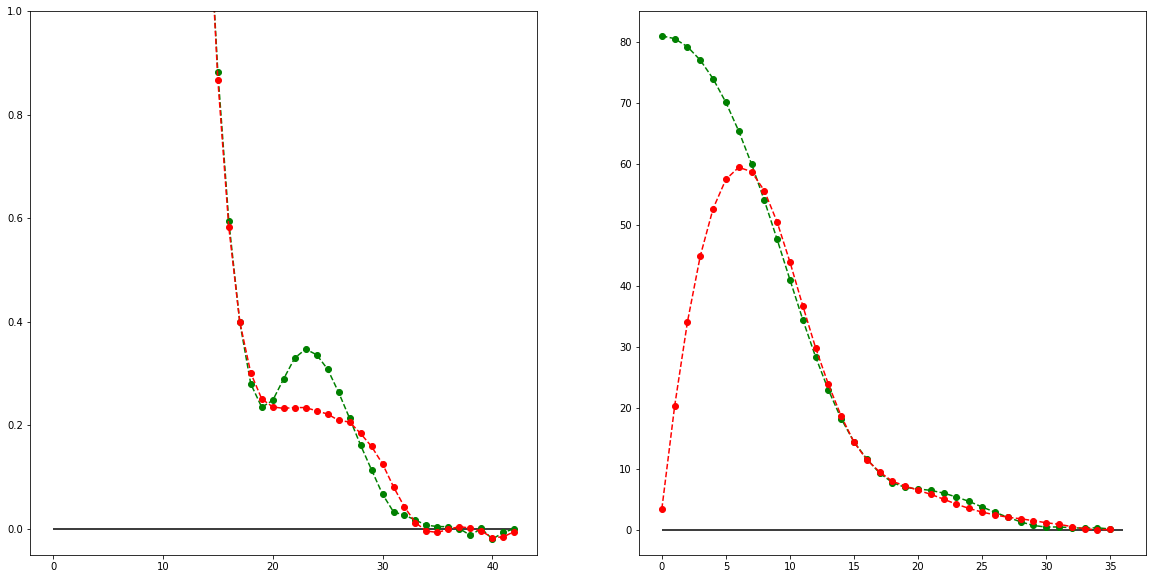

In [542]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'go--')
axs[0].plot(np.array(b_init[1:1+len(pair_knots)])*(6*0.1**3) , 'ro--')

axs[0].set_ylim(-0.05,1.0)
axs[0].hlines(0.0, 0, 42)
axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'go--')
axs[1].plot(np.array(b_init[1+len(pair_knots):])*(6*0.1**3) , 'ro--')
axs[1].hlines(0.0, 0, 36)

13
[slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1392, 1), slice(1392, 1404, 1), slice(1404, 1410, 1), slice(0, 1610, 1)]
[-1139.191, 0.0, -1136.451, -1136.774, -1190.382, -1127.204]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


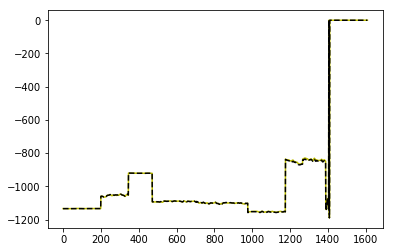

In [537]:
plt.plot(energy(b_all, X), 'y')
plt.plot(y[:,0], 'k--')
print(len(bounds))
print(bounds)
print([round(z, 3) for z in energy(b_all, X)[bounds[-2]]])
print([round(z, 3) for z in y[bounds[-2],0]])

In [543]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

len 50


In [544]:
stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

for key in targets.keys():
    targetsx[key]['weight'] = 1.0
    
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, dl, bounds, force_atoms = make_input_matrices_forces(targetsx, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
    
    #Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)
    

lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 126 126 126 126
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 21 21 21 21
lens forces 8 8 8 8
lens forces 8 8 8 8
lens forces 10 10 10 10
lens forces 12 12 12 12
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1410, 1), slice(1410, 1418, 1), slice(1418, 1426, 1), slice(1426, 1436, 1), slice(1436, 1448, 1), slice(1448, 1454, 1), slice(0, 1654, 1)]


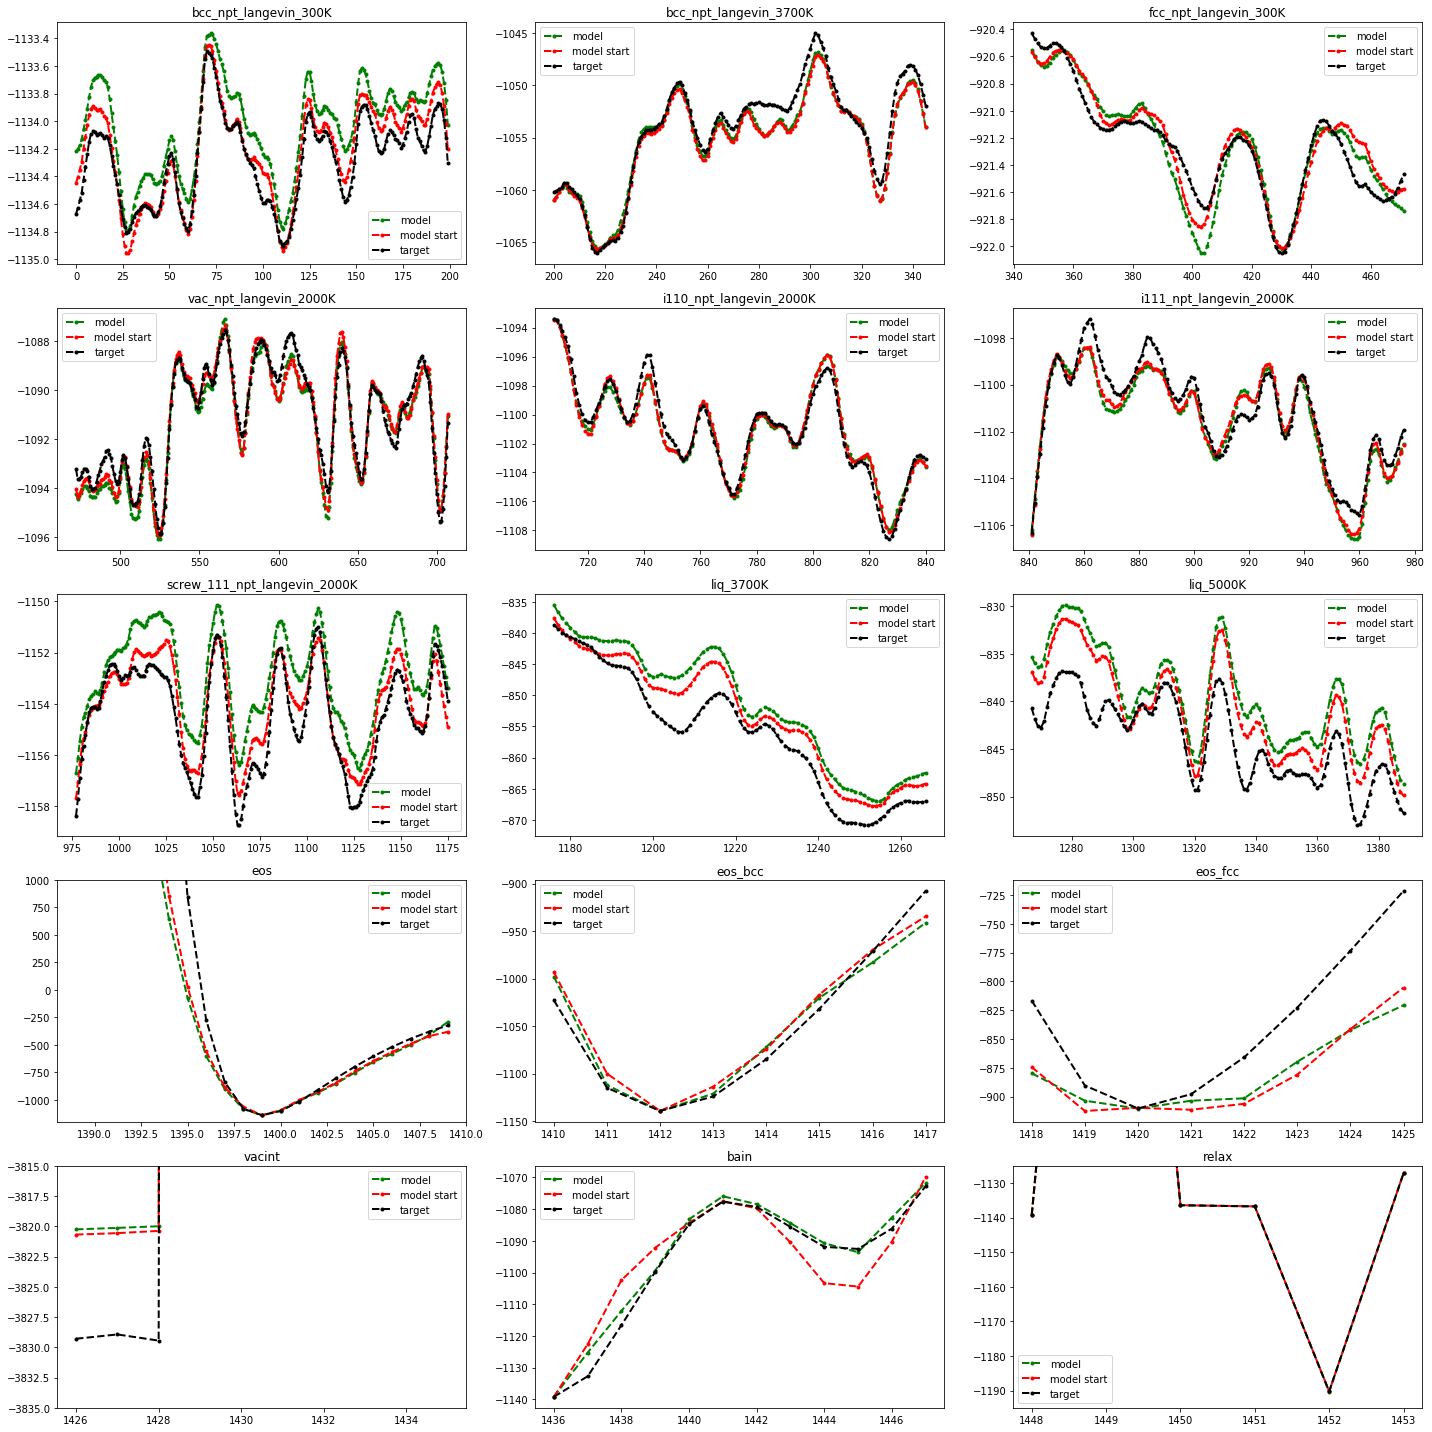

In [545]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'g.--', lw=2, label='model')
    axes[i,j].plot(rr, energy(b_init, Xall)[bounds[k]][:], 'r.--', lw=2, label='model start')


    axes[i,j].plot(rr, yall[bounds[k],0][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [499]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65]
[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95]


In [500]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [501]:
M = _bspline_coeffs_to_tpf(43)

In [502]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.74041160e+03  4.13924025e+03  3.58466243e+03  3.07670327e+03
  2.61496974e+03  2.19822209e+03  1.82471112e+03  1.49282786e+03
  1.20131131e+03  9.49194902e+02  7.35130674e+02  5.57132111e+02
  4.12362672e+02  2.97870281e+02  2.11446554e+02  1.47787913e+02
  9.90964475e+01  6.60610156e+01  4.61922317e+01  3.84924381e+01
  4.06076718e+01  4.73988102e+01  5.44537847e+01  5.86471198e+01
  5.92430949e+01  5.73085867e+01  5.21506428e+01  4.50909268e+01
  3.65902229e+01  2.70280266e+01  1.64086556e+01  7.66105002e+00
  4.08727824e+00  1.86188239e+00  5.84699154e-01  6.07935100e-01
  3.70598863e-01 -1.20465976e-01 -2.21393498e+00  1.62706705e-02
 -3.29754813e+00 -1.51941987e+00 -1.80780882e-01]
[ 4.74041160e+03 -1.48224062e+04  1.54701710e+04 -5.38815137e+03
 -4.18142086e-01 -8.46729119e-01 -5.09442055e-01  1.40224761e-01
  3.47968206e-01  2.94425674e-01 -3.81374953e-01 -6.38567121e-01
 -8.50022936e-01 -1.15534182e-01  7.43691858e-01 -3.09519666e+00
 -2.49432781e+00  8.48676498e+00 -3.1782

In [503]:
Medens = _bspline_coeffs_to_tpf(36)

In [504]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

[13647.57211333 13420.50107238 13095.08070677 12670.85886296
 12146.54020606 11520.56224931 10789.11537741  9947.36366253
  9000.29546814  7963.08405516  6869.37842416  5772.25418127
  4740.21129023  3827.35024849  3045.21139445  2410.36513881
  1938.65092099  1547.55915319  1283.23040406  1155.17983481
  1105.6071186   1067.57321414  1002.96957163   916.65336231
   814.88631935   693.04132258   578.14473613   459.6669731
   340.8610024    226.10601166   150.8678551    114.48053548
    68.68620863    42.87055808    58.37006969    35.81112322]
[ 1.36475721e+04 -4.11697874e+04  4.12985091e+04 -1.37767460e+04
 -8.43181335e-01 -2.67151843e-01 -2.24712858e+00 -1.02631251e+00
  9.82429130e+00  1.01848974e+01  1.84757396e+01  1.94266056e+01
  1.54243576e+01 -1.43994663e+01 -4.25601590e+01  5.03007233e+00
 -7.30971322e-01 -9.83490272e+01  1.28650156e+02 -3.66254074e+01
 -6.73154880e+01 -9.13871447e+00  2.88304915e+01  4.29657210e+01
  1.40456198e+00 -1.08888534e+01  3.16534843e+01 -3.75559510e

In [505]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

47 47
40 40


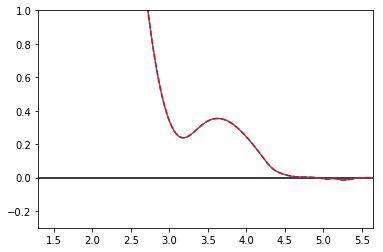

In [506]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

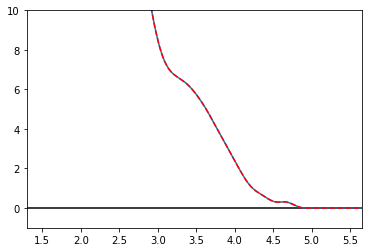

In [507]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[-n_edens:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[-n_edens:], e_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, edens_coeff, e_knot) for r in rr], 'r--')
plt.ylim(-1,10)
#plt.xlim(1.5,2.8)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [508]:
tpf_coeff

array([ 4.74041160e+03, -1.48224062e+04,  1.54701710e+04, -5.38815137e+03,
       -4.18142086e-01, -8.46729119e-01, -5.09442055e-01,  1.40224761e-01,
        3.47968206e-01,  2.94425674e-01, -3.81374953e-01, -6.38567121e-01,
       -8.50022936e-01, -1.15534182e-01,  7.43691858e-01, -3.09519666e+00,
       -2.49432781e+00,  8.48676498e+00, -3.17824238e+00,  1.49172789e+00,
       -1.35630561e+00, -2.78515916e+00,  7.27053433e-01,  1.28659365e+00,
        2.38975458e+00,  1.80259733e+00, -1.75982904e+00,  2.01461595e+00,
       -8.60879248e-01, -8.12889764e-02, -3.75177410e-01,  2.92462197e+00,
        3.73128589e-01, -7.12752636e+00,  3.42529455e+00,  7.52369889e-01,
       -1.91319793e+00,  1.56783494e+00, -1.35551915e+00,  7.27475440e+00,
       -1.57937780e+01,  2.05036706e+01, -1.61674079e+01,  4.81306753e+00,
        1.69544604e+00, -7.96296339e-01, -1.80780882e-01])

In [139]:
edens_coeff

array([ 5.81825516e+02,  1.06245742e+03, -4.37746307e+03,  2.73564155e+03,
       -2.10920400e+00,  1.24243100e+01,  6.25040000e+00,  6.95300000e+00,
        1.77633500e+01,  2.34649100e+01,  3.42154500e+01,  3.03211900e+01,
        1.72855700e+01, -4.95944400e+01, -1.12848190e+02,  3.49766400e+01,
        5.87545100e+01, -1.68032490e+02,  1.51541600e+01,  1.30925080e+02,
       -1.85963190e+02,  1.32261063e+02, -3.62713640e+01,  4.75708680e+01,
        1.12611320e+01, -3.09730030e+01,  1.02880710e+01, -2.02827000e+01,
        2.57331760e+01, -4.43171030e+01,  3.81936290e+01,  1.21280920e+01,
       -5.40750394e+01,  6.25679868e+01,  4.99428295e+00, -3.56890978e+01,
       -5.07922253e+01,  9.47527636e+01, -5.60769478e+01,  1.63239560e+01])

In [140]:
params = {
    'hyperparams':{'pair':[], 'edens':[]},
    'params':{'pair':[], 'edens':[]}}
params['hyperparams']['pair'] = p_knot
params['params']['pair'] = tpf_coeff
params['hyperparams']['edens'] = e_knot
params['params']['edens'] = edens_coeff
params['params']['embed'] = [-1.0, b_all[0]]

In [141]:
param_list = [params]
#param_list

In [142]:
file_name = os.path.join(working, "params_final_forces.pickle")

for params in param_list[-1:]:
    params_to_pickle(params, file_name)#, encoding='latin1', protocol=3)

No existing params file, creating a new one.


In [143]:
file_name = os.path.join(working, "params_final_forces.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)
#params_store[-1]

In [144]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))

print('edens') 
for c, k in zip(edens_coeff, e_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
        
print('embed')
print(-1.0, b_all[0])
#print(-4.42166597e-01,  1.12818607e-04)
#print(-4.49779872e-01,  1.09664665e-04)

pair
+4704.17226d0*(1.05d0 - r)**3*H(1.05d0 - r)
-14682.45089d0*(1.15d0 - r)**3*H(1.15d0 - r)
+15292.059210000003d0*(1.25d0 - r)**3*H(1.25d0 - r)
-5313.712900000002d0*(1.35d0 - r)**3*H(1.35d0 - r)
+0.2757000000001426d0*(1.45d0 - r)**3*H(1.45d0 - r)
-0.4349500000025728d0*(1.55d0 - r)**3*H(1.55d0 - r)
-1.2278999999980442d0*(1.65d0 - r)**3*H(1.65d0 - r)
+0.5657699999983379d0*(1.75d0 - r)**3*H(1.75d0 - r)
+0.53125d0*(1.85d0 - r)**3*H(1.85d0 - r)
-0.058496000000559434d0*(1.95d0 - r)**3*H(1.95d0 - r)
+0.45777000000089174d0*(2.05d0 - r)**3*H(2.05d0 - r)
-0.7091400000003887d0*(2.15d0 - r)**3*H(2.15d0 - r)
-5.39084000000048d0*(2.25d0 - r)**3*H(2.25d0 - r)
+1.88612500000022d0*(2.35d0 - r)**3*H(2.35d0 - r)
+7.921438999999964d0*(2.45d0 - r)**3*H(2.45d0 - r)
-8.702650999999946d0*(2.55d0 - r)**3*H(2.55d0 - r)
-0.17641420000006747d0*(2.65d0 - r)**3*H(2.65d0 - r)
+0.8785480000000234d0*(2.75d0 - r)**3*H(2.75d0 - r)
+1.0483304999999064d0*(2.85d0 - r)**3*H(2.85d0 - r)
-2.7975964999999974d0*(2.95d0 - r)**

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']